In [1]:
# adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/
# https://towardsdatascience.com/pytorch-tutorial-distilled-95ce8781a89c

# 1. Import Modules

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# fix random seed for reproducibility
np.random.seed(200184)

# 2. Train the GAN model

In [5]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [6]:
# defining classes and ANN
class AE_net(nn.Module):
    def __init__(self):
        super(AE_net, self).__init__()
        #net_list = [nn.Linear(1, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 100), nn.ReLU(), 
        #            nn.Linear(100, 1),  nn.ReLU()
        #           ]  # definition of model, just put in corresponding layers in sequence
        
        net_list = [nn.Linear(4, 15),   
                    nn.Tanh(),
                    nn.Linear(15, 15), 
                    nn.Tanh(),
                    nn.Linear(15, 2)#, 
#                     nn.Tanh(),
#                     nn.Linear(32, 8),
#                     nn.Tanh(),
#                     nn.Linear(8, 2)
                   ]
        self._net = nn.Sequential(*net_list).to(device)
        return

    def forward(self, x):
        return self._net(x)
    
def get_var_from_np(np_array, cuda=False, requires_grad=False):    # convert numpy to PyTorch variable for training
    temp = Variable(torch.from_numpy(np_array), requires_grad=requires_grad).type(torch.FloatTensor)
    if cuda: temp = temp.cuda()
    return temp
    
def train(model, data_in, data_out, data_in_val, data_out_val):
    
    train_data = My_dataset(get_var_from_np(data_in), get_var_from_np(data_out))
    val_data = My_dataset(get_var_from_np(data_in_val), get_var_from_np(data_out_val))
    
    optimizer = torch.optim.SGD(model._net.parameters(), lr = 0.01, momentum=0.9)
    n_epoch = 3000
    batch_size = 100
    n_batch = math.ceil(1. * len(train_data) / batch_size)
    loss_train = np.zeros(n_epoch)
    loss_val = np.zeros(n_epoch)
    
    for epoch in range(n_epoch):    
        
        dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
        
        batch_idx = 0
        for train_in, train_out in dataset:
            out = model._net.forward(train_in)
            loss = nn.MSELoss()(out, train_out) 
            if (batch_idx+1) % min(10,n_batch) == 0:
                print ("Epoch = %5d, Batch = %5d/%5d [%4.0f%%]:\tTraining Loss = %12.5e" % (epoch, batch_idx+1, n_batch, 100. * (batch_idx+1) / n_batch, loss.cpu().data.numpy()))
            optimizer.zero_grad()
            loss.backward() # scalar variables, when we call .backward() on them, don’t require arguments – only tensors require a matching sized tensor argument to be passed to the .backward() operation
            optimizer.step()
            del loss
            batch_idx += 1
        
        data_out_pred = model._net.forward(get_var_from_np(data_in)).cpu().data.numpy()
        diff = data_out_pred - data_out
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_train[epoch] = MSE
        
        data_out_val_pred = model._net.forward(get_var_from_np(data_in_val)).cpu().data.numpy()
        diff = data_out_val_pred - data_out_val
        MSE = np.sum(diff**2) / diff.shape[0]
        loss_val[epoch] = MSE        

    return loss_train, loss_val
    
class My_dataset(Dataset):      # construct dataset object for mini-batch gradient descent
    def __init__(self, data_in, data_out):
        self._data_in = data_in
        self._data_out = data_out

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, index):
        return self._data_in[index], self._data_out[index]

In [7]:
EBD = np.loadtxt("h2t latent space.txt",delimiter=' ')[:,1:5]
X = np.loadtxt("B_50001_10.txt",delimiter=' ')[:,0:2]

In [8]:
n = X.shape[0]

x = np.concatenate((EBD[:,0].reshape(EBD.shape[0],1), EBD[:,1].reshape(EBD.shape[0],1),EBD[:,2].reshape(EBD.shape[0],1),EBD[:,3].reshape(EBD.shape[0],1)), axis=1)

print (x)

[[ 1.85501412e-03  1.29088294e-03  4.60343761e-03  2.32847827e-03]
 [ 1.91431923e-03  1.16217369e-03  5.17718261e-03  1.71887060e-03]
 [ 1.77791610e-03  1.81028107e-03  3.77802085e-03  9.99505792e-05]
 ...
 [ 1.52430381e-03 -1.75890350e-03  1.81684189e-03  1.44114369e-03]
 [ 1.58677960e-03 -3.02538276e-04  2.23638187e-03 -1.52079156e-03]
 [ 1.59630552e-03 -1.18101761e-03  2.34350492e-03  1.40209077e-03]]


In [9]:
y = np.zeros((n,2))

y = np.concatenate((X[:,0].reshape(X.shape[0],1), X[:,1].reshape(X.shape[0],1)), axis=1)

print (y)

[[-0.00193751  0.00140543]
 [-0.00242442  0.00313239]
 [-0.00243668  0.00305768]
 ...
 [-0.00245551  0.00209861]
 [-0.00319202  0.00814628]
 [-0.00202419  0.00100075]]


In [10]:
test_frac = 0.10
val_frac = 0.20
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_frac, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_frac/(1-test_frac), random_state=43)

In [11]:
# scaling
xscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling
yscale = pre.MinMaxScaler(feature_range=(0,1)) # changing feature range requires modification of chain rule in post-hoc gradient rescaling

# xscale = pre.StandardScaler()
# yscale = pre.StandardScaler()


X_train = xscale.fit_transform(x_train)
Y_train = yscale.fit_transform(y_train)
X_val = xscale.transform(x_val)
Y_val = yscale.transform(y_val)
X_test = xscale.transform(x_test)
Y_test = yscale.transform(y_test)
X = xscale.transform(x)
Y = yscale.transform(y)

In [12]:
# training
model = AE_net()
print(model)

AE_net(
  (_net): Sequential(
    (0): Linear(in_features=4, out_features=15, bias=True)
    (1): Tanh()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [13]:
loss_train, loss_val = train(model, X_train, Y_train, X_val, Y_val)

Epoch =     0, Batch =    10/  350 [   3%]:	Training Loss =  5.25955e-02
Epoch =     0, Batch =    20/  350 [   6%]:	Training Loss =  6.58814e-02
Epoch =     0, Batch =    30/  350 [   9%]:	Training Loss =  4.97707e-02
Epoch =     0, Batch =    40/  350 [  11%]:	Training Loss =  5.28400e-02
Epoch =     0, Batch =    50/  350 [  14%]:	Training Loss =  3.82775e-02
Epoch =     0, Batch =    60/  350 [  17%]:	Training Loss =  3.98668e-02
Epoch =     0, Batch =    70/  350 [  20%]:	Training Loss =  5.15627e-02
Epoch =     0, Batch =    80/  350 [  23%]:	Training Loss =  3.68058e-02
Epoch =     0, Batch =    90/  350 [  26%]:	Training Loss =  4.73302e-02
Epoch =     0, Batch =   100/  350 [  29%]:	Training Loss =  3.31412e-02
Epoch =     0, Batch =   110/  350 [  31%]:	Training Loss =  4.52057e-02
Epoch =     0, Batch =   120/  350 [  34%]:	Training Loss =  3.38384e-02
Epoch =     0, Batch =   130/  350 [  37%]:	Training Loss =  3.39122e-02
Epoch =     0, Batch =   140/  350 [  40%]:	Trainin

Epoch =     3, Batch =   170/  350 [  49%]:	Training Loss =  2.47248e-02
Epoch =     3, Batch =   180/  350 [  51%]:	Training Loss =  2.12009e-02
Epoch =     3, Batch =   190/  350 [  54%]:	Training Loss =  2.24549e-02
Epoch =     3, Batch =   200/  350 [  57%]:	Training Loss =  1.74459e-02
Epoch =     3, Batch =   210/  350 [  60%]:	Training Loss =  2.07265e-02
Epoch =     3, Batch =   220/  350 [  63%]:	Training Loss =  2.62213e-02
Epoch =     3, Batch =   230/  350 [  66%]:	Training Loss =  1.83896e-02
Epoch =     3, Batch =   240/  350 [  69%]:	Training Loss =  1.98491e-02
Epoch =     3, Batch =   250/  350 [  71%]:	Training Loss =  1.91816e-02
Epoch =     3, Batch =   260/  350 [  74%]:	Training Loss =  2.01586e-02
Epoch =     3, Batch =   270/  350 [  77%]:	Training Loss =  1.88989e-02
Epoch =     3, Batch =   280/  350 [  80%]:	Training Loss =  2.41587e-02
Epoch =     3, Batch =   290/  350 [  83%]:	Training Loss =  1.69838e-02
Epoch =     3, Batch =   300/  350 [  86%]:	Trainin

Epoch =     6, Batch =   300/  350 [  86%]:	Training Loss =  1.83164e-02
Epoch =     6, Batch =   310/  350 [  89%]:	Training Loss =  2.14056e-02
Epoch =     6, Batch =   320/  350 [  91%]:	Training Loss =  1.64263e-02
Epoch =     6, Batch =   330/  350 [  94%]:	Training Loss =  2.58676e-02
Epoch =     6, Batch =   340/  350 [  97%]:	Training Loss =  1.86459e-02
Epoch =     7, Batch =    10/  350 [   3%]:	Training Loss =  1.58275e-02
Epoch =     7, Batch =    20/  350 [   6%]:	Training Loss =  1.90552e-02
Epoch =     7, Batch =    30/  350 [   9%]:	Training Loss =  2.23070e-02
Epoch =     7, Batch =    40/  350 [  11%]:	Training Loss =  2.22573e-02
Epoch =     7, Batch =    50/  350 [  14%]:	Training Loss =  2.13430e-02
Epoch =     7, Batch =    60/  350 [  17%]:	Training Loss =  1.94673e-02
Epoch =     7, Batch =    70/  350 [  20%]:	Training Loss =  1.88944e-02
Epoch =     7, Batch =    80/  350 [  23%]:	Training Loss =  1.84686e-02
Epoch =     7, Batch =    90/  350 [  26%]:	Trainin

Epoch =    10, Batch =    80/  350 [  23%]:	Training Loss =  1.87230e-02
Epoch =    10, Batch =    90/  350 [  26%]:	Training Loss =  2.17399e-02
Epoch =    10, Batch =   100/  350 [  29%]:	Training Loss =  1.75445e-02
Epoch =    10, Batch =   110/  350 [  31%]:	Training Loss =  2.19308e-02
Epoch =    10, Batch =   120/  350 [  34%]:	Training Loss =  2.27443e-02
Epoch =    10, Batch =   130/  350 [  37%]:	Training Loss =  1.78954e-02
Epoch =    10, Batch =   140/  350 [  40%]:	Training Loss =  1.60923e-02
Epoch =    10, Batch =   150/  350 [  43%]:	Training Loss =  1.93332e-02
Epoch =    10, Batch =   160/  350 [  46%]:	Training Loss =  1.87576e-02
Epoch =    10, Batch =   170/  350 [  49%]:	Training Loss =  1.70633e-02
Epoch =    10, Batch =   180/  350 [  51%]:	Training Loss =  2.18576e-02
Epoch =    10, Batch =   190/  350 [  54%]:	Training Loss =  1.72740e-02
Epoch =    10, Batch =   200/  350 [  57%]:	Training Loss =  1.78680e-02
Epoch =    10, Batch =   210/  350 [  60%]:	Trainin

Epoch =    13, Batch =   200/  350 [  57%]:	Training Loss =  1.65238e-02
Epoch =    13, Batch =   210/  350 [  60%]:	Training Loss =  1.62553e-02
Epoch =    13, Batch =   220/  350 [  63%]:	Training Loss =  2.03994e-02
Epoch =    13, Batch =   230/  350 [  66%]:	Training Loss =  2.16980e-02
Epoch =    13, Batch =   240/  350 [  69%]:	Training Loss =  2.15737e-02
Epoch =    13, Batch =   250/  350 [  71%]:	Training Loss =  1.55098e-02
Epoch =    13, Batch =   260/  350 [  74%]:	Training Loss =  2.02763e-02
Epoch =    13, Batch =   270/  350 [  77%]:	Training Loss =  1.88128e-02
Epoch =    13, Batch =   280/  350 [  80%]:	Training Loss =  1.88196e-02
Epoch =    13, Batch =   290/  350 [  83%]:	Training Loss =  1.79488e-02
Epoch =    13, Batch =   300/  350 [  86%]:	Training Loss =  2.08533e-02
Epoch =    13, Batch =   310/  350 [  89%]:	Training Loss =  1.94391e-02
Epoch =    13, Batch =   320/  350 [  91%]:	Training Loss =  1.80509e-02
Epoch =    13, Batch =   330/  350 [  94%]:	Trainin

Epoch =    17, Batch =    40/  350 [  11%]:	Training Loss =  2.51552e-02
Epoch =    17, Batch =    50/  350 [  14%]:	Training Loss =  2.18401e-02
Epoch =    17, Batch =    60/  350 [  17%]:	Training Loss =  1.44537e-02
Epoch =    17, Batch =    70/  350 [  20%]:	Training Loss =  1.87524e-02
Epoch =    17, Batch =    80/  350 [  23%]:	Training Loss =  1.64560e-02
Epoch =    17, Batch =    90/  350 [  26%]:	Training Loss =  1.82318e-02
Epoch =    17, Batch =   100/  350 [  29%]:	Training Loss =  1.78157e-02
Epoch =    17, Batch =   110/  350 [  31%]:	Training Loss =  1.99157e-02
Epoch =    17, Batch =   120/  350 [  34%]:	Training Loss =  1.69375e-02
Epoch =    17, Batch =   130/  350 [  37%]:	Training Loss =  1.55823e-02
Epoch =    17, Batch =   140/  350 [  40%]:	Training Loss =  2.67695e-02
Epoch =    17, Batch =   150/  350 [  43%]:	Training Loss =  2.34764e-02
Epoch =    17, Batch =   160/  350 [  46%]:	Training Loss =  1.83201e-02
Epoch =    17, Batch =   170/  350 [  49%]:	Trainin

Epoch =    20, Batch =   230/  350 [  66%]:	Training Loss =  1.75691e-02
Epoch =    20, Batch =   240/  350 [  69%]:	Training Loss =  2.17866e-02
Epoch =    20, Batch =   250/  350 [  71%]:	Training Loss =  2.34528e-02
Epoch =    20, Batch =   260/  350 [  74%]:	Training Loss =  1.76585e-02
Epoch =    20, Batch =   270/  350 [  77%]:	Training Loss =  1.42599e-02
Epoch =    20, Batch =   280/  350 [  80%]:	Training Loss =  1.95316e-02
Epoch =    20, Batch =   290/  350 [  83%]:	Training Loss =  1.80198e-02
Epoch =    20, Batch =   300/  350 [  86%]:	Training Loss =  2.08449e-02
Epoch =    20, Batch =   310/  350 [  89%]:	Training Loss =  2.25535e-02
Epoch =    20, Batch =   320/  350 [  91%]:	Training Loss =  1.63013e-02
Epoch =    20, Batch =   330/  350 [  94%]:	Training Loss =  1.51163e-02
Epoch =    20, Batch =   340/  350 [  97%]:	Training Loss =  2.31457e-02
Epoch =    21, Batch =    10/  350 [   3%]:	Training Loss =  1.78006e-02
Epoch =    21, Batch =    20/  350 [   6%]:	Trainin

Epoch =    24, Batch =    10/  350 [   3%]:	Training Loss =  1.81289e-02
Epoch =    24, Batch =    20/  350 [   6%]:	Training Loss =  2.05053e-02
Epoch =    24, Batch =    30/  350 [   9%]:	Training Loss =  2.05927e-02
Epoch =    24, Batch =    40/  350 [  11%]:	Training Loss =  2.15886e-02
Epoch =    24, Batch =    50/  350 [  14%]:	Training Loss =  2.48054e-02
Epoch =    24, Batch =    60/  350 [  17%]:	Training Loss =  2.05225e-02
Epoch =    24, Batch =    70/  350 [  20%]:	Training Loss =  1.74967e-02
Epoch =    24, Batch =    80/  350 [  23%]:	Training Loss =  2.74022e-02
Epoch =    24, Batch =    90/  350 [  26%]:	Training Loss =  2.12380e-02
Epoch =    24, Batch =   100/  350 [  29%]:	Training Loss =  1.94815e-02
Epoch =    24, Batch =   110/  350 [  31%]:	Training Loss =  2.24923e-02
Epoch =    24, Batch =   120/  350 [  34%]:	Training Loss =  1.72647e-02
Epoch =    24, Batch =   130/  350 [  37%]:	Training Loss =  1.94935e-02
Epoch =    24, Batch =   140/  350 [  40%]:	Trainin

Epoch =    27, Batch =   120/  350 [  34%]:	Training Loss =  1.85215e-02
Epoch =    27, Batch =   130/  350 [  37%]:	Training Loss =  2.02753e-02
Epoch =    27, Batch =   140/  350 [  40%]:	Training Loss =  1.84083e-02
Epoch =    27, Batch =   150/  350 [  43%]:	Training Loss =  2.02938e-02
Epoch =    27, Batch =   160/  350 [  46%]:	Training Loss =  1.76274e-02
Epoch =    27, Batch =   170/  350 [  49%]:	Training Loss =  2.16294e-02
Epoch =    27, Batch =   180/  350 [  51%]:	Training Loss =  2.04706e-02
Epoch =    27, Batch =   190/  350 [  54%]:	Training Loss =  1.86358e-02
Epoch =    27, Batch =   200/  350 [  57%]:	Training Loss =  1.63829e-02
Epoch =    27, Batch =   210/  350 [  60%]:	Training Loss =  1.72770e-02
Epoch =    27, Batch =   220/  350 [  63%]:	Training Loss =  1.73132e-02
Epoch =    27, Batch =   230/  350 [  66%]:	Training Loss =  1.59362e-02
Epoch =    27, Batch =   240/  350 [  69%]:	Training Loss =  1.73999e-02
Epoch =    27, Batch =   250/  350 [  71%]:	Trainin

Epoch =    30, Batch =   250/  350 [  71%]:	Training Loss =  1.73457e-02
Epoch =    30, Batch =   260/  350 [  74%]:	Training Loss =  1.54785e-02
Epoch =    30, Batch =   270/  350 [  77%]:	Training Loss =  1.81819e-02
Epoch =    30, Batch =   280/  350 [  80%]:	Training Loss =  1.45461e-02
Epoch =    30, Batch =   290/  350 [  83%]:	Training Loss =  1.76284e-02
Epoch =    30, Batch =   300/  350 [  86%]:	Training Loss =  1.75170e-02
Epoch =    30, Batch =   310/  350 [  89%]:	Training Loss =  1.95202e-02
Epoch =    30, Batch =   320/  350 [  91%]:	Training Loss =  2.31689e-02
Epoch =    30, Batch =   330/  350 [  94%]:	Training Loss =  1.73121e-02
Epoch =    30, Batch =   340/  350 [  97%]:	Training Loss =  1.66849e-02
Epoch =    31, Batch =    10/  350 [   3%]:	Training Loss =  1.86508e-02
Epoch =    31, Batch =    20/  350 [   6%]:	Training Loss =  1.88275e-02
Epoch =    31, Batch =    30/  350 [   9%]:	Training Loss =  1.64994e-02
Epoch =    31, Batch =    40/  350 [  11%]:	Trainin

Epoch =    34, Batch =    50/  350 [  14%]:	Training Loss =  2.14744e-02
Epoch =    34, Batch =    60/  350 [  17%]:	Training Loss =  2.00205e-02
Epoch =    34, Batch =    70/  350 [  20%]:	Training Loss =  1.88289e-02
Epoch =    34, Batch =    80/  350 [  23%]:	Training Loss =  1.73956e-02
Epoch =    34, Batch =    90/  350 [  26%]:	Training Loss =  1.67458e-02
Epoch =    34, Batch =   100/  350 [  29%]:	Training Loss =  2.03096e-02
Epoch =    34, Batch =   110/  350 [  31%]:	Training Loss =  2.23639e-02
Epoch =    34, Batch =   120/  350 [  34%]:	Training Loss =  1.78800e-02
Epoch =    34, Batch =   130/  350 [  37%]:	Training Loss =  1.64443e-02
Epoch =    34, Batch =   140/  350 [  40%]:	Training Loss =  2.03409e-02
Epoch =    34, Batch =   150/  350 [  43%]:	Training Loss =  1.77813e-02
Epoch =    34, Batch =   160/  350 [  46%]:	Training Loss =  2.11203e-02
Epoch =    34, Batch =   170/  350 [  49%]:	Training Loss =  2.42977e-02
Epoch =    34, Batch =   180/  350 [  51%]:	Trainin

Epoch =    37, Batch =   250/  350 [  71%]:	Training Loss =  2.04042e-02
Epoch =    37, Batch =   260/  350 [  74%]:	Training Loss =  2.11734e-02
Epoch =    37, Batch =   270/  350 [  77%]:	Training Loss =  1.49471e-02
Epoch =    37, Batch =   280/  350 [  80%]:	Training Loss =  1.70691e-02
Epoch =    37, Batch =   290/  350 [  83%]:	Training Loss =  1.66147e-02
Epoch =    37, Batch =   300/  350 [  86%]:	Training Loss =  1.98060e-02
Epoch =    37, Batch =   310/  350 [  89%]:	Training Loss =  1.98986e-02
Epoch =    37, Batch =   320/  350 [  91%]:	Training Loss =  1.65103e-02
Epoch =    37, Batch =   330/  350 [  94%]:	Training Loss =  2.01908e-02
Epoch =    37, Batch =   340/  350 [  97%]:	Training Loss =  1.60606e-02
Epoch =    38, Batch =    10/  350 [   3%]:	Training Loss =  1.99345e-02
Epoch =    38, Batch =    20/  350 [   6%]:	Training Loss =  1.58449e-02
Epoch =    38, Batch =    30/  350 [   9%]:	Training Loss =  1.74637e-02
Epoch =    38, Batch =    40/  350 [  11%]:	Trainin

Epoch =    41, Batch =   130/  350 [  37%]:	Training Loss =  1.60089e-02
Epoch =    41, Batch =   140/  350 [  40%]:	Training Loss =  2.02462e-02
Epoch =    41, Batch =   150/  350 [  43%]:	Training Loss =  1.86658e-02
Epoch =    41, Batch =   160/  350 [  46%]:	Training Loss =  1.61178e-02
Epoch =    41, Batch =   170/  350 [  49%]:	Training Loss =  1.80375e-02
Epoch =    41, Batch =   180/  350 [  51%]:	Training Loss =  1.75887e-02
Epoch =    41, Batch =   190/  350 [  54%]:	Training Loss =  1.80566e-02
Epoch =    41, Batch =   200/  350 [  57%]:	Training Loss =  2.38771e-02
Epoch =    41, Batch =   210/  350 [  60%]:	Training Loss =  1.75956e-02
Epoch =    41, Batch =   220/  350 [  63%]:	Training Loss =  1.28769e-02
Epoch =    41, Batch =   230/  350 [  66%]:	Training Loss =  1.46418e-02
Epoch =    41, Batch =   240/  350 [  69%]:	Training Loss =  1.34103e-02
Epoch =    41, Batch =   250/  350 [  71%]:	Training Loss =  1.94926e-02
Epoch =    41, Batch =   260/  350 [  74%]:	Trainin

Epoch =    44, Batch =   330/  350 [  94%]:	Training Loss =  1.56981e-02
Epoch =    44, Batch =   340/  350 [  97%]:	Training Loss =  2.10600e-02
Epoch =    45, Batch =    10/  350 [   3%]:	Training Loss =  1.49038e-02
Epoch =    45, Batch =    20/  350 [   6%]:	Training Loss =  1.94913e-02
Epoch =    45, Batch =    30/  350 [   9%]:	Training Loss =  1.74082e-02
Epoch =    45, Batch =    40/  350 [  11%]:	Training Loss =  2.00497e-02
Epoch =    45, Batch =    50/  350 [  14%]:	Training Loss =  2.43527e-02
Epoch =    45, Batch =    60/  350 [  17%]:	Training Loss =  1.84725e-02
Epoch =    45, Batch =    70/  350 [  20%]:	Training Loss =  1.86740e-02
Epoch =    45, Batch =    80/  350 [  23%]:	Training Loss =  2.09485e-02
Epoch =    45, Batch =    90/  350 [  26%]:	Training Loss =  1.44308e-02
Epoch =    45, Batch =   100/  350 [  29%]:	Training Loss =  1.79894e-02
Epoch =    45, Batch =   110/  350 [  31%]:	Training Loss =  1.61026e-02
Epoch =    45, Batch =   120/  350 [  34%]:	Trainin

Epoch =    48, Batch =   180/  350 [  51%]:	Training Loss =  1.74446e-02
Epoch =    48, Batch =   190/  350 [  54%]:	Training Loss =  1.77861e-02
Epoch =    48, Batch =   200/  350 [  57%]:	Training Loss =  1.34624e-02
Epoch =    48, Batch =   210/  350 [  60%]:	Training Loss =  1.92158e-02
Epoch =    48, Batch =   220/  350 [  63%]:	Training Loss =  1.73610e-02
Epoch =    48, Batch =   230/  350 [  66%]:	Training Loss =  1.87589e-02
Epoch =    48, Batch =   240/  350 [  69%]:	Training Loss =  2.15220e-02
Epoch =    48, Batch =   250/  350 [  71%]:	Training Loss =  1.34331e-02
Epoch =    48, Batch =   260/  350 [  74%]:	Training Loss =  1.35457e-02
Epoch =    48, Batch =   270/  350 [  77%]:	Training Loss =  1.46808e-02
Epoch =    48, Batch =   280/  350 [  80%]:	Training Loss =  1.57128e-02
Epoch =    48, Batch =   290/  350 [  83%]:	Training Loss =  1.75607e-02
Epoch =    48, Batch =   300/  350 [  86%]:	Training Loss =  1.41893e-02
Epoch =    48, Batch =   310/  350 [  89%]:	Trainin

Epoch =    52, Batch =    30/  350 [   9%]:	Training Loss =  1.14085e-02
Epoch =    52, Batch =    40/  350 [  11%]:	Training Loss =  1.48294e-02
Epoch =    52, Batch =    50/  350 [  14%]:	Training Loss =  1.82283e-02
Epoch =    52, Batch =    60/  350 [  17%]:	Training Loss =  1.60674e-02
Epoch =    52, Batch =    70/  350 [  20%]:	Training Loss =  1.61530e-02
Epoch =    52, Batch =    80/  350 [  23%]:	Training Loss =  1.50622e-02
Epoch =    52, Batch =    90/  350 [  26%]:	Training Loss =  1.94222e-02
Epoch =    52, Batch =   100/  350 [  29%]:	Training Loss =  1.67522e-02
Epoch =    52, Batch =   110/  350 [  31%]:	Training Loss =  1.85511e-02
Epoch =    52, Batch =   120/  350 [  34%]:	Training Loss =  2.02580e-02
Epoch =    52, Batch =   130/  350 [  37%]:	Training Loss =  1.77401e-02
Epoch =    52, Batch =   140/  350 [  40%]:	Training Loss =  1.44648e-02
Epoch =    52, Batch =   150/  350 [  43%]:	Training Loss =  1.82324e-02
Epoch =    52, Batch =   160/  350 [  46%]:	Trainin

Epoch =    55, Batch =   200/  350 [  57%]:	Training Loss =  1.75590e-02
Epoch =    55, Batch =   210/  350 [  60%]:	Training Loss =  1.59724e-02
Epoch =    55, Batch =   220/  350 [  63%]:	Training Loss =  1.94168e-02
Epoch =    55, Batch =   230/  350 [  66%]:	Training Loss =  1.91297e-02
Epoch =    55, Batch =   240/  350 [  69%]:	Training Loss =  1.43646e-02
Epoch =    55, Batch =   250/  350 [  71%]:	Training Loss =  1.42864e-02
Epoch =    55, Batch =   260/  350 [  74%]:	Training Loss =  1.42211e-02
Epoch =    55, Batch =   270/  350 [  77%]:	Training Loss =  1.48827e-02
Epoch =    55, Batch =   280/  350 [  80%]:	Training Loss =  1.21655e-02
Epoch =    55, Batch =   290/  350 [  83%]:	Training Loss =  1.32365e-02
Epoch =    55, Batch =   300/  350 [  86%]:	Training Loss =  1.70394e-02
Epoch =    55, Batch =   310/  350 [  89%]:	Training Loss =  2.06227e-02
Epoch =    55, Batch =   320/  350 [  91%]:	Training Loss =  1.57120e-02
Epoch =    55, Batch =   330/  350 [  94%]:	Trainin

Epoch =    58, Batch =   330/  350 [  94%]:	Training Loss =  1.13476e-02
Epoch =    58, Batch =   340/  350 [  97%]:	Training Loss =  1.60002e-02
Epoch =    59, Batch =    10/  350 [   3%]:	Training Loss =  1.58103e-02
Epoch =    59, Batch =    20/  350 [   6%]:	Training Loss =  1.29818e-02
Epoch =    59, Batch =    30/  350 [   9%]:	Training Loss =  1.66456e-02
Epoch =    59, Batch =    40/  350 [  11%]:	Training Loss =  1.56134e-02
Epoch =    59, Batch =    50/  350 [  14%]:	Training Loss =  1.15765e-02
Epoch =    59, Batch =    60/  350 [  17%]:	Training Loss =  1.50759e-02
Epoch =    59, Batch =    70/  350 [  20%]:	Training Loss =  1.19556e-02
Epoch =    59, Batch =    80/  350 [  23%]:	Training Loss =  1.27593e-02
Epoch =    59, Batch =    90/  350 [  26%]:	Training Loss =  1.61983e-02
Epoch =    59, Batch =   100/  350 [  29%]:	Training Loss =  1.15281e-02
Epoch =    59, Batch =   110/  350 [  31%]:	Training Loss =  1.28653e-02
Epoch =    59, Batch =   120/  350 [  34%]:	Trainin

Epoch =    62, Batch =   190/  350 [  54%]:	Training Loss =  1.54554e-02
Epoch =    62, Batch =   200/  350 [  57%]:	Training Loss =  1.65296e-02
Epoch =    62, Batch =   210/  350 [  60%]:	Training Loss =  1.42779e-02
Epoch =    62, Batch =   220/  350 [  63%]:	Training Loss =  1.52875e-02
Epoch =    62, Batch =   230/  350 [  66%]:	Training Loss =  1.40530e-02
Epoch =    62, Batch =   240/  350 [  69%]:	Training Loss =  9.31426e-03
Epoch =    62, Batch =   250/  350 [  71%]:	Training Loss =  1.21356e-02
Epoch =    62, Batch =   260/  350 [  74%]:	Training Loss =  1.44843e-02
Epoch =    62, Batch =   270/  350 [  77%]:	Training Loss =  2.17200e-02
Epoch =    62, Batch =   280/  350 [  80%]:	Training Loss =  1.57474e-02
Epoch =    62, Batch =   290/  350 [  83%]:	Training Loss =  1.90273e-02
Epoch =    62, Batch =   300/  350 [  86%]:	Training Loss =  1.40876e-02
Epoch =    62, Batch =   310/  350 [  89%]:	Training Loss =  1.49364e-02
Epoch =    62, Batch =   320/  350 [  91%]:	Trainin

Epoch =    65, Batch =   300/  350 [  86%]:	Training Loss =  1.51060e-02
Epoch =    65, Batch =   310/  350 [  89%]:	Training Loss =  1.56668e-02
Epoch =    65, Batch =   320/  350 [  91%]:	Training Loss =  1.53203e-02
Epoch =    65, Batch =   330/  350 [  94%]:	Training Loss =  1.49479e-02
Epoch =    65, Batch =   340/  350 [  97%]:	Training Loss =  1.58450e-02
Epoch =    66, Batch =    10/  350 [   3%]:	Training Loss =  1.28487e-02
Epoch =    66, Batch =    20/  350 [   6%]:	Training Loss =  1.31254e-02
Epoch =    66, Batch =    30/  350 [   9%]:	Training Loss =  1.89565e-02
Epoch =    66, Batch =    40/  350 [  11%]:	Training Loss =  1.62372e-02
Epoch =    66, Batch =    50/  350 [  14%]:	Training Loss =  1.64013e-02
Epoch =    66, Batch =    60/  350 [  17%]:	Training Loss =  1.49583e-02
Epoch =    66, Batch =    70/  350 [  20%]:	Training Loss =  1.65179e-02
Epoch =    66, Batch =    80/  350 [  23%]:	Training Loss =  1.41645e-02
Epoch =    66, Batch =    90/  350 [  26%]:	Trainin

Epoch =    69, Batch =    90/  350 [  26%]:	Training Loss =  1.41266e-02
Epoch =    69, Batch =   100/  350 [  29%]:	Training Loss =  1.89983e-02
Epoch =    69, Batch =   110/  350 [  31%]:	Training Loss =  1.23824e-02
Epoch =    69, Batch =   120/  350 [  34%]:	Training Loss =  1.48789e-02
Epoch =    69, Batch =   130/  350 [  37%]:	Training Loss =  1.53823e-02
Epoch =    69, Batch =   140/  350 [  40%]:	Training Loss =  1.50855e-02
Epoch =    69, Batch =   150/  350 [  43%]:	Training Loss =  1.90508e-02
Epoch =    69, Batch =   160/  350 [  46%]:	Training Loss =  1.17995e-02
Epoch =    69, Batch =   170/  350 [  49%]:	Training Loss =  1.57053e-02
Epoch =    69, Batch =   180/  350 [  51%]:	Training Loss =  1.10927e-02
Epoch =    69, Batch =   190/  350 [  54%]:	Training Loss =  1.89683e-02
Epoch =    69, Batch =   200/  350 [  57%]:	Training Loss =  1.51492e-02
Epoch =    69, Batch =   210/  350 [  60%]:	Training Loss =  1.49528e-02
Epoch =    69, Batch =   220/  350 [  63%]:	Trainin

Epoch =    72, Batch =   220/  350 [  63%]:	Training Loss =  1.45832e-02
Epoch =    72, Batch =   230/  350 [  66%]:	Training Loss =  1.08764e-02
Epoch =    72, Batch =   240/  350 [  69%]:	Training Loss =  1.59029e-02
Epoch =    72, Batch =   250/  350 [  71%]:	Training Loss =  1.21633e-02
Epoch =    72, Batch =   260/  350 [  74%]:	Training Loss =  1.21753e-02
Epoch =    72, Batch =   270/  350 [  77%]:	Training Loss =  1.52863e-02
Epoch =    72, Batch =   280/  350 [  80%]:	Training Loss =  1.92024e-02
Epoch =    72, Batch =   290/  350 [  83%]:	Training Loss =  1.48692e-02
Epoch =    72, Batch =   300/  350 [  86%]:	Training Loss =  2.11977e-02
Epoch =    72, Batch =   310/  350 [  89%]:	Training Loss =  1.64419e-02
Epoch =    72, Batch =   320/  350 [  91%]:	Training Loss =  1.47939e-02
Epoch =    72, Batch =   330/  350 [  94%]:	Training Loss =  1.65632e-02
Epoch =    72, Batch =   340/  350 [  97%]:	Training Loss =  1.33408e-02
Epoch =    73, Batch =    10/  350 [   3%]:	Trainin

Epoch =    76, Batch =    10/  350 [   3%]:	Training Loss =  1.78090e-02
Epoch =    76, Batch =    20/  350 [   6%]:	Training Loss =  1.51978e-02
Epoch =    76, Batch =    30/  350 [   9%]:	Training Loss =  1.25995e-02
Epoch =    76, Batch =    40/  350 [  11%]:	Training Loss =  1.46024e-02
Epoch =    76, Batch =    50/  350 [  14%]:	Training Loss =  1.56046e-02
Epoch =    76, Batch =    60/  350 [  17%]:	Training Loss =  1.57212e-02
Epoch =    76, Batch =    70/  350 [  20%]:	Training Loss =  1.66314e-02
Epoch =    76, Batch =    80/  350 [  23%]:	Training Loss =  1.41013e-02
Epoch =    76, Batch =    90/  350 [  26%]:	Training Loss =  1.25217e-02
Epoch =    76, Batch =   100/  350 [  29%]:	Training Loss =  1.36192e-02
Epoch =    76, Batch =   110/  350 [  31%]:	Training Loss =  1.44298e-02
Epoch =    76, Batch =   120/  350 [  34%]:	Training Loss =  1.30401e-02
Epoch =    76, Batch =   130/  350 [  37%]:	Training Loss =  1.52321e-02
Epoch =    76, Batch =   140/  350 [  40%]:	Trainin

Epoch =    79, Batch =   220/  350 [  63%]:	Training Loss =  1.60721e-02
Epoch =    79, Batch =   230/  350 [  66%]:	Training Loss =  1.90255e-02
Epoch =    79, Batch =   240/  350 [  69%]:	Training Loss =  1.77582e-02
Epoch =    79, Batch =   250/  350 [  71%]:	Training Loss =  1.45034e-02
Epoch =    79, Batch =   260/  350 [  74%]:	Training Loss =  1.28104e-02
Epoch =    79, Batch =   270/  350 [  77%]:	Training Loss =  1.41063e-02
Epoch =    79, Batch =   280/  350 [  80%]:	Training Loss =  1.97396e-02
Epoch =    79, Batch =   290/  350 [  83%]:	Training Loss =  1.37031e-02
Epoch =    79, Batch =   300/  350 [  86%]:	Training Loss =  1.29453e-02
Epoch =    79, Batch =   310/  350 [  89%]:	Training Loss =  1.15653e-02
Epoch =    79, Batch =   320/  350 [  91%]:	Training Loss =  1.36142e-02
Epoch =    79, Batch =   330/  350 [  94%]:	Training Loss =  2.02790e-02
Epoch =    79, Batch =   340/  350 [  97%]:	Training Loss =  1.61167e-02
Epoch =    80, Batch =    10/  350 [   3%]:	Trainin

Epoch =    82, Batch =   330/  350 [  94%]:	Training Loss =  1.26051e-02
Epoch =    82, Batch =   340/  350 [  97%]:	Training Loss =  1.45914e-02
Epoch =    83, Batch =    10/  350 [   3%]:	Training Loss =  1.60570e-02
Epoch =    83, Batch =    20/  350 [   6%]:	Training Loss =  1.77947e-02
Epoch =    83, Batch =    30/  350 [   9%]:	Training Loss =  1.27196e-02
Epoch =    83, Batch =    40/  350 [  11%]:	Training Loss =  1.40452e-02
Epoch =    83, Batch =    50/  350 [  14%]:	Training Loss =  1.49402e-02
Epoch =    83, Batch =    60/  350 [  17%]:	Training Loss =  1.30462e-02
Epoch =    83, Batch =    70/  350 [  20%]:	Training Loss =  1.54789e-02
Epoch =    83, Batch =    80/  350 [  23%]:	Training Loss =  1.37862e-02
Epoch =    83, Batch =    90/  350 [  26%]:	Training Loss =  1.68828e-02
Epoch =    83, Batch =   100/  350 [  29%]:	Training Loss =  1.78317e-02
Epoch =    83, Batch =   110/  350 [  31%]:	Training Loss =  1.09823e-02
Epoch =    83, Batch =   120/  350 [  34%]:	Trainin

Epoch =    86, Batch =   120/  350 [  34%]:	Training Loss =  1.39789e-02
Epoch =    86, Batch =   130/  350 [  37%]:	Training Loss =  1.77390e-02
Epoch =    86, Batch =   140/  350 [  40%]:	Training Loss =  1.65654e-02
Epoch =    86, Batch =   150/  350 [  43%]:	Training Loss =  1.28561e-02
Epoch =    86, Batch =   160/  350 [  46%]:	Training Loss =  1.59701e-02
Epoch =    86, Batch =   170/  350 [  49%]:	Training Loss =  1.50270e-02
Epoch =    86, Batch =   180/  350 [  51%]:	Training Loss =  1.48231e-02
Epoch =    86, Batch =   190/  350 [  54%]:	Training Loss =  1.34348e-02
Epoch =    86, Batch =   200/  350 [  57%]:	Training Loss =  1.65563e-02
Epoch =    86, Batch =   210/  350 [  60%]:	Training Loss =  1.66288e-02
Epoch =    86, Batch =   220/  350 [  63%]:	Training Loss =  1.82636e-02
Epoch =    86, Batch =   230/  350 [  66%]:	Training Loss =  1.46641e-02
Epoch =    86, Batch =   240/  350 [  69%]:	Training Loss =  1.10650e-02
Epoch =    86, Batch =   250/  350 [  71%]:	Trainin

Epoch =    89, Batch =   240/  350 [  69%]:	Training Loss =  1.24982e-02
Epoch =    89, Batch =   250/  350 [  71%]:	Training Loss =  1.37706e-02
Epoch =    89, Batch =   260/  350 [  74%]:	Training Loss =  1.78371e-02
Epoch =    89, Batch =   270/  350 [  77%]:	Training Loss =  1.38297e-02
Epoch =    89, Batch =   280/  350 [  80%]:	Training Loss =  1.41812e-02
Epoch =    89, Batch =   290/  350 [  83%]:	Training Loss =  1.92862e-02
Epoch =    89, Batch =   300/  350 [  86%]:	Training Loss =  1.64818e-02
Epoch =    89, Batch =   310/  350 [  89%]:	Training Loss =  1.65393e-02
Epoch =    89, Batch =   320/  350 [  91%]:	Training Loss =  1.65279e-02
Epoch =    89, Batch =   330/  350 [  94%]:	Training Loss =  1.34292e-02
Epoch =    89, Batch =   340/  350 [  97%]:	Training Loss =  1.25120e-02
Epoch =    90, Batch =    10/  350 [   3%]:	Training Loss =  1.59073e-02
Epoch =    90, Batch =    20/  350 [   6%]:	Training Loss =  1.56229e-02
Epoch =    90, Batch =    30/  350 [   9%]:	Trainin

Epoch =    93, Batch =    40/  350 [  11%]:	Training Loss =  1.58744e-02
Epoch =    93, Batch =    50/  350 [  14%]:	Training Loss =  1.80058e-02
Epoch =    93, Batch =    60/  350 [  17%]:	Training Loss =  1.61783e-02
Epoch =    93, Batch =    70/  350 [  20%]:	Training Loss =  1.50015e-02
Epoch =    93, Batch =    80/  350 [  23%]:	Training Loss =  1.26203e-02
Epoch =    93, Batch =    90/  350 [  26%]:	Training Loss =  1.43109e-02
Epoch =    93, Batch =   100/  350 [  29%]:	Training Loss =  1.37869e-02
Epoch =    93, Batch =   110/  350 [  31%]:	Training Loss =  1.04145e-02
Epoch =    93, Batch =   120/  350 [  34%]:	Training Loss =  1.71028e-02
Epoch =    93, Batch =   130/  350 [  37%]:	Training Loss =  1.17772e-02
Epoch =    93, Batch =   140/  350 [  40%]:	Training Loss =  1.76149e-02
Epoch =    93, Batch =   150/  350 [  43%]:	Training Loss =  1.62756e-02
Epoch =    93, Batch =   160/  350 [  46%]:	Training Loss =  1.47233e-02
Epoch =    93, Batch =   170/  350 [  49%]:	Trainin

Epoch =    96, Batch =   180/  350 [  51%]:	Training Loss =  1.56271e-02
Epoch =    96, Batch =   190/  350 [  54%]:	Training Loss =  1.17662e-02
Epoch =    96, Batch =   200/  350 [  57%]:	Training Loss =  1.31765e-02
Epoch =    96, Batch =   210/  350 [  60%]:	Training Loss =  1.40959e-02
Epoch =    96, Batch =   220/  350 [  63%]:	Training Loss =  1.57508e-02
Epoch =    96, Batch =   230/  350 [  66%]:	Training Loss =  1.06783e-02
Epoch =    96, Batch =   240/  350 [  69%]:	Training Loss =  1.44642e-02
Epoch =    96, Batch =   250/  350 [  71%]:	Training Loss =  1.34874e-02
Epoch =    96, Batch =   260/  350 [  74%]:	Training Loss =  1.53857e-02
Epoch =    96, Batch =   270/  350 [  77%]:	Training Loss =  1.51670e-02
Epoch =    96, Batch =   280/  350 [  80%]:	Training Loss =  1.26022e-02
Epoch =    96, Batch =   290/  350 [  83%]:	Training Loss =  1.39815e-02
Epoch =    96, Batch =   300/  350 [  86%]:	Training Loss =  1.35113e-02
Epoch =    96, Batch =   310/  350 [  89%]:	Trainin

Epoch =   100, Batch =    10/  350 [   3%]:	Training Loss =  1.86631e-02
Epoch =   100, Batch =    20/  350 [   6%]:	Training Loss =  1.40440e-02
Epoch =   100, Batch =    30/  350 [   9%]:	Training Loss =  1.65529e-02
Epoch =   100, Batch =    40/  350 [  11%]:	Training Loss =  1.61771e-02
Epoch =   100, Batch =    50/  350 [  14%]:	Training Loss =  1.34806e-02
Epoch =   100, Batch =    60/  350 [  17%]:	Training Loss =  1.36283e-02
Epoch =   100, Batch =    70/  350 [  20%]:	Training Loss =  1.34601e-02
Epoch =   100, Batch =    80/  350 [  23%]:	Training Loss =  1.30703e-02
Epoch =   100, Batch =    90/  350 [  26%]:	Training Loss =  1.48593e-02
Epoch =   100, Batch =   100/  350 [  29%]:	Training Loss =  1.23001e-02
Epoch =   100, Batch =   110/  350 [  31%]:	Training Loss =  1.48506e-02
Epoch =   100, Batch =   120/  350 [  34%]:	Training Loss =  1.46470e-02
Epoch =   100, Batch =   130/  350 [  37%]:	Training Loss =  1.88168e-02
Epoch =   100, Batch =   140/  350 [  40%]:	Trainin

Epoch =   103, Batch =   210/  350 [  60%]:	Training Loss =  1.91404e-02
Epoch =   103, Batch =   220/  350 [  63%]:	Training Loss =  1.39823e-02
Epoch =   103, Batch =   230/  350 [  66%]:	Training Loss =  1.43287e-02
Epoch =   103, Batch =   240/  350 [  69%]:	Training Loss =  1.59420e-02
Epoch =   103, Batch =   250/  350 [  71%]:	Training Loss =  1.67984e-02
Epoch =   103, Batch =   260/  350 [  74%]:	Training Loss =  1.45406e-02
Epoch =   103, Batch =   270/  350 [  77%]:	Training Loss =  1.27910e-02
Epoch =   103, Batch =   280/  350 [  80%]:	Training Loss =  1.45785e-02
Epoch =   103, Batch =   290/  350 [  83%]:	Training Loss =  1.25924e-02
Epoch =   103, Batch =   300/  350 [  86%]:	Training Loss =  1.84789e-02
Epoch =   103, Batch =   310/  350 [  89%]:	Training Loss =  1.49937e-02
Epoch =   103, Batch =   320/  350 [  91%]:	Training Loss =  1.36165e-02
Epoch =   103, Batch =   330/  350 [  94%]:	Training Loss =  1.44460e-02
Epoch =   103, Batch =   340/  350 [  97%]:	Trainin

Epoch =   107, Batch =   100/  350 [  29%]:	Training Loss =  1.54800e-02
Epoch =   107, Batch =   110/  350 [  31%]:	Training Loss =  1.05770e-02
Epoch =   107, Batch =   120/  350 [  34%]:	Training Loss =  1.33559e-02
Epoch =   107, Batch =   130/  350 [  37%]:	Training Loss =  1.23565e-02
Epoch =   107, Batch =   140/  350 [  40%]:	Training Loss =  1.75280e-02
Epoch =   107, Batch =   150/  350 [  43%]:	Training Loss =  1.60966e-02
Epoch =   107, Batch =   160/  350 [  46%]:	Training Loss =  1.40666e-02
Epoch =   107, Batch =   170/  350 [  49%]:	Training Loss =  1.55813e-02
Epoch =   107, Batch =   180/  350 [  51%]:	Training Loss =  1.48567e-02
Epoch =   107, Batch =   190/  350 [  54%]:	Training Loss =  1.48701e-02
Epoch =   107, Batch =   200/  350 [  57%]:	Training Loss =  1.99385e-02
Epoch =   107, Batch =   210/  350 [  60%]:	Training Loss =  1.47661e-02
Epoch =   107, Batch =   220/  350 [  63%]:	Training Loss =  1.21427e-02
Epoch =   107, Batch =   230/  350 [  66%]:	Trainin

Epoch =   110, Batch =   340/  350 [  97%]:	Training Loss =  1.51366e-02
Epoch =   111, Batch =    10/  350 [   3%]:	Training Loss =  1.41600e-02
Epoch =   111, Batch =    20/  350 [   6%]:	Training Loss =  1.04393e-02
Epoch =   111, Batch =    30/  350 [   9%]:	Training Loss =  1.46474e-02
Epoch =   111, Batch =    40/  350 [  11%]:	Training Loss =  1.61940e-02
Epoch =   111, Batch =    50/  350 [  14%]:	Training Loss =  1.66679e-02
Epoch =   111, Batch =    60/  350 [  17%]:	Training Loss =  1.58729e-02
Epoch =   111, Batch =    70/  350 [  20%]:	Training Loss =  1.36768e-02
Epoch =   111, Batch =    80/  350 [  23%]:	Training Loss =  1.43050e-02
Epoch =   111, Batch =    90/  350 [  26%]:	Training Loss =  1.34803e-02
Epoch =   111, Batch =   100/  350 [  29%]:	Training Loss =  1.77193e-02
Epoch =   111, Batch =   110/  350 [  31%]:	Training Loss =  1.31860e-02
Epoch =   111, Batch =   120/  350 [  34%]:	Training Loss =  1.25060e-02
Epoch =   111, Batch =   130/  350 [  37%]:	Trainin

Epoch =   114, Batch =   230/  350 [  66%]:	Training Loss =  1.53051e-02
Epoch =   114, Batch =   240/  350 [  69%]:	Training Loss =  1.41229e-02
Epoch =   114, Batch =   250/  350 [  71%]:	Training Loss =  1.42175e-02
Epoch =   114, Batch =   260/  350 [  74%]:	Training Loss =  1.53227e-02
Epoch =   114, Batch =   270/  350 [  77%]:	Training Loss =  1.31062e-02
Epoch =   114, Batch =   280/  350 [  80%]:	Training Loss =  1.73927e-02
Epoch =   114, Batch =   290/  350 [  83%]:	Training Loss =  1.32360e-02
Epoch =   114, Batch =   300/  350 [  86%]:	Training Loss =  1.25550e-02
Epoch =   114, Batch =   310/  350 [  89%]:	Training Loss =  1.28456e-02
Epoch =   114, Batch =   320/  350 [  91%]:	Training Loss =  1.42145e-02
Epoch =   114, Batch =   330/  350 [  94%]:	Training Loss =  1.47548e-02
Epoch =   114, Batch =   340/  350 [  97%]:	Training Loss =  1.91328e-02
Epoch =   115, Batch =    10/  350 [   3%]:	Training Loss =  1.45408e-02
Epoch =   115, Batch =    20/  350 [   6%]:	Trainin

Epoch =   118, Batch =   110/  350 [  31%]:	Training Loss =  1.86446e-02
Epoch =   118, Batch =   120/  350 [  34%]:	Training Loss =  1.57645e-02
Epoch =   118, Batch =   130/  350 [  37%]:	Training Loss =  1.06971e-02
Epoch =   118, Batch =   140/  350 [  40%]:	Training Loss =  1.74079e-02
Epoch =   118, Batch =   150/  350 [  43%]:	Training Loss =  1.53195e-02
Epoch =   118, Batch =   160/  350 [  46%]:	Training Loss =  1.02657e-02
Epoch =   118, Batch =   170/  350 [  49%]:	Training Loss =  1.15409e-02
Epoch =   118, Batch =   180/  350 [  51%]:	Training Loss =  1.17183e-02
Epoch =   118, Batch =   190/  350 [  54%]:	Training Loss =  1.52436e-02
Epoch =   118, Batch =   200/  350 [  57%]:	Training Loss =  1.18764e-02
Epoch =   118, Batch =   210/  350 [  60%]:	Training Loss =  1.63050e-02
Epoch =   118, Batch =   220/  350 [  63%]:	Training Loss =  1.34171e-02
Epoch =   118, Batch =   230/  350 [  66%]:	Training Loss =  1.42880e-02
Epoch =   118, Batch =   240/  350 [  69%]:	Trainin

Epoch =   122, Batch =    10/  350 [   3%]:	Training Loss =  1.34847e-02
Epoch =   122, Batch =    20/  350 [   6%]:	Training Loss =  1.07837e-02
Epoch =   122, Batch =    30/  350 [   9%]:	Training Loss =  1.24082e-02
Epoch =   122, Batch =    40/  350 [  11%]:	Training Loss =  1.39602e-02
Epoch =   122, Batch =    50/  350 [  14%]:	Training Loss =  1.55666e-02
Epoch =   122, Batch =    60/  350 [  17%]:	Training Loss =  1.04515e-02
Epoch =   122, Batch =    70/  350 [  20%]:	Training Loss =  1.60199e-02
Epoch =   122, Batch =    80/  350 [  23%]:	Training Loss =  1.65938e-02
Epoch =   122, Batch =    90/  350 [  26%]:	Training Loss =  1.32741e-02
Epoch =   122, Batch =   100/  350 [  29%]:	Training Loss =  1.42127e-02
Epoch =   122, Batch =   110/  350 [  31%]:	Training Loss =  1.88274e-02
Epoch =   122, Batch =   120/  350 [  34%]:	Training Loss =  1.42604e-02
Epoch =   122, Batch =   130/  350 [  37%]:	Training Loss =  1.51430e-02
Epoch =   122, Batch =   140/  350 [  40%]:	Trainin

Epoch =   125, Batch =   240/  350 [  69%]:	Training Loss =  1.30316e-02
Epoch =   125, Batch =   250/  350 [  71%]:	Training Loss =  1.75411e-02
Epoch =   125, Batch =   260/  350 [  74%]:	Training Loss =  1.53645e-02
Epoch =   125, Batch =   270/  350 [  77%]:	Training Loss =  1.39945e-02
Epoch =   125, Batch =   280/  350 [  80%]:	Training Loss =  1.24096e-02
Epoch =   125, Batch =   290/  350 [  83%]:	Training Loss =  1.21752e-02
Epoch =   125, Batch =   300/  350 [  86%]:	Training Loss =  1.50465e-02
Epoch =   125, Batch =   310/  350 [  89%]:	Training Loss =  1.34947e-02
Epoch =   125, Batch =   320/  350 [  91%]:	Training Loss =  1.45843e-02
Epoch =   125, Batch =   330/  350 [  94%]:	Training Loss =  1.36504e-02
Epoch =   125, Batch =   340/  350 [  97%]:	Training Loss =  1.25923e-02
Epoch =   126, Batch =    10/  350 [   3%]:	Training Loss =  1.70669e-02
Epoch =   126, Batch =    20/  350 [   6%]:	Training Loss =  1.23182e-02
Epoch =   126, Batch =    30/  350 [   9%]:	Trainin

Epoch =   129, Batch =   100/  350 [  29%]:	Training Loss =  1.55814e-02
Epoch =   129, Batch =   110/  350 [  31%]:	Training Loss =  1.36823e-02
Epoch =   129, Batch =   120/  350 [  34%]:	Training Loss =  1.78184e-02
Epoch =   129, Batch =   130/  350 [  37%]:	Training Loss =  1.27453e-02
Epoch =   129, Batch =   140/  350 [  40%]:	Training Loss =  9.84016e-03
Epoch =   129, Batch =   150/  350 [  43%]:	Training Loss =  1.60919e-02
Epoch =   129, Batch =   160/  350 [  46%]:	Training Loss =  1.26901e-02
Epoch =   129, Batch =   170/  350 [  49%]:	Training Loss =  1.08603e-02
Epoch =   129, Batch =   180/  350 [  51%]:	Training Loss =  1.43298e-02
Epoch =   129, Batch =   190/  350 [  54%]:	Training Loss =  1.50316e-02
Epoch =   129, Batch =   200/  350 [  57%]:	Training Loss =  2.01978e-02
Epoch =   129, Batch =   210/  350 [  60%]:	Training Loss =  1.15889e-02
Epoch =   129, Batch =   220/  350 [  63%]:	Training Loss =  1.45083e-02
Epoch =   129, Batch =   230/  350 [  66%]:	Trainin

Epoch =   132, Batch =   320/  350 [  91%]:	Training Loss =  1.32211e-02
Epoch =   132, Batch =   330/  350 [  94%]:	Training Loss =  1.31033e-02
Epoch =   132, Batch =   340/  350 [  97%]:	Training Loss =  1.23533e-02
Epoch =   133, Batch =    10/  350 [   3%]:	Training Loss =  1.55206e-02
Epoch =   133, Batch =    20/  350 [   6%]:	Training Loss =  1.35895e-02
Epoch =   133, Batch =    30/  350 [   9%]:	Training Loss =  1.13366e-02
Epoch =   133, Batch =    40/  350 [  11%]:	Training Loss =  1.37024e-02
Epoch =   133, Batch =    50/  350 [  14%]:	Training Loss =  1.72229e-02
Epoch =   133, Batch =    60/  350 [  17%]:	Training Loss =  1.34960e-02
Epoch =   133, Batch =    70/  350 [  20%]:	Training Loss =  1.68647e-02
Epoch =   133, Batch =    80/  350 [  23%]:	Training Loss =  1.28446e-02
Epoch =   133, Batch =    90/  350 [  26%]:	Training Loss =  9.84440e-03
Epoch =   133, Batch =   100/  350 [  29%]:	Training Loss =  1.31347e-02
Epoch =   133, Batch =   110/  350 [  31%]:	Trainin

Epoch =   136, Batch =   220/  350 [  63%]:	Training Loss =  1.23179e-02
Epoch =   136, Batch =   230/  350 [  66%]:	Training Loss =  1.77758e-02
Epoch =   136, Batch =   240/  350 [  69%]:	Training Loss =  1.49053e-02
Epoch =   136, Batch =   250/  350 [  71%]:	Training Loss =  1.74375e-02
Epoch =   136, Batch =   260/  350 [  74%]:	Training Loss =  1.54878e-02
Epoch =   136, Batch =   270/  350 [  77%]:	Training Loss =  1.40386e-02
Epoch =   136, Batch =   280/  350 [  80%]:	Training Loss =  2.13712e-02
Epoch =   136, Batch =   290/  350 [  83%]:	Training Loss =  1.63941e-02
Epoch =   136, Batch =   300/  350 [  86%]:	Training Loss =  1.26566e-02
Epoch =   136, Batch =   310/  350 [  89%]:	Training Loss =  1.20277e-02
Epoch =   136, Batch =   320/  350 [  91%]:	Training Loss =  1.49864e-02
Epoch =   136, Batch =   330/  350 [  94%]:	Training Loss =  1.64539e-02
Epoch =   136, Batch =   340/  350 [  97%]:	Training Loss =  1.34483e-02
Epoch =   137, Batch =    10/  350 [   3%]:	Trainin

Epoch =   140, Batch =   100/  350 [  29%]:	Training Loss =  1.48338e-02
Epoch =   140, Batch =   110/  350 [  31%]:	Training Loss =  1.54375e-02
Epoch =   140, Batch =   120/  350 [  34%]:	Training Loss =  1.51646e-02
Epoch =   140, Batch =   130/  350 [  37%]:	Training Loss =  1.17135e-02
Epoch =   140, Batch =   140/  350 [  40%]:	Training Loss =  1.63647e-02
Epoch =   140, Batch =   150/  350 [  43%]:	Training Loss =  1.17710e-02
Epoch =   140, Batch =   160/  350 [  46%]:	Training Loss =  1.63379e-02
Epoch =   140, Batch =   170/  350 [  49%]:	Training Loss =  1.27923e-02
Epoch =   140, Batch =   180/  350 [  51%]:	Training Loss =  1.14375e-02
Epoch =   140, Batch =   190/  350 [  54%]:	Training Loss =  1.38989e-02
Epoch =   140, Batch =   200/  350 [  57%]:	Training Loss =  1.58755e-02
Epoch =   140, Batch =   210/  350 [  60%]:	Training Loss =  1.38290e-02
Epoch =   140, Batch =   220/  350 [  63%]:	Training Loss =  1.69354e-02
Epoch =   140, Batch =   230/  350 [  66%]:	Trainin

Epoch =   143, Batch =   330/  350 [  94%]:	Training Loss =  1.50582e-02
Epoch =   143, Batch =   340/  350 [  97%]:	Training Loss =  1.38758e-02
Epoch =   144, Batch =    10/  350 [   3%]:	Training Loss =  1.09739e-02
Epoch =   144, Batch =    20/  350 [   6%]:	Training Loss =  2.00246e-02
Epoch =   144, Batch =    30/  350 [   9%]:	Training Loss =  2.06409e-02
Epoch =   144, Batch =    40/  350 [  11%]:	Training Loss =  1.99624e-02
Epoch =   144, Batch =    50/  350 [  14%]:	Training Loss =  1.30004e-02
Epoch =   144, Batch =    60/  350 [  17%]:	Training Loss =  1.94200e-02
Epoch =   144, Batch =    70/  350 [  20%]:	Training Loss =  1.58685e-02
Epoch =   144, Batch =    80/  350 [  23%]:	Training Loss =  1.49952e-02
Epoch =   144, Batch =    90/  350 [  26%]:	Training Loss =  1.75382e-02
Epoch =   144, Batch =   100/  350 [  29%]:	Training Loss =  1.39133e-02
Epoch =   144, Batch =   110/  350 [  31%]:	Training Loss =  1.40571e-02
Epoch =   144, Batch =   120/  350 [  34%]:	Trainin

Epoch =   147, Batch =   210/  350 [  60%]:	Training Loss =  1.56548e-02
Epoch =   147, Batch =   220/  350 [  63%]:	Training Loss =  1.52273e-02
Epoch =   147, Batch =   230/  350 [  66%]:	Training Loss =  1.62944e-02
Epoch =   147, Batch =   240/  350 [  69%]:	Training Loss =  1.49053e-02
Epoch =   147, Batch =   250/  350 [  71%]:	Training Loss =  1.57192e-02
Epoch =   147, Batch =   260/  350 [  74%]:	Training Loss =  1.40126e-02
Epoch =   147, Batch =   270/  350 [  77%]:	Training Loss =  1.36957e-02
Epoch =   147, Batch =   280/  350 [  80%]:	Training Loss =  1.72257e-02
Epoch =   147, Batch =   290/  350 [  83%]:	Training Loss =  1.37695e-02
Epoch =   147, Batch =   300/  350 [  86%]:	Training Loss =  1.37905e-02
Epoch =   147, Batch =   310/  350 [  89%]:	Training Loss =  1.81198e-02
Epoch =   147, Batch =   320/  350 [  91%]:	Training Loss =  1.14414e-02
Epoch =   147, Batch =   330/  350 [  94%]:	Training Loss =  1.08663e-02
Epoch =   147, Batch =   340/  350 [  97%]:	Trainin

Epoch =   151, Batch =    90/  350 [  26%]:	Training Loss =  1.47878e-02
Epoch =   151, Batch =   100/  350 [  29%]:	Training Loss =  1.50351e-02
Epoch =   151, Batch =   110/  350 [  31%]:	Training Loss =  1.76245e-02
Epoch =   151, Batch =   120/  350 [  34%]:	Training Loss =  1.63217e-02
Epoch =   151, Batch =   130/  350 [  37%]:	Training Loss =  1.71284e-02
Epoch =   151, Batch =   140/  350 [  40%]:	Training Loss =  1.34141e-02
Epoch =   151, Batch =   150/  350 [  43%]:	Training Loss =  1.52223e-02
Epoch =   151, Batch =   160/  350 [  46%]:	Training Loss =  1.17863e-02
Epoch =   151, Batch =   170/  350 [  49%]:	Training Loss =  1.12514e-02
Epoch =   151, Batch =   180/  350 [  51%]:	Training Loss =  1.76711e-02
Epoch =   151, Batch =   190/  350 [  54%]:	Training Loss =  1.09745e-02
Epoch =   151, Batch =   200/  350 [  57%]:	Training Loss =  1.16703e-02
Epoch =   151, Batch =   210/  350 [  60%]:	Training Loss =  1.21393e-02
Epoch =   151, Batch =   220/  350 [  63%]:	Trainin

Epoch =   154, Batch =   320/  350 [  91%]:	Training Loss =  1.17187e-02
Epoch =   154, Batch =   330/  350 [  94%]:	Training Loss =  1.24550e-02
Epoch =   154, Batch =   340/  350 [  97%]:	Training Loss =  1.35830e-02
Epoch =   155, Batch =    10/  350 [   3%]:	Training Loss =  1.73932e-02
Epoch =   155, Batch =    20/  350 [   6%]:	Training Loss =  1.51928e-02
Epoch =   155, Batch =    30/  350 [   9%]:	Training Loss =  1.31620e-02
Epoch =   155, Batch =    40/  350 [  11%]:	Training Loss =  1.29836e-02
Epoch =   155, Batch =    50/  350 [  14%]:	Training Loss =  1.55386e-02
Epoch =   155, Batch =    60/  350 [  17%]:	Training Loss =  1.94355e-02
Epoch =   155, Batch =    70/  350 [  20%]:	Training Loss =  1.32902e-02
Epoch =   155, Batch =    80/  350 [  23%]:	Training Loss =  1.42914e-02
Epoch =   155, Batch =    90/  350 [  26%]:	Training Loss =  1.22445e-02
Epoch =   155, Batch =   100/  350 [  29%]:	Training Loss =  1.60257e-02
Epoch =   155, Batch =   110/  350 [  31%]:	Trainin

Epoch =   158, Batch =   150/  350 [  43%]:	Training Loss =  1.35454e-02
Epoch =   158, Batch =   160/  350 [  46%]:	Training Loss =  1.12524e-02
Epoch =   158, Batch =   170/  350 [  49%]:	Training Loss =  1.24698e-02
Epoch =   158, Batch =   180/  350 [  51%]:	Training Loss =  9.70927e-03
Epoch =   158, Batch =   190/  350 [  54%]:	Training Loss =  1.53921e-02
Epoch =   158, Batch =   200/  350 [  57%]:	Training Loss =  1.59666e-02
Epoch =   158, Batch =   210/  350 [  60%]:	Training Loss =  1.83556e-02
Epoch =   158, Batch =   220/  350 [  63%]:	Training Loss =  1.39413e-02
Epoch =   158, Batch =   230/  350 [  66%]:	Training Loss =  1.11500e-02
Epoch =   158, Batch =   240/  350 [  69%]:	Training Loss =  1.99180e-02
Epoch =   158, Batch =   250/  350 [  71%]:	Training Loss =  1.22040e-02
Epoch =   158, Batch =   260/  350 [  74%]:	Training Loss =  1.60726e-02
Epoch =   158, Batch =   270/  350 [  77%]:	Training Loss =  1.46028e-02
Epoch =   158, Batch =   280/  350 [  80%]:	Trainin

Epoch =   162, Batch =    50/  350 [  14%]:	Training Loss =  1.22669e-02
Epoch =   162, Batch =    60/  350 [  17%]:	Training Loss =  1.72510e-02
Epoch =   162, Batch =    70/  350 [  20%]:	Training Loss =  1.42839e-02
Epoch =   162, Batch =    80/  350 [  23%]:	Training Loss =  1.24817e-02
Epoch =   162, Batch =    90/  350 [  26%]:	Training Loss =  1.48423e-02
Epoch =   162, Batch =   100/  350 [  29%]:	Training Loss =  1.22619e-02
Epoch =   162, Batch =   110/  350 [  31%]:	Training Loss =  1.36972e-02
Epoch =   162, Batch =   120/  350 [  34%]:	Training Loss =  1.07306e-02
Epoch =   162, Batch =   130/  350 [  37%]:	Training Loss =  1.31884e-02
Epoch =   162, Batch =   140/  350 [  40%]:	Training Loss =  1.50923e-02
Epoch =   162, Batch =   150/  350 [  43%]:	Training Loss =  1.49852e-02
Epoch =   162, Batch =   160/  350 [  46%]:	Training Loss =  1.16140e-02
Epoch =   162, Batch =   170/  350 [  49%]:	Training Loss =  1.88809e-02
Epoch =   162, Batch =   180/  350 [  51%]:	Trainin

Epoch =   165, Batch =   240/  350 [  69%]:	Training Loss =  9.80730e-03
Epoch =   165, Batch =   250/  350 [  71%]:	Training Loss =  1.41405e-02
Epoch =   165, Batch =   260/  350 [  74%]:	Training Loss =  1.44039e-02
Epoch =   165, Batch =   270/  350 [  77%]:	Training Loss =  1.38925e-02
Epoch =   165, Batch =   280/  350 [  80%]:	Training Loss =  1.56172e-02
Epoch =   165, Batch =   290/  350 [  83%]:	Training Loss =  1.47121e-02
Epoch =   165, Batch =   300/  350 [  86%]:	Training Loss =  1.18849e-02
Epoch =   165, Batch =   310/  350 [  89%]:	Training Loss =  1.50988e-02
Epoch =   165, Batch =   320/  350 [  91%]:	Training Loss =  1.62818e-02
Epoch =   165, Batch =   330/  350 [  94%]:	Training Loss =  1.46899e-02
Epoch =   165, Batch =   340/  350 [  97%]:	Training Loss =  1.56584e-02
Epoch =   166, Batch =    10/  350 [   3%]:	Training Loss =  1.43270e-02
Epoch =   166, Batch =    20/  350 [   6%]:	Training Loss =  1.58453e-02
Epoch =   166, Batch =    30/  350 [   9%]:	Trainin

Epoch =   169, Batch =    90/  350 [  26%]:	Training Loss =  1.09931e-02
Epoch =   169, Batch =   100/  350 [  29%]:	Training Loss =  1.93587e-02
Epoch =   169, Batch =   110/  350 [  31%]:	Training Loss =  1.79498e-02
Epoch =   169, Batch =   120/  350 [  34%]:	Training Loss =  1.41080e-02
Epoch =   169, Batch =   130/  350 [  37%]:	Training Loss =  1.30733e-02
Epoch =   169, Batch =   140/  350 [  40%]:	Training Loss =  1.34888e-02
Epoch =   169, Batch =   150/  350 [  43%]:	Training Loss =  1.45476e-02
Epoch =   169, Batch =   160/  350 [  46%]:	Training Loss =  1.94742e-02
Epoch =   169, Batch =   170/  350 [  49%]:	Training Loss =  1.72331e-02
Epoch =   169, Batch =   180/  350 [  51%]:	Training Loss =  1.32810e-02
Epoch =   169, Batch =   190/  350 [  54%]:	Training Loss =  1.55465e-02
Epoch =   169, Batch =   200/  350 [  57%]:	Training Loss =  1.90922e-02
Epoch =   169, Batch =   210/  350 [  60%]:	Training Loss =  1.25584e-02
Epoch =   169, Batch =   220/  350 [  63%]:	Trainin

Epoch =   172, Batch =   300/  350 [  86%]:	Training Loss =  1.42726e-02
Epoch =   172, Batch =   310/  350 [  89%]:	Training Loss =  1.75328e-02
Epoch =   172, Batch =   320/  350 [  91%]:	Training Loss =  1.65281e-02
Epoch =   172, Batch =   330/  350 [  94%]:	Training Loss =  1.25734e-02
Epoch =   172, Batch =   340/  350 [  97%]:	Training Loss =  1.58656e-02
Epoch =   173, Batch =    10/  350 [   3%]:	Training Loss =  1.67195e-02
Epoch =   173, Batch =    20/  350 [   6%]:	Training Loss =  1.50827e-02
Epoch =   173, Batch =    30/  350 [   9%]:	Training Loss =  1.30718e-02
Epoch =   173, Batch =    40/  350 [  11%]:	Training Loss =  1.08530e-02
Epoch =   173, Batch =    50/  350 [  14%]:	Training Loss =  1.06378e-02
Epoch =   173, Batch =    60/  350 [  17%]:	Training Loss =  1.62222e-02
Epoch =   173, Batch =    70/  350 [  20%]:	Training Loss =  9.89484e-03
Epoch =   173, Batch =    80/  350 [  23%]:	Training Loss =  1.73939e-02
Epoch =   173, Batch =    90/  350 [  26%]:	Trainin

Epoch =   176, Batch =   160/  350 [  46%]:	Training Loss =  1.96274e-02
Epoch =   176, Batch =   170/  350 [  49%]:	Training Loss =  1.19621e-02
Epoch =   176, Batch =   180/  350 [  51%]:	Training Loss =  1.62607e-02
Epoch =   176, Batch =   190/  350 [  54%]:	Training Loss =  1.00820e-02
Epoch =   176, Batch =   200/  350 [  57%]:	Training Loss =  1.19594e-02
Epoch =   176, Batch =   210/  350 [  60%]:	Training Loss =  1.68526e-02
Epoch =   176, Batch =   220/  350 [  63%]:	Training Loss =  1.44985e-02
Epoch =   176, Batch =   230/  350 [  66%]:	Training Loss =  1.58260e-02
Epoch =   176, Batch =   240/  350 [  69%]:	Training Loss =  1.35681e-02
Epoch =   176, Batch =   250/  350 [  71%]:	Training Loss =  1.06887e-02
Epoch =   176, Batch =   260/  350 [  74%]:	Training Loss =  1.45565e-02
Epoch =   176, Batch =   270/  350 [  77%]:	Training Loss =  1.35936e-02
Epoch =   176, Batch =   280/  350 [  80%]:	Training Loss =  1.18002e-02
Epoch =   176, Batch =   290/  350 [  83%]:	Trainin

Epoch =   180, Batch =    30/  350 [   9%]:	Training Loss =  9.83016e-03
Epoch =   180, Batch =    40/  350 [  11%]:	Training Loss =  1.60021e-02
Epoch =   180, Batch =    50/  350 [  14%]:	Training Loss =  1.57590e-02
Epoch =   180, Batch =    60/  350 [  17%]:	Training Loss =  1.19179e-02
Epoch =   180, Batch =    70/  350 [  20%]:	Training Loss =  1.17927e-02
Epoch =   180, Batch =    80/  350 [  23%]:	Training Loss =  1.29172e-02
Epoch =   180, Batch =    90/  350 [  26%]:	Training Loss =  1.27111e-02
Epoch =   180, Batch =   100/  350 [  29%]:	Training Loss =  1.51136e-02
Epoch =   180, Batch =   110/  350 [  31%]:	Training Loss =  9.54609e-03
Epoch =   180, Batch =   120/  350 [  34%]:	Training Loss =  2.10759e-02
Epoch =   180, Batch =   130/  350 [  37%]:	Training Loss =  1.37639e-02
Epoch =   180, Batch =   140/  350 [  40%]:	Training Loss =  1.19177e-02
Epoch =   180, Batch =   150/  350 [  43%]:	Training Loss =  1.51555e-02
Epoch =   180, Batch =   160/  350 [  46%]:	Trainin

Epoch =   183, Batch =   230/  350 [  66%]:	Training Loss =  1.35350e-02
Epoch =   183, Batch =   240/  350 [  69%]:	Training Loss =  1.69223e-02
Epoch =   183, Batch =   250/  350 [  71%]:	Training Loss =  1.49399e-02
Epoch =   183, Batch =   260/  350 [  74%]:	Training Loss =  1.63470e-02
Epoch =   183, Batch =   270/  350 [  77%]:	Training Loss =  1.61516e-02
Epoch =   183, Batch =   280/  350 [  80%]:	Training Loss =  1.49870e-02
Epoch =   183, Batch =   290/  350 [  83%]:	Training Loss =  1.57293e-02
Epoch =   183, Batch =   300/  350 [  86%]:	Training Loss =  1.46380e-02
Epoch =   183, Batch =   310/  350 [  89%]:	Training Loss =  1.15038e-02
Epoch =   183, Batch =   320/  350 [  91%]:	Training Loss =  1.04179e-02
Epoch =   183, Batch =   330/  350 [  94%]:	Training Loss =  1.50952e-02
Epoch =   183, Batch =   340/  350 [  97%]:	Training Loss =  1.26639e-02
Epoch =   184, Batch =    10/  350 [   3%]:	Training Loss =  1.03297e-02
Epoch =   184, Batch =    20/  350 [   6%]:	Trainin

Epoch =   187, Batch =    70/  350 [  20%]:	Training Loss =  1.58903e-02
Epoch =   187, Batch =    80/  350 [  23%]:	Training Loss =  1.38551e-02
Epoch =   187, Batch =    90/  350 [  26%]:	Training Loss =  1.92568e-02
Epoch =   187, Batch =   100/  350 [  29%]:	Training Loss =  1.24334e-02
Epoch =   187, Batch =   110/  350 [  31%]:	Training Loss =  1.77551e-02
Epoch =   187, Batch =   120/  350 [  34%]:	Training Loss =  1.25624e-02
Epoch =   187, Batch =   130/  350 [  37%]:	Training Loss =  1.30884e-02
Epoch =   187, Batch =   140/  350 [  40%]:	Training Loss =  1.60176e-02
Epoch =   187, Batch =   150/  350 [  43%]:	Training Loss =  1.35153e-02
Epoch =   187, Batch =   160/  350 [  46%]:	Training Loss =  1.45929e-02
Epoch =   187, Batch =   170/  350 [  49%]:	Training Loss =  1.10917e-02
Epoch =   187, Batch =   180/  350 [  51%]:	Training Loss =  1.31523e-02
Epoch =   187, Batch =   190/  350 [  54%]:	Training Loss =  1.23194e-02
Epoch =   187, Batch =   200/  350 [  57%]:	Trainin

Epoch =   190, Batch =   290/  350 [  83%]:	Training Loss =  1.28683e-02
Epoch =   190, Batch =   300/  350 [  86%]:	Training Loss =  2.00904e-02
Epoch =   190, Batch =   310/  350 [  89%]:	Training Loss =  1.27238e-02
Epoch =   190, Batch =   320/  350 [  91%]:	Training Loss =  1.79387e-02
Epoch =   190, Batch =   330/  350 [  94%]:	Training Loss =  1.61012e-02
Epoch =   190, Batch =   340/  350 [  97%]:	Training Loss =  1.79444e-02
Epoch =   191, Batch =    10/  350 [   3%]:	Training Loss =  1.42101e-02
Epoch =   191, Batch =    20/  350 [   6%]:	Training Loss =  1.38694e-02
Epoch =   191, Batch =    30/  350 [   9%]:	Training Loss =  1.43742e-02
Epoch =   191, Batch =    40/  350 [  11%]:	Training Loss =  1.59118e-02
Epoch =   191, Batch =    50/  350 [  14%]:	Training Loss =  1.58452e-02
Epoch =   191, Batch =    60/  350 [  17%]:	Training Loss =  8.21644e-03
Epoch =   191, Batch =    70/  350 [  20%]:	Training Loss =  1.36627e-02
Epoch =   191, Batch =    80/  350 [  23%]:	Trainin

Epoch =   194, Batch =   130/  350 [  37%]:	Training Loss =  1.70625e-02
Epoch =   194, Batch =   140/  350 [  40%]:	Training Loss =  1.30793e-02
Epoch =   194, Batch =   150/  350 [  43%]:	Training Loss =  1.29253e-02
Epoch =   194, Batch =   160/  350 [  46%]:	Training Loss =  1.71005e-02
Epoch =   194, Batch =   170/  350 [  49%]:	Training Loss =  1.91257e-02
Epoch =   194, Batch =   180/  350 [  51%]:	Training Loss =  1.38836e-02
Epoch =   194, Batch =   190/  350 [  54%]:	Training Loss =  1.36993e-02
Epoch =   194, Batch =   200/  350 [  57%]:	Training Loss =  1.57835e-02
Epoch =   194, Batch =   210/  350 [  60%]:	Training Loss =  1.55377e-02
Epoch =   194, Batch =   220/  350 [  63%]:	Training Loss =  1.12719e-02
Epoch =   194, Batch =   230/  350 [  66%]:	Training Loss =  1.87257e-02
Epoch =   194, Batch =   240/  350 [  69%]:	Training Loss =  1.44825e-02
Epoch =   194, Batch =   250/  350 [  71%]:	Training Loss =  1.36618e-02
Epoch =   194, Batch =   260/  350 [  74%]:	Trainin

Epoch =   197, Batch =   310/  350 [  89%]:	Training Loss =  1.83967e-02
Epoch =   197, Batch =   320/  350 [  91%]:	Training Loss =  1.43464e-02
Epoch =   197, Batch =   330/  350 [  94%]:	Training Loss =  1.63799e-02
Epoch =   197, Batch =   340/  350 [  97%]:	Training Loss =  1.41415e-02
Epoch =   198, Batch =    10/  350 [   3%]:	Training Loss =  1.11984e-02
Epoch =   198, Batch =    20/  350 [   6%]:	Training Loss =  1.53028e-02
Epoch =   198, Batch =    30/  350 [   9%]:	Training Loss =  1.32476e-02
Epoch =   198, Batch =    40/  350 [  11%]:	Training Loss =  1.31051e-02
Epoch =   198, Batch =    50/  350 [  14%]:	Training Loss =  1.09668e-02
Epoch =   198, Batch =    60/  350 [  17%]:	Training Loss =  1.10705e-02
Epoch =   198, Batch =    70/  350 [  20%]:	Training Loss =  1.63865e-02
Epoch =   198, Batch =    80/  350 [  23%]:	Training Loss =  1.62660e-02
Epoch =   198, Batch =    90/  350 [  26%]:	Training Loss =  1.07053e-02
Epoch =   198, Batch =   100/  350 [  29%]:	Trainin

Epoch =   201, Batch =   140/  350 [  40%]:	Training Loss =  1.31534e-02
Epoch =   201, Batch =   150/  350 [  43%]:	Training Loss =  1.78185e-02
Epoch =   201, Batch =   160/  350 [  46%]:	Training Loss =  1.54415e-02
Epoch =   201, Batch =   170/  350 [  49%]:	Training Loss =  1.43440e-02
Epoch =   201, Batch =   180/  350 [  51%]:	Training Loss =  1.75730e-02
Epoch =   201, Batch =   190/  350 [  54%]:	Training Loss =  1.74428e-02
Epoch =   201, Batch =   200/  350 [  57%]:	Training Loss =  1.28025e-02
Epoch =   201, Batch =   210/  350 [  60%]:	Training Loss =  1.82422e-02
Epoch =   201, Batch =   220/  350 [  63%]:	Training Loss =  1.21248e-02
Epoch =   201, Batch =   230/  350 [  66%]:	Training Loss =  1.27024e-02
Epoch =   201, Batch =   240/  350 [  69%]:	Training Loss =  1.21793e-02
Epoch =   201, Batch =   250/  350 [  71%]:	Training Loss =  1.60719e-02
Epoch =   201, Batch =   260/  350 [  74%]:	Training Loss =  1.48548e-02
Epoch =   201, Batch =   270/  350 [  77%]:	Trainin

Epoch =   205, Batch =    20/  350 [   6%]:	Training Loss =  1.37206e-02
Epoch =   205, Batch =    30/  350 [   9%]:	Training Loss =  1.16793e-02
Epoch =   205, Batch =    40/  350 [  11%]:	Training Loss =  1.30803e-02
Epoch =   205, Batch =    50/  350 [  14%]:	Training Loss =  1.41365e-02
Epoch =   205, Batch =    60/  350 [  17%]:	Training Loss =  1.14561e-02
Epoch =   205, Batch =    70/  350 [  20%]:	Training Loss =  1.50817e-02
Epoch =   205, Batch =    80/  350 [  23%]:	Training Loss =  1.75253e-02
Epoch =   205, Batch =    90/  350 [  26%]:	Training Loss =  1.80619e-02
Epoch =   205, Batch =   100/  350 [  29%]:	Training Loss =  1.12420e-02
Epoch =   205, Batch =   110/  350 [  31%]:	Training Loss =  1.59518e-02
Epoch =   205, Batch =   120/  350 [  34%]:	Training Loss =  1.63036e-02
Epoch =   205, Batch =   130/  350 [  37%]:	Training Loss =  1.45729e-02
Epoch =   205, Batch =   140/  350 [  40%]:	Training Loss =  1.55164e-02
Epoch =   205, Batch =   150/  350 [  43%]:	Trainin

Epoch =   208, Batch =   220/  350 [  63%]:	Training Loss =  1.39982e-02
Epoch =   208, Batch =   230/  350 [  66%]:	Training Loss =  1.82471e-02
Epoch =   208, Batch =   240/  350 [  69%]:	Training Loss =  1.56883e-02
Epoch =   208, Batch =   250/  350 [  71%]:	Training Loss =  1.19809e-02
Epoch =   208, Batch =   260/  350 [  74%]:	Training Loss =  1.60790e-02
Epoch =   208, Batch =   270/  350 [  77%]:	Training Loss =  1.01361e-02
Epoch =   208, Batch =   280/  350 [  80%]:	Training Loss =  1.20155e-02
Epoch =   208, Batch =   290/  350 [  83%]:	Training Loss =  1.60883e-02
Epoch =   208, Batch =   300/  350 [  86%]:	Training Loss =  1.60279e-02
Epoch =   208, Batch =   310/  350 [  89%]:	Training Loss =  1.27498e-02
Epoch =   208, Batch =   320/  350 [  91%]:	Training Loss =  1.59556e-02
Epoch =   208, Batch =   330/  350 [  94%]:	Training Loss =  1.92687e-02
Epoch =   208, Batch =   340/  350 [  97%]:	Training Loss =  1.63275e-02
Epoch =   209, Batch =    10/  350 [   3%]:	Trainin

Epoch =   212, Batch =    50/  350 [  14%]:	Training Loss =  1.36205e-02
Epoch =   212, Batch =    60/  350 [  17%]:	Training Loss =  1.75624e-02
Epoch =   212, Batch =    70/  350 [  20%]:	Training Loss =  1.35956e-02
Epoch =   212, Batch =    80/  350 [  23%]:	Training Loss =  1.15357e-02
Epoch =   212, Batch =    90/  350 [  26%]:	Training Loss =  1.13268e-02
Epoch =   212, Batch =   100/  350 [  29%]:	Training Loss =  9.26168e-03
Epoch =   212, Batch =   110/  350 [  31%]:	Training Loss =  1.50372e-02
Epoch =   212, Batch =   120/  350 [  34%]:	Training Loss =  1.73774e-02
Epoch =   212, Batch =   130/  350 [  37%]:	Training Loss =  1.30127e-02
Epoch =   212, Batch =   140/  350 [  40%]:	Training Loss =  1.23043e-02
Epoch =   212, Batch =   150/  350 [  43%]:	Training Loss =  1.81473e-02
Epoch =   212, Batch =   160/  350 [  46%]:	Training Loss =  1.27274e-02
Epoch =   212, Batch =   170/  350 [  49%]:	Training Loss =  1.35159e-02
Epoch =   212, Batch =   180/  350 [  51%]:	Trainin

Epoch =   215, Batch =   250/  350 [  71%]:	Training Loss =  1.42925e-02
Epoch =   215, Batch =   260/  350 [  74%]:	Training Loss =  1.69151e-02
Epoch =   215, Batch =   270/  350 [  77%]:	Training Loss =  1.35132e-02
Epoch =   215, Batch =   280/  350 [  80%]:	Training Loss =  1.66067e-02
Epoch =   215, Batch =   290/  350 [  83%]:	Training Loss =  2.10365e-02
Epoch =   215, Batch =   300/  350 [  86%]:	Training Loss =  1.20015e-02
Epoch =   215, Batch =   310/  350 [  89%]:	Training Loss =  1.52798e-02
Epoch =   215, Batch =   320/  350 [  91%]:	Training Loss =  1.14437e-02
Epoch =   215, Batch =   330/  350 [  94%]:	Training Loss =  1.75209e-02
Epoch =   215, Batch =   340/  350 [  97%]:	Training Loss =  1.56792e-02
Epoch =   216, Batch =    10/  350 [   3%]:	Training Loss =  1.27804e-02
Epoch =   216, Batch =    20/  350 [   6%]:	Training Loss =  1.67102e-02
Epoch =   216, Batch =    30/  350 [   9%]:	Training Loss =  1.31725e-02
Epoch =   216, Batch =    40/  350 [  11%]:	Trainin

Epoch =   219, Batch =    90/  350 [  26%]:	Training Loss =  1.14318e-02
Epoch =   219, Batch =   100/  350 [  29%]:	Training Loss =  1.57634e-02
Epoch =   219, Batch =   110/  350 [  31%]:	Training Loss =  1.63702e-02
Epoch =   219, Batch =   120/  350 [  34%]:	Training Loss =  1.40453e-02
Epoch =   219, Batch =   130/  350 [  37%]:	Training Loss =  1.23266e-02
Epoch =   219, Batch =   140/  350 [  40%]:	Training Loss =  1.53663e-02
Epoch =   219, Batch =   150/  350 [  43%]:	Training Loss =  1.16787e-02
Epoch =   219, Batch =   160/  350 [  46%]:	Training Loss =  1.72401e-02
Epoch =   219, Batch =   170/  350 [  49%]:	Training Loss =  1.71969e-02
Epoch =   219, Batch =   180/  350 [  51%]:	Training Loss =  1.04825e-02
Epoch =   219, Batch =   190/  350 [  54%]:	Training Loss =  1.80330e-02
Epoch =   219, Batch =   200/  350 [  57%]:	Training Loss =  1.44482e-02
Epoch =   219, Batch =   210/  350 [  60%]:	Training Loss =  1.33755e-02
Epoch =   219, Batch =   220/  350 [  63%]:	Trainin

Epoch =   222, Batch =   270/  350 [  77%]:	Training Loss =  1.46612e-02
Epoch =   222, Batch =   280/  350 [  80%]:	Training Loss =  1.16415e-02
Epoch =   222, Batch =   290/  350 [  83%]:	Training Loss =  1.46241e-02
Epoch =   222, Batch =   300/  350 [  86%]:	Training Loss =  1.10615e-02
Epoch =   222, Batch =   310/  350 [  89%]:	Training Loss =  1.75732e-02
Epoch =   222, Batch =   320/  350 [  91%]:	Training Loss =  1.44973e-02
Epoch =   222, Batch =   330/  350 [  94%]:	Training Loss =  1.69005e-02
Epoch =   222, Batch =   340/  350 [  97%]:	Training Loss =  1.11084e-02
Epoch =   223, Batch =    10/  350 [   3%]:	Training Loss =  1.22900e-02
Epoch =   223, Batch =    20/  350 [   6%]:	Training Loss =  1.39735e-02
Epoch =   223, Batch =    30/  350 [   9%]:	Training Loss =  1.73545e-02
Epoch =   223, Batch =    40/  350 [  11%]:	Training Loss =  1.45800e-02
Epoch =   223, Batch =    50/  350 [  14%]:	Training Loss =  1.28461e-02
Epoch =   223, Batch =    60/  350 [  17%]:	Trainin

Epoch =   226, Batch =   100/  350 [  29%]:	Training Loss =  1.41514e-02
Epoch =   226, Batch =   110/  350 [  31%]:	Training Loss =  1.61097e-02
Epoch =   226, Batch =   120/  350 [  34%]:	Training Loss =  1.36427e-02
Epoch =   226, Batch =   130/  350 [  37%]:	Training Loss =  1.38940e-02
Epoch =   226, Batch =   140/  350 [  40%]:	Training Loss =  1.30996e-02
Epoch =   226, Batch =   150/  350 [  43%]:	Training Loss =  1.73355e-02
Epoch =   226, Batch =   160/  350 [  46%]:	Training Loss =  1.44987e-02
Epoch =   226, Batch =   170/  350 [  49%]:	Training Loss =  1.74164e-02
Epoch =   226, Batch =   180/  350 [  51%]:	Training Loss =  1.62232e-02
Epoch =   226, Batch =   190/  350 [  54%]:	Training Loss =  1.60279e-02
Epoch =   226, Batch =   200/  350 [  57%]:	Training Loss =  1.26153e-02
Epoch =   226, Batch =   210/  350 [  60%]:	Training Loss =  1.74927e-02
Epoch =   226, Batch =   220/  350 [  63%]:	Training Loss =  1.50208e-02
Epoch =   226, Batch =   230/  350 [  66%]:	Trainin

Epoch =   229, Batch =   300/  350 [  86%]:	Training Loss =  1.14523e-02
Epoch =   229, Batch =   310/  350 [  89%]:	Training Loss =  1.19759e-02
Epoch =   229, Batch =   320/  350 [  91%]:	Training Loss =  1.55666e-02
Epoch =   229, Batch =   330/  350 [  94%]:	Training Loss =  1.15964e-02
Epoch =   229, Batch =   340/  350 [  97%]:	Training Loss =  1.14381e-02
Epoch =   230, Batch =    10/  350 [   3%]:	Training Loss =  1.01017e-02
Epoch =   230, Batch =    20/  350 [   6%]:	Training Loss =  1.38427e-02
Epoch =   230, Batch =    30/  350 [   9%]:	Training Loss =  1.46446e-02
Epoch =   230, Batch =    40/  350 [  11%]:	Training Loss =  1.31952e-02
Epoch =   230, Batch =    50/  350 [  14%]:	Training Loss =  1.24348e-02
Epoch =   230, Batch =    60/  350 [  17%]:	Training Loss =  1.13955e-02
Epoch =   230, Batch =    70/  350 [  20%]:	Training Loss =  1.50963e-02
Epoch =   230, Batch =    80/  350 [  23%]:	Training Loss =  1.33372e-02
Epoch =   230, Batch =    90/  350 [  26%]:	Trainin

Epoch =   233, Batch =   100/  350 [  29%]:	Training Loss =  1.43629e-02
Epoch =   233, Batch =   110/  350 [  31%]:	Training Loss =  1.28761e-02
Epoch =   233, Batch =   120/  350 [  34%]:	Training Loss =  1.93636e-02
Epoch =   233, Batch =   130/  350 [  37%]:	Training Loss =  1.15188e-02
Epoch =   233, Batch =   140/  350 [  40%]:	Training Loss =  1.76519e-02
Epoch =   233, Batch =   150/  350 [  43%]:	Training Loss =  1.52894e-02
Epoch =   233, Batch =   160/  350 [  46%]:	Training Loss =  1.70317e-02
Epoch =   233, Batch =   170/  350 [  49%]:	Training Loss =  1.28134e-02
Epoch =   233, Batch =   180/  350 [  51%]:	Training Loss =  1.34487e-02
Epoch =   233, Batch =   190/  350 [  54%]:	Training Loss =  1.60568e-02
Epoch =   233, Batch =   200/  350 [  57%]:	Training Loss =  1.01559e-02
Epoch =   233, Batch =   210/  350 [  60%]:	Training Loss =  1.71295e-02
Epoch =   233, Batch =   220/  350 [  63%]:	Training Loss =  1.18942e-02
Epoch =   233, Batch =   230/  350 [  66%]:	Trainin

Epoch =   236, Batch =   300/  350 [  86%]:	Training Loss =  1.46545e-02
Epoch =   236, Batch =   310/  350 [  89%]:	Training Loss =  1.71696e-02
Epoch =   236, Batch =   320/  350 [  91%]:	Training Loss =  1.33174e-02
Epoch =   236, Batch =   330/  350 [  94%]:	Training Loss =  1.22099e-02
Epoch =   236, Batch =   340/  350 [  97%]:	Training Loss =  1.40283e-02
Epoch =   237, Batch =    10/  350 [   3%]:	Training Loss =  1.48963e-02
Epoch =   237, Batch =    20/  350 [   6%]:	Training Loss =  1.26963e-02
Epoch =   237, Batch =    30/  350 [   9%]:	Training Loss =  1.62466e-02
Epoch =   237, Batch =    40/  350 [  11%]:	Training Loss =  1.53390e-02
Epoch =   237, Batch =    50/  350 [  14%]:	Training Loss =  1.44827e-02
Epoch =   237, Batch =    60/  350 [  17%]:	Training Loss =  1.58860e-02
Epoch =   237, Batch =    70/  350 [  20%]:	Training Loss =  1.72841e-02
Epoch =   237, Batch =    80/  350 [  23%]:	Training Loss =  1.31942e-02
Epoch =   237, Batch =    90/  350 [  26%]:	Trainin

Epoch =   240, Batch =   100/  350 [  29%]:	Training Loss =  1.26046e-02
Epoch =   240, Batch =   110/  350 [  31%]:	Training Loss =  1.49201e-02
Epoch =   240, Batch =   120/  350 [  34%]:	Training Loss =  1.44919e-02
Epoch =   240, Batch =   130/  350 [  37%]:	Training Loss =  1.40676e-02
Epoch =   240, Batch =   140/  350 [  40%]:	Training Loss =  1.25849e-02
Epoch =   240, Batch =   150/  350 [  43%]:	Training Loss =  1.57440e-02
Epoch =   240, Batch =   160/  350 [  46%]:	Training Loss =  1.53395e-02
Epoch =   240, Batch =   170/  350 [  49%]:	Training Loss =  1.47588e-02
Epoch =   240, Batch =   180/  350 [  51%]:	Training Loss =  1.71405e-02
Epoch =   240, Batch =   190/  350 [  54%]:	Training Loss =  1.15543e-02
Epoch =   240, Batch =   200/  350 [  57%]:	Training Loss =  1.36571e-02
Epoch =   240, Batch =   210/  350 [  60%]:	Training Loss =  1.27097e-02
Epoch =   240, Batch =   220/  350 [  63%]:	Training Loss =  1.49103e-02
Epoch =   240, Batch =   230/  350 [  66%]:	Trainin

Epoch =   243, Batch =   300/  350 [  86%]:	Training Loss =  1.30767e-02
Epoch =   243, Batch =   310/  350 [  89%]:	Training Loss =  1.58145e-02
Epoch =   243, Batch =   320/  350 [  91%]:	Training Loss =  1.32574e-02
Epoch =   243, Batch =   330/  350 [  94%]:	Training Loss =  1.29103e-02
Epoch =   243, Batch =   340/  350 [  97%]:	Training Loss =  1.69563e-02
Epoch =   244, Batch =    10/  350 [   3%]:	Training Loss =  1.34176e-02
Epoch =   244, Batch =    20/  350 [   6%]:	Training Loss =  1.16101e-02
Epoch =   244, Batch =    30/  350 [   9%]:	Training Loss =  1.17790e-02
Epoch =   244, Batch =    40/  350 [  11%]:	Training Loss =  9.96722e-03
Epoch =   244, Batch =    50/  350 [  14%]:	Training Loss =  1.61266e-02
Epoch =   244, Batch =    60/  350 [  17%]:	Training Loss =  1.33556e-02
Epoch =   244, Batch =    70/  350 [  20%]:	Training Loss =  1.06769e-02
Epoch =   244, Batch =    80/  350 [  23%]:	Training Loss =  1.49552e-02
Epoch =   244, Batch =    90/  350 [  26%]:	Trainin

Epoch =   247, Batch =   120/  350 [  34%]:	Training Loss =  1.20245e-02
Epoch =   247, Batch =   130/  350 [  37%]:	Training Loss =  1.79899e-02
Epoch =   247, Batch =   140/  350 [  40%]:	Training Loss =  1.22958e-02
Epoch =   247, Batch =   150/  350 [  43%]:	Training Loss =  1.25576e-02
Epoch =   247, Batch =   160/  350 [  46%]:	Training Loss =  1.54664e-02
Epoch =   247, Batch =   170/  350 [  49%]:	Training Loss =  1.05763e-02
Epoch =   247, Batch =   180/  350 [  51%]:	Training Loss =  1.63798e-02
Epoch =   247, Batch =   190/  350 [  54%]:	Training Loss =  1.28032e-02
Epoch =   247, Batch =   200/  350 [  57%]:	Training Loss =  1.29489e-02
Epoch =   247, Batch =   210/  350 [  60%]:	Training Loss =  1.11431e-02
Epoch =   247, Batch =   220/  350 [  63%]:	Training Loss =  1.49154e-02
Epoch =   247, Batch =   230/  350 [  66%]:	Training Loss =  1.36477e-02
Epoch =   247, Batch =   240/  350 [  69%]:	Training Loss =  1.24914e-02
Epoch =   247, Batch =   250/  350 [  71%]:	Trainin

Epoch =   250, Batch =   300/  350 [  86%]:	Training Loss =  1.26389e-02
Epoch =   250, Batch =   310/  350 [  89%]:	Training Loss =  1.33719e-02
Epoch =   250, Batch =   320/  350 [  91%]:	Training Loss =  1.47373e-02
Epoch =   250, Batch =   330/  350 [  94%]:	Training Loss =  1.41773e-02
Epoch =   250, Batch =   340/  350 [  97%]:	Training Loss =  1.28726e-02
Epoch =   251, Batch =    10/  350 [   3%]:	Training Loss =  1.43797e-02
Epoch =   251, Batch =    20/  350 [   6%]:	Training Loss =  1.60849e-02
Epoch =   251, Batch =    30/  350 [   9%]:	Training Loss =  1.31291e-02
Epoch =   251, Batch =    40/  350 [  11%]:	Training Loss =  1.57075e-02
Epoch =   251, Batch =    50/  350 [  14%]:	Training Loss =  9.80511e-03
Epoch =   251, Batch =    60/  350 [  17%]:	Training Loss =  1.13185e-02
Epoch =   251, Batch =    70/  350 [  20%]:	Training Loss =  1.51452e-02
Epoch =   251, Batch =    80/  350 [  23%]:	Training Loss =  1.72097e-02
Epoch =   251, Batch =    90/  350 [  26%]:	Trainin

Epoch =   254, Batch =   120/  350 [  34%]:	Training Loss =  1.00826e-02
Epoch =   254, Batch =   130/  350 [  37%]:	Training Loss =  1.48316e-02
Epoch =   254, Batch =   140/  350 [  40%]:	Training Loss =  1.11397e-02
Epoch =   254, Batch =   150/  350 [  43%]:	Training Loss =  1.35731e-02
Epoch =   254, Batch =   160/  350 [  46%]:	Training Loss =  1.30576e-02
Epoch =   254, Batch =   170/  350 [  49%]:	Training Loss =  1.45015e-02
Epoch =   254, Batch =   180/  350 [  51%]:	Training Loss =  1.07741e-02
Epoch =   254, Batch =   190/  350 [  54%]:	Training Loss =  1.70632e-02
Epoch =   254, Batch =   200/  350 [  57%]:	Training Loss =  1.15659e-02
Epoch =   254, Batch =   210/  350 [  60%]:	Training Loss =  1.24000e-02
Epoch =   254, Batch =   220/  350 [  63%]:	Training Loss =  1.10834e-02
Epoch =   254, Batch =   230/  350 [  66%]:	Training Loss =  1.19322e-02
Epoch =   254, Batch =   240/  350 [  69%]:	Training Loss =  1.27575e-02
Epoch =   254, Batch =   250/  350 [  71%]:	Trainin

Epoch =   257, Batch =   290/  350 [  83%]:	Training Loss =  1.31382e-02
Epoch =   257, Batch =   300/  350 [  86%]:	Training Loss =  1.17414e-02
Epoch =   257, Batch =   310/  350 [  89%]:	Training Loss =  1.48262e-02
Epoch =   257, Batch =   320/  350 [  91%]:	Training Loss =  1.82728e-02
Epoch =   257, Batch =   330/  350 [  94%]:	Training Loss =  1.87603e-02
Epoch =   257, Batch =   340/  350 [  97%]:	Training Loss =  1.13998e-02
Epoch =   258, Batch =    10/  350 [   3%]:	Training Loss =  1.33535e-02
Epoch =   258, Batch =    20/  350 [   6%]:	Training Loss =  1.20742e-02
Epoch =   258, Batch =    30/  350 [   9%]:	Training Loss =  1.37071e-02
Epoch =   258, Batch =    40/  350 [  11%]:	Training Loss =  1.72935e-02
Epoch =   258, Batch =    50/  350 [  14%]:	Training Loss =  1.50479e-02
Epoch =   258, Batch =    60/  350 [  17%]:	Training Loss =  1.61053e-02
Epoch =   258, Batch =    70/  350 [  20%]:	Training Loss =  1.16137e-02
Epoch =   258, Batch =    80/  350 [  23%]:	Trainin

Epoch =   261, Batch =    90/  350 [  26%]:	Training Loss =  1.47656e-02
Epoch =   261, Batch =   100/  350 [  29%]:	Training Loss =  1.18547e-02
Epoch =   261, Batch =   110/  350 [  31%]:	Training Loss =  1.33835e-02
Epoch =   261, Batch =   120/  350 [  34%]:	Training Loss =  1.63828e-02
Epoch =   261, Batch =   130/  350 [  37%]:	Training Loss =  1.60792e-02
Epoch =   261, Batch =   140/  350 [  40%]:	Training Loss =  1.34053e-02
Epoch =   261, Batch =   150/  350 [  43%]:	Training Loss =  1.37671e-02
Epoch =   261, Batch =   160/  350 [  46%]:	Training Loss =  1.48201e-02
Epoch =   261, Batch =   170/  350 [  49%]:	Training Loss =  1.29655e-02
Epoch =   261, Batch =   180/  350 [  51%]:	Training Loss =  1.37225e-02
Epoch =   261, Batch =   190/  350 [  54%]:	Training Loss =  9.16355e-03
Epoch =   261, Batch =   200/  350 [  57%]:	Training Loss =  1.23050e-02
Epoch =   261, Batch =   210/  350 [  60%]:	Training Loss =  1.72615e-02
Epoch =   261, Batch =   220/  350 [  63%]:	Trainin

Epoch =   264, Batch =   240/  350 [  69%]:	Training Loss =  1.36460e-02
Epoch =   264, Batch =   250/  350 [  71%]:	Training Loss =  1.45327e-02
Epoch =   264, Batch =   260/  350 [  74%]:	Training Loss =  1.49577e-02
Epoch =   264, Batch =   270/  350 [  77%]:	Training Loss =  1.74945e-02
Epoch =   264, Batch =   280/  350 [  80%]:	Training Loss =  1.58555e-02
Epoch =   264, Batch =   290/  350 [  83%]:	Training Loss =  1.71700e-02
Epoch =   264, Batch =   300/  350 [  86%]:	Training Loss =  1.09287e-02
Epoch =   264, Batch =   310/  350 [  89%]:	Training Loss =  1.35161e-02
Epoch =   264, Batch =   320/  350 [  91%]:	Training Loss =  1.10472e-02
Epoch =   264, Batch =   330/  350 [  94%]:	Training Loss =  1.51221e-02
Epoch =   264, Batch =   340/  350 [  97%]:	Training Loss =  1.32198e-02
Epoch =   265, Batch =    10/  350 [   3%]:	Training Loss =  1.24857e-02
Epoch =   265, Batch =    20/  350 [   6%]:	Training Loss =  1.05723e-02
Epoch =   265, Batch =    30/  350 [   9%]:	Trainin

Epoch =   268, Batch =    10/  350 [   3%]:	Training Loss =  1.15428e-02
Epoch =   268, Batch =    20/  350 [   6%]:	Training Loss =  1.30167e-02
Epoch =   268, Batch =    30/  350 [   9%]:	Training Loss =  1.10811e-02
Epoch =   268, Batch =    40/  350 [  11%]:	Training Loss =  1.63931e-02
Epoch =   268, Batch =    50/  350 [  14%]:	Training Loss =  1.34258e-02
Epoch =   268, Batch =    60/  350 [  17%]:	Training Loss =  1.15823e-02
Epoch =   268, Batch =    70/  350 [  20%]:	Training Loss =  1.15217e-02
Epoch =   268, Batch =    80/  350 [  23%]:	Training Loss =  1.36750e-02
Epoch =   268, Batch =    90/  350 [  26%]:	Training Loss =  1.45093e-02
Epoch =   268, Batch =   100/  350 [  29%]:	Training Loss =  1.50729e-02
Epoch =   268, Batch =   110/  350 [  31%]:	Training Loss =  1.32242e-02
Epoch =   268, Batch =   120/  350 [  34%]:	Training Loss =  1.59538e-02
Epoch =   268, Batch =   130/  350 [  37%]:	Training Loss =  1.89948e-02
Epoch =   268, Batch =   140/  350 [  40%]:	Trainin

Epoch =   271, Batch =   240/  350 [  69%]:	Training Loss =  1.74834e-02
Epoch =   271, Batch =   250/  350 [  71%]:	Training Loss =  1.60595e-02
Epoch =   271, Batch =   260/  350 [  74%]:	Training Loss =  1.37069e-02
Epoch =   271, Batch =   270/  350 [  77%]:	Training Loss =  1.27857e-02
Epoch =   271, Batch =   280/  350 [  80%]:	Training Loss =  1.43108e-02
Epoch =   271, Batch =   290/  350 [  83%]:	Training Loss =  1.14577e-02
Epoch =   271, Batch =   300/  350 [  86%]:	Training Loss =  1.61395e-02
Epoch =   271, Batch =   310/  350 [  89%]:	Training Loss =  1.65520e-02
Epoch =   271, Batch =   320/  350 [  91%]:	Training Loss =  9.35752e-03
Epoch =   271, Batch =   330/  350 [  94%]:	Training Loss =  1.76323e-02
Epoch =   271, Batch =   340/  350 [  97%]:	Training Loss =  1.27059e-02
Epoch =   272, Batch =    10/  350 [   3%]:	Training Loss =  1.38202e-02
Epoch =   272, Batch =    20/  350 [   6%]:	Training Loss =  1.31950e-02
Epoch =   272, Batch =    30/  350 [   9%]:	Trainin

Epoch =   275, Batch =    10/  350 [   3%]:	Training Loss =  1.29551e-02
Epoch =   275, Batch =    20/  350 [   6%]:	Training Loss =  1.58931e-02
Epoch =   275, Batch =    30/  350 [   9%]:	Training Loss =  1.66788e-02
Epoch =   275, Batch =    40/  350 [  11%]:	Training Loss =  1.33880e-02
Epoch =   275, Batch =    50/  350 [  14%]:	Training Loss =  1.39416e-02
Epoch =   275, Batch =    60/  350 [  17%]:	Training Loss =  1.69566e-02
Epoch =   275, Batch =    70/  350 [  20%]:	Training Loss =  1.46882e-02
Epoch =   275, Batch =    80/  350 [  23%]:	Training Loss =  1.14444e-02
Epoch =   275, Batch =    90/  350 [  26%]:	Training Loss =  1.44662e-02
Epoch =   275, Batch =   100/  350 [  29%]:	Training Loss =  1.63420e-02
Epoch =   275, Batch =   110/  350 [  31%]:	Training Loss =  1.62036e-02
Epoch =   275, Batch =   120/  350 [  34%]:	Training Loss =  1.36665e-02
Epoch =   275, Batch =   130/  350 [  37%]:	Training Loss =  1.29999e-02
Epoch =   275, Batch =   140/  350 [  40%]:	Trainin

Epoch =   278, Batch =   180/  350 [  51%]:	Training Loss =  1.34686e-02
Epoch =   278, Batch =   190/  350 [  54%]:	Training Loss =  2.01453e-02
Epoch =   278, Batch =   200/  350 [  57%]:	Training Loss =  1.44319e-02
Epoch =   278, Batch =   210/  350 [  60%]:	Training Loss =  1.24157e-02
Epoch =   278, Batch =   220/  350 [  63%]:	Training Loss =  1.53031e-02
Epoch =   278, Batch =   230/  350 [  66%]:	Training Loss =  1.38122e-02
Epoch =   278, Batch =   240/  350 [  69%]:	Training Loss =  1.29696e-02
Epoch =   278, Batch =   250/  350 [  71%]:	Training Loss =  1.43347e-02
Epoch =   278, Batch =   260/  350 [  74%]:	Training Loss =  1.37232e-02
Epoch =   278, Batch =   270/  350 [  77%]:	Training Loss =  9.92853e-03
Epoch =   278, Batch =   280/  350 [  80%]:	Training Loss =  1.79128e-02
Epoch =   278, Batch =   290/  350 [  83%]:	Training Loss =  1.54869e-02
Epoch =   278, Batch =   300/  350 [  86%]:	Training Loss =  1.72951e-02
Epoch =   278, Batch =   310/  350 [  89%]:	Trainin

Epoch =   281, Batch =   310/  350 [  89%]:	Training Loss =  1.60619e-02
Epoch =   281, Batch =   320/  350 [  91%]:	Training Loss =  1.24489e-02
Epoch =   281, Batch =   330/  350 [  94%]:	Training Loss =  8.34390e-03
Epoch =   281, Batch =   340/  350 [  97%]:	Training Loss =  1.45630e-02
Epoch =   282, Batch =    10/  350 [   3%]:	Training Loss =  1.40492e-02
Epoch =   282, Batch =    20/  350 [   6%]:	Training Loss =  1.18070e-02
Epoch =   282, Batch =    30/  350 [   9%]:	Training Loss =  1.25215e-02
Epoch =   282, Batch =    40/  350 [  11%]:	Training Loss =  1.11363e-02
Epoch =   282, Batch =    50/  350 [  14%]:	Training Loss =  1.41993e-02
Epoch =   282, Batch =    60/  350 [  17%]:	Training Loss =  1.42698e-02
Epoch =   282, Batch =    70/  350 [  20%]:	Training Loss =  1.15946e-02
Epoch =   282, Batch =    80/  350 [  23%]:	Training Loss =  1.03369e-02
Epoch =   282, Batch =    90/  350 [  26%]:	Training Loss =  1.05145e-02
Epoch =   282, Batch =   100/  350 [  29%]:	Trainin

Epoch =   285, Batch =   100/  350 [  29%]:	Training Loss =  9.07383e-03
Epoch =   285, Batch =   110/  350 [  31%]:	Training Loss =  1.17682e-02
Epoch =   285, Batch =   120/  350 [  34%]:	Training Loss =  1.81251e-02
Epoch =   285, Batch =   130/  350 [  37%]:	Training Loss =  1.06196e-02
Epoch =   285, Batch =   140/  350 [  40%]:	Training Loss =  1.14073e-02
Epoch =   285, Batch =   150/  350 [  43%]:	Training Loss =  1.19455e-02
Epoch =   285, Batch =   160/  350 [  46%]:	Training Loss =  1.94362e-02
Epoch =   285, Batch =   170/  350 [  49%]:	Training Loss =  1.47441e-02
Epoch =   285, Batch =   180/  350 [  51%]:	Training Loss =  1.07491e-02
Epoch =   285, Batch =   190/  350 [  54%]:	Training Loss =  1.73731e-02
Epoch =   285, Batch =   200/  350 [  57%]:	Training Loss =  1.82399e-02
Epoch =   285, Batch =   210/  350 [  60%]:	Training Loss =  1.40032e-02
Epoch =   285, Batch =   220/  350 [  63%]:	Training Loss =  1.18273e-02
Epoch =   285, Batch =   230/  350 [  66%]:	Trainin

Epoch =   288, Batch =   260/  350 [  74%]:	Training Loss =  1.40978e-02
Epoch =   288, Batch =   270/  350 [  77%]:	Training Loss =  1.22116e-02
Epoch =   288, Batch =   280/  350 [  80%]:	Training Loss =  9.63080e-03
Epoch =   288, Batch =   290/  350 [  83%]:	Training Loss =  1.64285e-02
Epoch =   288, Batch =   300/  350 [  86%]:	Training Loss =  8.71069e-03
Epoch =   288, Batch =   310/  350 [  89%]:	Training Loss =  1.42531e-02
Epoch =   288, Batch =   320/  350 [  91%]:	Training Loss =  1.60640e-02
Epoch =   288, Batch =   330/  350 [  94%]:	Training Loss =  1.48579e-02
Epoch =   288, Batch =   340/  350 [  97%]:	Training Loss =  1.70220e-02
Epoch =   289, Batch =    10/  350 [   3%]:	Training Loss =  1.67821e-02
Epoch =   289, Batch =    20/  350 [   6%]:	Training Loss =  1.76743e-02
Epoch =   289, Batch =    30/  350 [   9%]:	Training Loss =  1.74255e-02
Epoch =   289, Batch =    40/  350 [  11%]:	Training Loss =  1.27624e-02
Epoch =   289, Batch =    50/  350 [  14%]:	Trainin

Epoch =   292, Batch =    60/  350 [  17%]:	Training Loss =  1.52918e-02
Epoch =   292, Batch =    70/  350 [  20%]:	Training Loss =  1.49923e-02
Epoch =   292, Batch =    80/  350 [  23%]:	Training Loss =  1.73151e-02
Epoch =   292, Batch =    90/  350 [  26%]:	Training Loss =  1.65944e-02
Epoch =   292, Batch =   100/  350 [  29%]:	Training Loss =  1.41454e-02
Epoch =   292, Batch =   110/  350 [  31%]:	Training Loss =  1.39814e-02
Epoch =   292, Batch =   120/  350 [  34%]:	Training Loss =  1.10851e-02
Epoch =   292, Batch =   130/  350 [  37%]:	Training Loss =  1.15818e-02
Epoch =   292, Batch =   140/  350 [  40%]:	Training Loss =  1.64920e-02
Epoch =   292, Batch =   150/  350 [  43%]:	Training Loss =  1.45171e-02
Epoch =   292, Batch =   160/  350 [  46%]:	Training Loss =  1.22638e-02
Epoch =   292, Batch =   170/  350 [  49%]:	Training Loss =  1.21112e-02
Epoch =   292, Batch =   180/  350 [  51%]:	Training Loss =  1.62097e-02
Epoch =   292, Batch =   190/  350 [  54%]:	Trainin

Epoch =   295, Batch =   210/  350 [  60%]:	Training Loss =  1.14992e-02
Epoch =   295, Batch =   220/  350 [  63%]:	Training Loss =  1.65987e-02
Epoch =   295, Batch =   230/  350 [  66%]:	Training Loss =  1.19863e-02
Epoch =   295, Batch =   240/  350 [  69%]:	Training Loss =  1.74497e-02
Epoch =   295, Batch =   250/  350 [  71%]:	Training Loss =  1.38984e-02
Epoch =   295, Batch =   260/  350 [  74%]:	Training Loss =  1.37466e-02
Epoch =   295, Batch =   270/  350 [  77%]:	Training Loss =  9.24645e-03
Epoch =   295, Batch =   280/  350 [  80%]:	Training Loss =  1.60041e-02
Epoch =   295, Batch =   290/  350 [  83%]:	Training Loss =  1.23167e-02
Epoch =   295, Batch =   300/  350 [  86%]:	Training Loss =  1.43055e-02
Epoch =   295, Batch =   310/  350 [  89%]:	Training Loss =  1.61083e-02
Epoch =   295, Batch =   320/  350 [  91%]:	Training Loss =  1.67927e-02
Epoch =   295, Batch =   330/  350 [  94%]:	Training Loss =  1.38554e-02
Epoch =   295, Batch =   340/  350 [  97%]:	Trainin

Epoch =   299, Batch =    10/  350 [   3%]:	Training Loss =  1.41359e-02
Epoch =   299, Batch =    20/  350 [   6%]:	Training Loss =  1.42729e-02
Epoch =   299, Batch =    30/  350 [   9%]:	Training Loss =  1.11925e-02
Epoch =   299, Batch =    40/  350 [  11%]:	Training Loss =  1.29967e-02
Epoch =   299, Batch =    50/  350 [  14%]:	Training Loss =  1.36984e-02
Epoch =   299, Batch =    60/  350 [  17%]:	Training Loss =  1.32104e-02
Epoch =   299, Batch =    70/  350 [  20%]:	Training Loss =  1.33378e-02
Epoch =   299, Batch =    80/  350 [  23%]:	Training Loss =  1.50707e-02
Epoch =   299, Batch =    90/  350 [  26%]:	Training Loss =  1.07717e-02
Epoch =   299, Batch =   100/  350 [  29%]:	Training Loss =  1.32681e-02
Epoch =   299, Batch =   110/  350 [  31%]:	Training Loss =  1.28611e-02
Epoch =   299, Batch =   120/  350 [  34%]:	Training Loss =  1.25715e-02
Epoch =   299, Batch =   130/  350 [  37%]:	Training Loss =  1.16392e-02
Epoch =   299, Batch =   140/  350 [  40%]:	Trainin

Epoch =   302, Batch =   180/  350 [  51%]:	Training Loss =  1.27779e-02
Epoch =   302, Batch =   190/  350 [  54%]:	Training Loss =  1.47651e-02
Epoch =   302, Batch =   200/  350 [  57%]:	Training Loss =  1.49654e-02
Epoch =   302, Batch =   210/  350 [  60%]:	Training Loss =  1.74271e-02
Epoch =   302, Batch =   220/  350 [  63%]:	Training Loss =  1.59115e-02
Epoch =   302, Batch =   230/  350 [  66%]:	Training Loss =  1.46133e-02
Epoch =   302, Batch =   240/  350 [  69%]:	Training Loss =  1.04995e-02
Epoch =   302, Batch =   250/  350 [  71%]:	Training Loss =  1.51079e-02
Epoch =   302, Batch =   260/  350 [  74%]:	Training Loss =  1.52131e-02
Epoch =   302, Batch =   270/  350 [  77%]:	Training Loss =  1.27402e-02
Epoch =   302, Batch =   280/  350 [  80%]:	Training Loss =  1.35965e-02
Epoch =   302, Batch =   290/  350 [  83%]:	Training Loss =  1.64756e-02
Epoch =   302, Batch =   300/  350 [  86%]:	Training Loss =  1.28627e-02
Epoch =   302, Batch =   310/  350 [  89%]:	Trainin

Epoch =   306, Batch =    30/  350 [   9%]:	Training Loss =  1.48738e-02
Epoch =   306, Batch =    40/  350 [  11%]:	Training Loss =  1.51365e-02
Epoch =   306, Batch =    50/  350 [  14%]:	Training Loss =  1.35267e-02
Epoch =   306, Batch =    60/  350 [  17%]:	Training Loss =  1.81443e-02
Epoch =   306, Batch =    70/  350 [  20%]:	Training Loss =  1.18678e-02
Epoch =   306, Batch =    80/  350 [  23%]:	Training Loss =  1.36095e-02
Epoch =   306, Batch =    90/  350 [  26%]:	Training Loss =  1.33760e-02
Epoch =   306, Batch =   100/  350 [  29%]:	Training Loss =  1.44442e-02
Epoch =   306, Batch =   110/  350 [  31%]:	Training Loss =  1.42186e-02
Epoch =   306, Batch =   120/  350 [  34%]:	Training Loss =  1.48506e-02
Epoch =   306, Batch =   130/  350 [  37%]:	Training Loss =  1.05060e-02
Epoch =   306, Batch =   140/  350 [  40%]:	Training Loss =  1.03711e-02
Epoch =   306, Batch =   150/  350 [  43%]:	Training Loss =  1.07857e-02
Epoch =   306, Batch =   160/  350 [  46%]:	Trainin

Epoch =   309, Batch =   180/  350 [  51%]:	Training Loss =  1.40888e-02
Epoch =   309, Batch =   190/  350 [  54%]:	Training Loss =  1.69692e-02
Epoch =   309, Batch =   200/  350 [  57%]:	Training Loss =  1.67020e-02
Epoch =   309, Batch =   210/  350 [  60%]:	Training Loss =  1.75570e-02
Epoch =   309, Batch =   220/  350 [  63%]:	Training Loss =  1.54736e-02
Epoch =   309, Batch =   230/  350 [  66%]:	Training Loss =  1.88855e-02
Epoch =   309, Batch =   240/  350 [  69%]:	Training Loss =  1.60640e-02
Epoch =   309, Batch =   250/  350 [  71%]:	Training Loss =  1.52810e-02
Epoch =   309, Batch =   260/  350 [  74%]:	Training Loss =  1.58064e-02
Epoch =   309, Batch =   270/  350 [  77%]:	Training Loss =  1.15631e-02
Epoch =   309, Batch =   280/  350 [  80%]:	Training Loss =  1.16648e-02
Epoch =   309, Batch =   290/  350 [  83%]:	Training Loss =  1.23065e-02
Epoch =   309, Batch =   300/  350 [  86%]:	Training Loss =  1.05807e-02
Epoch =   309, Batch =   310/  350 [  89%]:	Trainin

Epoch =   313, Batch =    20/  350 [   6%]:	Training Loss =  1.34707e-02
Epoch =   313, Batch =    30/  350 [   9%]:	Training Loss =  1.29782e-02
Epoch =   313, Batch =    40/  350 [  11%]:	Training Loss =  1.28897e-02
Epoch =   313, Batch =    50/  350 [  14%]:	Training Loss =  1.02877e-02
Epoch =   313, Batch =    60/  350 [  17%]:	Training Loss =  1.42023e-02
Epoch =   313, Batch =    70/  350 [  20%]:	Training Loss =  1.27855e-02
Epoch =   313, Batch =    80/  350 [  23%]:	Training Loss =  1.39865e-02
Epoch =   313, Batch =    90/  350 [  26%]:	Training Loss =  1.62576e-02
Epoch =   313, Batch =   100/  350 [  29%]:	Training Loss =  1.74469e-02
Epoch =   313, Batch =   110/  350 [  31%]:	Training Loss =  1.07230e-02
Epoch =   313, Batch =   120/  350 [  34%]:	Training Loss =  1.18340e-02
Epoch =   313, Batch =   130/  350 [  37%]:	Training Loss =  1.15697e-02
Epoch =   313, Batch =   140/  350 [  40%]:	Training Loss =  1.24570e-02
Epoch =   313, Batch =   150/  350 [  43%]:	Trainin

Epoch =   316, Batch =   180/  350 [  51%]:	Training Loss =  1.38731e-02
Epoch =   316, Batch =   190/  350 [  54%]:	Training Loss =  1.42990e-02
Epoch =   316, Batch =   200/  350 [  57%]:	Training Loss =  1.46578e-02
Epoch =   316, Batch =   210/  350 [  60%]:	Training Loss =  1.65484e-02
Epoch =   316, Batch =   220/  350 [  63%]:	Training Loss =  1.25735e-02
Epoch =   316, Batch =   230/  350 [  66%]:	Training Loss =  1.28331e-02
Epoch =   316, Batch =   240/  350 [  69%]:	Training Loss =  1.52036e-02
Epoch =   316, Batch =   250/  350 [  71%]:	Training Loss =  1.29610e-02
Epoch =   316, Batch =   260/  350 [  74%]:	Training Loss =  1.75212e-02
Epoch =   316, Batch =   270/  350 [  77%]:	Training Loss =  1.18033e-02
Epoch =   316, Batch =   280/  350 [  80%]:	Training Loss =  1.33326e-02
Epoch =   316, Batch =   290/  350 [  83%]:	Training Loss =  1.19621e-02
Epoch =   316, Batch =   300/  350 [  86%]:	Training Loss =  1.32863e-02
Epoch =   316, Batch =   310/  350 [  89%]:	Trainin

Epoch =   320, Batch =    10/  350 [   3%]:	Training Loss =  1.71027e-02
Epoch =   320, Batch =    20/  350 [   6%]:	Training Loss =  1.37147e-02
Epoch =   320, Batch =    30/  350 [   9%]:	Training Loss =  1.58270e-02
Epoch =   320, Batch =    40/  350 [  11%]:	Training Loss =  1.38318e-02
Epoch =   320, Batch =    50/  350 [  14%]:	Training Loss =  1.10880e-02
Epoch =   320, Batch =    60/  350 [  17%]:	Training Loss =  1.87363e-02
Epoch =   320, Batch =    70/  350 [  20%]:	Training Loss =  1.54833e-02
Epoch =   320, Batch =    80/  350 [  23%]:	Training Loss =  1.30337e-02
Epoch =   320, Batch =    90/  350 [  26%]:	Training Loss =  1.67308e-02
Epoch =   320, Batch =   100/  350 [  29%]:	Training Loss =  1.55572e-02
Epoch =   320, Batch =   110/  350 [  31%]:	Training Loss =  1.18410e-02
Epoch =   320, Batch =   120/  350 [  34%]:	Training Loss =  9.48217e-03
Epoch =   320, Batch =   130/  350 [  37%]:	Training Loss =  1.37309e-02
Epoch =   320, Batch =   140/  350 [  40%]:	Trainin

Epoch =   323, Batch =   220/  350 [  63%]:	Training Loss =  1.73996e-02
Epoch =   323, Batch =   230/  350 [  66%]:	Training Loss =  1.11247e-02
Epoch =   323, Batch =   240/  350 [  69%]:	Training Loss =  1.62986e-02
Epoch =   323, Batch =   250/  350 [  71%]:	Training Loss =  1.60161e-02
Epoch =   323, Batch =   260/  350 [  74%]:	Training Loss =  1.43565e-02
Epoch =   323, Batch =   270/  350 [  77%]:	Training Loss =  1.56206e-02
Epoch =   323, Batch =   280/  350 [  80%]:	Training Loss =  1.64645e-02
Epoch =   323, Batch =   290/  350 [  83%]:	Training Loss =  2.45570e-02
Epoch =   323, Batch =   300/  350 [  86%]:	Training Loss =  1.26610e-02
Epoch =   323, Batch =   310/  350 [  89%]:	Training Loss =  1.32350e-02
Epoch =   323, Batch =   320/  350 [  91%]:	Training Loss =  1.45738e-02
Epoch =   323, Batch =   330/  350 [  94%]:	Training Loss =  1.64420e-02
Epoch =   323, Batch =   340/  350 [  97%]:	Training Loss =  1.61840e-02
Epoch =   324, Batch =    10/  350 [   3%]:	Trainin

Epoch =   327, Batch =    40/  350 [  11%]:	Training Loss =  1.46325e-02
Epoch =   327, Batch =    50/  350 [  14%]:	Training Loss =  1.01961e-02
Epoch =   327, Batch =    60/  350 [  17%]:	Training Loss =  1.94352e-02
Epoch =   327, Batch =    70/  350 [  20%]:	Training Loss =  1.29355e-02
Epoch =   327, Batch =    80/  350 [  23%]:	Training Loss =  1.52548e-02
Epoch =   327, Batch =    90/  350 [  26%]:	Training Loss =  1.36019e-02
Epoch =   327, Batch =   100/  350 [  29%]:	Training Loss =  1.63157e-02
Epoch =   327, Batch =   110/  350 [  31%]:	Training Loss =  1.27404e-02
Epoch =   327, Batch =   120/  350 [  34%]:	Training Loss =  1.82092e-02
Epoch =   327, Batch =   130/  350 [  37%]:	Training Loss =  1.43363e-02
Epoch =   327, Batch =   140/  350 [  40%]:	Training Loss =  1.62730e-02
Epoch =   327, Batch =   150/  350 [  43%]:	Training Loss =  1.65017e-02
Epoch =   327, Batch =   160/  350 [  46%]:	Training Loss =  1.24753e-02
Epoch =   327, Batch =   170/  350 [  49%]:	Trainin

Epoch =   330, Batch =   200/  350 [  57%]:	Training Loss =  1.24856e-02
Epoch =   330, Batch =   210/  350 [  60%]:	Training Loss =  1.37810e-02
Epoch =   330, Batch =   220/  350 [  63%]:	Training Loss =  1.10046e-02
Epoch =   330, Batch =   230/  350 [  66%]:	Training Loss =  1.44847e-02
Epoch =   330, Batch =   240/  350 [  69%]:	Training Loss =  1.32499e-02
Epoch =   330, Batch =   250/  350 [  71%]:	Training Loss =  1.35837e-02
Epoch =   330, Batch =   260/  350 [  74%]:	Training Loss =  1.22038e-02
Epoch =   330, Batch =   270/  350 [  77%]:	Training Loss =  1.24785e-02
Epoch =   330, Batch =   280/  350 [  80%]:	Training Loss =  1.27257e-02
Epoch =   330, Batch =   290/  350 [  83%]:	Training Loss =  1.31762e-02
Epoch =   330, Batch =   300/  350 [  86%]:	Training Loss =  1.22725e-02
Epoch =   330, Batch =   310/  350 [  89%]:	Training Loss =  1.24951e-02
Epoch =   330, Batch =   320/  350 [  91%]:	Training Loss =  2.02601e-02
Epoch =   330, Batch =   330/  350 [  94%]:	Trainin

Epoch =   334, Batch =    30/  350 [   9%]:	Training Loss =  1.04964e-02
Epoch =   334, Batch =    40/  350 [  11%]:	Training Loss =  1.79428e-02
Epoch =   334, Batch =    50/  350 [  14%]:	Training Loss =  1.09564e-02
Epoch =   334, Batch =    60/  350 [  17%]:	Training Loss =  1.58780e-02
Epoch =   334, Batch =    70/  350 [  20%]:	Training Loss =  1.58268e-02
Epoch =   334, Batch =    80/  350 [  23%]:	Training Loss =  1.10249e-02
Epoch =   334, Batch =    90/  350 [  26%]:	Training Loss =  1.66269e-02
Epoch =   334, Batch =   100/  350 [  29%]:	Training Loss =  1.44180e-02
Epoch =   334, Batch =   110/  350 [  31%]:	Training Loss =  1.72565e-02
Epoch =   334, Batch =   120/  350 [  34%]:	Training Loss =  1.68820e-02
Epoch =   334, Batch =   130/  350 [  37%]:	Training Loss =  1.67732e-02
Epoch =   334, Batch =   140/  350 [  40%]:	Training Loss =  1.22572e-02
Epoch =   334, Batch =   150/  350 [  43%]:	Training Loss =  1.54311e-02
Epoch =   334, Batch =   160/  350 [  46%]:	Trainin

Epoch =   337, Batch =   180/  350 [  51%]:	Training Loss =  1.55370e-02
Epoch =   337, Batch =   190/  350 [  54%]:	Training Loss =  1.14121e-02
Epoch =   337, Batch =   200/  350 [  57%]:	Training Loss =  1.14776e-02
Epoch =   337, Batch =   210/  350 [  60%]:	Training Loss =  1.15472e-02
Epoch =   337, Batch =   220/  350 [  63%]:	Training Loss =  1.24277e-02
Epoch =   337, Batch =   230/  350 [  66%]:	Training Loss =  1.44078e-02
Epoch =   337, Batch =   240/  350 [  69%]:	Training Loss =  1.37978e-02
Epoch =   337, Batch =   250/  350 [  71%]:	Training Loss =  1.49054e-02
Epoch =   337, Batch =   260/  350 [  74%]:	Training Loss =  1.32555e-02
Epoch =   337, Batch =   270/  350 [  77%]:	Training Loss =  1.19383e-02
Epoch =   337, Batch =   280/  350 [  80%]:	Training Loss =  1.40122e-02
Epoch =   337, Batch =   290/  350 [  83%]:	Training Loss =  9.68904e-03
Epoch =   337, Batch =   300/  350 [  86%]:	Training Loss =  1.23796e-02
Epoch =   337, Batch =   310/  350 [  89%]:	Trainin

Epoch =   341, Batch =    30/  350 [   9%]:	Training Loss =  1.46020e-02
Epoch =   341, Batch =    40/  350 [  11%]:	Training Loss =  1.80788e-02
Epoch =   341, Batch =    50/  350 [  14%]:	Training Loss =  1.23355e-02
Epoch =   341, Batch =    60/  350 [  17%]:	Training Loss =  1.21509e-02
Epoch =   341, Batch =    70/  350 [  20%]:	Training Loss =  1.24562e-02
Epoch =   341, Batch =    80/  350 [  23%]:	Training Loss =  1.25211e-02
Epoch =   341, Batch =    90/  350 [  26%]:	Training Loss =  1.60437e-02
Epoch =   341, Batch =   100/  350 [  29%]:	Training Loss =  1.47291e-02
Epoch =   341, Batch =   110/  350 [  31%]:	Training Loss =  1.30292e-02
Epoch =   341, Batch =   120/  350 [  34%]:	Training Loss =  1.44386e-02
Epoch =   341, Batch =   130/  350 [  37%]:	Training Loss =  1.65630e-02
Epoch =   341, Batch =   140/  350 [  40%]:	Training Loss =  1.04823e-02
Epoch =   341, Batch =   150/  350 [  43%]:	Training Loss =  1.46481e-02
Epoch =   341, Batch =   160/  350 [  46%]:	Trainin

Epoch =   344, Batch =   210/  350 [  60%]:	Training Loss =  1.59810e-02
Epoch =   344, Batch =   220/  350 [  63%]:	Training Loss =  1.53779e-02
Epoch =   344, Batch =   230/  350 [  66%]:	Training Loss =  1.88330e-02
Epoch =   344, Batch =   240/  350 [  69%]:	Training Loss =  1.38619e-02
Epoch =   344, Batch =   250/  350 [  71%]:	Training Loss =  1.44434e-02
Epoch =   344, Batch =   260/  350 [  74%]:	Training Loss =  1.21869e-02
Epoch =   344, Batch =   270/  350 [  77%]:	Training Loss =  1.35856e-02
Epoch =   344, Batch =   280/  350 [  80%]:	Training Loss =  1.18946e-02
Epoch =   344, Batch =   290/  350 [  83%]:	Training Loss =  1.32354e-02
Epoch =   344, Batch =   300/  350 [  86%]:	Training Loss =  1.84641e-02
Epoch =   344, Batch =   310/  350 [  89%]:	Training Loss =  8.52013e-03
Epoch =   344, Batch =   320/  350 [  91%]:	Training Loss =  1.33384e-02
Epoch =   344, Batch =   330/  350 [  94%]:	Training Loss =  1.66364e-02
Epoch =   344, Batch =   340/  350 [  97%]:	Trainin

Epoch =   348, Batch =    60/  350 [  17%]:	Training Loss =  1.05821e-02
Epoch =   348, Batch =    70/  350 [  20%]:	Training Loss =  1.60559e-02
Epoch =   348, Batch =    80/  350 [  23%]:	Training Loss =  1.59301e-02
Epoch =   348, Batch =    90/  350 [  26%]:	Training Loss =  1.14653e-02
Epoch =   348, Batch =   100/  350 [  29%]:	Training Loss =  1.48539e-02
Epoch =   348, Batch =   110/  350 [  31%]:	Training Loss =  1.55060e-02
Epoch =   348, Batch =   120/  350 [  34%]:	Training Loss =  1.35331e-02
Epoch =   348, Batch =   130/  350 [  37%]:	Training Loss =  1.19435e-02
Epoch =   348, Batch =   140/  350 [  40%]:	Training Loss =  1.56694e-02
Epoch =   348, Batch =   150/  350 [  43%]:	Training Loss =  1.55923e-02
Epoch =   348, Batch =   160/  350 [  46%]:	Training Loss =  1.53204e-02
Epoch =   348, Batch =   170/  350 [  49%]:	Training Loss =  1.41648e-02
Epoch =   348, Batch =   180/  350 [  51%]:	Training Loss =  1.43882e-02
Epoch =   348, Batch =   190/  350 [  54%]:	Trainin

Epoch =   351, Batch =   240/  350 [  69%]:	Training Loss =  1.06679e-02
Epoch =   351, Batch =   250/  350 [  71%]:	Training Loss =  1.17799e-02
Epoch =   351, Batch =   260/  350 [  74%]:	Training Loss =  1.36776e-02
Epoch =   351, Batch =   270/  350 [  77%]:	Training Loss =  1.54898e-02
Epoch =   351, Batch =   280/  350 [  80%]:	Training Loss =  1.23551e-02
Epoch =   351, Batch =   290/  350 [  83%]:	Training Loss =  1.68303e-02
Epoch =   351, Batch =   300/  350 [  86%]:	Training Loss =  1.62912e-02
Epoch =   351, Batch =   310/  350 [  89%]:	Training Loss =  1.44988e-02
Epoch =   351, Batch =   320/  350 [  91%]:	Training Loss =  1.25628e-02
Epoch =   351, Batch =   330/  350 [  94%]:	Training Loss =  1.69168e-02
Epoch =   351, Batch =   340/  350 [  97%]:	Training Loss =  1.46089e-02
Epoch =   352, Batch =    10/  350 [   3%]:	Training Loss =  1.70258e-02
Epoch =   352, Batch =    20/  350 [   6%]:	Training Loss =  1.24138e-02
Epoch =   352, Batch =    30/  350 [   9%]:	Trainin

Epoch =   355, Batch =    80/  350 [  23%]:	Training Loss =  1.03183e-02
Epoch =   355, Batch =    90/  350 [  26%]:	Training Loss =  1.28969e-02
Epoch =   355, Batch =   100/  350 [  29%]:	Training Loss =  1.43855e-02
Epoch =   355, Batch =   110/  350 [  31%]:	Training Loss =  1.28262e-02
Epoch =   355, Batch =   120/  350 [  34%]:	Training Loss =  1.44359e-02
Epoch =   355, Batch =   130/  350 [  37%]:	Training Loss =  1.29032e-02
Epoch =   355, Batch =   140/  350 [  40%]:	Training Loss =  1.52481e-02
Epoch =   355, Batch =   150/  350 [  43%]:	Training Loss =  1.61624e-02
Epoch =   355, Batch =   160/  350 [  46%]:	Training Loss =  1.85739e-02
Epoch =   355, Batch =   170/  350 [  49%]:	Training Loss =  1.43247e-02
Epoch =   355, Batch =   180/  350 [  51%]:	Training Loss =  9.38498e-03
Epoch =   355, Batch =   190/  350 [  54%]:	Training Loss =  1.41931e-02
Epoch =   355, Batch =   200/  350 [  57%]:	Training Loss =  1.20010e-02
Epoch =   355, Batch =   210/  350 [  60%]:	Trainin

Epoch =   358, Batch =   260/  350 [  74%]:	Training Loss =  1.16699e-02
Epoch =   358, Batch =   270/  350 [  77%]:	Training Loss =  1.43250e-02
Epoch =   358, Batch =   280/  350 [  80%]:	Training Loss =  1.59070e-02
Epoch =   358, Batch =   290/  350 [  83%]:	Training Loss =  1.72659e-02
Epoch =   358, Batch =   300/  350 [  86%]:	Training Loss =  1.28309e-02
Epoch =   358, Batch =   310/  350 [  89%]:	Training Loss =  1.96850e-02
Epoch =   358, Batch =   320/  350 [  91%]:	Training Loss =  1.33278e-02
Epoch =   358, Batch =   330/  350 [  94%]:	Training Loss =  1.30248e-02
Epoch =   358, Batch =   340/  350 [  97%]:	Training Loss =  1.27444e-02
Epoch =   359, Batch =    10/  350 [   3%]:	Training Loss =  1.29057e-02
Epoch =   359, Batch =    20/  350 [   6%]:	Training Loss =  1.00222e-02
Epoch =   359, Batch =    30/  350 [   9%]:	Training Loss =  1.05432e-02
Epoch =   359, Batch =    40/  350 [  11%]:	Training Loss =  1.53778e-02
Epoch =   359, Batch =    50/  350 [  14%]:	Trainin

Epoch =   362, Batch =    90/  350 [  26%]:	Training Loss =  1.34047e-02
Epoch =   362, Batch =   100/  350 [  29%]:	Training Loss =  1.68462e-02
Epoch =   362, Batch =   110/  350 [  31%]:	Training Loss =  1.32260e-02
Epoch =   362, Batch =   120/  350 [  34%]:	Training Loss =  1.65832e-02
Epoch =   362, Batch =   130/  350 [  37%]:	Training Loss =  1.20430e-02
Epoch =   362, Batch =   140/  350 [  40%]:	Training Loss =  1.36531e-02
Epoch =   362, Batch =   150/  350 [  43%]:	Training Loss =  1.27733e-02
Epoch =   362, Batch =   160/  350 [  46%]:	Training Loss =  1.56856e-02
Epoch =   362, Batch =   170/  350 [  49%]:	Training Loss =  1.20417e-02
Epoch =   362, Batch =   180/  350 [  51%]:	Training Loss =  1.56089e-02
Epoch =   362, Batch =   190/  350 [  54%]:	Training Loss =  1.40585e-02
Epoch =   362, Batch =   200/  350 [  57%]:	Training Loss =  1.61134e-02
Epoch =   362, Batch =   210/  350 [  60%]:	Training Loss =  1.07704e-02
Epoch =   362, Batch =   220/  350 [  63%]:	Trainin

Epoch =   365, Batch =   260/  350 [  74%]:	Training Loss =  1.24422e-02
Epoch =   365, Batch =   270/  350 [  77%]:	Training Loss =  1.77754e-02
Epoch =   365, Batch =   280/  350 [  80%]:	Training Loss =  1.48863e-02
Epoch =   365, Batch =   290/  350 [  83%]:	Training Loss =  1.39151e-02
Epoch =   365, Batch =   300/  350 [  86%]:	Training Loss =  1.34290e-02
Epoch =   365, Batch =   310/  350 [  89%]:	Training Loss =  1.52956e-02
Epoch =   365, Batch =   320/  350 [  91%]:	Training Loss =  1.34093e-02
Epoch =   365, Batch =   330/  350 [  94%]:	Training Loss =  1.58089e-02
Epoch =   365, Batch =   340/  350 [  97%]:	Training Loss =  1.61787e-02
Epoch =   366, Batch =    10/  350 [   3%]:	Training Loss =  1.37545e-02
Epoch =   366, Batch =    20/  350 [   6%]:	Training Loss =  1.64712e-02
Epoch =   366, Batch =    30/  350 [   9%]:	Training Loss =  1.28589e-02
Epoch =   366, Batch =    40/  350 [  11%]:	Training Loss =  1.76924e-02
Epoch =   366, Batch =    50/  350 [  14%]:	Trainin

Epoch =   369, Batch =   110/  350 [  31%]:	Training Loss =  1.62670e-02
Epoch =   369, Batch =   120/  350 [  34%]:	Training Loss =  1.22546e-02
Epoch =   369, Batch =   130/  350 [  37%]:	Training Loss =  1.85581e-02
Epoch =   369, Batch =   140/  350 [  40%]:	Training Loss =  1.84435e-02
Epoch =   369, Batch =   150/  350 [  43%]:	Training Loss =  1.56159e-02
Epoch =   369, Batch =   160/  350 [  46%]:	Training Loss =  1.92087e-02
Epoch =   369, Batch =   170/  350 [  49%]:	Training Loss =  1.56461e-02
Epoch =   369, Batch =   180/  350 [  51%]:	Training Loss =  1.22489e-02
Epoch =   369, Batch =   190/  350 [  54%]:	Training Loss =  1.38973e-02
Epoch =   369, Batch =   200/  350 [  57%]:	Training Loss =  1.20770e-02
Epoch =   369, Batch =   210/  350 [  60%]:	Training Loss =  1.06628e-02
Epoch =   369, Batch =   220/  350 [  63%]:	Training Loss =  1.80488e-02
Epoch =   369, Batch =   230/  350 [  66%]:	Training Loss =  1.36540e-02
Epoch =   369, Batch =   240/  350 [  69%]:	Trainin

Epoch =   372, Batch =   290/  350 [  83%]:	Training Loss =  1.68452e-02
Epoch =   372, Batch =   300/  350 [  86%]:	Training Loss =  1.23188e-02
Epoch =   372, Batch =   310/  350 [  89%]:	Training Loss =  1.38456e-02
Epoch =   372, Batch =   320/  350 [  91%]:	Training Loss =  1.13865e-02
Epoch =   372, Batch =   330/  350 [  94%]:	Training Loss =  1.23430e-02
Epoch =   372, Batch =   340/  350 [  97%]:	Training Loss =  1.79346e-02
Epoch =   373, Batch =    10/  350 [   3%]:	Training Loss =  1.42738e-02
Epoch =   373, Batch =    20/  350 [   6%]:	Training Loss =  1.71404e-02
Epoch =   373, Batch =    30/  350 [   9%]:	Training Loss =  1.57460e-02
Epoch =   373, Batch =    40/  350 [  11%]:	Training Loss =  1.44813e-02
Epoch =   373, Batch =    50/  350 [  14%]:	Training Loss =  1.52044e-02
Epoch =   373, Batch =    60/  350 [  17%]:	Training Loss =  1.38494e-02
Epoch =   373, Batch =    70/  350 [  20%]:	Training Loss =  1.33910e-02
Epoch =   373, Batch =    80/  350 [  23%]:	Trainin

Epoch =   376, Batch =   100/  350 [  29%]:	Training Loss =  1.56495e-02
Epoch =   376, Batch =   110/  350 [  31%]:	Training Loss =  1.77680e-02
Epoch =   376, Batch =   120/  350 [  34%]:	Training Loss =  1.29258e-02
Epoch =   376, Batch =   130/  350 [  37%]:	Training Loss =  1.45446e-02
Epoch =   376, Batch =   140/  350 [  40%]:	Training Loss =  1.41501e-02
Epoch =   376, Batch =   150/  350 [  43%]:	Training Loss =  1.37066e-02
Epoch =   376, Batch =   160/  350 [  46%]:	Training Loss =  1.77366e-02
Epoch =   376, Batch =   170/  350 [  49%]:	Training Loss =  1.36898e-02
Epoch =   376, Batch =   180/  350 [  51%]:	Training Loss =  1.55269e-02
Epoch =   376, Batch =   190/  350 [  54%]:	Training Loss =  1.35585e-02
Epoch =   376, Batch =   200/  350 [  57%]:	Training Loss =  1.41330e-02
Epoch =   376, Batch =   210/  350 [  60%]:	Training Loss =  1.66302e-02
Epoch =   376, Batch =   220/  350 [  63%]:	Training Loss =  9.22720e-03
Epoch =   376, Batch =   230/  350 [  66%]:	Trainin

Epoch =   379, Batch =   220/  350 [  63%]:	Training Loss =  1.19244e-02
Epoch =   379, Batch =   230/  350 [  66%]:	Training Loss =  1.43810e-02
Epoch =   379, Batch =   240/  350 [  69%]:	Training Loss =  1.37613e-02
Epoch =   379, Batch =   250/  350 [  71%]:	Training Loss =  1.29968e-02
Epoch =   379, Batch =   260/  350 [  74%]:	Training Loss =  1.24944e-02
Epoch =   379, Batch =   270/  350 [  77%]:	Training Loss =  1.59708e-02
Epoch =   379, Batch =   280/  350 [  80%]:	Training Loss =  1.53518e-02
Epoch =   379, Batch =   290/  350 [  83%]:	Training Loss =  1.34610e-02
Epoch =   379, Batch =   300/  350 [  86%]:	Training Loss =  1.14480e-02
Epoch =   379, Batch =   310/  350 [  89%]:	Training Loss =  1.49246e-02
Epoch =   379, Batch =   320/  350 [  91%]:	Training Loss =  1.34680e-02
Epoch =   379, Batch =   330/  350 [  94%]:	Training Loss =  1.10725e-02
Epoch =   379, Batch =   340/  350 [  97%]:	Training Loss =  1.43428e-02
Epoch =   380, Batch =    10/  350 [   3%]:	Trainin

Epoch =   383, Batch =    70/  350 [  20%]:	Training Loss =  1.45263e-02
Epoch =   383, Batch =    80/  350 [  23%]:	Training Loss =  1.21891e-02
Epoch =   383, Batch =    90/  350 [  26%]:	Training Loss =  1.37920e-02
Epoch =   383, Batch =   100/  350 [  29%]:	Training Loss =  1.84784e-02
Epoch =   383, Batch =   110/  350 [  31%]:	Training Loss =  1.41342e-02
Epoch =   383, Batch =   120/  350 [  34%]:	Training Loss =  1.15195e-02
Epoch =   383, Batch =   130/  350 [  37%]:	Training Loss =  1.87729e-02
Epoch =   383, Batch =   140/  350 [  40%]:	Training Loss =  1.18652e-02
Epoch =   383, Batch =   150/  350 [  43%]:	Training Loss =  1.53699e-02
Epoch =   383, Batch =   160/  350 [  46%]:	Training Loss =  1.54417e-02
Epoch =   383, Batch =   170/  350 [  49%]:	Training Loss =  1.42762e-02
Epoch =   383, Batch =   180/  350 [  51%]:	Training Loss =  1.48937e-02
Epoch =   383, Batch =   190/  350 [  54%]:	Training Loss =  1.27508e-02
Epoch =   383, Batch =   200/  350 [  57%]:	Trainin

Epoch =   386, Batch =   260/  350 [  74%]:	Training Loss =  1.22924e-02
Epoch =   386, Batch =   270/  350 [  77%]:	Training Loss =  1.24008e-02
Epoch =   386, Batch =   280/  350 [  80%]:	Training Loss =  9.45551e-03
Epoch =   386, Batch =   290/  350 [  83%]:	Training Loss =  1.51341e-02
Epoch =   386, Batch =   300/  350 [  86%]:	Training Loss =  1.05115e-02
Epoch =   386, Batch =   310/  350 [  89%]:	Training Loss =  1.62871e-02
Epoch =   386, Batch =   320/  350 [  91%]:	Training Loss =  1.39664e-02
Epoch =   386, Batch =   330/  350 [  94%]:	Training Loss =  1.84852e-02
Epoch =   386, Batch =   340/  350 [  97%]:	Training Loss =  1.39077e-02
Epoch =   387, Batch =    10/  350 [   3%]:	Training Loss =  1.38111e-02
Epoch =   387, Batch =    20/  350 [   6%]:	Training Loss =  1.36811e-02
Epoch =   387, Batch =    30/  350 [   9%]:	Training Loss =  9.21760e-03
Epoch =   387, Batch =    40/  350 [  11%]:	Training Loss =  1.26467e-02
Epoch =   387, Batch =    50/  350 [  14%]:	Trainin

Epoch =   390, Batch =   110/  350 [  31%]:	Training Loss =  1.59719e-02
Epoch =   390, Batch =   120/  350 [  34%]:	Training Loss =  1.27441e-02
Epoch =   390, Batch =   130/  350 [  37%]:	Training Loss =  1.48599e-02
Epoch =   390, Batch =   140/  350 [  40%]:	Training Loss =  1.68565e-02
Epoch =   390, Batch =   150/  350 [  43%]:	Training Loss =  1.11092e-02
Epoch =   390, Batch =   160/  350 [  46%]:	Training Loss =  1.48465e-02
Epoch =   390, Batch =   170/  350 [  49%]:	Training Loss =  1.94885e-02
Epoch =   390, Batch =   180/  350 [  51%]:	Training Loss =  1.01392e-02
Epoch =   390, Batch =   190/  350 [  54%]:	Training Loss =  1.49871e-02
Epoch =   390, Batch =   200/  350 [  57%]:	Training Loss =  1.37035e-02
Epoch =   390, Batch =   210/  350 [  60%]:	Training Loss =  1.84702e-02
Epoch =   390, Batch =   220/  350 [  63%]:	Training Loss =  1.54027e-02
Epoch =   390, Batch =   230/  350 [  66%]:	Training Loss =  1.43026e-02
Epoch =   390, Batch =   240/  350 [  69%]:	Trainin

Epoch =   393, Batch =   330/  350 [  94%]:	Training Loss =  9.35199e-03
Epoch =   393, Batch =   340/  350 [  97%]:	Training Loss =  1.40403e-02
Epoch =   394, Batch =    10/  350 [   3%]:	Training Loss =  1.23973e-02
Epoch =   394, Batch =    20/  350 [   6%]:	Training Loss =  1.22217e-02
Epoch =   394, Batch =    30/  350 [   9%]:	Training Loss =  1.02301e-02
Epoch =   394, Batch =    40/  350 [  11%]:	Training Loss =  1.33672e-02
Epoch =   394, Batch =    50/  350 [  14%]:	Training Loss =  1.59406e-02
Epoch =   394, Batch =    60/  350 [  17%]:	Training Loss =  1.23808e-02
Epoch =   394, Batch =    70/  350 [  20%]:	Training Loss =  1.59604e-02
Epoch =   394, Batch =    80/  350 [  23%]:	Training Loss =  1.35158e-02
Epoch =   394, Batch =    90/  350 [  26%]:	Training Loss =  1.30229e-02
Epoch =   394, Batch =   100/  350 [  29%]:	Training Loss =  1.15566e-02
Epoch =   394, Batch =   110/  350 [  31%]:	Training Loss =  1.33131e-02
Epoch =   394, Batch =   120/  350 [  34%]:	Trainin

Epoch =   397, Batch =   200/  350 [  57%]:	Training Loss =  1.83970e-02
Epoch =   397, Batch =   210/  350 [  60%]:	Training Loss =  1.60025e-02
Epoch =   397, Batch =   220/  350 [  63%]:	Training Loss =  1.43429e-02
Epoch =   397, Batch =   230/  350 [  66%]:	Training Loss =  1.64253e-02
Epoch =   397, Batch =   240/  350 [  69%]:	Training Loss =  1.26795e-02
Epoch =   397, Batch =   250/  350 [  71%]:	Training Loss =  1.57622e-02
Epoch =   397, Batch =   260/  350 [  74%]:	Training Loss =  1.27956e-02
Epoch =   397, Batch =   270/  350 [  77%]:	Training Loss =  1.63022e-02
Epoch =   397, Batch =   280/  350 [  80%]:	Training Loss =  1.24861e-02
Epoch =   397, Batch =   290/  350 [  83%]:	Training Loss =  1.45692e-02
Epoch =   397, Batch =   300/  350 [  86%]:	Training Loss =  1.30768e-02
Epoch =   397, Batch =   310/  350 [  89%]:	Training Loss =  1.19225e-02
Epoch =   397, Batch =   320/  350 [  91%]:	Training Loss =  1.48791e-02
Epoch =   397, Batch =   330/  350 [  94%]:	Trainin

Epoch =   401, Batch =    70/  350 [  20%]:	Training Loss =  1.35152e-02
Epoch =   401, Batch =    80/  350 [  23%]:	Training Loss =  1.74020e-02
Epoch =   401, Batch =    90/  350 [  26%]:	Training Loss =  1.78680e-02
Epoch =   401, Batch =   100/  350 [  29%]:	Training Loss =  1.44872e-02
Epoch =   401, Batch =   110/  350 [  31%]:	Training Loss =  1.19047e-02
Epoch =   401, Batch =   120/  350 [  34%]:	Training Loss =  1.74473e-02
Epoch =   401, Batch =   130/  350 [  37%]:	Training Loss =  1.30920e-02
Epoch =   401, Batch =   140/  350 [  40%]:	Training Loss =  1.46875e-02
Epoch =   401, Batch =   150/  350 [  43%]:	Training Loss =  2.14816e-02
Epoch =   401, Batch =   160/  350 [  46%]:	Training Loss =  1.49972e-02
Epoch =   401, Batch =   170/  350 [  49%]:	Training Loss =  1.38778e-02
Epoch =   401, Batch =   180/  350 [  51%]:	Training Loss =  1.15191e-02
Epoch =   401, Batch =   190/  350 [  54%]:	Training Loss =  1.36365e-02
Epoch =   401, Batch =   200/  350 [  57%]:	Trainin

Epoch =   404, Batch =   270/  350 [  77%]:	Training Loss =  1.01183e-02
Epoch =   404, Batch =   280/  350 [  80%]:	Training Loss =  1.24674e-02
Epoch =   404, Batch =   290/  350 [  83%]:	Training Loss =  1.38699e-02
Epoch =   404, Batch =   300/  350 [  86%]:	Training Loss =  1.29940e-02
Epoch =   404, Batch =   310/  350 [  89%]:	Training Loss =  1.33149e-02
Epoch =   404, Batch =   320/  350 [  91%]:	Training Loss =  1.66095e-02
Epoch =   404, Batch =   330/  350 [  94%]:	Training Loss =  1.33528e-02
Epoch =   404, Batch =   340/  350 [  97%]:	Training Loss =  1.45851e-02
Epoch =   405, Batch =    10/  350 [   3%]:	Training Loss =  1.79384e-02
Epoch =   405, Batch =    20/  350 [   6%]:	Training Loss =  1.37692e-02
Epoch =   405, Batch =    30/  350 [   9%]:	Training Loss =  1.03435e-02
Epoch =   405, Batch =    40/  350 [  11%]:	Training Loss =  1.46790e-02
Epoch =   405, Batch =    50/  350 [  14%]:	Training Loss =  1.41714e-02
Epoch =   405, Batch =    60/  350 [  17%]:	Trainin

Epoch =   408, Batch =   130/  350 [  37%]:	Training Loss =  1.55828e-02
Epoch =   408, Batch =   140/  350 [  40%]:	Training Loss =  1.42930e-02
Epoch =   408, Batch =   150/  350 [  43%]:	Training Loss =  1.34792e-02
Epoch =   408, Batch =   160/  350 [  46%]:	Training Loss =  1.49294e-02
Epoch =   408, Batch =   170/  350 [  49%]:	Training Loss =  1.62039e-02
Epoch =   408, Batch =   180/  350 [  51%]:	Training Loss =  1.56667e-02
Epoch =   408, Batch =   190/  350 [  54%]:	Training Loss =  1.41059e-02
Epoch =   408, Batch =   200/  350 [  57%]:	Training Loss =  1.33825e-02
Epoch =   408, Batch =   210/  350 [  60%]:	Training Loss =  9.35405e-03
Epoch =   408, Batch =   220/  350 [  63%]:	Training Loss =  1.13370e-02
Epoch =   408, Batch =   230/  350 [  66%]:	Training Loss =  1.78429e-02
Epoch =   408, Batch =   240/  350 [  69%]:	Training Loss =  1.35818e-02
Epoch =   408, Batch =   250/  350 [  71%]:	Training Loss =  1.30773e-02
Epoch =   408, Batch =   260/  350 [  74%]:	Trainin

Epoch =   411, Batch =   330/  350 [  94%]:	Training Loss =  1.33122e-02
Epoch =   411, Batch =   340/  350 [  97%]:	Training Loss =  1.36856e-02
Epoch =   412, Batch =    10/  350 [   3%]:	Training Loss =  1.25138e-02
Epoch =   412, Batch =    20/  350 [   6%]:	Training Loss =  1.23321e-02
Epoch =   412, Batch =    30/  350 [   9%]:	Training Loss =  1.57409e-02
Epoch =   412, Batch =    40/  350 [  11%]:	Training Loss =  1.77327e-02
Epoch =   412, Batch =    50/  350 [  14%]:	Training Loss =  1.31786e-02
Epoch =   412, Batch =    60/  350 [  17%]:	Training Loss =  1.06879e-02
Epoch =   412, Batch =    70/  350 [  20%]:	Training Loss =  1.15040e-02
Epoch =   412, Batch =    80/  350 [  23%]:	Training Loss =  1.34185e-02
Epoch =   412, Batch =    90/  350 [  26%]:	Training Loss =  1.62432e-02
Epoch =   412, Batch =   100/  350 [  29%]:	Training Loss =  1.13580e-02
Epoch =   412, Batch =   110/  350 [  31%]:	Training Loss =  1.51092e-02
Epoch =   412, Batch =   120/  350 [  34%]:	Trainin

Epoch =   415, Batch =   190/  350 [  54%]:	Training Loss =  1.33693e-02
Epoch =   415, Batch =   200/  350 [  57%]:	Training Loss =  1.26444e-02
Epoch =   415, Batch =   210/  350 [  60%]:	Training Loss =  1.50437e-02
Epoch =   415, Batch =   220/  350 [  63%]:	Training Loss =  1.03043e-02
Epoch =   415, Batch =   230/  350 [  66%]:	Training Loss =  1.35185e-02
Epoch =   415, Batch =   240/  350 [  69%]:	Training Loss =  1.19097e-02
Epoch =   415, Batch =   250/  350 [  71%]:	Training Loss =  1.42060e-02
Epoch =   415, Batch =   260/  350 [  74%]:	Training Loss =  1.19880e-02
Epoch =   415, Batch =   270/  350 [  77%]:	Training Loss =  1.51461e-02
Epoch =   415, Batch =   280/  350 [  80%]:	Training Loss =  1.61401e-02
Epoch =   415, Batch =   290/  350 [  83%]:	Training Loss =  1.34800e-02
Epoch =   415, Batch =   300/  350 [  86%]:	Training Loss =  1.30774e-02
Epoch =   415, Batch =   310/  350 [  89%]:	Training Loss =  1.37740e-02
Epoch =   415, Batch =   320/  350 [  91%]:	Trainin

Epoch =   419, Batch =    60/  350 [  17%]:	Training Loss =  1.03070e-02
Epoch =   419, Batch =    70/  350 [  20%]:	Training Loss =  1.30320e-02
Epoch =   419, Batch =    80/  350 [  23%]:	Training Loss =  1.29254e-02
Epoch =   419, Batch =    90/  350 [  26%]:	Training Loss =  1.62799e-02
Epoch =   419, Batch =   100/  350 [  29%]:	Training Loss =  1.12928e-02
Epoch =   419, Batch =   110/  350 [  31%]:	Training Loss =  1.12981e-02
Epoch =   419, Batch =   120/  350 [  34%]:	Training Loss =  1.26389e-02
Epoch =   419, Batch =   130/  350 [  37%]:	Training Loss =  1.18435e-02
Epoch =   419, Batch =   140/  350 [  40%]:	Training Loss =  1.55902e-02
Epoch =   419, Batch =   150/  350 [  43%]:	Training Loss =  1.18660e-02
Epoch =   419, Batch =   160/  350 [  46%]:	Training Loss =  1.87017e-02
Epoch =   419, Batch =   170/  350 [  49%]:	Training Loss =  1.71865e-02
Epoch =   419, Batch =   180/  350 [  51%]:	Training Loss =  1.56829e-02
Epoch =   419, Batch =   190/  350 [  54%]:	Trainin

Epoch =   422, Batch =   280/  350 [  80%]:	Training Loss =  1.17712e-02
Epoch =   422, Batch =   290/  350 [  83%]:	Training Loss =  1.50841e-02
Epoch =   422, Batch =   300/  350 [  86%]:	Training Loss =  1.20884e-02
Epoch =   422, Batch =   310/  350 [  89%]:	Training Loss =  1.66453e-02
Epoch =   422, Batch =   320/  350 [  91%]:	Training Loss =  1.71340e-02
Epoch =   422, Batch =   330/  350 [  94%]:	Training Loss =  1.36845e-02
Epoch =   422, Batch =   340/  350 [  97%]:	Training Loss =  1.13889e-02
Epoch =   423, Batch =    10/  350 [   3%]:	Training Loss =  1.55773e-02
Epoch =   423, Batch =    20/  350 [   6%]:	Training Loss =  1.66643e-02
Epoch =   423, Batch =    30/  350 [   9%]:	Training Loss =  1.75652e-02
Epoch =   423, Batch =    40/  350 [  11%]:	Training Loss =  1.45355e-02
Epoch =   423, Batch =    50/  350 [  14%]:	Training Loss =  1.33848e-02
Epoch =   423, Batch =    60/  350 [  17%]:	Training Loss =  1.56762e-02
Epoch =   423, Batch =    70/  350 [  20%]:	Trainin

Epoch =   426, Batch =   100/  350 [  29%]:	Training Loss =  1.15126e-02
Epoch =   426, Batch =   110/  350 [  31%]:	Training Loss =  1.52532e-02
Epoch =   426, Batch =   120/  350 [  34%]:	Training Loss =  1.39005e-02
Epoch =   426, Batch =   130/  350 [  37%]:	Training Loss =  1.33513e-02
Epoch =   426, Batch =   140/  350 [  40%]:	Training Loss =  1.46014e-02
Epoch =   426, Batch =   150/  350 [  43%]:	Training Loss =  1.53713e-02
Epoch =   426, Batch =   160/  350 [  46%]:	Training Loss =  1.26159e-02
Epoch =   426, Batch =   170/  350 [  49%]:	Training Loss =  1.62448e-02
Epoch =   426, Batch =   180/  350 [  51%]:	Training Loss =  1.64065e-02
Epoch =   426, Batch =   190/  350 [  54%]:	Training Loss =  1.25827e-02
Epoch =   426, Batch =   200/  350 [  57%]:	Training Loss =  1.52943e-02
Epoch =   426, Batch =   210/  350 [  60%]:	Training Loss =  1.97684e-02
Epoch =   426, Batch =   220/  350 [  63%]:	Training Loss =  1.51806e-02
Epoch =   426, Batch =   230/  350 [  66%]:	Trainin

Epoch =   429, Batch =   300/  350 [  86%]:	Training Loss =  9.84376e-03
Epoch =   429, Batch =   310/  350 [  89%]:	Training Loss =  1.67887e-02
Epoch =   429, Batch =   320/  350 [  91%]:	Training Loss =  1.16332e-02
Epoch =   429, Batch =   330/  350 [  94%]:	Training Loss =  1.15539e-02
Epoch =   429, Batch =   340/  350 [  97%]:	Training Loss =  1.46717e-02
Epoch =   430, Batch =    10/  350 [   3%]:	Training Loss =  1.72962e-02
Epoch =   430, Batch =    20/  350 [   6%]:	Training Loss =  1.18403e-02
Epoch =   430, Batch =    30/  350 [   9%]:	Training Loss =  1.35962e-02
Epoch =   430, Batch =    40/  350 [  11%]:	Training Loss =  1.40735e-02
Epoch =   430, Batch =    50/  350 [  14%]:	Training Loss =  1.46610e-02
Epoch =   430, Batch =    60/  350 [  17%]:	Training Loss =  1.20127e-02
Epoch =   430, Batch =    70/  350 [  20%]:	Training Loss =  1.07992e-02
Epoch =   430, Batch =    80/  350 [  23%]:	Training Loss =  1.14288e-02
Epoch =   430, Batch =    90/  350 [  26%]:	Trainin

Epoch =   433, Batch =   140/  350 [  40%]:	Training Loss =  1.27069e-02
Epoch =   433, Batch =   150/  350 [  43%]:	Training Loss =  1.76980e-02
Epoch =   433, Batch =   160/  350 [  46%]:	Training Loss =  1.49507e-02
Epoch =   433, Batch =   170/  350 [  49%]:	Training Loss =  1.31172e-02
Epoch =   433, Batch =   180/  350 [  51%]:	Training Loss =  1.14562e-02
Epoch =   433, Batch =   190/  350 [  54%]:	Training Loss =  1.40653e-02
Epoch =   433, Batch =   200/  350 [  57%]:	Training Loss =  1.71046e-02
Epoch =   433, Batch =   210/  350 [  60%]:	Training Loss =  1.41122e-02
Epoch =   433, Batch =   220/  350 [  63%]:	Training Loss =  1.29889e-02
Epoch =   433, Batch =   230/  350 [  66%]:	Training Loss =  1.10372e-02
Epoch =   433, Batch =   240/  350 [  69%]:	Training Loss =  1.32735e-02
Epoch =   433, Batch =   250/  350 [  71%]:	Training Loss =  1.72943e-02
Epoch =   433, Batch =   260/  350 [  74%]:	Training Loss =  1.32879e-02
Epoch =   433, Batch =   270/  350 [  77%]:	Trainin

Epoch =   437, Batch =    20/  350 [   6%]:	Training Loss =  1.21784e-02
Epoch =   437, Batch =    30/  350 [   9%]:	Training Loss =  1.79341e-02
Epoch =   437, Batch =    40/  350 [  11%]:	Training Loss =  1.68428e-02
Epoch =   437, Batch =    50/  350 [  14%]:	Training Loss =  1.23535e-02
Epoch =   437, Batch =    60/  350 [  17%]:	Training Loss =  1.48864e-02
Epoch =   437, Batch =    70/  350 [  20%]:	Training Loss =  1.42520e-02
Epoch =   437, Batch =    80/  350 [  23%]:	Training Loss =  1.45478e-02
Epoch =   437, Batch =    90/  350 [  26%]:	Training Loss =  1.16962e-02
Epoch =   437, Batch =   100/  350 [  29%]:	Training Loss =  1.72122e-02
Epoch =   437, Batch =   110/  350 [  31%]:	Training Loss =  1.39988e-02
Epoch =   437, Batch =   120/  350 [  34%]:	Training Loss =  1.02901e-02
Epoch =   437, Batch =   130/  350 [  37%]:	Training Loss =  1.37930e-02
Epoch =   437, Batch =   140/  350 [  40%]:	Training Loss =  1.65581e-02
Epoch =   437, Batch =   150/  350 [  43%]:	Trainin

Epoch =   440, Batch =   250/  350 [  71%]:	Training Loss =  1.20264e-02
Epoch =   440, Batch =   260/  350 [  74%]:	Training Loss =  1.18092e-02
Epoch =   440, Batch =   270/  350 [  77%]:	Training Loss =  1.57945e-02
Epoch =   440, Batch =   280/  350 [  80%]:	Training Loss =  1.45173e-02
Epoch =   440, Batch =   290/  350 [  83%]:	Training Loss =  1.15291e-02
Epoch =   440, Batch =   300/  350 [  86%]:	Training Loss =  1.48222e-02
Epoch =   440, Batch =   310/  350 [  89%]:	Training Loss =  1.06166e-02
Epoch =   440, Batch =   320/  350 [  91%]:	Training Loss =  2.01703e-02
Epoch =   440, Batch =   330/  350 [  94%]:	Training Loss =  1.43364e-02
Epoch =   440, Batch =   340/  350 [  97%]:	Training Loss =  1.03695e-02
Epoch =   441, Batch =    10/  350 [   3%]:	Training Loss =  1.34468e-02
Epoch =   441, Batch =    20/  350 [   6%]:	Training Loss =  1.44468e-02
Epoch =   441, Batch =    30/  350 [   9%]:	Training Loss =  1.02026e-02
Epoch =   441, Batch =    40/  350 [  11%]:	Trainin

Epoch =   444, Batch =   130/  350 [  37%]:	Training Loss =  1.46214e-02
Epoch =   444, Batch =   140/  350 [  40%]:	Training Loss =  1.68054e-02
Epoch =   444, Batch =   150/  350 [  43%]:	Training Loss =  1.08679e-02
Epoch =   444, Batch =   160/  350 [  46%]:	Training Loss =  1.11615e-02
Epoch =   444, Batch =   170/  350 [  49%]:	Training Loss =  1.43773e-02
Epoch =   444, Batch =   180/  350 [  51%]:	Training Loss =  1.42402e-02
Epoch =   444, Batch =   190/  350 [  54%]:	Training Loss =  1.47116e-02
Epoch =   444, Batch =   200/  350 [  57%]:	Training Loss =  1.40914e-02
Epoch =   444, Batch =   210/  350 [  60%]:	Training Loss =  1.09509e-02
Epoch =   444, Batch =   220/  350 [  63%]:	Training Loss =  1.38465e-02
Epoch =   444, Batch =   230/  350 [  66%]:	Training Loss =  1.40887e-02
Epoch =   444, Batch =   240/  350 [  69%]:	Training Loss =  1.49164e-02
Epoch =   444, Batch =   250/  350 [  71%]:	Training Loss =  1.69202e-02
Epoch =   444, Batch =   260/  350 [  74%]:	Trainin

Epoch =   448, Batch =    30/  350 [   9%]:	Training Loss =  1.63682e-02
Epoch =   448, Batch =    40/  350 [  11%]:	Training Loss =  1.49591e-02
Epoch =   448, Batch =    50/  350 [  14%]:	Training Loss =  1.83188e-02
Epoch =   448, Batch =    60/  350 [  17%]:	Training Loss =  1.31933e-02
Epoch =   448, Batch =    70/  350 [  20%]:	Training Loss =  1.11331e-02
Epoch =   448, Batch =    80/  350 [  23%]:	Training Loss =  1.36364e-02
Epoch =   448, Batch =    90/  350 [  26%]:	Training Loss =  1.48860e-02
Epoch =   448, Batch =   100/  350 [  29%]:	Training Loss =  1.21664e-02
Epoch =   448, Batch =   110/  350 [  31%]:	Training Loss =  1.71325e-02
Epoch =   448, Batch =   120/  350 [  34%]:	Training Loss =  1.56694e-02
Epoch =   448, Batch =   130/  350 [  37%]:	Training Loss =  1.52712e-02
Epoch =   448, Batch =   140/  350 [  40%]:	Training Loss =  1.42489e-02
Epoch =   448, Batch =   150/  350 [  43%]:	Training Loss =  1.42334e-02
Epoch =   448, Batch =   160/  350 [  46%]:	Trainin

Epoch =   451, Batch =   250/  350 [  71%]:	Training Loss =  1.35389e-02
Epoch =   451, Batch =   260/  350 [  74%]:	Training Loss =  1.22935e-02
Epoch =   451, Batch =   270/  350 [  77%]:	Training Loss =  1.44782e-02
Epoch =   451, Batch =   280/  350 [  80%]:	Training Loss =  1.33815e-02
Epoch =   451, Batch =   290/  350 [  83%]:	Training Loss =  1.32356e-02
Epoch =   451, Batch =   300/  350 [  86%]:	Training Loss =  1.00089e-02
Epoch =   451, Batch =   310/  350 [  89%]:	Training Loss =  1.70026e-02
Epoch =   451, Batch =   320/  350 [  91%]:	Training Loss =  9.75280e-03
Epoch =   451, Batch =   330/  350 [  94%]:	Training Loss =  1.30932e-02
Epoch =   451, Batch =   340/  350 [  97%]:	Training Loss =  1.61654e-02
Epoch =   452, Batch =    10/  350 [   3%]:	Training Loss =  1.40985e-02
Epoch =   452, Batch =    20/  350 [   6%]:	Training Loss =  1.45209e-02
Epoch =   452, Batch =    30/  350 [   9%]:	Training Loss =  1.56375e-02
Epoch =   452, Batch =    40/  350 [  11%]:	Trainin

Epoch =   455, Batch =   110/  350 [  31%]:	Training Loss =  1.54555e-02
Epoch =   455, Batch =   120/  350 [  34%]:	Training Loss =  1.55435e-02
Epoch =   455, Batch =   130/  350 [  37%]:	Training Loss =  2.03336e-02
Epoch =   455, Batch =   140/  350 [  40%]:	Training Loss =  1.36423e-02
Epoch =   455, Batch =   150/  350 [  43%]:	Training Loss =  1.51481e-02
Epoch =   455, Batch =   160/  350 [  46%]:	Training Loss =  1.50441e-02
Epoch =   455, Batch =   170/  350 [  49%]:	Training Loss =  1.51635e-02
Epoch =   455, Batch =   180/  350 [  51%]:	Training Loss =  1.82490e-02
Epoch =   455, Batch =   190/  350 [  54%]:	Training Loss =  1.17418e-02
Epoch =   455, Batch =   200/  350 [  57%]:	Training Loss =  1.46840e-02
Epoch =   455, Batch =   210/  350 [  60%]:	Training Loss =  1.30511e-02
Epoch =   455, Batch =   220/  350 [  63%]:	Training Loss =  1.35638e-02
Epoch =   455, Batch =   230/  350 [  66%]:	Training Loss =  1.31363e-02
Epoch =   455, Batch =   240/  350 [  69%]:	Trainin

Epoch =   459, Batch =    10/  350 [   3%]:	Training Loss =  1.35863e-02
Epoch =   459, Batch =    20/  350 [   6%]:	Training Loss =  1.64418e-02
Epoch =   459, Batch =    30/  350 [   9%]:	Training Loss =  1.11302e-02
Epoch =   459, Batch =    40/  350 [  11%]:	Training Loss =  1.20177e-02
Epoch =   459, Batch =    50/  350 [  14%]:	Training Loss =  1.30728e-02
Epoch =   459, Batch =    60/  350 [  17%]:	Training Loss =  1.32905e-02
Epoch =   459, Batch =    70/  350 [  20%]:	Training Loss =  1.50754e-02
Epoch =   459, Batch =    80/  350 [  23%]:	Training Loss =  1.76146e-02
Epoch =   459, Batch =    90/  350 [  26%]:	Training Loss =  1.39979e-02
Epoch =   459, Batch =   100/  350 [  29%]:	Training Loss =  9.10539e-03
Epoch =   459, Batch =   110/  350 [  31%]:	Training Loss =  1.02816e-02
Epoch =   459, Batch =   120/  350 [  34%]:	Training Loss =  1.31889e-02
Epoch =   459, Batch =   130/  350 [  37%]:	Training Loss =  1.01496e-02
Epoch =   459, Batch =   140/  350 [  40%]:	Trainin

Epoch =   462, Batch =   210/  350 [  60%]:	Training Loss =  1.53378e-02
Epoch =   462, Batch =   220/  350 [  63%]:	Training Loss =  1.38142e-02
Epoch =   462, Batch =   230/  350 [  66%]:	Training Loss =  1.81693e-02
Epoch =   462, Batch =   240/  350 [  69%]:	Training Loss =  1.77158e-02
Epoch =   462, Batch =   250/  350 [  71%]:	Training Loss =  1.15950e-02
Epoch =   462, Batch =   260/  350 [  74%]:	Training Loss =  1.18827e-02
Epoch =   462, Batch =   270/  350 [  77%]:	Training Loss =  1.17983e-02
Epoch =   462, Batch =   280/  350 [  80%]:	Training Loss =  1.14307e-02
Epoch =   462, Batch =   290/  350 [  83%]:	Training Loss =  1.64902e-02
Epoch =   462, Batch =   300/  350 [  86%]:	Training Loss =  1.19161e-02
Epoch =   462, Batch =   310/  350 [  89%]:	Training Loss =  1.44185e-02
Epoch =   462, Batch =   320/  350 [  91%]:	Training Loss =  1.44063e-02
Epoch =   462, Batch =   330/  350 [  94%]:	Training Loss =  1.38815e-02
Epoch =   462, Batch =   340/  350 [  97%]:	Trainin

Epoch =   466, Batch =    60/  350 [  17%]:	Training Loss =  1.37120e-02
Epoch =   466, Batch =    70/  350 [  20%]:	Training Loss =  1.26565e-02
Epoch =   466, Batch =    80/  350 [  23%]:	Training Loss =  1.38754e-02
Epoch =   466, Batch =    90/  350 [  26%]:	Training Loss =  1.32135e-02
Epoch =   466, Batch =   100/  350 [  29%]:	Training Loss =  1.01996e-02
Epoch =   466, Batch =   110/  350 [  31%]:	Training Loss =  1.25839e-02
Epoch =   466, Batch =   120/  350 [  34%]:	Training Loss =  1.12673e-02
Epoch =   466, Batch =   130/  350 [  37%]:	Training Loss =  1.20628e-02
Epoch =   466, Batch =   140/  350 [  40%]:	Training Loss =  1.27474e-02
Epoch =   466, Batch =   150/  350 [  43%]:	Training Loss =  1.09938e-02
Epoch =   466, Batch =   160/  350 [  46%]:	Training Loss =  1.36944e-02
Epoch =   466, Batch =   170/  350 [  49%]:	Training Loss =  1.60893e-02
Epoch =   466, Batch =   180/  350 [  51%]:	Training Loss =  1.09454e-02
Epoch =   466, Batch =   190/  350 [  54%]:	Trainin

Epoch =   469, Batch =   300/  350 [  86%]:	Training Loss =  1.27584e-02
Epoch =   469, Batch =   310/  350 [  89%]:	Training Loss =  1.28385e-02
Epoch =   469, Batch =   320/  350 [  91%]:	Training Loss =  1.01759e-02
Epoch =   469, Batch =   330/  350 [  94%]:	Training Loss =  1.44249e-02
Epoch =   469, Batch =   340/  350 [  97%]:	Training Loss =  1.44963e-02
Epoch =   470, Batch =    10/  350 [   3%]:	Training Loss =  1.31245e-02
Epoch =   470, Batch =    20/  350 [   6%]:	Training Loss =  1.36118e-02
Epoch =   470, Batch =    30/  350 [   9%]:	Training Loss =  1.51941e-02
Epoch =   470, Batch =    40/  350 [  11%]:	Training Loss =  1.28643e-02
Epoch =   470, Batch =    50/  350 [  14%]:	Training Loss =  1.49140e-02
Epoch =   470, Batch =    60/  350 [  17%]:	Training Loss =  1.41109e-02
Epoch =   470, Batch =    70/  350 [  20%]:	Training Loss =  1.17807e-02
Epoch =   470, Batch =    80/  350 [  23%]:	Training Loss =  1.15589e-02
Epoch =   470, Batch =    90/  350 [  26%]:	Trainin

Epoch =   473, Batch =   150/  350 [  43%]:	Training Loss =  9.70030e-03
Epoch =   473, Batch =   160/  350 [  46%]:	Training Loss =  1.34520e-02
Epoch =   473, Batch =   170/  350 [  49%]:	Training Loss =  1.56877e-02
Epoch =   473, Batch =   180/  350 [  51%]:	Training Loss =  1.19715e-02
Epoch =   473, Batch =   190/  350 [  54%]:	Training Loss =  1.14091e-02
Epoch =   473, Batch =   200/  350 [  57%]:	Training Loss =  1.18278e-02
Epoch =   473, Batch =   210/  350 [  60%]:	Training Loss =  1.23460e-02
Epoch =   473, Batch =   220/  350 [  63%]:	Training Loss =  1.79156e-02
Epoch =   473, Batch =   230/  350 [  66%]:	Training Loss =  1.63481e-02
Epoch =   473, Batch =   240/  350 [  69%]:	Training Loss =  1.46727e-02
Epoch =   473, Batch =   250/  350 [  71%]:	Training Loss =  1.44199e-02
Epoch =   473, Batch =   260/  350 [  74%]:	Training Loss =  1.28722e-02
Epoch =   473, Batch =   270/  350 [  77%]:	Training Loss =  9.41957e-03
Epoch =   473, Batch =   280/  350 [  80%]:	Trainin

Epoch =   477, Batch =    50/  350 [  14%]:	Training Loss =  1.16740e-02
Epoch =   477, Batch =    60/  350 [  17%]:	Training Loss =  1.16280e-02
Epoch =   477, Batch =    70/  350 [  20%]:	Training Loss =  1.58082e-02
Epoch =   477, Batch =    80/  350 [  23%]:	Training Loss =  1.03355e-02
Epoch =   477, Batch =    90/  350 [  26%]:	Training Loss =  1.35941e-02
Epoch =   477, Batch =   100/  350 [  29%]:	Training Loss =  1.26762e-02
Epoch =   477, Batch =   110/  350 [  31%]:	Training Loss =  1.30510e-02
Epoch =   477, Batch =   120/  350 [  34%]:	Training Loss =  1.36386e-02
Epoch =   477, Batch =   130/  350 [  37%]:	Training Loss =  1.73579e-02
Epoch =   477, Batch =   140/  350 [  40%]:	Training Loss =  1.21959e-02
Epoch =   477, Batch =   150/  350 [  43%]:	Training Loss =  1.45871e-02
Epoch =   477, Batch =   160/  350 [  46%]:	Training Loss =  1.41849e-02
Epoch =   477, Batch =   170/  350 [  49%]:	Training Loss =  1.46907e-02
Epoch =   477, Batch =   180/  350 [  51%]:	Trainin

Epoch =   480, Batch =   280/  350 [  80%]:	Training Loss =  1.03829e-02
Epoch =   480, Batch =   290/  350 [  83%]:	Training Loss =  1.34802e-02
Epoch =   480, Batch =   300/  350 [  86%]:	Training Loss =  1.91416e-02
Epoch =   480, Batch =   310/  350 [  89%]:	Training Loss =  1.65939e-02
Epoch =   480, Batch =   320/  350 [  91%]:	Training Loss =  1.53623e-02
Epoch =   480, Batch =   330/  350 [  94%]:	Training Loss =  1.49499e-02
Epoch =   480, Batch =   340/  350 [  97%]:	Training Loss =  1.51450e-02
Epoch =   481, Batch =    10/  350 [   3%]:	Training Loss =  1.31471e-02
Epoch =   481, Batch =    20/  350 [   6%]:	Training Loss =  1.30039e-02
Epoch =   481, Batch =    30/  350 [   9%]:	Training Loss =  1.65209e-02
Epoch =   481, Batch =    40/  350 [  11%]:	Training Loss =  1.35287e-02
Epoch =   481, Batch =    50/  350 [  14%]:	Training Loss =  1.24798e-02
Epoch =   481, Batch =    60/  350 [  17%]:	Training Loss =  1.25364e-02
Epoch =   481, Batch =    70/  350 [  20%]:	Trainin

Epoch =   484, Batch =   140/  350 [  40%]:	Training Loss =  1.47825e-02
Epoch =   484, Batch =   150/  350 [  43%]:	Training Loss =  1.27421e-02
Epoch =   484, Batch =   160/  350 [  46%]:	Training Loss =  1.59141e-02
Epoch =   484, Batch =   170/  350 [  49%]:	Training Loss =  1.45348e-02
Epoch =   484, Batch =   180/  350 [  51%]:	Training Loss =  1.64891e-02
Epoch =   484, Batch =   190/  350 [  54%]:	Training Loss =  1.43748e-02
Epoch =   484, Batch =   200/  350 [  57%]:	Training Loss =  1.57267e-02
Epoch =   484, Batch =   210/  350 [  60%]:	Training Loss =  1.35025e-02
Epoch =   484, Batch =   220/  350 [  63%]:	Training Loss =  1.75217e-02
Epoch =   484, Batch =   230/  350 [  66%]:	Training Loss =  1.37399e-02
Epoch =   484, Batch =   240/  350 [  69%]:	Training Loss =  1.76153e-02
Epoch =   484, Batch =   250/  350 [  71%]:	Training Loss =  1.61611e-02
Epoch =   484, Batch =   260/  350 [  74%]:	Training Loss =  1.41379e-02
Epoch =   484, Batch =   270/  350 [  77%]:	Trainin

Epoch =   488, Batch =    30/  350 [   9%]:	Training Loss =  1.97309e-02
Epoch =   488, Batch =    40/  350 [  11%]:	Training Loss =  1.44929e-02
Epoch =   488, Batch =    50/  350 [  14%]:	Training Loss =  1.41023e-02
Epoch =   488, Batch =    60/  350 [  17%]:	Training Loss =  1.46509e-02
Epoch =   488, Batch =    70/  350 [  20%]:	Training Loss =  1.35620e-02
Epoch =   488, Batch =    80/  350 [  23%]:	Training Loss =  1.30570e-02
Epoch =   488, Batch =    90/  350 [  26%]:	Training Loss =  1.22317e-02
Epoch =   488, Batch =   100/  350 [  29%]:	Training Loss =  1.43907e-02
Epoch =   488, Batch =   110/  350 [  31%]:	Training Loss =  1.41224e-02
Epoch =   488, Batch =   120/  350 [  34%]:	Training Loss =  1.36948e-02
Epoch =   488, Batch =   130/  350 [  37%]:	Training Loss =  1.22062e-02
Epoch =   488, Batch =   140/  350 [  40%]:	Training Loss =  1.65262e-02
Epoch =   488, Batch =   150/  350 [  43%]:	Training Loss =  1.32843e-02
Epoch =   488, Batch =   160/  350 [  46%]:	Trainin

Epoch =   491, Batch =   240/  350 [  69%]:	Training Loss =  1.54862e-02
Epoch =   491, Batch =   250/  350 [  71%]:	Training Loss =  1.14001e-02
Epoch =   491, Batch =   260/  350 [  74%]:	Training Loss =  1.57458e-02
Epoch =   491, Batch =   270/  350 [  77%]:	Training Loss =  1.54431e-02
Epoch =   491, Batch =   280/  350 [  80%]:	Training Loss =  1.41253e-02
Epoch =   491, Batch =   290/  350 [  83%]:	Training Loss =  1.18470e-02
Epoch =   491, Batch =   300/  350 [  86%]:	Training Loss =  1.17308e-02
Epoch =   491, Batch =   310/  350 [  89%]:	Training Loss =  1.34259e-02
Epoch =   491, Batch =   320/  350 [  91%]:	Training Loss =  1.45435e-02
Epoch =   491, Batch =   330/  350 [  94%]:	Training Loss =  1.32930e-02
Epoch =   491, Batch =   340/  350 [  97%]:	Training Loss =  1.57121e-02
Epoch =   492, Batch =    10/  350 [   3%]:	Training Loss =  1.30120e-02
Epoch =   492, Batch =    20/  350 [   6%]:	Training Loss =  1.30835e-02
Epoch =   492, Batch =    30/  350 [   9%]:	Trainin

Epoch =   495, Batch =   120/  350 [  34%]:	Training Loss =  1.46294e-02
Epoch =   495, Batch =   130/  350 [  37%]:	Training Loss =  1.24199e-02
Epoch =   495, Batch =   140/  350 [  40%]:	Training Loss =  1.23351e-02
Epoch =   495, Batch =   150/  350 [  43%]:	Training Loss =  1.24451e-02
Epoch =   495, Batch =   160/  350 [  46%]:	Training Loss =  1.29987e-02
Epoch =   495, Batch =   170/  350 [  49%]:	Training Loss =  1.34165e-02
Epoch =   495, Batch =   180/  350 [  51%]:	Training Loss =  1.11469e-02
Epoch =   495, Batch =   190/  350 [  54%]:	Training Loss =  1.26220e-02
Epoch =   495, Batch =   200/  350 [  57%]:	Training Loss =  1.70686e-02
Epoch =   495, Batch =   210/  350 [  60%]:	Training Loss =  1.28646e-02
Epoch =   495, Batch =   220/  350 [  63%]:	Training Loss =  9.76555e-03
Epoch =   495, Batch =   230/  350 [  66%]:	Training Loss =  1.43825e-02
Epoch =   495, Batch =   240/  350 [  69%]:	Training Loss =  1.61857e-02
Epoch =   495, Batch =   250/  350 [  71%]:	Trainin

Epoch =   499, Batch =    20/  350 [   6%]:	Training Loss =  1.38409e-02
Epoch =   499, Batch =    30/  350 [   9%]:	Training Loss =  1.20856e-02
Epoch =   499, Batch =    40/  350 [  11%]:	Training Loss =  1.38526e-02
Epoch =   499, Batch =    50/  350 [  14%]:	Training Loss =  1.31279e-02
Epoch =   499, Batch =    60/  350 [  17%]:	Training Loss =  1.16040e-02
Epoch =   499, Batch =    70/  350 [  20%]:	Training Loss =  1.24724e-02
Epoch =   499, Batch =    80/  350 [  23%]:	Training Loss =  1.78482e-02
Epoch =   499, Batch =    90/  350 [  26%]:	Training Loss =  1.35181e-02
Epoch =   499, Batch =   100/  350 [  29%]:	Training Loss =  1.12966e-02
Epoch =   499, Batch =   110/  350 [  31%]:	Training Loss =  1.17745e-02
Epoch =   499, Batch =   120/  350 [  34%]:	Training Loss =  1.40972e-02
Epoch =   499, Batch =   130/  350 [  37%]:	Training Loss =  1.74427e-02
Epoch =   499, Batch =   140/  350 [  40%]:	Training Loss =  1.36822e-02
Epoch =   499, Batch =   150/  350 [  43%]:	Trainin

Epoch =   502, Batch =   240/  350 [  69%]:	Training Loss =  1.24478e-02
Epoch =   502, Batch =   250/  350 [  71%]:	Training Loss =  1.62094e-02
Epoch =   502, Batch =   260/  350 [  74%]:	Training Loss =  1.70621e-02
Epoch =   502, Batch =   270/  350 [  77%]:	Training Loss =  1.10983e-02
Epoch =   502, Batch =   280/  350 [  80%]:	Training Loss =  1.28048e-02
Epoch =   502, Batch =   290/  350 [  83%]:	Training Loss =  1.66236e-02
Epoch =   502, Batch =   300/  350 [  86%]:	Training Loss =  1.54560e-02
Epoch =   502, Batch =   310/  350 [  89%]:	Training Loss =  1.44385e-02
Epoch =   502, Batch =   320/  350 [  91%]:	Training Loss =  1.29689e-02
Epoch =   502, Batch =   330/  350 [  94%]:	Training Loss =  1.34278e-02
Epoch =   502, Batch =   340/  350 [  97%]:	Training Loss =  1.53388e-02
Epoch =   503, Batch =    10/  350 [   3%]:	Training Loss =  1.55224e-02
Epoch =   503, Batch =    20/  350 [   6%]:	Training Loss =  1.13400e-02
Epoch =   503, Batch =    30/  350 [   9%]:	Trainin

Epoch =   506, Batch =   100/  350 [  29%]:	Training Loss =  1.83949e-02
Epoch =   506, Batch =   110/  350 [  31%]:	Training Loss =  1.25290e-02
Epoch =   506, Batch =   120/  350 [  34%]:	Training Loss =  1.50618e-02
Epoch =   506, Batch =   130/  350 [  37%]:	Training Loss =  1.12609e-02
Epoch =   506, Batch =   140/  350 [  40%]:	Training Loss =  1.30267e-02
Epoch =   506, Batch =   150/  350 [  43%]:	Training Loss =  1.04300e-02
Epoch =   506, Batch =   160/  350 [  46%]:	Training Loss =  1.36318e-02
Epoch =   506, Batch =   170/  350 [  49%]:	Training Loss =  1.47085e-02
Epoch =   506, Batch =   180/  350 [  51%]:	Training Loss =  2.00343e-02
Epoch =   506, Batch =   190/  350 [  54%]:	Training Loss =  1.48631e-02
Epoch =   506, Batch =   200/  350 [  57%]:	Training Loss =  1.91208e-02
Epoch =   506, Batch =   210/  350 [  60%]:	Training Loss =  1.94835e-02
Epoch =   506, Batch =   220/  350 [  63%]:	Training Loss =  1.75961e-02
Epoch =   506, Batch =   230/  350 [  66%]:	Trainin

Epoch =   509, Batch =   340/  350 [  97%]:	Training Loss =  1.34387e-02
Epoch =   510, Batch =    10/  350 [   3%]:	Training Loss =  1.37295e-02
Epoch =   510, Batch =    20/  350 [   6%]:	Training Loss =  1.79805e-02
Epoch =   510, Batch =    30/  350 [   9%]:	Training Loss =  1.57539e-02
Epoch =   510, Batch =    40/  350 [  11%]:	Training Loss =  1.44731e-02
Epoch =   510, Batch =    50/  350 [  14%]:	Training Loss =  1.75006e-02
Epoch =   510, Batch =    60/  350 [  17%]:	Training Loss =  1.52229e-02
Epoch =   510, Batch =    70/  350 [  20%]:	Training Loss =  1.32775e-02
Epoch =   510, Batch =    80/  350 [  23%]:	Training Loss =  1.92467e-02
Epoch =   510, Batch =    90/  350 [  26%]:	Training Loss =  1.43990e-02
Epoch =   510, Batch =   100/  350 [  29%]:	Training Loss =  1.54586e-02
Epoch =   510, Batch =   110/  350 [  31%]:	Training Loss =  9.31316e-03
Epoch =   510, Batch =   120/  350 [  34%]:	Training Loss =  1.38435e-02
Epoch =   510, Batch =   130/  350 [  37%]:	Trainin

Epoch =   513, Batch =   200/  350 [  57%]:	Training Loss =  1.81588e-02
Epoch =   513, Batch =   210/  350 [  60%]:	Training Loss =  1.66265e-02
Epoch =   513, Batch =   220/  350 [  63%]:	Training Loss =  1.40650e-02
Epoch =   513, Batch =   230/  350 [  66%]:	Training Loss =  1.38062e-02
Epoch =   513, Batch =   240/  350 [  69%]:	Training Loss =  1.31704e-02
Epoch =   513, Batch =   250/  350 [  71%]:	Training Loss =  1.73003e-02
Epoch =   513, Batch =   260/  350 [  74%]:	Training Loss =  1.85473e-02
Epoch =   513, Batch =   270/  350 [  77%]:	Training Loss =  1.05580e-02
Epoch =   513, Batch =   280/  350 [  80%]:	Training Loss =  1.26160e-02
Epoch =   513, Batch =   290/  350 [  83%]:	Training Loss =  1.37629e-02
Epoch =   513, Batch =   300/  350 [  86%]:	Training Loss =  1.50357e-02
Epoch =   513, Batch =   310/  350 [  89%]:	Training Loss =  1.26926e-02
Epoch =   513, Batch =   320/  350 [  91%]:	Training Loss =  1.17746e-02
Epoch =   513, Batch =   330/  350 [  94%]:	Trainin

Epoch =   517, Batch =    70/  350 [  20%]:	Training Loss =  1.42713e-02
Epoch =   517, Batch =    80/  350 [  23%]:	Training Loss =  1.37070e-02
Epoch =   517, Batch =    90/  350 [  26%]:	Training Loss =  1.38089e-02
Epoch =   517, Batch =   100/  350 [  29%]:	Training Loss =  1.32815e-02
Epoch =   517, Batch =   110/  350 [  31%]:	Training Loss =  1.52451e-02
Epoch =   517, Batch =   120/  350 [  34%]:	Training Loss =  1.47334e-02
Epoch =   517, Batch =   130/  350 [  37%]:	Training Loss =  1.56418e-02
Epoch =   517, Batch =   140/  350 [  40%]:	Training Loss =  1.25289e-02
Epoch =   517, Batch =   150/  350 [  43%]:	Training Loss =  1.25941e-02
Epoch =   517, Batch =   160/  350 [  46%]:	Training Loss =  1.72592e-02
Epoch =   517, Batch =   170/  350 [  49%]:	Training Loss =  1.47886e-02
Epoch =   517, Batch =   180/  350 [  51%]:	Training Loss =  1.33690e-02
Epoch =   517, Batch =   190/  350 [  54%]:	Training Loss =  8.77292e-03
Epoch =   517, Batch =   200/  350 [  57%]:	Trainin

Epoch =   520, Batch =   280/  350 [  80%]:	Training Loss =  1.61224e-02
Epoch =   520, Batch =   290/  350 [  83%]:	Training Loss =  1.35443e-02
Epoch =   520, Batch =   300/  350 [  86%]:	Training Loss =  1.72399e-02
Epoch =   520, Batch =   310/  350 [  89%]:	Training Loss =  1.51651e-02
Epoch =   520, Batch =   320/  350 [  91%]:	Training Loss =  1.65725e-02
Epoch =   520, Batch =   330/  350 [  94%]:	Training Loss =  1.25591e-02
Epoch =   520, Batch =   340/  350 [  97%]:	Training Loss =  1.29438e-02
Epoch =   521, Batch =    10/  350 [   3%]:	Training Loss =  1.39311e-02
Epoch =   521, Batch =    20/  350 [   6%]:	Training Loss =  1.32023e-02
Epoch =   521, Batch =    30/  350 [   9%]:	Training Loss =  1.45124e-02
Epoch =   521, Batch =    40/  350 [  11%]:	Training Loss =  1.07650e-02
Epoch =   521, Batch =    50/  350 [  14%]:	Training Loss =  1.42789e-02
Epoch =   521, Batch =    60/  350 [  17%]:	Training Loss =  1.72467e-02
Epoch =   521, Batch =    70/  350 [  20%]:	Trainin

Epoch =   524, Batch =   120/  350 [  34%]:	Training Loss =  1.62002e-02
Epoch =   524, Batch =   130/  350 [  37%]:	Training Loss =  1.32687e-02
Epoch =   524, Batch =   140/  350 [  40%]:	Training Loss =  1.80498e-02
Epoch =   524, Batch =   150/  350 [  43%]:	Training Loss =  1.39136e-02
Epoch =   524, Batch =   160/  350 [  46%]:	Training Loss =  1.44511e-02
Epoch =   524, Batch =   170/  350 [  49%]:	Training Loss =  1.00123e-02
Epoch =   524, Batch =   180/  350 [  51%]:	Training Loss =  1.56005e-02
Epoch =   524, Batch =   190/  350 [  54%]:	Training Loss =  1.21435e-02
Epoch =   524, Batch =   200/  350 [  57%]:	Training Loss =  1.35158e-02
Epoch =   524, Batch =   210/  350 [  60%]:	Training Loss =  1.33692e-02
Epoch =   524, Batch =   220/  350 [  63%]:	Training Loss =  1.61924e-02
Epoch =   524, Batch =   230/  350 [  66%]:	Training Loss =  1.17136e-02
Epoch =   524, Batch =   240/  350 [  69%]:	Training Loss =  1.90216e-02
Epoch =   524, Batch =   250/  350 [  71%]:	Trainin

Epoch =   528, Batch =    10/  350 [   3%]:	Training Loss =  1.21530e-02
Epoch =   528, Batch =    20/  350 [   6%]:	Training Loss =  1.39491e-02
Epoch =   528, Batch =    30/  350 [   9%]:	Training Loss =  1.38867e-02
Epoch =   528, Batch =    40/  350 [  11%]:	Training Loss =  1.31610e-02
Epoch =   528, Batch =    50/  350 [  14%]:	Training Loss =  1.37823e-02
Epoch =   528, Batch =    60/  350 [  17%]:	Training Loss =  1.33167e-02
Epoch =   528, Batch =    70/  350 [  20%]:	Training Loss =  1.59168e-02
Epoch =   528, Batch =    80/  350 [  23%]:	Training Loss =  1.39787e-02
Epoch =   528, Batch =    90/  350 [  26%]:	Training Loss =  1.62425e-02
Epoch =   528, Batch =   100/  350 [  29%]:	Training Loss =  1.33209e-02
Epoch =   528, Batch =   110/  350 [  31%]:	Training Loss =  1.55763e-02
Epoch =   528, Batch =   120/  350 [  34%]:	Training Loss =  1.09570e-02
Epoch =   528, Batch =   130/  350 [  37%]:	Training Loss =  1.23392e-02
Epoch =   528, Batch =   140/  350 [  40%]:	Trainin

Epoch =   531, Batch =   220/  350 [  63%]:	Training Loss =  1.33023e-02
Epoch =   531, Batch =   230/  350 [  66%]:	Training Loss =  1.18025e-02
Epoch =   531, Batch =   240/  350 [  69%]:	Training Loss =  1.19530e-02
Epoch =   531, Batch =   250/  350 [  71%]:	Training Loss =  1.33695e-02
Epoch =   531, Batch =   260/  350 [  74%]:	Training Loss =  1.21546e-02
Epoch =   531, Batch =   270/  350 [  77%]:	Training Loss =  1.12411e-02
Epoch =   531, Batch =   280/  350 [  80%]:	Training Loss =  1.28667e-02
Epoch =   531, Batch =   290/  350 [  83%]:	Training Loss =  1.44889e-02
Epoch =   531, Batch =   300/  350 [  86%]:	Training Loss =  1.18250e-02
Epoch =   531, Batch =   310/  350 [  89%]:	Training Loss =  1.41062e-02
Epoch =   531, Batch =   320/  350 [  91%]:	Training Loss =  1.47012e-02
Epoch =   531, Batch =   330/  350 [  94%]:	Training Loss =  1.73063e-02
Epoch =   531, Batch =   340/  350 [  97%]:	Training Loss =  1.34312e-02
Epoch =   532, Batch =    10/  350 [   3%]:	Trainin

Epoch =   535, Batch =    60/  350 [  17%]:	Training Loss =  1.32965e-02
Epoch =   535, Batch =    70/  350 [  20%]:	Training Loss =  1.12583e-02
Epoch =   535, Batch =    80/  350 [  23%]:	Training Loss =  1.43543e-02
Epoch =   535, Batch =    90/  350 [  26%]:	Training Loss =  1.13938e-02
Epoch =   535, Batch =   100/  350 [  29%]:	Training Loss =  1.14949e-02
Epoch =   535, Batch =   110/  350 [  31%]:	Training Loss =  1.28844e-02
Epoch =   535, Batch =   120/  350 [  34%]:	Training Loss =  1.31450e-02
Epoch =   535, Batch =   130/  350 [  37%]:	Training Loss =  1.73092e-02
Epoch =   535, Batch =   140/  350 [  40%]:	Training Loss =  1.29093e-02
Epoch =   535, Batch =   150/  350 [  43%]:	Training Loss =  1.16462e-02
Epoch =   535, Batch =   160/  350 [  46%]:	Training Loss =  1.69141e-02
Epoch =   535, Batch =   170/  350 [  49%]:	Training Loss =  1.47872e-02
Epoch =   535, Batch =   180/  350 [  51%]:	Training Loss =  1.24975e-02
Epoch =   535, Batch =   190/  350 [  54%]:	Trainin

Epoch =   538, Batch =   280/  350 [  80%]:	Training Loss =  1.87382e-02
Epoch =   538, Batch =   290/  350 [  83%]:	Training Loss =  1.82590e-02
Epoch =   538, Batch =   300/  350 [  86%]:	Training Loss =  1.47333e-02
Epoch =   538, Batch =   310/  350 [  89%]:	Training Loss =  1.52230e-02
Epoch =   538, Batch =   320/  350 [  91%]:	Training Loss =  1.12813e-02
Epoch =   538, Batch =   330/  350 [  94%]:	Training Loss =  1.16783e-02
Epoch =   538, Batch =   340/  350 [  97%]:	Training Loss =  1.65761e-02
Epoch =   539, Batch =    10/  350 [   3%]:	Training Loss =  1.14855e-02
Epoch =   539, Batch =    20/  350 [   6%]:	Training Loss =  1.18866e-02
Epoch =   539, Batch =    30/  350 [   9%]:	Training Loss =  1.25204e-02
Epoch =   539, Batch =    40/  350 [  11%]:	Training Loss =  1.55276e-02
Epoch =   539, Batch =    50/  350 [  14%]:	Training Loss =  1.59882e-02
Epoch =   539, Batch =    60/  350 [  17%]:	Training Loss =  1.31059e-02
Epoch =   539, Batch =    70/  350 [  20%]:	Trainin

Epoch =   542, Batch =   110/  350 [  31%]:	Training Loss =  1.37076e-02
Epoch =   542, Batch =   120/  350 [  34%]:	Training Loss =  1.40698e-02
Epoch =   542, Batch =   130/  350 [  37%]:	Training Loss =  1.63531e-02
Epoch =   542, Batch =   140/  350 [  40%]:	Training Loss =  1.36089e-02
Epoch =   542, Batch =   150/  350 [  43%]:	Training Loss =  9.90123e-03
Epoch =   542, Batch =   160/  350 [  46%]:	Training Loss =  1.25537e-02
Epoch =   542, Batch =   170/  350 [  49%]:	Training Loss =  1.29937e-02
Epoch =   542, Batch =   180/  350 [  51%]:	Training Loss =  1.46825e-02
Epoch =   542, Batch =   190/  350 [  54%]:	Training Loss =  1.60982e-02
Epoch =   542, Batch =   200/  350 [  57%]:	Training Loss =  1.19742e-02
Epoch =   542, Batch =   210/  350 [  60%]:	Training Loss =  1.22200e-02
Epoch =   542, Batch =   220/  350 [  63%]:	Training Loss =  1.53427e-02
Epoch =   542, Batch =   230/  350 [  66%]:	Training Loss =  1.33880e-02
Epoch =   542, Batch =   240/  350 [  69%]:	Trainin

Epoch =   545, Batch =   320/  350 [  91%]:	Training Loss =  1.74735e-02
Epoch =   545, Batch =   330/  350 [  94%]:	Training Loss =  1.28269e-02
Epoch =   545, Batch =   340/  350 [  97%]:	Training Loss =  1.24522e-02
Epoch =   546, Batch =    10/  350 [   3%]:	Training Loss =  1.29169e-02
Epoch =   546, Batch =    20/  350 [   6%]:	Training Loss =  1.31592e-02
Epoch =   546, Batch =    30/  350 [   9%]:	Training Loss =  1.58150e-02
Epoch =   546, Batch =    40/  350 [  11%]:	Training Loss =  1.42995e-02
Epoch =   546, Batch =    50/  350 [  14%]:	Training Loss =  1.48294e-02
Epoch =   546, Batch =    60/  350 [  17%]:	Training Loss =  1.37201e-02
Epoch =   546, Batch =    70/  350 [  20%]:	Training Loss =  1.54770e-02
Epoch =   546, Batch =    80/  350 [  23%]:	Training Loss =  1.22431e-02
Epoch =   546, Batch =    90/  350 [  26%]:	Training Loss =  1.62431e-02
Epoch =   546, Batch =   100/  350 [  29%]:	Training Loss =  1.49803e-02
Epoch =   546, Batch =   110/  350 [  31%]:	Trainin

Epoch =   549, Batch =   190/  350 [  54%]:	Training Loss =  1.15131e-02
Epoch =   549, Batch =   200/  350 [  57%]:	Training Loss =  1.16850e-02
Epoch =   549, Batch =   210/  350 [  60%]:	Training Loss =  1.08840e-02
Epoch =   549, Batch =   220/  350 [  63%]:	Training Loss =  1.63012e-02
Epoch =   549, Batch =   230/  350 [  66%]:	Training Loss =  1.49858e-02
Epoch =   549, Batch =   240/  350 [  69%]:	Training Loss =  1.50672e-02
Epoch =   549, Batch =   250/  350 [  71%]:	Training Loss =  1.44755e-02
Epoch =   549, Batch =   260/  350 [  74%]:	Training Loss =  1.28564e-02
Epoch =   549, Batch =   270/  350 [  77%]:	Training Loss =  1.45727e-02
Epoch =   549, Batch =   280/  350 [  80%]:	Training Loss =  1.44137e-02
Epoch =   549, Batch =   290/  350 [  83%]:	Training Loss =  1.63003e-02
Epoch =   549, Batch =   300/  350 [  86%]:	Training Loss =  1.65108e-02
Epoch =   549, Batch =   310/  350 [  89%]:	Training Loss =  1.52667e-02
Epoch =   549, Batch =   320/  350 [  91%]:	Trainin

Epoch =   553, Batch =    30/  350 [   9%]:	Training Loss =  1.16759e-02
Epoch =   553, Batch =    40/  350 [  11%]:	Training Loss =  1.05915e-02
Epoch =   553, Batch =    50/  350 [  14%]:	Training Loss =  1.61623e-02
Epoch =   553, Batch =    60/  350 [  17%]:	Training Loss =  1.45659e-02
Epoch =   553, Batch =    70/  350 [  20%]:	Training Loss =  1.73799e-02
Epoch =   553, Batch =    80/  350 [  23%]:	Training Loss =  1.59290e-02
Epoch =   553, Batch =    90/  350 [  26%]:	Training Loss =  1.06265e-02
Epoch =   553, Batch =   100/  350 [  29%]:	Training Loss =  1.18180e-02
Epoch =   553, Batch =   110/  350 [  31%]:	Training Loss =  1.35912e-02
Epoch =   553, Batch =   120/  350 [  34%]:	Training Loss =  1.60446e-02
Epoch =   553, Batch =   130/  350 [  37%]:	Training Loss =  1.09202e-02
Epoch =   553, Batch =   140/  350 [  40%]:	Training Loss =  1.51754e-02
Epoch =   553, Batch =   150/  350 [  43%]:	Training Loss =  1.35883e-02
Epoch =   553, Batch =   160/  350 [  46%]:	Trainin

Epoch =   556, Batch =   240/  350 [  69%]:	Training Loss =  1.13069e-02
Epoch =   556, Batch =   250/  350 [  71%]:	Training Loss =  1.17939e-02
Epoch =   556, Batch =   260/  350 [  74%]:	Training Loss =  1.37481e-02
Epoch =   556, Batch =   270/  350 [  77%]:	Training Loss =  1.64831e-02
Epoch =   556, Batch =   280/  350 [  80%]:	Training Loss =  1.09367e-02
Epoch =   556, Batch =   290/  350 [  83%]:	Training Loss =  1.47441e-02
Epoch =   556, Batch =   300/  350 [  86%]:	Training Loss =  1.30092e-02
Epoch =   556, Batch =   310/  350 [  89%]:	Training Loss =  1.18962e-02
Epoch =   556, Batch =   320/  350 [  91%]:	Training Loss =  1.61404e-02
Epoch =   556, Batch =   330/  350 [  94%]:	Training Loss =  1.69850e-02
Epoch =   556, Batch =   340/  350 [  97%]:	Training Loss =  1.38607e-02
Epoch =   557, Batch =    10/  350 [   3%]:	Training Loss =  1.07505e-02
Epoch =   557, Batch =    20/  350 [   6%]:	Training Loss =  1.29788e-02
Epoch =   557, Batch =    30/  350 [   9%]:	Trainin

Epoch =   560, Batch =    30/  350 [   9%]:	Training Loss =  1.48737e-02
Epoch =   560, Batch =    40/  350 [  11%]:	Training Loss =  1.58051e-02
Epoch =   560, Batch =    50/  350 [  14%]:	Training Loss =  1.43681e-02
Epoch =   560, Batch =    60/  350 [  17%]:	Training Loss =  2.06316e-02
Epoch =   560, Batch =    70/  350 [  20%]:	Training Loss =  1.25915e-02
Epoch =   560, Batch =    80/  350 [  23%]:	Training Loss =  1.24516e-02
Epoch =   560, Batch =    90/  350 [  26%]:	Training Loss =  1.38155e-02
Epoch =   560, Batch =   100/  350 [  29%]:	Training Loss =  1.49853e-02
Epoch =   560, Batch =   110/  350 [  31%]:	Training Loss =  1.38574e-02
Epoch =   560, Batch =   120/  350 [  34%]:	Training Loss =  1.56712e-02
Epoch =   560, Batch =   130/  350 [  37%]:	Training Loss =  1.57273e-02
Epoch =   560, Batch =   140/  350 [  40%]:	Training Loss =  1.33739e-02
Epoch =   560, Batch =   150/  350 [  43%]:	Training Loss =  1.39419e-02
Epoch =   560, Batch =   160/  350 [  46%]:	Trainin

Epoch =   563, Batch =   180/  350 [  51%]:	Training Loss =  1.23604e-02
Epoch =   563, Batch =   190/  350 [  54%]:	Training Loss =  1.64752e-02
Epoch =   563, Batch =   200/  350 [  57%]:	Training Loss =  1.48526e-02
Epoch =   563, Batch =   210/  350 [  60%]:	Training Loss =  1.02930e-02
Epoch =   563, Batch =   220/  350 [  63%]:	Training Loss =  1.36762e-02
Epoch =   563, Batch =   230/  350 [  66%]:	Training Loss =  1.65232e-02
Epoch =   563, Batch =   240/  350 [  69%]:	Training Loss =  1.15510e-02
Epoch =   563, Batch =   250/  350 [  71%]:	Training Loss =  9.44553e-03
Epoch =   563, Batch =   260/  350 [  74%]:	Training Loss =  1.87937e-02
Epoch =   563, Batch =   270/  350 [  77%]:	Training Loss =  1.60450e-02
Epoch =   563, Batch =   280/  350 [  80%]:	Training Loss =  1.50543e-02
Epoch =   563, Batch =   290/  350 [  83%]:	Training Loss =  1.48969e-02
Epoch =   563, Batch =   300/  350 [  86%]:	Training Loss =  1.32200e-02
Epoch =   563, Batch =   310/  350 [  89%]:	Trainin

Epoch =   567, Batch =    10/  350 [   3%]:	Training Loss =  1.65712e-02
Epoch =   567, Batch =    20/  350 [   6%]:	Training Loss =  1.35321e-02
Epoch =   567, Batch =    30/  350 [   9%]:	Training Loss =  1.22469e-02
Epoch =   567, Batch =    40/  350 [  11%]:	Training Loss =  1.77193e-02
Epoch =   567, Batch =    50/  350 [  14%]:	Training Loss =  1.49341e-02
Epoch =   567, Batch =    60/  350 [  17%]:	Training Loss =  1.41154e-02
Epoch =   567, Batch =    70/  350 [  20%]:	Training Loss =  1.55835e-02
Epoch =   567, Batch =    80/  350 [  23%]:	Training Loss =  1.61716e-02
Epoch =   567, Batch =    90/  350 [  26%]:	Training Loss =  1.15708e-02
Epoch =   567, Batch =   100/  350 [  29%]:	Training Loss =  1.18283e-02
Epoch =   567, Batch =   110/  350 [  31%]:	Training Loss =  9.40548e-03
Epoch =   567, Batch =   120/  350 [  34%]:	Training Loss =  1.38418e-02
Epoch =   567, Batch =   130/  350 [  37%]:	Training Loss =  1.12895e-02
Epoch =   567, Batch =   140/  350 [  40%]:	Trainin

Epoch =   570, Batch =   170/  350 [  49%]:	Training Loss =  1.28466e-02
Epoch =   570, Batch =   180/  350 [  51%]:	Training Loss =  1.41985e-02
Epoch =   570, Batch =   190/  350 [  54%]:	Training Loss =  1.31706e-02
Epoch =   570, Batch =   200/  350 [  57%]:	Training Loss =  1.38582e-02
Epoch =   570, Batch =   210/  350 [  60%]:	Training Loss =  1.29479e-02
Epoch =   570, Batch =   220/  350 [  63%]:	Training Loss =  1.04413e-02
Epoch =   570, Batch =   230/  350 [  66%]:	Training Loss =  1.42214e-02
Epoch =   570, Batch =   240/  350 [  69%]:	Training Loss =  1.03956e-02
Epoch =   570, Batch =   250/  350 [  71%]:	Training Loss =  1.37669e-02
Epoch =   570, Batch =   260/  350 [  74%]:	Training Loss =  1.54210e-02
Epoch =   570, Batch =   270/  350 [  77%]:	Training Loss =  1.94160e-02
Epoch =   570, Batch =   280/  350 [  80%]:	Training Loss =  1.16455e-02
Epoch =   570, Batch =   290/  350 [  83%]:	Training Loss =  1.40143e-02
Epoch =   570, Batch =   300/  350 [  86%]:	Trainin

Epoch =   573, Batch =   310/  350 [  89%]:	Training Loss =  1.28598e-02
Epoch =   573, Batch =   320/  350 [  91%]:	Training Loss =  1.14923e-02
Epoch =   573, Batch =   330/  350 [  94%]:	Training Loss =  1.35132e-02
Epoch =   573, Batch =   340/  350 [  97%]:	Training Loss =  1.73834e-02
Epoch =   574, Batch =    10/  350 [   3%]:	Training Loss =  1.75049e-02
Epoch =   574, Batch =    20/  350 [   6%]:	Training Loss =  1.59518e-02
Epoch =   574, Batch =    30/  350 [   9%]:	Training Loss =  1.59488e-02
Epoch =   574, Batch =    40/  350 [  11%]:	Training Loss =  1.29975e-02
Epoch =   574, Batch =    50/  350 [  14%]:	Training Loss =  1.69163e-02
Epoch =   574, Batch =    60/  350 [  17%]:	Training Loss =  1.55541e-02
Epoch =   574, Batch =    70/  350 [  20%]:	Training Loss =  1.65570e-02
Epoch =   574, Batch =    80/  350 [  23%]:	Training Loss =  1.46301e-02
Epoch =   574, Batch =    90/  350 [  26%]:	Training Loss =  1.52758e-02
Epoch =   574, Batch =   100/  350 [  29%]:	Trainin

Epoch =   577, Batch =   140/  350 [  40%]:	Training Loss =  1.03631e-02
Epoch =   577, Batch =   150/  350 [  43%]:	Training Loss =  1.85189e-02
Epoch =   577, Batch =   160/  350 [  46%]:	Training Loss =  1.26762e-02
Epoch =   577, Batch =   170/  350 [  49%]:	Training Loss =  1.40976e-02
Epoch =   577, Batch =   180/  350 [  51%]:	Training Loss =  1.30628e-02
Epoch =   577, Batch =   190/  350 [  54%]:	Training Loss =  1.17679e-02
Epoch =   577, Batch =   200/  350 [  57%]:	Training Loss =  1.32957e-02
Epoch =   577, Batch =   210/  350 [  60%]:	Training Loss =  1.48779e-02
Epoch =   577, Batch =   220/  350 [  63%]:	Training Loss =  1.28497e-02
Epoch =   577, Batch =   230/  350 [  66%]:	Training Loss =  1.71214e-02
Epoch =   577, Batch =   240/  350 [  69%]:	Training Loss =  1.20106e-02
Epoch =   577, Batch =   250/  350 [  71%]:	Training Loss =  1.51539e-02
Epoch =   577, Batch =   260/  350 [  74%]:	Training Loss =  1.51677e-02
Epoch =   577, Batch =   270/  350 [  77%]:	Trainin

Epoch =   580, Batch =   320/  350 [  91%]:	Training Loss =  1.67649e-02
Epoch =   580, Batch =   330/  350 [  94%]:	Training Loss =  1.06355e-02
Epoch =   580, Batch =   340/  350 [  97%]:	Training Loss =  1.60740e-02
Epoch =   581, Batch =    10/  350 [   3%]:	Training Loss =  1.11704e-02
Epoch =   581, Batch =    20/  350 [   6%]:	Training Loss =  1.41219e-02
Epoch =   581, Batch =    30/  350 [   9%]:	Training Loss =  1.14978e-02
Epoch =   581, Batch =    40/  350 [  11%]:	Training Loss =  1.59898e-02
Epoch =   581, Batch =    50/  350 [  14%]:	Training Loss =  1.40284e-02
Epoch =   581, Batch =    60/  350 [  17%]:	Training Loss =  1.38250e-02
Epoch =   581, Batch =    70/  350 [  20%]:	Training Loss =  1.59427e-02
Epoch =   581, Batch =    80/  350 [  23%]:	Training Loss =  1.43634e-02
Epoch =   581, Batch =    90/  350 [  26%]:	Training Loss =  1.25325e-02
Epoch =   581, Batch =   100/  350 [  29%]:	Training Loss =  1.33125e-02
Epoch =   581, Batch =   110/  350 [  31%]:	Trainin

Epoch =   584, Batch =   120/  350 [  34%]:	Training Loss =  1.17173e-02
Epoch =   584, Batch =   130/  350 [  37%]:	Training Loss =  1.60606e-02
Epoch =   584, Batch =   140/  350 [  40%]:	Training Loss =  1.35066e-02
Epoch =   584, Batch =   150/  350 [  43%]:	Training Loss =  1.74422e-02
Epoch =   584, Batch =   160/  350 [  46%]:	Training Loss =  1.28016e-02
Epoch =   584, Batch =   170/  350 [  49%]:	Training Loss =  1.16429e-02
Epoch =   584, Batch =   180/  350 [  51%]:	Training Loss =  1.21299e-02
Epoch =   584, Batch =   190/  350 [  54%]:	Training Loss =  1.11879e-02
Epoch =   584, Batch =   200/  350 [  57%]:	Training Loss =  1.35579e-02
Epoch =   584, Batch =   210/  350 [  60%]:	Training Loss =  1.67844e-02
Epoch =   584, Batch =   220/  350 [  63%]:	Training Loss =  1.49310e-02
Epoch =   584, Batch =   230/  350 [  66%]:	Training Loss =  1.52092e-02
Epoch =   584, Batch =   240/  350 [  69%]:	Training Loss =  1.26232e-02
Epoch =   584, Batch =   250/  350 [  71%]:	Trainin

Epoch =   587, Batch =   310/  350 [  89%]:	Training Loss =  1.20267e-02
Epoch =   587, Batch =   320/  350 [  91%]:	Training Loss =  1.05811e-02
Epoch =   587, Batch =   330/  350 [  94%]:	Training Loss =  1.41219e-02
Epoch =   587, Batch =   340/  350 [  97%]:	Training Loss =  1.46919e-02
Epoch =   588, Batch =    10/  350 [   3%]:	Training Loss =  1.82415e-02
Epoch =   588, Batch =    20/  350 [   6%]:	Training Loss =  2.00024e-02
Epoch =   588, Batch =    30/  350 [   9%]:	Training Loss =  1.09920e-02
Epoch =   588, Batch =    40/  350 [  11%]:	Training Loss =  1.59066e-02
Epoch =   588, Batch =    50/  350 [  14%]:	Training Loss =  1.11807e-02
Epoch =   588, Batch =    60/  350 [  17%]:	Training Loss =  1.12242e-02
Epoch =   588, Batch =    70/  350 [  20%]:	Training Loss =  1.48918e-02
Epoch =   588, Batch =    80/  350 [  23%]:	Training Loss =  1.21322e-02
Epoch =   588, Batch =    90/  350 [  26%]:	Training Loss =  1.11649e-02
Epoch =   588, Batch =   100/  350 [  29%]:	Trainin

Epoch =   591, Batch =   130/  350 [  37%]:	Training Loss =  1.33947e-02
Epoch =   591, Batch =   140/  350 [  40%]:	Training Loss =  1.21356e-02
Epoch =   591, Batch =   150/  350 [  43%]:	Training Loss =  1.23702e-02
Epoch =   591, Batch =   160/  350 [  46%]:	Training Loss =  1.39678e-02
Epoch =   591, Batch =   170/  350 [  49%]:	Training Loss =  1.56795e-02
Epoch =   591, Batch =   180/  350 [  51%]:	Training Loss =  1.31585e-02
Epoch =   591, Batch =   190/  350 [  54%]:	Training Loss =  1.42811e-02
Epoch =   591, Batch =   200/  350 [  57%]:	Training Loss =  1.56165e-02
Epoch =   591, Batch =   210/  350 [  60%]:	Training Loss =  1.35544e-02
Epoch =   591, Batch =   220/  350 [  63%]:	Training Loss =  1.11992e-02
Epoch =   591, Batch =   230/  350 [  66%]:	Training Loss =  1.66345e-02
Epoch =   591, Batch =   240/  350 [  69%]:	Training Loss =  1.60152e-02
Epoch =   591, Batch =   250/  350 [  71%]:	Training Loss =  1.74156e-02
Epoch =   591, Batch =   260/  350 [  74%]:	Trainin

Epoch =   594, Batch =   290/  350 [  83%]:	Training Loss =  1.22985e-02
Epoch =   594, Batch =   300/  350 [  86%]:	Training Loss =  1.51482e-02
Epoch =   594, Batch =   310/  350 [  89%]:	Training Loss =  1.51458e-02
Epoch =   594, Batch =   320/  350 [  91%]:	Training Loss =  1.35896e-02
Epoch =   594, Batch =   330/  350 [  94%]:	Training Loss =  1.56760e-02
Epoch =   594, Batch =   340/  350 [  97%]:	Training Loss =  1.76840e-02
Epoch =   595, Batch =    10/  350 [   3%]:	Training Loss =  1.09158e-02
Epoch =   595, Batch =    20/  350 [   6%]:	Training Loss =  1.72064e-02
Epoch =   595, Batch =    30/  350 [   9%]:	Training Loss =  1.13714e-02
Epoch =   595, Batch =    40/  350 [  11%]:	Training Loss =  1.42274e-02
Epoch =   595, Batch =    50/  350 [  14%]:	Training Loss =  1.46145e-02
Epoch =   595, Batch =    60/  350 [  17%]:	Training Loss =  1.47588e-02
Epoch =   595, Batch =    70/  350 [  20%]:	Training Loss =  1.60227e-02
Epoch =   595, Batch =    80/  350 [  23%]:	Trainin

Epoch =   598, Batch =   120/  350 [  34%]:	Training Loss =  1.63055e-02
Epoch =   598, Batch =   130/  350 [  37%]:	Training Loss =  1.42494e-02
Epoch =   598, Batch =   140/  350 [  40%]:	Training Loss =  1.17144e-02
Epoch =   598, Batch =   150/  350 [  43%]:	Training Loss =  1.26201e-02
Epoch =   598, Batch =   160/  350 [  46%]:	Training Loss =  1.36210e-02
Epoch =   598, Batch =   170/  350 [  49%]:	Training Loss =  8.93953e-03
Epoch =   598, Batch =   180/  350 [  51%]:	Training Loss =  1.16968e-02
Epoch =   598, Batch =   190/  350 [  54%]:	Training Loss =  1.24221e-02
Epoch =   598, Batch =   200/  350 [  57%]:	Training Loss =  1.26094e-02
Epoch =   598, Batch =   210/  350 [  60%]:	Training Loss =  1.19648e-02
Epoch =   598, Batch =   220/  350 [  63%]:	Training Loss =  1.82544e-02
Epoch =   598, Batch =   230/  350 [  66%]:	Training Loss =  1.04262e-02
Epoch =   598, Batch =   240/  350 [  69%]:	Training Loss =  1.06339e-02
Epoch =   598, Batch =   250/  350 [  71%]:	Trainin

Epoch =   601, Batch =   290/  350 [  83%]:	Training Loss =  1.89085e-02
Epoch =   601, Batch =   300/  350 [  86%]:	Training Loss =  1.58263e-02
Epoch =   601, Batch =   310/  350 [  89%]:	Training Loss =  1.10258e-02
Epoch =   601, Batch =   320/  350 [  91%]:	Training Loss =  1.50616e-02
Epoch =   601, Batch =   330/  350 [  94%]:	Training Loss =  1.30217e-02
Epoch =   601, Batch =   340/  350 [  97%]:	Training Loss =  1.02851e-02
Epoch =   602, Batch =    10/  350 [   3%]:	Training Loss =  1.32293e-02
Epoch =   602, Batch =    20/  350 [   6%]:	Training Loss =  1.70639e-02
Epoch =   602, Batch =    30/  350 [   9%]:	Training Loss =  1.35852e-02
Epoch =   602, Batch =    40/  350 [  11%]:	Training Loss =  1.93985e-02
Epoch =   602, Batch =    50/  350 [  14%]:	Training Loss =  1.48573e-02
Epoch =   602, Batch =    60/  350 [  17%]:	Training Loss =  1.29659e-02
Epoch =   602, Batch =    70/  350 [  20%]:	Training Loss =  1.31457e-02
Epoch =   602, Batch =    80/  350 [  23%]:	Trainin

Epoch =   605, Batch =    70/  350 [  20%]:	Training Loss =  1.52583e-02
Epoch =   605, Batch =    80/  350 [  23%]:	Training Loss =  1.86749e-02
Epoch =   605, Batch =    90/  350 [  26%]:	Training Loss =  1.17349e-02
Epoch =   605, Batch =   100/  350 [  29%]:	Training Loss =  1.09647e-02
Epoch =   605, Batch =   110/  350 [  31%]:	Training Loss =  1.13584e-02
Epoch =   605, Batch =   120/  350 [  34%]:	Training Loss =  1.08193e-02
Epoch =   605, Batch =   130/  350 [  37%]:	Training Loss =  1.30885e-02
Epoch =   605, Batch =   140/  350 [  40%]:	Training Loss =  1.12170e-02
Epoch =   605, Batch =   150/  350 [  43%]:	Training Loss =  1.01886e-02
Epoch =   605, Batch =   160/  350 [  46%]:	Training Loss =  1.31545e-02
Epoch =   605, Batch =   170/  350 [  49%]:	Training Loss =  1.16604e-02
Epoch =   605, Batch =   180/  350 [  51%]:	Training Loss =  1.10026e-02
Epoch =   605, Batch =   190/  350 [  54%]:	Training Loss =  1.77119e-02
Epoch =   605, Batch =   200/  350 [  57%]:	Trainin

Epoch =   608, Batch =   220/  350 [  63%]:	Training Loss =  1.77911e-02
Epoch =   608, Batch =   230/  350 [  66%]:	Training Loss =  1.57609e-02
Epoch =   608, Batch =   240/  350 [  69%]:	Training Loss =  1.58811e-02
Epoch =   608, Batch =   250/  350 [  71%]:	Training Loss =  9.35766e-03
Epoch =   608, Batch =   260/  350 [  74%]:	Training Loss =  1.41732e-02
Epoch =   608, Batch =   270/  350 [  77%]:	Training Loss =  1.30860e-02
Epoch =   608, Batch =   280/  350 [  80%]:	Training Loss =  1.44208e-02
Epoch =   608, Batch =   290/  350 [  83%]:	Training Loss =  1.44603e-02
Epoch =   608, Batch =   300/  350 [  86%]:	Training Loss =  1.51775e-02
Epoch =   608, Batch =   310/  350 [  89%]:	Training Loss =  1.72856e-02
Epoch =   608, Batch =   320/  350 [  91%]:	Training Loss =  1.09597e-02
Epoch =   608, Batch =   330/  350 [  94%]:	Training Loss =  1.46752e-02
Epoch =   608, Batch =   340/  350 [  97%]:	Training Loss =  1.47739e-02
Epoch =   609, Batch =    10/  350 [   3%]:	Trainin

Epoch =   612, Batch =    30/  350 [   9%]:	Training Loss =  1.56701e-02
Epoch =   612, Batch =    40/  350 [  11%]:	Training Loss =  1.84087e-02
Epoch =   612, Batch =    50/  350 [  14%]:	Training Loss =  1.41377e-02
Epoch =   612, Batch =    60/  350 [  17%]:	Training Loss =  1.05337e-02
Epoch =   612, Batch =    70/  350 [  20%]:	Training Loss =  9.93937e-03
Epoch =   612, Batch =    80/  350 [  23%]:	Training Loss =  1.18274e-02
Epoch =   612, Batch =    90/  350 [  26%]:	Training Loss =  1.38664e-02
Epoch =   612, Batch =   100/  350 [  29%]:	Training Loss =  1.59784e-02
Epoch =   612, Batch =   110/  350 [  31%]:	Training Loss =  1.50796e-02
Epoch =   612, Batch =   120/  350 [  34%]:	Training Loss =  1.32422e-02
Epoch =   612, Batch =   130/  350 [  37%]:	Training Loss =  1.48438e-02
Epoch =   612, Batch =   140/  350 [  40%]:	Training Loss =  1.24168e-02
Epoch =   612, Batch =   150/  350 [  43%]:	Training Loss =  1.10712e-02
Epoch =   612, Batch =   160/  350 [  46%]:	Trainin

Epoch =   615, Batch =   200/  350 [  57%]:	Training Loss =  1.57869e-02
Epoch =   615, Batch =   210/  350 [  60%]:	Training Loss =  1.17545e-02
Epoch =   615, Batch =   220/  350 [  63%]:	Training Loss =  1.25319e-02
Epoch =   615, Batch =   230/  350 [  66%]:	Training Loss =  1.93311e-02
Epoch =   615, Batch =   240/  350 [  69%]:	Training Loss =  1.74071e-02
Epoch =   615, Batch =   250/  350 [  71%]:	Training Loss =  1.40493e-02
Epoch =   615, Batch =   260/  350 [  74%]:	Training Loss =  1.34850e-02
Epoch =   615, Batch =   270/  350 [  77%]:	Training Loss =  1.69488e-02
Epoch =   615, Batch =   280/  350 [  80%]:	Training Loss =  9.77936e-03
Epoch =   615, Batch =   290/  350 [  83%]:	Training Loss =  1.44542e-02
Epoch =   615, Batch =   300/  350 [  86%]:	Training Loss =  1.26829e-02
Epoch =   615, Batch =   310/  350 [  89%]:	Training Loss =  1.24954e-02
Epoch =   615, Batch =   320/  350 [  91%]:	Training Loss =  1.51105e-02
Epoch =   615, Batch =   330/  350 [  94%]:	Trainin

Epoch =   619, Batch =    10/  350 [   3%]:	Training Loss =  1.28107e-02
Epoch =   619, Batch =    20/  350 [   6%]:	Training Loss =  1.32417e-02
Epoch =   619, Batch =    30/  350 [   9%]:	Training Loss =  1.18298e-02
Epoch =   619, Batch =    40/  350 [  11%]:	Training Loss =  1.38950e-02
Epoch =   619, Batch =    50/  350 [  14%]:	Training Loss =  1.29705e-02
Epoch =   619, Batch =    60/  350 [  17%]:	Training Loss =  1.39568e-02
Epoch =   619, Batch =    70/  350 [  20%]:	Training Loss =  1.22264e-02
Epoch =   619, Batch =    80/  350 [  23%]:	Training Loss =  1.19023e-02
Epoch =   619, Batch =    90/  350 [  26%]:	Training Loss =  1.53596e-02
Epoch =   619, Batch =   100/  350 [  29%]:	Training Loss =  9.94540e-03
Epoch =   619, Batch =   110/  350 [  31%]:	Training Loss =  1.40859e-02
Epoch =   619, Batch =   120/  350 [  34%]:	Training Loss =  1.42141e-02
Epoch =   619, Batch =   130/  350 [  37%]:	Training Loss =  1.71471e-02
Epoch =   619, Batch =   140/  350 [  40%]:	Trainin

Epoch =   622, Batch =   190/  350 [  54%]:	Training Loss =  1.35706e-02
Epoch =   622, Batch =   200/  350 [  57%]:	Training Loss =  1.07838e-02
Epoch =   622, Batch =   210/  350 [  60%]:	Training Loss =  1.44917e-02
Epoch =   622, Batch =   220/  350 [  63%]:	Training Loss =  1.20344e-02
Epoch =   622, Batch =   230/  350 [  66%]:	Training Loss =  1.32473e-02
Epoch =   622, Batch =   240/  350 [  69%]:	Training Loss =  1.20606e-02
Epoch =   622, Batch =   250/  350 [  71%]:	Training Loss =  1.08853e-02
Epoch =   622, Batch =   260/  350 [  74%]:	Training Loss =  1.42949e-02
Epoch =   622, Batch =   270/  350 [  77%]:	Training Loss =  1.59548e-02
Epoch =   622, Batch =   280/  350 [  80%]:	Training Loss =  1.38067e-02
Epoch =   622, Batch =   290/  350 [  83%]:	Training Loss =  1.30106e-02
Epoch =   622, Batch =   300/  350 [  86%]:	Training Loss =  1.38956e-02
Epoch =   622, Batch =   310/  350 [  89%]:	Training Loss =  1.57381e-02
Epoch =   622, Batch =   320/  350 [  91%]:	Trainin

Epoch =   626, Batch =    10/  350 [   3%]:	Training Loss =  1.24012e-02
Epoch =   626, Batch =    20/  350 [   6%]:	Training Loss =  1.66033e-02
Epoch =   626, Batch =    30/  350 [   9%]:	Training Loss =  1.19886e-02
Epoch =   626, Batch =    40/  350 [  11%]:	Training Loss =  1.64252e-02
Epoch =   626, Batch =    50/  350 [  14%]:	Training Loss =  1.76088e-02
Epoch =   626, Batch =    60/  350 [  17%]:	Training Loss =  1.28455e-02
Epoch =   626, Batch =    70/  350 [  20%]:	Training Loss =  1.50330e-02
Epoch =   626, Batch =    80/  350 [  23%]:	Training Loss =  1.40934e-02
Epoch =   626, Batch =    90/  350 [  26%]:	Training Loss =  1.39030e-02
Epoch =   626, Batch =   100/  350 [  29%]:	Training Loss =  1.64758e-02
Epoch =   626, Batch =   110/  350 [  31%]:	Training Loss =  1.88823e-02
Epoch =   626, Batch =   120/  350 [  34%]:	Training Loss =  1.09210e-02
Epoch =   626, Batch =   130/  350 [  37%]:	Training Loss =  1.54871e-02
Epoch =   626, Batch =   140/  350 [  40%]:	Trainin

Epoch =   629, Batch =   200/  350 [  57%]:	Training Loss =  1.23459e-02
Epoch =   629, Batch =   210/  350 [  60%]:	Training Loss =  1.43858e-02
Epoch =   629, Batch =   220/  350 [  63%]:	Training Loss =  1.39299e-02
Epoch =   629, Batch =   230/  350 [  66%]:	Training Loss =  1.58839e-02
Epoch =   629, Batch =   240/  350 [  69%]:	Training Loss =  1.34747e-02
Epoch =   629, Batch =   250/  350 [  71%]:	Training Loss =  1.07930e-02
Epoch =   629, Batch =   260/  350 [  74%]:	Training Loss =  1.60352e-02
Epoch =   629, Batch =   270/  350 [  77%]:	Training Loss =  1.46982e-02
Epoch =   629, Batch =   280/  350 [  80%]:	Training Loss =  1.58041e-02
Epoch =   629, Batch =   290/  350 [  83%]:	Training Loss =  1.53695e-02
Epoch =   629, Batch =   300/  350 [  86%]:	Training Loss =  1.36151e-02
Epoch =   629, Batch =   310/  350 [  89%]:	Training Loss =  1.29184e-02
Epoch =   629, Batch =   320/  350 [  91%]:	Training Loss =  1.18102e-02
Epoch =   629, Batch =   330/  350 [  94%]:	Trainin

Epoch =   633, Batch =    10/  350 [   3%]:	Training Loss =  9.07110e-03
Epoch =   633, Batch =    20/  350 [   6%]:	Training Loss =  1.48991e-02
Epoch =   633, Batch =    30/  350 [   9%]:	Training Loss =  1.59652e-02
Epoch =   633, Batch =    40/  350 [  11%]:	Training Loss =  1.47531e-02
Epoch =   633, Batch =    50/  350 [  14%]:	Training Loss =  1.45764e-02
Epoch =   633, Batch =    60/  350 [  17%]:	Training Loss =  1.28940e-02
Epoch =   633, Batch =    70/  350 [  20%]:	Training Loss =  1.33250e-02
Epoch =   633, Batch =    80/  350 [  23%]:	Training Loss =  1.17488e-02
Epoch =   633, Batch =    90/  350 [  26%]:	Training Loss =  1.42258e-02
Epoch =   633, Batch =   100/  350 [  29%]:	Training Loss =  1.53803e-02
Epoch =   633, Batch =   110/  350 [  31%]:	Training Loss =  1.41932e-02
Epoch =   633, Batch =   120/  350 [  34%]:	Training Loss =  1.46462e-02
Epoch =   633, Batch =   130/  350 [  37%]:	Training Loss =  1.83893e-02
Epoch =   633, Batch =   140/  350 [  40%]:	Trainin

Epoch =   636, Batch =   190/  350 [  54%]:	Training Loss =  1.70560e-02
Epoch =   636, Batch =   200/  350 [  57%]:	Training Loss =  1.23984e-02
Epoch =   636, Batch =   210/  350 [  60%]:	Training Loss =  1.01622e-02
Epoch =   636, Batch =   220/  350 [  63%]:	Training Loss =  1.46387e-02
Epoch =   636, Batch =   230/  350 [  66%]:	Training Loss =  1.85092e-02
Epoch =   636, Batch =   240/  350 [  69%]:	Training Loss =  1.35454e-02
Epoch =   636, Batch =   250/  350 [  71%]:	Training Loss =  1.49647e-02
Epoch =   636, Batch =   260/  350 [  74%]:	Training Loss =  1.54258e-02
Epoch =   636, Batch =   270/  350 [  77%]:	Training Loss =  1.36958e-02
Epoch =   636, Batch =   280/  350 [  80%]:	Training Loss =  1.56089e-02
Epoch =   636, Batch =   290/  350 [  83%]:	Training Loss =  1.21941e-02
Epoch =   636, Batch =   300/  350 [  86%]:	Training Loss =  1.41840e-02
Epoch =   636, Batch =   310/  350 [  89%]:	Training Loss =  9.22768e-03
Epoch =   636, Batch =   320/  350 [  91%]:	Trainin

Epoch =   640, Batch =    20/  350 [   6%]:	Training Loss =  1.50232e-02
Epoch =   640, Batch =    30/  350 [   9%]:	Training Loss =  1.70632e-02
Epoch =   640, Batch =    40/  350 [  11%]:	Training Loss =  1.38711e-02
Epoch =   640, Batch =    50/  350 [  14%]:	Training Loss =  1.31135e-02
Epoch =   640, Batch =    60/  350 [  17%]:	Training Loss =  1.65673e-02
Epoch =   640, Batch =    70/  350 [  20%]:	Training Loss =  1.61125e-02
Epoch =   640, Batch =    80/  350 [  23%]:	Training Loss =  1.23530e-02
Epoch =   640, Batch =    90/  350 [  26%]:	Training Loss =  1.29626e-02
Epoch =   640, Batch =   100/  350 [  29%]:	Training Loss =  1.06685e-02
Epoch =   640, Batch =   110/  350 [  31%]:	Training Loss =  1.38118e-02
Epoch =   640, Batch =   120/  350 [  34%]:	Training Loss =  1.61118e-02
Epoch =   640, Batch =   130/  350 [  37%]:	Training Loss =  1.27232e-02
Epoch =   640, Batch =   140/  350 [  40%]:	Training Loss =  1.46146e-02
Epoch =   640, Batch =   150/  350 [  43%]:	Trainin

Epoch =   643, Batch =   200/  350 [  57%]:	Training Loss =  1.53696e-02
Epoch =   643, Batch =   210/  350 [  60%]:	Training Loss =  1.87483e-02
Epoch =   643, Batch =   220/  350 [  63%]:	Training Loss =  1.54960e-02
Epoch =   643, Batch =   230/  350 [  66%]:	Training Loss =  1.07914e-02
Epoch =   643, Batch =   240/  350 [  69%]:	Training Loss =  1.19515e-02
Epoch =   643, Batch =   250/  350 [  71%]:	Training Loss =  1.61299e-02
Epoch =   643, Batch =   260/  350 [  74%]:	Training Loss =  1.36883e-02
Epoch =   643, Batch =   270/  350 [  77%]:	Training Loss =  1.44031e-02
Epoch =   643, Batch =   280/  350 [  80%]:	Training Loss =  1.27318e-02
Epoch =   643, Batch =   290/  350 [  83%]:	Training Loss =  1.17270e-02
Epoch =   643, Batch =   300/  350 [  86%]:	Training Loss =  1.16794e-02
Epoch =   643, Batch =   310/  350 [  89%]:	Training Loss =  1.57046e-02
Epoch =   643, Batch =   320/  350 [  91%]:	Training Loss =  1.40166e-02
Epoch =   643, Batch =   330/  350 [  94%]:	Trainin

Epoch =   646, Batch =   330/  350 [  94%]:	Training Loss =  1.25260e-02
Epoch =   646, Batch =   340/  350 [  97%]:	Training Loss =  1.23881e-02
Epoch =   647, Batch =    10/  350 [   3%]:	Training Loss =  1.25681e-02
Epoch =   647, Batch =    20/  350 [   6%]:	Training Loss =  1.61231e-02
Epoch =   647, Batch =    30/  350 [   9%]:	Training Loss =  1.29202e-02
Epoch =   647, Batch =    40/  350 [  11%]:	Training Loss =  1.14960e-02
Epoch =   647, Batch =    50/  350 [  14%]:	Training Loss =  1.55064e-02
Epoch =   647, Batch =    60/  350 [  17%]:	Training Loss =  1.42554e-02
Epoch =   647, Batch =    70/  350 [  20%]:	Training Loss =  1.79198e-02
Epoch =   647, Batch =    80/  350 [  23%]:	Training Loss =  1.41066e-02
Epoch =   647, Batch =    90/  350 [  26%]:	Training Loss =  1.51686e-02
Epoch =   647, Batch =   100/  350 [  29%]:	Training Loss =  1.37665e-02
Epoch =   647, Batch =   110/  350 [  31%]:	Training Loss =  1.51030e-02
Epoch =   647, Batch =   120/  350 [  34%]:	Trainin

Epoch =   650, Batch =   260/  350 [  74%]:	Training Loss =  1.00467e-02
Epoch =   650, Batch =   270/  350 [  77%]:	Training Loss =  1.63869e-02
Epoch =   650, Batch =   280/  350 [  80%]:	Training Loss =  1.47046e-02
Epoch =   650, Batch =   290/  350 [  83%]:	Training Loss =  1.43806e-02
Epoch =   650, Batch =   300/  350 [  86%]:	Training Loss =  1.40874e-02
Epoch =   650, Batch =   310/  350 [  89%]:	Training Loss =  1.11110e-02
Epoch =   650, Batch =   320/  350 [  91%]:	Training Loss =  1.37420e-02
Epoch =   650, Batch =   330/  350 [  94%]:	Training Loss =  1.56885e-02
Epoch =   650, Batch =   340/  350 [  97%]:	Training Loss =  1.07474e-02
Epoch =   651, Batch =    10/  350 [   3%]:	Training Loss =  1.70788e-02
Epoch =   651, Batch =    20/  350 [   6%]:	Training Loss =  1.40930e-02
Epoch =   651, Batch =    30/  350 [   9%]:	Training Loss =  1.42737e-02
Epoch =   651, Batch =    40/  350 [  11%]:	Training Loss =  1.48481e-02
Epoch =   651, Batch =    50/  350 [  14%]:	Trainin

Epoch =   654, Batch =    60/  350 [  17%]:	Training Loss =  1.31790e-02
Epoch =   654, Batch =    70/  350 [  20%]:	Training Loss =  1.37340e-02
Epoch =   654, Batch =    80/  350 [  23%]:	Training Loss =  1.53091e-02
Epoch =   654, Batch =    90/  350 [  26%]:	Training Loss =  1.07819e-02
Epoch =   654, Batch =   100/  350 [  29%]:	Training Loss =  1.38540e-02
Epoch =   654, Batch =   110/  350 [  31%]:	Training Loss =  1.23848e-02
Epoch =   654, Batch =   120/  350 [  34%]:	Training Loss =  1.36775e-02
Epoch =   654, Batch =   130/  350 [  37%]:	Training Loss =  1.52175e-02
Epoch =   654, Batch =   140/  350 [  40%]:	Training Loss =  1.18991e-02
Epoch =   654, Batch =   150/  350 [  43%]:	Training Loss =  1.38272e-02
Epoch =   654, Batch =   160/  350 [  46%]:	Training Loss =  1.39059e-02
Epoch =   654, Batch =   170/  350 [  49%]:	Training Loss =  1.74747e-02
Epoch =   654, Batch =   180/  350 [  51%]:	Training Loss =  1.29093e-02
Epoch =   654, Batch =   190/  350 [  54%]:	Trainin

Epoch =   657, Batch =   210/  350 [  60%]:	Training Loss =  1.60504e-02
Epoch =   657, Batch =   220/  350 [  63%]:	Training Loss =  1.52062e-02
Epoch =   657, Batch =   230/  350 [  66%]:	Training Loss =  1.92431e-02
Epoch =   657, Batch =   240/  350 [  69%]:	Training Loss =  1.68223e-02
Epoch =   657, Batch =   250/  350 [  71%]:	Training Loss =  9.50087e-03
Epoch =   657, Batch =   260/  350 [  74%]:	Training Loss =  1.23997e-02
Epoch =   657, Batch =   270/  350 [  77%]:	Training Loss =  1.52794e-02
Epoch =   657, Batch =   280/  350 [  80%]:	Training Loss =  1.43000e-02
Epoch =   657, Batch =   290/  350 [  83%]:	Training Loss =  1.33268e-02
Epoch =   657, Batch =   300/  350 [  86%]:	Training Loss =  1.08173e-02
Epoch =   657, Batch =   310/  350 [  89%]:	Training Loss =  1.52053e-02
Epoch =   657, Batch =   320/  350 [  91%]:	Training Loss =  1.24855e-02
Epoch =   657, Batch =   330/  350 [  94%]:	Training Loss =  1.11410e-02
Epoch =   657, Batch =   340/  350 [  97%]:	Trainin

Epoch =   661, Batch =    20/  350 [   6%]:	Training Loss =  1.87825e-02
Epoch =   661, Batch =    30/  350 [   9%]:	Training Loss =  1.27605e-02
Epoch =   661, Batch =    40/  350 [  11%]:	Training Loss =  1.43015e-02
Epoch =   661, Batch =    50/  350 [  14%]:	Training Loss =  1.02497e-02
Epoch =   661, Batch =    60/  350 [  17%]:	Training Loss =  1.22575e-02
Epoch =   661, Batch =    70/  350 [  20%]:	Training Loss =  1.33258e-02
Epoch =   661, Batch =    80/  350 [  23%]:	Training Loss =  1.19717e-02
Epoch =   661, Batch =    90/  350 [  26%]:	Training Loss =  1.44046e-02
Epoch =   661, Batch =   100/  350 [  29%]:	Training Loss =  1.66499e-02
Epoch =   661, Batch =   110/  350 [  31%]:	Training Loss =  1.84346e-02
Epoch =   661, Batch =   120/  350 [  34%]:	Training Loss =  1.06279e-02
Epoch =   661, Batch =   130/  350 [  37%]:	Training Loss =  1.60876e-02
Epoch =   661, Batch =   140/  350 [  40%]:	Training Loss =  9.44894e-03
Epoch =   661, Batch =   150/  350 [  43%]:	Trainin

Epoch =   664, Batch =   190/  350 [  54%]:	Training Loss =  1.32288e-02
Epoch =   664, Batch =   200/  350 [  57%]:	Training Loss =  1.31684e-02
Epoch =   664, Batch =   210/  350 [  60%]:	Training Loss =  1.18839e-02
Epoch =   664, Batch =   220/  350 [  63%]:	Training Loss =  1.36389e-02
Epoch =   664, Batch =   230/  350 [  66%]:	Training Loss =  1.61552e-02
Epoch =   664, Batch =   240/  350 [  69%]:	Training Loss =  1.57398e-02
Epoch =   664, Batch =   250/  350 [  71%]:	Training Loss =  1.60882e-02
Epoch =   664, Batch =   260/  350 [  74%]:	Training Loss =  1.76702e-02
Epoch =   664, Batch =   270/  350 [  77%]:	Training Loss =  1.40633e-02
Epoch =   664, Batch =   280/  350 [  80%]:	Training Loss =  1.30669e-02
Epoch =   664, Batch =   290/  350 [  83%]:	Training Loss =  1.27833e-02
Epoch =   664, Batch =   300/  350 [  86%]:	Training Loss =  1.79153e-02
Epoch =   664, Batch =   310/  350 [  89%]:	Training Loss =  1.32401e-02
Epoch =   664, Batch =   320/  350 [  91%]:	Trainin

Epoch =   668, Batch =    20/  350 [   6%]:	Training Loss =  1.74346e-02
Epoch =   668, Batch =    30/  350 [   9%]:	Training Loss =  1.55238e-02
Epoch =   668, Batch =    40/  350 [  11%]:	Training Loss =  1.16336e-02
Epoch =   668, Batch =    50/  350 [  14%]:	Training Loss =  1.55924e-02
Epoch =   668, Batch =    60/  350 [  17%]:	Training Loss =  1.13067e-02
Epoch =   668, Batch =    70/  350 [  20%]:	Training Loss =  1.41618e-02
Epoch =   668, Batch =    80/  350 [  23%]:	Training Loss =  1.41517e-02
Epoch =   668, Batch =    90/  350 [  26%]:	Training Loss =  1.21009e-02
Epoch =   668, Batch =   100/  350 [  29%]:	Training Loss =  1.72239e-02
Epoch =   668, Batch =   110/  350 [  31%]:	Training Loss =  1.39130e-02
Epoch =   668, Batch =   120/  350 [  34%]:	Training Loss =  1.54978e-02
Epoch =   668, Batch =   130/  350 [  37%]:	Training Loss =  1.21637e-02
Epoch =   668, Batch =   140/  350 [  40%]:	Training Loss =  1.24405e-02
Epoch =   668, Batch =   150/  350 [  43%]:	Trainin

Epoch =   671, Batch =   190/  350 [  54%]:	Training Loss =  1.29235e-02
Epoch =   671, Batch =   200/  350 [  57%]:	Training Loss =  1.03946e-02
Epoch =   671, Batch =   210/  350 [  60%]:	Training Loss =  1.47747e-02
Epoch =   671, Batch =   220/  350 [  63%]:	Training Loss =  1.34311e-02
Epoch =   671, Batch =   230/  350 [  66%]:	Training Loss =  1.08545e-02
Epoch =   671, Batch =   240/  350 [  69%]:	Training Loss =  1.31124e-02
Epoch =   671, Batch =   250/  350 [  71%]:	Training Loss =  1.34227e-02
Epoch =   671, Batch =   260/  350 [  74%]:	Training Loss =  1.36389e-02
Epoch =   671, Batch =   270/  350 [  77%]:	Training Loss =  1.15315e-02
Epoch =   671, Batch =   280/  350 [  80%]:	Training Loss =  1.24874e-02
Epoch =   671, Batch =   290/  350 [  83%]:	Training Loss =  1.04379e-02
Epoch =   671, Batch =   300/  350 [  86%]:	Training Loss =  1.75250e-02
Epoch =   671, Batch =   310/  350 [  89%]:	Training Loss =  1.61340e-02
Epoch =   671, Batch =   320/  350 [  91%]:	Trainin

Epoch =   675, Batch =    30/  350 [   9%]:	Training Loss =  1.34880e-02
Epoch =   675, Batch =    40/  350 [  11%]:	Training Loss =  1.70529e-02
Epoch =   675, Batch =    50/  350 [  14%]:	Training Loss =  1.29872e-02
Epoch =   675, Batch =    60/  350 [  17%]:	Training Loss =  1.59306e-02
Epoch =   675, Batch =    70/  350 [  20%]:	Training Loss =  1.45144e-02
Epoch =   675, Batch =    80/  350 [  23%]:	Training Loss =  1.46590e-02
Epoch =   675, Batch =    90/  350 [  26%]:	Training Loss =  1.15506e-02
Epoch =   675, Batch =   100/  350 [  29%]:	Training Loss =  1.54070e-02
Epoch =   675, Batch =   110/  350 [  31%]:	Training Loss =  1.27951e-02
Epoch =   675, Batch =   120/  350 [  34%]:	Training Loss =  1.23596e-02
Epoch =   675, Batch =   130/  350 [  37%]:	Training Loss =  1.51637e-02
Epoch =   675, Batch =   140/  350 [  40%]:	Training Loss =  1.18201e-02
Epoch =   675, Batch =   150/  350 [  43%]:	Training Loss =  1.51650e-02
Epoch =   675, Batch =   160/  350 [  46%]:	Trainin

Epoch =   678, Batch =   240/  350 [  69%]:	Training Loss =  1.59730e-02
Epoch =   678, Batch =   250/  350 [  71%]:	Training Loss =  1.21846e-02
Epoch =   678, Batch =   260/  350 [  74%]:	Training Loss =  1.59170e-02
Epoch =   678, Batch =   270/  350 [  77%]:	Training Loss =  1.36667e-02
Epoch =   678, Batch =   280/  350 [  80%]:	Training Loss =  1.39240e-02
Epoch =   678, Batch =   290/  350 [  83%]:	Training Loss =  1.69369e-02
Epoch =   678, Batch =   300/  350 [  86%]:	Training Loss =  1.40396e-02
Epoch =   678, Batch =   310/  350 [  89%]:	Training Loss =  1.47768e-02
Epoch =   678, Batch =   320/  350 [  91%]:	Training Loss =  1.50913e-02
Epoch =   678, Batch =   330/  350 [  94%]:	Training Loss =  1.45774e-02
Epoch =   678, Batch =   340/  350 [  97%]:	Training Loss =  1.23637e-02
Epoch =   679, Batch =    10/  350 [   3%]:	Training Loss =  1.90004e-02
Epoch =   679, Batch =    20/  350 [   6%]:	Training Loss =  1.43508e-02
Epoch =   679, Batch =    30/  350 [   9%]:	Trainin

Epoch =   682, Batch =    80/  350 [  23%]:	Training Loss =  1.31941e-02
Epoch =   682, Batch =    90/  350 [  26%]:	Training Loss =  1.70656e-02
Epoch =   682, Batch =   100/  350 [  29%]:	Training Loss =  1.40026e-02
Epoch =   682, Batch =   110/  350 [  31%]:	Training Loss =  1.78579e-02
Epoch =   682, Batch =   120/  350 [  34%]:	Training Loss =  1.54074e-02
Epoch =   682, Batch =   130/  350 [  37%]:	Training Loss =  1.53790e-02
Epoch =   682, Batch =   140/  350 [  40%]:	Training Loss =  1.41479e-02
Epoch =   682, Batch =   150/  350 [  43%]:	Training Loss =  1.95067e-02
Epoch =   682, Batch =   160/  350 [  46%]:	Training Loss =  1.32934e-02
Epoch =   682, Batch =   170/  350 [  49%]:	Training Loss =  1.27871e-02
Epoch =   682, Batch =   180/  350 [  51%]:	Training Loss =  1.00131e-02
Epoch =   682, Batch =   190/  350 [  54%]:	Training Loss =  1.22551e-02
Epoch =   682, Batch =   200/  350 [  57%]:	Training Loss =  1.16464e-02
Epoch =   682, Batch =   210/  350 [  60%]:	Trainin

Epoch =   685, Batch =   240/  350 [  69%]:	Training Loss =  1.43523e-02
Epoch =   685, Batch =   250/  350 [  71%]:	Training Loss =  1.55614e-02
Epoch =   685, Batch =   260/  350 [  74%]:	Training Loss =  1.75811e-02
Epoch =   685, Batch =   270/  350 [  77%]:	Training Loss =  1.52948e-02
Epoch =   685, Batch =   280/  350 [  80%]:	Training Loss =  1.29879e-02
Epoch =   685, Batch =   290/  350 [  83%]:	Training Loss =  1.50448e-02
Epoch =   685, Batch =   300/  350 [  86%]:	Training Loss =  1.27079e-02
Epoch =   685, Batch =   310/  350 [  89%]:	Training Loss =  1.17847e-02
Epoch =   685, Batch =   320/  350 [  91%]:	Training Loss =  1.50141e-02
Epoch =   685, Batch =   330/  350 [  94%]:	Training Loss =  9.88444e-03
Epoch =   685, Batch =   340/  350 [  97%]:	Training Loss =  1.22348e-02
Epoch =   686, Batch =    10/  350 [   3%]:	Training Loss =  1.15202e-02
Epoch =   686, Batch =    20/  350 [   6%]:	Training Loss =  1.04374e-02
Epoch =   686, Batch =    30/  350 [   9%]:	Trainin

Epoch =   689, Batch =    80/  350 [  23%]:	Training Loss =  1.50216e-02
Epoch =   689, Batch =    90/  350 [  26%]:	Training Loss =  1.19145e-02
Epoch =   689, Batch =   100/  350 [  29%]:	Training Loss =  1.13574e-02
Epoch =   689, Batch =   110/  350 [  31%]:	Training Loss =  1.26813e-02
Epoch =   689, Batch =   120/  350 [  34%]:	Training Loss =  1.43947e-02
Epoch =   689, Batch =   130/  350 [  37%]:	Training Loss =  1.21479e-02
Epoch =   689, Batch =   140/  350 [  40%]:	Training Loss =  1.25126e-02
Epoch =   689, Batch =   150/  350 [  43%]:	Training Loss =  1.15727e-02
Epoch =   689, Batch =   160/  350 [  46%]:	Training Loss =  1.13634e-02
Epoch =   689, Batch =   170/  350 [  49%]:	Training Loss =  1.45636e-02
Epoch =   689, Batch =   180/  350 [  51%]:	Training Loss =  1.56209e-02
Epoch =   689, Batch =   190/  350 [  54%]:	Training Loss =  1.50870e-02
Epoch =   689, Batch =   200/  350 [  57%]:	Training Loss =  1.22433e-02
Epoch =   689, Batch =   210/  350 [  60%]:	Trainin

Epoch =   692, Batch =   260/  350 [  74%]:	Training Loss =  1.41942e-02
Epoch =   692, Batch =   270/  350 [  77%]:	Training Loss =  1.17354e-02
Epoch =   692, Batch =   280/  350 [  80%]:	Training Loss =  1.43959e-02
Epoch =   692, Batch =   290/  350 [  83%]:	Training Loss =  1.33087e-02
Epoch =   692, Batch =   300/  350 [  86%]:	Training Loss =  1.31652e-02
Epoch =   692, Batch =   310/  350 [  89%]:	Training Loss =  1.24714e-02
Epoch =   692, Batch =   320/  350 [  91%]:	Training Loss =  1.31618e-02
Epoch =   692, Batch =   330/  350 [  94%]:	Training Loss =  1.46333e-02
Epoch =   692, Batch =   340/  350 [  97%]:	Training Loss =  1.65333e-02
Epoch =   693, Batch =    10/  350 [   3%]:	Training Loss =  1.37139e-02
Epoch =   693, Batch =    20/  350 [   6%]:	Training Loss =  1.53678e-02
Epoch =   693, Batch =    30/  350 [   9%]:	Training Loss =  1.62585e-02
Epoch =   693, Batch =    40/  350 [  11%]:	Training Loss =  1.33376e-02
Epoch =   693, Batch =    50/  350 [  14%]:	Trainin

Epoch =   696, Batch =   100/  350 [  29%]:	Training Loss =  1.02669e-02
Epoch =   696, Batch =   110/  350 [  31%]:	Training Loss =  1.20198e-02
Epoch =   696, Batch =   120/  350 [  34%]:	Training Loss =  1.51170e-02
Epoch =   696, Batch =   130/  350 [  37%]:	Training Loss =  1.23474e-02
Epoch =   696, Batch =   140/  350 [  40%]:	Training Loss =  1.66306e-02
Epoch =   696, Batch =   150/  350 [  43%]:	Training Loss =  1.12256e-02
Epoch =   696, Batch =   160/  350 [  46%]:	Training Loss =  1.45302e-02
Epoch =   696, Batch =   170/  350 [  49%]:	Training Loss =  1.75181e-02
Epoch =   696, Batch =   180/  350 [  51%]:	Training Loss =  1.47308e-02
Epoch =   696, Batch =   190/  350 [  54%]:	Training Loss =  1.05390e-02
Epoch =   696, Batch =   200/  350 [  57%]:	Training Loss =  1.14488e-02
Epoch =   696, Batch =   210/  350 [  60%]:	Training Loss =  1.95331e-02
Epoch =   696, Batch =   220/  350 [  63%]:	Training Loss =  1.17816e-02
Epoch =   696, Batch =   230/  350 [  66%]:	Trainin

Epoch =   699, Batch =   300/  350 [  86%]:	Training Loss =  1.45882e-02
Epoch =   699, Batch =   310/  350 [  89%]:	Training Loss =  1.33912e-02
Epoch =   699, Batch =   320/  350 [  91%]:	Training Loss =  1.04761e-02
Epoch =   699, Batch =   330/  350 [  94%]:	Training Loss =  1.53704e-02
Epoch =   699, Batch =   340/  350 [  97%]:	Training Loss =  1.67994e-02
Epoch =   700, Batch =    10/  350 [   3%]:	Training Loss =  1.31913e-02
Epoch =   700, Batch =    20/  350 [   6%]:	Training Loss =  1.36163e-02
Epoch =   700, Batch =    30/  350 [   9%]:	Training Loss =  1.21315e-02
Epoch =   700, Batch =    40/  350 [  11%]:	Training Loss =  1.50836e-02
Epoch =   700, Batch =    50/  350 [  14%]:	Training Loss =  1.50110e-02
Epoch =   700, Batch =    60/  350 [  17%]:	Training Loss =  1.70306e-02
Epoch =   700, Batch =    70/  350 [  20%]:	Training Loss =  1.62956e-02
Epoch =   700, Batch =    80/  350 [  23%]:	Training Loss =  1.44551e-02
Epoch =   700, Batch =    90/  350 [  26%]:	Trainin

Epoch =   703, Batch =   130/  350 [  37%]:	Training Loss =  1.45394e-02
Epoch =   703, Batch =   140/  350 [  40%]:	Training Loss =  1.72362e-02
Epoch =   703, Batch =   150/  350 [  43%]:	Training Loss =  1.74334e-02
Epoch =   703, Batch =   160/  350 [  46%]:	Training Loss =  1.42132e-02
Epoch =   703, Batch =   170/  350 [  49%]:	Training Loss =  1.50929e-02
Epoch =   703, Batch =   180/  350 [  51%]:	Training Loss =  1.71404e-02
Epoch =   703, Batch =   190/  350 [  54%]:	Training Loss =  1.43964e-02
Epoch =   703, Batch =   200/  350 [  57%]:	Training Loss =  1.32434e-02
Epoch =   703, Batch =   210/  350 [  60%]:	Training Loss =  1.13889e-02
Epoch =   703, Batch =   220/  350 [  63%]:	Training Loss =  1.38881e-02
Epoch =   703, Batch =   230/  350 [  66%]:	Training Loss =  1.33895e-02
Epoch =   703, Batch =   240/  350 [  69%]:	Training Loss =  1.85719e-02
Epoch =   703, Batch =   250/  350 [  71%]:	Training Loss =  1.38139e-02
Epoch =   703, Batch =   260/  350 [  74%]:	Trainin

Epoch =   706, Batch =   340/  350 [  97%]:	Training Loss =  1.19596e-02
Epoch =   707, Batch =    10/  350 [   3%]:	Training Loss =  1.55589e-02
Epoch =   707, Batch =    20/  350 [   6%]:	Training Loss =  1.89334e-02
Epoch =   707, Batch =    30/  350 [   9%]:	Training Loss =  1.67193e-02
Epoch =   707, Batch =    40/  350 [  11%]:	Training Loss =  1.85279e-02
Epoch =   707, Batch =    50/  350 [  14%]:	Training Loss =  1.29573e-02
Epoch =   707, Batch =    60/  350 [  17%]:	Training Loss =  1.18043e-02
Epoch =   707, Batch =    70/  350 [  20%]:	Training Loss =  9.35488e-03
Epoch =   707, Batch =    80/  350 [  23%]:	Training Loss =  1.11615e-02
Epoch =   707, Batch =    90/  350 [  26%]:	Training Loss =  1.46770e-02
Epoch =   707, Batch =   100/  350 [  29%]:	Training Loss =  1.62715e-02
Epoch =   707, Batch =   110/  350 [  31%]:	Training Loss =  1.24359e-02
Epoch =   707, Batch =   120/  350 [  34%]:	Training Loss =  1.21586e-02
Epoch =   707, Batch =   130/  350 [  37%]:	Trainin

Epoch =   710, Batch =   180/  350 [  51%]:	Training Loss =  1.74739e-02
Epoch =   710, Batch =   190/  350 [  54%]:	Training Loss =  1.41084e-02
Epoch =   710, Batch =   200/  350 [  57%]:	Training Loss =  1.16890e-02
Epoch =   710, Batch =   210/  350 [  60%]:	Training Loss =  1.09499e-02
Epoch =   710, Batch =   220/  350 [  63%]:	Training Loss =  1.15895e-02
Epoch =   710, Batch =   230/  350 [  66%]:	Training Loss =  1.46852e-02
Epoch =   710, Batch =   240/  350 [  69%]:	Training Loss =  1.33888e-02
Epoch =   710, Batch =   250/  350 [  71%]:	Training Loss =  1.63254e-02
Epoch =   710, Batch =   260/  350 [  74%]:	Training Loss =  1.33833e-02
Epoch =   710, Batch =   270/  350 [  77%]:	Training Loss =  1.44781e-02
Epoch =   710, Batch =   280/  350 [  80%]:	Training Loss =  1.13202e-02
Epoch =   710, Batch =   290/  350 [  83%]:	Training Loss =  1.85520e-02
Epoch =   710, Batch =   300/  350 [  86%]:	Training Loss =  1.90686e-02
Epoch =   710, Batch =   310/  350 [  89%]:	Trainin

Epoch =   714, Batch =    40/  350 [  11%]:	Training Loss =  1.35202e-02
Epoch =   714, Batch =    50/  350 [  14%]:	Training Loss =  1.27092e-02
Epoch =   714, Batch =    60/  350 [  17%]:	Training Loss =  1.96370e-02
Epoch =   714, Batch =    70/  350 [  20%]:	Training Loss =  1.48200e-02
Epoch =   714, Batch =    80/  350 [  23%]:	Training Loss =  1.31071e-02
Epoch =   714, Batch =    90/  350 [  26%]:	Training Loss =  1.43779e-02
Epoch =   714, Batch =   100/  350 [  29%]:	Training Loss =  1.30061e-02
Epoch =   714, Batch =   110/  350 [  31%]:	Training Loss =  1.41523e-02
Epoch =   714, Batch =   120/  350 [  34%]:	Training Loss =  1.03024e-02
Epoch =   714, Batch =   130/  350 [  37%]:	Training Loss =  1.20422e-02
Epoch =   714, Batch =   140/  350 [  40%]:	Training Loss =  1.58589e-02
Epoch =   714, Batch =   150/  350 [  43%]:	Training Loss =  1.50981e-02
Epoch =   714, Batch =   160/  350 [  46%]:	Training Loss =  1.18205e-02
Epoch =   714, Batch =   170/  350 [  49%]:	Trainin

Epoch =   717, Batch =   230/  350 [  66%]:	Training Loss =  1.44888e-02
Epoch =   717, Batch =   240/  350 [  69%]:	Training Loss =  9.58416e-03
Epoch =   717, Batch =   250/  350 [  71%]:	Training Loss =  1.42637e-02
Epoch =   717, Batch =   260/  350 [  74%]:	Training Loss =  1.76441e-02
Epoch =   717, Batch =   270/  350 [  77%]:	Training Loss =  1.22585e-02
Epoch =   717, Batch =   280/  350 [  80%]:	Training Loss =  1.13637e-02
Epoch =   717, Batch =   290/  350 [  83%]:	Training Loss =  1.52953e-02
Epoch =   717, Batch =   300/  350 [  86%]:	Training Loss =  1.54973e-02
Epoch =   717, Batch =   310/  350 [  89%]:	Training Loss =  1.63332e-02
Epoch =   717, Batch =   320/  350 [  91%]:	Training Loss =  1.94493e-02
Epoch =   717, Batch =   330/  350 [  94%]:	Training Loss =  1.19262e-02
Epoch =   717, Batch =   340/  350 [  97%]:	Training Loss =  1.17256e-02
Epoch =   718, Batch =    10/  350 [   3%]:	Training Loss =  1.39035e-02
Epoch =   718, Batch =    20/  350 [   6%]:	Trainin

Epoch =   721, Batch =    90/  350 [  26%]:	Training Loss =  1.28912e-02
Epoch =   721, Batch =   100/  350 [  29%]:	Training Loss =  1.20311e-02
Epoch =   721, Batch =   110/  350 [  31%]:	Training Loss =  1.48094e-02
Epoch =   721, Batch =   120/  350 [  34%]:	Training Loss =  1.31485e-02
Epoch =   721, Batch =   130/  350 [  37%]:	Training Loss =  1.76742e-02
Epoch =   721, Batch =   140/  350 [  40%]:	Training Loss =  1.44450e-02
Epoch =   721, Batch =   150/  350 [  43%]:	Training Loss =  1.57704e-02
Epoch =   721, Batch =   160/  350 [  46%]:	Training Loss =  1.55796e-02
Epoch =   721, Batch =   170/  350 [  49%]:	Training Loss =  1.86139e-02
Epoch =   721, Batch =   180/  350 [  51%]:	Training Loss =  1.53391e-02
Epoch =   721, Batch =   190/  350 [  54%]:	Training Loss =  1.50455e-02
Epoch =   721, Batch =   200/  350 [  57%]:	Training Loss =  1.01129e-02
Epoch =   721, Batch =   210/  350 [  60%]:	Training Loss =  1.29322e-02
Epoch =   721, Batch =   220/  350 [  63%]:	Trainin

Epoch =   724, Batch =   310/  350 [  89%]:	Training Loss =  1.70436e-02
Epoch =   724, Batch =   320/  350 [  91%]:	Training Loss =  1.47554e-02
Epoch =   724, Batch =   330/  350 [  94%]:	Training Loss =  1.54342e-02
Epoch =   724, Batch =   340/  350 [  97%]:	Training Loss =  1.28204e-02
Epoch =   725, Batch =    10/  350 [   3%]:	Training Loss =  1.51253e-02
Epoch =   725, Batch =    20/  350 [   6%]:	Training Loss =  1.48043e-02
Epoch =   725, Batch =    30/  350 [   9%]:	Training Loss =  1.31540e-02
Epoch =   725, Batch =    40/  350 [  11%]:	Training Loss =  1.58908e-02
Epoch =   725, Batch =    50/  350 [  14%]:	Training Loss =  1.66844e-02
Epoch =   725, Batch =    60/  350 [  17%]:	Training Loss =  1.47320e-02
Epoch =   725, Batch =    70/  350 [  20%]:	Training Loss =  1.19597e-02
Epoch =   725, Batch =    80/  350 [  23%]:	Training Loss =  1.10425e-02
Epoch =   725, Batch =    90/  350 [  26%]:	Training Loss =  1.05934e-02
Epoch =   725, Batch =   100/  350 [  29%]:	Trainin

Epoch =   728, Batch =   150/  350 [  43%]:	Training Loss =  1.49949e-02
Epoch =   728, Batch =   160/  350 [  46%]:	Training Loss =  1.45002e-02
Epoch =   728, Batch =   170/  350 [  49%]:	Training Loss =  1.09303e-02
Epoch =   728, Batch =   180/  350 [  51%]:	Training Loss =  1.44406e-02
Epoch =   728, Batch =   190/  350 [  54%]:	Training Loss =  1.44845e-02
Epoch =   728, Batch =   200/  350 [  57%]:	Training Loss =  1.46757e-02
Epoch =   728, Batch =   210/  350 [  60%]:	Training Loss =  1.77710e-02
Epoch =   728, Batch =   220/  350 [  63%]:	Training Loss =  1.24739e-02
Epoch =   728, Batch =   230/  350 [  66%]:	Training Loss =  1.43937e-02
Epoch =   728, Batch =   240/  350 [  69%]:	Training Loss =  1.44460e-02
Epoch =   728, Batch =   250/  350 [  71%]:	Training Loss =  1.13764e-02
Epoch =   728, Batch =   260/  350 [  74%]:	Training Loss =  1.43836e-02
Epoch =   728, Batch =   270/  350 [  77%]:	Training Loss =  1.67036e-02
Epoch =   728, Batch =   280/  350 [  80%]:	Trainin

Epoch =   732, Batch =    20/  350 [   6%]:	Training Loss =  1.36925e-02
Epoch =   732, Batch =    30/  350 [   9%]:	Training Loss =  1.18890e-02
Epoch =   732, Batch =    40/  350 [  11%]:	Training Loss =  1.87135e-02
Epoch =   732, Batch =    50/  350 [  14%]:	Training Loss =  1.65019e-02
Epoch =   732, Batch =    60/  350 [  17%]:	Training Loss =  1.59077e-02
Epoch =   732, Batch =    70/  350 [  20%]:	Training Loss =  9.65340e-03
Epoch =   732, Batch =    80/  350 [  23%]:	Training Loss =  1.23827e-02
Epoch =   732, Batch =    90/  350 [  26%]:	Training Loss =  1.37820e-02
Epoch =   732, Batch =   100/  350 [  29%]:	Training Loss =  2.25493e-02
Epoch =   732, Batch =   110/  350 [  31%]:	Training Loss =  1.69906e-02
Epoch =   732, Batch =   120/  350 [  34%]:	Training Loss =  1.24790e-02
Epoch =   732, Batch =   130/  350 [  37%]:	Training Loss =  1.69456e-02
Epoch =   732, Batch =   140/  350 [  40%]:	Training Loss =  1.31350e-02
Epoch =   732, Batch =   150/  350 [  43%]:	Trainin

Epoch =   735, Batch =   230/  350 [  66%]:	Training Loss =  1.70144e-02
Epoch =   735, Batch =   240/  350 [  69%]:	Training Loss =  1.14279e-02
Epoch =   735, Batch =   250/  350 [  71%]:	Training Loss =  1.39626e-02
Epoch =   735, Batch =   260/  350 [  74%]:	Training Loss =  1.76929e-02
Epoch =   735, Batch =   270/  350 [  77%]:	Training Loss =  1.75414e-02
Epoch =   735, Batch =   280/  350 [  80%]:	Training Loss =  1.21582e-02
Epoch =   735, Batch =   290/  350 [  83%]:	Training Loss =  1.76429e-02
Epoch =   735, Batch =   300/  350 [  86%]:	Training Loss =  1.35059e-02
Epoch =   735, Batch =   310/  350 [  89%]:	Training Loss =  1.15837e-02
Epoch =   735, Batch =   320/  350 [  91%]:	Training Loss =  1.59620e-02
Epoch =   735, Batch =   330/  350 [  94%]:	Training Loss =  2.07024e-02
Epoch =   735, Batch =   340/  350 [  97%]:	Training Loss =  1.37154e-02
Epoch =   736, Batch =    10/  350 [   3%]:	Training Loss =  1.92971e-02
Epoch =   736, Batch =    20/  350 [   6%]:	Trainin

Epoch =   739, Batch =    90/  350 [  26%]:	Training Loss =  1.45449e-02
Epoch =   739, Batch =   100/  350 [  29%]:	Training Loss =  1.19759e-02
Epoch =   739, Batch =   110/  350 [  31%]:	Training Loss =  1.23968e-02
Epoch =   739, Batch =   120/  350 [  34%]:	Training Loss =  1.85183e-02
Epoch =   739, Batch =   130/  350 [  37%]:	Training Loss =  1.34639e-02
Epoch =   739, Batch =   140/  350 [  40%]:	Training Loss =  1.39299e-02
Epoch =   739, Batch =   150/  350 [  43%]:	Training Loss =  1.48871e-02
Epoch =   739, Batch =   160/  350 [  46%]:	Training Loss =  1.61677e-02
Epoch =   739, Batch =   170/  350 [  49%]:	Training Loss =  1.54990e-02
Epoch =   739, Batch =   180/  350 [  51%]:	Training Loss =  1.33121e-02
Epoch =   739, Batch =   190/  350 [  54%]:	Training Loss =  1.22970e-02
Epoch =   739, Batch =   200/  350 [  57%]:	Training Loss =  1.55085e-02
Epoch =   739, Batch =   210/  350 [  60%]:	Training Loss =  1.48485e-02
Epoch =   739, Batch =   220/  350 [  63%]:	Trainin

Epoch =   742, Batch =   300/  350 [  86%]:	Training Loss =  9.71622e-03
Epoch =   742, Batch =   310/  350 [  89%]:	Training Loss =  1.45776e-02
Epoch =   742, Batch =   320/  350 [  91%]:	Training Loss =  1.49727e-02
Epoch =   742, Batch =   330/  350 [  94%]:	Training Loss =  1.12138e-02
Epoch =   742, Batch =   340/  350 [  97%]:	Training Loss =  1.27046e-02
Epoch =   743, Batch =    10/  350 [   3%]:	Training Loss =  1.62946e-02
Epoch =   743, Batch =    20/  350 [   6%]:	Training Loss =  1.33330e-02
Epoch =   743, Batch =    30/  350 [   9%]:	Training Loss =  1.17133e-02
Epoch =   743, Batch =    40/  350 [  11%]:	Training Loss =  1.18814e-02
Epoch =   743, Batch =    50/  350 [  14%]:	Training Loss =  1.19482e-02
Epoch =   743, Batch =    60/  350 [  17%]:	Training Loss =  1.57662e-02
Epoch =   743, Batch =    70/  350 [  20%]:	Training Loss =  1.46821e-02
Epoch =   743, Batch =    80/  350 [  23%]:	Training Loss =  1.46529e-02
Epoch =   743, Batch =    90/  350 [  26%]:	Trainin

Epoch =   746, Batch =   160/  350 [  46%]:	Training Loss =  1.69329e-02
Epoch =   746, Batch =   170/  350 [  49%]:	Training Loss =  1.39846e-02
Epoch =   746, Batch =   180/  350 [  51%]:	Training Loss =  1.35202e-02
Epoch =   746, Batch =   190/  350 [  54%]:	Training Loss =  1.31452e-02
Epoch =   746, Batch =   200/  350 [  57%]:	Training Loss =  1.21342e-02
Epoch =   746, Batch =   210/  350 [  60%]:	Training Loss =  1.29398e-02
Epoch =   746, Batch =   220/  350 [  63%]:	Training Loss =  1.55332e-02
Epoch =   746, Batch =   230/  350 [  66%]:	Training Loss =  1.43262e-02
Epoch =   746, Batch =   240/  350 [  69%]:	Training Loss =  1.74807e-02
Epoch =   746, Batch =   250/  350 [  71%]:	Training Loss =  1.38601e-02
Epoch =   746, Batch =   260/  350 [  74%]:	Training Loss =  1.11205e-02
Epoch =   746, Batch =   270/  350 [  77%]:	Training Loss =  1.05418e-02
Epoch =   746, Batch =   280/  350 [  80%]:	Training Loss =  1.30251e-02
Epoch =   746, Batch =   290/  350 [  83%]:	Trainin

Epoch =   750, Batch =    40/  350 [  11%]:	Training Loss =  1.36372e-02
Epoch =   750, Batch =    50/  350 [  14%]:	Training Loss =  1.60596e-02
Epoch =   750, Batch =    60/  350 [  17%]:	Training Loss =  1.32548e-02
Epoch =   750, Batch =    70/  350 [  20%]:	Training Loss =  1.31569e-02
Epoch =   750, Batch =    80/  350 [  23%]:	Training Loss =  1.04728e-02
Epoch =   750, Batch =    90/  350 [  26%]:	Training Loss =  1.14876e-02
Epoch =   750, Batch =   100/  350 [  29%]:	Training Loss =  1.58367e-02
Epoch =   750, Batch =   110/  350 [  31%]:	Training Loss =  1.18600e-02
Epoch =   750, Batch =   120/  350 [  34%]:	Training Loss =  1.43280e-02
Epoch =   750, Batch =   130/  350 [  37%]:	Training Loss =  1.12661e-02
Epoch =   750, Batch =   140/  350 [  40%]:	Training Loss =  1.24677e-02
Epoch =   750, Batch =   150/  350 [  43%]:	Training Loss =  1.20426e-02
Epoch =   750, Batch =   160/  350 [  46%]:	Training Loss =  1.44319e-02
Epoch =   750, Batch =   170/  350 [  49%]:	Trainin

Epoch =   753, Batch =   260/  350 [  74%]:	Training Loss =  1.32290e-02
Epoch =   753, Batch =   270/  350 [  77%]:	Training Loss =  1.19470e-02
Epoch =   753, Batch =   280/  350 [  80%]:	Training Loss =  1.06481e-02
Epoch =   753, Batch =   290/  350 [  83%]:	Training Loss =  1.49827e-02
Epoch =   753, Batch =   300/  350 [  86%]:	Training Loss =  1.58248e-02
Epoch =   753, Batch =   310/  350 [  89%]:	Training Loss =  1.22339e-02
Epoch =   753, Batch =   320/  350 [  91%]:	Training Loss =  1.53888e-02
Epoch =   753, Batch =   330/  350 [  94%]:	Training Loss =  1.14588e-02
Epoch =   753, Batch =   340/  350 [  97%]:	Training Loss =  1.35525e-02
Epoch =   754, Batch =    10/  350 [   3%]:	Training Loss =  1.20548e-02
Epoch =   754, Batch =    20/  350 [   6%]:	Training Loss =  1.41634e-02
Epoch =   754, Batch =    30/  350 [   9%]:	Training Loss =  1.27192e-02
Epoch =   754, Batch =    40/  350 [  11%]:	Training Loss =  1.08001e-02
Epoch =   754, Batch =    50/  350 [  14%]:	Trainin

Epoch =   757, Batch =   120/  350 [  34%]:	Training Loss =  1.04251e-02
Epoch =   757, Batch =   130/  350 [  37%]:	Training Loss =  1.67397e-02
Epoch =   757, Batch =   140/  350 [  40%]:	Training Loss =  1.21863e-02
Epoch =   757, Batch =   150/  350 [  43%]:	Training Loss =  1.31181e-02
Epoch =   757, Batch =   160/  350 [  46%]:	Training Loss =  9.48883e-03
Epoch =   757, Batch =   170/  350 [  49%]:	Training Loss =  9.88764e-03
Epoch =   757, Batch =   180/  350 [  51%]:	Training Loss =  1.63082e-02
Epoch =   757, Batch =   190/  350 [  54%]:	Training Loss =  1.95873e-02
Epoch =   757, Batch =   200/  350 [  57%]:	Training Loss =  1.25388e-02
Epoch =   757, Batch =   210/  350 [  60%]:	Training Loss =  1.40910e-02
Epoch =   757, Batch =   220/  350 [  63%]:	Training Loss =  1.67566e-02
Epoch =   757, Batch =   230/  350 [  66%]:	Training Loss =  1.05180e-02
Epoch =   757, Batch =   240/  350 [  69%]:	Training Loss =  1.33162e-02
Epoch =   757, Batch =   250/  350 [  71%]:	Trainin

Epoch =   761, Batch =    30/  350 [   9%]:	Training Loss =  1.17664e-02
Epoch =   761, Batch =    40/  350 [  11%]:	Training Loss =  1.85108e-02
Epoch =   761, Batch =    50/  350 [  14%]:	Training Loss =  2.04587e-02
Epoch =   761, Batch =    60/  350 [  17%]:	Training Loss =  1.26711e-02
Epoch =   761, Batch =    70/  350 [  20%]:	Training Loss =  1.25481e-02
Epoch =   761, Batch =    80/  350 [  23%]:	Training Loss =  1.13303e-02
Epoch =   761, Batch =    90/  350 [  26%]:	Training Loss =  1.44824e-02
Epoch =   761, Batch =   100/  350 [  29%]:	Training Loss =  1.78365e-02
Epoch =   761, Batch =   110/  350 [  31%]:	Training Loss =  1.20715e-02
Epoch =   761, Batch =   120/  350 [  34%]:	Training Loss =  1.27056e-02
Epoch =   761, Batch =   130/  350 [  37%]:	Training Loss =  1.97083e-02
Epoch =   761, Batch =   140/  350 [  40%]:	Training Loss =  1.57233e-02
Epoch =   761, Batch =   150/  350 [  43%]:	Training Loss =  1.70585e-02
Epoch =   761, Batch =   160/  350 [  46%]:	Trainin

Epoch =   764, Batch =   210/  350 [  60%]:	Training Loss =  1.27401e-02
Epoch =   764, Batch =   220/  350 [  63%]:	Training Loss =  1.10908e-02
Epoch =   764, Batch =   230/  350 [  66%]:	Training Loss =  1.23803e-02
Epoch =   764, Batch =   240/  350 [  69%]:	Training Loss =  1.11288e-02
Epoch =   764, Batch =   250/  350 [  71%]:	Training Loss =  1.25490e-02
Epoch =   764, Batch =   260/  350 [  74%]:	Training Loss =  1.68079e-02
Epoch =   764, Batch =   270/  350 [  77%]:	Training Loss =  1.32264e-02
Epoch =   764, Batch =   280/  350 [  80%]:	Training Loss =  1.04737e-02
Epoch =   764, Batch =   290/  350 [  83%]:	Training Loss =  1.16917e-02
Epoch =   764, Batch =   300/  350 [  86%]:	Training Loss =  1.84694e-02
Epoch =   764, Batch =   310/  350 [  89%]:	Training Loss =  1.91188e-02
Epoch =   764, Batch =   320/  350 [  91%]:	Training Loss =  1.26008e-02
Epoch =   764, Batch =   330/  350 [  94%]:	Training Loss =  1.25617e-02
Epoch =   764, Batch =   340/  350 [  97%]:	Trainin

Epoch =   768, Batch =    50/  350 [  14%]:	Training Loss =  1.28124e-02
Epoch =   768, Batch =    60/  350 [  17%]:	Training Loss =  1.46051e-02
Epoch =   768, Batch =    70/  350 [  20%]:	Training Loss =  1.31648e-02
Epoch =   768, Batch =    80/  350 [  23%]:	Training Loss =  1.03322e-02
Epoch =   768, Batch =    90/  350 [  26%]:	Training Loss =  1.02967e-02
Epoch =   768, Batch =   100/  350 [  29%]:	Training Loss =  1.35447e-02
Epoch =   768, Batch =   110/  350 [  31%]:	Training Loss =  1.10891e-02
Epoch =   768, Batch =   120/  350 [  34%]:	Training Loss =  1.56686e-02
Epoch =   768, Batch =   130/  350 [  37%]:	Training Loss =  1.67587e-02
Epoch =   768, Batch =   140/  350 [  40%]:	Training Loss =  1.33957e-02
Epoch =   768, Batch =   150/  350 [  43%]:	Training Loss =  1.27270e-02
Epoch =   768, Batch =   160/  350 [  46%]:	Training Loss =  1.16190e-02
Epoch =   768, Batch =   170/  350 [  49%]:	Training Loss =  1.24502e-02
Epoch =   768, Batch =   180/  350 [  51%]:	Trainin

Epoch =   771, Batch =   260/  350 [  74%]:	Training Loss =  1.85871e-02
Epoch =   771, Batch =   270/  350 [  77%]:	Training Loss =  1.48281e-02
Epoch =   771, Batch =   280/  350 [  80%]:	Training Loss =  1.41382e-02
Epoch =   771, Batch =   290/  350 [  83%]:	Training Loss =  1.64735e-02
Epoch =   771, Batch =   300/  350 [  86%]:	Training Loss =  1.43743e-02
Epoch =   771, Batch =   310/  350 [  89%]:	Training Loss =  1.34190e-02
Epoch =   771, Batch =   320/  350 [  91%]:	Training Loss =  1.48449e-02
Epoch =   771, Batch =   330/  350 [  94%]:	Training Loss =  1.00852e-02
Epoch =   771, Batch =   340/  350 [  97%]:	Training Loss =  1.23497e-02
Epoch =   772, Batch =    10/  350 [   3%]:	Training Loss =  1.72254e-02
Epoch =   772, Batch =    20/  350 [   6%]:	Training Loss =  1.41522e-02
Epoch =   772, Batch =    30/  350 [   9%]:	Training Loss =  1.25624e-02
Epoch =   772, Batch =    40/  350 [  11%]:	Training Loss =  1.21326e-02
Epoch =   772, Batch =    50/  350 [  14%]:	Trainin

Epoch =   775, Batch =   140/  350 [  40%]:	Training Loss =  8.95597e-03
Epoch =   775, Batch =   150/  350 [  43%]:	Training Loss =  1.38426e-02
Epoch =   775, Batch =   160/  350 [  46%]:	Training Loss =  1.44047e-02
Epoch =   775, Batch =   170/  350 [  49%]:	Training Loss =  1.35160e-02
Epoch =   775, Batch =   180/  350 [  51%]:	Training Loss =  1.15101e-02
Epoch =   775, Batch =   190/  350 [  54%]:	Training Loss =  1.37271e-02
Epoch =   775, Batch =   200/  350 [  57%]:	Training Loss =  1.38659e-02
Epoch =   775, Batch =   210/  350 [  60%]:	Training Loss =  1.28828e-02
Epoch =   775, Batch =   220/  350 [  63%]:	Training Loss =  1.73583e-02
Epoch =   775, Batch =   230/  350 [  66%]:	Training Loss =  1.11277e-02
Epoch =   775, Batch =   240/  350 [  69%]:	Training Loss =  1.39943e-02
Epoch =   775, Batch =   250/  350 [  71%]:	Training Loss =  1.25897e-02
Epoch =   775, Batch =   260/  350 [  74%]:	Training Loss =  1.37680e-02
Epoch =   775, Batch =   270/  350 [  77%]:	Trainin

Epoch =   779, Batch =    30/  350 [   9%]:	Training Loss =  1.31458e-02
Epoch =   779, Batch =    40/  350 [  11%]:	Training Loss =  1.60054e-02
Epoch =   779, Batch =    50/  350 [  14%]:	Training Loss =  1.22507e-02
Epoch =   779, Batch =    60/  350 [  17%]:	Training Loss =  1.47379e-02
Epoch =   779, Batch =    70/  350 [  20%]:	Training Loss =  8.64467e-03
Epoch =   779, Batch =    80/  350 [  23%]:	Training Loss =  9.50743e-03
Epoch =   779, Batch =    90/  350 [  26%]:	Training Loss =  1.25069e-02
Epoch =   779, Batch =   100/  350 [  29%]:	Training Loss =  1.39408e-02
Epoch =   779, Batch =   110/  350 [  31%]:	Training Loss =  1.28946e-02
Epoch =   779, Batch =   120/  350 [  34%]:	Training Loss =  1.70838e-02
Epoch =   779, Batch =   130/  350 [  37%]:	Training Loss =  1.27755e-02
Epoch =   779, Batch =   140/  350 [  40%]:	Training Loss =  1.34121e-02
Epoch =   779, Batch =   150/  350 [  43%]:	Training Loss =  1.08503e-02
Epoch =   779, Batch =   160/  350 [  46%]:	Trainin

Epoch =   782, Batch =   240/  350 [  69%]:	Training Loss =  1.75167e-02
Epoch =   782, Batch =   250/  350 [  71%]:	Training Loss =  1.47788e-02
Epoch =   782, Batch =   260/  350 [  74%]:	Training Loss =  1.08396e-02
Epoch =   782, Batch =   270/  350 [  77%]:	Training Loss =  1.41992e-02
Epoch =   782, Batch =   280/  350 [  80%]:	Training Loss =  1.58876e-02
Epoch =   782, Batch =   290/  350 [  83%]:	Training Loss =  1.57153e-02
Epoch =   782, Batch =   300/  350 [  86%]:	Training Loss =  1.10666e-02
Epoch =   782, Batch =   310/  350 [  89%]:	Training Loss =  1.15125e-02
Epoch =   782, Batch =   320/  350 [  91%]:	Training Loss =  1.52604e-02
Epoch =   782, Batch =   330/  350 [  94%]:	Training Loss =  1.64157e-02
Epoch =   782, Batch =   340/  350 [  97%]:	Training Loss =  1.23272e-02
Epoch =   783, Batch =    10/  350 [   3%]:	Training Loss =  1.38206e-02
Epoch =   783, Batch =    20/  350 [   6%]:	Training Loss =  1.30676e-02
Epoch =   783, Batch =    30/  350 [   9%]:	Trainin

Epoch =   786, Batch =    80/  350 [  23%]:	Training Loss =  1.33913e-02
Epoch =   786, Batch =    90/  350 [  26%]:	Training Loss =  1.11225e-02
Epoch =   786, Batch =   100/  350 [  29%]:	Training Loss =  1.50783e-02
Epoch =   786, Batch =   110/  350 [  31%]:	Training Loss =  1.47996e-02
Epoch =   786, Batch =   120/  350 [  34%]:	Training Loss =  1.17950e-02
Epoch =   786, Batch =   130/  350 [  37%]:	Training Loss =  1.40502e-02
Epoch =   786, Batch =   140/  350 [  40%]:	Training Loss =  1.45312e-02
Epoch =   786, Batch =   150/  350 [  43%]:	Training Loss =  1.13701e-02
Epoch =   786, Batch =   160/  350 [  46%]:	Training Loss =  9.93324e-03
Epoch =   786, Batch =   170/  350 [  49%]:	Training Loss =  1.11071e-02
Epoch =   786, Batch =   180/  350 [  51%]:	Training Loss =  1.37514e-02
Epoch =   786, Batch =   190/  350 [  54%]:	Training Loss =  1.34875e-02
Epoch =   786, Batch =   200/  350 [  57%]:	Training Loss =  1.50516e-02
Epoch =   786, Batch =   210/  350 [  60%]:	Trainin

Epoch =   789, Batch =   310/  350 [  89%]:	Training Loss =  1.24425e-02
Epoch =   789, Batch =   320/  350 [  91%]:	Training Loss =  1.14361e-02
Epoch =   789, Batch =   330/  350 [  94%]:	Training Loss =  1.60220e-02
Epoch =   789, Batch =   340/  350 [  97%]:	Training Loss =  1.05809e-02
Epoch =   790, Batch =    10/  350 [   3%]:	Training Loss =  1.42177e-02
Epoch =   790, Batch =    20/  350 [   6%]:	Training Loss =  1.36046e-02
Epoch =   790, Batch =    30/  350 [   9%]:	Training Loss =  1.23913e-02
Epoch =   790, Batch =    40/  350 [  11%]:	Training Loss =  1.57661e-02
Epoch =   790, Batch =    50/  350 [  14%]:	Training Loss =  1.30752e-02
Epoch =   790, Batch =    60/  350 [  17%]:	Training Loss =  1.39777e-02
Epoch =   790, Batch =    70/  350 [  20%]:	Training Loss =  1.80928e-02
Epoch =   790, Batch =    80/  350 [  23%]:	Training Loss =  1.29162e-02
Epoch =   790, Batch =    90/  350 [  26%]:	Training Loss =  1.93176e-02
Epoch =   790, Batch =   100/  350 [  29%]:	Trainin

Epoch =   793, Batch =   150/  350 [  43%]:	Training Loss =  1.09914e-02
Epoch =   793, Batch =   160/  350 [  46%]:	Training Loss =  1.16157e-02
Epoch =   793, Batch =   170/  350 [  49%]:	Training Loss =  1.95613e-02
Epoch =   793, Batch =   180/  350 [  51%]:	Training Loss =  1.32154e-02
Epoch =   793, Batch =   190/  350 [  54%]:	Training Loss =  1.45980e-02
Epoch =   793, Batch =   200/  350 [  57%]:	Training Loss =  1.52114e-02
Epoch =   793, Batch =   210/  350 [  60%]:	Training Loss =  1.41931e-02
Epoch =   793, Batch =   220/  350 [  63%]:	Training Loss =  1.43993e-02
Epoch =   793, Batch =   230/  350 [  66%]:	Training Loss =  1.29909e-02
Epoch =   793, Batch =   240/  350 [  69%]:	Training Loss =  1.20267e-02
Epoch =   793, Batch =   250/  350 [  71%]:	Training Loss =  9.63653e-03
Epoch =   793, Batch =   260/  350 [  74%]:	Training Loss =  2.01194e-02
Epoch =   793, Batch =   270/  350 [  77%]:	Training Loss =  1.22527e-02
Epoch =   793, Batch =   280/  350 [  80%]:	Trainin

Epoch =   797, Batch =    20/  350 [   6%]:	Training Loss =  1.39993e-02
Epoch =   797, Batch =    30/  350 [   9%]:	Training Loss =  1.59717e-02
Epoch =   797, Batch =    40/  350 [  11%]:	Training Loss =  1.20214e-02
Epoch =   797, Batch =    50/  350 [  14%]:	Training Loss =  1.38234e-02
Epoch =   797, Batch =    60/  350 [  17%]:	Training Loss =  1.25674e-02
Epoch =   797, Batch =    70/  350 [  20%]:	Training Loss =  1.16412e-02
Epoch =   797, Batch =    80/  350 [  23%]:	Training Loss =  9.15631e-03
Epoch =   797, Batch =    90/  350 [  26%]:	Training Loss =  1.36280e-02
Epoch =   797, Batch =   100/  350 [  29%]:	Training Loss =  2.02270e-02
Epoch =   797, Batch =   110/  350 [  31%]:	Training Loss =  1.30168e-02
Epoch =   797, Batch =   120/  350 [  34%]:	Training Loss =  1.29960e-02
Epoch =   797, Batch =   130/  350 [  37%]:	Training Loss =  1.24578e-02
Epoch =   797, Batch =   140/  350 [  40%]:	Training Loss =  1.57792e-02
Epoch =   797, Batch =   150/  350 [  43%]:	Trainin

Epoch =   800, Batch =   220/  350 [  63%]:	Training Loss =  1.01854e-02
Epoch =   800, Batch =   230/  350 [  66%]:	Training Loss =  1.19514e-02
Epoch =   800, Batch =   240/  350 [  69%]:	Training Loss =  1.83561e-02
Epoch =   800, Batch =   250/  350 [  71%]:	Training Loss =  1.54339e-02
Epoch =   800, Batch =   260/  350 [  74%]:	Training Loss =  1.84105e-02
Epoch =   800, Batch =   270/  350 [  77%]:	Training Loss =  1.38378e-02
Epoch =   800, Batch =   280/  350 [  80%]:	Training Loss =  1.27351e-02
Epoch =   800, Batch =   290/  350 [  83%]:	Training Loss =  1.23916e-02
Epoch =   800, Batch =   300/  350 [  86%]:	Training Loss =  1.53971e-02
Epoch =   800, Batch =   310/  350 [  89%]:	Training Loss =  1.11392e-02
Epoch =   800, Batch =   320/  350 [  91%]:	Training Loss =  1.48471e-02
Epoch =   800, Batch =   330/  350 [  94%]:	Training Loss =  1.34646e-02
Epoch =   800, Batch =   340/  350 [  97%]:	Training Loss =  9.99515e-03
Epoch =   801, Batch =    10/  350 [   3%]:	Trainin

Epoch =   804, Batch =    70/  350 [  20%]:	Training Loss =  1.38896e-02
Epoch =   804, Batch =    80/  350 [  23%]:	Training Loss =  2.18343e-02
Epoch =   804, Batch =    90/  350 [  26%]:	Training Loss =  1.13283e-02
Epoch =   804, Batch =   100/  350 [  29%]:	Training Loss =  1.25594e-02
Epoch =   804, Batch =   110/  350 [  31%]:	Training Loss =  1.31484e-02
Epoch =   804, Batch =   120/  350 [  34%]:	Training Loss =  1.31190e-02
Epoch =   804, Batch =   130/  350 [  37%]:	Training Loss =  1.37413e-02
Epoch =   804, Batch =   140/  350 [  40%]:	Training Loss =  1.23465e-02
Epoch =   804, Batch =   150/  350 [  43%]:	Training Loss =  1.11899e-02
Epoch =   804, Batch =   160/  350 [  46%]:	Training Loss =  1.10622e-02
Epoch =   804, Batch =   170/  350 [  49%]:	Training Loss =  1.85685e-02
Epoch =   804, Batch =   180/  350 [  51%]:	Training Loss =  1.49070e-02
Epoch =   804, Batch =   190/  350 [  54%]:	Training Loss =  1.33221e-02
Epoch =   804, Batch =   200/  350 [  57%]:	Trainin

Epoch =   807, Batch =   290/  350 [  83%]:	Training Loss =  1.04857e-02
Epoch =   807, Batch =   300/  350 [  86%]:	Training Loss =  1.25000e-02
Epoch =   807, Batch =   310/  350 [  89%]:	Training Loss =  1.53080e-02
Epoch =   807, Batch =   320/  350 [  91%]:	Training Loss =  1.85838e-02
Epoch =   807, Batch =   330/  350 [  94%]:	Training Loss =  1.06031e-02
Epoch =   807, Batch =   340/  350 [  97%]:	Training Loss =  1.39653e-02
Epoch =   808, Batch =    10/  350 [   3%]:	Training Loss =  1.72346e-02
Epoch =   808, Batch =    20/  350 [   6%]:	Training Loss =  1.68059e-02
Epoch =   808, Batch =    30/  350 [   9%]:	Training Loss =  1.72139e-02
Epoch =   808, Batch =    40/  350 [  11%]:	Training Loss =  1.35976e-02
Epoch =   808, Batch =    50/  350 [  14%]:	Training Loss =  1.62057e-02
Epoch =   808, Batch =    60/  350 [  17%]:	Training Loss =  1.35182e-02
Epoch =   808, Batch =    70/  350 [  20%]:	Training Loss =  1.34669e-02
Epoch =   808, Batch =    80/  350 [  23%]:	Trainin

Epoch =   811, Batch =   150/  350 [  43%]:	Training Loss =  1.45301e-02
Epoch =   811, Batch =   160/  350 [  46%]:	Training Loss =  1.18153e-02
Epoch =   811, Batch =   170/  350 [  49%]:	Training Loss =  1.63651e-02
Epoch =   811, Batch =   180/  350 [  51%]:	Training Loss =  1.12095e-02
Epoch =   811, Batch =   190/  350 [  54%]:	Training Loss =  1.68546e-02
Epoch =   811, Batch =   200/  350 [  57%]:	Training Loss =  1.47379e-02
Epoch =   811, Batch =   210/  350 [  60%]:	Training Loss =  1.49380e-02
Epoch =   811, Batch =   220/  350 [  63%]:	Training Loss =  1.42679e-02
Epoch =   811, Batch =   230/  350 [  66%]:	Training Loss =  1.23366e-02
Epoch =   811, Batch =   240/  350 [  69%]:	Training Loss =  1.08614e-02
Epoch =   811, Batch =   250/  350 [  71%]:	Training Loss =  8.85052e-03
Epoch =   811, Batch =   260/  350 [  74%]:	Training Loss =  1.47544e-02
Epoch =   811, Batch =   270/  350 [  77%]:	Training Loss =  1.26375e-02
Epoch =   811, Batch =   280/  350 [  80%]:	Trainin

Epoch =   815, Batch =    20/  350 [   6%]:	Training Loss =  1.10810e-02
Epoch =   815, Batch =    30/  350 [   9%]:	Training Loss =  1.62066e-02
Epoch =   815, Batch =    40/  350 [  11%]:	Training Loss =  1.47567e-02
Epoch =   815, Batch =    50/  350 [  14%]:	Training Loss =  1.31352e-02
Epoch =   815, Batch =    60/  350 [  17%]:	Training Loss =  9.29968e-03
Epoch =   815, Batch =    70/  350 [  20%]:	Training Loss =  1.44416e-02
Epoch =   815, Batch =    80/  350 [  23%]:	Training Loss =  1.19465e-02
Epoch =   815, Batch =    90/  350 [  26%]:	Training Loss =  1.21763e-02
Epoch =   815, Batch =   100/  350 [  29%]:	Training Loss =  1.07633e-02
Epoch =   815, Batch =   110/  350 [  31%]:	Training Loss =  1.42290e-02
Epoch =   815, Batch =   120/  350 [  34%]:	Training Loss =  1.39559e-02
Epoch =   815, Batch =   130/  350 [  37%]:	Training Loss =  1.28220e-02
Epoch =   815, Batch =   140/  350 [  40%]:	Training Loss =  1.58960e-02
Epoch =   815, Batch =   150/  350 [  43%]:	Trainin

Epoch =   818, Batch =   210/  350 [  60%]:	Training Loss =  1.05800e-02
Epoch =   818, Batch =   220/  350 [  63%]:	Training Loss =  1.58393e-02
Epoch =   818, Batch =   230/  350 [  66%]:	Training Loss =  1.57341e-02
Epoch =   818, Batch =   240/  350 [  69%]:	Training Loss =  1.38487e-02
Epoch =   818, Batch =   250/  350 [  71%]:	Training Loss =  1.14826e-02
Epoch =   818, Batch =   260/  350 [  74%]:	Training Loss =  1.17483e-02
Epoch =   818, Batch =   270/  350 [  77%]:	Training Loss =  1.29212e-02
Epoch =   818, Batch =   280/  350 [  80%]:	Training Loss =  1.46567e-02
Epoch =   818, Batch =   290/  350 [  83%]:	Training Loss =  1.25616e-02
Epoch =   818, Batch =   300/  350 [  86%]:	Training Loss =  1.01086e-02
Epoch =   818, Batch =   310/  350 [  89%]:	Training Loss =  1.56296e-02
Epoch =   818, Batch =   320/  350 [  91%]:	Training Loss =  1.17012e-02
Epoch =   818, Batch =   330/  350 [  94%]:	Training Loss =  1.33057e-02
Epoch =   818, Batch =   340/  350 [  97%]:	Trainin

Epoch =   822, Batch =    50/  350 [  14%]:	Training Loss =  1.49693e-02
Epoch =   822, Batch =    60/  350 [  17%]:	Training Loss =  1.28977e-02
Epoch =   822, Batch =    70/  350 [  20%]:	Training Loss =  1.16439e-02
Epoch =   822, Batch =    80/  350 [  23%]:	Training Loss =  1.13556e-02
Epoch =   822, Batch =    90/  350 [  26%]:	Training Loss =  1.30971e-02
Epoch =   822, Batch =   100/  350 [  29%]:	Training Loss =  1.40019e-02
Epoch =   822, Batch =   110/  350 [  31%]:	Training Loss =  1.87258e-02
Epoch =   822, Batch =   120/  350 [  34%]:	Training Loss =  1.54947e-02
Epoch =   822, Batch =   130/  350 [  37%]:	Training Loss =  1.54838e-02
Epoch =   822, Batch =   140/  350 [  40%]:	Training Loss =  1.64652e-02
Epoch =   822, Batch =   150/  350 [  43%]:	Training Loss =  1.25117e-02
Epoch =   822, Batch =   160/  350 [  46%]:	Training Loss =  1.65094e-02
Epoch =   822, Batch =   170/  350 [  49%]:	Training Loss =  1.40192e-02
Epoch =   822, Batch =   180/  350 [  51%]:	Trainin

Epoch =   825, Batch =   240/  350 [  69%]:	Training Loss =  1.84300e-02
Epoch =   825, Batch =   250/  350 [  71%]:	Training Loss =  1.14449e-02
Epoch =   825, Batch =   260/  350 [  74%]:	Training Loss =  1.33417e-02
Epoch =   825, Batch =   270/  350 [  77%]:	Training Loss =  1.55983e-02
Epoch =   825, Batch =   280/  350 [  80%]:	Training Loss =  1.48538e-02
Epoch =   825, Batch =   290/  350 [  83%]:	Training Loss =  1.54078e-02
Epoch =   825, Batch =   300/  350 [  86%]:	Training Loss =  1.27955e-02
Epoch =   825, Batch =   310/  350 [  89%]:	Training Loss =  1.77911e-02
Epoch =   825, Batch =   320/  350 [  91%]:	Training Loss =  1.31506e-02
Epoch =   825, Batch =   330/  350 [  94%]:	Training Loss =  1.39084e-02
Epoch =   825, Batch =   340/  350 [  97%]:	Training Loss =  1.29532e-02
Epoch =   826, Batch =    10/  350 [   3%]:	Training Loss =  1.89007e-02
Epoch =   826, Batch =    20/  350 [   6%]:	Training Loss =  1.22871e-02
Epoch =   826, Batch =    30/  350 [   9%]:	Trainin

Epoch =   829, Batch =    60/  350 [  17%]:	Training Loss =  1.37149e-02
Epoch =   829, Batch =    70/  350 [  20%]:	Training Loss =  1.37707e-02
Epoch =   829, Batch =    80/  350 [  23%]:	Training Loss =  9.94446e-03
Epoch =   829, Batch =    90/  350 [  26%]:	Training Loss =  1.27857e-02
Epoch =   829, Batch =   100/  350 [  29%]:	Training Loss =  1.41095e-02
Epoch =   829, Batch =   110/  350 [  31%]:	Training Loss =  1.39149e-02
Epoch =   829, Batch =   120/  350 [  34%]:	Training Loss =  1.75267e-02
Epoch =   829, Batch =   130/  350 [  37%]:	Training Loss =  1.08422e-02
Epoch =   829, Batch =   140/  350 [  40%]:	Training Loss =  1.33817e-02
Epoch =   829, Batch =   150/  350 [  43%]:	Training Loss =  1.66086e-02
Epoch =   829, Batch =   160/  350 [  46%]:	Training Loss =  1.29233e-02
Epoch =   829, Batch =   170/  350 [  49%]:	Training Loss =  1.22281e-02
Epoch =   829, Batch =   180/  350 [  51%]:	Training Loss =  1.27153e-02
Epoch =   829, Batch =   190/  350 [  54%]:	Trainin

Epoch =   832, Batch =   280/  350 [  80%]:	Training Loss =  1.61947e-02
Epoch =   832, Batch =   290/  350 [  83%]:	Training Loss =  1.27772e-02
Epoch =   832, Batch =   300/  350 [  86%]:	Training Loss =  1.35237e-02
Epoch =   832, Batch =   310/  350 [  89%]:	Training Loss =  1.22643e-02
Epoch =   832, Batch =   320/  350 [  91%]:	Training Loss =  1.21023e-02
Epoch =   832, Batch =   330/  350 [  94%]:	Training Loss =  1.19690e-02
Epoch =   832, Batch =   340/  350 [  97%]:	Training Loss =  1.51341e-02
Epoch =   833, Batch =    10/  350 [   3%]:	Training Loss =  1.54849e-02
Epoch =   833, Batch =    20/  350 [   6%]:	Training Loss =  1.33329e-02
Epoch =   833, Batch =    30/  350 [   9%]:	Training Loss =  2.05364e-02
Epoch =   833, Batch =    40/  350 [  11%]:	Training Loss =  1.46310e-02
Epoch =   833, Batch =    50/  350 [  14%]:	Training Loss =  1.37474e-02
Epoch =   833, Batch =    60/  350 [  17%]:	Training Loss =  1.39554e-02
Epoch =   833, Batch =    70/  350 [  20%]:	Trainin

Epoch =   836, Batch =   120/  350 [  34%]:	Training Loss =  1.98498e-02
Epoch =   836, Batch =   130/  350 [  37%]:	Training Loss =  1.15179e-02
Epoch =   836, Batch =   140/  350 [  40%]:	Training Loss =  1.34874e-02
Epoch =   836, Batch =   150/  350 [  43%]:	Training Loss =  1.44949e-02
Epoch =   836, Batch =   160/  350 [  46%]:	Training Loss =  1.50984e-02
Epoch =   836, Batch =   170/  350 [  49%]:	Training Loss =  1.44098e-02
Epoch =   836, Batch =   180/  350 [  51%]:	Training Loss =  1.15198e-02
Epoch =   836, Batch =   190/  350 [  54%]:	Training Loss =  9.99351e-03
Epoch =   836, Batch =   200/  350 [  57%]:	Training Loss =  1.39422e-02
Epoch =   836, Batch =   210/  350 [  60%]:	Training Loss =  1.26990e-02
Epoch =   836, Batch =   220/  350 [  63%]:	Training Loss =  1.35796e-02
Epoch =   836, Batch =   230/  350 [  66%]:	Training Loss =  1.45192e-02
Epoch =   836, Batch =   240/  350 [  69%]:	Training Loss =  1.32493e-02
Epoch =   836, Batch =   250/  350 [  71%]:	Trainin

Epoch =   839, Batch =   320/  350 [  91%]:	Training Loss =  1.22413e-02
Epoch =   839, Batch =   330/  350 [  94%]:	Training Loss =  9.76428e-03
Epoch =   839, Batch =   340/  350 [  97%]:	Training Loss =  1.29840e-02
Epoch =   840, Batch =    10/  350 [   3%]:	Training Loss =  1.15693e-02
Epoch =   840, Batch =    20/  350 [   6%]:	Training Loss =  1.52004e-02
Epoch =   840, Batch =    30/  350 [   9%]:	Training Loss =  1.21476e-02
Epoch =   840, Batch =    40/  350 [  11%]:	Training Loss =  1.58228e-02
Epoch =   840, Batch =    50/  350 [  14%]:	Training Loss =  1.34365e-02
Epoch =   840, Batch =    60/  350 [  17%]:	Training Loss =  1.54133e-02
Epoch =   840, Batch =    70/  350 [  20%]:	Training Loss =  1.48620e-02
Epoch =   840, Batch =    80/  350 [  23%]:	Training Loss =  1.43047e-02
Epoch =   840, Batch =    90/  350 [  26%]:	Training Loss =  9.49590e-03
Epoch =   840, Batch =   100/  350 [  29%]:	Training Loss =  1.37558e-02
Epoch =   840, Batch =   110/  350 [  31%]:	Trainin

Epoch =   843, Batch =   130/  350 [  37%]:	Training Loss =  1.37100e-02
Epoch =   843, Batch =   140/  350 [  40%]:	Training Loss =  1.39226e-02
Epoch =   843, Batch =   150/  350 [  43%]:	Training Loss =  1.54713e-02
Epoch =   843, Batch =   160/  350 [  46%]:	Training Loss =  1.37266e-02
Epoch =   843, Batch =   170/  350 [  49%]:	Training Loss =  1.75145e-02
Epoch =   843, Batch =   180/  350 [  51%]:	Training Loss =  1.38032e-02
Epoch =   843, Batch =   190/  350 [  54%]:	Training Loss =  1.34801e-02
Epoch =   843, Batch =   200/  350 [  57%]:	Training Loss =  1.44313e-02
Epoch =   843, Batch =   210/  350 [  60%]:	Training Loss =  1.35442e-02
Epoch =   843, Batch =   220/  350 [  63%]:	Training Loss =  1.15960e-02
Epoch =   843, Batch =   230/  350 [  66%]:	Training Loss =  1.25205e-02
Epoch =   843, Batch =   240/  350 [  69%]:	Training Loss =  1.16361e-02
Epoch =   843, Batch =   250/  350 [  71%]:	Training Loss =  1.26834e-02
Epoch =   843, Batch =   260/  350 [  74%]:	Trainin

Epoch =   846, Batch =   330/  350 [  94%]:	Training Loss =  1.11533e-02
Epoch =   846, Batch =   340/  350 [  97%]:	Training Loss =  1.26530e-02
Epoch =   847, Batch =    10/  350 [   3%]:	Training Loss =  1.13605e-02
Epoch =   847, Batch =    20/  350 [   6%]:	Training Loss =  1.70983e-02
Epoch =   847, Batch =    30/  350 [   9%]:	Training Loss =  1.65477e-02
Epoch =   847, Batch =    40/  350 [  11%]:	Training Loss =  1.05022e-02
Epoch =   847, Batch =    50/  350 [  14%]:	Training Loss =  1.36642e-02
Epoch =   847, Batch =    60/  350 [  17%]:	Training Loss =  1.39537e-02
Epoch =   847, Batch =    70/  350 [  20%]:	Training Loss =  1.38036e-02
Epoch =   847, Batch =    80/  350 [  23%]:	Training Loss =  1.07384e-02
Epoch =   847, Batch =    90/  350 [  26%]:	Training Loss =  1.00781e-02
Epoch =   847, Batch =   100/  350 [  29%]:	Training Loss =  1.11160e-02
Epoch =   847, Batch =   110/  350 [  31%]:	Training Loss =  1.33764e-02
Epoch =   847, Batch =   120/  350 [  34%]:	Trainin

Epoch =   850, Batch =   130/  350 [  37%]:	Training Loss =  1.44818e-02
Epoch =   850, Batch =   140/  350 [  40%]:	Training Loss =  1.15686e-02
Epoch =   850, Batch =   150/  350 [  43%]:	Training Loss =  1.33703e-02
Epoch =   850, Batch =   160/  350 [  46%]:	Training Loss =  1.12263e-02
Epoch =   850, Batch =   170/  350 [  49%]:	Training Loss =  1.21400e-02
Epoch =   850, Batch =   180/  350 [  51%]:	Training Loss =  1.26483e-02
Epoch =   850, Batch =   190/  350 [  54%]:	Training Loss =  1.30417e-02
Epoch =   850, Batch =   200/  350 [  57%]:	Training Loss =  1.13808e-02
Epoch =   850, Batch =   210/  350 [  60%]:	Training Loss =  1.04755e-02
Epoch =   850, Batch =   220/  350 [  63%]:	Training Loss =  1.82405e-02
Epoch =   850, Batch =   230/  350 [  66%]:	Training Loss =  1.59409e-02
Epoch =   850, Batch =   240/  350 [  69%]:	Training Loss =  1.65262e-02
Epoch =   850, Batch =   250/  350 [  71%]:	Training Loss =  1.22368e-02
Epoch =   850, Batch =   260/  350 [  74%]:	Trainin

Epoch =   853, Batch =   280/  350 [  80%]:	Training Loss =  1.50794e-02
Epoch =   853, Batch =   290/  350 [  83%]:	Training Loss =  1.41193e-02
Epoch =   853, Batch =   300/  350 [  86%]:	Training Loss =  1.40661e-02
Epoch =   853, Batch =   310/  350 [  89%]:	Training Loss =  1.35247e-02
Epoch =   853, Batch =   320/  350 [  91%]:	Training Loss =  1.73529e-02
Epoch =   853, Batch =   330/  350 [  94%]:	Training Loss =  1.33644e-02
Epoch =   853, Batch =   340/  350 [  97%]:	Training Loss =  1.50777e-02
Epoch =   854, Batch =    10/  350 [   3%]:	Training Loss =  1.46300e-02
Epoch =   854, Batch =    20/  350 [   6%]:	Training Loss =  1.26854e-02
Epoch =   854, Batch =    30/  350 [   9%]:	Training Loss =  1.35554e-02
Epoch =   854, Batch =    40/  350 [  11%]:	Training Loss =  1.78430e-02
Epoch =   854, Batch =    50/  350 [  14%]:	Training Loss =  1.28162e-02
Epoch =   854, Batch =    60/  350 [  17%]:	Training Loss =  1.87361e-02
Epoch =   854, Batch =    70/  350 [  20%]:	Trainin

Epoch =   857, Batch =   100/  350 [  29%]:	Training Loss =  1.36198e-02
Epoch =   857, Batch =   110/  350 [  31%]:	Training Loss =  1.26151e-02
Epoch =   857, Batch =   120/  350 [  34%]:	Training Loss =  1.57413e-02
Epoch =   857, Batch =   130/  350 [  37%]:	Training Loss =  1.91299e-02
Epoch =   857, Batch =   140/  350 [  40%]:	Training Loss =  1.56681e-02
Epoch =   857, Batch =   150/  350 [  43%]:	Training Loss =  1.78215e-02
Epoch =   857, Batch =   160/  350 [  46%]:	Training Loss =  1.81918e-02
Epoch =   857, Batch =   170/  350 [  49%]:	Training Loss =  1.74536e-02
Epoch =   857, Batch =   180/  350 [  51%]:	Training Loss =  1.32794e-02
Epoch =   857, Batch =   190/  350 [  54%]:	Training Loss =  1.52104e-02
Epoch =   857, Batch =   200/  350 [  57%]:	Training Loss =  1.22530e-02
Epoch =   857, Batch =   210/  350 [  60%]:	Training Loss =  1.68275e-02
Epoch =   857, Batch =   220/  350 [  63%]:	Training Loss =  1.80061e-02
Epoch =   857, Batch =   230/  350 [  66%]:	Trainin

Epoch =   860, Batch =   290/  350 [  83%]:	Training Loss =  1.34457e-02
Epoch =   860, Batch =   300/  350 [  86%]:	Training Loss =  1.42617e-02
Epoch =   860, Batch =   310/  350 [  89%]:	Training Loss =  1.66108e-02
Epoch =   860, Batch =   320/  350 [  91%]:	Training Loss =  1.33448e-02
Epoch =   860, Batch =   330/  350 [  94%]:	Training Loss =  1.53994e-02
Epoch =   860, Batch =   340/  350 [  97%]:	Training Loss =  1.95553e-02
Epoch =   861, Batch =    10/  350 [   3%]:	Training Loss =  1.91716e-02
Epoch =   861, Batch =    20/  350 [   6%]:	Training Loss =  1.23738e-02
Epoch =   861, Batch =    30/  350 [   9%]:	Training Loss =  1.28805e-02
Epoch =   861, Batch =    40/  350 [  11%]:	Training Loss =  1.39867e-02
Epoch =   861, Batch =    50/  350 [  14%]:	Training Loss =  1.45916e-02
Epoch =   861, Batch =    60/  350 [  17%]:	Training Loss =  1.13091e-02
Epoch =   861, Batch =    70/  350 [  20%]:	Training Loss =  1.28822e-02
Epoch =   861, Batch =    80/  350 [  23%]:	Trainin

Epoch =   864, Batch =   100/  350 [  29%]:	Training Loss =  1.38500e-02
Epoch =   864, Batch =   110/  350 [  31%]:	Training Loss =  1.60472e-02
Epoch =   864, Batch =   120/  350 [  34%]:	Training Loss =  1.06140e-02
Epoch =   864, Batch =   130/  350 [  37%]:	Training Loss =  1.64647e-02
Epoch =   864, Batch =   140/  350 [  40%]:	Training Loss =  1.31169e-02
Epoch =   864, Batch =   150/  350 [  43%]:	Training Loss =  1.21748e-02
Epoch =   864, Batch =   160/  350 [  46%]:	Training Loss =  1.19736e-02
Epoch =   864, Batch =   170/  350 [  49%]:	Training Loss =  1.33839e-02
Epoch =   864, Batch =   180/  350 [  51%]:	Training Loss =  1.14006e-02
Epoch =   864, Batch =   190/  350 [  54%]:	Training Loss =  1.33553e-02
Epoch =   864, Batch =   200/  350 [  57%]:	Training Loss =  1.21007e-02
Epoch =   864, Batch =   210/  350 [  60%]:	Training Loss =  1.33603e-02
Epoch =   864, Batch =   220/  350 [  63%]:	Training Loss =  1.37632e-02
Epoch =   864, Batch =   230/  350 [  66%]:	Trainin

Epoch =   867, Batch =   280/  350 [  80%]:	Training Loss =  1.89698e-02
Epoch =   867, Batch =   290/  350 [  83%]:	Training Loss =  1.18485e-02
Epoch =   867, Batch =   300/  350 [  86%]:	Training Loss =  1.35545e-02
Epoch =   867, Batch =   310/  350 [  89%]:	Training Loss =  1.71456e-02
Epoch =   867, Batch =   320/  350 [  91%]:	Training Loss =  1.63519e-02
Epoch =   867, Batch =   330/  350 [  94%]:	Training Loss =  1.20714e-02
Epoch =   867, Batch =   340/  350 [  97%]:	Training Loss =  1.55138e-02
Epoch =   868, Batch =    10/  350 [   3%]:	Training Loss =  1.51304e-02
Epoch =   868, Batch =    20/  350 [   6%]:	Training Loss =  1.78387e-02
Epoch =   868, Batch =    30/  350 [   9%]:	Training Loss =  1.22315e-02
Epoch =   868, Batch =    40/  350 [  11%]:	Training Loss =  1.58701e-02
Epoch =   868, Batch =    50/  350 [  14%]:	Training Loss =  1.20057e-02
Epoch =   868, Batch =    60/  350 [  17%]:	Training Loss =  1.34967e-02
Epoch =   868, Batch =    70/  350 [  20%]:	Trainin

Epoch =   871, Batch =    80/  350 [  23%]:	Training Loss =  1.60301e-02
Epoch =   871, Batch =    90/  350 [  26%]:	Training Loss =  1.34048e-02
Epoch =   871, Batch =   100/  350 [  29%]:	Training Loss =  1.36888e-02
Epoch =   871, Batch =   110/  350 [  31%]:	Training Loss =  1.47278e-02
Epoch =   871, Batch =   120/  350 [  34%]:	Training Loss =  1.37778e-02
Epoch =   871, Batch =   130/  350 [  37%]:	Training Loss =  1.32286e-02
Epoch =   871, Batch =   140/  350 [  40%]:	Training Loss =  1.46791e-02
Epoch =   871, Batch =   150/  350 [  43%]:	Training Loss =  1.33796e-02
Epoch =   871, Batch =   160/  350 [  46%]:	Training Loss =  1.18184e-02
Epoch =   871, Batch =   170/  350 [  49%]:	Training Loss =  1.28589e-02
Epoch =   871, Batch =   180/  350 [  51%]:	Training Loss =  1.72413e-02
Epoch =   871, Batch =   190/  350 [  54%]:	Training Loss =  1.51935e-02
Epoch =   871, Batch =   200/  350 [  57%]:	Training Loss =  1.43139e-02
Epoch =   871, Batch =   210/  350 [  60%]:	Trainin

Epoch =   874, Batch =   250/  350 [  71%]:	Training Loss =  1.19238e-02
Epoch =   874, Batch =   260/  350 [  74%]:	Training Loss =  1.31347e-02
Epoch =   874, Batch =   270/  350 [  77%]:	Training Loss =  1.17594e-02
Epoch =   874, Batch =   280/  350 [  80%]:	Training Loss =  1.32403e-02
Epoch =   874, Batch =   290/  350 [  83%]:	Training Loss =  9.45645e-03
Epoch =   874, Batch =   300/  350 [  86%]:	Training Loss =  1.80687e-02
Epoch =   874, Batch =   310/  350 [  89%]:	Training Loss =  1.54122e-02
Epoch =   874, Batch =   320/  350 [  91%]:	Training Loss =  1.83865e-02
Epoch =   874, Batch =   330/  350 [  94%]:	Training Loss =  1.27083e-02
Epoch =   874, Batch =   340/  350 [  97%]:	Training Loss =  1.21682e-02
Epoch =   875, Batch =    10/  350 [   3%]:	Training Loss =  2.01661e-02
Epoch =   875, Batch =    20/  350 [   6%]:	Training Loss =  1.54219e-02
Epoch =   875, Batch =    30/  350 [   9%]:	Training Loss =  1.49648e-02
Epoch =   875, Batch =    40/  350 [  11%]:	Trainin

Epoch =   878, Batch =    50/  350 [  14%]:	Training Loss =  1.47218e-02
Epoch =   878, Batch =    60/  350 [  17%]:	Training Loss =  1.43954e-02
Epoch =   878, Batch =    70/  350 [  20%]:	Training Loss =  9.99132e-03
Epoch =   878, Batch =    80/  350 [  23%]:	Training Loss =  1.26674e-02
Epoch =   878, Batch =    90/  350 [  26%]:	Training Loss =  1.68695e-02
Epoch =   878, Batch =   100/  350 [  29%]:	Training Loss =  1.72065e-02
Epoch =   878, Batch =   110/  350 [  31%]:	Training Loss =  1.38270e-02
Epoch =   878, Batch =   120/  350 [  34%]:	Training Loss =  1.88759e-02
Epoch =   878, Batch =   130/  350 [  37%]:	Training Loss =  1.41862e-02
Epoch =   878, Batch =   140/  350 [  40%]:	Training Loss =  1.07726e-02
Epoch =   878, Batch =   150/  350 [  43%]:	Training Loss =  1.50618e-02
Epoch =   878, Batch =   160/  350 [  46%]:	Training Loss =  1.48577e-02
Epoch =   878, Batch =   170/  350 [  49%]:	Training Loss =  1.48974e-02
Epoch =   878, Batch =   180/  350 [  51%]:	Trainin

Epoch =   881, Batch =   220/  350 [  63%]:	Training Loss =  1.44345e-02
Epoch =   881, Batch =   230/  350 [  66%]:	Training Loss =  1.41524e-02
Epoch =   881, Batch =   240/  350 [  69%]:	Training Loss =  1.12327e-02
Epoch =   881, Batch =   250/  350 [  71%]:	Training Loss =  1.60104e-02
Epoch =   881, Batch =   260/  350 [  74%]:	Training Loss =  1.40634e-02
Epoch =   881, Batch =   270/  350 [  77%]:	Training Loss =  1.61375e-02
Epoch =   881, Batch =   280/  350 [  80%]:	Training Loss =  1.35822e-02
Epoch =   881, Batch =   290/  350 [  83%]:	Training Loss =  1.40585e-02
Epoch =   881, Batch =   300/  350 [  86%]:	Training Loss =  9.41830e-03
Epoch =   881, Batch =   310/  350 [  89%]:	Training Loss =  1.17691e-02
Epoch =   881, Batch =   320/  350 [  91%]:	Training Loss =  2.07724e-02
Epoch =   881, Batch =   330/  350 [  94%]:	Training Loss =  1.26185e-02
Epoch =   881, Batch =   340/  350 [  97%]:	Training Loss =  1.17864e-02
Epoch =   882, Batch =    10/  350 [   3%]:	Trainin

Epoch =   885, Batch =    40/  350 [  11%]:	Training Loss =  1.21635e-02
Epoch =   885, Batch =    50/  350 [  14%]:	Training Loss =  1.11394e-02
Epoch =   885, Batch =    60/  350 [  17%]:	Training Loss =  1.24923e-02
Epoch =   885, Batch =    70/  350 [  20%]:	Training Loss =  1.13194e-02
Epoch =   885, Batch =    80/  350 [  23%]:	Training Loss =  1.59162e-02
Epoch =   885, Batch =    90/  350 [  26%]:	Training Loss =  1.62766e-02
Epoch =   885, Batch =   100/  350 [  29%]:	Training Loss =  1.46487e-02
Epoch =   885, Batch =   110/  350 [  31%]:	Training Loss =  1.47179e-02
Epoch =   885, Batch =   120/  350 [  34%]:	Training Loss =  1.65842e-02
Epoch =   885, Batch =   130/  350 [  37%]:	Training Loss =  1.16113e-02
Epoch =   885, Batch =   140/  350 [  40%]:	Training Loss =  1.15483e-02
Epoch =   885, Batch =   150/  350 [  43%]:	Training Loss =  1.19556e-02
Epoch =   885, Batch =   160/  350 [  46%]:	Training Loss =  1.45572e-02
Epoch =   885, Batch =   170/  350 [  49%]:	Trainin

Epoch =   888, Batch =   220/  350 [  63%]:	Training Loss =  1.15590e-02
Epoch =   888, Batch =   230/  350 [  66%]:	Training Loss =  1.58590e-02
Epoch =   888, Batch =   240/  350 [  69%]:	Training Loss =  1.38390e-02
Epoch =   888, Batch =   250/  350 [  71%]:	Training Loss =  1.23935e-02
Epoch =   888, Batch =   260/  350 [  74%]:	Training Loss =  1.36630e-02
Epoch =   888, Batch =   270/  350 [  77%]:	Training Loss =  1.37787e-02
Epoch =   888, Batch =   280/  350 [  80%]:	Training Loss =  1.42076e-02
Epoch =   888, Batch =   290/  350 [  83%]:	Training Loss =  1.09751e-02
Epoch =   888, Batch =   300/  350 [  86%]:	Training Loss =  1.15909e-02
Epoch =   888, Batch =   310/  350 [  89%]:	Training Loss =  1.27294e-02
Epoch =   888, Batch =   320/  350 [  91%]:	Training Loss =  1.00220e-02
Epoch =   888, Batch =   330/  350 [  94%]:	Training Loss =  1.54643e-02
Epoch =   888, Batch =   340/  350 [  97%]:	Training Loss =  1.96068e-02
Epoch =   889, Batch =    10/  350 [   3%]:	Trainin

Epoch =   892, Batch =    20/  350 [   6%]:	Training Loss =  1.18371e-02
Epoch =   892, Batch =    30/  350 [   9%]:	Training Loss =  1.09870e-02
Epoch =   892, Batch =    40/  350 [  11%]:	Training Loss =  1.35091e-02
Epoch =   892, Batch =    50/  350 [  14%]:	Training Loss =  1.28767e-02
Epoch =   892, Batch =    60/  350 [  17%]:	Training Loss =  1.64890e-02
Epoch =   892, Batch =    70/  350 [  20%]:	Training Loss =  1.35346e-02
Epoch =   892, Batch =    80/  350 [  23%]:	Training Loss =  1.53869e-02
Epoch =   892, Batch =    90/  350 [  26%]:	Training Loss =  1.05580e-02
Epoch =   892, Batch =   100/  350 [  29%]:	Training Loss =  1.38553e-02
Epoch =   892, Batch =   110/  350 [  31%]:	Training Loss =  1.22486e-02
Epoch =   892, Batch =   120/  350 [  34%]:	Training Loss =  1.30131e-02
Epoch =   892, Batch =   130/  350 [  37%]:	Training Loss =  1.91397e-02
Epoch =   892, Batch =   140/  350 [  40%]:	Training Loss =  1.95127e-02
Epoch =   892, Batch =   150/  350 [  43%]:	Trainin

Epoch =   895, Batch =   180/  350 [  51%]:	Training Loss =  1.12691e-02
Epoch =   895, Batch =   190/  350 [  54%]:	Training Loss =  1.66328e-02
Epoch =   895, Batch =   200/  350 [  57%]:	Training Loss =  1.45111e-02
Epoch =   895, Batch =   210/  350 [  60%]:	Training Loss =  1.21080e-02
Epoch =   895, Batch =   220/  350 [  63%]:	Training Loss =  1.31766e-02
Epoch =   895, Batch =   230/  350 [  66%]:	Training Loss =  1.24356e-02
Epoch =   895, Batch =   240/  350 [  69%]:	Training Loss =  1.30518e-02
Epoch =   895, Batch =   250/  350 [  71%]:	Training Loss =  1.33160e-02
Epoch =   895, Batch =   260/  350 [  74%]:	Training Loss =  1.35840e-02
Epoch =   895, Batch =   270/  350 [  77%]:	Training Loss =  1.12481e-02
Epoch =   895, Batch =   280/  350 [  80%]:	Training Loss =  1.57521e-02
Epoch =   895, Batch =   290/  350 [  83%]:	Training Loss =  1.36185e-02
Epoch =   895, Batch =   300/  350 [  86%]:	Training Loss =  1.31105e-02
Epoch =   895, Batch =   310/  350 [  89%]:	Trainin

Epoch =   899, Batch =    10/  350 [   3%]:	Training Loss =  1.25969e-02
Epoch =   899, Batch =    20/  350 [   6%]:	Training Loss =  1.07773e-02
Epoch =   899, Batch =    30/  350 [   9%]:	Training Loss =  1.34798e-02
Epoch =   899, Batch =    40/  350 [  11%]:	Training Loss =  1.69145e-02
Epoch =   899, Batch =    50/  350 [  14%]:	Training Loss =  1.36801e-02
Epoch =   899, Batch =    60/  350 [  17%]:	Training Loss =  1.15139e-02
Epoch =   899, Batch =    70/  350 [  20%]:	Training Loss =  1.35331e-02
Epoch =   899, Batch =    80/  350 [  23%]:	Training Loss =  1.56503e-02
Epoch =   899, Batch =    90/  350 [  26%]:	Training Loss =  1.27113e-02
Epoch =   899, Batch =   100/  350 [  29%]:	Training Loss =  1.56589e-02
Epoch =   899, Batch =   110/  350 [  31%]:	Training Loss =  1.07436e-02
Epoch =   899, Batch =   120/  350 [  34%]:	Training Loss =  1.61492e-02
Epoch =   899, Batch =   130/  350 [  37%]:	Training Loss =  1.57055e-02
Epoch =   899, Batch =   140/  350 [  40%]:	Trainin

Epoch =   902, Batch =   190/  350 [  54%]:	Training Loss =  1.59512e-02
Epoch =   902, Batch =   200/  350 [  57%]:	Training Loss =  1.11998e-02
Epoch =   902, Batch =   210/  350 [  60%]:	Training Loss =  1.43514e-02
Epoch =   902, Batch =   220/  350 [  63%]:	Training Loss =  1.61963e-02
Epoch =   902, Batch =   230/  350 [  66%]:	Training Loss =  1.25190e-02
Epoch =   902, Batch =   240/  350 [  69%]:	Training Loss =  1.12260e-02
Epoch =   902, Batch =   250/  350 [  71%]:	Training Loss =  1.74302e-02
Epoch =   902, Batch =   260/  350 [  74%]:	Training Loss =  1.50211e-02
Epoch =   902, Batch =   270/  350 [  77%]:	Training Loss =  1.47216e-02
Epoch =   902, Batch =   280/  350 [  80%]:	Training Loss =  1.82177e-02
Epoch =   902, Batch =   290/  350 [  83%]:	Training Loss =  1.43204e-02
Epoch =   902, Batch =   300/  350 [  86%]:	Training Loss =  1.19237e-02
Epoch =   902, Batch =   310/  350 [  89%]:	Training Loss =  1.41718e-02
Epoch =   902, Batch =   320/  350 [  91%]:	Trainin

Epoch =   906, Batch =    10/  350 [   3%]:	Training Loss =  1.41849e-02
Epoch =   906, Batch =    20/  350 [   6%]:	Training Loss =  9.45730e-03
Epoch =   906, Batch =    30/  350 [   9%]:	Training Loss =  1.17904e-02
Epoch =   906, Batch =    40/  350 [  11%]:	Training Loss =  2.08860e-02
Epoch =   906, Batch =    50/  350 [  14%]:	Training Loss =  1.40297e-02
Epoch =   906, Batch =    60/  350 [  17%]:	Training Loss =  1.20277e-02
Epoch =   906, Batch =    70/  350 [  20%]:	Training Loss =  1.26108e-02
Epoch =   906, Batch =    80/  350 [  23%]:	Training Loss =  1.26555e-02
Epoch =   906, Batch =    90/  350 [  26%]:	Training Loss =  1.77238e-02
Epoch =   906, Batch =   100/  350 [  29%]:	Training Loss =  1.19333e-02
Epoch =   906, Batch =   110/  350 [  31%]:	Training Loss =  1.41356e-02
Epoch =   906, Batch =   120/  350 [  34%]:	Training Loss =  1.06646e-02
Epoch =   906, Batch =   130/  350 [  37%]:	Training Loss =  1.76801e-02
Epoch =   906, Batch =   140/  350 [  40%]:	Trainin

Epoch =   909, Batch =   190/  350 [  54%]:	Training Loss =  1.27715e-02
Epoch =   909, Batch =   200/  350 [  57%]:	Training Loss =  1.72093e-02
Epoch =   909, Batch =   210/  350 [  60%]:	Training Loss =  1.10953e-02
Epoch =   909, Batch =   220/  350 [  63%]:	Training Loss =  1.85276e-02
Epoch =   909, Batch =   230/  350 [  66%]:	Training Loss =  1.55056e-02
Epoch =   909, Batch =   240/  350 [  69%]:	Training Loss =  1.56455e-02
Epoch =   909, Batch =   250/  350 [  71%]:	Training Loss =  1.36201e-02
Epoch =   909, Batch =   260/  350 [  74%]:	Training Loss =  1.31111e-02
Epoch =   909, Batch =   270/  350 [  77%]:	Training Loss =  1.39273e-02
Epoch =   909, Batch =   280/  350 [  80%]:	Training Loss =  1.24856e-02
Epoch =   909, Batch =   290/  350 [  83%]:	Training Loss =  1.59947e-02
Epoch =   909, Batch =   300/  350 [  86%]:	Training Loss =  1.42461e-02
Epoch =   909, Batch =   310/  350 [  89%]:	Training Loss =  1.39713e-02
Epoch =   909, Batch =   320/  350 [  91%]:	Trainin

Epoch =   913, Batch =    10/  350 [   3%]:	Training Loss =  1.25603e-02
Epoch =   913, Batch =    20/  350 [   6%]:	Training Loss =  1.14636e-02
Epoch =   913, Batch =    30/  350 [   9%]:	Training Loss =  1.54061e-02
Epoch =   913, Batch =    40/  350 [  11%]:	Training Loss =  1.79777e-02
Epoch =   913, Batch =    50/  350 [  14%]:	Training Loss =  1.18266e-02
Epoch =   913, Batch =    60/  350 [  17%]:	Training Loss =  1.36038e-02
Epoch =   913, Batch =    70/  350 [  20%]:	Training Loss =  8.15864e-03
Epoch =   913, Batch =    80/  350 [  23%]:	Training Loss =  1.22615e-02
Epoch =   913, Batch =    90/  350 [  26%]:	Training Loss =  1.38263e-02
Epoch =   913, Batch =   100/  350 [  29%]:	Training Loss =  9.72350e-03
Epoch =   913, Batch =   110/  350 [  31%]:	Training Loss =  1.51503e-02
Epoch =   913, Batch =   120/  350 [  34%]:	Training Loss =  1.48374e-02
Epoch =   913, Batch =   130/  350 [  37%]:	Training Loss =  1.97646e-02
Epoch =   913, Batch =   140/  350 [  40%]:	Trainin

Epoch =   916, Batch =   180/  350 [  51%]:	Training Loss =  1.43277e-02
Epoch =   916, Batch =   190/  350 [  54%]:	Training Loss =  1.85629e-02
Epoch =   916, Batch =   200/  350 [  57%]:	Training Loss =  1.40866e-02
Epoch =   916, Batch =   210/  350 [  60%]:	Training Loss =  1.25543e-02
Epoch =   916, Batch =   220/  350 [  63%]:	Training Loss =  1.94953e-02
Epoch =   916, Batch =   230/  350 [  66%]:	Training Loss =  1.23510e-02
Epoch =   916, Batch =   240/  350 [  69%]:	Training Loss =  1.31851e-02
Epoch =   916, Batch =   250/  350 [  71%]:	Training Loss =  1.50186e-02
Epoch =   916, Batch =   260/  350 [  74%]:	Training Loss =  1.26600e-02
Epoch =   916, Batch =   270/  350 [  77%]:	Training Loss =  1.26821e-02
Epoch =   916, Batch =   280/  350 [  80%]:	Training Loss =  1.20577e-02
Epoch =   916, Batch =   290/  350 [  83%]:	Training Loss =  1.48860e-02
Epoch =   916, Batch =   300/  350 [  86%]:	Training Loss =  1.07488e-02
Epoch =   916, Batch =   310/  350 [  89%]:	Trainin

Epoch =   920, Batch =    10/  350 [   3%]:	Training Loss =  1.62879e-02
Epoch =   920, Batch =    20/  350 [   6%]:	Training Loss =  1.33594e-02
Epoch =   920, Batch =    30/  350 [   9%]:	Training Loss =  1.28264e-02
Epoch =   920, Batch =    40/  350 [  11%]:	Training Loss =  1.54582e-02
Epoch =   920, Batch =    50/  350 [  14%]:	Training Loss =  1.11025e-02
Epoch =   920, Batch =    60/  350 [  17%]:	Training Loss =  1.32262e-02
Epoch =   920, Batch =    70/  350 [  20%]:	Training Loss =  1.35495e-02
Epoch =   920, Batch =    80/  350 [  23%]:	Training Loss =  1.03691e-02
Epoch =   920, Batch =    90/  350 [  26%]:	Training Loss =  1.46199e-02
Epoch =   920, Batch =   100/  350 [  29%]:	Training Loss =  1.05459e-02
Epoch =   920, Batch =   110/  350 [  31%]:	Training Loss =  1.19428e-02
Epoch =   920, Batch =   120/  350 [  34%]:	Training Loss =  1.36778e-02
Epoch =   920, Batch =   130/  350 [  37%]:	Training Loss =  1.42144e-02
Epoch =   920, Batch =   140/  350 [  40%]:	Trainin

Epoch =   923, Batch =   190/  350 [  54%]:	Training Loss =  1.73927e-02
Epoch =   923, Batch =   200/  350 [  57%]:	Training Loss =  1.26008e-02
Epoch =   923, Batch =   210/  350 [  60%]:	Training Loss =  1.40022e-02
Epoch =   923, Batch =   220/  350 [  63%]:	Training Loss =  1.07373e-02
Epoch =   923, Batch =   230/  350 [  66%]:	Training Loss =  1.48921e-02
Epoch =   923, Batch =   240/  350 [  69%]:	Training Loss =  1.20275e-02
Epoch =   923, Batch =   250/  350 [  71%]:	Training Loss =  9.56409e-03
Epoch =   923, Batch =   260/  350 [  74%]:	Training Loss =  9.59988e-03
Epoch =   923, Batch =   270/  350 [  77%]:	Training Loss =  1.53854e-02
Epoch =   923, Batch =   280/  350 [  80%]:	Training Loss =  1.45985e-02
Epoch =   923, Batch =   290/  350 [  83%]:	Training Loss =  1.35982e-02
Epoch =   923, Batch =   300/  350 [  86%]:	Training Loss =  1.27468e-02
Epoch =   923, Batch =   310/  350 [  89%]:	Training Loss =  1.45561e-02
Epoch =   923, Batch =   320/  350 [  91%]:	Trainin

Epoch =   927, Batch =    10/  350 [   3%]:	Training Loss =  1.56889e-02
Epoch =   927, Batch =    20/  350 [   6%]:	Training Loss =  1.30060e-02
Epoch =   927, Batch =    30/  350 [   9%]:	Training Loss =  1.47105e-02
Epoch =   927, Batch =    40/  350 [  11%]:	Training Loss =  1.50080e-02
Epoch =   927, Batch =    50/  350 [  14%]:	Training Loss =  1.21838e-02
Epoch =   927, Batch =    60/  350 [  17%]:	Training Loss =  1.15698e-02
Epoch =   927, Batch =    70/  350 [  20%]:	Training Loss =  1.98251e-02
Epoch =   927, Batch =    80/  350 [  23%]:	Training Loss =  1.74341e-02
Epoch =   927, Batch =    90/  350 [  26%]:	Training Loss =  1.46656e-02
Epoch =   927, Batch =   100/  350 [  29%]:	Training Loss =  1.19236e-02
Epoch =   927, Batch =   110/  350 [  31%]:	Training Loss =  1.10365e-02
Epoch =   927, Batch =   120/  350 [  34%]:	Training Loss =  1.49245e-02
Epoch =   927, Batch =   130/  350 [  37%]:	Training Loss =  1.37112e-02
Epoch =   927, Batch =   140/  350 [  40%]:	Trainin

Epoch =   930, Batch =   200/  350 [  57%]:	Training Loss =  1.37102e-02
Epoch =   930, Batch =   210/  350 [  60%]:	Training Loss =  1.56652e-02
Epoch =   930, Batch =   220/  350 [  63%]:	Training Loss =  1.12827e-02
Epoch =   930, Batch =   230/  350 [  66%]:	Training Loss =  1.67717e-02
Epoch =   930, Batch =   240/  350 [  69%]:	Training Loss =  1.48274e-02
Epoch =   930, Batch =   250/  350 [  71%]:	Training Loss =  1.65509e-02
Epoch =   930, Batch =   260/  350 [  74%]:	Training Loss =  1.68423e-02
Epoch =   930, Batch =   270/  350 [  77%]:	Training Loss =  9.95527e-03
Epoch =   930, Batch =   280/  350 [  80%]:	Training Loss =  1.36212e-02
Epoch =   930, Batch =   290/  350 [  83%]:	Training Loss =  1.50963e-02
Epoch =   930, Batch =   300/  350 [  86%]:	Training Loss =  1.46846e-02
Epoch =   930, Batch =   310/  350 [  89%]:	Training Loss =  1.20822e-02
Epoch =   930, Batch =   320/  350 [  91%]:	Training Loss =  1.12524e-02
Epoch =   930, Batch =   330/  350 [  94%]:	Trainin

Epoch =   934, Batch =    20/  350 [   6%]:	Training Loss =  1.14263e-02
Epoch =   934, Batch =    30/  350 [   9%]:	Training Loss =  1.89437e-02
Epoch =   934, Batch =    40/  350 [  11%]:	Training Loss =  1.36002e-02
Epoch =   934, Batch =    50/  350 [  14%]:	Training Loss =  1.49158e-02
Epoch =   934, Batch =    60/  350 [  17%]:	Training Loss =  1.14560e-02
Epoch =   934, Batch =    70/  350 [  20%]:	Training Loss =  9.50201e-03
Epoch =   934, Batch =    80/  350 [  23%]:	Training Loss =  1.03718e-02
Epoch =   934, Batch =    90/  350 [  26%]:	Training Loss =  2.02489e-02
Epoch =   934, Batch =   100/  350 [  29%]:	Training Loss =  1.39314e-02
Epoch =   934, Batch =   110/  350 [  31%]:	Training Loss =  1.76479e-02
Epoch =   934, Batch =   120/  350 [  34%]:	Training Loss =  1.41758e-02
Epoch =   934, Batch =   130/  350 [  37%]:	Training Loss =  1.40755e-02
Epoch =   934, Batch =   140/  350 [  40%]:	Training Loss =  1.33183e-02
Epoch =   934, Batch =   150/  350 [  43%]:	Trainin

Epoch =   937, Batch =   180/  350 [  51%]:	Training Loss =  1.40293e-02
Epoch =   937, Batch =   190/  350 [  54%]:	Training Loss =  1.46067e-02
Epoch =   937, Batch =   200/  350 [  57%]:	Training Loss =  1.15467e-02
Epoch =   937, Batch =   210/  350 [  60%]:	Training Loss =  1.28803e-02
Epoch =   937, Batch =   220/  350 [  63%]:	Training Loss =  1.14887e-02
Epoch =   937, Batch =   230/  350 [  66%]:	Training Loss =  1.22656e-02
Epoch =   937, Batch =   240/  350 [  69%]:	Training Loss =  1.51501e-02
Epoch =   937, Batch =   250/  350 [  71%]:	Training Loss =  2.09748e-02
Epoch =   937, Batch =   260/  350 [  74%]:	Training Loss =  1.47214e-02
Epoch =   937, Batch =   270/  350 [  77%]:	Training Loss =  1.29529e-02
Epoch =   937, Batch =   280/  350 [  80%]:	Training Loss =  1.46887e-02
Epoch =   937, Batch =   290/  350 [  83%]:	Training Loss =  2.15363e-02
Epoch =   937, Batch =   300/  350 [  86%]:	Training Loss =  1.39714e-02
Epoch =   937, Batch =   310/  350 [  89%]:	Trainin

Epoch =   941, Batch =    10/  350 [   3%]:	Training Loss =  1.72952e-02
Epoch =   941, Batch =    20/  350 [   6%]:	Training Loss =  1.25027e-02
Epoch =   941, Batch =    30/  350 [   9%]:	Training Loss =  1.63359e-02
Epoch =   941, Batch =    40/  350 [  11%]:	Training Loss =  1.04050e-02
Epoch =   941, Batch =    50/  350 [  14%]:	Training Loss =  2.02032e-02
Epoch =   941, Batch =    60/  350 [  17%]:	Training Loss =  1.45881e-02
Epoch =   941, Batch =    70/  350 [  20%]:	Training Loss =  1.27485e-02
Epoch =   941, Batch =    80/  350 [  23%]:	Training Loss =  1.25070e-02
Epoch =   941, Batch =    90/  350 [  26%]:	Training Loss =  1.44109e-02
Epoch =   941, Batch =   100/  350 [  29%]:	Training Loss =  1.28961e-02
Epoch =   941, Batch =   110/  350 [  31%]:	Training Loss =  1.27175e-02
Epoch =   941, Batch =   120/  350 [  34%]:	Training Loss =  2.11312e-02
Epoch =   941, Batch =   130/  350 [  37%]:	Training Loss =  1.17293e-02
Epoch =   941, Batch =   140/  350 [  40%]:	Trainin

Epoch =   944, Batch =   180/  350 [  51%]:	Training Loss =  1.22197e-02
Epoch =   944, Batch =   190/  350 [  54%]:	Training Loss =  1.16162e-02
Epoch =   944, Batch =   200/  350 [  57%]:	Training Loss =  1.29183e-02
Epoch =   944, Batch =   210/  350 [  60%]:	Training Loss =  9.36188e-03
Epoch =   944, Batch =   220/  350 [  63%]:	Training Loss =  1.28680e-02
Epoch =   944, Batch =   230/  350 [  66%]:	Training Loss =  1.19010e-02
Epoch =   944, Batch =   240/  350 [  69%]:	Training Loss =  1.68636e-02
Epoch =   944, Batch =   250/  350 [  71%]:	Training Loss =  1.23327e-02
Epoch =   944, Batch =   260/  350 [  74%]:	Training Loss =  1.05478e-02
Epoch =   944, Batch =   270/  350 [  77%]:	Training Loss =  1.58521e-02
Epoch =   944, Batch =   280/  350 [  80%]:	Training Loss =  1.43836e-02
Epoch =   944, Batch =   290/  350 [  83%]:	Training Loss =  1.32377e-02
Epoch =   944, Batch =   300/  350 [  86%]:	Training Loss =  1.39501e-02
Epoch =   944, Batch =   310/  350 [  89%]:	Trainin

Epoch =   948, Batch =    10/  350 [   3%]:	Training Loss =  1.24479e-02
Epoch =   948, Batch =    20/  350 [   6%]:	Training Loss =  1.47936e-02
Epoch =   948, Batch =    30/  350 [   9%]:	Training Loss =  1.48417e-02
Epoch =   948, Batch =    40/  350 [  11%]:	Training Loss =  1.42732e-02
Epoch =   948, Batch =    50/  350 [  14%]:	Training Loss =  1.32908e-02
Epoch =   948, Batch =    60/  350 [  17%]:	Training Loss =  1.57102e-02
Epoch =   948, Batch =    70/  350 [  20%]:	Training Loss =  1.00371e-02
Epoch =   948, Batch =    80/  350 [  23%]:	Training Loss =  1.32343e-02
Epoch =   948, Batch =    90/  350 [  26%]:	Training Loss =  1.52741e-02
Epoch =   948, Batch =   100/  350 [  29%]:	Training Loss =  1.68359e-02
Epoch =   948, Batch =   110/  350 [  31%]:	Training Loss =  1.28501e-02
Epoch =   948, Batch =   120/  350 [  34%]:	Training Loss =  1.30248e-02
Epoch =   948, Batch =   130/  350 [  37%]:	Training Loss =  2.27462e-02
Epoch =   948, Batch =   140/  350 [  40%]:	Trainin

Epoch =   951, Batch =   190/  350 [  54%]:	Training Loss =  1.35468e-02
Epoch =   951, Batch =   200/  350 [  57%]:	Training Loss =  1.16234e-02
Epoch =   951, Batch =   210/  350 [  60%]:	Training Loss =  9.92652e-03
Epoch =   951, Batch =   220/  350 [  63%]:	Training Loss =  1.30967e-02
Epoch =   951, Batch =   230/  350 [  66%]:	Training Loss =  8.01557e-03
Epoch =   951, Batch =   240/  350 [  69%]:	Training Loss =  1.66563e-02
Epoch =   951, Batch =   250/  350 [  71%]:	Training Loss =  1.32557e-02
Epoch =   951, Batch =   260/  350 [  74%]:	Training Loss =  1.72776e-02
Epoch =   951, Batch =   270/  350 [  77%]:	Training Loss =  1.29347e-02
Epoch =   951, Batch =   280/  350 [  80%]:	Training Loss =  1.35424e-02
Epoch =   951, Batch =   290/  350 [  83%]:	Training Loss =  1.52409e-02
Epoch =   951, Batch =   300/  350 [  86%]:	Training Loss =  1.06169e-02
Epoch =   951, Batch =   310/  350 [  89%]:	Training Loss =  1.41568e-02
Epoch =   951, Batch =   320/  350 [  91%]:	Trainin

Epoch =   955, Batch =    10/  350 [   3%]:	Training Loss =  1.47886e-02
Epoch =   955, Batch =    20/  350 [   6%]:	Training Loss =  1.60032e-02
Epoch =   955, Batch =    30/  350 [   9%]:	Training Loss =  1.07077e-02
Epoch =   955, Batch =    40/  350 [  11%]:	Training Loss =  1.75389e-02
Epoch =   955, Batch =    50/  350 [  14%]:	Training Loss =  1.32161e-02
Epoch =   955, Batch =    60/  350 [  17%]:	Training Loss =  9.82058e-03
Epoch =   955, Batch =    70/  350 [  20%]:	Training Loss =  1.41301e-02
Epoch =   955, Batch =    80/  350 [  23%]:	Training Loss =  1.76765e-02
Epoch =   955, Batch =    90/  350 [  26%]:	Training Loss =  1.32689e-02
Epoch =   955, Batch =   100/  350 [  29%]:	Training Loss =  1.05699e-02
Epoch =   955, Batch =   110/  350 [  31%]:	Training Loss =  1.51038e-02
Epoch =   955, Batch =   120/  350 [  34%]:	Training Loss =  1.33276e-02
Epoch =   955, Batch =   130/  350 [  37%]:	Training Loss =  1.58759e-02
Epoch =   955, Batch =   140/  350 [  40%]:	Trainin

Epoch =   958, Batch =   180/  350 [  51%]:	Training Loss =  1.25011e-02
Epoch =   958, Batch =   190/  350 [  54%]:	Training Loss =  1.24170e-02
Epoch =   958, Batch =   200/  350 [  57%]:	Training Loss =  1.22782e-02
Epoch =   958, Batch =   210/  350 [  60%]:	Training Loss =  1.49430e-02
Epoch =   958, Batch =   220/  350 [  63%]:	Training Loss =  1.39484e-02
Epoch =   958, Batch =   230/  350 [  66%]:	Training Loss =  1.68572e-02
Epoch =   958, Batch =   240/  350 [  69%]:	Training Loss =  1.34565e-02
Epoch =   958, Batch =   250/  350 [  71%]:	Training Loss =  1.30059e-02
Epoch =   958, Batch =   260/  350 [  74%]:	Training Loss =  1.06925e-02
Epoch =   958, Batch =   270/  350 [  77%]:	Training Loss =  1.09504e-02
Epoch =   958, Batch =   280/  350 [  80%]:	Training Loss =  1.43325e-02
Epoch =   958, Batch =   290/  350 [  83%]:	Training Loss =  1.37297e-02
Epoch =   958, Batch =   300/  350 [  86%]:	Training Loss =  1.57992e-02
Epoch =   958, Batch =   310/  350 [  89%]:	Trainin

Epoch =   961, Batch =   320/  350 [  91%]:	Training Loss =  1.42643e-02
Epoch =   961, Batch =   330/  350 [  94%]:	Training Loss =  1.70092e-02
Epoch =   961, Batch =   340/  350 [  97%]:	Training Loss =  1.20277e-02
Epoch =   962, Batch =    10/  350 [   3%]:	Training Loss =  1.55457e-02
Epoch =   962, Batch =    20/  350 [   6%]:	Training Loss =  1.71494e-02
Epoch =   962, Batch =    30/  350 [   9%]:	Training Loss =  1.38311e-02
Epoch =   962, Batch =    40/  350 [  11%]:	Training Loss =  1.61257e-02
Epoch =   962, Batch =    50/  350 [  14%]:	Training Loss =  1.61814e-02
Epoch =   962, Batch =    60/  350 [  17%]:	Training Loss =  1.39994e-02
Epoch =   962, Batch =    70/  350 [  20%]:	Training Loss =  1.30624e-02
Epoch =   962, Batch =    80/  350 [  23%]:	Training Loss =  1.13360e-02
Epoch =   962, Batch =    90/  350 [  26%]:	Training Loss =  1.18350e-02
Epoch =   962, Batch =   100/  350 [  29%]:	Training Loss =  9.78194e-03
Epoch =   962, Batch =   110/  350 [  31%]:	Trainin

Epoch =   965, Batch =   120/  350 [  34%]:	Training Loss =  1.40169e-02
Epoch =   965, Batch =   130/  350 [  37%]:	Training Loss =  1.13816e-02
Epoch =   965, Batch =   140/  350 [  40%]:	Training Loss =  1.21650e-02
Epoch =   965, Batch =   150/  350 [  43%]:	Training Loss =  1.00014e-02
Epoch =   965, Batch =   160/  350 [  46%]:	Training Loss =  1.08938e-02
Epoch =   965, Batch =   170/  350 [  49%]:	Training Loss =  1.06467e-02
Epoch =   965, Batch =   180/  350 [  51%]:	Training Loss =  1.48905e-02
Epoch =   965, Batch =   190/  350 [  54%]:	Training Loss =  9.74275e-03
Epoch =   965, Batch =   200/  350 [  57%]:	Training Loss =  1.25672e-02
Epoch =   965, Batch =   210/  350 [  60%]:	Training Loss =  1.28915e-02
Epoch =   965, Batch =   220/  350 [  63%]:	Training Loss =  1.18770e-02
Epoch =   965, Batch =   230/  350 [  66%]:	Training Loss =  1.94884e-02
Epoch =   965, Batch =   240/  350 [  69%]:	Training Loss =  1.14203e-02
Epoch =   965, Batch =   250/  350 [  71%]:	Trainin

Epoch =   968, Batch =   290/  350 [  83%]:	Training Loss =  1.36492e-02
Epoch =   968, Batch =   300/  350 [  86%]:	Training Loss =  1.82131e-02
Epoch =   968, Batch =   310/  350 [  89%]:	Training Loss =  1.75523e-02
Epoch =   968, Batch =   320/  350 [  91%]:	Training Loss =  1.24867e-02
Epoch =   968, Batch =   330/  350 [  94%]:	Training Loss =  1.43170e-02
Epoch =   968, Batch =   340/  350 [  97%]:	Training Loss =  1.15119e-02
Epoch =   969, Batch =    10/  350 [   3%]:	Training Loss =  1.51983e-02
Epoch =   969, Batch =    20/  350 [   6%]:	Training Loss =  1.09972e-02
Epoch =   969, Batch =    30/  350 [   9%]:	Training Loss =  2.03837e-02
Epoch =   969, Batch =    40/  350 [  11%]:	Training Loss =  1.50742e-02
Epoch =   969, Batch =    50/  350 [  14%]:	Training Loss =  1.03829e-02
Epoch =   969, Batch =    60/  350 [  17%]:	Training Loss =  1.21600e-02
Epoch =   969, Batch =    70/  350 [  20%]:	Training Loss =  1.08886e-02
Epoch =   969, Batch =    80/  350 [  23%]:	Trainin

Epoch =   972, Batch =   100/  350 [  29%]:	Training Loss =  1.31078e-02
Epoch =   972, Batch =   110/  350 [  31%]:	Training Loss =  1.27710e-02
Epoch =   972, Batch =   120/  350 [  34%]:	Training Loss =  1.29605e-02
Epoch =   972, Batch =   130/  350 [  37%]:	Training Loss =  1.72927e-02
Epoch =   972, Batch =   140/  350 [  40%]:	Training Loss =  1.20791e-02
Epoch =   972, Batch =   150/  350 [  43%]:	Training Loss =  1.46211e-02
Epoch =   972, Batch =   160/  350 [  46%]:	Training Loss =  1.02387e-02
Epoch =   972, Batch =   170/  350 [  49%]:	Training Loss =  1.39599e-02
Epoch =   972, Batch =   180/  350 [  51%]:	Training Loss =  1.71372e-02
Epoch =   972, Batch =   190/  350 [  54%]:	Training Loss =  1.39999e-02
Epoch =   972, Batch =   200/  350 [  57%]:	Training Loss =  1.28240e-02
Epoch =   972, Batch =   210/  350 [  60%]:	Training Loss =  1.90235e-02
Epoch =   972, Batch =   220/  350 [  63%]:	Training Loss =  1.67515e-02
Epoch =   972, Batch =   230/  350 [  66%]:	Trainin

Epoch =   975, Batch =   280/  350 [  80%]:	Training Loss =  1.34019e-02
Epoch =   975, Batch =   290/  350 [  83%]:	Training Loss =  1.73504e-02
Epoch =   975, Batch =   300/  350 [  86%]:	Training Loss =  1.44759e-02
Epoch =   975, Batch =   310/  350 [  89%]:	Training Loss =  1.42473e-02
Epoch =   975, Batch =   320/  350 [  91%]:	Training Loss =  1.67456e-02
Epoch =   975, Batch =   330/  350 [  94%]:	Training Loss =  1.91986e-02
Epoch =   975, Batch =   340/  350 [  97%]:	Training Loss =  1.48803e-02
Epoch =   976, Batch =    10/  350 [   3%]:	Training Loss =  1.32417e-02
Epoch =   976, Batch =    20/  350 [   6%]:	Training Loss =  1.40005e-02
Epoch =   976, Batch =    30/  350 [   9%]:	Training Loss =  1.57909e-02
Epoch =   976, Batch =    40/  350 [  11%]:	Training Loss =  1.25951e-02
Epoch =   976, Batch =    50/  350 [  14%]:	Training Loss =  1.57714e-02
Epoch =   976, Batch =    60/  350 [  17%]:	Training Loss =  1.61923e-02
Epoch =   976, Batch =    70/  350 [  20%]:	Trainin

Epoch =   979, Batch =    70/  350 [  20%]:	Training Loss =  1.93507e-02
Epoch =   979, Batch =    80/  350 [  23%]:	Training Loss =  1.34676e-02
Epoch =   979, Batch =    90/  350 [  26%]:	Training Loss =  1.49747e-02
Epoch =   979, Batch =   100/  350 [  29%]:	Training Loss =  1.42222e-02
Epoch =   979, Batch =   110/  350 [  31%]:	Training Loss =  1.61879e-02
Epoch =   979, Batch =   120/  350 [  34%]:	Training Loss =  1.20115e-02
Epoch =   979, Batch =   130/  350 [  37%]:	Training Loss =  1.56429e-02
Epoch =   979, Batch =   140/  350 [  40%]:	Training Loss =  1.37451e-02
Epoch =   979, Batch =   150/  350 [  43%]:	Training Loss =  1.26654e-02
Epoch =   979, Batch =   160/  350 [  46%]:	Training Loss =  1.16820e-02
Epoch =   979, Batch =   170/  350 [  49%]:	Training Loss =  1.45272e-02
Epoch =   979, Batch =   180/  350 [  51%]:	Training Loss =  1.08519e-02
Epoch =   979, Batch =   190/  350 [  54%]:	Training Loss =  1.53056e-02
Epoch =   979, Batch =   200/  350 [  57%]:	Trainin

Epoch =   982, Batch =   230/  350 [  66%]:	Training Loss =  1.42650e-02
Epoch =   982, Batch =   240/  350 [  69%]:	Training Loss =  1.54674e-02
Epoch =   982, Batch =   250/  350 [  71%]:	Training Loss =  1.43334e-02
Epoch =   982, Batch =   260/  350 [  74%]:	Training Loss =  1.09566e-02
Epoch =   982, Batch =   270/  350 [  77%]:	Training Loss =  1.16576e-02
Epoch =   982, Batch =   280/  350 [  80%]:	Training Loss =  1.77022e-02
Epoch =   982, Batch =   290/  350 [  83%]:	Training Loss =  1.39811e-02
Epoch =   982, Batch =   300/  350 [  86%]:	Training Loss =  1.08913e-02
Epoch =   982, Batch =   310/  350 [  89%]:	Training Loss =  1.28047e-02
Epoch =   982, Batch =   320/  350 [  91%]:	Training Loss =  1.01507e-02
Epoch =   982, Batch =   330/  350 [  94%]:	Training Loss =  1.47668e-02
Epoch =   982, Batch =   340/  350 [  97%]:	Training Loss =  1.62077e-02
Epoch =   983, Batch =    10/  350 [   3%]:	Training Loss =  1.06706e-02
Epoch =   983, Batch =    20/  350 [   6%]:	Trainin

Epoch =   986, Batch =    30/  350 [   9%]:	Training Loss =  1.28163e-02
Epoch =   986, Batch =    40/  350 [  11%]:	Training Loss =  1.14590e-02
Epoch =   986, Batch =    50/  350 [  14%]:	Training Loss =  1.12252e-02
Epoch =   986, Batch =    60/  350 [  17%]:	Training Loss =  1.40453e-02
Epoch =   986, Batch =    70/  350 [  20%]:	Training Loss =  1.19340e-02
Epoch =   986, Batch =    80/  350 [  23%]:	Training Loss =  1.42080e-02
Epoch =   986, Batch =    90/  350 [  26%]:	Training Loss =  1.00563e-02
Epoch =   986, Batch =   100/  350 [  29%]:	Training Loss =  1.57471e-02
Epoch =   986, Batch =   110/  350 [  31%]:	Training Loss =  1.71544e-02
Epoch =   986, Batch =   120/  350 [  34%]:	Training Loss =  1.42376e-02
Epoch =   986, Batch =   130/  350 [  37%]:	Training Loss =  1.03921e-02
Epoch =   986, Batch =   140/  350 [  40%]:	Training Loss =  1.13267e-02
Epoch =   986, Batch =   150/  350 [  43%]:	Training Loss =  1.14731e-02
Epoch =   986, Batch =   160/  350 [  46%]:	Trainin

Epoch =   989, Batch =   180/  350 [  51%]:	Training Loss =  1.68332e-02
Epoch =   989, Batch =   190/  350 [  54%]:	Training Loss =  1.31500e-02
Epoch =   989, Batch =   200/  350 [  57%]:	Training Loss =  1.30496e-02
Epoch =   989, Batch =   210/  350 [  60%]:	Training Loss =  1.23248e-02
Epoch =   989, Batch =   220/  350 [  63%]:	Training Loss =  1.30931e-02
Epoch =   989, Batch =   230/  350 [  66%]:	Training Loss =  1.27208e-02
Epoch =   989, Batch =   240/  350 [  69%]:	Training Loss =  1.19956e-02
Epoch =   989, Batch =   250/  350 [  71%]:	Training Loss =  1.39295e-02
Epoch =   989, Batch =   260/  350 [  74%]:	Training Loss =  1.54916e-02
Epoch =   989, Batch =   270/  350 [  77%]:	Training Loss =  1.40881e-02
Epoch =   989, Batch =   280/  350 [  80%]:	Training Loss =  1.61721e-02
Epoch =   989, Batch =   290/  350 [  83%]:	Training Loss =  1.34634e-02
Epoch =   989, Batch =   300/  350 [  86%]:	Training Loss =  1.20280e-02
Epoch =   989, Batch =   310/  350 [  89%]:	Trainin

Epoch =   993, Batch =    10/  350 [   3%]:	Training Loss =  1.72775e-02
Epoch =   993, Batch =    20/  350 [   6%]:	Training Loss =  1.66250e-02
Epoch =   993, Batch =    30/  350 [   9%]:	Training Loss =  1.54176e-02
Epoch =   993, Batch =    40/  350 [  11%]:	Training Loss =  1.52291e-02
Epoch =   993, Batch =    50/  350 [  14%]:	Training Loss =  1.36504e-02
Epoch =   993, Batch =    60/  350 [  17%]:	Training Loss =  1.43036e-02
Epoch =   993, Batch =    70/  350 [  20%]:	Training Loss =  1.66934e-02
Epoch =   993, Batch =    80/  350 [  23%]:	Training Loss =  1.47401e-02
Epoch =   993, Batch =    90/  350 [  26%]:	Training Loss =  1.44117e-02
Epoch =   993, Batch =   100/  350 [  29%]:	Training Loss =  1.15764e-02
Epoch =   993, Batch =   110/  350 [  31%]:	Training Loss =  1.28461e-02
Epoch =   993, Batch =   120/  350 [  34%]:	Training Loss =  1.24300e-02
Epoch =   993, Batch =   130/  350 [  37%]:	Training Loss =  1.30128e-02
Epoch =   993, Batch =   140/  350 [  40%]:	Trainin

Epoch =   996, Batch =   180/  350 [  51%]:	Training Loss =  1.48106e-02
Epoch =   996, Batch =   190/  350 [  54%]:	Training Loss =  1.17514e-02
Epoch =   996, Batch =   200/  350 [  57%]:	Training Loss =  1.44129e-02
Epoch =   996, Batch =   210/  350 [  60%]:	Training Loss =  1.04980e-02
Epoch =   996, Batch =   220/  350 [  63%]:	Training Loss =  1.43863e-02
Epoch =   996, Batch =   230/  350 [  66%]:	Training Loss =  1.40771e-02
Epoch =   996, Batch =   240/  350 [  69%]:	Training Loss =  1.29089e-02
Epoch =   996, Batch =   250/  350 [  71%]:	Training Loss =  1.42132e-02
Epoch =   996, Batch =   260/  350 [  74%]:	Training Loss =  1.33456e-02
Epoch =   996, Batch =   270/  350 [  77%]:	Training Loss =  1.14503e-02
Epoch =   996, Batch =   280/  350 [  80%]:	Training Loss =  1.34619e-02
Epoch =   996, Batch =   290/  350 [  83%]:	Training Loss =  1.50224e-02
Epoch =   996, Batch =   300/  350 [  86%]:	Training Loss =  1.56211e-02
Epoch =   996, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1000, Batch =    20/  350 [   6%]:	Training Loss =  1.25171e-02
Epoch =  1000, Batch =    30/  350 [   9%]:	Training Loss =  1.22102e-02
Epoch =  1000, Batch =    40/  350 [  11%]:	Training Loss =  1.21015e-02
Epoch =  1000, Batch =    50/  350 [  14%]:	Training Loss =  1.20768e-02
Epoch =  1000, Batch =    60/  350 [  17%]:	Training Loss =  1.15795e-02
Epoch =  1000, Batch =    70/  350 [  20%]:	Training Loss =  1.58824e-02
Epoch =  1000, Batch =    80/  350 [  23%]:	Training Loss =  1.57340e-02
Epoch =  1000, Batch =    90/  350 [  26%]:	Training Loss =  1.04848e-02
Epoch =  1000, Batch =   100/  350 [  29%]:	Training Loss =  1.60732e-02
Epoch =  1000, Batch =   110/  350 [  31%]:	Training Loss =  1.37406e-02
Epoch =  1000, Batch =   120/  350 [  34%]:	Training Loss =  9.20045e-03
Epoch =  1000, Batch =   130/  350 [  37%]:	Training Loss =  1.51089e-02
Epoch =  1000, Batch =   140/  350 [  40%]:	Training Loss =  1.57913e-02
Epoch =  1000, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1003, Batch =   190/  350 [  54%]:	Training Loss =  1.50426e-02
Epoch =  1003, Batch =   200/  350 [  57%]:	Training Loss =  1.22055e-02
Epoch =  1003, Batch =   210/  350 [  60%]:	Training Loss =  1.29461e-02
Epoch =  1003, Batch =   220/  350 [  63%]:	Training Loss =  1.16282e-02
Epoch =  1003, Batch =   230/  350 [  66%]:	Training Loss =  1.49231e-02
Epoch =  1003, Batch =   240/  350 [  69%]:	Training Loss =  1.64863e-02
Epoch =  1003, Batch =   250/  350 [  71%]:	Training Loss =  1.40720e-02
Epoch =  1003, Batch =   260/  350 [  74%]:	Training Loss =  1.70775e-02
Epoch =  1003, Batch =   270/  350 [  77%]:	Training Loss =  1.17290e-02
Epoch =  1003, Batch =   280/  350 [  80%]:	Training Loss =  1.57092e-02
Epoch =  1003, Batch =   290/  350 [  83%]:	Training Loss =  1.41497e-02
Epoch =  1003, Batch =   300/  350 [  86%]:	Training Loss =  1.37342e-02
Epoch =  1003, Batch =   310/  350 [  89%]:	Training Loss =  1.08319e-02
Epoch =  1003, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1007, Batch =    20/  350 [   6%]:	Training Loss =  1.64879e-02
Epoch =  1007, Batch =    30/  350 [   9%]:	Training Loss =  1.43416e-02
Epoch =  1007, Batch =    40/  350 [  11%]:	Training Loss =  1.45872e-02
Epoch =  1007, Batch =    50/  350 [  14%]:	Training Loss =  1.25662e-02
Epoch =  1007, Batch =    60/  350 [  17%]:	Training Loss =  1.56795e-02
Epoch =  1007, Batch =    70/  350 [  20%]:	Training Loss =  1.43026e-02
Epoch =  1007, Batch =    80/  350 [  23%]:	Training Loss =  1.50692e-02
Epoch =  1007, Batch =    90/  350 [  26%]:	Training Loss =  1.47259e-02
Epoch =  1007, Batch =   100/  350 [  29%]:	Training Loss =  9.38102e-03
Epoch =  1007, Batch =   110/  350 [  31%]:	Training Loss =  1.38611e-02
Epoch =  1007, Batch =   120/  350 [  34%]:	Training Loss =  1.18868e-02
Epoch =  1007, Batch =   130/  350 [  37%]:	Training Loss =  1.14870e-02
Epoch =  1007, Batch =   140/  350 [  40%]:	Training Loss =  1.03704e-02
Epoch =  1007, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1010, Batch =   210/  350 [  60%]:	Training Loss =  1.50816e-02
Epoch =  1010, Batch =   220/  350 [  63%]:	Training Loss =  1.14071e-02
Epoch =  1010, Batch =   230/  350 [  66%]:	Training Loss =  1.33480e-02
Epoch =  1010, Batch =   240/  350 [  69%]:	Training Loss =  1.18955e-02
Epoch =  1010, Batch =   250/  350 [  71%]:	Training Loss =  1.48812e-02
Epoch =  1010, Batch =   260/  350 [  74%]:	Training Loss =  1.28619e-02
Epoch =  1010, Batch =   270/  350 [  77%]:	Training Loss =  1.46905e-02
Epoch =  1010, Batch =   280/  350 [  80%]:	Training Loss =  1.62383e-02
Epoch =  1010, Batch =   290/  350 [  83%]:	Training Loss =  1.42308e-02
Epoch =  1010, Batch =   300/  350 [  86%]:	Training Loss =  1.60043e-02
Epoch =  1010, Batch =   310/  350 [  89%]:	Training Loss =  1.77417e-02
Epoch =  1010, Batch =   320/  350 [  91%]:	Training Loss =  1.46987e-02
Epoch =  1010, Batch =   330/  350 [  94%]:	Training Loss =  1.52417e-02
Epoch =  1010, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1014, Batch =    10/  350 [   3%]:	Training Loss =  1.25160e-02
Epoch =  1014, Batch =    20/  350 [   6%]:	Training Loss =  1.30415e-02
Epoch =  1014, Batch =    30/  350 [   9%]:	Training Loss =  1.10201e-02
Epoch =  1014, Batch =    40/  350 [  11%]:	Training Loss =  1.18468e-02
Epoch =  1014, Batch =    50/  350 [  14%]:	Training Loss =  1.20030e-02
Epoch =  1014, Batch =    60/  350 [  17%]:	Training Loss =  1.59266e-02
Epoch =  1014, Batch =    70/  350 [  20%]:	Training Loss =  1.44003e-02
Epoch =  1014, Batch =    80/  350 [  23%]:	Training Loss =  1.60044e-02
Epoch =  1014, Batch =    90/  350 [  26%]:	Training Loss =  1.46069e-02
Epoch =  1014, Batch =   100/  350 [  29%]:	Training Loss =  1.30157e-02
Epoch =  1014, Batch =   110/  350 [  31%]:	Training Loss =  1.34935e-02
Epoch =  1014, Batch =   120/  350 [  34%]:	Training Loss =  1.51266e-02
Epoch =  1014, Batch =   130/  350 [  37%]:	Training Loss =  1.51367e-02
Epoch =  1014, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1017, Batch =   190/  350 [  54%]:	Training Loss =  1.81751e-02
Epoch =  1017, Batch =   200/  350 [  57%]:	Training Loss =  1.68668e-02
Epoch =  1017, Batch =   210/  350 [  60%]:	Training Loss =  1.77820e-02
Epoch =  1017, Batch =   220/  350 [  63%]:	Training Loss =  1.55474e-02
Epoch =  1017, Batch =   230/  350 [  66%]:	Training Loss =  1.15266e-02
Epoch =  1017, Batch =   240/  350 [  69%]:	Training Loss =  1.39887e-02
Epoch =  1017, Batch =   250/  350 [  71%]:	Training Loss =  1.13171e-02
Epoch =  1017, Batch =   260/  350 [  74%]:	Training Loss =  1.71364e-02
Epoch =  1017, Batch =   270/  350 [  77%]:	Training Loss =  1.05148e-02
Epoch =  1017, Batch =   280/  350 [  80%]:	Training Loss =  1.75847e-02
Epoch =  1017, Batch =   290/  350 [  83%]:	Training Loss =  1.49697e-02
Epoch =  1017, Batch =   300/  350 [  86%]:	Training Loss =  1.40752e-02
Epoch =  1017, Batch =   310/  350 [  89%]:	Training Loss =  1.37776e-02
Epoch =  1017, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1021, Batch =    10/  350 [   3%]:	Training Loss =  1.11889e-02
Epoch =  1021, Batch =    20/  350 [   6%]:	Training Loss =  1.32260e-02
Epoch =  1021, Batch =    30/  350 [   9%]:	Training Loss =  1.59497e-02
Epoch =  1021, Batch =    40/  350 [  11%]:	Training Loss =  1.15079e-02
Epoch =  1021, Batch =    50/  350 [  14%]:	Training Loss =  1.18120e-02
Epoch =  1021, Batch =    60/  350 [  17%]:	Training Loss =  1.35230e-02
Epoch =  1021, Batch =    70/  350 [  20%]:	Training Loss =  1.58845e-02
Epoch =  1021, Batch =    80/  350 [  23%]:	Training Loss =  1.38996e-02
Epoch =  1021, Batch =    90/  350 [  26%]:	Training Loss =  1.30613e-02
Epoch =  1021, Batch =   100/  350 [  29%]:	Training Loss =  1.12680e-02
Epoch =  1021, Batch =   110/  350 [  31%]:	Training Loss =  1.62681e-02
Epoch =  1021, Batch =   120/  350 [  34%]:	Training Loss =  1.25267e-02
Epoch =  1021, Batch =   130/  350 [  37%]:	Training Loss =  1.13966e-02
Epoch =  1021, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1024, Batch =   180/  350 [  51%]:	Training Loss =  1.46350e-02
Epoch =  1024, Batch =   190/  350 [  54%]:	Training Loss =  1.49270e-02
Epoch =  1024, Batch =   200/  350 [  57%]:	Training Loss =  1.43044e-02
Epoch =  1024, Batch =   210/  350 [  60%]:	Training Loss =  9.84322e-03
Epoch =  1024, Batch =   220/  350 [  63%]:	Training Loss =  1.45294e-02
Epoch =  1024, Batch =   230/  350 [  66%]:	Training Loss =  1.56841e-02
Epoch =  1024, Batch =   240/  350 [  69%]:	Training Loss =  1.26558e-02
Epoch =  1024, Batch =   250/  350 [  71%]:	Training Loss =  1.59358e-02
Epoch =  1024, Batch =   260/  350 [  74%]:	Training Loss =  1.41746e-02
Epoch =  1024, Batch =   270/  350 [  77%]:	Training Loss =  1.25465e-02
Epoch =  1024, Batch =   280/  350 [  80%]:	Training Loss =  1.13400e-02
Epoch =  1024, Batch =   290/  350 [  83%]:	Training Loss =  1.74641e-02
Epoch =  1024, Batch =   300/  350 [  86%]:	Training Loss =  1.49758e-02
Epoch =  1024, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1028, Batch =    30/  350 [   9%]:	Training Loss =  1.29989e-02
Epoch =  1028, Batch =    40/  350 [  11%]:	Training Loss =  1.15399e-02
Epoch =  1028, Batch =    50/  350 [  14%]:	Training Loss =  1.30763e-02
Epoch =  1028, Batch =    60/  350 [  17%]:	Training Loss =  1.39832e-02
Epoch =  1028, Batch =    70/  350 [  20%]:	Training Loss =  1.48230e-02
Epoch =  1028, Batch =    80/  350 [  23%]:	Training Loss =  9.88497e-03
Epoch =  1028, Batch =    90/  350 [  26%]:	Training Loss =  1.23167e-02
Epoch =  1028, Batch =   100/  350 [  29%]:	Training Loss =  1.39601e-02
Epoch =  1028, Batch =   110/  350 [  31%]:	Training Loss =  1.35978e-02
Epoch =  1028, Batch =   120/  350 [  34%]:	Training Loss =  1.50497e-02
Epoch =  1028, Batch =   130/  350 [  37%]:	Training Loss =  1.54338e-02
Epoch =  1028, Batch =   140/  350 [  40%]:	Training Loss =  1.26871e-02
Epoch =  1028, Batch =   150/  350 [  43%]:	Training Loss =  1.60218e-02
Epoch =  1028, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1031, Batch =   210/  350 [  60%]:	Training Loss =  1.39858e-02
Epoch =  1031, Batch =   220/  350 [  63%]:	Training Loss =  1.33591e-02
Epoch =  1031, Batch =   230/  350 [  66%]:	Training Loss =  1.35520e-02
Epoch =  1031, Batch =   240/  350 [  69%]:	Training Loss =  1.79900e-02
Epoch =  1031, Batch =   250/  350 [  71%]:	Training Loss =  1.65609e-02
Epoch =  1031, Batch =   260/  350 [  74%]:	Training Loss =  1.53388e-02
Epoch =  1031, Batch =   270/  350 [  77%]:	Training Loss =  1.65347e-02
Epoch =  1031, Batch =   280/  350 [  80%]:	Training Loss =  1.24437e-02
Epoch =  1031, Batch =   290/  350 [  83%]:	Training Loss =  1.46940e-02
Epoch =  1031, Batch =   300/  350 [  86%]:	Training Loss =  1.00972e-02
Epoch =  1031, Batch =   310/  350 [  89%]:	Training Loss =  1.28446e-02
Epoch =  1031, Batch =   320/  350 [  91%]:	Training Loss =  1.16922e-02
Epoch =  1031, Batch =   330/  350 [  94%]:	Training Loss =  1.79865e-02
Epoch =  1031, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1035, Batch =    40/  350 [  11%]:	Training Loss =  8.86578e-03
Epoch =  1035, Batch =    50/  350 [  14%]:	Training Loss =  1.35947e-02
Epoch =  1035, Batch =    60/  350 [  17%]:	Training Loss =  1.34733e-02
Epoch =  1035, Batch =    70/  350 [  20%]:	Training Loss =  1.32428e-02
Epoch =  1035, Batch =    80/  350 [  23%]:	Training Loss =  1.22375e-02
Epoch =  1035, Batch =    90/  350 [  26%]:	Training Loss =  1.49217e-02
Epoch =  1035, Batch =   100/  350 [  29%]:	Training Loss =  1.26820e-02
Epoch =  1035, Batch =   110/  350 [  31%]:	Training Loss =  1.55269e-02
Epoch =  1035, Batch =   120/  350 [  34%]:	Training Loss =  1.44555e-02
Epoch =  1035, Batch =   130/  350 [  37%]:	Training Loss =  1.50042e-02
Epoch =  1035, Batch =   140/  350 [  40%]:	Training Loss =  1.46319e-02
Epoch =  1035, Batch =   150/  350 [  43%]:	Training Loss =  1.35942e-02
Epoch =  1035, Batch =   160/  350 [  46%]:	Training Loss =  1.47299e-02
Epoch =  1035, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1038, Batch =   210/  350 [  60%]:	Training Loss =  1.16488e-02
Epoch =  1038, Batch =   220/  350 [  63%]:	Training Loss =  1.52145e-02
Epoch =  1038, Batch =   230/  350 [  66%]:	Training Loss =  1.34126e-02
Epoch =  1038, Batch =   240/  350 [  69%]:	Training Loss =  2.19318e-02
Epoch =  1038, Batch =   250/  350 [  71%]:	Training Loss =  1.65922e-02
Epoch =  1038, Batch =   260/  350 [  74%]:	Training Loss =  1.44914e-02
Epoch =  1038, Batch =   270/  350 [  77%]:	Training Loss =  8.33488e-03
Epoch =  1038, Batch =   280/  350 [  80%]:	Training Loss =  1.58967e-02
Epoch =  1038, Batch =   290/  350 [  83%]:	Training Loss =  1.53087e-02
Epoch =  1038, Batch =   300/  350 [  86%]:	Training Loss =  1.41955e-02
Epoch =  1038, Batch =   310/  350 [  89%]:	Training Loss =  1.34817e-02
Epoch =  1038, Batch =   320/  350 [  91%]:	Training Loss =  1.00623e-02
Epoch =  1038, Batch =   330/  350 [  94%]:	Training Loss =  1.27716e-02
Epoch =  1038, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1042, Batch =    50/  350 [  14%]:	Training Loss =  1.46272e-02
Epoch =  1042, Batch =    60/  350 [  17%]:	Training Loss =  1.22097e-02
Epoch =  1042, Batch =    70/  350 [  20%]:	Training Loss =  1.13800e-02
Epoch =  1042, Batch =    80/  350 [  23%]:	Training Loss =  1.33769e-02
Epoch =  1042, Batch =    90/  350 [  26%]:	Training Loss =  1.50365e-02
Epoch =  1042, Batch =   100/  350 [  29%]:	Training Loss =  1.77250e-02
Epoch =  1042, Batch =   110/  350 [  31%]:	Training Loss =  1.26911e-02
Epoch =  1042, Batch =   120/  350 [  34%]:	Training Loss =  1.12739e-02
Epoch =  1042, Batch =   130/  350 [  37%]:	Training Loss =  1.41009e-02
Epoch =  1042, Batch =   140/  350 [  40%]:	Training Loss =  1.03375e-02
Epoch =  1042, Batch =   150/  350 [  43%]:	Training Loss =  1.38245e-02
Epoch =  1042, Batch =   160/  350 [  46%]:	Training Loss =  9.70407e-03
Epoch =  1042, Batch =   170/  350 [  49%]:	Training Loss =  1.40646e-02
Epoch =  1042, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1045, Batch =   240/  350 [  69%]:	Training Loss =  8.98773e-03
Epoch =  1045, Batch =   250/  350 [  71%]:	Training Loss =  1.43358e-02
Epoch =  1045, Batch =   260/  350 [  74%]:	Training Loss =  1.28075e-02
Epoch =  1045, Batch =   270/  350 [  77%]:	Training Loss =  1.05229e-02
Epoch =  1045, Batch =   280/  350 [  80%]:	Training Loss =  1.69226e-02
Epoch =  1045, Batch =   290/  350 [  83%]:	Training Loss =  1.19147e-02
Epoch =  1045, Batch =   300/  350 [  86%]:	Training Loss =  1.45759e-02
Epoch =  1045, Batch =   310/  350 [  89%]:	Training Loss =  1.23411e-02
Epoch =  1045, Batch =   320/  350 [  91%]:	Training Loss =  1.40217e-02
Epoch =  1045, Batch =   330/  350 [  94%]:	Training Loss =  2.01191e-02
Epoch =  1045, Batch =   340/  350 [  97%]:	Training Loss =  1.30098e-02
Epoch =  1046, Batch =    10/  350 [   3%]:	Training Loss =  1.30065e-02
Epoch =  1046, Batch =    20/  350 [   6%]:	Training Loss =  1.06786e-02
Epoch =  1046, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1049, Batch =    60/  350 [  17%]:	Training Loss =  1.60754e-02
Epoch =  1049, Batch =    70/  350 [  20%]:	Training Loss =  1.09604e-02
Epoch =  1049, Batch =    80/  350 [  23%]:	Training Loss =  1.48438e-02
Epoch =  1049, Batch =    90/  350 [  26%]:	Training Loss =  1.55971e-02
Epoch =  1049, Batch =   100/  350 [  29%]:	Training Loss =  1.29675e-02
Epoch =  1049, Batch =   110/  350 [  31%]:	Training Loss =  1.50290e-02
Epoch =  1049, Batch =   120/  350 [  34%]:	Training Loss =  1.45074e-02
Epoch =  1049, Batch =   130/  350 [  37%]:	Training Loss =  1.44691e-02
Epoch =  1049, Batch =   140/  350 [  40%]:	Training Loss =  1.50721e-02
Epoch =  1049, Batch =   150/  350 [  43%]:	Training Loss =  1.16766e-02
Epoch =  1049, Batch =   160/  350 [  46%]:	Training Loss =  1.34171e-02
Epoch =  1049, Batch =   170/  350 [  49%]:	Training Loss =  1.78083e-02
Epoch =  1049, Batch =   180/  350 [  51%]:	Training Loss =  1.28099e-02
Epoch =  1049, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1052, Batch =   230/  350 [  66%]:	Training Loss =  1.33916e-02
Epoch =  1052, Batch =   240/  350 [  69%]:	Training Loss =  1.68990e-02
Epoch =  1052, Batch =   250/  350 [  71%]:	Training Loss =  1.11349e-02
Epoch =  1052, Batch =   260/  350 [  74%]:	Training Loss =  1.44404e-02
Epoch =  1052, Batch =   270/  350 [  77%]:	Training Loss =  1.00563e-02
Epoch =  1052, Batch =   280/  350 [  80%]:	Training Loss =  1.18193e-02
Epoch =  1052, Batch =   290/  350 [  83%]:	Training Loss =  1.00612e-02
Epoch =  1052, Batch =   300/  350 [  86%]:	Training Loss =  1.45535e-02
Epoch =  1052, Batch =   310/  350 [  89%]:	Training Loss =  1.52149e-02
Epoch =  1052, Batch =   320/  350 [  91%]:	Training Loss =  9.62485e-03
Epoch =  1052, Batch =   330/  350 [  94%]:	Training Loss =  1.52029e-02
Epoch =  1052, Batch =   340/  350 [  97%]:	Training Loss =  1.47428e-02
Epoch =  1053, Batch =    10/  350 [   3%]:	Training Loss =  1.42671e-02
Epoch =  1053, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1056, Batch =   100/  350 [  29%]:	Training Loss =  1.31971e-02
Epoch =  1056, Batch =   110/  350 [  31%]:	Training Loss =  1.36088e-02
Epoch =  1056, Batch =   120/  350 [  34%]:	Training Loss =  1.40173e-02
Epoch =  1056, Batch =   130/  350 [  37%]:	Training Loss =  1.19865e-02
Epoch =  1056, Batch =   140/  350 [  40%]:	Training Loss =  1.38572e-02
Epoch =  1056, Batch =   150/  350 [  43%]:	Training Loss =  1.16945e-02
Epoch =  1056, Batch =   160/  350 [  46%]:	Training Loss =  1.26082e-02
Epoch =  1056, Batch =   170/  350 [  49%]:	Training Loss =  1.52014e-02
Epoch =  1056, Batch =   180/  350 [  51%]:	Training Loss =  1.37426e-02
Epoch =  1056, Batch =   190/  350 [  54%]:	Training Loss =  1.74980e-02
Epoch =  1056, Batch =   200/  350 [  57%]:	Training Loss =  1.83212e-02
Epoch =  1056, Batch =   210/  350 [  60%]:	Training Loss =  1.19784e-02
Epoch =  1056, Batch =   220/  350 [  63%]:	Training Loss =  1.87570e-02
Epoch =  1056, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1059, Batch =   280/  350 [  80%]:	Training Loss =  1.04958e-02
Epoch =  1059, Batch =   290/  350 [  83%]:	Training Loss =  1.13199e-02
Epoch =  1059, Batch =   300/  350 [  86%]:	Training Loss =  1.25622e-02
Epoch =  1059, Batch =   310/  350 [  89%]:	Training Loss =  1.35061e-02
Epoch =  1059, Batch =   320/  350 [  91%]:	Training Loss =  1.34771e-02
Epoch =  1059, Batch =   330/  350 [  94%]:	Training Loss =  1.09890e-02
Epoch =  1059, Batch =   340/  350 [  97%]:	Training Loss =  1.53594e-02
Epoch =  1060, Batch =    10/  350 [   3%]:	Training Loss =  1.40815e-02
Epoch =  1060, Batch =    20/  350 [   6%]:	Training Loss =  1.50030e-02
Epoch =  1060, Batch =    30/  350 [   9%]:	Training Loss =  1.47540e-02
Epoch =  1060, Batch =    40/  350 [  11%]:	Training Loss =  1.64406e-02
Epoch =  1060, Batch =    50/  350 [  14%]:	Training Loss =  1.32358e-02
Epoch =  1060, Batch =    60/  350 [  17%]:	Training Loss =  1.47536e-02
Epoch =  1060, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1063, Batch =   100/  350 [  29%]:	Training Loss =  1.31660e-02
Epoch =  1063, Batch =   110/  350 [  31%]:	Training Loss =  1.99347e-02
Epoch =  1063, Batch =   120/  350 [  34%]:	Training Loss =  1.65133e-02
Epoch =  1063, Batch =   130/  350 [  37%]:	Training Loss =  1.36389e-02
Epoch =  1063, Batch =   140/  350 [  40%]:	Training Loss =  1.11190e-02
Epoch =  1063, Batch =   150/  350 [  43%]:	Training Loss =  1.51723e-02
Epoch =  1063, Batch =   160/  350 [  46%]:	Training Loss =  1.21032e-02
Epoch =  1063, Batch =   170/  350 [  49%]:	Training Loss =  1.65503e-02
Epoch =  1063, Batch =   180/  350 [  51%]:	Training Loss =  1.78086e-02
Epoch =  1063, Batch =   190/  350 [  54%]:	Training Loss =  1.61924e-02
Epoch =  1063, Batch =   200/  350 [  57%]:	Training Loss =  1.61736e-02
Epoch =  1063, Batch =   210/  350 [  60%]:	Training Loss =  1.52777e-02
Epoch =  1063, Batch =   220/  350 [  63%]:	Training Loss =  1.18164e-02
Epoch =  1063, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1066, Batch =   280/  350 [  80%]:	Training Loss =  1.40784e-02
Epoch =  1066, Batch =   290/  350 [  83%]:	Training Loss =  1.23096e-02
Epoch =  1066, Batch =   300/  350 [  86%]:	Training Loss =  1.21075e-02
Epoch =  1066, Batch =   310/  350 [  89%]:	Training Loss =  1.58644e-02
Epoch =  1066, Batch =   320/  350 [  91%]:	Training Loss =  1.17700e-02
Epoch =  1066, Batch =   330/  350 [  94%]:	Training Loss =  1.15163e-02
Epoch =  1066, Batch =   340/  350 [  97%]:	Training Loss =  9.73999e-03
Epoch =  1067, Batch =    10/  350 [   3%]:	Training Loss =  1.41097e-02
Epoch =  1067, Batch =    20/  350 [   6%]:	Training Loss =  9.86585e-03
Epoch =  1067, Batch =    30/  350 [   9%]:	Training Loss =  1.46006e-02
Epoch =  1067, Batch =    40/  350 [  11%]:	Training Loss =  1.20151e-02
Epoch =  1067, Batch =    50/  350 [  14%]:	Training Loss =  1.48080e-02
Epoch =  1067, Batch =    60/  350 [  17%]:	Training Loss =  1.22523e-02
Epoch =  1067, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1070, Batch =   100/  350 [  29%]:	Training Loss =  1.14899e-02
Epoch =  1070, Batch =   110/  350 [  31%]:	Training Loss =  1.22286e-02
Epoch =  1070, Batch =   120/  350 [  34%]:	Training Loss =  1.18750e-02
Epoch =  1070, Batch =   130/  350 [  37%]:	Training Loss =  2.01114e-02
Epoch =  1070, Batch =   140/  350 [  40%]:	Training Loss =  1.52637e-02
Epoch =  1070, Batch =   150/  350 [  43%]:	Training Loss =  1.17689e-02
Epoch =  1070, Batch =   160/  350 [  46%]:	Training Loss =  1.77730e-02
Epoch =  1070, Batch =   170/  350 [  49%]:	Training Loss =  1.36091e-02
Epoch =  1070, Batch =   180/  350 [  51%]:	Training Loss =  1.26873e-02
Epoch =  1070, Batch =   190/  350 [  54%]:	Training Loss =  1.07066e-02
Epoch =  1070, Batch =   200/  350 [  57%]:	Training Loss =  1.71734e-02
Epoch =  1070, Batch =   210/  350 [  60%]:	Training Loss =  1.53000e-02
Epoch =  1070, Batch =   220/  350 [  63%]:	Training Loss =  1.54366e-02
Epoch =  1070, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1073, Batch =   290/  350 [  83%]:	Training Loss =  1.52791e-02
Epoch =  1073, Batch =   300/  350 [  86%]:	Training Loss =  1.31927e-02
Epoch =  1073, Batch =   310/  350 [  89%]:	Training Loss =  1.03897e-02
Epoch =  1073, Batch =   320/  350 [  91%]:	Training Loss =  1.65688e-02
Epoch =  1073, Batch =   330/  350 [  94%]:	Training Loss =  1.43243e-02
Epoch =  1073, Batch =   340/  350 [  97%]:	Training Loss =  1.49698e-02
Epoch =  1074, Batch =    10/  350 [   3%]:	Training Loss =  1.41144e-02
Epoch =  1074, Batch =    20/  350 [   6%]:	Training Loss =  1.53885e-02
Epoch =  1074, Batch =    30/  350 [   9%]:	Training Loss =  1.48147e-02
Epoch =  1074, Batch =    40/  350 [  11%]:	Training Loss =  1.26955e-02
Epoch =  1074, Batch =    50/  350 [  14%]:	Training Loss =  1.28628e-02
Epoch =  1074, Batch =    60/  350 [  17%]:	Training Loss =  1.07325e-02
Epoch =  1074, Batch =    70/  350 [  20%]:	Training Loss =  1.20204e-02
Epoch =  1074, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1077, Batch =   120/  350 [  34%]:	Training Loss =  1.34600e-02
Epoch =  1077, Batch =   130/  350 [  37%]:	Training Loss =  1.38199e-02
Epoch =  1077, Batch =   140/  350 [  40%]:	Training Loss =  1.66975e-02
Epoch =  1077, Batch =   150/  350 [  43%]:	Training Loss =  1.42785e-02
Epoch =  1077, Batch =   160/  350 [  46%]:	Training Loss =  1.63906e-02
Epoch =  1077, Batch =   170/  350 [  49%]:	Training Loss =  1.25071e-02
Epoch =  1077, Batch =   180/  350 [  51%]:	Training Loss =  1.49101e-02
Epoch =  1077, Batch =   190/  350 [  54%]:	Training Loss =  1.40911e-02
Epoch =  1077, Batch =   200/  350 [  57%]:	Training Loss =  1.52408e-02
Epoch =  1077, Batch =   210/  350 [  60%]:	Training Loss =  1.21392e-02
Epoch =  1077, Batch =   220/  350 [  63%]:	Training Loss =  1.72358e-02
Epoch =  1077, Batch =   230/  350 [  66%]:	Training Loss =  9.90760e-03
Epoch =  1077, Batch =   240/  350 [  69%]:	Training Loss =  1.43603e-02
Epoch =  1077, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1080, Batch =   280/  350 [  80%]:	Training Loss =  1.73348e-02
Epoch =  1080, Batch =   290/  350 [  83%]:	Training Loss =  1.75558e-02
Epoch =  1080, Batch =   300/  350 [  86%]:	Training Loss =  1.13635e-02
Epoch =  1080, Batch =   310/  350 [  89%]:	Training Loss =  1.27732e-02
Epoch =  1080, Batch =   320/  350 [  91%]:	Training Loss =  1.55354e-02
Epoch =  1080, Batch =   330/  350 [  94%]:	Training Loss =  1.15125e-02
Epoch =  1080, Batch =   340/  350 [  97%]:	Training Loss =  1.56546e-02
Epoch =  1081, Batch =    10/  350 [   3%]:	Training Loss =  1.67821e-02
Epoch =  1081, Batch =    20/  350 [   6%]:	Training Loss =  1.08671e-02
Epoch =  1081, Batch =    30/  350 [   9%]:	Training Loss =  1.72159e-02
Epoch =  1081, Batch =    40/  350 [  11%]:	Training Loss =  1.23800e-02
Epoch =  1081, Batch =    50/  350 [  14%]:	Training Loss =  1.48748e-02
Epoch =  1081, Batch =    60/  350 [  17%]:	Training Loss =  1.28269e-02
Epoch =  1081, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1084, Batch =   110/  350 [  31%]:	Training Loss =  1.13033e-02
Epoch =  1084, Batch =   120/  350 [  34%]:	Training Loss =  1.46535e-02
Epoch =  1084, Batch =   130/  350 [  37%]:	Training Loss =  8.46145e-03
Epoch =  1084, Batch =   140/  350 [  40%]:	Training Loss =  1.26175e-02
Epoch =  1084, Batch =   150/  350 [  43%]:	Training Loss =  1.71940e-02
Epoch =  1084, Batch =   160/  350 [  46%]:	Training Loss =  1.31263e-02
Epoch =  1084, Batch =   170/  350 [  49%]:	Training Loss =  1.20193e-02
Epoch =  1084, Batch =   180/  350 [  51%]:	Training Loss =  1.26014e-02
Epoch =  1084, Batch =   190/  350 [  54%]:	Training Loss =  1.78784e-02
Epoch =  1084, Batch =   200/  350 [  57%]:	Training Loss =  1.45221e-02
Epoch =  1084, Batch =   210/  350 [  60%]:	Training Loss =  1.32660e-02
Epoch =  1084, Batch =   220/  350 [  63%]:	Training Loss =  1.41639e-02
Epoch =  1084, Batch =   230/  350 [  66%]:	Training Loss =  1.79469e-02
Epoch =  1084, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1087, Batch =   310/  350 [  89%]:	Training Loss =  1.24902e-02
Epoch =  1087, Batch =   320/  350 [  91%]:	Training Loss =  1.13477e-02
Epoch =  1087, Batch =   330/  350 [  94%]:	Training Loss =  1.62740e-02
Epoch =  1087, Batch =   340/  350 [  97%]:	Training Loss =  1.84192e-02
Epoch =  1088, Batch =    10/  350 [   3%]:	Training Loss =  1.40777e-02
Epoch =  1088, Batch =    20/  350 [   6%]:	Training Loss =  1.06084e-02
Epoch =  1088, Batch =    30/  350 [   9%]:	Training Loss =  1.27798e-02
Epoch =  1088, Batch =    40/  350 [  11%]:	Training Loss =  1.15198e-02
Epoch =  1088, Batch =    50/  350 [  14%]:	Training Loss =  1.40041e-02
Epoch =  1088, Batch =    60/  350 [  17%]:	Training Loss =  1.14310e-02
Epoch =  1088, Batch =    70/  350 [  20%]:	Training Loss =  1.37596e-02
Epoch =  1088, Batch =    80/  350 [  23%]:	Training Loss =  1.27199e-02
Epoch =  1088, Batch =    90/  350 [  26%]:	Training Loss =  1.23808e-02
Epoch =  1088, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1091, Batch =   180/  350 [  51%]:	Training Loss =  1.38997e-02
Epoch =  1091, Batch =   190/  350 [  54%]:	Training Loss =  1.80255e-02
Epoch =  1091, Batch =   200/  350 [  57%]:	Training Loss =  1.59453e-02
Epoch =  1091, Batch =   210/  350 [  60%]:	Training Loss =  1.38725e-02
Epoch =  1091, Batch =   220/  350 [  63%]:	Training Loss =  1.47274e-02
Epoch =  1091, Batch =   230/  350 [  66%]:	Training Loss =  1.42155e-02
Epoch =  1091, Batch =   240/  350 [  69%]:	Training Loss =  1.29156e-02
Epoch =  1091, Batch =   250/  350 [  71%]:	Training Loss =  1.51084e-02
Epoch =  1091, Batch =   260/  350 [  74%]:	Training Loss =  1.15832e-02
Epoch =  1091, Batch =   270/  350 [  77%]:	Training Loss =  1.61748e-02
Epoch =  1091, Batch =   280/  350 [  80%]:	Training Loss =  1.26896e-02
Epoch =  1091, Batch =   290/  350 [  83%]:	Training Loss =  1.84944e-02
Epoch =  1091, Batch =   300/  350 [  86%]:	Training Loss =  1.72871e-02
Epoch =  1091, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1095, Batch =    40/  350 [  11%]:	Training Loss =  1.59099e-02
Epoch =  1095, Batch =    50/  350 [  14%]:	Training Loss =  1.22645e-02
Epoch =  1095, Batch =    60/  350 [  17%]:	Training Loss =  1.20318e-02
Epoch =  1095, Batch =    70/  350 [  20%]:	Training Loss =  1.59753e-02
Epoch =  1095, Batch =    80/  350 [  23%]:	Training Loss =  1.37424e-02
Epoch =  1095, Batch =    90/  350 [  26%]:	Training Loss =  1.29978e-02
Epoch =  1095, Batch =   100/  350 [  29%]:	Training Loss =  1.28255e-02
Epoch =  1095, Batch =   110/  350 [  31%]:	Training Loss =  1.08953e-02
Epoch =  1095, Batch =   120/  350 [  34%]:	Training Loss =  1.34744e-02
Epoch =  1095, Batch =   130/  350 [  37%]:	Training Loss =  1.70343e-02
Epoch =  1095, Batch =   140/  350 [  40%]:	Training Loss =  1.26104e-02
Epoch =  1095, Batch =   150/  350 [  43%]:	Training Loss =  1.19665e-02
Epoch =  1095, Batch =   160/  350 [  46%]:	Training Loss =  1.03850e-02
Epoch =  1095, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1098, Batch =   220/  350 [  63%]:	Training Loss =  1.66987e-02
Epoch =  1098, Batch =   230/  350 [  66%]:	Training Loss =  1.22733e-02
Epoch =  1098, Batch =   240/  350 [  69%]:	Training Loss =  1.36674e-02
Epoch =  1098, Batch =   250/  350 [  71%]:	Training Loss =  1.78891e-02
Epoch =  1098, Batch =   260/  350 [  74%]:	Training Loss =  1.18024e-02
Epoch =  1098, Batch =   270/  350 [  77%]:	Training Loss =  1.28018e-02
Epoch =  1098, Batch =   280/  350 [  80%]:	Training Loss =  1.14529e-02
Epoch =  1098, Batch =   290/  350 [  83%]:	Training Loss =  1.55524e-02
Epoch =  1098, Batch =   300/  350 [  86%]:	Training Loss =  1.42152e-02
Epoch =  1098, Batch =   310/  350 [  89%]:	Training Loss =  1.37313e-02
Epoch =  1098, Batch =   320/  350 [  91%]:	Training Loss =  1.82262e-02
Epoch =  1098, Batch =   330/  350 [  94%]:	Training Loss =  1.33324e-02
Epoch =  1098, Batch =   340/  350 [  97%]:	Training Loss =  1.05920e-02
Epoch =  1099, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1102, Batch =    80/  350 [  23%]:	Training Loss =  1.72392e-02
Epoch =  1102, Batch =    90/  350 [  26%]:	Training Loss =  1.59018e-02
Epoch =  1102, Batch =   100/  350 [  29%]:	Training Loss =  1.61646e-02
Epoch =  1102, Batch =   110/  350 [  31%]:	Training Loss =  2.09713e-02
Epoch =  1102, Batch =   120/  350 [  34%]:	Training Loss =  1.42012e-02
Epoch =  1102, Batch =   130/  350 [  37%]:	Training Loss =  1.26193e-02
Epoch =  1102, Batch =   140/  350 [  40%]:	Training Loss =  1.69188e-02
Epoch =  1102, Batch =   150/  350 [  43%]:	Training Loss =  1.50741e-02
Epoch =  1102, Batch =   160/  350 [  46%]:	Training Loss =  1.10765e-02
Epoch =  1102, Batch =   170/  350 [  49%]:	Training Loss =  1.30560e-02
Epoch =  1102, Batch =   180/  350 [  51%]:	Training Loss =  1.52723e-02
Epoch =  1102, Batch =   190/  350 [  54%]:	Training Loss =  1.33770e-02
Epoch =  1102, Batch =   200/  350 [  57%]:	Training Loss =  1.07742e-02
Epoch =  1102, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1105, Batch =   290/  350 [  83%]:	Training Loss =  1.61104e-02
Epoch =  1105, Batch =   300/  350 [  86%]:	Training Loss =  1.23598e-02
Epoch =  1105, Batch =   310/  350 [  89%]:	Training Loss =  9.03674e-03
Epoch =  1105, Batch =   320/  350 [  91%]:	Training Loss =  1.74011e-02
Epoch =  1105, Batch =   330/  350 [  94%]:	Training Loss =  1.73148e-02
Epoch =  1105, Batch =   340/  350 [  97%]:	Training Loss =  1.15441e-02
Epoch =  1106, Batch =    10/  350 [   3%]:	Training Loss =  1.33233e-02
Epoch =  1106, Batch =    20/  350 [   6%]:	Training Loss =  1.11201e-02
Epoch =  1106, Batch =    30/  350 [   9%]:	Training Loss =  1.52338e-02
Epoch =  1106, Batch =    40/  350 [  11%]:	Training Loss =  1.04053e-02
Epoch =  1106, Batch =    50/  350 [  14%]:	Training Loss =  1.46439e-02
Epoch =  1106, Batch =    60/  350 [  17%]:	Training Loss =  1.08328e-02
Epoch =  1106, Batch =    70/  350 [  20%]:	Training Loss =  1.53892e-02
Epoch =  1106, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1109, Batch =   140/  350 [  40%]:	Training Loss =  1.40819e-02
Epoch =  1109, Batch =   150/  350 [  43%]:	Training Loss =  1.71436e-02
Epoch =  1109, Batch =   160/  350 [  46%]:	Training Loss =  1.24521e-02
Epoch =  1109, Batch =   170/  350 [  49%]:	Training Loss =  1.02617e-02
Epoch =  1109, Batch =   180/  350 [  51%]:	Training Loss =  1.57164e-02
Epoch =  1109, Batch =   190/  350 [  54%]:	Training Loss =  1.28368e-02
Epoch =  1109, Batch =   200/  350 [  57%]:	Training Loss =  1.21451e-02
Epoch =  1109, Batch =   210/  350 [  60%]:	Training Loss =  1.54880e-02
Epoch =  1109, Batch =   220/  350 [  63%]:	Training Loss =  1.07586e-02
Epoch =  1109, Batch =   230/  350 [  66%]:	Training Loss =  1.34232e-02
Epoch =  1109, Batch =   240/  350 [  69%]:	Training Loss =  1.02328e-02
Epoch =  1109, Batch =   250/  350 [  71%]:	Training Loss =  1.18890e-02
Epoch =  1109, Batch =   260/  350 [  74%]:	Training Loss =  1.31370e-02
Epoch =  1109, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1113, Batch =    20/  350 [   6%]:	Training Loss =  1.10984e-02
Epoch =  1113, Batch =    30/  350 [   9%]:	Training Loss =  1.25069e-02
Epoch =  1113, Batch =    40/  350 [  11%]:	Training Loss =  1.50345e-02
Epoch =  1113, Batch =    50/  350 [  14%]:	Training Loss =  1.55561e-02
Epoch =  1113, Batch =    60/  350 [  17%]:	Training Loss =  1.66680e-02
Epoch =  1113, Batch =    70/  350 [  20%]:	Training Loss =  1.47949e-02
Epoch =  1113, Batch =    80/  350 [  23%]:	Training Loss =  1.57432e-02
Epoch =  1113, Batch =    90/  350 [  26%]:	Training Loss =  1.49320e-02
Epoch =  1113, Batch =   100/  350 [  29%]:	Training Loss =  1.21961e-02
Epoch =  1113, Batch =   110/  350 [  31%]:	Training Loss =  2.36267e-02
Epoch =  1113, Batch =   120/  350 [  34%]:	Training Loss =  1.69884e-02
Epoch =  1113, Batch =   130/  350 [  37%]:	Training Loss =  1.15718e-02
Epoch =  1113, Batch =   140/  350 [  40%]:	Training Loss =  1.31530e-02
Epoch =  1113, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1116, Batch =   220/  350 [  63%]:	Training Loss =  1.17957e-02
Epoch =  1116, Batch =   230/  350 [  66%]:	Training Loss =  1.53104e-02
Epoch =  1116, Batch =   240/  350 [  69%]:	Training Loss =  1.38753e-02
Epoch =  1116, Batch =   250/  350 [  71%]:	Training Loss =  1.55913e-02
Epoch =  1116, Batch =   260/  350 [  74%]:	Training Loss =  1.24245e-02
Epoch =  1116, Batch =   270/  350 [  77%]:	Training Loss =  1.38234e-02
Epoch =  1116, Batch =   280/  350 [  80%]:	Training Loss =  1.33352e-02
Epoch =  1116, Batch =   290/  350 [  83%]:	Training Loss =  1.67636e-02
Epoch =  1116, Batch =   300/  350 [  86%]:	Training Loss =  1.69176e-02
Epoch =  1116, Batch =   310/  350 [  89%]:	Training Loss =  1.24911e-02
Epoch =  1116, Batch =   320/  350 [  91%]:	Training Loss =  1.46842e-02
Epoch =  1116, Batch =   330/  350 [  94%]:	Training Loss =  1.23654e-02
Epoch =  1116, Batch =   340/  350 [  97%]:	Training Loss =  2.26088e-02
Epoch =  1117, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1120, Batch =    80/  350 [  23%]:	Training Loss =  1.65950e-02
Epoch =  1120, Batch =    90/  350 [  26%]:	Training Loss =  1.37181e-02
Epoch =  1120, Batch =   100/  350 [  29%]:	Training Loss =  1.49491e-02
Epoch =  1120, Batch =   110/  350 [  31%]:	Training Loss =  1.54891e-02
Epoch =  1120, Batch =   120/  350 [  34%]:	Training Loss =  1.30288e-02
Epoch =  1120, Batch =   130/  350 [  37%]:	Training Loss =  1.48070e-02
Epoch =  1120, Batch =   140/  350 [  40%]:	Training Loss =  1.51966e-02
Epoch =  1120, Batch =   150/  350 [  43%]:	Training Loss =  1.34126e-02
Epoch =  1120, Batch =   160/  350 [  46%]:	Training Loss =  1.74743e-02
Epoch =  1120, Batch =   170/  350 [  49%]:	Training Loss =  1.06918e-02
Epoch =  1120, Batch =   180/  350 [  51%]:	Training Loss =  1.20380e-02
Epoch =  1120, Batch =   190/  350 [  54%]:	Training Loss =  1.33543e-02
Epoch =  1120, Batch =   200/  350 [  57%]:	Training Loss =  8.03067e-03
Epoch =  1120, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1123, Batch =   300/  350 [  86%]:	Training Loss =  1.79535e-02
Epoch =  1123, Batch =   310/  350 [  89%]:	Training Loss =  1.28508e-02
Epoch =  1123, Batch =   320/  350 [  91%]:	Training Loss =  1.21876e-02
Epoch =  1123, Batch =   330/  350 [  94%]:	Training Loss =  1.14659e-02
Epoch =  1123, Batch =   340/  350 [  97%]:	Training Loss =  8.71551e-03
Epoch =  1124, Batch =    10/  350 [   3%]:	Training Loss =  1.78466e-02
Epoch =  1124, Batch =    20/  350 [   6%]:	Training Loss =  1.41540e-02
Epoch =  1124, Batch =    30/  350 [   9%]:	Training Loss =  1.08938e-02
Epoch =  1124, Batch =    40/  350 [  11%]:	Training Loss =  1.35877e-02
Epoch =  1124, Batch =    50/  350 [  14%]:	Training Loss =  1.30836e-02
Epoch =  1124, Batch =    60/  350 [  17%]:	Training Loss =  2.08985e-02
Epoch =  1124, Batch =    70/  350 [  20%]:	Training Loss =  1.25421e-02
Epoch =  1124, Batch =    80/  350 [  23%]:	Training Loss =  8.74800e-03
Epoch =  1124, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1127, Batch =   140/  350 [  40%]:	Training Loss =  1.33865e-02
Epoch =  1127, Batch =   150/  350 [  43%]:	Training Loss =  1.14173e-02
Epoch =  1127, Batch =   160/  350 [  46%]:	Training Loss =  1.76024e-02
Epoch =  1127, Batch =   170/  350 [  49%]:	Training Loss =  1.38780e-02
Epoch =  1127, Batch =   180/  350 [  51%]:	Training Loss =  1.69375e-02
Epoch =  1127, Batch =   190/  350 [  54%]:	Training Loss =  1.21559e-02
Epoch =  1127, Batch =   200/  350 [  57%]:	Training Loss =  1.85536e-02
Epoch =  1127, Batch =   210/  350 [  60%]:	Training Loss =  1.02164e-02
Epoch =  1127, Batch =   220/  350 [  63%]:	Training Loss =  1.49399e-02
Epoch =  1127, Batch =   230/  350 [  66%]:	Training Loss =  1.17168e-02
Epoch =  1127, Batch =   240/  350 [  69%]:	Training Loss =  1.54080e-02
Epoch =  1127, Batch =   250/  350 [  71%]:	Training Loss =  1.47756e-02
Epoch =  1127, Batch =   260/  350 [  74%]:	Training Loss =  1.48323e-02
Epoch =  1127, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1131, Batch =    30/  350 [   9%]:	Training Loss =  1.12853e-02
Epoch =  1131, Batch =    40/  350 [  11%]:	Training Loss =  1.04466e-02
Epoch =  1131, Batch =    50/  350 [  14%]:	Training Loss =  1.40399e-02
Epoch =  1131, Batch =    60/  350 [  17%]:	Training Loss =  1.22442e-02
Epoch =  1131, Batch =    70/  350 [  20%]:	Training Loss =  2.13583e-02
Epoch =  1131, Batch =    80/  350 [  23%]:	Training Loss =  1.53655e-02
Epoch =  1131, Batch =    90/  350 [  26%]:	Training Loss =  1.34755e-02
Epoch =  1131, Batch =   100/  350 [  29%]:	Training Loss =  1.46898e-02
Epoch =  1131, Batch =   110/  350 [  31%]:	Training Loss =  1.47551e-02
Epoch =  1131, Batch =   120/  350 [  34%]:	Training Loss =  1.46191e-02
Epoch =  1131, Batch =   130/  350 [  37%]:	Training Loss =  1.56515e-02
Epoch =  1131, Batch =   140/  350 [  40%]:	Training Loss =  1.41877e-02
Epoch =  1131, Batch =   150/  350 [  43%]:	Training Loss =  1.89888e-02
Epoch =  1131, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1134, Batch =   240/  350 [  69%]:	Training Loss =  2.18555e-02
Epoch =  1134, Batch =   250/  350 [  71%]:	Training Loss =  1.61459e-02
Epoch =  1134, Batch =   260/  350 [  74%]:	Training Loss =  1.11746e-02
Epoch =  1134, Batch =   270/  350 [  77%]:	Training Loss =  1.24410e-02
Epoch =  1134, Batch =   280/  350 [  80%]:	Training Loss =  1.39459e-02
Epoch =  1134, Batch =   290/  350 [  83%]:	Training Loss =  1.17354e-02
Epoch =  1134, Batch =   300/  350 [  86%]:	Training Loss =  1.90882e-02
Epoch =  1134, Batch =   310/  350 [  89%]:	Training Loss =  1.39217e-02
Epoch =  1134, Batch =   320/  350 [  91%]:	Training Loss =  1.31431e-02
Epoch =  1134, Batch =   330/  350 [  94%]:	Training Loss =  1.19969e-02
Epoch =  1134, Batch =   340/  350 [  97%]:	Training Loss =  1.46550e-02
Epoch =  1135, Batch =    10/  350 [   3%]:	Training Loss =  1.45494e-02
Epoch =  1135, Batch =    20/  350 [   6%]:	Training Loss =  1.47716e-02
Epoch =  1135, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1138, Batch =    80/  350 [  23%]:	Training Loss =  1.59280e-02
Epoch =  1138, Batch =    90/  350 [  26%]:	Training Loss =  1.56794e-02
Epoch =  1138, Batch =   100/  350 [  29%]:	Training Loss =  1.01573e-02
Epoch =  1138, Batch =   110/  350 [  31%]:	Training Loss =  1.39887e-02
Epoch =  1138, Batch =   120/  350 [  34%]:	Training Loss =  1.33999e-02
Epoch =  1138, Batch =   130/  350 [  37%]:	Training Loss =  1.20128e-02
Epoch =  1138, Batch =   140/  350 [  40%]:	Training Loss =  1.07710e-02
Epoch =  1138, Batch =   150/  350 [  43%]:	Training Loss =  1.21178e-02
Epoch =  1138, Batch =   160/  350 [  46%]:	Training Loss =  1.50274e-02
Epoch =  1138, Batch =   170/  350 [  49%]:	Training Loss =  1.33171e-02
Epoch =  1138, Batch =   180/  350 [  51%]:	Training Loss =  1.10352e-02
Epoch =  1138, Batch =   190/  350 [  54%]:	Training Loss =  1.07106e-02
Epoch =  1138, Batch =   200/  350 [  57%]:	Training Loss =  1.51190e-02
Epoch =  1138, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1141, Batch =   270/  350 [  77%]:	Training Loss =  1.79736e-02
Epoch =  1141, Batch =   280/  350 [  80%]:	Training Loss =  1.77441e-02
Epoch =  1141, Batch =   290/  350 [  83%]:	Training Loss =  1.29171e-02
Epoch =  1141, Batch =   300/  350 [  86%]:	Training Loss =  1.10739e-02
Epoch =  1141, Batch =   310/  350 [  89%]:	Training Loss =  1.16514e-02
Epoch =  1141, Batch =   320/  350 [  91%]:	Training Loss =  1.49767e-02
Epoch =  1141, Batch =   330/  350 [  94%]:	Training Loss =  1.54428e-02
Epoch =  1141, Batch =   340/  350 [  97%]:	Training Loss =  1.22444e-02
Epoch =  1142, Batch =    10/  350 [   3%]:	Training Loss =  1.66314e-02
Epoch =  1142, Batch =    20/  350 [   6%]:	Training Loss =  1.14719e-02
Epoch =  1142, Batch =    30/  350 [   9%]:	Training Loss =  1.22818e-02
Epoch =  1142, Batch =    40/  350 [  11%]:	Training Loss =  1.52862e-02
Epoch =  1142, Batch =    50/  350 [  14%]:	Training Loss =  1.46703e-02
Epoch =  1142, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1145, Batch =   120/  350 [  34%]:	Training Loss =  1.36904e-02
Epoch =  1145, Batch =   130/  350 [  37%]:	Training Loss =  1.04038e-02
Epoch =  1145, Batch =   140/  350 [  40%]:	Training Loss =  1.48346e-02
Epoch =  1145, Batch =   150/  350 [  43%]:	Training Loss =  1.52517e-02
Epoch =  1145, Batch =   160/  350 [  46%]:	Training Loss =  1.33192e-02
Epoch =  1145, Batch =   170/  350 [  49%]:	Training Loss =  1.05204e-02
Epoch =  1145, Batch =   180/  350 [  51%]:	Training Loss =  9.85660e-03
Epoch =  1145, Batch =   190/  350 [  54%]:	Training Loss =  1.41037e-02
Epoch =  1145, Batch =   200/  350 [  57%]:	Training Loss =  1.38835e-02
Epoch =  1145, Batch =   210/  350 [  60%]:	Training Loss =  1.27457e-02
Epoch =  1145, Batch =   220/  350 [  63%]:	Training Loss =  1.65211e-02
Epoch =  1145, Batch =   230/  350 [  66%]:	Training Loss =  1.65269e-02
Epoch =  1145, Batch =   240/  350 [  69%]:	Training Loss =  1.01879e-02
Epoch =  1145, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1148, Batch =   340/  350 [  97%]:	Training Loss =  1.46616e-02
Epoch =  1149, Batch =    10/  350 [   3%]:	Training Loss =  1.26121e-02
Epoch =  1149, Batch =    20/  350 [   6%]:	Training Loss =  1.80438e-02
Epoch =  1149, Batch =    30/  350 [   9%]:	Training Loss =  1.60249e-02
Epoch =  1149, Batch =    40/  350 [  11%]:	Training Loss =  1.38431e-02
Epoch =  1149, Batch =    50/  350 [  14%]:	Training Loss =  1.81463e-02
Epoch =  1149, Batch =    60/  350 [  17%]:	Training Loss =  1.17028e-02
Epoch =  1149, Batch =    70/  350 [  20%]:	Training Loss =  1.22794e-02
Epoch =  1149, Batch =    80/  350 [  23%]:	Training Loss =  1.75965e-02
Epoch =  1149, Batch =    90/  350 [  26%]:	Training Loss =  1.22695e-02
Epoch =  1149, Batch =   100/  350 [  29%]:	Training Loss =  1.59389e-02
Epoch =  1149, Batch =   110/  350 [  31%]:	Training Loss =  1.04949e-02
Epoch =  1149, Batch =   120/  350 [  34%]:	Training Loss =  1.33386e-02
Epoch =  1149, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1152, Batch =   200/  350 [  57%]:	Training Loss =  1.33407e-02
Epoch =  1152, Batch =   210/  350 [  60%]:	Training Loss =  1.60218e-02
Epoch =  1152, Batch =   220/  350 [  63%]:	Training Loss =  1.19652e-02
Epoch =  1152, Batch =   230/  350 [  66%]:	Training Loss =  1.42762e-02
Epoch =  1152, Batch =   240/  350 [  69%]:	Training Loss =  1.47224e-02
Epoch =  1152, Batch =   250/  350 [  71%]:	Training Loss =  1.19814e-02
Epoch =  1152, Batch =   260/  350 [  74%]:	Training Loss =  1.39563e-02
Epoch =  1152, Batch =   270/  350 [  77%]:	Training Loss =  1.26736e-02
Epoch =  1152, Batch =   280/  350 [  80%]:	Training Loss =  1.11566e-02
Epoch =  1152, Batch =   290/  350 [  83%]:	Training Loss =  1.09042e-02
Epoch =  1152, Batch =   300/  350 [  86%]:	Training Loss =  1.57407e-02
Epoch =  1152, Batch =   310/  350 [  89%]:	Training Loss =  1.42259e-02
Epoch =  1152, Batch =   320/  350 [  91%]:	Training Loss =  1.41565e-02
Epoch =  1152, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1156, Batch =    70/  350 [  20%]:	Training Loss =  1.27086e-02
Epoch =  1156, Batch =    80/  350 [  23%]:	Training Loss =  1.38290e-02
Epoch =  1156, Batch =    90/  350 [  26%]:	Training Loss =  1.22053e-02
Epoch =  1156, Batch =   100/  350 [  29%]:	Training Loss =  1.64449e-02
Epoch =  1156, Batch =   110/  350 [  31%]:	Training Loss =  1.57257e-02
Epoch =  1156, Batch =   120/  350 [  34%]:	Training Loss =  1.14270e-02
Epoch =  1156, Batch =   130/  350 [  37%]:	Training Loss =  1.23075e-02
Epoch =  1156, Batch =   140/  350 [  40%]:	Training Loss =  1.36416e-02
Epoch =  1156, Batch =   150/  350 [  43%]:	Training Loss =  1.71765e-02
Epoch =  1156, Batch =   160/  350 [  46%]:	Training Loss =  1.38420e-02
Epoch =  1156, Batch =   170/  350 [  49%]:	Training Loss =  1.27327e-02
Epoch =  1156, Batch =   180/  350 [  51%]:	Training Loss =  1.62266e-02
Epoch =  1156, Batch =   190/  350 [  54%]:	Training Loss =  1.53657e-02
Epoch =  1156, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1159, Batch =   230/  350 [  66%]:	Training Loss =  1.34867e-02
Epoch =  1159, Batch =   240/  350 [  69%]:	Training Loss =  1.33962e-02
Epoch =  1159, Batch =   250/  350 [  71%]:	Training Loss =  1.80152e-02
Epoch =  1159, Batch =   260/  350 [  74%]:	Training Loss =  1.49151e-02
Epoch =  1159, Batch =   270/  350 [  77%]:	Training Loss =  1.03345e-02
Epoch =  1159, Batch =   280/  350 [  80%]:	Training Loss =  1.86732e-02
Epoch =  1159, Batch =   290/  350 [  83%]:	Training Loss =  1.33996e-02
Epoch =  1159, Batch =   300/  350 [  86%]:	Training Loss =  1.45699e-02
Epoch =  1159, Batch =   310/  350 [  89%]:	Training Loss =  1.68323e-02
Epoch =  1159, Batch =   320/  350 [  91%]:	Training Loss =  1.29034e-02
Epoch =  1159, Batch =   330/  350 [  94%]:	Training Loss =  1.69053e-02
Epoch =  1159, Batch =   340/  350 [  97%]:	Training Loss =  1.34761e-02
Epoch =  1160, Batch =    10/  350 [   3%]:	Training Loss =  1.27839e-02
Epoch =  1160, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1163, Batch =    90/  350 [  26%]:	Training Loss =  1.28510e-02
Epoch =  1163, Batch =   100/  350 [  29%]:	Training Loss =  1.51089e-02
Epoch =  1163, Batch =   110/  350 [  31%]:	Training Loss =  1.40895e-02
Epoch =  1163, Batch =   120/  350 [  34%]:	Training Loss =  1.27024e-02
Epoch =  1163, Batch =   130/  350 [  37%]:	Training Loss =  1.74525e-02
Epoch =  1163, Batch =   140/  350 [  40%]:	Training Loss =  1.26487e-02
Epoch =  1163, Batch =   150/  350 [  43%]:	Training Loss =  1.15752e-02
Epoch =  1163, Batch =   160/  350 [  46%]:	Training Loss =  1.11103e-02
Epoch =  1163, Batch =   170/  350 [  49%]:	Training Loss =  1.31501e-02
Epoch =  1163, Batch =   180/  350 [  51%]:	Training Loss =  1.35763e-02
Epoch =  1163, Batch =   190/  350 [  54%]:	Training Loss =  1.88216e-02
Epoch =  1163, Batch =   200/  350 [  57%]:	Training Loss =  1.25419e-02
Epoch =  1163, Batch =   210/  350 [  60%]:	Training Loss =  1.40221e-02
Epoch =  1163, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1166, Batch =   310/  350 [  89%]:	Training Loss =  1.68137e-02
Epoch =  1166, Batch =   320/  350 [  91%]:	Training Loss =  1.46965e-02
Epoch =  1166, Batch =   330/  350 [  94%]:	Training Loss =  1.30505e-02
Epoch =  1166, Batch =   340/  350 [  97%]:	Training Loss =  1.52546e-02
Epoch =  1167, Batch =    10/  350 [   3%]:	Training Loss =  1.18470e-02
Epoch =  1167, Batch =    20/  350 [   6%]:	Training Loss =  1.29380e-02
Epoch =  1167, Batch =    30/  350 [   9%]:	Training Loss =  1.05632e-02
Epoch =  1167, Batch =    40/  350 [  11%]:	Training Loss =  1.72886e-02
Epoch =  1167, Batch =    50/  350 [  14%]:	Training Loss =  1.10986e-02
Epoch =  1167, Batch =    60/  350 [  17%]:	Training Loss =  1.02693e-02
Epoch =  1167, Batch =    70/  350 [  20%]:	Training Loss =  1.79622e-02
Epoch =  1167, Batch =    80/  350 [  23%]:	Training Loss =  1.46442e-02
Epoch =  1167, Batch =    90/  350 [  26%]:	Training Loss =  1.24756e-02
Epoch =  1167, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1170, Batch =   190/  350 [  54%]:	Training Loss =  1.34085e-02
Epoch =  1170, Batch =   200/  350 [  57%]:	Training Loss =  1.42643e-02
Epoch =  1170, Batch =   210/  350 [  60%]:	Training Loss =  1.22541e-02
Epoch =  1170, Batch =   220/  350 [  63%]:	Training Loss =  1.26665e-02
Epoch =  1170, Batch =   230/  350 [  66%]:	Training Loss =  1.66408e-02
Epoch =  1170, Batch =   240/  350 [  69%]:	Training Loss =  1.72151e-02
Epoch =  1170, Batch =   250/  350 [  71%]:	Training Loss =  1.25111e-02
Epoch =  1170, Batch =   260/  350 [  74%]:	Training Loss =  1.68308e-02
Epoch =  1170, Batch =   270/  350 [  77%]:	Training Loss =  1.56544e-02
Epoch =  1170, Batch =   280/  350 [  80%]:	Training Loss =  1.15329e-02
Epoch =  1170, Batch =   290/  350 [  83%]:	Training Loss =  1.16043e-02
Epoch =  1170, Batch =   300/  350 [  86%]:	Training Loss =  1.28466e-02
Epoch =  1170, Batch =   310/  350 [  89%]:	Training Loss =  1.36482e-02
Epoch =  1170, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1174, Batch =    60/  350 [  17%]:	Training Loss =  1.47798e-02
Epoch =  1174, Batch =    70/  350 [  20%]:	Training Loss =  9.65867e-03
Epoch =  1174, Batch =    80/  350 [  23%]:	Training Loss =  1.65782e-02
Epoch =  1174, Batch =    90/  350 [  26%]:	Training Loss =  1.34031e-02
Epoch =  1174, Batch =   100/  350 [  29%]:	Training Loss =  1.34712e-02
Epoch =  1174, Batch =   110/  350 [  31%]:	Training Loss =  1.54395e-02
Epoch =  1174, Batch =   120/  350 [  34%]:	Training Loss =  1.24216e-02
Epoch =  1174, Batch =   130/  350 [  37%]:	Training Loss =  1.18308e-02
Epoch =  1174, Batch =   140/  350 [  40%]:	Training Loss =  1.54678e-02
Epoch =  1174, Batch =   150/  350 [  43%]:	Training Loss =  1.47020e-02
Epoch =  1174, Batch =   160/  350 [  46%]:	Training Loss =  1.57488e-02
Epoch =  1174, Batch =   170/  350 [  49%]:	Training Loss =  1.28357e-02
Epoch =  1174, Batch =   180/  350 [  51%]:	Training Loss =  1.50251e-02
Epoch =  1174, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1177, Batch =   290/  350 [  83%]:	Training Loss =  1.73851e-02
Epoch =  1177, Batch =   300/  350 [  86%]:	Training Loss =  1.39331e-02
Epoch =  1177, Batch =   310/  350 [  89%]:	Training Loss =  1.44501e-02
Epoch =  1177, Batch =   320/  350 [  91%]:	Training Loss =  1.69905e-02
Epoch =  1177, Batch =   330/  350 [  94%]:	Training Loss =  1.74364e-02
Epoch =  1177, Batch =   340/  350 [  97%]:	Training Loss =  1.70517e-02
Epoch =  1178, Batch =    10/  350 [   3%]:	Training Loss =  1.39500e-02
Epoch =  1178, Batch =    20/  350 [   6%]:	Training Loss =  1.81412e-02
Epoch =  1178, Batch =    30/  350 [   9%]:	Training Loss =  1.29169e-02
Epoch =  1178, Batch =    40/  350 [  11%]:	Training Loss =  1.61485e-02
Epoch =  1178, Batch =    50/  350 [  14%]:	Training Loss =  1.59389e-02
Epoch =  1178, Batch =    60/  350 [  17%]:	Training Loss =  1.59387e-02
Epoch =  1178, Batch =    70/  350 [  20%]:	Training Loss =  1.46449e-02
Epoch =  1178, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1181, Batch =   130/  350 [  37%]:	Training Loss =  1.65203e-02
Epoch =  1181, Batch =   140/  350 [  40%]:	Training Loss =  1.05148e-02
Epoch =  1181, Batch =   150/  350 [  43%]:	Training Loss =  1.58512e-02
Epoch =  1181, Batch =   160/  350 [  46%]:	Training Loss =  1.47996e-02
Epoch =  1181, Batch =   170/  350 [  49%]:	Training Loss =  9.60386e-03
Epoch =  1181, Batch =   180/  350 [  51%]:	Training Loss =  1.23102e-02
Epoch =  1181, Batch =   190/  350 [  54%]:	Training Loss =  1.31384e-02
Epoch =  1181, Batch =   200/  350 [  57%]:	Training Loss =  1.62002e-02
Epoch =  1181, Batch =   210/  350 [  60%]:	Training Loss =  1.22353e-02
Epoch =  1181, Batch =   220/  350 [  63%]:	Training Loss =  1.06251e-02
Epoch =  1181, Batch =   230/  350 [  66%]:	Training Loss =  1.28577e-02
Epoch =  1181, Batch =   240/  350 [  69%]:	Training Loss =  1.45865e-02
Epoch =  1181, Batch =   250/  350 [  71%]:	Training Loss =  1.54254e-02
Epoch =  1181, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1184, Batch =   320/  350 [  91%]:	Training Loss =  1.43760e-02
Epoch =  1184, Batch =   330/  350 [  94%]:	Training Loss =  1.11455e-02
Epoch =  1184, Batch =   340/  350 [  97%]:	Training Loss =  1.48923e-02
Epoch =  1185, Batch =    10/  350 [   3%]:	Training Loss =  1.10332e-02
Epoch =  1185, Batch =    20/  350 [   6%]:	Training Loss =  1.27038e-02
Epoch =  1185, Batch =    30/  350 [   9%]:	Training Loss =  1.40346e-02
Epoch =  1185, Batch =    40/  350 [  11%]:	Training Loss =  1.32673e-02
Epoch =  1185, Batch =    50/  350 [  14%]:	Training Loss =  1.67890e-02
Epoch =  1185, Batch =    60/  350 [  17%]:	Training Loss =  1.08549e-02
Epoch =  1185, Batch =    70/  350 [  20%]:	Training Loss =  1.36484e-02
Epoch =  1185, Batch =    80/  350 [  23%]:	Training Loss =  1.22733e-02
Epoch =  1185, Batch =    90/  350 [  26%]:	Training Loss =  1.16104e-02
Epoch =  1185, Batch =   100/  350 [  29%]:	Training Loss =  1.78650e-02
Epoch =  1185, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1188, Batch =   140/  350 [  40%]:	Training Loss =  1.12018e-02
Epoch =  1188, Batch =   150/  350 [  43%]:	Training Loss =  1.33343e-02
Epoch =  1188, Batch =   160/  350 [  46%]:	Training Loss =  1.57021e-02
Epoch =  1188, Batch =   170/  350 [  49%]:	Training Loss =  1.34223e-02
Epoch =  1188, Batch =   180/  350 [  51%]:	Training Loss =  1.18855e-02
Epoch =  1188, Batch =   190/  350 [  54%]:	Training Loss =  1.37082e-02
Epoch =  1188, Batch =   200/  350 [  57%]:	Training Loss =  1.24140e-02
Epoch =  1188, Batch =   210/  350 [  60%]:	Training Loss =  1.49366e-02
Epoch =  1188, Batch =   220/  350 [  63%]:	Training Loss =  1.23383e-02
Epoch =  1188, Batch =   230/  350 [  66%]:	Training Loss =  1.35007e-02
Epoch =  1188, Batch =   240/  350 [  69%]:	Training Loss =  1.28203e-02
Epoch =  1188, Batch =   250/  350 [  71%]:	Training Loss =  1.38422e-02
Epoch =  1188, Batch =   260/  350 [  74%]:	Training Loss =  1.37246e-02
Epoch =  1188, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1192, Batch =    20/  350 [   6%]:	Training Loss =  1.77177e-02
Epoch =  1192, Batch =    30/  350 [   9%]:	Training Loss =  1.20868e-02
Epoch =  1192, Batch =    40/  350 [  11%]:	Training Loss =  2.15883e-02
Epoch =  1192, Batch =    50/  350 [  14%]:	Training Loss =  1.18663e-02
Epoch =  1192, Batch =    60/  350 [  17%]:	Training Loss =  1.09809e-02
Epoch =  1192, Batch =    70/  350 [  20%]:	Training Loss =  1.28548e-02
Epoch =  1192, Batch =    80/  350 [  23%]:	Training Loss =  1.67393e-02
Epoch =  1192, Batch =    90/  350 [  26%]:	Training Loss =  1.35153e-02
Epoch =  1192, Batch =   100/  350 [  29%]:	Training Loss =  1.10783e-02
Epoch =  1192, Batch =   110/  350 [  31%]:	Training Loss =  1.61782e-02
Epoch =  1192, Batch =   120/  350 [  34%]:	Training Loss =  1.10397e-02
Epoch =  1192, Batch =   130/  350 [  37%]:	Training Loss =  1.44222e-02
Epoch =  1192, Batch =   140/  350 [  40%]:	Training Loss =  1.33184e-02
Epoch =  1192, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1195, Batch =   230/  350 [  66%]:	Training Loss =  1.45284e-02
Epoch =  1195, Batch =   240/  350 [  69%]:	Training Loss =  1.10510e-02
Epoch =  1195, Batch =   250/  350 [  71%]:	Training Loss =  1.11671e-02
Epoch =  1195, Batch =   260/  350 [  74%]:	Training Loss =  1.40371e-02
Epoch =  1195, Batch =   270/  350 [  77%]:	Training Loss =  1.25302e-02
Epoch =  1195, Batch =   280/  350 [  80%]:	Training Loss =  1.12885e-02
Epoch =  1195, Batch =   290/  350 [  83%]:	Training Loss =  1.48294e-02
Epoch =  1195, Batch =   300/  350 [  86%]:	Training Loss =  1.34089e-02
Epoch =  1195, Batch =   310/  350 [  89%]:	Training Loss =  1.49745e-02
Epoch =  1195, Batch =   320/  350 [  91%]:	Training Loss =  1.27466e-02
Epoch =  1195, Batch =   330/  350 [  94%]:	Training Loss =  1.48806e-02
Epoch =  1195, Batch =   340/  350 [  97%]:	Training Loss =  1.14055e-02
Epoch =  1196, Batch =    10/  350 [   3%]:	Training Loss =  1.49382e-02
Epoch =  1196, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1199, Batch =    90/  350 [  26%]:	Training Loss =  1.57071e-02
Epoch =  1199, Batch =   100/  350 [  29%]:	Training Loss =  1.65510e-02
Epoch =  1199, Batch =   110/  350 [  31%]:	Training Loss =  1.53287e-02
Epoch =  1199, Batch =   120/  350 [  34%]:	Training Loss =  1.34721e-02
Epoch =  1199, Batch =   130/  350 [  37%]:	Training Loss =  2.07655e-02
Epoch =  1199, Batch =   140/  350 [  40%]:	Training Loss =  1.91956e-02
Epoch =  1199, Batch =   150/  350 [  43%]:	Training Loss =  1.31125e-02
Epoch =  1199, Batch =   160/  350 [  46%]:	Training Loss =  1.70764e-02
Epoch =  1199, Batch =   170/  350 [  49%]:	Training Loss =  1.00087e-02
Epoch =  1199, Batch =   180/  350 [  51%]:	Training Loss =  1.50125e-02
Epoch =  1199, Batch =   190/  350 [  54%]:	Training Loss =  1.25437e-02
Epoch =  1199, Batch =   200/  350 [  57%]:	Training Loss =  1.21587e-02
Epoch =  1199, Batch =   210/  350 [  60%]:	Training Loss =  1.38714e-02
Epoch =  1199, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1202, Batch =   260/  350 [  74%]:	Training Loss =  1.17869e-02
Epoch =  1202, Batch =   270/  350 [  77%]:	Training Loss =  1.23421e-02
Epoch =  1202, Batch =   280/  350 [  80%]:	Training Loss =  1.31383e-02
Epoch =  1202, Batch =   290/  350 [  83%]:	Training Loss =  1.60323e-02
Epoch =  1202, Batch =   300/  350 [  86%]:	Training Loss =  1.77674e-02
Epoch =  1202, Batch =   310/  350 [  89%]:	Training Loss =  9.24081e-03
Epoch =  1202, Batch =   320/  350 [  91%]:	Training Loss =  1.79637e-02
Epoch =  1202, Batch =   330/  350 [  94%]:	Training Loss =  2.14503e-02
Epoch =  1202, Batch =   340/  350 [  97%]:	Training Loss =  1.46612e-02
Epoch =  1203, Batch =    10/  350 [   3%]:	Training Loss =  1.16092e-02
Epoch =  1203, Batch =    20/  350 [   6%]:	Training Loss =  1.65210e-02
Epoch =  1203, Batch =    30/  350 [   9%]:	Training Loss =  1.10225e-02
Epoch =  1203, Batch =    40/  350 [  11%]:	Training Loss =  1.04547e-02
Epoch =  1203, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1206, Batch =    70/  350 [  20%]:	Training Loss =  1.01475e-02
Epoch =  1206, Batch =    80/  350 [  23%]:	Training Loss =  1.23334e-02
Epoch =  1206, Batch =    90/  350 [  26%]:	Training Loss =  1.11284e-02
Epoch =  1206, Batch =   100/  350 [  29%]:	Training Loss =  1.12001e-02
Epoch =  1206, Batch =   110/  350 [  31%]:	Training Loss =  1.44780e-02
Epoch =  1206, Batch =   120/  350 [  34%]:	Training Loss =  1.50781e-02
Epoch =  1206, Batch =   130/  350 [  37%]:	Training Loss =  1.42895e-02
Epoch =  1206, Batch =   140/  350 [  40%]:	Training Loss =  1.28403e-02
Epoch =  1206, Batch =   150/  350 [  43%]:	Training Loss =  1.10033e-02
Epoch =  1206, Batch =   160/  350 [  46%]:	Training Loss =  1.56311e-02
Epoch =  1206, Batch =   170/  350 [  49%]:	Training Loss =  1.32827e-02
Epoch =  1206, Batch =   180/  350 [  51%]:	Training Loss =  1.47742e-02
Epoch =  1206, Batch =   190/  350 [  54%]:	Training Loss =  1.51338e-02
Epoch =  1206, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1209, Batch =   280/  350 [  80%]:	Training Loss =  1.65845e-02
Epoch =  1209, Batch =   290/  350 [  83%]:	Training Loss =  1.51129e-02
Epoch =  1209, Batch =   300/  350 [  86%]:	Training Loss =  1.26938e-02
Epoch =  1209, Batch =   310/  350 [  89%]:	Training Loss =  1.74099e-02
Epoch =  1209, Batch =   320/  350 [  91%]:	Training Loss =  9.52498e-03
Epoch =  1209, Batch =   330/  350 [  94%]:	Training Loss =  1.09879e-02
Epoch =  1209, Batch =   340/  350 [  97%]:	Training Loss =  1.99191e-02
Epoch =  1210, Batch =    10/  350 [   3%]:	Training Loss =  1.09737e-02
Epoch =  1210, Batch =    20/  350 [   6%]:	Training Loss =  1.17788e-02
Epoch =  1210, Batch =    30/  350 [   9%]:	Training Loss =  1.41869e-02
Epoch =  1210, Batch =    40/  350 [  11%]:	Training Loss =  1.44367e-02
Epoch =  1210, Batch =    50/  350 [  14%]:	Training Loss =  1.47740e-02
Epoch =  1210, Batch =    60/  350 [  17%]:	Training Loss =  1.52460e-02
Epoch =  1210, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1213, Batch =    80/  350 [  23%]:	Training Loss =  9.76072e-03
Epoch =  1213, Batch =    90/  350 [  26%]:	Training Loss =  1.72686e-02
Epoch =  1213, Batch =   100/  350 [  29%]:	Training Loss =  1.15986e-02
Epoch =  1213, Batch =   110/  350 [  31%]:	Training Loss =  1.15667e-02
Epoch =  1213, Batch =   120/  350 [  34%]:	Training Loss =  1.29390e-02
Epoch =  1213, Batch =   130/  350 [  37%]:	Training Loss =  1.47436e-02
Epoch =  1213, Batch =   140/  350 [  40%]:	Training Loss =  1.61909e-02
Epoch =  1213, Batch =   150/  350 [  43%]:	Training Loss =  1.76643e-02
Epoch =  1213, Batch =   160/  350 [  46%]:	Training Loss =  1.17039e-02
Epoch =  1213, Batch =   170/  350 [  49%]:	Training Loss =  1.20698e-02
Epoch =  1213, Batch =   180/  350 [  51%]:	Training Loss =  1.81519e-02
Epoch =  1213, Batch =   190/  350 [  54%]:	Training Loss =  1.39662e-02
Epoch =  1213, Batch =   200/  350 [  57%]:	Training Loss =  1.31296e-02
Epoch =  1213, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1216, Batch =   280/  350 [  80%]:	Training Loss =  1.63295e-02
Epoch =  1216, Batch =   290/  350 [  83%]:	Training Loss =  1.62573e-02
Epoch =  1216, Batch =   300/  350 [  86%]:	Training Loss =  1.42458e-02
Epoch =  1216, Batch =   310/  350 [  89%]:	Training Loss =  1.00570e-02
Epoch =  1216, Batch =   320/  350 [  91%]:	Training Loss =  1.34379e-02
Epoch =  1216, Batch =   330/  350 [  94%]:	Training Loss =  1.69990e-02
Epoch =  1216, Batch =   340/  350 [  97%]:	Training Loss =  1.15793e-02
Epoch =  1217, Batch =    10/  350 [   3%]:	Training Loss =  1.82619e-02
Epoch =  1217, Batch =    20/  350 [   6%]:	Training Loss =  9.11946e-03
Epoch =  1217, Batch =    30/  350 [   9%]:	Training Loss =  1.60748e-02
Epoch =  1217, Batch =    40/  350 [  11%]:	Training Loss =  1.51021e-02
Epoch =  1217, Batch =    50/  350 [  14%]:	Training Loss =  1.48613e-02
Epoch =  1217, Batch =    60/  350 [  17%]:	Training Loss =  1.52315e-02
Epoch =  1217, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1220, Batch =   110/  350 [  31%]:	Training Loss =  1.12431e-02
Epoch =  1220, Batch =   120/  350 [  34%]:	Training Loss =  1.34554e-02
Epoch =  1220, Batch =   130/  350 [  37%]:	Training Loss =  1.23989e-02
Epoch =  1220, Batch =   140/  350 [  40%]:	Training Loss =  1.39237e-02
Epoch =  1220, Batch =   150/  350 [  43%]:	Training Loss =  1.43609e-02
Epoch =  1220, Batch =   160/  350 [  46%]:	Training Loss =  1.36302e-02
Epoch =  1220, Batch =   170/  350 [  49%]:	Training Loss =  1.12968e-02
Epoch =  1220, Batch =   180/  350 [  51%]:	Training Loss =  1.38084e-02
Epoch =  1220, Batch =   190/  350 [  54%]:	Training Loss =  9.94331e-03
Epoch =  1220, Batch =   200/  350 [  57%]:	Training Loss =  1.31477e-02
Epoch =  1220, Batch =   210/  350 [  60%]:	Training Loss =  1.54064e-02
Epoch =  1220, Batch =   220/  350 [  63%]:	Training Loss =  1.23999e-02
Epoch =  1220, Batch =   230/  350 [  66%]:	Training Loss =  1.73504e-02
Epoch =  1220, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1223, Batch =   310/  350 [  89%]:	Training Loss =  1.17905e-02
Epoch =  1223, Batch =   320/  350 [  91%]:	Training Loss =  1.38581e-02
Epoch =  1223, Batch =   330/  350 [  94%]:	Training Loss =  1.30495e-02
Epoch =  1223, Batch =   340/  350 [  97%]:	Training Loss =  1.21702e-02
Epoch =  1224, Batch =    10/  350 [   3%]:	Training Loss =  1.52379e-02
Epoch =  1224, Batch =    20/  350 [   6%]:	Training Loss =  1.24826e-02
Epoch =  1224, Batch =    30/  350 [   9%]:	Training Loss =  1.33342e-02
Epoch =  1224, Batch =    40/  350 [  11%]:	Training Loss =  1.29564e-02
Epoch =  1224, Batch =    50/  350 [  14%]:	Training Loss =  1.30162e-02
Epoch =  1224, Batch =    60/  350 [  17%]:	Training Loss =  1.30095e-02
Epoch =  1224, Batch =    70/  350 [  20%]:	Training Loss =  1.77595e-02
Epoch =  1224, Batch =    80/  350 [  23%]:	Training Loss =  1.44647e-02
Epoch =  1224, Batch =    90/  350 [  26%]:	Training Loss =  1.21770e-02
Epoch =  1224, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1227, Batch =   130/  350 [  37%]:	Training Loss =  1.94225e-02
Epoch =  1227, Batch =   140/  350 [  40%]:	Training Loss =  1.41911e-02
Epoch =  1227, Batch =   150/  350 [  43%]:	Training Loss =  1.58758e-02
Epoch =  1227, Batch =   160/  350 [  46%]:	Training Loss =  1.32876e-02
Epoch =  1227, Batch =   170/  350 [  49%]:	Training Loss =  1.24664e-02
Epoch =  1227, Batch =   180/  350 [  51%]:	Training Loss =  1.51542e-02
Epoch =  1227, Batch =   190/  350 [  54%]:	Training Loss =  1.14600e-02
Epoch =  1227, Batch =   200/  350 [  57%]:	Training Loss =  1.14617e-02
Epoch =  1227, Batch =   210/  350 [  60%]:	Training Loss =  1.19343e-02
Epoch =  1227, Batch =   220/  350 [  63%]:	Training Loss =  1.32647e-02
Epoch =  1227, Batch =   230/  350 [  66%]:	Training Loss =  1.24831e-02
Epoch =  1227, Batch =   240/  350 [  69%]:	Training Loss =  1.39095e-02
Epoch =  1227, Batch =   250/  350 [  71%]:	Training Loss =  1.54865e-02
Epoch =  1227, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1230, Batch =   330/  350 [  94%]:	Training Loss =  1.66356e-02
Epoch =  1230, Batch =   340/  350 [  97%]:	Training Loss =  1.20481e-02
Epoch =  1231, Batch =    10/  350 [   3%]:	Training Loss =  1.24408e-02
Epoch =  1231, Batch =    20/  350 [   6%]:	Training Loss =  1.46486e-02
Epoch =  1231, Batch =    30/  350 [   9%]:	Training Loss =  1.75679e-02
Epoch =  1231, Batch =    40/  350 [  11%]:	Training Loss =  1.39539e-02
Epoch =  1231, Batch =    50/  350 [  14%]:	Training Loss =  1.99140e-02
Epoch =  1231, Batch =    60/  350 [  17%]:	Training Loss =  1.01811e-02
Epoch =  1231, Batch =    70/  350 [  20%]:	Training Loss =  1.19712e-02
Epoch =  1231, Batch =    80/  350 [  23%]:	Training Loss =  1.54660e-02
Epoch =  1231, Batch =    90/  350 [  26%]:	Training Loss =  1.82397e-02
Epoch =  1231, Batch =   100/  350 [  29%]:	Training Loss =  1.11392e-02
Epoch =  1231, Batch =   110/  350 [  31%]:	Training Loss =  1.24884e-02
Epoch =  1231, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1234, Batch =   150/  350 [  43%]:	Training Loss =  1.36002e-02
Epoch =  1234, Batch =   160/  350 [  46%]:	Training Loss =  1.34662e-02
Epoch =  1234, Batch =   170/  350 [  49%]:	Training Loss =  1.38874e-02
Epoch =  1234, Batch =   180/  350 [  51%]:	Training Loss =  1.33895e-02
Epoch =  1234, Batch =   190/  350 [  54%]:	Training Loss =  1.33079e-02
Epoch =  1234, Batch =   200/  350 [  57%]:	Training Loss =  1.39614e-02
Epoch =  1234, Batch =   210/  350 [  60%]:	Training Loss =  1.01182e-02
Epoch =  1234, Batch =   220/  350 [  63%]:	Training Loss =  1.26118e-02
Epoch =  1234, Batch =   230/  350 [  66%]:	Training Loss =  1.72162e-02
Epoch =  1234, Batch =   240/  350 [  69%]:	Training Loss =  1.21554e-02
Epoch =  1234, Batch =   250/  350 [  71%]:	Training Loss =  1.61927e-02
Epoch =  1234, Batch =   260/  350 [  74%]:	Training Loss =  1.44235e-02
Epoch =  1234, Batch =   270/  350 [  77%]:	Training Loss =  1.42469e-02
Epoch =  1234, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1238, Batch =    10/  350 [   3%]:	Training Loss =  1.91508e-02
Epoch =  1238, Batch =    20/  350 [   6%]:	Training Loss =  1.09788e-02
Epoch =  1238, Batch =    30/  350 [   9%]:	Training Loss =  1.40877e-02
Epoch =  1238, Batch =    40/  350 [  11%]:	Training Loss =  1.51122e-02
Epoch =  1238, Batch =    50/  350 [  14%]:	Training Loss =  1.80064e-02
Epoch =  1238, Batch =    60/  350 [  17%]:	Training Loss =  1.38814e-02
Epoch =  1238, Batch =    70/  350 [  20%]:	Training Loss =  1.81739e-02
Epoch =  1238, Batch =    80/  350 [  23%]:	Training Loss =  1.55121e-02
Epoch =  1238, Batch =    90/  350 [  26%]:	Training Loss =  1.25190e-02
Epoch =  1238, Batch =   100/  350 [  29%]:	Training Loss =  1.26154e-02
Epoch =  1238, Batch =   110/  350 [  31%]:	Training Loss =  1.37447e-02
Epoch =  1238, Batch =   120/  350 [  34%]:	Training Loss =  1.47742e-02
Epoch =  1238, Batch =   130/  350 [  37%]:	Training Loss =  1.44715e-02
Epoch =  1238, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1241, Batch =   220/  350 [  63%]:	Training Loss =  1.55082e-02
Epoch =  1241, Batch =   230/  350 [  66%]:	Training Loss =  1.27693e-02
Epoch =  1241, Batch =   240/  350 [  69%]:	Training Loss =  1.43473e-02
Epoch =  1241, Batch =   250/  350 [  71%]:	Training Loss =  1.38473e-02
Epoch =  1241, Batch =   260/  350 [  74%]:	Training Loss =  1.54872e-02
Epoch =  1241, Batch =   270/  350 [  77%]:	Training Loss =  1.60145e-02
Epoch =  1241, Batch =   280/  350 [  80%]:	Training Loss =  1.17708e-02
Epoch =  1241, Batch =   290/  350 [  83%]:	Training Loss =  1.44273e-02
Epoch =  1241, Batch =   300/  350 [  86%]:	Training Loss =  1.11595e-02
Epoch =  1241, Batch =   310/  350 [  89%]:	Training Loss =  1.37914e-02
Epoch =  1241, Batch =   320/  350 [  91%]:	Training Loss =  1.91466e-02
Epoch =  1241, Batch =   330/  350 [  94%]:	Training Loss =  1.40980e-02
Epoch =  1241, Batch =   340/  350 [  97%]:	Training Loss =  1.74259e-02
Epoch =  1242, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1245, Batch =    50/  350 [  14%]:	Training Loss =  1.21751e-02
Epoch =  1245, Batch =    60/  350 [  17%]:	Training Loss =  1.28582e-02
Epoch =  1245, Batch =    70/  350 [  20%]:	Training Loss =  1.47232e-02
Epoch =  1245, Batch =    80/  350 [  23%]:	Training Loss =  1.30921e-02
Epoch =  1245, Batch =    90/  350 [  26%]:	Training Loss =  1.19548e-02
Epoch =  1245, Batch =   100/  350 [  29%]:	Training Loss =  7.68456e-03
Epoch =  1245, Batch =   110/  350 [  31%]:	Training Loss =  2.24437e-02
Epoch =  1245, Batch =   120/  350 [  34%]:	Training Loss =  1.73410e-02
Epoch =  1245, Batch =   130/  350 [  37%]:	Training Loss =  1.36178e-02
Epoch =  1245, Batch =   140/  350 [  40%]:	Training Loss =  1.38368e-02
Epoch =  1245, Batch =   150/  350 [  43%]:	Training Loss =  1.21979e-02
Epoch =  1245, Batch =   160/  350 [  46%]:	Training Loss =  1.30381e-02
Epoch =  1245, Batch =   170/  350 [  49%]:	Training Loss =  1.65038e-02
Epoch =  1245, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1248, Batch =   250/  350 [  71%]:	Training Loss =  1.32653e-02
Epoch =  1248, Batch =   260/  350 [  74%]:	Training Loss =  1.33085e-02
Epoch =  1248, Batch =   270/  350 [  77%]:	Training Loss =  1.22752e-02
Epoch =  1248, Batch =   280/  350 [  80%]:	Training Loss =  1.08821e-02
Epoch =  1248, Batch =   290/  350 [  83%]:	Training Loss =  1.53260e-02
Epoch =  1248, Batch =   300/  350 [  86%]:	Training Loss =  1.48810e-02
Epoch =  1248, Batch =   310/  350 [  89%]:	Training Loss =  1.50301e-02
Epoch =  1248, Batch =   320/  350 [  91%]:	Training Loss =  1.37101e-02
Epoch =  1248, Batch =   330/  350 [  94%]:	Training Loss =  1.01386e-02
Epoch =  1248, Batch =   340/  350 [  97%]:	Training Loss =  1.07562e-02
Epoch =  1249, Batch =    10/  350 [   3%]:	Training Loss =  1.13775e-02
Epoch =  1249, Batch =    20/  350 [   6%]:	Training Loss =  1.09432e-02
Epoch =  1249, Batch =    30/  350 [   9%]:	Training Loss =  1.49065e-02
Epoch =  1249, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1252, Batch =    60/  350 [  17%]:	Training Loss =  1.40223e-02
Epoch =  1252, Batch =    70/  350 [  20%]:	Training Loss =  1.42953e-02
Epoch =  1252, Batch =    80/  350 [  23%]:	Training Loss =  1.35607e-02
Epoch =  1252, Batch =    90/  350 [  26%]:	Training Loss =  1.16221e-02
Epoch =  1252, Batch =   100/  350 [  29%]:	Training Loss =  1.44761e-02
Epoch =  1252, Batch =   110/  350 [  31%]:	Training Loss =  1.71697e-02
Epoch =  1252, Batch =   120/  350 [  34%]:	Training Loss =  1.19340e-02
Epoch =  1252, Batch =   130/  350 [  37%]:	Training Loss =  7.00569e-03
Epoch =  1252, Batch =   140/  350 [  40%]:	Training Loss =  1.78450e-02
Epoch =  1252, Batch =   150/  350 [  43%]:	Training Loss =  1.10495e-02
Epoch =  1252, Batch =   160/  350 [  46%]:	Training Loss =  1.61916e-02
Epoch =  1252, Batch =   170/  350 [  49%]:	Training Loss =  1.28352e-02
Epoch =  1252, Batch =   180/  350 [  51%]:	Training Loss =  1.19072e-02
Epoch =  1252, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1255, Batch =   240/  350 [  69%]:	Training Loss =  1.05547e-02
Epoch =  1255, Batch =   250/  350 [  71%]:	Training Loss =  1.24878e-02
Epoch =  1255, Batch =   260/  350 [  74%]:	Training Loss =  1.52070e-02
Epoch =  1255, Batch =   270/  350 [  77%]:	Training Loss =  1.31676e-02
Epoch =  1255, Batch =   280/  350 [  80%]:	Training Loss =  1.09516e-02
Epoch =  1255, Batch =   290/  350 [  83%]:	Training Loss =  1.25507e-02
Epoch =  1255, Batch =   300/  350 [  86%]:	Training Loss =  1.05592e-02
Epoch =  1255, Batch =   310/  350 [  89%]:	Training Loss =  1.29206e-02
Epoch =  1255, Batch =   320/  350 [  91%]:	Training Loss =  1.87380e-02
Epoch =  1255, Batch =   330/  350 [  94%]:	Training Loss =  1.66235e-02
Epoch =  1255, Batch =   340/  350 [  97%]:	Training Loss =  1.15595e-02
Epoch =  1256, Batch =    10/  350 [   3%]:	Training Loss =  1.19738e-02
Epoch =  1256, Batch =    20/  350 [   6%]:	Training Loss =  1.58165e-02
Epoch =  1256, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1259, Batch =    80/  350 [  23%]:	Training Loss =  1.84435e-02
Epoch =  1259, Batch =    90/  350 [  26%]:	Training Loss =  1.55175e-02
Epoch =  1259, Batch =   100/  350 [  29%]:	Training Loss =  1.93495e-02
Epoch =  1259, Batch =   110/  350 [  31%]:	Training Loss =  1.84240e-02
Epoch =  1259, Batch =   120/  350 [  34%]:	Training Loss =  1.45221e-02
Epoch =  1259, Batch =   130/  350 [  37%]:	Training Loss =  1.41772e-02
Epoch =  1259, Batch =   140/  350 [  40%]:	Training Loss =  1.10811e-02
Epoch =  1259, Batch =   150/  350 [  43%]:	Training Loss =  1.42234e-02
Epoch =  1259, Batch =   160/  350 [  46%]:	Training Loss =  1.39643e-02
Epoch =  1259, Batch =   170/  350 [  49%]:	Training Loss =  1.39021e-02
Epoch =  1259, Batch =   180/  350 [  51%]:	Training Loss =  1.38467e-02
Epoch =  1259, Batch =   190/  350 [  54%]:	Training Loss =  1.60530e-02
Epoch =  1259, Batch =   200/  350 [  57%]:	Training Loss =  1.55651e-02
Epoch =  1259, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1262, Batch =   250/  350 [  71%]:	Training Loss =  1.84823e-02
Epoch =  1262, Batch =   260/  350 [  74%]:	Training Loss =  1.53517e-02
Epoch =  1262, Batch =   270/  350 [  77%]:	Training Loss =  1.07168e-02
Epoch =  1262, Batch =   280/  350 [  80%]:	Training Loss =  1.31439e-02
Epoch =  1262, Batch =   290/  350 [  83%]:	Training Loss =  1.74580e-02
Epoch =  1262, Batch =   300/  350 [  86%]:	Training Loss =  1.14874e-02
Epoch =  1262, Batch =   310/  350 [  89%]:	Training Loss =  1.26615e-02
Epoch =  1262, Batch =   320/  350 [  91%]:	Training Loss =  1.98790e-02
Epoch =  1262, Batch =   330/  350 [  94%]:	Training Loss =  1.31738e-02
Epoch =  1262, Batch =   340/  350 [  97%]:	Training Loss =  1.69021e-02
Epoch =  1263, Batch =    10/  350 [   3%]:	Training Loss =  1.54070e-02
Epoch =  1263, Batch =    20/  350 [   6%]:	Training Loss =  1.44045e-02
Epoch =  1263, Batch =    30/  350 [   9%]:	Training Loss =  1.92587e-02
Epoch =  1263, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1266, Batch =    80/  350 [  23%]:	Training Loss =  9.60874e-03
Epoch =  1266, Batch =    90/  350 [  26%]:	Training Loss =  1.50888e-02
Epoch =  1266, Batch =   100/  350 [  29%]:	Training Loss =  1.05454e-02
Epoch =  1266, Batch =   110/  350 [  31%]:	Training Loss =  1.27622e-02
Epoch =  1266, Batch =   120/  350 [  34%]:	Training Loss =  1.31839e-02
Epoch =  1266, Batch =   130/  350 [  37%]:	Training Loss =  1.40354e-02
Epoch =  1266, Batch =   140/  350 [  40%]:	Training Loss =  1.26767e-02
Epoch =  1266, Batch =   150/  350 [  43%]:	Training Loss =  1.63897e-02
Epoch =  1266, Batch =   160/  350 [  46%]:	Training Loss =  1.22827e-02
Epoch =  1266, Batch =   170/  350 [  49%]:	Training Loss =  1.39349e-02
Epoch =  1266, Batch =   180/  350 [  51%]:	Training Loss =  1.57825e-02
Epoch =  1266, Batch =   190/  350 [  54%]:	Training Loss =  1.30544e-02
Epoch =  1266, Batch =   200/  350 [  57%]:	Training Loss =  1.06690e-02
Epoch =  1266, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1269, Batch =   270/  350 [  77%]:	Training Loss =  1.78450e-02
Epoch =  1269, Batch =   280/  350 [  80%]:	Training Loss =  1.55719e-02
Epoch =  1269, Batch =   290/  350 [  83%]:	Training Loss =  1.34151e-02
Epoch =  1269, Batch =   300/  350 [  86%]:	Training Loss =  1.59724e-02
Epoch =  1269, Batch =   310/  350 [  89%]:	Training Loss =  1.37808e-02
Epoch =  1269, Batch =   320/  350 [  91%]:	Training Loss =  9.85777e-03
Epoch =  1269, Batch =   330/  350 [  94%]:	Training Loss =  1.25976e-02
Epoch =  1269, Batch =   340/  350 [  97%]:	Training Loss =  1.42065e-02
Epoch =  1270, Batch =    10/  350 [   3%]:	Training Loss =  1.48439e-02
Epoch =  1270, Batch =    20/  350 [   6%]:	Training Loss =  1.32551e-02
Epoch =  1270, Batch =    30/  350 [   9%]:	Training Loss =  1.57414e-02
Epoch =  1270, Batch =    40/  350 [  11%]:	Training Loss =  1.42779e-02
Epoch =  1270, Batch =    50/  350 [  14%]:	Training Loss =  1.41924e-02
Epoch =  1270, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1273, Batch =    80/  350 [  23%]:	Training Loss =  1.47591e-02
Epoch =  1273, Batch =    90/  350 [  26%]:	Training Loss =  1.42941e-02
Epoch =  1273, Batch =   100/  350 [  29%]:	Training Loss =  1.39273e-02
Epoch =  1273, Batch =   110/  350 [  31%]:	Training Loss =  1.40501e-02
Epoch =  1273, Batch =   120/  350 [  34%]:	Training Loss =  1.24523e-02
Epoch =  1273, Batch =   130/  350 [  37%]:	Training Loss =  1.20271e-02
Epoch =  1273, Batch =   140/  350 [  40%]:	Training Loss =  1.75510e-02
Epoch =  1273, Batch =   150/  350 [  43%]:	Training Loss =  1.42832e-02
Epoch =  1273, Batch =   160/  350 [  46%]:	Training Loss =  1.14116e-02
Epoch =  1273, Batch =   170/  350 [  49%]:	Training Loss =  1.06337e-02
Epoch =  1273, Batch =   180/  350 [  51%]:	Training Loss =  1.18650e-02
Epoch =  1273, Batch =   190/  350 [  54%]:	Training Loss =  1.03729e-02
Epoch =  1273, Batch =   200/  350 [  57%]:	Training Loss =  1.06706e-02
Epoch =  1273, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1276, Batch =   250/  350 [  71%]:	Training Loss =  1.35282e-02
Epoch =  1276, Batch =   260/  350 [  74%]:	Training Loss =  1.43028e-02
Epoch =  1276, Batch =   270/  350 [  77%]:	Training Loss =  1.70092e-02
Epoch =  1276, Batch =   280/  350 [  80%]:	Training Loss =  1.09669e-02
Epoch =  1276, Batch =   290/  350 [  83%]:	Training Loss =  1.29313e-02
Epoch =  1276, Batch =   300/  350 [  86%]:	Training Loss =  1.01144e-02
Epoch =  1276, Batch =   310/  350 [  89%]:	Training Loss =  1.12688e-02
Epoch =  1276, Batch =   320/  350 [  91%]:	Training Loss =  1.21766e-02
Epoch =  1276, Batch =   330/  350 [  94%]:	Training Loss =  1.17755e-02
Epoch =  1276, Batch =   340/  350 [  97%]:	Training Loss =  1.63190e-02
Epoch =  1277, Batch =    10/  350 [   3%]:	Training Loss =  1.47704e-02
Epoch =  1277, Batch =    20/  350 [   6%]:	Training Loss =  1.73870e-02
Epoch =  1277, Batch =    30/  350 [   9%]:	Training Loss =  9.48179e-03
Epoch =  1277, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1280, Batch =    50/  350 [  14%]:	Training Loss =  1.47029e-02
Epoch =  1280, Batch =    60/  350 [  17%]:	Training Loss =  1.65336e-02
Epoch =  1280, Batch =    70/  350 [  20%]:	Training Loss =  1.18624e-02
Epoch =  1280, Batch =    80/  350 [  23%]:	Training Loss =  1.47522e-02
Epoch =  1280, Batch =    90/  350 [  26%]:	Training Loss =  1.32286e-02
Epoch =  1280, Batch =   100/  350 [  29%]:	Training Loss =  1.04882e-02
Epoch =  1280, Batch =   110/  350 [  31%]:	Training Loss =  1.21460e-02
Epoch =  1280, Batch =   120/  350 [  34%]:	Training Loss =  1.23583e-02
Epoch =  1280, Batch =   130/  350 [  37%]:	Training Loss =  1.10903e-02
Epoch =  1280, Batch =   140/  350 [  40%]:	Training Loss =  1.28657e-02
Epoch =  1280, Batch =   150/  350 [  43%]:	Training Loss =  1.41752e-02
Epoch =  1280, Batch =   160/  350 [  46%]:	Training Loss =  1.14432e-02
Epoch =  1280, Batch =   170/  350 [  49%]:	Training Loss =  1.39653e-02
Epoch =  1280, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1283, Batch =   200/  350 [  57%]:	Training Loss =  1.27900e-02
Epoch =  1283, Batch =   210/  350 [  60%]:	Training Loss =  1.74464e-02
Epoch =  1283, Batch =   220/  350 [  63%]:	Training Loss =  1.37535e-02
Epoch =  1283, Batch =   230/  350 [  66%]:	Training Loss =  1.32911e-02
Epoch =  1283, Batch =   240/  350 [  69%]:	Training Loss =  1.43539e-02
Epoch =  1283, Batch =   250/  350 [  71%]:	Training Loss =  1.20983e-02
Epoch =  1283, Batch =   260/  350 [  74%]:	Training Loss =  1.30023e-02
Epoch =  1283, Batch =   270/  350 [  77%]:	Training Loss =  1.18944e-02
Epoch =  1283, Batch =   280/  350 [  80%]:	Training Loss =  1.42326e-02
Epoch =  1283, Batch =   290/  350 [  83%]:	Training Loss =  1.23446e-02
Epoch =  1283, Batch =   300/  350 [  86%]:	Training Loss =  1.31486e-02
Epoch =  1283, Batch =   310/  350 [  89%]:	Training Loss =  1.46815e-02
Epoch =  1283, Batch =   320/  350 [  91%]:	Training Loss =  1.18570e-02
Epoch =  1283, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1287, Batch =    10/  350 [   3%]:	Training Loss =  1.40116e-02
Epoch =  1287, Batch =    20/  350 [   6%]:	Training Loss =  1.29939e-02
Epoch =  1287, Batch =    30/  350 [   9%]:	Training Loss =  1.20668e-02
Epoch =  1287, Batch =    40/  350 [  11%]:	Training Loss =  1.31059e-02
Epoch =  1287, Batch =    50/  350 [  14%]:	Training Loss =  1.41780e-02
Epoch =  1287, Batch =    60/  350 [  17%]:	Training Loss =  1.39951e-02
Epoch =  1287, Batch =    70/  350 [  20%]:	Training Loss =  1.38120e-02
Epoch =  1287, Batch =    80/  350 [  23%]:	Training Loss =  1.57296e-02
Epoch =  1287, Batch =    90/  350 [  26%]:	Training Loss =  1.23616e-02
Epoch =  1287, Batch =   100/  350 [  29%]:	Training Loss =  1.33403e-02
Epoch =  1287, Batch =   110/  350 [  31%]:	Training Loss =  1.38406e-02
Epoch =  1287, Batch =   120/  350 [  34%]:	Training Loss =  1.44705e-02
Epoch =  1287, Batch =   130/  350 [  37%]:	Training Loss =  1.01112e-02
Epoch =  1287, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1290, Batch =   190/  350 [  54%]:	Training Loss =  1.17743e-02
Epoch =  1290, Batch =   200/  350 [  57%]:	Training Loss =  1.41145e-02
Epoch =  1290, Batch =   210/  350 [  60%]:	Training Loss =  1.37992e-02
Epoch =  1290, Batch =   220/  350 [  63%]:	Training Loss =  1.20760e-02
Epoch =  1290, Batch =   230/  350 [  66%]:	Training Loss =  1.78011e-02
Epoch =  1290, Batch =   240/  350 [  69%]:	Training Loss =  1.22042e-02
Epoch =  1290, Batch =   250/  350 [  71%]:	Training Loss =  1.54574e-02
Epoch =  1290, Batch =   260/  350 [  74%]:	Training Loss =  1.10972e-02
Epoch =  1290, Batch =   270/  350 [  77%]:	Training Loss =  1.20813e-02
Epoch =  1290, Batch =   280/  350 [  80%]:	Training Loss =  1.61417e-02
Epoch =  1290, Batch =   290/  350 [  83%]:	Training Loss =  1.10014e-02
Epoch =  1290, Batch =   300/  350 [  86%]:	Training Loss =  1.46226e-02
Epoch =  1290, Batch =   310/  350 [  89%]:	Training Loss =  1.30025e-02
Epoch =  1290, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1294, Batch =    10/  350 [   3%]:	Training Loss =  1.32686e-02
Epoch =  1294, Batch =    20/  350 [   6%]:	Training Loss =  1.32365e-02
Epoch =  1294, Batch =    30/  350 [   9%]:	Training Loss =  1.28367e-02
Epoch =  1294, Batch =    40/  350 [  11%]:	Training Loss =  1.24656e-02
Epoch =  1294, Batch =    50/  350 [  14%]:	Training Loss =  1.18485e-02
Epoch =  1294, Batch =    60/  350 [  17%]:	Training Loss =  1.31236e-02
Epoch =  1294, Batch =    70/  350 [  20%]:	Training Loss =  9.32652e-03
Epoch =  1294, Batch =    80/  350 [  23%]:	Training Loss =  1.64893e-02
Epoch =  1294, Batch =    90/  350 [  26%]:	Training Loss =  1.69461e-02
Epoch =  1294, Batch =   100/  350 [  29%]:	Training Loss =  1.35237e-02
Epoch =  1294, Batch =   110/  350 [  31%]:	Training Loss =  1.45907e-02
Epoch =  1294, Batch =   120/  350 [  34%]:	Training Loss =  9.95984e-03
Epoch =  1294, Batch =   130/  350 [  37%]:	Training Loss =  1.21107e-02
Epoch =  1294, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1297, Batch =   190/  350 [  54%]:	Training Loss =  9.91986e-03
Epoch =  1297, Batch =   200/  350 [  57%]:	Training Loss =  1.31180e-02
Epoch =  1297, Batch =   210/  350 [  60%]:	Training Loss =  1.69762e-02
Epoch =  1297, Batch =   220/  350 [  63%]:	Training Loss =  1.56163e-02
Epoch =  1297, Batch =   230/  350 [  66%]:	Training Loss =  1.28014e-02
Epoch =  1297, Batch =   240/  350 [  69%]:	Training Loss =  1.61255e-02
Epoch =  1297, Batch =   250/  350 [  71%]:	Training Loss =  2.06041e-02
Epoch =  1297, Batch =   260/  350 [  74%]:	Training Loss =  1.37927e-02
Epoch =  1297, Batch =   270/  350 [  77%]:	Training Loss =  1.38559e-02
Epoch =  1297, Batch =   280/  350 [  80%]:	Training Loss =  1.61804e-02
Epoch =  1297, Batch =   290/  350 [  83%]:	Training Loss =  1.18763e-02
Epoch =  1297, Batch =   300/  350 [  86%]:	Training Loss =  1.06724e-02
Epoch =  1297, Batch =   310/  350 [  89%]:	Training Loss =  1.41953e-02
Epoch =  1297, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1301, Batch =    10/  350 [   3%]:	Training Loss =  1.14277e-02
Epoch =  1301, Batch =    20/  350 [   6%]:	Training Loss =  1.46085e-02
Epoch =  1301, Batch =    30/  350 [   9%]:	Training Loss =  1.98506e-02
Epoch =  1301, Batch =    40/  350 [  11%]:	Training Loss =  1.16099e-02
Epoch =  1301, Batch =    50/  350 [  14%]:	Training Loss =  1.26228e-02
Epoch =  1301, Batch =    60/  350 [  17%]:	Training Loss =  1.21384e-02
Epoch =  1301, Batch =    70/  350 [  20%]:	Training Loss =  9.95118e-03
Epoch =  1301, Batch =    80/  350 [  23%]:	Training Loss =  1.45382e-02
Epoch =  1301, Batch =    90/  350 [  26%]:	Training Loss =  1.45987e-02
Epoch =  1301, Batch =   100/  350 [  29%]:	Training Loss =  1.23375e-02
Epoch =  1301, Batch =   110/  350 [  31%]:	Training Loss =  1.32418e-02
Epoch =  1301, Batch =   120/  350 [  34%]:	Training Loss =  1.20906e-02
Epoch =  1301, Batch =   130/  350 [  37%]:	Training Loss =  1.57614e-02
Epoch =  1301, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1304, Batch =   180/  350 [  51%]:	Training Loss =  1.79856e-02
Epoch =  1304, Batch =   190/  350 [  54%]:	Training Loss =  9.95321e-03
Epoch =  1304, Batch =   200/  350 [  57%]:	Training Loss =  1.39888e-02
Epoch =  1304, Batch =   210/  350 [  60%]:	Training Loss =  1.24331e-02
Epoch =  1304, Batch =   220/  350 [  63%]:	Training Loss =  1.55254e-02
Epoch =  1304, Batch =   230/  350 [  66%]:	Training Loss =  1.93461e-02
Epoch =  1304, Batch =   240/  350 [  69%]:	Training Loss =  1.72621e-02
Epoch =  1304, Batch =   250/  350 [  71%]:	Training Loss =  1.92891e-02
Epoch =  1304, Batch =   260/  350 [  74%]:	Training Loss =  9.81802e-03
Epoch =  1304, Batch =   270/  350 [  77%]:	Training Loss =  1.18053e-02
Epoch =  1304, Batch =   280/  350 [  80%]:	Training Loss =  1.31697e-02
Epoch =  1304, Batch =   290/  350 [  83%]:	Training Loss =  1.24306e-02
Epoch =  1304, Batch =   300/  350 [  86%]:	Training Loss =  1.19361e-02
Epoch =  1304, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1308, Batch =    10/  350 [   3%]:	Training Loss =  1.17138e-02
Epoch =  1308, Batch =    20/  350 [   6%]:	Training Loss =  1.31680e-02
Epoch =  1308, Batch =    30/  350 [   9%]:	Training Loss =  1.48797e-02
Epoch =  1308, Batch =    40/  350 [  11%]:	Training Loss =  2.07077e-02
Epoch =  1308, Batch =    50/  350 [  14%]:	Training Loss =  1.57016e-02
Epoch =  1308, Batch =    60/  350 [  17%]:	Training Loss =  1.34784e-02
Epoch =  1308, Batch =    70/  350 [  20%]:	Training Loss =  1.41503e-02
Epoch =  1308, Batch =    80/  350 [  23%]:	Training Loss =  1.08234e-02
Epoch =  1308, Batch =    90/  350 [  26%]:	Training Loss =  1.56707e-02
Epoch =  1308, Batch =   100/  350 [  29%]:	Training Loss =  1.37779e-02
Epoch =  1308, Batch =   110/  350 [  31%]:	Training Loss =  1.22272e-02
Epoch =  1308, Batch =   120/  350 [  34%]:	Training Loss =  1.33773e-02
Epoch =  1308, Batch =   130/  350 [  37%]:	Training Loss =  1.84765e-02
Epoch =  1308, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1311, Batch =   180/  350 [  51%]:	Training Loss =  1.85576e-02
Epoch =  1311, Batch =   190/  350 [  54%]:	Training Loss =  1.68478e-02
Epoch =  1311, Batch =   200/  350 [  57%]:	Training Loss =  1.18874e-02
Epoch =  1311, Batch =   210/  350 [  60%]:	Training Loss =  1.43259e-02
Epoch =  1311, Batch =   220/  350 [  63%]:	Training Loss =  1.20549e-02
Epoch =  1311, Batch =   230/  350 [  66%]:	Training Loss =  1.39339e-02
Epoch =  1311, Batch =   240/  350 [  69%]:	Training Loss =  1.22388e-02
Epoch =  1311, Batch =   250/  350 [  71%]:	Training Loss =  1.63645e-02
Epoch =  1311, Batch =   260/  350 [  74%]:	Training Loss =  1.39808e-02
Epoch =  1311, Batch =   270/  350 [  77%]:	Training Loss =  1.30184e-02
Epoch =  1311, Batch =   280/  350 [  80%]:	Training Loss =  1.10733e-02
Epoch =  1311, Batch =   290/  350 [  83%]:	Training Loss =  1.47217e-02
Epoch =  1311, Batch =   300/  350 [  86%]:	Training Loss =  9.86150e-03
Epoch =  1311, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1315, Batch =    10/  350 [   3%]:	Training Loss =  1.70832e-02
Epoch =  1315, Batch =    20/  350 [   6%]:	Training Loss =  1.19690e-02
Epoch =  1315, Batch =    30/  350 [   9%]:	Training Loss =  1.50030e-02
Epoch =  1315, Batch =    40/  350 [  11%]:	Training Loss =  1.26212e-02
Epoch =  1315, Batch =    50/  350 [  14%]:	Training Loss =  1.37540e-02
Epoch =  1315, Batch =    60/  350 [  17%]:	Training Loss =  1.24652e-02
Epoch =  1315, Batch =    70/  350 [  20%]:	Training Loss =  1.27820e-02
Epoch =  1315, Batch =    80/  350 [  23%]:	Training Loss =  1.70970e-02
Epoch =  1315, Batch =    90/  350 [  26%]:	Training Loss =  1.27773e-02
Epoch =  1315, Batch =   100/  350 [  29%]:	Training Loss =  1.01174e-02
Epoch =  1315, Batch =   110/  350 [  31%]:	Training Loss =  1.34429e-02
Epoch =  1315, Batch =   120/  350 [  34%]:	Training Loss =  1.62805e-02
Epoch =  1315, Batch =   130/  350 [  37%]:	Training Loss =  1.23787e-02
Epoch =  1315, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1318, Batch =   190/  350 [  54%]:	Training Loss =  1.11849e-02
Epoch =  1318, Batch =   200/  350 [  57%]:	Training Loss =  1.47907e-02
Epoch =  1318, Batch =   210/  350 [  60%]:	Training Loss =  1.63354e-02
Epoch =  1318, Batch =   220/  350 [  63%]:	Training Loss =  2.05960e-02
Epoch =  1318, Batch =   230/  350 [  66%]:	Training Loss =  1.28088e-02
Epoch =  1318, Batch =   240/  350 [  69%]:	Training Loss =  1.70046e-02
Epoch =  1318, Batch =   250/  350 [  71%]:	Training Loss =  1.53566e-02
Epoch =  1318, Batch =   260/  350 [  74%]:	Training Loss =  1.34844e-02
Epoch =  1318, Batch =   270/  350 [  77%]:	Training Loss =  1.34973e-02
Epoch =  1318, Batch =   280/  350 [  80%]:	Training Loss =  1.28943e-02
Epoch =  1318, Batch =   290/  350 [  83%]:	Training Loss =  1.06053e-02
Epoch =  1318, Batch =   300/  350 [  86%]:	Training Loss =  1.30511e-02
Epoch =  1318, Batch =   310/  350 [  89%]:	Training Loss =  1.26274e-02
Epoch =  1318, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1322, Batch =    10/  350 [   3%]:	Training Loss =  1.18281e-02
Epoch =  1322, Batch =    20/  350 [   6%]:	Training Loss =  1.09619e-02
Epoch =  1322, Batch =    30/  350 [   9%]:	Training Loss =  1.46898e-02
Epoch =  1322, Batch =    40/  350 [  11%]:	Training Loss =  1.17766e-02
Epoch =  1322, Batch =    50/  350 [  14%]:	Training Loss =  1.35446e-02
Epoch =  1322, Batch =    60/  350 [  17%]:	Training Loss =  1.37049e-02
Epoch =  1322, Batch =    70/  350 [  20%]:	Training Loss =  1.94120e-02
Epoch =  1322, Batch =    80/  350 [  23%]:	Training Loss =  1.45863e-02
Epoch =  1322, Batch =    90/  350 [  26%]:	Training Loss =  1.67549e-02
Epoch =  1322, Batch =   100/  350 [  29%]:	Training Loss =  1.61751e-02
Epoch =  1322, Batch =   110/  350 [  31%]:	Training Loss =  1.03788e-02
Epoch =  1322, Batch =   120/  350 [  34%]:	Training Loss =  1.32910e-02
Epoch =  1322, Batch =   130/  350 [  37%]:	Training Loss =  1.28153e-02
Epoch =  1322, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1325, Batch =   180/  350 [  51%]:	Training Loss =  1.47288e-02
Epoch =  1325, Batch =   190/  350 [  54%]:	Training Loss =  1.40732e-02
Epoch =  1325, Batch =   200/  350 [  57%]:	Training Loss =  1.42526e-02
Epoch =  1325, Batch =   210/  350 [  60%]:	Training Loss =  1.17039e-02
Epoch =  1325, Batch =   220/  350 [  63%]:	Training Loss =  8.97835e-03
Epoch =  1325, Batch =   230/  350 [  66%]:	Training Loss =  1.50249e-02
Epoch =  1325, Batch =   240/  350 [  69%]:	Training Loss =  1.96534e-02
Epoch =  1325, Batch =   250/  350 [  71%]:	Training Loss =  1.01057e-02
Epoch =  1325, Batch =   260/  350 [  74%]:	Training Loss =  8.94707e-03
Epoch =  1325, Batch =   270/  350 [  77%]:	Training Loss =  1.13104e-02
Epoch =  1325, Batch =   280/  350 [  80%]:	Training Loss =  1.59023e-02
Epoch =  1325, Batch =   290/  350 [  83%]:	Training Loss =  9.29042e-03
Epoch =  1325, Batch =   300/  350 [  86%]:	Training Loss =  1.67212e-02
Epoch =  1325, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1329, Batch =    10/  350 [   3%]:	Training Loss =  1.42319e-02
Epoch =  1329, Batch =    20/  350 [   6%]:	Training Loss =  1.15066e-02
Epoch =  1329, Batch =    30/  350 [   9%]:	Training Loss =  1.34714e-02
Epoch =  1329, Batch =    40/  350 [  11%]:	Training Loss =  2.20011e-02
Epoch =  1329, Batch =    50/  350 [  14%]:	Training Loss =  1.85767e-02
Epoch =  1329, Batch =    60/  350 [  17%]:	Training Loss =  1.23808e-02
Epoch =  1329, Batch =    70/  350 [  20%]:	Training Loss =  1.38465e-02
Epoch =  1329, Batch =    80/  350 [  23%]:	Training Loss =  1.22150e-02
Epoch =  1329, Batch =    90/  350 [  26%]:	Training Loss =  1.41848e-02
Epoch =  1329, Batch =   100/  350 [  29%]:	Training Loss =  1.19577e-02
Epoch =  1329, Batch =   110/  350 [  31%]:	Training Loss =  1.49992e-02
Epoch =  1329, Batch =   120/  350 [  34%]:	Training Loss =  1.08736e-02
Epoch =  1329, Batch =   130/  350 [  37%]:	Training Loss =  1.34310e-02
Epoch =  1329, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1332, Batch =   180/  350 [  51%]:	Training Loss =  1.39553e-02
Epoch =  1332, Batch =   190/  350 [  54%]:	Training Loss =  1.12095e-02
Epoch =  1332, Batch =   200/  350 [  57%]:	Training Loss =  1.27652e-02
Epoch =  1332, Batch =   210/  350 [  60%]:	Training Loss =  1.15334e-02
Epoch =  1332, Batch =   220/  350 [  63%]:	Training Loss =  1.59580e-02
Epoch =  1332, Batch =   230/  350 [  66%]:	Training Loss =  1.22280e-02
Epoch =  1332, Batch =   240/  350 [  69%]:	Training Loss =  1.87393e-02
Epoch =  1332, Batch =   250/  350 [  71%]:	Training Loss =  1.31106e-02
Epoch =  1332, Batch =   260/  350 [  74%]:	Training Loss =  1.01852e-02
Epoch =  1332, Batch =   270/  350 [  77%]:	Training Loss =  1.10320e-02
Epoch =  1332, Batch =   280/  350 [  80%]:	Training Loss =  1.96874e-02
Epoch =  1332, Batch =   290/  350 [  83%]:	Training Loss =  1.28742e-02
Epoch =  1332, Batch =   300/  350 [  86%]:	Training Loss =  1.62875e-02
Epoch =  1332, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1336, Batch =    20/  350 [   6%]:	Training Loss =  1.67579e-02
Epoch =  1336, Batch =    30/  350 [   9%]:	Training Loss =  1.21024e-02
Epoch =  1336, Batch =    40/  350 [  11%]:	Training Loss =  1.58540e-02
Epoch =  1336, Batch =    50/  350 [  14%]:	Training Loss =  1.63797e-02
Epoch =  1336, Batch =    60/  350 [  17%]:	Training Loss =  1.61727e-02
Epoch =  1336, Batch =    70/  350 [  20%]:	Training Loss =  1.22900e-02
Epoch =  1336, Batch =    80/  350 [  23%]:	Training Loss =  1.23028e-02
Epoch =  1336, Batch =    90/  350 [  26%]:	Training Loss =  1.37445e-02
Epoch =  1336, Batch =   100/  350 [  29%]:	Training Loss =  1.61453e-02
Epoch =  1336, Batch =   110/  350 [  31%]:	Training Loss =  1.00267e-02
Epoch =  1336, Batch =   120/  350 [  34%]:	Training Loss =  1.34012e-02
Epoch =  1336, Batch =   130/  350 [  37%]:	Training Loss =  1.56444e-02
Epoch =  1336, Batch =   140/  350 [  40%]:	Training Loss =  1.42190e-02
Epoch =  1336, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1339, Batch =   180/  350 [  51%]:	Training Loss =  1.75522e-02
Epoch =  1339, Batch =   190/  350 [  54%]:	Training Loss =  1.32192e-02
Epoch =  1339, Batch =   200/  350 [  57%]:	Training Loss =  1.34246e-02
Epoch =  1339, Batch =   210/  350 [  60%]:	Training Loss =  1.38298e-02
Epoch =  1339, Batch =   220/  350 [  63%]:	Training Loss =  1.20831e-02
Epoch =  1339, Batch =   230/  350 [  66%]:	Training Loss =  1.17758e-02
Epoch =  1339, Batch =   240/  350 [  69%]:	Training Loss =  1.31934e-02
Epoch =  1339, Batch =   250/  350 [  71%]:	Training Loss =  1.45548e-02
Epoch =  1339, Batch =   260/  350 [  74%]:	Training Loss =  1.21947e-02
Epoch =  1339, Batch =   270/  350 [  77%]:	Training Loss =  1.28037e-02
Epoch =  1339, Batch =   280/  350 [  80%]:	Training Loss =  1.68343e-02
Epoch =  1339, Batch =   290/  350 [  83%]:	Training Loss =  1.58536e-02
Epoch =  1339, Batch =   300/  350 [  86%]:	Training Loss =  1.56607e-02
Epoch =  1339, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1342, Batch =   310/  350 [  89%]:	Training Loss =  1.57611e-02
Epoch =  1342, Batch =   320/  350 [  91%]:	Training Loss =  1.35276e-02
Epoch =  1342, Batch =   330/  350 [  94%]:	Training Loss =  1.58228e-02
Epoch =  1342, Batch =   340/  350 [  97%]:	Training Loss =  1.74751e-02
Epoch =  1343, Batch =    10/  350 [   3%]:	Training Loss =  1.43166e-02
Epoch =  1343, Batch =    20/  350 [   6%]:	Training Loss =  1.34216e-02
Epoch =  1343, Batch =    30/  350 [   9%]:	Training Loss =  1.41013e-02
Epoch =  1343, Batch =    40/  350 [  11%]:	Training Loss =  1.25950e-02
Epoch =  1343, Batch =    50/  350 [  14%]:	Training Loss =  1.04910e-02
Epoch =  1343, Batch =    60/  350 [  17%]:	Training Loss =  1.47628e-02
Epoch =  1343, Batch =    70/  350 [  20%]:	Training Loss =  1.63452e-02
Epoch =  1343, Batch =    80/  350 [  23%]:	Training Loss =  1.31373e-02
Epoch =  1343, Batch =    90/  350 [  26%]:	Training Loss =  1.62594e-02
Epoch =  1343, Batch =   100/  350 [  29%]:	Trainin

Epoch =  1346, Batch =   110/  350 [  31%]:	Training Loss =  1.69375e-02
Epoch =  1346, Batch =   120/  350 [  34%]:	Training Loss =  1.28114e-02
Epoch =  1346, Batch =   130/  350 [  37%]:	Training Loss =  1.38970e-02
Epoch =  1346, Batch =   140/  350 [  40%]:	Training Loss =  1.07822e-02
Epoch =  1346, Batch =   150/  350 [  43%]:	Training Loss =  1.28924e-02
Epoch =  1346, Batch =   160/  350 [  46%]:	Training Loss =  1.58201e-02
Epoch =  1346, Batch =   170/  350 [  49%]:	Training Loss =  1.62956e-02
Epoch =  1346, Batch =   180/  350 [  51%]:	Training Loss =  1.39014e-02
Epoch =  1346, Batch =   190/  350 [  54%]:	Training Loss =  1.29335e-02
Epoch =  1346, Batch =   200/  350 [  57%]:	Training Loss =  9.65563e-03
Epoch =  1346, Batch =   210/  350 [  60%]:	Training Loss =  1.63224e-02
Epoch =  1346, Batch =   220/  350 [  63%]:	Training Loss =  1.13395e-02
Epoch =  1346, Batch =   230/  350 [  66%]:	Training Loss =  1.11309e-02
Epoch =  1346, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1349, Batch =   290/  350 [  83%]:	Training Loss =  1.59944e-02
Epoch =  1349, Batch =   300/  350 [  86%]:	Training Loss =  1.46463e-02
Epoch =  1349, Batch =   310/  350 [  89%]:	Training Loss =  1.42011e-02
Epoch =  1349, Batch =   320/  350 [  91%]:	Training Loss =  1.50755e-02
Epoch =  1349, Batch =   330/  350 [  94%]:	Training Loss =  1.32526e-02
Epoch =  1349, Batch =   340/  350 [  97%]:	Training Loss =  1.08633e-02
Epoch =  1350, Batch =    10/  350 [   3%]:	Training Loss =  1.32938e-02
Epoch =  1350, Batch =    20/  350 [   6%]:	Training Loss =  1.43065e-02
Epoch =  1350, Batch =    30/  350 [   9%]:	Training Loss =  1.48461e-02
Epoch =  1350, Batch =    40/  350 [  11%]:	Training Loss =  1.56249e-02
Epoch =  1350, Batch =    50/  350 [  14%]:	Training Loss =  8.73578e-03
Epoch =  1350, Batch =    60/  350 [  17%]:	Training Loss =  1.46660e-02
Epoch =  1350, Batch =    70/  350 [  20%]:	Training Loss =  1.51195e-02
Epoch =  1350, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1353, Batch =   100/  350 [  29%]:	Training Loss =  1.94927e-02
Epoch =  1353, Batch =   110/  350 [  31%]:	Training Loss =  1.55888e-02
Epoch =  1353, Batch =   120/  350 [  34%]:	Training Loss =  1.59570e-02
Epoch =  1353, Batch =   130/  350 [  37%]:	Training Loss =  1.25177e-02
Epoch =  1353, Batch =   140/  350 [  40%]:	Training Loss =  1.42938e-02
Epoch =  1353, Batch =   150/  350 [  43%]:	Training Loss =  1.34120e-02
Epoch =  1353, Batch =   160/  350 [  46%]:	Training Loss =  1.51480e-02
Epoch =  1353, Batch =   170/  350 [  49%]:	Training Loss =  1.49004e-02
Epoch =  1353, Batch =   180/  350 [  51%]:	Training Loss =  1.07839e-02
Epoch =  1353, Batch =   190/  350 [  54%]:	Training Loss =  1.22717e-02
Epoch =  1353, Batch =   200/  350 [  57%]:	Training Loss =  1.17758e-02
Epoch =  1353, Batch =   210/  350 [  60%]:	Training Loss =  1.35046e-02
Epoch =  1353, Batch =   220/  350 [  63%]:	Training Loss =  1.31617e-02
Epoch =  1353, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1356, Batch =   240/  350 [  69%]:	Training Loss =  1.34161e-02
Epoch =  1356, Batch =   250/  350 [  71%]:	Training Loss =  1.44539e-02
Epoch =  1356, Batch =   260/  350 [  74%]:	Training Loss =  1.49414e-02
Epoch =  1356, Batch =   270/  350 [  77%]:	Training Loss =  1.34896e-02
Epoch =  1356, Batch =   280/  350 [  80%]:	Training Loss =  1.10580e-02
Epoch =  1356, Batch =   290/  350 [  83%]:	Training Loss =  1.72500e-02
Epoch =  1356, Batch =   300/  350 [  86%]:	Training Loss =  1.08580e-02
Epoch =  1356, Batch =   310/  350 [  89%]:	Training Loss =  1.62706e-02
Epoch =  1356, Batch =   320/  350 [  91%]:	Training Loss =  1.21629e-02
Epoch =  1356, Batch =   330/  350 [  94%]:	Training Loss =  1.44997e-02
Epoch =  1356, Batch =   340/  350 [  97%]:	Training Loss =  1.24952e-02
Epoch =  1357, Batch =    10/  350 [   3%]:	Training Loss =  9.68185e-03
Epoch =  1357, Batch =    20/  350 [   6%]:	Training Loss =  1.49956e-02
Epoch =  1357, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1360, Batch =    70/  350 [  20%]:	Training Loss =  1.49685e-02
Epoch =  1360, Batch =    80/  350 [  23%]:	Training Loss =  1.02128e-02
Epoch =  1360, Batch =    90/  350 [  26%]:	Training Loss =  1.11803e-02
Epoch =  1360, Batch =   100/  350 [  29%]:	Training Loss =  1.37978e-02
Epoch =  1360, Batch =   110/  350 [  31%]:	Training Loss =  1.07189e-02
Epoch =  1360, Batch =   120/  350 [  34%]:	Training Loss =  1.71398e-02
Epoch =  1360, Batch =   130/  350 [  37%]:	Training Loss =  1.31659e-02
Epoch =  1360, Batch =   140/  350 [  40%]:	Training Loss =  1.61317e-02
Epoch =  1360, Batch =   150/  350 [  43%]:	Training Loss =  1.47759e-02
Epoch =  1360, Batch =   160/  350 [  46%]:	Training Loss =  1.75197e-02
Epoch =  1360, Batch =   170/  350 [  49%]:	Training Loss =  1.23783e-02
Epoch =  1360, Batch =   180/  350 [  51%]:	Training Loss =  1.28564e-02
Epoch =  1360, Batch =   190/  350 [  54%]:	Training Loss =  1.23951e-02
Epoch =  1360, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1363, Batch =   220/  350 [  63%]:	Training Loss =  1.54285e-02
Epoch =  1363, Batch =   230/  350 [  66%]:	Training Loss =  1.07971e-02
Epoch =  1363, Batch =   240/  350 [  69%]:	Training Loss =  1.33575e-02
Epoch =  1363, Batch =   250/  350 [  71%]:	Training Loss =  1.35500e-02
Epoch =  1363, Batch =   260/  350 [  74%]:	Training Loss =  1.46876e-02
Epoch =  1363, Batch =   270/  350 [  77%]:	Training Loss =  1.56146e-02
Epoch =  1363, Batch =   280/  350 [  80%]:	Training Loss =  1.44140e-02
Epoch =  1363, Batch =   290/  350 [  83%]:	Training Loss =  1.36974e-02
Epoch =  1363, Batch =   300/  350 [  86%]:	Training Loss =  1.18243e-02
Epoch =  1363, Batch =   310/  350 [  89%]:	Training Loss =  9.58076e-03
Epoch =  1363, Batch =   320/  350 [  91%]:	Training Loss =  1.33361e-02
Epoch =  1363, Batch =   330/  350 [  94%]:	Training Loss =  1.32500e-02
Epoch =  1363, Batch =   340/  350 [  97%]:	Training Loss =  1.26089e-02
Epoch =  1364, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1367, Batch =    20/  350 [   6%]:	Training Loss =  1.28295e-02
Epoch =  1367, Batch =    30/  350 [   9%]:	Training Loss =  1.14015e-02
Epoch =  1367, Batch =    40/  350 [  11%]:	Training Loss =  1.45395e-02
Epoch =  1367, Batch =    50/  350 [  14%]:	Training Loss =  1.00044e-02
Epoch =  1367, Batch =    60/  350 [  17%]:	Training Loss =  1.23737e-02
Epoch =  1367, Batch =    70/  350 [  20%]:	Training Loss =  1.28276e-02
Epoch =  1367, Batch =    80/  350 [  23%]:	Training Loss =  1.90540e-02
Epoch =  1367, Batch =    90/  350 [  26%]:	Training Loss =  1.64614e-02
Epoch =  1367, Batch =   100/  350 [  29%]:	Training Loss =  1.16058e-02
Epoch =  1367, Batch =   110/  350 [  31%]:	Training Loss =  1.51361e-02
Epoch =  1367, Batch =   120/  350 [  34%]:	Training Loss =  9.24192e-03
Epoch =  1367, Batch =   130/  350 [  37%]:	Training Loss =  1.13146e-02
Epoch =  1367, Batch =   140/  350 [  40%]:	Training Loss =  1.23150e-02
Epoch =  1367, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1370, Batch =   180/  350 [  51%]:	Training Loss =  1.51354e-02
Epoch =  1370, Batch =   190/  350 [  54%]:	Training Loss =  1.04230e-02
Epoch =  1370, Batch =   200/  350 [  57%]:	Training Loss =  1.79236e-02
Epoch =  1370, Batch =   210/  350 [  60%]:	Training Loss =  1.17183e-02
Epoch =  1370, Batch =   220/  350 [  63%]:	Training Loss =  1.18037e-02
Epoch =  1370, Batch =   230/  350 [  66%]:	Training Loss =  1.47655e-02
Epoch =  1370, Batch =   240/  350 [  69%]:	Training Loss =  1.44131e-02
Epoch =  1370, Batch =   250/  350 [  71%]:	Training Loss =  1.33929e-02
Epoch =  1370, Batch =   260/  350 [  74%]:	Training Loss =  1.45509e-02
Epoch =  1370, Batch =   270/  350 [  77%]:	Training Loss =  1.75347e-02
Epoch =  1370, Batch =   280/  350 [  80%]:	Training Loss =  1.26519e-02
Epoch =  1370, Batch =   290/  350 [  83%]:	Training Loss =  1.44808e-02
Epoch =  1370, Batch =   300/  350 [  86%]:	Training Loss =  1.05468e-02
Epoch =  1370, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1374, Batch =    20/  350 [   6%]:	Training Loss =  1.04610e-02
Epoch =  1374, Batch =    30/  350 [   9%]:	Training Loss =  8.19167e-03
Epoch =  1374, Batch =    40/  350 [  11%]:	Training Loss =  1.68415e-02
Epoch =  1374, Batch =    50/  350 [  14%]:	Training Loss =  1.45525e-02
Epoch =  1374, Batch =    60/  350 [  17%]:	Training Loss =  1.56095e-02
Epoch =  1374, Batch =    70/  350 [  20%]:	Training Loss =  1.24801e-02
Epoch =  1374, Batch =    80/  350 [  23%]:	Training Loss =  1.11537e-02
Epoch =  1374, Batch =    90/  350 [  26%]:	Training Loss =  1.21625e-02
Epoch =  1374, Batch =   100/  350 [  29%]:	Training Loss =  9.39940e-03
Epoch =  1374, Batch =   110/  350 [  31%]:	Training Loss =  1.50930e-02
Epoch =  1374, Batch =   120/  350 [  34%]:	Training Loss =  1.76048e-02
Epoch =  1374, Batch =   130/  350 [  37%]:	Training Loss =  1.54380e-02
Epoch =  1374, Batch =   140/  350 [  40%]:	Training Loss =  1.23853e-02
Epoch =  1374, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1377, Batch =   170/  350 [  49%]:	Training Loss =  1.15063e-02
Epoch =  1377, Batch =   180/  350 [  51%]:	Training Loss =  1.65534e-02
Epoch =  1377, Batch =   190/  350 [  54%]:	Training Loss =  1.01296e-02
Epoch =  1377, Batch =   200/  350 [  57%]:	Training Loss =  1.12046e-02
Epoch =  1377, Batch =   210/  350 [  60%]:	Training Loss =  1.64724e-02
Epoch =  1377, Batch =   220/  350 [  63%]:	Training Loss =  1.84476e-02
Epoch =  1377, Batch =   230/  350 [  66%]:	Training Loss =  1.41633e-02
Epoch =  1377, Batch =   240/  350 [  69%]:	Training Loss =  1.32123e-02
Epoch =  1377, Batch =   250/  350 [  71%]:	Training Loss =  1.75109e-02
Epoch =  1377, Batch =   260/  350 [  74%]:	Training Loss =  1.23724e-02
Epoch =  1377, Batch =   270/  350 [  77%]:	Training Loss =  1.03617e-02
Epoch =  1377, Batch =   280/  350 [  80%]:	Training Loss =  1.57554e-02
Epoch =  1377, Batch =   290/  350 [  83%]:	Training Loss =  1.56381e-02
Epoch =  1377, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1381, Batch =    20/  350 [   6%]:	Training Loss =  1.48254e-02
Epoch =  1381, Batch =    30/  350 [   9%]:	Training Loss =  1.41624e-02
Epoch =  1381, Batch =    40/  350 [  11%]:	Training Loss =  1.34240e-02
Epoch =  1381, Batch =    50/  350 [  14%]:	Training Loss =  9.89435e-03
Epoch =  1381, Batch =    60/  350 [  17%]:	Training Loss =  1.24164e-02
Epoch =  1381, Batch =    70/  350 [  20%]:	Training Loss =  1.81717e-02
Epoch =  1381, Batch =    80/  350 [  23%]:	Training Loss =  1.70552e-02
Epoch =  1381, Batch =    90/  350 [  26%]:	Training Loss =  1.51787e-02
Epoch =  1381, Batch =   100/  350 [  29%]:	Training Loss =  1.46737e-02
Epoch =  1381, Batch =   110/  350 [  31%]:	Training Loss =  1.31232e-02
Epoch =  1381, Batch =   120/  350 [  34%]:	Training Loss =  1.21135e-02
Epoch =  1381, Batch =   130/  350 [  37%]:	Training Loss =  1.39867e-02
Epoch =  1381, Batch =   140/  350 [  40%]:	Training Loss =  1.63259e-02
Epoch =  1381, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1384, Batch =   180/  350 [  51%]:	Training Loss =  1.08574e-02
Epoch =  1384, Batch =   190/  350 [  54%]:	Training Loss =  1.57872e-02
Epoch =  1384, Batch =   200/  350 [  57%]:	Training Loss =  1.33834e-02
Epoch =  1384, Batch =   210/  350 [  60%]:	Training Loss =  1.47414e-02
Epoch =  1384, Batch =   220/  350 [  63%]:	Training Loss =  1.43548e-02
Epoch =  1384, Batch =   230/  350 [  66%]:	Training Loss =  1.82350e-02
Epoch =  1384, Batch =   240/  350 [  69%]:	Training Loss =  1.34022e-02
Epoch =  1384, Batch =   250/  350 [  71%]:	Training Loss =  1.34868e-02
Epoch =  1384, Batch =   260/  350 [  74%]:	Training Loss =  1.69113e-02
Epoch =  1384, Batch =   270/  350 [  77%]:	Training Loss =  1.28565e-02
Epoch =  1384, Batch =   280/  350 [  80%]:	Training Loss =  1.95146e-02
Epoch =  1384, Batch =   290/  350 [  83%]:	Training Loss =  1.48701e-02
Epoch =  1384, Batch =   300/  350 [  86%]:	Training Loss =  1.48057e-02
Epoch =  1384, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1388, Batch =    40/  350 [  11%]:	Training Loss =  1.63630e-02
Epoch =  1388, Batch =    50/  350 [  14%]:	Training Loss =  1.56065e-02
Epoch =  1388, Batch =    60/  350 [  17%]:	Training Loss =  1.32313e-02
Epoch =  1388, Batch =    70/  350 [  20%]:	Training Loss =  1.11930e-02
Epoch =  1388, Batch =    80/  350 [  23%]:	Training Loss =  1.43575e-02
Epoch =  1388, Batch =    90/  350 [  26%]:	Training Loss =  1.12076e-02
Epoch =  1388, Batch =   100/  350 [  29%]:	Training Loss =  1.50657e-02
Epoch =  1388, Batch =   110/  350 [  31%]:	Training Loss =  1.19635e-02
Epoch =  1388, Batch =   120/  350 [  34%]:	Training Loss =  1.07501e-02
Epoch =  1388, Batch =   130/  350 [  37%]:	Training Loss =  1.71308e-02
Epoch =  1388, Batch =   140/  350 [  40%]:	Training Loss =  1.81488e-02
Epoch =  1388, Batch =   150/  350 [  43%]:	Training Loss =  1.41904e-02
Epoch =  1388, Batch =   160/  350 [  46%]:	Training Loss =  1.65523e-02
Epoch =  1388, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1391, Batch =   220/  350 [  63%]:	Training Loss =  1.23960e-02
Epoch =  1391, Batch =   230/  350 [  66%]:	Training Loss =  1.85892e-02
Epoch =  1391, Batch =   240/  350 [  69%]:	Training Loss =  1.44968e-02
Epoch =  1391, Batch =   250/  350 [  71%]:	Training Loss =  1.40001e-02
Epoch =  1391, Batch =   260/  350 [  74%]:	Training Loss =  1.25150e-02
Epoch =  1391, Batch =   270/  350 [  77%]:	Training Loss =  1.17256e-02
Epoch =  1391, Batch =   280/  350 [  80%]:	Training Loss =  1.34768e-02
Epoch =  1391, Batch =   290/  350 [  83%]:	Training Loss =  1.97066e-02
Epoch =  1391, Batch =   300/  350 [  86%]:	Training Loss =  1.28531e-02
Epoch =  1391, Batch =   310/  350 [  89%]:	Training Loss =  1.60974e-02
Epoch =  1391, Batch =   320/  350 [  91%]:	Training Loss =  1.30461e-02
Epoch =  1391, Batch =   330/  350 [  94%]:	Training Loss =  1.11919e-02
Epoch =  1391, Batch =   340/  350 [  97%]:	Training Loss =  1.46670e-02
Epoch =  1392, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1395, Batch =    60/  350 [  17%]:	Training Loss =  1.29761e-02
Epoch =  1395, Batch =    70/  350 [  20%]:	Training Loss =  1.21931e-02
Epoch =  1395, Batch =    80/  350 [  23%]:	Training Loss =  1.57280e-02
Epoch =  1395, Batch =    90/  350 [  26%]:	Training Loss =  1.61703e-02
Epoch =  1395, Batch =   100/  350 [  29%]:	Training Loss =  1.20845e-02
Epoch =  1395, Batch =   110/  350 [  31%]:	Training Loss =  1.45399e-02
Epoch =  1395, Batch =   120/  350 [  34%]:	Training Loss =  1.47195e-02
Epoch =  1395, Batch =   130/  350 [  37%]:	Training Loss =  1.75340e-02
Epoch =  1395, Batch =   140/  350 [  40%]:	Training Loss =  1.28281e-02
Epoch =  1395, Batch =   150/  350 [  43%]:	Training Loss =  1.32939e-02
Epoch =  1395, Batch =   160/  350 [  46%]:	Training Loss =  1.86301e-02
Epoch =  1395, Batch =   170/  350 [  49%]:	Training Loss =  1.10547e-02
Epoch =  1395, Batch =   180/  350 [  51%]:	Training Loss =  1.21974e-02
Epoch =  1395, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1398, Batch =   260/  350 [  74%]:	Training Loss =  1.84425e-02
Epoch =  1398, Batch =   270/  350 [  77%]:	Training Loss =  2.06276e-02
Epoch =  1398, Batch =   280/  350 [  80%]:	Training Loss =  1.37676e-02
Epoch =  1398, Batch =   290/  350 [  83%]:	Training Loss =  9.81839e-03
Epoch =  1398, Batch =   300/  350 [  86%]:	Training Loss =  1.54170e-02
Epoch =  1398, Batch =   310/  350 [  89%]:	Training Loss =  1.00987e-02
Epoch =  1398, Batch =   320/  350 [  91%]:	Training Loss =  1.60558e-02
Epoch =  1398, Batch =   330/  350 [  94%]:	Training Loss =  1.40531e-02
Epoch =  1398, Batch =   340/  350 [  97%]:	Training Loss =  1.06431e-02
Epoch =  1399, Batch =    10/  350 [   3%]:	Training Loss =  1.59999e-02
Epoch =  1399, Batch =    20/  350 [   6%]:	Training Loss =  1.32899e-02
Epoch =  1399, Batch =    30/  350 [   9%]:	Training Loss =  1.35048e-02
Epoch =  1399, Batch =    40/  350 [  11%]:	Training Loss =  1.66147e-02
Epoch =  1399, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1402, Batch =   110/  350 [  31%]:	Training Loss =  1.02434e-02
Epoch =  1402, Batch =   120/  350 [  34%]:	Training Loss =  1.67066e-02
Epoch =  1402, Batch =   130/  350 [  37%]:	Training Loss =  1.26550e-02
Epoch =  1402, Batch =   140/  350 [  40%]:	Training Loss =  1.48154e-02
Epoch =  1402, Batch =   150/  350 [  43%]:	Training Loss =  1.38178e-02
Epoch =  1402, Batch =   160/  350 [  46%]:	Training Loss =  1.57009e-02
Epoch =  1402, Batch =   170/  350 [  49%]:	Training Loss =  1.38176e-02
Epoch =  1402, Batch =   180/  350 [  51%]:	Training Loss =  2.18824e-02
Epoch =  1402, Batch =   190/  350 [  54%]:	Training Loss =  1.29437e-02
Epoch =  1402, Batch =   200/  350 [  57%]:	Training Loss =  1.32097e-02
Epoch =  1402, Batch =   210/  350 [  60%]:	Training Loss =  1.43753e-02
Epoch =  1402, Batch =   220/  350 [  63%]:	Training Loss =  1.60338e-02
Epoch =  1402, Batch =   230/  350 [  66%]:	Training Loss =  9.60688e-03
Epoch =  1402, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1405, Batch =   250/  350 [  71%]:	Training Loss =  1.18020e-02
Epoch =  1405, Batch =   260/  350 [  74%]:	Training Loss =  1.04354e-02
Epoch =  1405, Batch =   270/  350 [  77%]:	Training Loss =  1.13085e-02
Epoch =  1405, Batch =   280/  350 [  80%]:	Training Loss =  1.54761e-02
Epoch =  1405, Batch =   290/  350 [  83%]:	Training Loss =  1.18478e-02
Epoch =  1405, Batch =   300/  350 [  86%]:	Training Loss =  1.36511e-02
Epoch =  1405, Batch =   310/  350 [  89%]:	Training Loss =  1.49514e-02
Epoch =  1405, Batch =   320/  350 [  91%]:	Training Loss =  1.30171e-02
Epoch =  1405, Batch =   330/  350 [  94%]:	Training Loss =  1.53638e-02
Epoch =  1405, Batch =   340/  350 [  97%]:	Training Loss =  1.09312e-02
Epoch =  1406, Batch =    10/  350 [   3%]:	Training Loss =  1.04864e-02
Epoch =  1406, Batch =    20/  350 [   6%]:	Training Loss =  1.34302e-02
Epoch =  1406, Batch =    30/  350 [   9%]:	Training Loss =  1.70961e-02
Epoch =  1406, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1409, Batch =    90/  350 [  26%]:	Training Loss =  1.46325e-02
Epoch =  1409, Batch =   100/  350 [  29%]:	Training Loss =  1.13462e-02
Epoch =  1409, Batch =   110/  350 [  31%]:	Training Loss =  1.00446e-02
Epoch =  1409, Batch =   120/  350 [  34%]:	Training Loss =  1.24115e-02
Epoch =  1409, Batch =   130/  350 [  37%]:	Training Loss =  1.58608e-02
Epoch =  1409, Batch =   140/  350 [  40%]:	Training Loss =  1.17821e-02
Epoch =  1409, Batch =   150/  350 [  43%]:	Training Loss =  1.32399e-02
Epoch =  1409, Batch =   160/  350 [  46%]:	Training Loss =  1.72393e-02
Epoch =  1409, Batch =   170/  350 [  49%]:	Training Loss =  1.19340e-02
Epoch =  1409, Batch =   180/  350 [  51%]:	Training Loss =  1.39367e-02
Epoch =  1409, Batch =   190/  350 [  54%]:	Training Loss =  1.31750e-02
Epoch =  1409, Batch =   200/  350 [  57%]:	Training Loss =  1.81341e-02
Epoch =  1409, Batch =   210/  350 [  60%]:	Training Loss =  1.20593e-02
Epoch =  1409, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1412, Batch =   260/  350 [  74%]:	Training Loss =  1.39254e-02
Epoch =  1412, Batch =   270/  350 [  77%]:	Training Loss =  1.55761e-02
Epoch =  1412, Batch =   280/  350 [  80%]:	Training Loss =  1.48411e-02
Epoch =  1412, Batch =   290/  350 [  83%]:	Training Loss =  1.18605e-02
Epoch =  1412, Batch =   300/  350 [  86%]:	Training Loss =  1.39059e-02
Epoch =  1412, Batch =   310/  350 [  89%]:	Training Loss =  1.12137e-02
Epoch =  1412, Batch =   320/  350 [  91%]:	Training Loss =  1.55924e-02
Epoch =  1412, Batch =   330/  350 [  94%]:	Training Loss =  1.13255e-02
Epoch =  1412, Batch =   340/  350 [  97%]:	Training Loss =  1.38248e-02
Epoch =  1413, Batch =    10/  350 [   3%]:	Training Loss =  1.37782e-02
Epoch =  1413, Batch =    20/  350 [   6%]:	Training Loss =  1.26344e-02
Epoch =  1413, Batch =    30/  350 [   9%]:	Training Loss =  1.25076e-02
Epoch =  1413, Batch =    40/  350 [  11%]:	Training Loss =  1.25692e-02
Epoch =  1413, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1416, Batch =    80/  350 [  23%]:	Training Loss =  1.35649e-02
Epoch =  1416, Batch =    90/  350 [  26%]:	Training Loss =  1.13366e-02
Epoch =  1416, Batch =   100/  350 [  29%]:	Training Loss =  1.26537e-02
Epoch =  1416, Batch =   110/  350 [  31%]:	Training Loss =  1.38332e-02
Epoch =  1416, Batch =   120/  350 [  34%]:	Training Loss =  1.37585e-02
Epoch =  1416, Batch =   130/  350 [  37%]:	Training Loss =  1.75715e-02
Epoch =  1416, Batch =   140/  350 [  40%]:	Training Loss =  1.21955e-02
Epoch =  1416, Batch =   150/  350 [  43%]:	Training Loss =  1.23977e-02
Epoch =  1416, Batch =   160/  350 [  46%]:	Training Loss =  1.53905e-02
Epoch =  1416, Batch =   170/  350 [  49%]:	Training Loss =  1.26242e-02
Epoch =  1416, Batch =   180/  350 [  51%]:	Training Loss =  1.13427e-02
Epoch =  1416, Batch =   190/  350 [  54%]:	Training Loss =  1.33214e-02
Epoch =  1416, Batch =   200/  350 [  57%]:	Training Loss =  1.61857e-02
Epoch =  1416, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1419, Batch =   280/  350 [  80%]:	Training Loss =  1.61008e-02
Epoch =  1419, Batch =   290/  350 [  83%]:	Training Loss =  1.03098e-02
Epoch =  1419, Batch =   300/  350 [  86%]:	Training Loss =  1.63722e-02
Epoch =  1419, Batch =   310/  350 [  89%]:	Training Loss =  1.47207e-02
Epoch =  1419, Batch =   320/  350 [  91%]:	Training Loss =  2.10043e-02
Epoch =  1419, Batch =   330/  350 [  94%]:	Training Loss =  1.38544e-02
Epoch =  1419, Batch =   340/  350 [  97%]:	Training Loss =  1.66440e-02
Epoch =  1420, Batch =    10/  350 [   3%]:	Training Loss =  1.69960e-02
Epoch =  1420, Batch =    20/  350 [   6%]:	Training Loss =  1.72426e-02
Epoch =  1420, Batch =    30/  350 [   9%]:	Training Loss =  1.35991e-02
Epoch =  1420, Batch =    40/  350 [  11%]:	Training Loss =  1.88223e-02
Epoch =  1420, Batch =    50/  350 [  14%]:	Training Loss =  1.71131e-02
Epoch =  1420, Batch =    60/  350 [  17%]:	Training Loss =  1.38242e-02
Epoch =  1420, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1423, Batch =   110/  350 [  31%]:	Training Loss =  1.18485e-02
Epoch =  1423, Batch =   120/  350 [  34%]:	Training Loss =  1.73947e-02
Epoch =  1423, Batch =   130/  350 [  37%]:	Training Loss =  9.88742e-03
Epoch =  1423, Batch =   140/  350 [  40%]:	Training Loss =  1.54112e-02
Epoch =  1423, Batch =   150/  350 [  43%]:	Training Loss =  9.61702e-03
Epoch =  1423, Batch =   160/  350 [  46%]:	Training Loss =  1.50711e-02
Epoch =  1423, Batch =   170/  350 [  49%]:	Training Loss =  1.34333e-02
Epoch =  1423, Batch =   180/  350 [  51%]:	Training Loss =  9.43163e-03
Epoch =  1423, Batch =   190/  350 [  54%]:	Training Loss =  1.79705e-02
Epoch =  1423, Batch =   200/  350 [  57%]:	Training Loss =  1.47202e-02
Epoch =  1423, Batch =   210/  350 [  60%]:	Training Loss =  1.17905e-02
Epoch =  1423, Batch =   220/  350 [  63%]:	Training Loss =  1.17678e-02
Epoch =  1423, Batch =   230/  350 [  66%]:	Training Loss =  1.23802e-02
Epoch =  1423, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1426, Batch =   340/  350 [  97%]:	Training Loss =  9.42454e-03
Epoch =  1427, Batch =    10/  350 [   3%]:	Training Loss =  1.21669e-02
Epoch =  1427, Batch =    20/  350 [   6%]:	Training Loss =  1.22596e-02
Epoch =  1427, Batch =    30/  350 [   9%]:	Training Loss =  1.41224e-02
Epoch =  1427, Batch =    40/  350 [  11%]:	Training Loss =  1.45800e-02
Epoch =  1427, Batch =    50/  350 [  14%]:	Training Loss =  1.36702e-02
Epoch =  1427, Batch =    60/  350 [  17%]:	Training Loss =  1.21038e-02
Epoch =  1427, Batch =    70/  350 [  20%]:	Training Loss =  1.02179e-02
Epoch =  1427, Batch =    80/  350 [  23%]:	Training Loss =  1.83352e-02
Epoch =  1427, Batch =    90/  350 [  26%]:	Training Loss =  1.44041e-02
Epoch =  1427, Batch =   100/  350 [  29%]:	Training Loss =  1.22466e-02
Epoch =  1427, Batch =   110/  350 [  31%]:	Training Loss =  1.39034e-02
Epoch =  1427, Batch =   120/  350 [  34%]:	Training Loss =  1.81992e-02
Epoch =  1427, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1430, Batch =   140/  350 [  40%]:	Training Loss =  1.24309e-02
Epoch =  1430, Batch =   150/  350 [  43%]:	Training Loss =  1.30680e-02
Epoch =  1430, Batch =   160/  350 [  46%]:	Training Loss =  1.24677e-02
Epoch =  1430, Batch =   170/  350 [  49%]:	Training Loss =  1.44205e-02
Epoch =  1430, Batch =   180/  350 [  51%]:	Training Loss =  1.59686e-02
Epoch =  1430, Batch =   190/  350 [  54%]:	Training Loss =  1.45232e-02
Epoch =  1430, Batch =   200/  350 [  57%]:	Training Loss =  1.42442e-02
Epoch =  1430, Batch =   210/  350 [  60%]:	Training Loss =  1.68733e-02
Epoch =  1430, Batch =   220/  350 [  63%]:	Training Loss =  1.23632e-02
Epoch =  1430, Batch =   230/  350 [  66%]:	Training Loss =  1.29226e-02
Epoch =  1430, Batch =   240/  350 [  69%]:	Training Loss =  1.37691e-02
Epoch =  1430, Batch =   250/  350 [  71%]:	Training Loss =  1.33651e-02
Epoch =  1430, Batch =   260/  350 [  74%]:	Training Loss =  1.92027e-02
Epoch =  1430, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1433, Batch =   330/  350 [  94%]:	Training Loss =  1.35291e-02
Epoch =  1433, Batch =   340/  350 [  97%]:	Training Loss =  1.38247e-02
Epoch =  1434, Batch =    10/  350 [   3%]:	Training Loss =  1.68296e-02
Epoch =  1434, Batch =    20/  350 [   6%]:	Training Loss =  1.61135e-02
Epoch =  1434, Batch =    30/  350 [   9%]:	Training Loss =  1.38410e-02
Epoch =  1434, Batch =    40/  350 [  11%]:	Training Loss =  1.19561e-02
Epoch =  1434, Batch =    50/  350 [  14%]:	Training Loss =  1.53098e-02
Epoch =  1434, Batch =    60/  350 [  17%]:	Training Loss =  1.54496e-02
Epoch =  1434, Batch =    70/  350 [  20%]:	Training Loss =  1.12695e-02
Epoch =  1434, Batch =    80/  350 [  23%]:	Training Loss =  1.37276e-02
Epoch =  1434, Batch =    90/  350 [  26%]:	Training Loss =  1.18469e-02
Epoch =  1434, Batch =   100/  350 [  29%]:	Training Loss =  1.08195e-02
Epoch =  1434, Batch =   110/  350 [  31%]:	Training Loss =  1.07677e-02
Epoch =  1434, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1437, Batch =   180/  350 [  51%]:	Training Loss =  1.12927e-02
Epoch =  1437, Batch =   190/  350 [  54%]:	Training Loss =  1.28509e-02
Epoch =  1437, Batch =   200/  350 [  57%]:	Training Loss =  1.81402e-02
Epoch =  1437, Batch =   210/  350 [  60%]:	Training Loss =  1.29509e-02
Epoch =  1437, Batch =   220/  350 [  63%]:	Training Loss =  1.51516e-02
Epoch =  1437, Batch =   230/  350 [  66%]:	Training Loss =  1.79669e-02
Epoch =  1437, Batch =   240/  350 [  69%]:	Training Loss =  1.46870e-02
Epoch =  1437, Batch =   250/  350 [  71%]:	Training Loss =  1.52448e-02
Epoch =  1437, Batch =   260/  350 [  74%]:	Training Loss =  1.27130e-02
Epoch =  1437, Batch =   270/  350 [  77%]:	Training Loss =  1.48294e-02
Epoch =  1437, Batch =   280/  350 [  80%]:	Training Loss =  1.63570e-02
Epoch =  1437, Batch =   290/  350 [  83%]:	Training Loss =  1.22007e-02
Epoch =  1437, Batch =   300/  350 [  86%]:	Training Loss =  1.34438e-02
Epoch =  1437, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1441, Batch =    40/  350 [  11%]:	Training Loss =  1.82231e-02
Epoch =  1441, Batch =    50/  350 [  14%]:	Training Loss =  1.48313e-02
Epoch =  1441, Batch =    60/  350 [  17%]:	Training Loss =  1.43275e-02
Epoch =  1441, Batch =    70/  350 [  20%]:	Training Loss =  1.29613e-02
Epoch =  1441, Batch =    80/  350 [  23%]:	Training Loss =  1.48312e-02
Epoch =  1441, Batch =    90/  350 [  26%]:	Training Loss =  1.51091e-02
Epoch =  1441, Batch =   100/  350 [  29%]:	Training Loss =  1.59837e-02
Epoch =  1441, Batch =   110/  350 [  31%]:	Training Loss =  1.01940e-02
Epoch =  1441, Batch =   120/  350 [  34%]:	Training Loss =  1.58865e-02
Epoch =  1441, Batch =   130/  350 [  37%]:	Training Loss =  1.32092e-02
Epoch =  1441, Batch =   140/  350 [  40%]:	Training Loss =  1.42669e-02
Epoch =  1441, Batch =   150/  350 [  43%]:	Training Loss =  1.86414e-02
Epoch =  1441, Batch =   160/  350 [  46%]:	Training Loss =  1.30047e-02
Epoch =  1441, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1444, Batch =   280/  350 [  80%]:	Training Loss =  1.39785e-02
Epoch =  1444, Batch =   290/  350 [  83%]:	Training Loss =  1.58630e-02
Epoch =  1444, Batch =   300/  350 [  86%]:	Training Loss =  1.34747e-02
Epoch =  1444, Batch =   310/  350 [  89%]:	Training Loss =  1.19351e-02
Epoch =  1444, Batch =   320/  350 [  91%]:	Training Loss =  1.34800e-02
Epoch =  1444, Batch =   330/  350 [  94%]:	Training Loss =  1.77757e-02
Epoch =  1444, Batch =   340/  350 [  97%]:	Training Loss =  1.31440e-02
Epoch =  1445, Batch =    10/  350 [   3%]:	Training Loss =  1.79262e-02
Epoch =  1445, Batch =    20/  350 [   6%]:	Training Loss =  1.82962e-02
Epoch =  1445, Batch =    30/  350 [   9%]:	Training Loss =  9.17423e-03
Epoch =  1445, Batch =    40/  350 [  11%]:	Training Loss =  1.28423e-02
Epoch =  1445, Batch =    50/  350 [  14%]:	Training Loss =  1.94153e-02
Epoch =  1445, Batch =    60/  350 [  17%]:	Training Loss =  1.70097e-02
Epoch =  1445, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1448, Batch =   100/  350 [  29%]:	Training Loss =  1.34949e-02
Epoch =  1448, Batch =   110/  350 [  31%]:	Training Loss =  1.53630e-02
Epoch =  1448, Batch =   120/  350 [  34%]:	Training Loss =  1.34430e-02
Epoch =  1448, Batch =   130/  350 [  37%]:	Training Loss =  1.27490e-02
Epoch =  1448, Batch =   140/  350 [  40%]:	Training Loss =  1.76141e-02
Epoch =  1448, Batch =   150/  350 [  43%]:	Training Loss =  1.81052e-02
Epoch =  1448, Batch =   160/  350 [  46%]:	Training Loss =  1.29718e-02
Epoch =  1448, Batch =   170/  350 [  49%]:	Training Loss =  1.16169e-02
Epoch =  1448, Batch =   180/  350 [  51%]:	Training Loss =  1.24100e-02
Epoch =  1448, Batch =   190/  350 [  54%]:	Training Loss =  1.05325e-02
Epoch =  1448, Batch =   200/  350 [  57%]:	Training Loss =  1.45020e-02
Epoch =  1448, Batch =   210/  350 [  60%]:	Training Loss =  1.25986e-02
Epoch =  1448, Batch =   220/  350 [  63%]:	Training Loss =  1.38181e-02
Epoch =  1448, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1451, Batch =   320/  350 [  91%]:	Training Loss =  1.55440e-02
Epoch =  1451, Batch =   330/  350 [  94%]:	Training Loss =  1.21346e-02
Epoch =  1451, Batch =   340/  350 [  97%]:	Training Loss =  1.57800e-02
Epoch =  1452, Batch =    10/  350 [   3%]:	Training Loss =  9.51689e-03
Epoch =  1452, Batch =    20/  350 [   6%]:	Training Loss =  1.71830e-02
Epoch =  1452, Batch =    30/  350 [   9%]:	Training Loss =  1.46380e-02
Epoch =  1452, Batch =    40/  350 [  11%]:	Training Loss =  1.36957e-02
Epoch =  1452, Batch =    50/  350 [  14%]:	Training Loss =  1.66695e-02
Epoch =  1452, Batch =    60/  350 [  17%]:	Training Loss =  1.43839e-02
Epoch =  1452, Batch =    70/  350 [  20%]:	Training Loss =  1.35147e-02
Epoch =  1452, Batch =    80/  350 [  23%]:	Training Loss =  1.68040e-02
Epoch =  1452, Batch =    90/  350 [  26%]:	Training Loss =  1.11013e-02
Epoch =  1452, Batch =   100/  350 [  29%]:	Training Loss =  1.18395e-02
Epoch =  1452, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1455, Batch =   130/  350 [  37%]:	Training Loss =  1.72782e-02
Epoch =  1455, Batch =   140/  350 [  40%]:	Training Loss =  1.32087e-02
Epoch =  1455, Batch =   150/  350 [  43%]:	Training Loss =  1.94317e-02
Epoch =  1455, Batch =   160/  350 [  46%]:	Training Loss =  1.30361e-02
Epoch =  1455, Batch =   170/  350 [  49%]:	Training Loss =  1.65955e-02
Epoch =  1455, Batch =   180/  350 [  51%]:	Training Loss =  1.91473e-02
Epoch =  1455, Batch =   190/  350 [  54%]:	Training Loss =  1.52172e-02
Epoch =  1455, Batch =   200/  350 [  57%]:	Training Loss =  1.14717e-02
Epoch =  1455, Batch =   210/  350 [  60%]:	Training Loss =  1.50568e-02
Epoch =  1455, Batch =   220/  350 [  63%]:	Training Loss =  1.21845e-02
Epoch =  1455, Batch =   230/  350 [  66%]:	Training Loss =  1.27068e-02
Epoch =  1455, Batch =   240/  350 [  69%]:	Training Loss =  1.57200e-02
Epoch =  1455, Batch =   250/  350 [  71%]:	Training Loss =  1.37632e-02
Epoch =  1455, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1458, Batch =   340/  350 [  97%]:	Training Loss =  1.39762e-02
Epoch =  1459, Batch =    10/  350 [   3%]:	Training Loss =  1.00834e-02
Epoch =  1459, Batch =    20/  350 [   6%]:	Training Loss =  1.48433e-02
Epoch =  1459, Batch =    30/  350 [   9%]:	Training Loss =  1.40244e-02
Epoch =  1459, Batch =    40/  350 [  11%]:	Training Loss =  1.30885e-02
Epoch =  1459, Batch =    50/  350 [  14%]:	Training Loss =  1.28936e-02
Epoch =  1459, Batch =    60/  350 [  17%]:	Training Loss =  1.53163e-02
Epoch =  1459, Batch =    70/  350 [  20%]:	Training Loss =  1.33497e-02
Epoch =  1459, Batch =    80/  350 [  23%]:	Training Loss =  1.85721e-02
Epoch =  1459, Batch =    90/  350 [  26%]:	Training Loss =  1.19006e-02
Epoch =  1459, Batch =   100/  350 [  29%]:	Training Loss =  1.30339e-02
Epoch =  1459, Batch =   110/  350 [  31%]:	Training Loss =  1.53769e-02
Epoch =  1459, Batch =   120/  350 [  34%]:	Training Loss =  1.93734e-02
Epoch =  1459, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1462, Batch =   200/  350 [  57%]:	Training Loss =  1.31527e-02
Epoch =  1462, Batch =   210/  350 [  60%]:	Training Loss =  1.22089e-02
Epoch =  1462, Batch =   220/  350 [  63%]:	Training Loss =  1.75399e-02
Epoch =  1462, Batch =   230/  350 [  66%]:	Training Loss =  1.11670e-02
Epoch =  1462, Batch =   240/  350 [  69%]:	Training Loss =  1.26818e-02
Epoch =  1462, Batch =   250/  350 [  71%]:	Training Loss =  1.16106e-02
Epoch =  1462, Batch =   260/  350 [  74%]:	Training Loss =  1.90259e-02
Epoch =  1462, Batch =   270/  350 [  77%]:	Training Loss =  1.42427e-02
Epoch =  1462, Batch =   280/  350 [  80%]:	Training Loss =  1.08322e-02
Epoch =  1462, Batch =   290/  350 [  83%]:	Training Loss =  1.30540e-02
Epoch =  1462, Batch =   300/  350 [  86%]:	Training Loss =  1.48424e-02
Epoch =  1462, Batch =   310/  350 [  89%]:	Training Loss =  9.69960e-03
Epoch =  1462, Batch =   320/  350 [  91%]:	Training Loss =  1.39280e-02
Epoch =  1462, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1466, Batch =    70/  350 [  20%]:	Training Loss =  1.51460e-02
Epoch =  1466, Batch =    80/  350 [  23%]:	Training Loss =  2.21489e-02
Epoch =  1466, Batch =    90/  350 [  26%]:	Training Loss =  1.23264e-02
Epoch =  1466, Batch =   100/  350 [  29%]:	Training Loss =  1.17415e-02
Epoch =  1466, Batch =   110/  350 [  31%]:	Training Loss =  1.11096e-02
Epoch =  1466, Batch =   120/  350 [  34%]:	Training Loss =  1.00497e-02
Epoch =  1466, Batch =   130/  350 [  37%]:	Training Loss =  1.42908e-02
Epoch =  1466, Batch =   140/  350 [  40%]:	Training Loss =  1.42075e-02
Epoch =  1466, Batch =   150/  350 [  43%]:	Training Loss =  1.57142e-02
Epoch =  1466, Batch =   160/  350 [  46%]:	Training Loss =  1.10216e-02
Epoch =  1466, Batch =   170/  350 [  49%]:	Training Loss =  1.49592e-02
Epoch =  1466, Batch =   180/  350 [  51%]:	Training Loss =  1.94960e-02
Epoch =  1466, Batch =   190/  350 [  54%]:	Training Loss =  1.35831e-02
Epoch =  1466, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1469, Batch =   290/  350 [  83%]:	Training Loss =  1.71111e-02
Epoch =  1469, Batch =   300/  350 [  86%]:	Training Loss =  1.18489e-02
Epoch =  1469, Batch =   310/  350 [  89%]:	Training Loss =  1.29311e-02
Epoch =  1469, Batch =   320/  350 [  91%]:	Training Loss =  1.48080e-02
Epoch =  1469, Batch =   330/  350 [  94%]:	Training Loss =  1.92599e-02
Epoch =  1469, Batch =   340/  350 [  97%]:	Training Loss =  1.45867e-02
Epoch =  1470, Batch =    10/  350 [   3%]:	Training Loss =  1.45631e-02
Epoch =  1470, Batch =    20/  350 [   6%]:	Training Loss =  1.42652e-02
Epoch =  1470, Batch =    30/  350 [   9%]:	Training Loss =  1.07270e-02
Epoch =  1470, Batch =    40/  350 [  11%]:	Training Loss =  1.53798e-02
Epoch =  1470, Batch =    50/  350 [  14%]:	Training Loss =  1.43696e-02
Epoch =  1470, Batch =    60/  350 [  17%]:	Training Loss =  1.65415e-02
Epoch =  1470, Batch =    70/  350 [  20%]:	Training Loss =  1.23655e-02
Epoch =  1470, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1473, Batch =   130/  350 [  37%]:	Training Loss =  1.21824e-02
Epoch =  1473, Batch =   140/  350 [  40%]:	Training Loss =  1.11549e-02
Epoch =  1473, Batch =   150/  350 [  43%]:	Training Loss =  2.10002e-02
Epoch =  1473, Batch =   160/  350 [  46%]:	Training Loss =  1.37554e-02
Epoch =  1473, Batch =   170/  350 [  49%]:	Training Loss =  1.20521e-02
Epoch =  1473, Batch =   180/  350 [  51%]:	Training Loss =  1.35171e-02
Epoch =  1473, Batch =   190/  350 [  54%]:	Training Loss =  1.56651e-02
Epoch =  1473, Batch =   200/  350 [  57%]:	Training Loss =  1.33339e-02
Epoch =  1473, Batch =   210/  350 [  60%]:	Training Loss =  1.80440e-02
Epoch =  1473, Batch =   220/  350 [  63%]:	Training Loss =  1.20150e-02
Epoch =  1473, Batch =   230/  350 [  66%]:	Training Loss =  2.24392e-02
Epoch =  1473, Batch =   240/  350 [  69%]:	Training Loss =  1.44389e-02
Epoch =  1473, Batch =   250/  350 [  71%]:	Training Loss =  1.73546e-02
Epoch =  1473, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1476, Batch =   320/  350 [  91%]:	Training Loss =  1.17407e-02
Epoch =  1476, Batch =   330/  350 [  94%]:	Training Loss =  1.40835e-02
Epoch =  1476, Batch =   340/  350 [  97%]:	Training Loss =  1.67416e-02
Epoch =  1477, Batch =    10/  350 [   3%]:	Training Loss =  1.38098e-02
Epoch =  1477, Batch =    20/  350 [   6%]:	Training Loss =  1.23059e-02
Epoch =  1477, Batch =    30/  350 [   9%]:	Training Loss =  1.05541e-02
Epoch =  1477, Batch =    40/  350 [  11%]:	Training Loss =  1.18962e-02
Epoch =  1477, Batch =    50/  350 [  14%]:	Training Loss =  1.33649e-02
Epoch =  1477, Batch =    60/  350 [  17%]:	Training Loss =  1.33451e-02
Epoch =  1477, Batch =    70/  350 [  20%]:	Training Loss =  1.48445e-02
Epoch =  1477, Batch =    80/  350 [  23%]:	Training Loss =  1.10987e-02
Epoch =  1477, Batch =    90/  350 [  26%]:	Training Loss =  1.38121e-02
Epoch =  1477, Batch =   100/  350 [  29%]:	Training Loss =  1.29338e-02
Epoch =  1477, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1480, Batch =   120/  350 [  34%]:	Training Loss =  1.25121e-02
Epoch =  1480, Batch =   130/  350 [  37%]:	Training Loss =  1.68255e-02
Epoch =  1480, Batch =   140/  350 [  40%]:	Training Loss =  1.44754e-02
Epoch =  1480, Batch =   150/  350 [  43%]:	Training Loss =  1.49583e-02
Epoch =  1480, Batch =   160/  350 [  46%]:	Training Loss =  1.62667e-02
Epoch =  1480, Batch =   170/  350 [  49%]:	Training Loss =  1.27051e-02
Epoch =  1480, Batch =   180/  350 [  51%]:	Training Loss =  1.22865e-02
Epoch =  1480, Batch =   190/  350 [  54%]:	Training Loss =  1.40194e-02
Epoch =  1480, Batch =   200/  350 [  57%]:	Training Loss =  1.34473e-02
Epoch =  1480, Batch =   210/  350 [  60%]:	Training Loss =  1.52566e-02
Epoch =  1480, Batch =   220/  350 [  63%]:	Training Loss =  1.20140e-02
Epoch =  1480, Batch =   230/  350 [  66%]:	Training Loss =  1.53099e-02
Epoch =  1480, Batch =   240/  350 [  69%]:	Training Loss =  1.44533e-02
Epoch =  1480, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1484, Batch =    10/  350 [   3%]:	Training Loss =  1.40140e-02
Epoch =  1484, Batch =    20/  350 [   6%]:	Training Loss =  1.07058e-02
Epoch =  1484, Batch =    30/  350 [   9%]:	Training Loss =  1.40510e-02
Epoch =  1484, Batch =    40/  350 [  11%]:	Training Loss =  1.33827e-02
Epoch =  1484, Batch =    50/  350 [  14%]:	Training Loss =  1.34968e-02
Epoch =  1484, Batch =    60/  350 [  17%]:	Training Loss =  1.13967e-02
Epoch =  1484, Batch =    70/  350 [  20%]:	Training Loss =  1.22633e-02
Epoch =  1484, Batch =    80/  350 [  23%]:	Training Loss =  1.10031e-02
Epoch =  1484, Batch =    90/  350 [  26%]:	Training Loss =  1.24889e-02
Epoch =  1484, Batch =   100/  350 [  29%]:	Training Loss =  1.09423e-02
Epoch =  1484, Batch =   110/  350 [  31%]:	Training Loss =  1.24926e-02
Epoch =  1484, Batch =   120/  350 [  34%]:	Training Loss =  1.46497e-02
Epoch =  1484, Batch =   130/  350 [  37%]:	Training Loss =  1.25169e-02
Epoch =  1484, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1487, Batch =   190/  350 [  54%]:	Training Loss =  1.57654e-02
Epoch =  1487, Batch =   200/  350 [  57%]:	Training Loss =  1.39946e-02
Epoch =  1487, Batch =   210/  350 [  60%]:	Training Loss =  1.71510e-02
Epoch =  1487, Batch =   220/  350 [  63%]:	Training Loss =  1.45285e-02
Epoch =  1487, Batch =   230/  350 [  66%]:	Training Loss =  1.38048e-02
Epoch =  1487, Batch =   240/  350 [  69%]:	Training Loss =  1.07389e-02
Epoch =  1487, Batch =   250/  350 [  71%]:	Training Loss =  1.38732e-02
Epoch =  1487, Batch =   260/  350 [  74%]:	Training Loss =  1.52826e-02
Epoch =  1487, Batch =   270/  350 [  77%]:	Training Loss =  1.29007e-02
Epoch =  1487, Batch =   280/  350 [  80%]:	Training Loss =  1.82105e-02
Epoch =  1487, Batch =   290/  350 [  83%]:	Training Loss =  1.15470e-02
Epoch =  1487, Batch =   300/  350 [  86%]:	Training Loss =  1.10294e-02
Epoch =  1487, Batch =   310/  350 [  89%]:	Training Loss =  1.24102e-02
Epoch =  1487, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1491, Batch =    30/  350 [   9%]:	Training Loss =  1.47216e-02
Epoch =  1491, Batch =    40/  350 [  11%]:	Training Loss =  1.85175e-02
Epoch =  1491, Batch =    50/  350 [  14%]:	Training Loss =  1.44049e-02
Epoch =  1491, Batch =    60/  350 [  17%]:	Training Loss =  1.03902e-02
Epoch =  1491, Batch =    70/  350 [  20%]:	Training Loss =  1.62772e-02
Epoch =  1491, Batch =    80/  350 [  23%]:	Training Loss =  1.11246e-02
Epoch =  1491, Batch =    90/  350 [  26%]:	Training Loss =  1.14945e-02
Epoch =  1491, Batch =   100/  350 [  29%]:	Training Loss =  1.57367e-02
Epoch =  1491, Batch =   110/  350 [  31%]:	Training Loss =  1.17478e-02
Epoch =  1491, Batch =   120/  350 [  34%]:	Training Loss =  1.67166e-02
Epoch =  1491, Batch =   130/  350 [  37%]:	Training Loss =  1.20112e-02
Epoch =  1491, Batch =   140/  350 [  40%]:	Training Loss =  1.40366e-02
Epoch =  1491, Batch =   150/  350 [  43%]:	Training Loss =  1.59200e-02
Epoch =  1491, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1494, Batch =   290/  350 [  83%]:	Training Loss =  1.31891e-02
Epoch =  1494, Batch =   300/  350 [  86%]:	Training Loss =  1.77686e-02
Epoch =  1494, Batch =   310/  350 [  89%]:	Training Loss =  1.48147e-02
Epoch =  1494, Batch =   320/  350 [  91%]:	Training Loss =  1.49124e-02
Epoch =  1494, Batch =   330/  350 [  94%]:	Training Loss =  1.69080e-02
Epoch =  1494, Batch =   340/  350 [  97%]:	Training Loss =  1.16353e-02
Epoch =  1495, Batch =    10/  350 [   3%]:	Training Loss =  1.34937e-02
Epoch =  1495, Batch =    20/  350 [   6%]:	Training Loss =  1.47855e-02
Epoch =  1495, Batch =    30/  350 [   9%]:	Training Loss =  1.73763e-02
Epoch =  1495, Batch =    40/  350 [  11%]:	Training Loss =  1.26730e-02
Epoch =  1495, Batch =    50/  350 [  14%]:	Training Loss =  1.80886e-02
Epoch =  1495, Batch =    60/  350 [  17%]:	Training Loss =  1.04755e-02
Epoch =  1495, Batch =    70/  350 [  20%]:	Training Loss =  1.27141e-02
Epoch =  1495, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1498, Batch =   230/  350 [  66%]:	Training Loss =  9.68091e-03
Epoch =  1498, Batch =   240/  350 [  69%]:	Training Loss =  1.52322e-02
Epoch =  1498, Batch =   250/  350 [  71%]:	Training Loss =  1.08977e-02
Epoch =  1498, Batch =   260/  350 [  74%]:	Training Loss =  1.30465e-02
Epoch =  1498, Batch =   270/  350 [  77%]:	Training Loss =  1.20248e-02
Epoch =  1498, Batch =   280/  350 [  80%]:	Training Loss =  1.50259e-02
Epoch =  1498, Batch =   290/  350 [  83%]:	Training Loss =  1.12444e-02
Epoch =  1498, Batch =   300/  350 [  86%]:	Training Loss =  1.36676e-02
Epoch =  1498, Batch =   310/  350 [  89%]:	Training Loss =  1.86996e-02
Epoch =  1498, Batch =   320/  350 [  91%]:	Training Loss =  1.54970e-02
Epoch =  1498, Batch =   330/  350 [  94%]:	Training Loss =  1.48003e-02
Epoch =  1498, Batch =   340/  350 [  97%]:	Training Loss =  1.20939e-02
Epoch =  1499, Batch =    10/  350 [   3%]:	Training Loss =  1.24774e-02
Epoch =  1499, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1502, Batch =    50/  350 [  14%]:	Training Loss =  1.05910e-02
Epoch =  1502, Batch =    60/  350 [  17%]:	Training Loss =  1.18902e-02
Epoch =  1502, Batch =    70/  350 [  20%]:	Training Loss =  1.36101e-02
Epoch =  1502, Batch =    80/  350 [  23%]:	Training Loss =  1.27632e-02
Epoch =  1502, Batch =    90/  350 [  26%]:	Training Loss =  1.21008e-02
Epoch =  1502, Batch =   100/  350 [  29%]:	Training Loss =  1.27100e-02
Epoch =  1502, Batch =   110/  350 [  31%]:	Training Loss =  1.12509e-02
Epoch =  1502, Batch =   120/  350 [  34%]:	Training Loss =  1.25302e-02
Epoch =  1502, Batch =   130/  350 [  37%]:	Training Loss =  1.34342e-02
Epoch =  1502, Batch =   140/  350 [  40%]:	Training Loss =  1.25397e-02
Epoch =  1502, Batch =   150/  350 [  43%]:	Training Loss =  1.22242e-02
Epoch =  1502, Batch =   160/  350 [  46%]:	Training Loss =  1.15365e-02
Epoch =  1502, Batch =   170/  350 [  49%]:	Training Loss =  1.30866e-02
Epoch =  1502, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1505, Batch =   320/  350 [  91%]:	Training Loss =  1.35318e-02
Epoch =  1505, Batch =   330/  350 [  94%]:	Training Loss =  1.35949e-02
Epoch =  1505, Batch =   340/  350 [  97%]:	Training Loss =  1.26388e-02
Epoch =  1506, Batch =    10/  350 [   3%]:	Training Loss =  1.53787e-02
Epoch =  1506, Batch =    20/  350 [   6%]:	Training Loss =  1.32061e-02
Epoch =  1506, Batch =    30/  350 [   9%]:	Training Loss =  1.24282e-02
Epoch =  1506, Batch =    40/  350 [  11%]:	Training Loss =  1.67683e-02
Epoch =  1506, Batch =    50/  350 [  14%]:	Training Loss =  1.54031e-02
Epoch =  1506, Batch =    60/  350 [  17%]:	Training Loss =  1.31642e-02
Epoch =  1506, Batch =    70/  350 [  20%]:	Training Loss =  1.49465e-02
Epoch =  1506, Batch =    80/  350 [  23%]:	Training Loss =  1.49846e-02
Epoch =  1506, Batch =    90/  350 [  26%]:	Training Loss =  1.59208e-02
Epoch =  1506, Batch =   100/  350 [  29%]:	Training Loss =  1.15988e-02
Epoch =  1506, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1509, Batch =   100/  350 [  29%]:	Training Loss =  1.60709e-02
Epoch =  1509, Batch =   110/  350 [  31%]:	Training Loss =  1.14227e-02
Epoch =  1509, Batch =   120/  350 [  34%]:	Training Loss =  1.60068e-02
Epoch =  1509, Batch =   130/  350 [  37%]:	Training Loss =  1.85440e-02
Epoch =  1509, Batch =   140/  350 [  40%]:	Training Loss =  1.27614e-02
Epoch =  1509, Batch =   150/  350 [  43%]:	Training Loss =  1.60378e-02
Epoch =  1509, Batch =   160/  350 [  46%]:	Training Loss =  1.26375e-02
Epoch =  1509, Batch =   170/  350 [  49%]:	Training Loss =  1.53441e-02
Epoch =  1509, Batch =   180/  350 [  51%]:	Training Loss =  1.24254e-02
Epoch =  1509, Batch =   190/  350 [  54%]:	Training Loss =  1.20835e-02
Epoch =  1509, Batch =   200/  350 [  57%]:	Training Loss =  1.16111e-02
Epoch =  1509, Batch =   210/  350 [  60%]:	Training Loss =  1.08030e-02
Epoch =  1509, Batch =   220/  350 [  63%]:	Training Loss =  1.54819e-02
Epoch =  1509, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1512, Batch =   260/  350 [  74%]:	Training Loss =  1.27127e-02
Epoch =  1512, Batch =   270/  350 [  77%]:	Training Loss =  1.55961e-02
Epoch =  1512, Batch =   280/  350 [  80%]:	Training Loss =  1.26983e-02
Epoch =  1512, Batch =   290/  350 [  83%]:	Training Loss =  1.61425e-02
Epoch =  1512, Batch =   300/  350 [  86%]:	Training Loss =  1.47984e-02
Epoch =  1512, Batch =   310/  350 [  89%]:	Training Loss =  1.21789e-02
Epoch =  1512, Batch =   320/  350 [  91%]:	Training Loss =  1.43793e-02
Epoch =  1512, Batch =   330/  350 [  94%]:	Training Loss =  1.68408e-02
Epoch =  1512, Batch =   340/  350 [  97%]:	Training Loss =  1.51421e-02
Epoch =  1513, Batch =    10/  350 [   3%]:	Training Loss =  1.29263e-02
Epoch =  1513, Batch =    20/  350 [   6%]:	Training Loss =  1.43190e-02
Epoch =  1513, Batch =    30/  350 [   9%]:	Training Loss =  1.49167e-02
Epoch =  1513, Batch =    40/  350 [  11%]:	Training Loss =  1.33548e-02
Epoch =  1513, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1516, Batch =    30/  350 [   9%]:	Training Loss =  1.62343e-02
Epoch =  1516, Batch =    40/  350 [  11%]:	Training Loss =  1.13158e-02
Epoch =  1516, Batch =    50/  350 [  14%]:	Training Loss =  1.16800e-02
Epoch =  1516, Batch =    60/  350 [  17%]:	Training Loss =  1.39500e-02
Epoch =  1516, Batch =    70/  350 [  20%]:	Training Loss =  1.28815e-02
Epoch =  1516, Batch =    80/  350 [  23%]:	Training Loss =  1.68555e-02
Epoch =  1516, Batch =    90/  350 [  26%]:	Training Loss =  1.28868e-02
Epoch =  1516, Batch =   100/  350 [  29%]:	Training Loss =  1.65980e-02
Epoch =  1516, Batch =   110/  350 [  31%]:	Training Loss =  1.48575e-02
Epoch =  1516, Batch =   120/  350 [  34%]:	Training Loss =  1.30483e-02
Epoch =  1516, Batch =   130/  350 [  37%]:	Training Loss =  1.33909e-02
Epoch =  1516, Batch =   140/  350 [  40%]:	Training Loss =  1.36729e-02
Epoch =  1516, Batch =   150/  350 [  43%]:	Training Loss =  1.28000e-02
Epoch =  1516, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1519, Batch =   190/  350 [  54%]:	Training Loss =  1.65357e-02
Epoch =  1519, Batch =   200/  350 [  57%]:	Training Loss =  1.35382e-02
Epoch =  1519, Batch =   210/  350 [  60%]:	Training Loss =  1.22015e-02
Epoch =  1519, Batch =   220/  350 [  63%]:	Training Loss =  1.15153e-02
Epoch =  1519, Batch =   230/  350 [  66%]:	Training Loss =  1.25258e-02
Epoch =  1519, Batch =   240/  350 [  69%]:	Training Loss =  1.26340e-02
Epoch =  1519, Batch =   250/  350 [  71%]:	Training Loss =  1.13322e-02
Epoch =  1519, Batch =   260/  350 [  74%]:	Training Loss =  1.02607e-02
Epoch =  1519, Batch =   270/  350 [  77%]:	Training Loss =  1.44923e-02
Epoch =  1519, Batch =   280/  350 [  80%]:	Training Loss =  1.59447e-02
Epoch =  1519, Batch =   290/  350 [  83%]:	Training Loss =  1.34009e-02
Epoch =  1519, Batch =   300/  350 [  86%]:	Training Loss =  1.41110e-02
Epoch =  1519, Batch =   310/  350 [  89%]:	Training Loss =  1.32654e-02
Epoch =  1519, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1523, Batch =    30/  350 [   9%]:	Training Loss =  1.29531e-02
Epoch =  1523, Batch =    40/  350 [  11%]:	Training Loss =  1.12704e-02
Epoch =  1523, Batch =    50/  350 [  14%]:	Training Loss =  1.51772e-02
Epoch =  1523, Batch =    60/  350 [  17%]:	Training Loss =  1.49994e-02
Epoch =  1523, Batch =    70/  350 [  20%]:	Training Loss =  1.93451e-02
Epoch =  1523, Batch =    80/  350 [  23%]:	Training Loss =  1.49880e-02
Epoch =  1523, Batch =    90/  350 [  26%]:	Training Loss =  1.77566e-02
Epoch =  1523, Batch =   100/  350 [  29%]:	Training Loss =  1.12530e-02
Epoch =  1523, Batch =   110/  350 [  31%]:	Training Loss =  1.47162e-02
Epoch =  1523, Batch =   120/  350 [  34%]:	Training Loss =  1.21111e-02
Epoch =  1523, Batch =   130/  350 [  37%]:	Training Loss =  1.59859e-02
Epoch =  1523, Batch =   140/  350 [  40%]:	Training Loss =  1.51547e-02
Epoch =  1523, Batch =   150/  350 [  43%]:	Training Loss =  1.63913e-02
Epoch =  1523, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1526, Batch =   160/  350 [  46%]:	Training Loss =  1.19218e-02
Epoch =  1526, Batch =   170/  350 [  49%]:	Training Loss =  1.38684e-02
Epoch =  1526, Batch =   180/  350 [  51%]:	Training Loss =  1.11800e-02
Epoch =  1526, Batch =   190/  350 [  54%]:	Training Loss =  1.67324e-02
Epoch =  1526, Batch =   200/  350 [  57%]:	Training Loss =  1.37788e-02
Epoch =  1526, Batch =   210/  350 [  60%]:	Training Loss =  1.27615e-02
Epoch =  1526, Batch =   220/  350 [  63%]:	Training Loss =  1.03419e-02
Epoch =  1526, Batch =   230/  350 [  66%]:	Training Loss =  8.95514e-03
Epoch =  1526, Batch =   240/  350 [  69%]:	Training Loss =  1.49743e-02
Epoch =  1526, Batch =   250/  350 [  71%]:	Training Loss =  1.81616e-02
Epoch =  1526, Batch =   260/  350 [  74%]:	Training Loss =  1.48906e-02
Epoch =  1526, Batch =   270/  350 [  77%]:	Training Loss =  1.64981e-02
Epoch =  1526, Batch =   280/  350 [  80%]:	Training Loss =  1.30356e-02
Epoch =  1526, Batch =   290/  350 [  83%]:	Trainin

Epoch =  1529, Batch =   320/  350 [  91%]:	Training Loss =  1.20888e-02
Epoch =  1529, Batch =   330/  350 [  94%]:	Training Loss =  2.09547e-02
Epoch =  1529, Batch =   340/  350 [  97%]:	Training Loss =  1.85222e-02
Epoch =  1530, Batch =    10/  350 [   3%]:	Training Loss =  1.27702e-02
Epoch =  1530, Batch =    20/  350 [   6%]:	Training Loss =  1.42114e-02
Epoch =  1530, Batch =    30/  350 [   9%]:	Training Loss =  1.48634e-02
Epoch =  1530, Batch =    40/  350 [  11%]:	Training Loss =  1.09135e-02
Epoch =  1530, Batch =    50/  350 [  14%]:	Training Loss =  1.28472e-02
Epoch =  1530, Batch =    60/  350 [  17%]:	Training Loss =  1.17235e-02
Epoch =  1530, Batch =    70/  350 [  20%]:	Training Loss =  1.18290e-02
Epoch =  1530, Batch =    80/  350 [  23%]:	Training Loss =  1.21363e-02
Epoch =  1530, Batch =    90/  350 [  26%]:	Training Loss =  1.33260e-02
Epoch =  1530, Batch =   100/  350 [  29%]:	Training Loss =  1.62567e-02
Epoch =  1530, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1533, Batch =    90/  350 [  26%]:	Training Loss =  1.42208e-02
Epoch =  1533, Batch =   100/  350 [  29%]:	Training Loss =  1.40819e-02
Epoch =  1533, Batch =   110/  350 [  31%]:	Training Loss =  1.16945e-02
Epoch =  1533, Batch =   120/  350 [  34%]:	Training Loss =  1.77483e-02
Epoch =  1533, Batch =   130/  350 [  37%]:	Training Loss =  1.46567e-02
Epoch =  1533, Batch =   140/  350 [  40%]:	Training Loss =  1.06426e-02
Epoch =  1533, Batch =   150/  350 [  43%]:	Training Loss =  1.43503e-02
Epoch =  1533, Batch =   160/  350 [  46%]:	Training Loss =  1.90158e-02
Epoch =  1533, Batch =   170/  350 [  49%]:	Training Loss =  1.07875e-02
Epoch =  1533, Batch =   180/  350 [  51%]:	Training Loss =  1.39879e-02
Epoch =  1533, Batch =   190/  350 [  54%]:	Training Loss =  1.39404e-02
Epoch =  1533, Batch =   200/  350 [  57%]:	Training Loss =  1.62500e-02
Epoch =  1533, Batch =   210/  350 [  60%]:	Training Loss =  1.44068e-02
Epoch =  1533, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1536, Batch =   260/  350 [  74%]:	Training Loss =  1.18672e-02
Epoch =  1536, Batch =   270/  350 [  77%]:	Training Loss =  1.34518e-02
Epoch =  1536, Batch =   280/  350 [  80%]:	Training Loss =  1.40720e-02
Epoch =  1536, Batch =   290/  350 [  83%]:	Training Loss =  1.15929e-02
Epoch =  1536, Batch =   300/  350 [  86%]:	Training Loss =  1.21333e-02
Epoch =  1536, Batch =   310/  350 [  89%]:	Training Loss =  1.30093e-02
Epoch =  1536, Batch =   320/  350 [  91%]:	Training Loss =  1.46679e-02
Epoch =  1536, Batch =   330/  350 [  94%]:	Training Loss =  1.10423e-02
Epoch =  1536, Batch =   340/  350 [  97%]:	Training Loss =  1.42921e-02
Epoch =  1537, Batch =    10/  350 [   3%]:	Training Loss =  1.02218e-02
Epoch =  1537, Batch =    20/  350 [   6%]:	Training Loss =  1.42805e-02
Epoch =  1537, Batch =    30/  350 [   9%]:	Training Loss =  1.48865e-02
Epoch =  1537, Batch =    40/  350 [  11%]:	Training Loss =  1.17915e-02
Epoch =  1537, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1540, Batch =    30/  350 [   9%]:	Training Loss =  1.18646e-02
Epoch =  1540, Batch =    40/  350 [  11%]:	Training Loss =  1.48784e-02
Epoch =  1540, Batch =    50/  350 [  14%]:	Training Loss =  1.58478e-02
Epoch =  1540, Batch =    60/  350 [  17%]:	Training Loss =  1.47530e-02
Epoch =  1540, Batch =    70/  350 [  20%]:	Training Loss =  1.28084e-02
Epoch =  1540, Batch =    80/  350 [  23%]:	Training Loss =  1.61977e-02
Epoch =  1540, Batch =    90/  350 [  26%]:	Training Loss =  1.60738e-02
Epoch =  1540, Batch =   100/  350 [  29%]:	Training Loss =  1.18992e-02
Epoch =  1540, Batch =   110/  350 [  31%]:	Training Loss =  1.39242e-02
Epoch =  1540, Batch =   120/  350 [  34%]:	Training Loss =  1.51020e-02
Epoch =  1540, Batch =   130/  350 [  37%]:	Training Loss =  1.67617e-02
Epoch =  1540, Batch =   140/  350 [  40%]:	Training Loss =  1.63575e-02
Epoch =  1540, Batch =   150/  350 [  43%]:	Training Loss =  1.44442e-02
Epoch =  1540, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1543, Batch =   190/  350 [  54%]:	Training Loss =  1.39297e-02
Epoch =  1543, Batch =   200/  350 [  57%]:	Training Loss =  1.48112e-02
Epoch =  1543, Batch =   210/  350 [  60%]:	Training Loss =  1.64006e-02
Epoch =  1543, Batch =   220/  350 [  63%]:	Training Loss =  1.57721e-02
Epoch =  1543, Batch =   230/  350 [  66%]:	Training Loss =  1.58810e-02
Epoch =  1543, Batch =   240/  350 [  69%]:	Training Loss =  1.64049e-02
Epoch =  1543, Batch =   250/  350 [  71%]:	Training Loss =  1.61928e-02
Epoch =  1543, Batch =   260/  350 [  74%]:	Training Loss =  1.35259e-02
Epoch =  1543, Batch =   270/  350 [  77%]:	Training Loss =  1.58003e-02
Epoch =  1543, Batch =   280/  350 [  80%]:	Training Loss =  1.22199e-02
Epoch =  1543, Batch =   290/  350 [  83%]:	Training Loss =  1.65057e-02
Epoch =  1543, Batch =   300/  350 [  86%]:	Training Loss =  1.13114e-02
Epoch =  1543, Batch =   310/  350 [  89%]:	Training Loss =  1.30726e-02
Epoch =  1543, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1547, Batch =    20/  350 [   6%]:	Training Loss =  1.53023e-02
Epoch =  1547, Batch =    30/  350 [   9%]:	Training Loss =  1.49748e-02
Epoch =  1547, Batch =    40/  350 [  11%]:	Training Loss =  1.20596e-02
Epoch =  1547, Batch =    50/  350 [  14%]:	Training Loss =  1.02306e-02
Epoch =  1547, Batch =    60/  350 [  17%]:	Training Loss =  1.09690e-02
Epoch =  1547, Batch =    70/  350 [  20%]:	Training Loss =  1.58381e-02
Epoch =  1547, Batch =    80/  350 [  23%]:	Training Loss =  1.42149e-02
Epoch =  1547, Batch =    90/  350 [  26%]:	Training Loss =  1.62705e-02
Epoch =  1547, Batch =   100/  350 [  29%]:	Training Loss =  1.06097e-02
Epoch =  1547, Batch =   110/  350 [  31%]:	Training Loss =  1.58465e-02
Epoch =  1547, Batch =   120/  350 [  34%]:	Training Loss =  1.77282e-02
Epoch =  1547, Batch =   130/  350 [  37%]:	Training Loss =  1.41353e-02
Epoch =  1547, Batch =   140/  350 [  40%]:	Training Loss =  1.27729e-02
Epoch =  1547, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1550, Batch =   190/  350 [  54%]:	Training Loss =  1.28051e-02
Epoch =  1550, Batch =   200/  350 [  57%]:	Training Loss =  1.23267e-02
Epoch =  1550, Batch =   210/  350 [  60%]:	Training Loss =  1.23363e-02
Epoch =  1550, Batch =   220/  350 [  63%]:	Training Loss =  1.71155e-02
Epoch =  1550, Batch =   230/  350 [  66%]:	Training Loss =  1.24773e-02
Epoch =  1550, Batch =   240/  350 [  69%]:	Training Loss =  1.23532e-02
Epoch =  1550, Batch =   250/  350 [  71%]:	Training Loss =  1.20938e-02
Epoch =  1550, Batch =   260/  350 [  74%]:	Training Loss =  1.20481e-02
Epoch =  1550, Batch =   270/  350 [  77%]:	Training Loss =  1.00887e-02
Epoch =  1550, Batch =   280/  350 [  80%]:	Training Loss =  1.41921e-02
Epoch =  1550, Batch =   290/  350 [  83%]:	Training Loss =  1.52720e-02
Epoch =  1550, Batch =   300/  350 [  86%]:	Training Loss =  1.32088e-02
Epoch =  1550, Batch =   310/  350 [  89%]:	Training Loss =  1.40623e-02
Epoch =  1550, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1554, Batch =    10/  350 [   3%]:	Training Loss =  1.29967e-02
Epoch =  1554, Batch =    20/  350 [   6%]:	Training Loss =  1.20051e-02
Epoch =  1554, Batch =    30/  350 [   9%]:	Training Loss =  1.40723e-02
Epoch =  1554, Batch =    40/  350 [  11%]:	Training Loss =  1.48411e-02
Epoch =  1554, Batch =    50/  350 [  14%]:	Training Loss =  1.39345e-02
Epoch =  1554, Batch =    60/  350 [  17%]:	Training Loss =  1.86714e-02
Epoch =  1554, Batch =    70/  350 [  20%]:	Training Loss =  1.20826e-02
Epoch =  1554, Batch =    80/  350 [  23%]:	Training Loss =  1.66791e-02
Epoch =  1554, Batch =    90/  350 [  26%]:	Training Loss =  1.44301e-02
Epoch =  1554, Batch =   100/  350 [  29%]:	Training Loss =  1.47476e-02
Epoch =  1554, Batch =   110/  350 [  31%]:	Training Loss =  1.65203e-02
Epoch =  1554, Batch =   120/  350 [  34%]:	Training Loss =  1.24909e-02
Epoch =  1554, Batch =   130/  350 [  37%]:	Training Loss =  1.37571e-02
Epoch =  1554, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1557, Batch =   170/  350 [  49%]:	Training Loss =  1.18275e-02
Epoch =  1557, Batch =   180/  350 [  51%]:	Training Loss =  1.18167e-02
Epoch =  1557, Batch =   190/  350 [  54%]:	Training Loss =  1.14300e-02
Epoch =  1557, Batch =   200/  350 [  57%]:	Training Loss =  1.15745e-02
Epoch =  1557, Batch =   210/  350 [  60%]:	Training Loss =  1.30352e-02
Epoch =  1557, Batch =   220/  350 [  63%]:	Training Loss =  1.38912e-02
Epoch =  1557, Batch =   230/  350 [  66%]:	Training Loss =  1.88870e-02
Epoch =  1557, Batch =   240/  350 [  69%]:	Training Loss =  1.59145e-02
Epoch =  1557, Batch =   250/  350 [  71%]:	Training Loss =  1.48495e-02
Epoch =  1557, Batch =   260/  350 [  74%]:	Training Loss =  1.65785e-02
Epoch =  1557, Batch =   270/  350 [  77%]:	Training Loss =  1.49339e-02
Epoch =  1557, Batch =   280/  350 [  80%]:	Training Loss =  1.89811e-02
Epoch =  1557, Batch =   290/  350 [  83%]:	Training Loss =  1.07997e-02
Epoch =  1557, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1560, Batch =   330/  350 [  94%]:	Training Loss =  1.22035e-02
Epoch =  1560, Batch =   340/  350 [  97%]:	Training Loss =  1.25483e-02
Epoch =  1561, Batch =    10/  350 [   3%]:	Training Loss =  1.54986e-02
Epoch =  1561, Batch =    20/  350 [   6%]:	Training Loss =  1.37106e-02
Epoch =  1561, Batch =    30/  350 [   9%]:	Training Loss =  1.28234e-02
Epoch =  1561, Batch =    40/  350 [  11%]:	Training Loss =  1.50685e-02
Epoch =  1561, Batch =    50/  350 [  14%]:	Training Loss =  1.62873e-02
Epoch =  1561, Batch =    60/  350 [  17%]:	Training Loss =  1.35825e-02
Epoch =  1561, Batch =    70/  350 [  20%]:	Training Loss =  1.07339e-02
Epoch =  1561, Batch =    80/  350 [  23%]:	Training Loss =  1.23766e-02
Epoch =  1561, Batch =    90/  350 [  26%]:	Training Loss =  1.61693e-02
Epoch =  1561, Batch =   100/  350 [  29%]:	Training Loss =  1.15412e-02
Epoch =  1561, Batch =   110/  350 [  31%]:	Training Loss =  1.39073e-02
Epoch =  1561, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1564, Batch =   100/  350 [  29%]:	Training Loss =  1.25291e-02
Epoch =  1564, Batch =   110/  350 [  31%]:	Training Loss =  1.31957e-02
Epoch =  1564, Batch =   120/  350 [  34%]:	Training Loss =  1.01610e-02
Epoch =  1564, Batch =   130/  350 [  37%]:	Training Loss =  1.79228e-02
Epoch =  1564, Batch =   140/  350 [  40%]:	Training Loss =  1.71145e-02
Epoch =  1564, Batch =   150/  350 [  43%]:	Training Loss =  1.13705e-02
Epoch =  1564, Batch =   160/  350 [  46%]:	Training Loss =  1.32030e-02
Epoch =  1564, Batch =   170/  350 [  49%]:	Training Loss =  1.39120e-02
Epoch =  1564, Batch =   180/  350 [  51%]:	Training Loss =  1.46055e-02
Epoch =  1564, Batch =   190/  350 [  54%]:	Training Loss =  1.15694e-02
Epoch =  1564, Batch =   200/  350 [  57%]:	Training Loss =  1.32820e-02
Epoch =  1564, Batch =   210/  350 [  60%]:	Training Loss =  1.54718e-02
Epoch =  1564, Batch =   220/  350 [  63%]:	Training Loss =  1.48308e-02
Epoch =  1564, Batch =   230/  350 [  66%]:	Trainin

Epoch =  1567, Batch =   240/  350 [  69%]:	Training Loss =  1.38361e-02
Epoch =  1567, Batch =   250/  350 [  71%]:	Training Loss =  1.63392e-02
Epoch =  1567, Batch =   260/  350 [  74%]:	Training Loss =  1.24790e-02
Epoch =  1567, Batch =   270/  350 [  77%]:	Training Loss =  1.85745e-02
Epoch =  1567, Batch =   280/  350 [  80%]:	Training Loss =  1.60063e-02
Epoch =  1567, Batch =   290/  350 [  83%]:	Training Loss =  1.22290e-02
Epoch =  1567, Batch =   300/  350 [  86%]:	Training Loss =  1.99572e-02
Epoch =  1567, Batch =   310/  350 [  89%]:	Training Loss =  9.94359e-03
Epoch =  1567, Batch =   320/  350 [  91%]:	Training Loss =  1.02745e-02
Epoch =  1567, Batch =   330/  350 [  94%]:	Training Loss =  1.61330e-02
Epoch =  1567, Batch =   340/  350 [  97%]:	Training Loss =  1.54748e-02
Epoch =  1568, Batch =    10/  350 [   3%]:	Training Loss =  1.31367e-02
Epoch =  1568, Batch =    20/  350 [   6%]:	Training Loss =  1.65435e-02
Epoch =  1568, Batch =    30/  350 [   9%]:	Trainin

Epoch =  1571, Batch =    40/  350 [  11%]:	Training Loss =  1.42424e-02
Epoch =  1571, Batch =    50/  350 [  14%]:	Training Loss =  1.38641e-02
Epoch =  1571, Batch =    60/  350 [  17%]:	Training Loss =  1.78361e-02
Epoch =  1571, Batch =    70/  350 [  20%]:	Training Loss =  1.59284e-02
Epoch =  1571, Batch =    80/  350 [  23%]:	Training Loss =  1.95174e-02
Epoch =  1571, Batch =    90/  350 [  26%]:	Training Loss =  1.28032e-02
Epoch =  1571, Batch =   100/  350 [  29%]:	Training Loss =  1.69206e-02
Epoch =  1571, Batch =   110/  350 [  31%]:	Training Loss =  9.16555e-03
Epoch =  1571, Batch =   120/  350 [  34%]:	Training Loss =  1.16604e-02
Epoch =  1571, Batch =   130/  350 [  37%]:	Training Loss =  1.18746e-02
Epoch =  1571, Batch =   140/  350 [  40%]:	Training Loss =  1.24643e-02
Epoch =  1571, Batch =   150/  350 [  43%]:	Training Loss =  1.58264e-02
Epoch =  1571, Batch =   160/  350 [  46%]:	Training Loss =  1.75826e-02
Epoch =  1571, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1574, Batch =   320/  350 [  91%]:	Training Loss =  1.85435e-02
Epoch =  1574, Batch =   330/  350 [  94%]:	Training Loss =  1.45214e-02
Epoch =  1574, Batch =   340/  350 [  97%]:	Training Loss =  1.59285e-02
Epoch =  1575, Batch =    10/  350 [   3%]:	Training Loss =  1.55480e-02
Epoch =  1575, Batch =    20/  350 [   6%]:	Training Loss =  1.63952e-02
Epoch =  1575, Batch =    30/  350 [   9%]:	Training Loss =  1.29531e-02
Epoch =  1575, Batch =    40/  350 [  11%]:	Training Loss =  1.67814e-02
Epoch =  1575, Batch =    50/  350 [  14%]:	Training Loss =  1.46277e-02
Epoch =  1575, Batch =    60/  350 [  17%]:	Training Loss =  1.23592e-02
Epoch =  1575, Batch =    70/  350 [  20%]:	Training Loss =  1.13265e-02
Epoch =  1575, Batch =    80/  350 [  23%]:	Training Loss =  1.31219e-02
Epoch =  1575, Batch =    90/  350 [  26%]:	Training Loss =  1.45920e-02
Epoch =  1575, Batch =   100/  350 [  29%]:	Training Loss =  1.52110e-02
Epoch =  1575, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1578, Batch =   150/  350 [  43%]:	Training Loss =  1.19950e-02
Epoch =  1578, Batch =   160/  350 [  46%]:	Training Loss =  1.22311e-02
Epoch =  1578, Batch =   170/  350 [  49%]:	Training Loss =  1.35955e-02
Epoch =  1578, Batch =   180/  350 [  51%]:	Training Loss =  1.85866e-02
Epoch =  1578, Batch =   190/  350 [  54%]:	Training Loss =  1.23452e-02
Epoch =  1578, Batch =   200/  350 [  57%]:	Training Loss =  1.25882e-02
Epoch =  1578, Batch =   210/  350 [  60%]:	Training Loss =  1.54219e-02
Epoch =  1578, Batch =   220/  350 [  63%]:	Training Loss =  1.34119e-02
Epoch =  1578, Batch =   230/  350 [  66%]:	Training Loss =  1.10577e-02
Epoch =  1578, Batch =   240/  350 [  69%]:	Training Loss =  1.11902e-02
Epoch =  1578, Batch =   250/  350 [  71%]:	Training Loss =  1.27959e-02
Epoch =  1578, Batch =   260/  350 [  74%]:	Training Loss =  1.34618e-02
Epoch =  1578, Batch =   270/  350 [  77%]:	Training Loss =  1.49630e-02
Epoch =  1578, Batch =   280/  350 [  80%]:	Trainin

Epoch =  1581, Batch =   340/  350 [  97%]:	Training Loss =  1.36799e-02
Epoch =  1582, Batch =    10/  350 [   3%]:	Training Loss =  1.19978e-02
Epoch =  1582, Batch =    20/  350 [   6%]:	Training Loss =  1.35226e-02
Epoch =  1582, Batch =    30/  350 [   9%]:	Training Loss =  1.59795e-02
Epoch =  1582, Batch =    40/  350 [  11%]:	Training Loss =  1.78104e-02
Epoch =  1582, Batch =    50/  350 [  14%]:	Training Loss =  1.05085e-02
Epoch =  1582, Batch =    60/  350 [  17%]:	Training Loss =  1.33036e-02
Epoch =  1582, Batch =    70/  350 [  20%]:	Training Loss =  1.33669e-02
Epoch =  1582, Batch =    80/  350 [  23%]:	Training Loss =  8.71917e-03
Epoch =  1582, Batch =    90/  350 [  26%]:	Training Loss =  1.06542e-02
Epoch =  1582, Batch =   100/  350 [  29%]:	Training Loss =  1.15913e-02
Epoch =  1582, Batch =   110/  350 [  31%]:	Training Loss =  1.02428e-02
Epoch =  1582, Batch =   120/  350 [  34%]:	Training Loss =  1.66804e-02
Epoch =  1582, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1585, Batch =   110/  350 [  31%]:	Training Loss =  1.42394e-02
Epoch =  1585, Batch =   120/  350 [  34%]:	Training Loss =  1.52367e-02
Epoch =  1585, Batch =   130/  350 [  37%]:	Training Loss =  1.54544e-02
Epoch =  1585, Batch =   140/  350 [  40%]:	Training Loss =  9.82902e-03
Epoch =  1585, Batch =   150/  350 [  43%]:	Training Loss =  1.12022e-02
Epoch =  1585, Batch =   160/  350 [  46%]:	Training Loss =  1.35267e-02
Epoch =  1585, Batch =   170/  350 [  49%]:	Training Loss =  1.47633e-02
Epoch =  1585, Batch =   180/  350 [  51%]:	Training Loss =  1.51306e-02
Epoch =  1585, Batch =   190/  350 [  54%]:	Training Loss =  1.66709e-02
Epoch =  1585, Batch =   200/  350 [  57%]:	Training Loss =  1.50806e-02
Epoch =  1585, Batch =   210/  350 [  60%]:	Training Loss =  1.53843e-02
Epoch =  1585, Batch =   220/  350 [  63%]:	Training Loss =  1.27441e-02
Epoch =  1585, Batch =   230/  350 [  66%]:	Training Loss =  1.33755e-02
Epoch =  1585, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1588, Batch =   270/  350 [  77%]:	Training Loss =  1.52496e-02
Epoch =  1588, Batch =   280/  350 [  80%]:	Training Loss =  1.10419e-02
Epoch =  1588, Batch =   290/  350 [  83%]:	Training Loss =  1.04189e-02
Epoch =  1588, Batch =   300/  350 [  86%]:	Training Loss =  1.07172e-02
Epoch =  1588, Batch =   310/  350 [  89%]:	Training Loss =  9.71480e-03
Epoch =  1588, Batch =   320/  350 [  91%]:	Training Loss =  1.02898e-02
Epoch =  1588, Batch =   330/  350 [  94%]:	Training Loss =  1.01660e-02
Epoch =  1588, Batch =   340/  350 [  97%]:	Training Loss =  1.69036e-02
Epoch =  1589, Batch =    10/  350 [   3%]:	Training Loss =  1.34107e-02
Epoch =  1589, Batch =    20/  350 [   6%]:	Training Loss =  1.37501e-02
Epoch =  1589, Batch =    30/  350 [   9%]:	Training Loss =  1.37510e-02
Epoch =  1589, Batch =    40/  350 [  11%]:	Training Loss =  1.42711e-02
Epoch =  1589, Batch =    50/  350 [  14%]:	Training Loss =  1.19634e-02
Epoch =  1589, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1592, Batch =    80/  350 [  23%]:	Training Loss =  1.29649e-02
Epoch =  1592, Batch =    90/  350 [  26%]:	Training Loss =  1.53483e-02
Epoch =  1592, Batch =   100/  350 [  29%]:	Training Loss =  1.39386e-02
Epoch =  1592, Batch =   110/  350 [  31%]:	Training Loss =  1.16721e-02
Epoch =  1592, Batch =   120/  350 [  34%]:	Training Loss =  8.82784e-03
Epoch =  1592, Batch =   130/  350 [  37%]:	Training Loss =  1.07077e-02
Epoch =  1592, Batch =   140/  350 [  40%]:	Training Loss =  1.49536e-02
Epoch =  1592, Batch =   150/  350 [  43%]:	Training Loss =  1.48689e-02
Epoch =  1592, Batch =   160/  350 [  46%]:	Training Loss =  1.90274e-02
Epoch =  1592, Batch =   170/  350 [  49%]:	Training Loss =  1.45348e-02
Epoch =  1592, Batch =   180/  350 [  51%]:	Training Loss =  1.98838e-02
Epoch =  1592, Batch =   190/  350 [  54%]:	Training Loss =  1.59571e-02
Epoch =  1592, Batch =   200/  350 [  57%]:	Training Loss =  1.46724e-02
Epoch =  1592, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1595, Batch =   260/  350 [  74%]:	Training Loss =  1.65194e-02
Epoch =  1595, Batch =   270/  350 [  77%]:	Training Loss =  1.21126e-02
Epoch =  1595, Batch =   280/  350 [  80%]:	Training Loss =  1.49697e-02
Epoch =  1595, Batch =   290/  350 [  83%]:	Training Loss =  1.24237e-02
Epoch =  1595, Batch =   300/  350 [  86%]:	Training Loss =  1.21518e-02
Epoch =  1595, Batch =   310/  350 [  89%]:	Training Loss =  1.06352e-02
Epoch =  1595, Batch =   320/  350 [  91%]:	Training Loss =  1.12970e-02
Epoch =  1595, Batch =   330/  350 [  94%]:	Training Loss =  1.14948e-02
Epoch =  1595, Batch =   340/  350 [  97%]:	Training Loss =  1.47808e-02
Epoch =  1596, Batch =    10/  350 [   3%]:	Training Loss =  1.23084e-02
Epoch =  1596, Batch =    20/  350 [   6%]:	Training Loss =  1.57354e-02
Epoch =  1596, Batch =    30/  350 [   9%]:	Training Loss =  1.84648e-02
Epoch =  1596, Batch =    40/  350 [  11%]:	Training Loss =  1.61457e-02
Epoch =  1596, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1599, Batch =    40/  350 [  11%]:	Training Loss =  1.13200e-02
Epoch =  1599, Batch =    50/  350 [  14%]:	Training Loss =  1.10950e-02
Epoch =  1599, Batch =    60/  350 [  17%]:	Training Loss =  1.77086e-02
Epoch =  1599, Batch =    70/  350 [  20%]:	Training Loss =  1.38637e-02
Epoch =  1599, Batch =    80/  350 [  23%]:	Training Loss =  1.44881e-02
Epoch =  1599, Batch =    90/  350 [  26%]:	Training Loss =  9.87799e-03
Epoch =  1599, Batch =   100/  350 [  29%]:	Training Loss =  8.24524e-03
Epoch =  1599, Batch =   110/  350 [  31%]:	Training Loss =  1.27553e-02
Epoch =  1599, Batch =   120/  350 [  34%]:	Training Loss =  1.60050e-02
Epoch =  1599, Batch =   130/  350 [  37%]:	Training Loss =  1.50546e-02
Epoch =  1599, Batch =   140/  350 [  40%]:	Training Loss =  1.57419e-02
Epoch =  1599, Batch =   150/  350 [  43%]:	Training Loss =  1.31806e-02
Epoch =  1599, Batch =   160/  350 [  46%]:	Training Loss =  1.31675e-02
Epoch =  1599, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1602, Batch =   180/  350 [  51%]:	Training Loss =  1.41360e-02
Epoch =  1602, Batch =   190/  350 [  54%]:	Training Loss =  1.94355e-02
Epoch =  1602, Batch =   200/  350 [  57%]:	Training Loss =  1.31070e-02
Epoch =  1602, Batch =   210/  350 [  60%]:	Training Loss =  1.66200e-02
Epoch =  1602, Batch =   220/  350 [  63%]:	Training Loss =  1.48330e-02
Epoch =  1602, Batch =   230/  350 [  66%]:	Training Loss =  1.52204e-02
Epoch =  1602, Batch =   240/  350 [  69%]:	Training Loss =  1.14985e-02
Epoch =  1602, Batch =   250/  350 [  71%]:	Training Loss =  1.49689e-02
Epoch =  1602, Batch =   260/  350 [  74%]:	Training Loss =  1.71914e-02
Epoch =  1602, Batch =   270/  350 [  77%]:	Training Loss =  1.34365e-02
Epoch =  1602, Batch =   280/  350 [  80%]:	Training Loss =  1.43756e-02
Epoch =  1602, Batch =   290/  350 [  83%]:	Training Loss =  1.18825e-02
Epoch =  1602, Batch =   300/  350 [  86%]:	Training Loss =  1.65660e-02
Epoch =  1602, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1606, Batch =    10/  350 [   3%]:	Training Loss =  1.41695e-02
Epoch =  1606, Batch =    20/  350 [   6%]:	Training Loss =  1.11512e-02
Epoch =  1606, Batch =    30/  350 [   9%]:	Training Loss =  1.55234e-02
Epoch =  1606, Batch =    40/  350 [  11%]:	Training Loss =  1.51730e-02
Epoch =  1606, Batch =    50/  350 [  14%]:	Training Loss =  1.67803e-02
Epoch =  1606, Batch =    60/  350 [  17%]:	Training Loss =  1.30874e-02
Epoch =  1606, Batch =    70/  350 [  20%]:	Training Loss =  1.33368e-02
Epoch =  1606, Batch =    80/  350 [  23%]:	Training Loss =  1.26219e-02
Epoch =  1606, Batch =    90/  350 [  26%]:	Training Loss =  1.17611e-02
Epoch =  1606, Batch =   100/  350 [  29%]:	Training Loss =  8.43410e-03
Epoch =  1606, Batch =   110/  350 [  31%]:	Training Loss =  1.22380e-02
Epoch =  1606, Batch =   120/  350 [  34%]:	Training Loss =  1.26638e-02
Epoch =  1606, Batch =   130/  350 [  37%]:	Training Loss =  1.78314e-02
Epoch =  1606, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1609, Batch =   170/  350 [  49%]:	Training Loss =  1.54503e-02
Epoch =  1609, Batch =   180/  350 [  51%]:	Training Loss =  1.30769e-02
Epoch =  1609, Batch =   190/  350 [  54%]:	Training Loss =  8.80810e-03
Epoch =  1609, Batch =   200/  350 [  57%]:	Training Loss =  1.31290e-02
Epoch =  1609, Batch =   210/  350 [  60%]:	Training Loss =  1.17623e-02
Epoch =  1609, Batch =   220/  350 [  63%]:	Training Loss =  1.73986e-02
Epoch =  1609, Batch =   230/  350 [  66%]:	Training Loss =  1.40549e-02
Epoch =  1609, Batch =   240/  350 [  69%]:	Training Loss =  1.07021e-02
Epoch =  1609, Batch =   250/  350 [  71%]:	Training Loss =  1.48335e-02
Epoch =  1609, Batch =   260/  350 [  74%]:	Training Loss =  1.45633e-02
Epoch =  1609, Batch =   270/  350 [  77%]:	Training Loss =  1.24319e-02
Epoch =  1609, Batch =   280/  350 [  80%]:	Training Loss =  1.54866e-02
Epoch =  1609, Batch =   290/  350 [  83%]:	Training Loss =  1.18733e-02
Epoch =  1609, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1613, Batch =    10/  350 [   3%]:	Training Loss =  1.49227e-02
Epoch =  1613, Batch =    20/  350 [   6%]:	Training Loss =  1.80273e-02
Epoch =  1613, Batch =    30/  350 [   9%]:	Training Loss =  1.38059e-02
Epoch =  1613, Batch =    40/  350 [  11%]:	Training Loss =  1.46729e-02
Epoch =  1613, Batch =    50/  350 [  14%]:	Training Loss =  1.63901e-02
Epoch =  1613, Batch =    60/  350 [  17%]:	Training Loss =  1.19871e-02
Epoch =  1613, Batch =    70/  350 [  20%]:	Training Loss =  1.06988e-02
Epoch =  1613, Batch =    80/  350 [  23%]:	Training Loss =  1.18573e-02
Epoch =  1613, Batch =    90/  350 [  26%]:	Training Loss =  1.42144e-02
Epoch =  1613, Batch =   100/  350 [  29%]:	Training Loss =  1.22914e-02
Epoch =  1613, Batch =   110/  350 [  31%]:	Training Loss =  1.13939e-02
Epoch =  1613, Batch =   120/  350 [  34%]:	Training Loss =  1.63874e-02
Epoch =  1613, Batch =   130/  350 [  37%]:	Training Loss =  9.10206e-03
Epoch =  1613, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1616, Batch =   180/  350 [  51%]:	Training Loss =  1.43198e-02
Epoch =  1616, Batch =   190/  350 [  54%]:	Training Loss =  1.49412e-02
Epoch =  1616, Batch =   200/  350 [  57%]:	Training Loss =  1.12401e-02
Epoch =  1616, Batch =   210/  350 [  60%]:	Training Loss =  1.83969e-02
Epoch =  1616, Batch =   220/  350 [  63%]:	Training Loss =  1.46990e-02
Epoch =  1616, Batch =   230/  350 [  66%]:	Training Loss =  1.59323e-02
Epoch =  1616, Batch =   240/  350 [  69%]:	Training Loss =  1.74139e-02
Epoch =  1616, Batch =   250/  350 [  71%]:	Training Loss =  1.50729e-02
Epoch =  1616, Batch =   260/  350 [  74%]:	Training Loss =  1.25115e-02
Epoch =  1616, Batch =   270/  350 [  77%]:	Training Loss =  1.48242e-02
Epoch =  1616, Batch =   280/  350 [  80%]:	Training Loss =  1.73474e-02
Epoch =  1616, Batch =   290/  350 [  83%]:	Training Loss =  1.59646e-02
Epoch =  1616, Batch =   300/  350 [  86%]:	Training Loss =  1.54450e-02
Epoch =  1616, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1620, Batch =    10/  350 [   3%]:	Training Loss =  1.31902e-02
Epoch =  1620, Batch =    20/  350 [   6%]:	Training Loss =  1.38966e-02
Epoch =  1620, Batch =    30/  350 [   9%]:	Training Loss =  1.13368e-02
Epoch =  1620, Batch =    40/  350 [  11%]:	Training Loss =  1.59958e-02
Epoch =  1620, Batch =    50/  350 [  14%]:	Training Loss =  1.56310e-02
Epoch =  1620, Batch =    60/  350 [  17%]:	Training Loss =  1.25693e-02
Epoch =  1620, Batch =    70/  350 [  20%]:	Training Loss =  9.93976e-03
Epoch =  1620, Batch =    80/  350 [  23%]:	Training Loss =  1.68776e-02
Epoch =  1620, Batch =    90/  350 [  26%]:	Training Loss =  1.81883e-02
Epoch =  1620, Batch =   100/  350 [  29%]:	Training Loss =  1.36435e-02
Epoch =  1620, Batch =   110/  350 [  31%]:	Training Loss =  1.34751e-02
Epoch =  1620, Batch =   120/  350 [  34%]:	Training Loss =  1.71864e-02
Epoch =  1620, Batch =   130/  350 [  37%]:	Training Loss =  1.58744e-02
Epoch =  1620, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1623, Batch =   180/  350 [  51%]:	Training Loss =  9.43050e-03
Epoch =  1623, Batch =   190/  350 [  54%]:	Training Loss =  1.39765e-02
Epoch =  1623, Batch =   200/  350 [  57%]:	Training Loss =  1.47200e-02
Epoch =  1623, Batch =   210/  350 [  60%]:	Training Loss =  1.82062e-02
Epoch =  1623, Batch =   220/  350 [  63%]:	Training Loss =  1.38495e-02
Epoch =  1623, Batch =   230/  350 [  66%]:	Training Loss =  1.49562e-02
Epoch =  1623, Batch =   240/  350 [  69%]:	Training Loss =  1.28483e-02
Epoch =  1623, Batch =   250/  350 [  71%]:	Training Loss =  1.30852e-02
Epoch =  1623, Batch =   260/  350 [  74%]:	Training Loss =  1.50187e-02
Epoch =  1623, Batch =   270/  350 [  77%]:	Training Loss =  1.67779e-02
Epoch =  1623, Batch =   280/  350 [  80%]:	Training Loss =  1.57002e-02
Epoch =  1623, Batch =   290/  350 [  83%]:	Training Loss =  1.65037e-02
Epoch =  1623, Batch =   300/  350 [  86%]:	Training Loss =  1.57789e-02
Epoch =  1623, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1627, Batch =    10/  350 [   3%]:	Training Loss =  1.36139e-02
Epoch =  1627, Batch =    20/  350 [   6%]:	Training Loss =  1.72215e-02
Epoch =  1627, Batch =    30/  350 [   9%]:	Training Loss =  1.42077e-02
Epoch =  1627, Batch =    40/  350 [  11%]:	Training Loss =  1.33964e-02
Epoch =  1627, Batch =    50/  350 [  14%]:	Training Loss =  1.15525e-02
Epoch =  1627, Batch =    60/  350 [  17%]:	Training Loss =  1.87054e-02
Epoch =  1627, Batch =    70/  350 [  20%]:	Training Loss =  1.83116e-02
Epoch =  1627, Batch =    80/  350 [  23%]:	Training Loss =  1.31590e-02
Epoch =  1627, Batch =    90/  350 [  26%]:	Training Loss =  1.43463e-02
Epoch =  1627, Batch =   100/  350 [  29%]:	Training Loss =  1.20086e-02
Epoch =  1627, Batch =   110/  350 [  31%]:	Training Loss =  1.54632e-02
Epoch =  1627, Batch =   120/  350 [  34%]:	Training Loss =  1.15410e-02
Epoch =  1627, Batch =   130/  350 [  37%]:	Training Loss =  1.37716e-02
Epoch =  1627, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1630, Batch =   170/  350 [  49%]:	Training Loss =  1.52475e-02
Epoch =  1630, Batch =   180/  350 [  51%]:	Training Loss =  1.27419e-02
Epoch =  1630, Batch =   190/  350 [  54%]:	Training Loss =  1.78482e-02
Epoch =  1630, Batch =   200/  350 [  57%]:	Training Loss =  1.69978e-02
Epoch =  1630, Batch =   210/  350 [  60%]:	Training Loss =  1.46884e-02
Epoch =  1630, Batch =   220/  350 [  63%]:	Training Loss =  1.60367e-02
Epoch =  1630, Batch =   230/  350 [  66%]:	Training Loss =  1.34312e-02
Epoch =  1630, Batch =   240/  350 [  69%]:	Training Loss =  1.59973e-02
Epoch =  1630, Batch =   250/  350 [  71%]:	Training Loss =  1.49247e-02
Epoch =  1630, Batch =   260/  350 [  74%]:	Training Loss =  1.68905e-02
Epoch =  1630, Batch =   270/  350 [  77%]:	Training Loss =  1.68566e-02
Epoch =  1630, Batch =   280/  350 [  80%]:	Training Loss =  1.46149e-02
Epoch =  1630, Batch =   290/  350 [  83%]:	Training Loss =  1.38382e-02
Epoch =  1630, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1634, Batch =    10/  350 [   3%]:	Training Loss =  1.02257e-02
Epoch =  1634, Batch =    20/  350 [   6%]:	Training Loss =  1.22440e-02
Epoch =  1634, Batch =    30/  350 [   9%]:	Training Loss =  1.59435e-02
Epoch =  1634, Batch =    40/  350 [  11%]:	Training Loss =  1.46904e-02
Epoch =  1634, Batch =    50/  350 [  14%]:	Training Loss =  1.22305e-02
Epoch =  1634, Batch =    60/  350 [  17%]:	Training Loss =  1.47873e-02
Epoch =  1634, Batch =    70/  350 [  20%]:	Training Loss =  1.30591e-02
Epoch =  1634, Batch =    80/  350 [  23%]:	Training Loss =  1.34605e-02
Epoch =  1634, Batch =    90/  350 [  26%]:	Training Loss =  1.51751e-02
Epoch =  1634, Batch =   100/  350 [  29%]:	Training Loss =  1.15097e-02
Epoch =  1634, Batch =   110/  350 [  31%]:	Training Loss =  9.57855e-03
Epoch =  1634, Batch =   120/  350 [  34%]:	Training Loss =  1.34770e-02
Epoch =  1634, Batch =   130/  350 [  37%]:	Training Loss =  1.20389e-02
Epoch =  1634, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1637, Batch =   190/  350 [  54%]:	Training Loss =  1.39155e-02
Epoch =  1637, Batch =   200/  350 [  57%]:	Training Loss =  1.19410e-02
Epoch =  1637, Batch =   210/  350 [  60%]:	Training Loss =  1.04288e-02
Epoch =  1637, Batch =   220/  350 [  63%]:	Training Loss =  1.59666e-02
Epoch =  1637, Batch =   230/  350 [  66%]:	Training Loss =  1.38466e-02
Epoch =  1637, Batch =   240/  350 [  69%]:	Training Loss =  1.39265e-02
Epoch =  1637, Batch =   250/  350 [  71%]:	Training Loss =  1.73696e-02
Epoch =  1637, Batch =   260/  350 [  74%]:	Training Loss =  1.85773e-02
Epoch =  1637, Batch =   270/  350 [  77%]:	Training Loss =  1.74961e-02
Epoch =  1637, Batch =   280/  350 [  80%]:	Training Loss =  1.51673e-02
Epoch =  1637, Batch =   290/  350 [  83%]:	Training Loss =  1.22666e-02
Epoch =  1637, Batch =   300/  350 [  86%]:	Training Loss =  1.28573e-02
Epoch =  1637, Batch =   310/  350 [  89%]:	Training Loss =  1.15250e-02
Epoch =  1637, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1641, Batch =    10/  350 [   3%]:	Training Loss =  1.55358e-02
Epoch =  1641, Batch =    20/  350 [   6%]:	Training Loss =  9.99391e-03
Epoch =  1641, Batch =    30/  350 [   9%]:	Training Loss =  1.29675e-02
Epoch =  1641, Batch =    40/  350 [  11%]:	Training Loss =  1.81843e-02
Epoch =  1641, Batch =    50/  350 [  14%]:	Training Loss =  1.24153e-02
Epoch =  1641, Batch =    60/  350 [  17%]:	Training Loss =  1.30569e-02
Epoch =  1641, Batch =    70/  350 [  20%]:	Training Loss =  1.39377e-02
Epoch =  1641, Batch =    80/  350 [  23%]:	Training Loss =  1.27677e-02
Epoch =  1641, Batch =    90/  350 [  26%]:	Training Loss =  1.60690e-02
Epoch =  1641, Batch =   100/  350 [  29%]:	Training Loss =  1.54661e-02
Epoch =  1641, Batch =   110/  350 [  31%]:	Training Loss =  1.52501e-02
Epoch =  1641, Batch =   120/  350 [  34%]:	Training Loss =  9.21609e-03
Epoch =  1641, Batch =   130/  350 [  37%]:	Training Loss =  1.47054e-02
Epoch =  1641, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1644, Batch =   180/  350 [  51%]:	Training Loss =  9.74200e-03
Epoch =  1644, Batch =   190/  350 [  54%]:	Training Loss =  1.28203e-02
Epoch =  1644, Batch =   200/  350 [  57%]:	Training Loss =  1.80053e-02
Epoch =  1644, Batch =   210/  350 [  60%]:	Training Loss =  1.13248e-02
Epoch =  1644, Batch =   220/  350 [  63%]:	Training Loss =  1.59638e-02
Epoch =  1644, Batch =   230/  350 [  66%]:	Training Loss =  1.33553e-02
Epoch =  1644, Batch =   240/  350 [  69%]:	Training Loss =  1.16491e-02
Epoch =  1644, Batch =   250/  350 [  71%]:	Training Loss =  1.52402e-02
Epoch =  1644, Batch =   260/  350 [  74%]:	Training Loss =  1.75147e-02
Epoch =  1644, Batch =   270/  350 [  77%]:	Training Loss =  1.35708e-02
Epoch =  1644, Batch =   280/  350 [  80%]:	Training Loss =  1.16169e-02
Epoch =  1644, Batch =   290/  350 [  83%]:	Training Loss =  1.29064e-02
Epoch =  1644, Batch =   300/  350 [  86%]:	Training Loss =  1.41734e-02
Epoch =  1644, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1648, Batch =    10/  350 [   3%]:	Training Loss =  1.68127e-02
Epoch =  1648, Batch =    20/  350 [   6%]:	Training Loss =  2.12256e-02
Epoch =  1648, Batch =    30/  350 [   9%]:	Training Loss =  2.07913e-02
Epoch =  1648, Batch =    40/  350 [  11%]:	Training Loss =  1.84024e-02
Epoch =  1648, Batch =    50/  350 [  14%]:	Training Loss =  1.63685e-02
Epoch =  1648, Batch =    60/  350 [  17%]:	Training Loss =  1.15498e-02
Epoch =  1648, Batch =    70/  350 [  20%]:	Training Loss =  1.33500e-02
Epoch =  1648, Batch =    80/  350 [  23%]:	Training Loss =  1.24465e-02
Epoch =  1648, Batch =    90/  350 [  26%]:	Training Loss =  1.21000e-02
Epoch =  1648, Batch =   100/  350 [  29%]:	Training Loss =  1.49462e-02
Epoch =  1648, Batch =   110/  350 [  31%]:	Training Loss =  1.40475e-02
Epoch =  1648, Batch =   120/  350 [  34%]:	Training Loss =  1.64461e-02
Epoch =  1648, Batch =   130/  350 [  37%]:	Training Loss =  1.14627e-02
Epoch =  1648, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1651, Batch =   170/  350 [  49%]:	Training Loss =  1.55267e-02
Epoch =  1651, Batch =   180/  350 [  51%]:	Training Loss =  1.16181e-02
Epoch =  1651, Batch =   190/  350 [  54%]:	Training Loss =  1.69512e-02
Epoch =  1651, Batch =   200/  350 [  57%]:	Training Loss =  1.41327e-02
Epoch =  1651, Batch =   210/  350 [  60%]:	Training Loss =  1.33387e-02
Epoch =  1651, Batch =   220/  350 [  63%]:	Training Loss =  1.47316e-02
Epoch =  1651, Batch =   230/  350 [  66%]:	Training Loss =  1.37028e-02
Epoch =  1651, Batch =   240/  350 [  69%]:	Training Loss =  1.50510e-02
Epoch =  1651, Batch =   250/  350 [  71%]:	Training Loss =  1.39795e-02
Epoch =  1651, Batch =   260/  350 [  74%]:	Training Loss =  1.13160e-02
Epoch =  1651, Batch =   270/  350 [  77%]:	Training Loss =  1.10643e-02
Epoch =  1651, Batch =   280/  350 [  80%]:	Training Loss =  1.39854e-02
Epoch =  1651, Batch =   290/  350 [  83%]:	Training Loss =  1.83989e-02
Epoch =  1651, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1655, Batch =    10/  350 [   3%]:	Training Loss =  1.39302e-02
Epoch =  1655, Batch =    20/  350 [   6%]:	Training Loss =  1.29441e-02
Epoch =  1655, Batch =    30/  350 [   9%]:	Training Loss =  1.12284e-02
Epoch =  1655, Batch =    40/  350 [  11%]:	Training Loss =  1.16425e-02
Epoch =  1655, Batch =    50/  350 [  14%]:	Training Loss =  1.37152e-02
Epoch =  1655, Batch =    60/  350 [  17%]:	Training Loss =  1.33951e-02
Epoch =  1655, Batch =    70/  350 [  20%]:	Training Loss =  1.16938e-02
Epoch =  1655, Batch =    80/  350 [  23%]:	Training Loss =  1.10251e-02
Epoch =  1655, Batch =    90/  350 [  26%]:	Training Loss =  1.15145e-02
Epoch =  1655, Batch =   100/  350 [  29%]:	Training Loss =  1.45483e-02
Epoch =  1655, Batch =   110/  350 [  31%]:	Training Loss =  1.29157e-02
Epoch =  1655, Batch =   120/  350 [  34%]:	Training Loss =  1.44210e-02
Epoch =  1655, Batch =   130/  350 [  37%]:	Training Loss =  1.27165e-02
Epoch =  1655, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1658, Batch =   180/  350 [  51%]:	Training Loss =  1.26366e-02
Epoch =  1658, Batch =   190/  350 [  54%]:	Training Loss =  1.34194e-02
Epoch =  1658, Batch =   200/  350 [  57%]:	Training Loss =  1.02834e-02
Epoch =  1658, Batch =   210/  350 [  60%]:	Training Loss =  1.56539e-02
Epoch =  1658, Batch =   220/  350 [  63%]:	Training Loss =  1.13138e-02
Epoch =  1658, Batch =   230/  350 [  66%]:	Training Loss =  1.40128e-02
Epoch =  1658, Batch =   240/  350 [  69%]:	Training Loss =  1.14961e-02
Epoch =  1658, Batch =   250/  350 [  71%]:	Training Loss =  1.02689e-02
Epoch =  1658, Batch =   260/  350 [  74%]:	Training Loss =  1.21334e-02
Epoch =  1658, Batch =   270/  350 [  77%]:	Training Loss =  1.23568e-02
Epoch =  1658, Batch =   280/  350 [  80%]:	Training Loss =  1.46551e-02
Epoch =  1658, Batch =   290/  350 [  83%]:	Training Loss =  1.36148e-02
Epoch =  1658, Batch =   300/  350 [  86%]:	Training Loss =  1.16373e-02
Epoch =  1658, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1662, Batch =    10/  350 [   3%]:	Training Loss =  1.84100e-02
Epoch =  1662, Batch =    20/  350 [   6%]:	Training Loss =  1.29080e-02
Epoch =  1662, Batch =    30/  350 [   9%]:	Training Loss =  1.26654e-02
Epoch =  1662, Batch =    40/  350 [  11%]:	Training Loss =  1.24255e-02
Epoch =  1662, Batch =    50/  350 [  14%]:	Training Loss =  1.26811e-02
Epoch =  1662, Batch =    60/  350 [  17%]:	Training Loss =  1.50010e-02
Epoch =  1662, Batch =    70/  350 [  20%]:	Training Loss =  1.29556e-02
Epoch =  1662, Batch =    80/  350 [  23%]:	Training Loss =  1.18008e-02
Epoch =  1662, Batch =    90/  350 [  26%]:	Training Loss =  1.05802e-02
Epoch =  1662, Batch =   100/  350 [  29%]:	Training Loss =  1.92566e-02
Epoch =  1662, Batch =   110/  350 [  31%]:	Training Loss =  1.23377e-02
Epoch =  1662, Batch =   120/  350 [  34%]:	Training Loss =  1.60817e-02
Epoch =  1662, Batch =   130/  350 [  37%]:	Training Loss =  1.15079e-02
Epoch =  1662, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1665, Batch =   180/  350 [  51%]:	Training Loss =  1.10261e-02
Epoch =  1665, Batch =   190/  350 [  54%]:	Training Loss =  1.64475e-02
Epoch =  1665, Batch =   200/  350 [  57%]:	Training Loss =  1.45668e-02
Epoch =  1665, Batch =   210/  350 [  60%]:	Training Loss =  8.86602e-03
Epoch =  1665, Batch =   220/  350 [  63%]:	Training Loss =  1.58848e-02
Epoch =  1665, Batch =   230/  350 [  66%]:	Training Loss =  1.71272e-02
Epoch =  1665, Batch =   240/  350 [  69%]:	Training Loss =  1.35651e-02
Epoch =  1665, Batch =   250/  350 [  71%]:	Training Loss =  1.73374e-02
Epoch =  1665, Batch =   260/  350 [  74%]:	Training Loss =  1.53825e-02
Epoch =  1665, Batch =   270/  350 [  77%]:	Training Loss =  1.57618e-02
Epoch =  1665, Batch =   280/  350 [  80%]:	Training Loss =  1.18862e-02
Epoch =  1665, Batch =   290/  350 [  83%]:	Training Loss =  1.39768e-02
Epoch =  1665, Batch =   300/  350 [  86%]:	Training Loss =  1.32315e-02
Epoch =  1665, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1669, Batch =    10/  350 [   3%]:	Training Loss =  1.45546e-02
Epoch =  1669, Batch =    20/  350 [   6%]:	Training Loss =  1.17770e-02
Epoch =  1669, Batch =    30/  350 [   9%]:	Training Loss =  1.63263e-02
Epoch =  1669, Batch =    40/  350 [  11%]:	Training Loss =  1.43220e-02
Epoch =  1669, Batch =    50/  350 [  14%]:	Training Loss =  1.11950e-02
Epoch =  1669, Batch =    60/  350 [  17%]:	Training Loss =  1.91777e-02
Epoch =  1669, Batch =    70/  350 [  20%]:	Training Loss =  1.35450e-02
Epoch =  1669, Batch =    80/  350 [  23%]:	Training Loss =  1.26466e-02
Epoch =  1669, Batch =    90/  350 [  26%]:	Training Loss =  1.16769e-02
Epoch =  1669, Batch =   100/  350 [  29%]:	Training Loss =  1.31465e-02
Epoch =  1669, Batch =   110/  350 [  31%]:	Training Loss =  2.16582e-02
Epoch =  1669, Batch =   120/  350 [  34%]:	Training Loss =  1.07670e-02
Epoch =  1669, Batch =   130/  350 [  37%]:	Training Loss =  1.53025e-02
Epoch =  1669, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1672, Batch =   170/  350 [  49%]:	Training Loss =  1.91016e-02
Epoch =  1672, Batch =   180/  350 [  51%]:	Training Loss =  9.89077e-03
Epoch =  1672, Batch =   190/  350 [  54%]:	Training Loss =  1.66393e-02
Epoch =  1672, Batch =   200/  350 [  57%]:	Training Loss =  1.21415e-02
Epoch =  1672, Batch =   210/  350 [  60%]:	Training Loss =  1.37637e-02
Epoch =  1672, Batch =   220/  350 [  63%]:	Training Loss =  8.76537e-03
Epoch =  1672, Batch =   230/  350 [  66%]:	Training Loss =  1.49214e-02
Epoch =  1672, Batch =   240/  350 [  69%]:	Training Loss =  1.23709e-02
Epoch =  1672, Batch =   250/  350 [  71%]:	Training Loss =  1.40469e-02
Epoch =  1672, Batch =   260/  350 [  74%]:	Training Loss =  1.42959e-02
Epoch =  1672, Batch =   270/  350 [  77%]:	Training Loss =  1.25798e-02
Epoch =  1672, Batch =   280/  350 [  80%]:	Training Loss =  1.34775e-02
Epoch =  1672, Batch =   290/  350 [  83%]:	Training Loss =  1.42182e-02
Epoch =  1672, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1676, Batch =    10/  350 [   3%]:	Training Loss =  1.16878e-02
Epoch =  1676, Batch =    20/  350 [   6%]:	Training Loss =  1.34035e-02
Epoch =  1676, Batch =    30/  350 [   9%]:	Training Loss =  1.53245e-02
Epoch =  1676, Batch =    40/  350 [  11%]:	Training Loss =  1.15853e-02
Epoch =  1676, Batch =    50/  350 [  14%]:	Training Loss =  1.56673e-02
Epoch =  1676, Batch =    60/  350 [  17%]:	Training Loss =  1.45908e-02
Epoch =  1676, Batch =    70/  350 [  20%]:	Training Loss =  1.49540e-02
Epoch =  1676, Batch =    80/  350 [  23%]:	Training Loss =  1.66298e-02
Epoch =  1676, Batch =    90/  350 [  26%]:	Training Loss =  1.21210e-02
Epoch =  1676, Batch =   100/  350 [  29%]:	Training Loss =  1.43732e-02
Epoch =  1676, Batch =   110/  350 [  31%]:	Training Loss =  1.60451e-02
Epoch =  1676, Batch =   120/  350 [  34%]:	Training Loss =  1.90476e-02
Epoch =  1676, Batch =   130/  350 [  37%]:	Training Loss =  1.29666e-02
Epoch =  1676, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1679, Batch =   170/  350 [  49%]:	Training Loss =  1.80699e-02
Epoch =  1679, Batch =   180/  350 [  51%]:	Training Loss =  1.47244e-02
Epoch =  1679, Batch =   190/  350 [  54%]:	Training Loss =  1.23216e-02
Epoch =  1679, Batch =   200/  350 [  57%]:	Training Loss =  1.66032e-02
Epoch =  1679, Batch =   210/  350 [  60%]:	Training Loss =  9.64344e-03
Epoch =  1679, Batch =   220/  350 [  63%]:	Training Loss =  1.40514e-02
Epoch =  1679, Batch =   230/  350 [  66%]:	Training Loss =  1.29887e-02
Epoch =  1679, Batch =   240/  350 [  69%]:	Training Loss =  1.21062e-02
Epoch =  1679, Batch =   250/  350 [  71%]:	Training Loss =  1.24630e-02
Epoch =  1679, Batch =   260/  350 [  74%]:	Training Loss =  1.05726e-02
Epoch =  1679, Batch =   270/  350 [  77%]:	Training Loss =  1.26830e-02
Epoch =  1679, Batch =   280/  350 [  80%]:	Training Loss =  1.34304e-02
Epoch =  1679, Batch =   290/  350 [  83%]:	Training Loss =  1.36558e-02
Epoch =  1679, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1682, Batch =   290/  350 [  83%]:	Training Loss =  1.83172e-02
Epoch =  1682, Batch =   300/  350 [  86%]:	Training Loss =  1.12602e-02
Epoch =  1682, Batch =   310/  350 [  89%]:	Training Loss =  9.74833e-03
Epoch =  1682, Batch =   320/  350 [  91%]:	Training Loss =  1.74717e-02
Epoch =  1682, Batch =   330/  350 [  94%]:	Training Loss =  1.48498e-02
Epoch =  1682, Batch =   340/  350 [  97%]:	Training Loss =  1.37411e-02
Epoch =  1683, Batch =    10/  350 [   3%]:	Training Loss =  1.77509e-02
Epoch =  1683, Batch =    20/  350 [   6%]:	Training Loss =  1.35550e-02
Epoch =  1683, Batch =    30/  350 [   9%]:	Training Loss =  1.92697e-02
Epoch =  1683, Batch =    40/  350 [  11%]:	Training Loss =  1.02958e-02
Epoch =  1683, Batch =    50/  350 [  14%]:	Training Loss =  1.59342e-02
Epoch =  1683, Batch =    60/  350 [  17%]:	Training Loss =  1.25410e-02
Epoch =  1683, Batch =    70/  350 [  20%]:	Training Loss =  1.29172e-02
Epoch =  1683, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1686, Batch =    60/  350 [  17%]:	Training Loss =  1.46295e-02
Epoch =  1686, Batch =    70/  350 [  20%]:	Training Loss =  1.17977e-02
Epoch =  1686, Batch =    80/  350 [  23%]:	Training Loss =  1.60681e-02
Epoch =  1686, Batch =    90/  350 [  26%]:	Training Loss =  1.52540e-02
Epoch =  1686, Batch =   100/  350 [  29%]:	Training Loss =  1.37939e-02
Epoch =  1686, Batch =   110/  350 [  31%]:	Training Loss =  1.21099e-02
Epoch =  1686, Batch =   120/  350 [  34%]:	Training Loss =  1.40760e-02
Epoch =  1686, Batch =   130/  350 [  37%]:	Training Loss =  1.34164e-02
Epoch =  1686, Batch =   140/  350 [  40%]:	Training Loss =  1.62852e-02
Epoch =  1686, Batch =   150/  350 [  43%]:	Training Loss =  1.16129e-02
Epoch =  1686, Batch =   160/  350 [  46%]:	Training Loss =  1.64702e-02
Epoch =  1686, Batch =   170/  350 [  49%]:	Training Loss =  9.70096e-03
Epoch =  1686, Batch =   180/  350 [  51%]:	Training Loss =  1.37832e-02
Epoch =  1686, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1689, Batch =   220/  350 [  63%]:	Training Loss =  1.30002e-02
Epoch =  1689, Batch =   230/  350 [  66%]:	Training Loss =  9.74193e-03
Epoch =  1689, Batch =   240/  350 [  69%]:	Training Loss =  1.30569e-02
Epoch =  1689, Batch =   250/  350 [  71%]:	Training Loss =  1.30844e-02
Epoch =  1689, Batch =   260/  350 [  74%]:	Training Loss =  1.11651e-02
Epoch =  1689, Batch =   270/  350 [  77%]:	Training Loss =  1.72698e-02
Epoch =  1689, Batch =   280/  350 [  80%]:	Training Loss =  1.53418e-02
Epoch =  1689, Batch =   290/  350 [  83%]:	Training Loss =  1.35504e-02
Epoch =  1689, Batch =   300/  350 [  86%]:	Training Loss =  1.28405e-02
Epoch =  1689, Batch =   310/  350 [  89%]:	Training Loss =  1.22101e-02
Epoch =  1689, Batch =   320/  350 [  91%]:	Training Loss =  1.77150e-02
Epoch =  1689, Batch =   330/  350 [  94%]:	Training Loss =  1.37076e-02
Epoch =  1689, Batch =   340/  350 [  97%]:	Training Loss =  1.38776e-02
Epoch =  1690, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1693, Batch =    20/  350 [   6%]:	Training Loss =  1.68220e-02
Epoch =  1693, Batch =    30/  350 [   9%]:	Training Loss =  9.99767e-03
Epoch =  1693, Batch =    40/  350 [  11%]:	Training Loss =  1.19150e-02
Epoch =  1693, Batch =    50/  350 [  14%]:	Training Loss =  1.15330e-02
Epoch =  1693, Batch =    60/  350 [  17%]:	Training Loss =  1.21382e-02
Epoch =  1693, Batch =    70/  350 [  20%]:	Training Loss =  1.54320e-02
Epoch =  1693, Batch =    80/  350 [  23%]:	Training Loss =  1.47874e-02
Epoch =  1693, Batch =    90/  350 [  26%]:	Training Loss =  1.11849e-02
Epoch =  1693, Batch =   100/  350 [  29%]:	Training Loss =  1.46314e-02
Epoch =  1693, Batch =   110/  350 [  31%]:	Training Loss =  1.27535e-02
Epoch =  1693, Batch =   120/  350 [  34%]:	Training Loss =  1.31743e-02
Epoch =  1693, Batch =   130/  350 [  37%]:	Training Loss =  1.01323e-02
Epoch =  1693, Batch =   140/  350 [  40%]:	Training Loss =  1.83864e-02
Epoch =  1693, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1696, Batch =   170/  350 [  49%]:	Training Loss =  1.13541e-02
Epoch =  1696, Batch =   180/  350 [  51%]:	Training Loss =  1.40293e-02
Epoch =  1696, Batch =   190/  350 [  54%]:	Training Loss =  1.40927e-02
Epoch =  1696, Batch =   200/  350 [  57%]:	Training Loss =  1.54126e-02
Epoch =  1696, Batch =   210/  350 [  60%]:	Training Loss =  1.86027e-02
Epoch =  1696, Batch =   220/  350 [  63%]:	Training Loss =  1.38564e-02
Epoch =  1696, Batch =   230/  350 [  66%]:	Training Loss =  1.66705e-02
Epoch =  1696, Batch =   240/  350 [  69%]:	Training Loss =  1.30706e-02
Epoch =  1696, Batch =   250/  350 [  71%]:	Training Loss =  1.37454e-02
Epoch =  1696, Batch =   260/  350 [  74%]:	Training Loss =  1.75530e-02
Epoch =  1696, Batch =   270/  350 [  77%]:	Training Loss =  1.18939e-02
Epoch =  1696, Batch =   280/  350 [  80%]:	Training Loss =  8.96899e-03
Epoch =  1696, Batch =   290/  350 [  83%]:	Training Loss =  1.23420e-02
Epoch =  1696, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1699, Batch =   290/  350 [  83%]:	Training Loss =  1.25159e-02
Epoch =  1699, Batch =   300/  350 [  86%]:	Training Loss =  1.49384e-02
Epoch =  1699, Batch =   310/  350 [  89%]:	Training Loss =  1.19148e-02
Epoch =  1699, Batch =   320/  350 [  91%]:	Training Loss =  1.32638e-02
Epoch =  1699, Batch =   330/  350 [  94%]:	Training Loss =  1.40434e-02
Epoch =  1699, Batch =   340/  350 [  97%]:	Training Loss =  1.47721e-02
Epoch =  1700, Batch =    10/  350 [   3%]:	Training Loss =  1.47699e-02
Epoch =  1700, Batch =    20/  350 [   6%]:	Training Loss =  1.41295e-02
Epoch =  1700, Batch =    30/  350 [   9%]:	Training Loss =  1.20126e-02
Epoch =  1700, Batch =    40/  350 [  11%]:	Training Loss =  1.81726e-02
Epoch =  1700, Batch =    50/  350 [  14%]:	Training Loss =  1.19750e-02
Epoch =  1700, Batch =    60/  350 [  17%]:	Training Loss =  1.24705e-02
Epoch =  1700, Batch =    70/  350 [  20%]:	Training Loss =  9.94165e-03
Epoch =  1700, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1703, Batch =   180/  350 [  51%]:	Training Loss =  1.49326e-02
Epoch =  1703, Batch =   190/  350 [  54%]:	Training Loss =  1.55610e-02
Epoch =  1703, Batch =   200/  350 [  57%]:	Training Loss =  1.03392e-02
Epoch =  1703, Batch =   210/  350 [  60%]:	Training Loss =  1.06752e-02
Epoch =  1703, Batch =   220/  350 [  63%]:	Training Loss =  1.43856e-02
Epoch =  1703, Batch =   230/  350 [  66%]:	Training Loss =  1.77667e-02
Epoch =  1703, Batch =   240/  350 [  69%]:	Training Loss =  1.20665e-02
Epoch =  1703, Batch =   250/  350 [  71%]:	Training Loss =  1.62343e-02
Epoch =  1703, Batch =   260/  350 [  74%]:	Training Loss =  1.26990e-02
Epoch =  1703, Batch =   270/  350 [  77%]:	Training Loss =  1.12712e-02
Epoch =  1703, Batch =   280/  350 [  80%]:	Training Loss =  1.51751e-02
Epoch =  1703, Batch =   290/  350 [  83%]:	Training Loss =  1.98524e-02
Epoch =  1703, Batch =   300/  350 [  86%]:	Training Loss =  1.16397e-02
Epoch =  1703, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1707, Batch =    80/  350 [  23%]:	Training Loss =  1.68649e-02
Epoch =  1707, Batch =    90/  350 [  26%]:	Training Loss =  1.54874e-02
Epoch =  1707, Batch =   100/  350 [  29%]:	Training Loss =  1.47052e-02
Epoch =  1707, Batch =   110/  350 [  31%]:	Training Loss =  1.13275e-02
Epoch =  1707, Batch =   120/  350 [  34%]:	Training Loss =  1.54633e-02
Epoch =  1707, Batch =   130/  350 [  37%]:	Training Loss =  1.15961e-02
Epoch =  1707, Batch =   140/  350 [  40%]:	Training Loss =  1.81993e-02
Epoch =  1707, Batch =   150/  350 [  43%]:	Training Loss =  1.51604e-02
Epoch =  1707, Batch =   160/  350 [  46%]:	Training Loss =  1.86720e-02
Epoch =  1707, Batch =   170/  350 [  49%]:	Training Loss =  1.47517e-02
Epoch =  1707, Batch =   180/  350 [  51%]:	Training Loss =  1.19235e-02
Epoch =  1707, Batch =   190/  350 [  54%]:	Training Loss =  1.54298e-02
Epoch =  1707, Batch =   200/  350 [  57%]:	Training Loss =  1.79733e-02
Epoch =  1707, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1710, Batch =   340/  350 [  97%]:	Training Loss =  1.92060e-02
Epoch =  1711, Batch =    10/  350 [   3%]:	Training Loss =  1.10463e-02
Epoch =  1711, Batch =    20/  350 [   6%]:	Training Loss =  1.51730e-02
Epoch =  1711, Batch =    30/  350 [   9%]:	Training Loss =  1.35671e-02
Epoch =  1711, Batch =    40/  350 [  11%]:	Training Loss =  1.21602e-02
Epoch =  1711, Batch =    50/  350 [  14%]:	Training Loss =  1.23178e-02
Epoch =  1711, Batch =    60/  350 [  17%]:	Training Loss =  9.72338e-03
Epoch =  1711, Batch =    70/  350 [  20%]:	Training Loss =  1.31092e-02
Epoch =  1711, Batch =    80/  350 [  23%]:	Training Loss =  1.16507e-02
Epoch =  1711, Batch =    90/  350 [  26%]:	Training Loss =  1.15380e-02
Epoch =  1711, Batch =   100/  350 [  29%]:	Training Loss =  1.08471e-02
Epoch =  1711, Batch =   110/  350 [  31%]:	Training Loss =  1.24610e-02
Epoch =  1711, Batch =   120/  350 [  34%]:	Training Loss =  1.28080e-02
Epoch =  1711, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1714, Batch =   220/  350 [  63%]:	Training Loss =  1.19403e-02
Epoch =  1714, Batch =   230/  350 [  66%]:	Training Loss =  9.83567e-03
Epoch =  1714, Batch =   240/  350 [  69%]:	Training Loss =  1.19906e-02
Epoch =  1714, Batch =   250/  350 [  71%]:	Training Loss =  1.08440e-02
Epoch =  1714, Batch =   260/  350 [  74%]:	Training Loss =  1.60526e-02
Epoch =  1714, Batch =   270/  350 [  77%]:	Training Loss =  1.16032e-02
Epoch =  1714, Batch =   280/  350 [  80%]:	Training Loss =  1.17354e-02
Epoch =  1714, Batch =   290/  350 [  83%]:	Training Loss =  1.34286e-02
Epoch =  1714, Batch =   300/  350 [  86%]:	Training Loss =  1.91171e-02
Epoch =  1714, Batch =   310/  350 [  89%]:	Training Loss =  1.67248e-02
Epoch =  1714, Batch =   320/  350 [  91%]:	Training Loss =  9.47375e-03
Epoch =  1714, Batch =   330/  350 [  94%]:	Training Loss =  1.51081e-02
Epoch =  1714, Batch =   340/  350 [  97%]:	Training Loss =  1.82821e-02
Epoch =  1715, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1717, Batch =   340/  350 [  97%]:	Training Loss =  1.20164e-02
Epoch =  1718, Batch =    10/  350 [   3%]:	Training Loss =  1.39295e-02
Epoch =  1718, Batch =    20/  350 [   6%]:	Training Loss =  1.55113e-02
Epoch =  1718, Batch =    30/  350 [   9%]:	Training Loss =  1.18086e-02
Epoch =  1718, Batch =    40/  350 [  11%]:	Training Loss =  1.40739e-02
Epoch =  1718, Batch =    50/  350 [  14%]:	Training Loss =  1.50686e-02
Epoch =  1718, Batch =    60/  350 [  17%]:	Training Loss =  1.31795e-02
Epoch =  1718, Batch =    70/  350 [  20%]:	Training Loss =  1.22206e-02
Epoch =  1718, Batch =    80/  350 [  23%]:	Training Loss =  1.45564e-02
Epoch =  1718, Batch =    90/  350 [  26%]:	Training Loss =  1.45156e-02
Epoch =  1718, Batch =   100/  350 [  29%]:	Training Loss =  1.60576e-02
Epoch =  1718, Batch =   110/  350 [  31%]:	Training Loss =  1.66808e-02
Epoch =  1718, Batch =   120/  350 [  34%]:	Training Loss =  9.86660e-03
Epoch =  1718, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1721, Batch =   260/  350 [  74%]:	Training Loss =  1.16425e-02
Epoch =  1721, Batch =   270/  350 [  77%]:	Training Loss =  1.05109e-02
Epoch =  1721, Batch =   280/  350 [  80%]:	Training Loss =  1.74591e-02
Epoch =  1721, Batch =   290/  350 [  83%]:	Training Loss =  1.41284e-02
Epoch =  1721, Batch =   300/  350 [  86%]:	Training Loss =  1.49787e-02
Epoch =  1721, Batch =   310/  350 [  89%]:	Training Loss =  1.33535e-02
Epoch =  1721, Batch =   320/  350 [  91%]:	Training Loss =  1.04523e-02
Epoch =  1721, Batch =   330/  350 [  94%]:	Training Loss =  1.53775e-02
Epoch =  1721, Batch =   340/  350 [  97%]:	Training Loss =  1.33517e-02
Epoch =  1722, Batch =    10/  350 [   3%]:	Training Loss =  1.47241e-02
Epoch =  1722, Batch =    20/  350 [   6%]:	Training Loss =  1.55276e-02
Epoch =  1722, Batch =    30/  350 [   9%]:	Training Loss =  1.19395e-02
Epoch =  1722, Batch =    40/  350 [  11%]:	Training Loss =  1.40380e-02
Epoch =  1722, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1725, Batch =    30/  350 [   9%]:	Training Loss =  1.40460e-02
Epoch =  1725, Batch =    40/  350 [  11%]:	Training Loss =  1.24072e-02
Epoch =  1725, Batch =    50/  350 [  14%]:	Training Loss =  1.59631e-02
Epoch =  1725, Batch =    60/  350 [  17%]:	Training Loss =  1.22272e-02
Epoch =  1725, Batch =    70/  350 [  20%]:	Training Loss =  1.71897e-02
Epoch =  1725, Batch =    80/  350 [  23%]:	Training Loss =  1.45174e-02
Epoch =  1725, Batch =    90/  350 [  26%]:	Training Loss =  1.24573e-02
Epoch =  1725, Batch =   100/  350 [  29%]:	Training Loss =  1.59224e-02
Epoch =  1725, Batch =   110/  350 [  31%]:	Training Loss =  1.27233e-02
Epoch =  1725, Batch =   120/  350 [  34%]:	Training Loss =  1.12138e-02
Epoch =  1725, Batch =   130/  350 [  37%]:	Training Loss =  1.53373e-02
Epoch =  1725, Batch =   140/  350 [  40%]:	Training Loss =  9.67866e-03
Epoch =  1725, Batch =   150/  350 [  43%]:	Training Loss =  1.01886e-02
Epoch =  1725, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1728, Batch =   260/  350 [  74%]:	Training Loss =  1.87002e-02
Epoch =  1728, Batch =   270/  350 [  77%]:	Training Loss =  1.81731e-02
Epoch =  1728, Batch =   280/  350 [  80%]:	Training Loss =  1.20758e-02
Epoch =  1728, Batch =   290/  350 [  83%]:	Training Loss =  1.95575e-02
Epoch =  1728, Batch =   300/  350 [  86%]:	Training Loss =  1.64003e-02
Epoch =  1728, Batch =   310/  350 [  89%]:	Training Loss =  9.90596e-03
Epoch =  1728, Batch =   320/  350 [  91%]:	Training Loss =  1.52535e-02
Epoch =  1728, Batch =   330/  350 [  94%]:	Training Loss =  1.61588e-02
Epoch =  1728, Batch =   340/  350 [  97%]:	Training Loss =  1.57702e-02
Epoch =  1729, Batch =    10/  350 [   3%]:	Training Loss =  1.27914e-02
Epoch =  1729, Batch =    20/  350 [   6%]:	Training Loss =  1.98028e-02
Epoch =  1729, Batch =    30/  350 [   9%]:	Training Loss =  1.81504e-02
Epoch =  1729, Batch =    40/  350 [  11%]:	Training Loss =  1.58115e-02
Epoch =  1729, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1732, Batch =   190/  350 [  54%]:	Training Loss =  1.66758e-02
Epoch =  1732, Batch =   200/  350 [  57%]:	Training Loss =  1.19045e-02
Epoch =  1732, Batch =   210/  350 [  60%]:	Training Loss =  1.45679e-02
Epoch =  1732, Batch =   220/  350 [  63%]:	Training Loss =  1.44869e-02
Epoch =  1732, Batch =   230/  350 [  66%]:	Training Loss =  1.58447e-02
Epoch =  1732, Batch =   240/  350 [  69%]:	Training Loss =  1.82070e-02
Epoch =  1732, Batch =   250/  350 [  71%]:	Training Loss =  1.25310e-02
Epoch =  1732, Batch =   260/  350 [  74%]:	Training Loss =  1.12781e-02
Epoch =  1732, Batch =   270/  350 [  77%]:	Training Loss =  1.52769e-02
Epoch =  1732, Batch =   280/  350 [  80%]:	Training Loss =  1.37991e-02
Epoch =  1732, Batch =   290/  350 [  83%]:	Training Loss =  1.20768e-02
Epoch =  1732, Batch =   300/  350 [  86%]:	Training Loss =  1.67971e-02
Epoch =  1732, Batch =   310/  350 [  89%]:	Training Loss =  1.88845e-02
Epoch =  1732, Batch =   320/  350 [  91%]:	Trainin

Epoch =  1735, Batch =   340/  350 [  97%]:	Training Loss =  1.24980e-02
Epoch =  1736, Batch =    10/  350 [   3%]:	Training Loss =  2.00839e-02
Epoch =  1736, Batch =    20/  350 [   6%]:	Training Loss =  1.06415e-02
Epoch =  1736, Batch =    30/  350 [   9%]:	Training Loss =  1.64945e-02
Epoch =  1736, Batch =    40/  350 [  11%]:	Training Loss =  1.34484e-02
Epoch =  1736, Batch =    50/  350 [  14%]:	Training Loss =  1.31732e-02
Epoch =  1736, Batch =    60/  350 [  17%]:	Training Loss =  1.42589e-02
Epoch =  1736, Batch =    70/  350 [  20%]:	Training Loss =  1.15807e-02
Epoch =  1736, Batch =    80/  350 [  23%]:	Training Loss =  1.42261e-02
Epoch =  1736, Batch =    90/  350 [  26%]:	Training Loss =  1.51508e-02
Epoch =  1736, Batch =   100/  350 [  29%]:	Training Loss =  1.27713e-02
Epoch =  1736, Batch =   110/  350 [  31%]:	Training Loss =  1.39821e-02
Epoch =  1736, Batch =   120/  350 [  34%]:	Training Loss =  1.10717e-02
Epoch =  1736, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1739, Batch =   250/  350 [  71%]:	Training Loss =  1.46898e-02
Epoch =  1739, Batch =   260/  350 [  74%]:	Training Loss =  1.41423e-02
Epoch =  1739, Batch =   270/  350 [  77%]:	Training Loss =  1.28868e-02
Epoch =  1739, Batch =   280/  350 [  80%]:	Training Loss =  1.68293e-02
Epoch =  1739, Batch =   290/  350 [  83%]:	Training Loss =  1.58611e-02
Epoch =  1739, Batch =   300/  350 [  86%]:	Training Loss =  1.31235e-02
Epoch =  1739, Batch =   310/  350 [  89%]:	Training Loss =  1.42807e-02
Epoch =  1739, Batch =   320/  350 [  91%]:	Training Loss =  1.34395e-02
Epoch =  1739, Batch =   330/  350 [  94%]:	Training Loss =  1.07246e-02
Epoch =  1739, Batch =   340/  350 [  97%]:	Training Loss =  9.08187e-03
Epoch =  1740, Batch =    10/  350 [   3%]:	Training Loss =  1.66440e-02
Epoch =  1740, Batch =    20/  350 [   6%]:	Training Loss =  1.40467e-02
Epoch =  1740, Batch =    30/  350 [   9%]:	Training Loss =  1.22053e-02
Epoch =  1740, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1743, Batch =   180/  350 [  51%]:	Training Loss =  1.06384e-02
Epoch =  1743, Batch =   190/  350 [  54%]:	Training Loss =  1.29963e-02
Epoch =  1743, Batch =   200/  350 [  57%]:	Training Loss =  1.50663e-02
Epoch =  1743, Batch =   210/  350 [  60%]:	Training Loss =  1.27737e-02
Epoch =  1743, Batch =   220/  350 [  63%]:	Training Loss =  1.58515e-02
Epoch =  1743, Batch =   230/  350 [  66%]:	Training Loss =  1.37446e-02
Epoch =  1743, Batch =   240/  350 [  69%]:	Training Loss =  1.38500e-02
Epoch =  1743, Batch =   250/  350 [  71%]:	Training Loss =  1.73439e-02
Epoch =  1743, Batch =   260/  350 [  74%]:	Training Loss =  1.46440e-02
Epoch =  1743, Batch =   270/  350 [  77%]:	Training Loss =  1.90949e-02
Epoch =  1743, Batch =   280/  350 [  80%]:	Training Loss =  1.04998e-02
Epoch =  1743, Batch =   290/  350 [  83%]:	Training Loss =  1.39477e-02
Epoch =  1743, Batch =   300/  350 [  86%]:	Training Loss =  1.25388e-02
Epoch =  1743, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1746, Batch =   340/  350 [  97%]:	Training Loss =  1.75036e-02
Epoch =  1747, Batch =    10/  350 [   3%]:	Training Loss =  1.53324e-02
Epoch =  1747, Batch =    20/  350 [   6%]:	Training Loss =  1.31125e-02
Epoch =  1747, Batch =    30/  350 [   9%]:	Training Loss =  1.64417e-02
Epoch =  1747, Batch =    40/  350 [  11%]:	Training Loss =  1.23170e-02
Epoch =  1747, Batch =    50/  350 [  14%]:	Training Loss =  1.19526e-02
Epoch =  1747, Batch =    60/  350 [  17%]:	Training Loss =  1.07823e-02
Epoch =  1747, Batch =    70/  350 [  20%]:	Training Loss =  1.25513e-02
Epoch =  1747, Batch =    80/  350 [  23%]:	Training Loss =  1.37378e-02
Epoch =  1747, Batch =    90/  350 [  26%]:	Training Loss =  1.37662e-02
Epoch =  1747, Batch =   100/  350 [  29%]:	Training Loss =  1.42352e-02
Epoch =  1747, Batch =   110/  350 [  31%]:	Training Loss =  9.72891e-03
Epoch =  1747, Batch =   120/  350 [  34%]:	Training Loss =  1.63000e-02
Epoch =  1747, Batch =   130/  350 [  37%]:	Trainin

Epoch =  1750, Batch =   250/  350 [  71%]:	Training Loss =  1.48561e-02
Epoch =  1750, Batch =   260/  350 [  74%]:	Training Loss =  1.73136e-02
Epoch =  1750, Batch =   270/  350 [  77%]:	Training Loss =  1.32786e-02
Epoch =  1750, Batch =   280/  350 [  80%]:	Training Loss =  1.50377e-02
Epoch =  1750, Batch =   290/  350 [  83%]:	Training Loss =  1.54906e-02
Epoch =  1750, Batch =   300/  350 [  86%]:	Training Loss =  1.04845e-02
Epoch =  1750, Batch =   310/  350 [  89%]:	Training Loss =  1.16241e-02
Epoch =  1750, Batch =   320/  350 [  91%]:	Training Loss =  1.26331e-02
Epoch =  1750, Batch =   330/  350 [  94%]:	Training Loss =  1.25081e-02
Epoch =  1750, Batch =   340/  350 [  97%]:	Training Loss =  1.99311e-02
Epoch =  1751, Batch =    10/  350 [   3%]:	Training Loss =  1.22545e-02
Epoch =  1751, Batch =    20/  350 [   6%]:	Training Loss =  1.71809e-02
Epoch =  1751, Batch =    30/  350 [   9%]:	Training Loss =  1.40436e-02
Epoch =  1751, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1754, Batch =   140/  350 [  40%]:	Training Loss =  1.13798e-02
Epoch =  1754, Batch =   150/  350 [  43%]:	Training Loss =  1.05096e-02
Epoch =  1754, Batch =   160/  350 [  46%]:	Training Loss =  1.09632e-02
Epoch =  1754, Batch =   170/  350 [  49%]:	Training Loss =  1.34059e-02
Epoch =  1754, Batch =   180/  350 [  51%]:	Training Loss =  1.24937e-02
Epoch =  1754, Batch =   190/  350 [  54%]:	Training Loss =  1.21325e-02
Epoch =  1754, Batch =   200/  350 [  57%]:	Training Loss =  1.35002e-02
Epoch =  1754, Batch =   210/  350 [  60%]:	Training Loss =  1.01226e-02
Epoch =  1754, Batch =   220/  350 [  63%]:	Training Loss =  1.22944e-02
Epoch =  1754, Batch =   230/  350 [  66%]:	Training Loss =  1.48039e-02
Epoch =  1754, Batch =   240/  350 [  69%]:	Training Loss =  1.38788e-02
Epoch =  1754, Batch =   250/  350 [  71%]:	Training Loss =  1.97057e-02
Epoch =  1754, Batch =   260/  350 [  74%]:	Training Loss =  1.65011e-02
Epoch =  1754, Batch =   270/  350 [  77%]:	Trainin

Epoch =  1758, Batch =    40/  350 [  11%]:	Training Loss =  1.19071e-02
Epoch =  1758, Batch =    50/  350 [  14%]:	Training Loss =  1.68715e-02
Epoch =  1758, Batch =    60/  350 [  17%]:	Training Loss =  1.29600e-02
Epoch =  1758, Batch =    70/  350 [  20%]:	Training Loss =  1.39930e-02
Epoch =  1758, Batch =    80/  350 [  23%]:	Training Loss =  1.35339e-02
Epoch =  1758, Batch =    90/  350 [  26%]:	Training Loss =  1.84820e-02
Epoch =  1758, Batch =   100/  350 [  29%]:	Training Loss =  8.41960e-03
Epoch =  1758, Batch =   110/  350 [  31%]:	Training Loss =  1.56890e-02
Epoch =  1758, Batch =   120/  350 [  34%]:	Training Loss =  1.42590e-02
Epoch =  1758, Batch =   130/  350 [  37%]:	Training Loss =  1.79901e-02
Epoch =  1758, Batch =   140/  350 [  40%]:	Training Loss =  1.34441e-02
Epoch =  1758, Batch =   150/  350 [  43%]:	Training Loss =  1.13540e-02
Epoch =  1758, Batch =   160/  350 [  46%]:	Training Loss =  1.37804e-02
Epoch =  1758, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1761, Batch =   260/  350 [  74%]:	Training Loss =  9.03454e-03
Epoch =  1761, Batch =   270/  350 [  77%]:	Training Loss =  1.31518e-02
Epoch =  1761, Batch =   280/  350 [  80%]:	Training Loss =  1.56498e-02
Epoch =  1761, Batch =   290/  350 [  83%]:	Training Loss =  8.56380e-03
Epoch =  1761, Batch =   300/  350 [  86%]:	Training Loss =  1.15842e-02
Epoch =  1761, Batch =   310/  350 [  89%]:	Training Loss =  9.30659e-03
Epoch =  1761, Batch =   320/  350 [  91%]:	Training Loss =  1.63602e-02
Epoch =  1761, Batch =   330/  350 [  94%]:	Training Loss =  1.52721e-02
Epoch =  1761, Batch =   340/  350 [  97%]:	Training Loss =  1.53455e-02
Epoch =  1762, Batch =    10/  350 [   3%]:	Training Loss =  9.83476e-03
Epoch =  1762, Batch =    20/  350 [   6%]:	Training Loss =  1.54868e-02
Epoch =  1762, Batch =    30/  350 [   9%]:	Training Loss =  1.60846e-02
Epoch =  1762, Batch =    40/  350 [  11%]:	Training Loss =  1.44212e-02
Epoch =  1762, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1765, Batch =   180/  350 [  51%]:	Training Loss =  1.61193e-02
Epoch =  1765, Batch =   190/  350 [  54%]:	Training Loss =  1.89093e-02
Epoch =  1765, Batch =   200/  350 [  57%]:	Training Loss =  1.63695e-02
Epoch =  1765, Batch =   210/  350 [  60%]:	Training Loss =  1.48223e-02
Epoch =  1765, Batch =   220/  350 [  63%]:	Training Loss =  1.82028e-02
Epoch =  1765, Batch =   230/  350 [  66%]:	Training Loss =  1.52741e-02
Epoch =  1765, Batch =   240/  350 [  69%]:	Training Loss =  1.36029e-02
Epoch =  1765, Batch =   250/  350 [  71%]:	Training Loss =  1.03263e-02
Epoch =  1765, Batch =   260/  350 [  74%]:	Training Loss =  1.48645e-02
Epoch =  1765, Batch =   270/  350 [  77%]:	Training Loss =  1.02839e-02
Epoch =  1765, Batch =   280/  350 [  80%]:	Training Loss =  1.35674e-02
Epoch =  1765, Batch =   290/  350 [  83%]:	Training Loss =  1.76570e-02
Epoch =  1765, Batch =   300/  350 [  86%]:	Training Loss =  1.54163e-02
Epoch =  1765, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1769, Batch =    90/  350 [  26%]:	Training Loss =  1.30441e-02
Epoch =  1769, Batch =   100/  350 [  29%]:	Training Loss =  1.31345e-02
Epoch =  1769, Batch =   110/  350 [  31%]:	Training Loss =  1.22633e-02
Epoch =  1769, Batch =   120/  350 [  34%]:	Training Loss =  1.47068e-02
Epoch =  1769, Batch =   130/  350 [  37%]:	Training Loss =  8.87411e-03
Epoch =  1769, Batch =   140/  350 [  40%]:	Training Loss =  1.97662e-02
Epoch =  1769, Batch =   150/  350 [  43%]:	Training Loss =  1.16704e-02
Epoch =  1769, Batch =   160/  350 [  46%]:	Training Loss =  1.28419e-02
Epoch =  1769, Batch =   170/  350 [  49%]:	Training Loss =  1.45314e-02
Epoch =  1769, Batch =   180/  350 [  51%]:	Training Loss =  1.38770e-02
Epoch =  1769, Batch =   190/  350 [  54%]:	Training Loss =  1.38522e-02
Epoch =  1769, Batch =   200/  350 [  57%]:	Training Loss =  1.23317e-02
Epoch =  1769, Batch =   210/  350 [  60%]:	Training Loss =  1.78306e-02
Epoch =  1769, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1772, Batch =   220/  350 [  63%]:	Training Loss =  1.84644e-02
Epoch =  1772, Batch =   230/  350 [  66%]:	Training Loss =  1.44059e-02
Epoch =  1772, Batch =   240/  350 [  69%]:	Training Loss =  1.37515e-02
Epoch =  1772, Batch =   250/  350 [  71%]:	Training Loss =  1.16973e-02
Epoch =  1772, Batch =   260/  350 [  74%]:	Training Loss =  1.49973e-02
Epoch =  1772, Batch =   270/  350 [  77%]:	Training Loss =  1.14149e-02
Epoch =  1772, Batch =   280/  350 [  80%]:	Training Loss =  1.34575e-02
Epoch =  1772, Batch =   290/  350 [  83%]:	Training Loss =  1.32883e-02
Epoch =  1772, Batch =   300/  350 [  86%]:	Training Loss =  1.40772e-02
Epoch =  1772, Batch =   310/  350 [  89%]:	Training Loss =  1.23764e-02
Epoch =  1772, Batch =   320/  350 [  91%]:	Training Loss =  2.09346e-02
Epoch =  1772, Batch =   330/  350 [  94%]:	Training Loss =  1.47924e-02
Epoch =  1772, Batch =   340/  350 [  97%]:	Training Loss =  1.49743e-02
Epoch =  1773, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1776, Batch =    10/  350 [   3%]:	Training Loss =  1.39155e-02
Epoch =  1776, Batch =    20/  350 [   6%]:	Training Loss =  2.09677e-02
Epoch =  1776, Batch =    30/  350 [   9%]:	Training Loss =  1.27988e-02
Epoch =  1776, Batch =    40/  350 [  11%]:	Training Loss =  1.29260e-02
Epoch =  1776, Batch =    50/  350 [  14%]:	Training Loss =  1.18713e-02
Epoch =  1776, Batch =    60/  350 [  17%]:	Training Loss =  1.46474e-02
Epoch =  1776, Batch =    70/  350 [  20%]:	Training Loss =  1.58204e-02
Epoch =  1776, Batch =    80/  350 [  23%]:	Training Loss =  8.58785e-03
Epoch =  1776, Batch =    90/  350 [  26%]:	Training Loss =  1.59088e-02
Epoch =  1776, Batch =   100/  350 [  29%]:	Training Loss =  1.58308e-02
Epoch =  1776, Batch =   110/  350 [  31%]:	Training Loss =  1.52376e-02
Epoch =  1776, Batch =   120/  350 [  34%]:	Training Loss =  1.42382e-02
Epoch =  1776, Batch =   130/  350 [  37%]:	Training Loss =  1.58080e-02
Epoch =  1776, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1779, Batch =   120/  350 [  34%]:	Training Loss =  1.52400e-02
Epoch =  1779, Batch =   130/  350 [  37%]:	Training Loss =  2.16945e-02
Epoch =  1779, Batch =   140/  350 [  40%]:	Training Loss =  1.38349e-02
Epoch =  1779, Batch =   150/  350 [  43%]:	Training Loss =  1.73832e-02
Epoch =  1779, Batch =   160/  350 [  46%]:	Training Loss =  1.08711e-02
Epoch =  1779, Batch =   170/  350 [  49%]:	Training Loss =  1.45622e-02
Epoch =  1779, Batch =   180/  350 [  51%]:	Training Loss =  1.36209e-02
Epoch =  1779, Batch =   190/  350 [  54%]:	Training Loss =  1.51912e-02
Epoch =  1779, Batch =   200/  350 [  57%]:	Training Loss =  1.61130e-02
Epoch =  1779, Batch =   210/  350 [  60%]:	Training Loss =  1.36244e-02
Epoch =  1779, Batch =   220/  350 [  63%]:	Training Loss =  1.28869e-02
Epoch =  1779, Batch =   230/  350 [  66%]:	Training Loss =  1.01545e-02
Epoch =  1779, Batch =   240/  350 [  69%]:	Training Loss =  1.26506e-02
Epoch =  1779, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1782, Batch =   230/  350 [  66%]:	Training Loss =  1.41157e-02
Epoch =  1782, Batch =   240/  350 [  69%]:	Training Loss =  1.55625e-02
Epoch =  1782, Batch =   250/  350 [  71%]:	Training Loss =  1.02340e-02
Epoch =  1782, Batch =   260/  350 [  74%]:	Training Loss =  1.30086e-02
Epoch =  1782, Batch =   270/  350 [  77%]:	Training Loss =  1.42339e-02
Epoch =  1782, Batch =   280/  350 [  80%]:	Training Loss =  1.20363e-02
Epoch =  1782, Batch =   290/  350 [  83%]:	Training Loss =  1.24353e-02
Epoch =  1782, Batch =   300/  350 [  86%]:	Training Loss =  1.53792e-02
Epoch =  1782, Batch =   310/  350 [  89%]:	Training Loss =  1.02817e-02
Epoch =  1782, Batch =   320/  350 [  91%]:	Training Loss =  1.44421e-02
Epoch =  1782, Batch =   330/  350 [  94%]:	Training Loss =  1.16859e-02
Epoch =  1782, Batch =   340/  350 [  97%]:	Training Loss =  1.48438e-02
Epoch =  1783, Batch =    10/  350 [   3%]:	Training Loss =  1.57957e-02
Epoch =  1783, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1786, Batch =    40/  350 [  11%]:	Training Loss =  9.75437e-03
Epoch =  1786, Batch =    50/  350 [  14%]:	Training Loss =  1.60970e-02
Epoch =  1786, Batch =    60/  350 [  17%]:	Training Loss =  1.60241e-02
Epoch =  1786, Batch =    70/  350 [  20%]:	Training Loss =  1.44060e-02
Epoch =  1786, Batch =    80/  350 [  23%]:	Training Loss =  1.35213e-02
Epoch =  1786, Batch =    90/  350 [  26%]:	Training Loss =  1.75079e-02
Epoch =  1786, Batch =   100/  350 [  29%]:	Training Loss =  1.90343e-02
Epoch =  1786, Batch =   110/  350 [  31%]:	Training Loss =  1.36615e-02
Epoch =  1786, Batch =   120/  350 [  34%]:	Training Loss =  1.21562e-02
Epoch =  1786, Batch =   130/  350 [  37%]:	Training Loss =  1.37605e-02
Epoch =  1786, Batch =   140/  350 [  40%]:	Training Loss =  1.31154e-02
Epoch =  1786, Batch =   150/  350 [  43%]:	Training Loss =  1.46933e-02
Epoch =  1786, Batch =   160/  350 [  46%]:	Training Loss =  1.50289e-02
Epoch =  1786, Batch =   170/  350 [  49%]:	Trainin

Epoch =  1789, Batch =   180/  350 [  51%]:	Training Loss =  1.44989e-02
Epoch =  1789, Batch =   190/  350 [  54%]:	Training Loss =  1.65130e-02
Epoch =  1789, Batch =   200/  350 [  57%]:	Training Loss =  1.56269e-02
Epoch =  1789, Batch =   210/  350 [  60%]:	Training Loss =  1.52529e-02
Epoch =  1789, Batch =   220/  350 [  63%]:	Training Loss =  1.01440e-02
Epoch =  1789, Batch =   230/  350 [  66%]:	Training Loss =  1.11356e-02
Epoch =  1789, Batch =   240/  350 [  69%]:	Training Loss =  1.96283e-02
Epoch =  1789, Batch =   250/  350 [  71%]:	Training Loss =  1.44100e-02
Epoch =  1789, Batch =   260/  350 [  74%]:	Training Loss =  1.86945e-02
Epoch =  1789, Batch =   270/  350 [  77%]:	Training Loss =  1.35964e-02
Epoch =  1789, Batch =   280/  350 [  80%]:	Training Loss =  1.46894e-02
Epoch =  1789, Batch =   290/  350 [  83%]:	Training Loss =  1.14975e-02
Epoch =  1789, Batch =   300/  350 [  86%]:	Training Loss =  1.35623e-02
Epoch =  1789, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1792, Batch =   320/  350 [  91%]:	Training Loss =  1.01447e-02
Epoch =  1792, Batch =   330/  350 [  94%]:	Training Loss =  1.38140e-02
Epoch =  1792, Batch =   340/  350 [  97%]:	Training Loss =  1.08261e-02
Epoch =  1793, Batch =    10/  350 [   3%]:	Training Loss =  1.13479e-02
Epoch =  1793, Batch =    20/  350 [   6%]:	Training Loss =  1.05522e-02
Epoch =  1793, Batch =    30/  350 [   9%]:	Training Loss =  1.43286e-02
Epoch =  1793, Batch =    40/  350 [  11%]:	Training Loss =  1.49802e-02
Epoch =  1793, Batch =    50/  350 [  14%]:	Training Loss =  1.45631e-02
Epoch =  1793, Batch =    60/  350 [  17%]:	Training Loss =  1.42223e-02
Epoch =  1793, Batch =    70/  350 [  20%]:	Training Loss =  1.34889e-02
Epoch =  1793, Batch =    80/  350 [  23%]:	Training Loss =  1.83890e-02
Epoch =  1793, Batch =    90/  350 [  26%]:	Training Loss =  1.50958e-02
Epoch =  1793, Batch =   100/  350 [  29%]:	Training Loss =  1.18711e-02
Epoch =  1793, Batch =   110/  350 [  31%]:	Trainin

Epoch =  1796, Batch =    90/  350 [  26%]:	Training Loss =  1.17483e-02
Epoch =  1796, Batch =   100/  350 [  29%]:	Training Loss =  1.24895e-02
Epoch =  1796, Batch =   110/  350 [  31%]:	Training Loss =  1.19903e-02
Epoch =  1796, Batch =   120/  350 [  34%]:	Training Loss =  1.68941e-02
Epoch =  1796, Batch =   130/  350 [  37%]:	Training Loss =  1.19762e-02
Epoch =  1796, Batch =   140/  350 [  40%]:	Training Loss =  1.57261e-02
Epoch =  1796, Batch =   150/  350 [  43%]:	Training Loss =  9.93972e-03
Epoch =  1796, Batch =   160/  350 [  46%]:	Training Loss =  1.38749e-02
Epoch =  1796, Batch =   170/  350 [  49%]:	Training Loss =  1.22215e-02
Epoch =  1796, Batch =   180/  350 [  51%]:	Training Loss =  1.53419e-02
Epoch =  1796, Batch =   190/  350 [  54%]:	Training Loss =  1.25812e-02
Epoch =  1796, Batch =   200/  350 [  57%]:	Training Loss =  1.13202e-02
Epoch =  1796, Batch =   210/  350 [  60%]:	Training Loss =  1.35553e-02
Epoch =  1796, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1799, Batch =   210/  350 [  60%]:	Training Loss =  1.26270e-02
Epoch =  1799, Batch =   220/  350 [  63%]:	Training Loss =  1.11739e-02
Epoch =  1799, Batch =   230/  350 [  66%]:	Training Loss =  1.51513e-02
Epoch =  1799, Batch =   240/  350 [  69%]:	Training Loss =  1.20286e-02
Epoch =  1799, Batch =   250/  350 [  71%]:	Training Loss =  1.04141e-02
Epoch =  1799, Batch =   260/  350 [  74%]:	Training Loss =  1.45730e-02
Epoch =  1799, Batch =   270/  350 [  77%]:	Training Loss =  1.35764e-02
Epoch =  1799, Batch =   280/  350 [  80%]:	Training Loss =  1.25699e-02
Epoch =  1799, Batch =   290/  350 [  83%]:	Training Loss =  1.43950e-02
Epoch =  1799, Batch =   300/  350 [  86%]:	Training Loss =  1.62747e-02
Epoch =  1799, Batch =   310/  350 [  89%]:	Training Loss =  1.90780e-02
Epoch =  1799, Batch =   320/  350 [  91%]:	Training Loss =  1.68933e-02
Epoch =  1799, Batch =   330/  350 [  94%]:	Training Loss =  8.81509e-03
Epoch =  1799, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1803, Batch =    10/  350 [   3%]:	Training Loss =  1.64018e-02
Epoch =  1803, Batch =    20/  350 [   6%]:	Training Loss =  1.32764e-02
Epoch =  1803, Batch =    30/  350 [   9%]:	Training Loss =  1.55094e-02
Epoch =  1803, Batch =    40/  350 [  11%]:	Training Loss =  1.35233e-02
Epoch =  1803, Batch =    50/  350 [  14%]:	Training Loss =  1.52339e-02
Epoch =  1803, Batch =    60/  350 [  17%]:	Training Loss =  1.76311e-02
Epoch =  1803, Batch =    70/  350 [  20%]:	Training Loss =  1.48397e-02
Epoch =  1803, Batch =    80/  350 [  23%]:	Training Loss =  1.48289e-02
Epoch =  1803, Batch =    90/  350 [  26%]:	Training Loss =  1.48218e-02
Epoch =  1803, Batch =   100/  350 [  29%]:	Training Loss =  1.22125e-02
Epoch =  1803, Batch =   110/  350 [  31%]:	Training Loss =  1.18893e-02
Epoch =  1803, Batch =   120/  350 [  34%]:	Training Loss =  1.29065e-02
Epoch =  1803, Batch =   130/  350 [  37%]:	Training Loss =  1.65323e-02
Epoch =  1803, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1806, Batch =   130/  350 [  37%]:	Training Loss =  1.67492e-02
Epoch =  1806, Batch =   140/  350 [  40%]:	Training Loss =  1.01525e-02
Epoch =  1806, Batch =   150/  350 [  43%]:	Training Loss =  1.41623e-02
Epoch =  1806, Batch =   160/  350 [  46%]:	Training Loss =  8.94520e-03
Epoch =  1806, Batch =   170/  350 [  49%]:	Training Loss =  1.07690e-02
Epoch =  1806, Batch =   180/  350 [  51%]:	Training Loss =  1.21665e-02
Epoch =  1806, Batch =   190/  350 [  54%]:	Training Loss =  1.02995e-02
Epoch =  1806, Batch =   200/  350 [  57%]:	Training Loss =  1.45107e-02
Epoch =  1806, Batch =   210/  350 [  60%]:	Training Loss =  1.46893e-02
Epoch =  1806, Batch =   220/  350 [  63%]:	Training Loss =  1.44906e-02
Epoch =  1806, Batch =   230/  350 [  66%]:	Training Loss =  1.42222e-02
Epoch =  1806, Batch =   240/  350 [  69%]:	Training Loss =  1.38862e-02
Epoch =  1806, Batch =   250/  350 [  71%]:	Training Loss =  1.58460e-02
Epoch =  1806, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1809, Batch =   270/  350 [  77%]:	Training Loss =  1.53489e-02
Epoch =  1809, Batch =   280/  350 [  80%]:	Training Loss =  1.27820e-02
Epoch =  1809, Batch =   290/  350 [  83%]:	Training Loss =  1.27443e-02
Epoch =  1809, Batch =   300/  350 [  86%]:	Training Loss =  1.28070e-02
Epoch =  1809, Batch =   310/  350 [  89%]:	Training Loss =  1.26899e-02
Epoch =  1809, Batch =   320/  350 [  91%]:	Training Loss =  1.05380e-02
Epoch =  1809, Batch =   330/  350 [  94%]:	Training Loss =  1.42109e-02
Epoch =  1809, Batch =   340/  350 [  97%]:	Training Loss =  1.36802e-02
Epoch =  1810, Batch =    10/  350 [   3%]:	Training Loss =  1.31096e-02
Epoch =  1810, Batch =    20/  350 [   6%]:	Training Loss =  1.43114e-02
Epoch =  1810, Batch =    30/  350 [   9%]:	Training Loss =  1.36063e-02
Epoch =  1810, Batch =    40/  350 [  11%]:	Training Loss =  1.38071e-02
Epoch =  1810, Batch =    50/  350 [  14%]:	Training Loss =  1.33513e-02
Epoch =  1810, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1813, Batch =    50/  350 [  14%]:	Training Loss =  9.92232e-03
Epoch =  1813, Batch =    60/  350 [  17%]:	Training Loss =  1.09708e-02
Epoch =  1813, Batch =    70/  350 [  20%]:	Training Loss =  1.34696e-02
Epoch =  1813, Batch =    80/  350 [  23%]:	Training Loss =  1.52218e-02
Epoch =  1813, Batch =    90/  350 [  26%]:	Training Loss =  1.38159e-02
Epoch =  1813, Batch =   100/  350 [  29%]:	Training Loss =  1.23993e-02
Epoch =  1813, Batch =   110/  350 [  31%]:	Training Loss =  1.09730e-02
Epoch =  1813, Batch =   120/  350 [  34%]:	Training Loss =  1.03130e-02
Epoch =  1813, Batch =   130/  350 [  37%]:	Training Loss =  1.11380e-02
Epoch =  1813, Batch =   140/  350 [  40%]:	Training Loss =  1.19256e-02
Epoch =  1813, Batch =   150/  350 [  43%]:	Training Loss =  1.41824e-02
Epoch =  1813, Batch =   160/  350 [  46%]:	Training Loss =  1.05217e-02
Epoch =  1813, Batch =   170/  350 [  49%]:	Training Loss =  1.43519e-02
Epoch =  1813, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1816, Batch =   200/  350 [  57%]:	Training Loss =  1.25693e-02
Epoch =  1816, Batch =   210/  350 [  60%]:	Training Loss =  1.53971e-02
Epoch =  1816, Batch =   220/  350 [  63%]:	Training Loss =  1.35073e-02
Epoch =  1816, Batch =   230/  350 [  66%]:	Training Loss =  1.17892e-02
Epoch =  1816, Batch =   240/  350 [  69%]:	Training Loss =  1.58123e-02
Epoch =  1816, Batch =   250/  350 [  71%]:	Training Loss =  1.30626e-02
Epoch =  1816, Batch =   260/  350 [  74%]:	Training Loss =  1.54726e-02
Epoch =  1816, Batch =   270/  350 [  77%]:	Training Loss =  1.40504e-02
Epoch =  1816, Batch =   280/  350 [  80%]:	Training Loss =  1.18799e-02
Epoch =  1816, Batch =   290/  350 [  83%]:	Training Loss =  1.31695e-02
Epoch =  1816, Batch =   300/  350 [  86%]:	Training Loss =  1.37765e-02
Epoch =  1816, Batch =   310/  350 [  89%]:	Training Loss =  1.50112e-02
Epoch =  1816, Batch =   320/  350 [  91%]:	Training Loss =  1.43166e-02
Epoch =  1816, Batch =   330/  350 [  94%]:	Trainin

Epoch =  1820, Batch =    10/  350 [   3%]:	Training Loss =  1.58149e-02
Epoch =  1820, Batch =    20/  350 [   6%]:	Training Loss =  1.43350e-02
Epoch =  1820, Batch =    30/  350 [   9%]:	Training Loss =  1.43114e-02
Epoch =  1820, Batch =    40/  350 [  11%]:	Training Loss =  1.21659e-02
Epoch =  1820, Batch =    50/  350 [  14%]:	Training Loss =  1.46349e-02
Epoch =  1820, Batch =    60/  350 [  17%]:	Training Loss =  1.25287e-02
Epoch =  1820, Batch =    70/  350 [  20%]:	Training Loss =  1.30607e-02
Epoch =  1820, Batch =    80/  350 [  23%]:	Training Loss =  1.22255e-02
Epoch =  1820, Batch =    90/  350 [  26%]:	Training Loss =  1.20168e-02
Epoch =  1820, Batch =   100/  350 [  29%]:	Training Loss =  1.09915e-02
Epoch =  1820, Batch =   110/  350 [  31%]:	Training Loss =  1.40531e-02
Epoch =  1820, Batch =   120/  350 [  34%]:	Training Loss =  1.43154e-02
Epoch =  1820, Batch =   130/  350 [  37%]:	Training Loss =  1.23173e-02
Epoch =  1820, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1823, Batch =   130/  350 [  37%]:	Training Loss =  1.20628e-02
Epoch =  1823, Batch =   140/  350 [  40%]:	Training Loss =  1.31658e-02
Epoch =  1823, Batch =   150/  350 [  43%]:	Training Loss =  1.58125e-02
Epoch =  1823, Batch =   160/  350 [  46%]:	Training Loss =  1.20696e-02
Epoch =  1823, Batch =   170/  350 [  49%]:	Training Loss =  1.03941e-02
Epoch =  1823, Batch =   180/  350 [  51%]:	Training Loss =  1.44226e-02
Epoch =  1823, Batch =   190/  350 [  54%]:	Training Loss =  1.22418e-02
Epoch =  1823, Batch =   200/  350 [  57%]:	Training Loss =  1.42970e-02
Epoch =  1823, Batch =   210/  350 [  60%]:	Training Loss =  1.67364e-02
Epoch =  1823, Batch =   220/  350 [  63%]:	Training Loss =  1.57387e-02
Epoch =  1823, Batch =   230/  350 [  66%]:	Training Loss =  1.65941e-02
Epoch =  1823, Batch =   240/  350 [  69%]:	Training Loss =  1.22476e-02
Epoch =  1823, Batch =   250/  350 [  71%]:	Training Loss =  1.64780e-02
Epoch =  1823, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1826, Batch =   270/  350 [  77%]:	Training Loss =  1.61743e-02
Epoch =  1826, Batch =   280/  350 [  80%]:	Training Loss =  1.41351e-02
Epoch =  1826, Batch =   290/  350 [  83%]:	Training Loss =  1.58864e-02
Epoch =  1826, Batch =   300/  350 [  86%]:	Training Loss =  1.06873e-02
Epoch =  1826, Batch =   310/  350 [  89%]:	Training Loss =  1.06335e-02
Epoch =  1826, Batch =   320/  350 [  91%]:	Training Loss =  1.26809e-02
Epoch =  1826, Batch =   330/  350 [  94%]:	Training Loss =  1.40484e-02
Epoch =  1826, Batch =   340/  350 [  97%]:	Training Loss =  1.63990e-02
Epoch =  1827, Batch =    10/  350 [   3%]:	Training Loss =  1.27570e-02
Epoch =  1827, Batch =    20/  350 [   6%]:	Training Loss =  1.63289e-02
Epoch =  1827, Batch =    30/  350 [   9%]:	Training Loss =  1.32006e-02
Epoch =  1827, Batch =    40/  350 [  11%]:	Training Loss =  1.45788e-02
Epoch =  1827, Batch =    50/  350 [  14%]:	Training Loss =  1.08100e-02
Epoch =  1827, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1830, Batch =    90/  350 [  26%]:	Training Loss =  1.32275e-02
Epoch =  1830, Batch =   100/  350 [  29%]:	Training Loss =  1.20140e-02
Epoch =  1830, Batch =   110/  350 [  31%]:	Training Loss =  1.60566e-02
Epoch =  1830, Batch =   120/  350 [  34%]:	Training Loss =  1.58307e-02
Epoch =  1830, Batch =   130/  350 [  37%]:	Training Loss =  1.26073e-02
Epoch =  1830, Batch =   140/  350 [  40%]:	Training Loss =  1.13830e-02
Epoch =  1830, Batch =   150/  350 [  43%]:	Training Loss =  1.51082e-02
Epoch =  1830, Batch =   160/  350 [  46%]:	Training Loss =  1.04123e-02
Epoch =  1830, Batch =   170/  350 [  49%]:	Training Loss =  1.17942e-02
Epoch =  1830, Batch =   180/  350 [  51%]:	Training Loss =  1.22551e-02
Epoch =  1830, Batch =   190/  350 [  54%]:	Training Loss =  1.46970e-02
Epoch =  1830, Batch =   200/  350 [  57%]:	Training Loss =  1.16264e-02
Epoch =  1830, Batch =   210/  350 [  60%]:	Training Loss =  1.10330e-02
Epoch =  1830, Batch =   220/  350 [  63%]:	Trainin

Epoch =  1833, Batch =   290/  350 [  83%]:	Training Loss =  1.37549e-02
Epoch =  1833, Batch =   300/  350 [  86%]:	Training Loss =  1.19554e-02
Epoch =  1833, Batch =   310/  350 [  89%]:	Training Loss =  1.37407e-02
Epoch =  1833, Batch =   320/  350 [  91%]:	Training Loss =  1.23060e-02
Epoch =  1833, Batch =   330/  350 [  94%]:	Training Loss =  1.16609e-02
Epoch =  1833, Batch =   340/  350 [  97%]:	Training Loss =  1.46446e-02
Epoch =  1834, Batch =    10/  350 [   3%]:	Training Loss =  1.19941e-02
Epoch =  1834, Batch =    20/  350 [   6%]:	Training Loss =  1.51605e-02
Epoch =  1834, Batch =    30/  350 [   9%]:	Training Loss =  1.66822e-02
Epoch =  1834, Batch =    40/  350 [  11%]:	Training Loss =  1.46603e-02
Epoch =  1834, Batch =    50/  350 [  14%]:	Training Loss =  1.21413e-02
Epoch =  1834, Batch =    60/  350 [  17%]:	Training Loss =  1.35874e-02
Epoch =  1834, Batch =    70/  350 [  20%]:	Training Loss =  1.21046e-02
Epoch =  1834, Batch =    80/  350 [  23%]:	Trainin

Epoch =  1837, Batch =   110/  350 [  31%]:	Training Loss =  1.28589e-02
Epoch =  1837, Batch =   120/  350 [  34%]:	Training Loss =  1.66333e-02
Epoch =  1837, Batch =   130/  350 [  37%]:	Training Loss =  9.67790e-03
Epoch =  1837, Batch =   140/  350 [  40%]:	Training Loss =  1.48182e-02
Epoch =  1837, Batch =   150/  350 [  43%]:	Training Loss =  1.01573e-02
Epoch =  1837, Batch =   160/  350 [  46%]:	Training Loss =  1.24497e-02
Epoch =  1837, Batch =   170/  350 [  49%]:	Training Loss =  1.14356e-02
Epoch =  1837, Batch =   180/  350 [  51%]:	Training Loss =  1.14694e-02
Epoch =  1837, Batch =   190/  350 [  54%]:	Training Loss =  1.25436e-02
Epoch =  1837, Batch =   200/  350 [  57%]:	Training Loss =  1.53638e-02
Epoch =  1837, Batch =   210/  350 [  60%]:	Training Loss =  1.53463e-02
Epoch =  1837, Batch =   220/  350 [  63%]:	Training Loss =  1.51851e-02
Epoch =  1837, Batch =   230/  350 [  66%]:	Training Loss =  8.87458e-03
Epoch =  1837, Batch =   240/  350 [  69%]:	Trainin

Epoch =  1840, Batch =   270/  350 [  77%]:	Training Loss =  1.12275e-02
Epoch =  1840, Batch =   280/  350 [  80%]:	Training Loss =  1.31506e-02
Epoch =  1840, Batch =   290/  350 [  83%]:	Training Loss =  1.28785e-02
Epoch =  1840, Batch =   300/  350 [  86%]:	Training Loss =  1.31360e-02
Epoch =  1840, Batch =   310/  350 [  89%]:	Training Loss =  1.46239e-02
Epoch =  1840, Batch =   320/  350 [  91%]:	Training Loss =  1.99504e-02
Epoch =  1840, Batch =   330/  350 [  94%]:	Training Loss =  1.73991e-02
Epoch =  1840, Batch =   340/  350 [  97%]:	Training Loss =  1.09330e-02
Epoch =  1841, Batch =    10/  350 [   3%]:	Training Loss =  1.75322e-02
Epoch =  1841, Batch =    20/  350 [   6%]:	Training Loss =  1.36396e-02
Epoch =  1841, Batch =    30/  350 [   9%]:	Training Loss =  1.26409e-02
Epoch =  1841, Batch =    40/  350 [  11%]:	Training Loss =  1.44461e-02
Epoch =  1841, Batch =    50/  350 [  14%]:	Training Loss =  1.66612e-02
Epoch =  1841, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1844, Batch =    80/  350 [  23%]:	Training Loss =  1.27033e-02
Epoch =  1844, Batch =    90/  350 [  26%]:	Training Loss =  1.35245e-02
Epoch =  1844, Batch =   100/  350 [  29%]:	Training Loss =  1.40698e-02
Epoch =  1844, Batch =   110/  350 [  31%]:	Training Loss =  1.25906e-02
Epoch =  1844, Batch =   120/  350 [  34%]:	Training Loss =  1.36451e-02
Epoch =  1844, Batch =   130/  350 [  37%]:	Training Loss =  1.27864e-02
Epoch =  1844, Batch =   140/  350 [  40%]:	Training Loss =  1.15447e-02
Epoch =  1844, Batch =   150/  350 [  43%]:	Training Loss =  1.48205e-02
Epoch =  1844, Batch =   160/  350 [  46%]:	Training Loss =  1.30788e-02
Epoch =  1844, Batch =   170/  350 [  49%]:	Training Loss =  1.60271e-02
Epoch =  1844, Batch =   180/  350 [  51%]:	Training Loss =  1.35460e-02
Epoch =  1844, Batch =   190/  350 [  54%]:	Training Loss =  1.79903e-02
Epoch =  1844, Batch =   200/  350 [  57%]:	Training Loss =  9.66733e-03
Epoch =  1844, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1847, Batch =   210/  350 [  60%]:	Training Loss =  1.37240e-02
Epoch =  1847, Batch =   220/  350 [  63%]:	Training Loss =  1.27445e-02
Epoch =  1847, Batch =   230/  350 [  66%]:	Training Loss =  1.17172e-02
Epoch =  1847, Batch =   240/  350 [  69%]:	Training Loss =  1.32713e-02
Epoch =  1847, Batch =   250/  350 [  71%]:	Training Loss =  1.16762e-02
Epoch =  1847, Batch =   260/  350 [  74%]:	Training Loss =  1.57451e-02
Epoch =  1847, Batch =   270/  350 [  77%]:	Training Loss =  1.53950e-02
Epoch =  1847, Batch =   280/  350 [  80%]:	Training Loss =  1.58202e-02
Epoch =  1847, Batch =   290/  350 [  83%]:	Training Loss =  1.44852e-02
Epoch =  1847, Batch =   300/  350 [  86%]:	Training Loss =  1.73979e-02
Epoch =  1847, Batch =   310/  350 [  89%]:	Training Loss =  1.43973e-02
Epoch =  1847, Batch =   320/  350 [  91%]:	Training Loss =  1.52567e-02
Epoch =  1847, Batch =   330/  350 [  94%]:	Training Loss =  1.40572e-02
Epoch =  1847, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1851, Batch =    50/  350 [  14%]:	Training Loss =  1.26570e-02
Epoch =  1851, Batch =    60/  350 [  17%]:	Training Loss =  1.54063e-02
Epoch =  1851, Batch =    70/  350 [  20%]:	Training Loss =  1.26704e-02
Epoch =  1851, Batch =    80/  350 [  23%]:	Training Loss =  1.73731e-02
Epoch =  1851, Batch =    90/  350 [  26%]:	Training Loss =  1.74398e-02
Epoch =  1851, Batch =   100/  350 [  29%]:	Training Loss =  1.04928e-02
Epoch =  1851, Batch =   110/  350 [  31%]:	Training Loss =  1.23446e-02
Epoch =  1851, Batch =   120/  350 [  34%]:	Training Loss =  1.33570e-02
Epoch =  1851, Batch =   130/  350 [  37%]:	Training Loss =  1.14069e-02
Epoch =  1851, Batch =   140/  350 [  40%]:	Training Loss =  1.36984e-02
Epoch =  1851, Batch =   150/  350 [  43%]:	Training Loss =  1.52926e-02
Epoch =  1851, Batch =   160/  350 [  46%]:	Training Loss =  1.38208e-02
Epoch =  1851, Batch =   170/  350 [  49%]:	Training Loss =  1.61169e-02
Epoch =  1851, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1854, Batch =   220/  350 [  63%]:	Training Loss =  9.50807e-03
Epoch =  1854, Batch =   230/  350 [  66%]:	Training Loss =  1.41087e-02
Epoch =  1854, Batch =   240/  350 [  69%]:	Training Loss =  1.44082e-02
Epoch =  1854, Batch =   250/  350 [  71%]:	Training Loss =  1.33700e-02
Epoch =  1854, Batch =   260/  350 [  74%]:	Training Loss =  1.69095e-02
Epoch =  1854, Batch =   270/  350 [  77%]:	Training Loss =  1.13424e-02
Epoch =  1854, Batch =   280/  350 [  80%]:	Training Loss =  1.33933e-02
Epoch =  1854, Batch =   290/  350 [  83%]:	Training Loss =  1.39475e-02
Epoch =  1854, Batch =   300/  350 [  86%]:	Training Loss =  1.57390e-02
Epoch =  1854, Batch =   310/  350 [  89%]:	Training Loss =  1.91149e-02
Epoch =  1854, Batch =   320/  350 [  91%]:	Training Loss =  1.21324e-02
Epoch =  1854, Batch =   330/  350 [  94%]:	Training Loss =  1.77916e-02
Epoch =  1854, Batch =   340/  350 [  97%]:	Training Loss =  1.24350e-02
Epoch =  1855, Batch =    10/  350 [   3%]:	Trainin

Epoch =  1858, Batch =    30/  350 [   9%]:	Training Loss =  9.62175e-03
Epoch =  1858, Batch =    40/  350 [  11%]:	Training Loss =  1.53845e-02
Epoch =  1858, Batch =    50/  350 [  14%]:	Training Loss =  1.43014e-02
Epoch =  1858, Batch =    60/  350 [  17%]:	Training Loss =  1.39098e-02
Epoch =  1858, Batch =    70/  350 [  20%]:	Training Loss =  1.50497e-02
Epoch =  1858, Batch =    80/  350 [  23%]:	Training Loss =  1.76551e-02
Epoch =  1858, Batch =    90/  350 [  26%]:	Training Loss =  1.80112e-02
Epoch =  1858, Batch =   100/  350 [  29%]:	Training Loss =  1.51799e-02
Epoch =  1858, Batch =   110/  350 [  31%]:	Training Loss =  1.33826e-02
Epoch =  1858, Batch =   120/  350 [  34%]:	Training Loss =  1.65060e-02
Epoch =  1858, Batch =   130/  350 [  37%]:	Training Loss =  1.46491e-02
Epoch =  1858, Batch =   140/  350 [  40%]:	Training Loss =  1.85775e-02
Epoch =  1858, Batch =   150/  350 [  43%]:	Training Loss =  1.29172e-02
Epoch =  1858, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1861, Batch =   180/  350 [  51%]:	Training Loss =  1.20323e-02
Epoch =  1861, Batch =   190/  350 [  54%]:	Training Loss =  1.33569e-02
Epoch =  1861, Batch =   200/  350 [  57%]:	Training Loss =  1.03421e-02
Epoch =  1861, Batch =   210/  350 [  60%]:	Training Loss =  1.60640e-02
Epoch =  1861, Batch =   220/  350 [  63%]:	Training Loss =  1.43501e-02
Epoch =  1861, Batch =   230/  350 [  66%]:	Training Loss =  1.41402e-02
Epoch =  1861, Batch =   240/  350 [  69%]:	Training Loss =  1.29271e-02
Epoch =  1861, Batch =   250/  350 [  71%]:	Training Loss =  1.10837e-02
Epoch =  1861, Batch =   260/  350 [  74%]:	Training Loss =  1.40827e-02
Epoch =  1861, Batch =   270/  350 [  77%]:	Training Loss =  1.48067e-02
Epoch =  1861, Batch =   280/  350 [  80%]:	Training Loss =  1.22997e-02
Epoch =  1861, Batch =   290/  350 [  83%]:	Training Loss =  1.16871e-02
Epoch =  1861, Batch =   300/  350 [  86%]:	Training Loss =  1.11267e-02
Epoch =  1861, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1865, Batch =    20/  350 [   6%]:	Training Loss =  1.45237e-02
Epoch =  1865, Batch =    30/  350 [   9%]:	Training Loss =  1.50891e-02
Epoch =  1865, Batch =    40/  350 [  11%]:	Training Loss =  1.41789e-02
Epoch =  1865, Batch =    50/  350 [  14%]:	Training Loss =  1.23402e-02
Epoch =  1865, Batch =    60/  350 [  17%]:	Training Loss =  1.31724e-02
Epoch =  1865, Batch =    70/  350 [  20%]:	Training Loss =  1.31874e-02
Epoch =  1865, Batch =    80/  350 [  23%]:	Training Loss =  1.25543e-02
Epoch =  1865, Batch =    90/  350 [  26%]:	Training Loss =  1.72891e-02
Epoch =  1865, Batch =   100/  350 [  29%]:	Training Loss =  9.20164e-03
Epoch =  1865, Batch =   110/  350 [  31%]:	Training Loss =  1.66823e-02
Epoch =  1865, Batch =   120/  350 [  34%]:	Training Loss =  1.17547e-02
Epoch =  1865, Batch =   130/  350 [  37%]:	Training Loss =  1.30299e-02
Epoch =  1865, Batch =   140/  350 [  40%]:	Training Loss =  1.24912e-02
Epoch =  1865, Batch =   150/  350 [  43%]:	Trainin

Epoch =  1868, Batch =   170/  350 [  49%]:	Training Loss =  1.11249e-02
Epoch =  1868, Batch =   180/  350 [  51%]:	Training Loss =  1.08974e-02
Epoch =  1868, Batch =   190/  350 [  54%]:	Training Loss =  1.26563e-02
Epoch =  1868, Batch =   200/  350 [  57%]:	Training Loss =  1.29120e-02
Epoch =  1868, Batch =   210/  350 [  60%]:	Training Loss =  1.45043e-02
Epoch =  1868, Batch =   220/  350 [  63%]:	Training Loss =  1.67964e-02
Epoch =  1868, Batch =   230/  350 [  66%]:	Training Loss =  1.02920e-02
Epoch =  1868, Batch =   240/  350 [  69%]:	Training Loss =  1.65954e-02
Epoch =  1868, Batch =   250/  350 [  71%]:	Training Loss =  1.51849e-02
Epoch =  1868, Batch =   260/  350 [  74%]:	Training Loss =  1.54317e-02
Epoch =  1868, Batch =   270/  350 [  77%]:	Training Loss =  1.33982e-02
Epoch =  1868, Batch =   280/  350 [  80%]:	Training Loss =  1.37477e-02
Epoch =  1868, Batch =   290/  350 [  83%]:	Training Loss =  1.51887e-02
Epoch =  1868, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1871, Batch =   300/  350 [  86%]:	Training Loss =  1.28324e-02
Epoch =  1871, Batch =   310/  350 [  89%]:	Training Loss =  1.18690e-02
Epoch =  1871, Batch =   320/  350 [  91%]:	Training Loss =  1.56264e-02
Epoch =  1871, Batch =   330/  350 [  94%]:	Training Loss =  1.20727e-02
Epoch =  1871, Batch =   340/  350 [  97%]:	Training Loss =  1.87694e-02
Epoch =  1872, Batch =    10/  350 [   3%]:	Training Loss =  1.37166e-02
Epoch =  1872, Batch =    20/  350 [   6%]:	Training Loss =  1.47142e-02
Epoch =  1872, Batch =    30/  350 [   9%]:	Training Loss =  1.15723e-02
Epoch =  1872, Batch =    40/  350 [  11%]:	Training Loss =  1.71422e-02
Epoch =  1872, Batch =    50/  350 [  14%]:	Training Loss =  1.15324e-02
Epoch =  1872, Batch =    60/  350 [  17%]:	Training Loss =  1.61478e-02
Epoch =  1872, Batch =    70/  350 [  20%]:	Training Loss =  1.17791e-02
Epoch =  1872, Batch =    80/  350 [  23%]:	Training Loss =  1.11944e-02
Epoch =  1872, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1875, Batch =   120/  350 [  34%]:	Training Loss =  1.39211e-02
Epoch =  1875, Batch =   130/  350 [  37%]:	Training Loss =  1.33021e-02
Epoch =  1875, Batch =   140/  350 [  40%]:	Training Loss =  1.76143e-02
Epoch =  1875, Batch =   150/  350 [  43%]:	Training Loss =  1.36104e-02
Epoch =  1875, Batch =   160/  350 [  46%]:	Training Loss =  1.19178e-02
Epoch =  1875, Batch =   170/  350 [  49%]:	Training Loss =  1.35881e-02
Epoch =  1875, Batch =   180/  350 [  51%]:	Training Loss =  1.17087e-02
Epoch =  1875, Batch =   190/  350 [  54%]:	Training Loss =  1.42521e-02
Epoch =  1875, Batch =   200/  350 [  57%]:	Training Loss =  1.18323e-02
Epoch =  1875, Batch =   210/  350 [  60%]:	Training Loss =  1.38350e-02
Epoch =  1875, Batch =   220/  350 [  63%]:	Training Loss =  1.62733e-02
Epoch =  1875, Batch =   230/  350 [  66%]:	Training Loss =  1.32705e-02
Epoch =  1875, Batch =   240/  350 [  69%]:	Training Loss =  1.01457e-02
Epoch =  1875, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1878, Batch =   300/  350 [  86%]:	Training Loss =  1.36465e-02
Epoch =  1878, Batch =   310/  350 [  89%]:	Training Loss =  1.53948e-02
Epoch =  1878, Batch =   320/  350 [  91%]:	Training Loss =  1.41759e-02
Epoch =  1878, Batch =   330/  350 [  94%]:	Training Loss =  1.44200e-02
Epoch =  1878, Batch =   340/  350 [  97%]:	Training Loss =  1.33612e-02
Epoch =  1879, Batch =    10/  350 [   3%]:	Training Loss =  1.04175e-02
Epoch =  1879, Batch =    20/  350 [   6%]:	Training Loss =  1.04089e-02
Epoch =  1879, Batch =    30/  350 [   9%]:	Training Loss =  1.26017e-02
Epoch =  1879, Batch =    40/  350 [  11%]:	Training Loss =  1.37474e-02
Epoch =  1879, Batch =    50/  350 [  14%]:	Training Loss =  1.22832e-02
Epoch =  1879, Batch =    60/  350 [  17%]:	Training Loss =  1.38654e-02
Epoch =  1879, Batch =    70/  350 [  20%]:	Training Loss =  1.92892e-02
Epoch =  1879, Batch =    80/  350 [  23%]:	Training Loss =  1.25263e-02
Epoch =  1879, Batch =    90/  350 [  26%]:	Trainin

Epoch =  1882, Batch =   120/  350 [  34%]:	Training Loss =  1.39697e-02
Epoch =  1882, Batch =   130/  350 [  37%]:	Training Loss =  1.32650e-02
Epoch =  1882, Batch =   140/  350 [  40%]:	Training Loss =  1.45594e-02
Epoch =  1882, Batch =   150/  350 [  43%]:	Training Loss =  1.26111e-02
Epoch =  1882, Batch =   160/  350 [  46%]:	Training Loss =  1.14410e-02
Epoch =  1882, Batch =   170/  350 [  49%]:	Training Loss =  1.30990e-02
Epoch =  1882, Batch =   180/  350 [  51%]:	Training Loss =  1.31993e-02
Epoch =  1882, Batch =   190/  350 [  54%]:	Training Loss =  1.29870e-02
Epoch =  1882, Batch =   200/  350 [  57%]:	Training Loss =  1.53833e-02
Epoch =  1882, Batch =   210/  350 [  60%]:	Training Loss =  1.43800e-02
Epoch =  1882, Batch =   220/  350 [  63%]:	Training Loss =  1.13888e-02
Epoch =  1882, Batch =   230/  350 [  66%]:	Training Loss =  1.57008e-02
Epoch =  1882, Batch =   240/  350 [  69%]:	Training Loss =  1.97900e-02
Epoch =  1882, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1885, Batch =   330/  350 [  94%]:	Training Loss =  1.85509e-02
Epoch =  1885, Batch =   340/  350 [  97%]:	Training Loss =  1.51270e-02
Epoch =  1886, Batch =    10/  350 [   3%]:	Training Loss =  1.13878e-02
Epoch =  1886, Batch =    20/  350 [   6%]:	Training Loss =  1.73062e-02
Epoch =  1886, Batch =    30/  350 [   9%]:	Training Loss =  1.82679e-02
Epoch =  1886, Batch =    40/  350 [  11%]:	Training Loss =  1.55700e-02
Epoch =  1886, Batch =    50/  350 [  14%]:	Training Loss =  1.37336e-02
Epoch =  1886, Batch =    60/  350 [  17%]:	Training Loss =  1.03148e-02
Epoch =  1886, Batch =    70/  350 [  20%]:	Training Loss =  1.58375e-02
Epoch =  1886, Batch =    80/  350 [  23%]:	Training Loss =  1.13196e-02
Epoch =  1886, Batch =    90/  350 [  26%]:	Training Loss =  1.56228e-02
Epoch =  1886, Batch =   100/  350 [  29%]:	Training Loss =  1.23027e-02
Epoch =  1886, Batch =   110/  350 [  31%]:	Training Loss =  1.91887e-02
Epoch =  1886, Batch =   120/  350 [  34%]:	Trainin

Epoch =  1889, Batch =   120/  350 [  34%]:	Training Loss =  1.31355e-02
Epoch =  1889, Batch =   130/  350 [  37%]:	Training Loss =  1.28568e-02
Epoch =  1889, Batch =   140/  350 [  40%]:	Training Loss =  1.29995e-02
Epoch =  1889, Batch =   150/  350 [  43%]:	Training Loss =  1.19925e-02
Epoch =  1889, Batch =   160/  350 [  46%]:	Training Loss =  1.45011e-02
Epoch =  1889, Batch =   170/  350 [  49%]:	Training Loss =  1.24059e-02
Epoch =  1889, Batch =   180/  350 [  51%]:	Training Loss =  1.11623e-02
Epoch =  1889, Batch =   190/  350 [  54%]:	Training Loss =  9.50156e-03
Epoch =  1889, Batch =   200/  350 [  57%]:	Training Loss =  1.26559e-02
Epoch =  1889, Batch =   210/  350 [  60%]:	Training Loss =  1.18880e-02
Epoch =  1889, Batch =   220/  350 [  63%]:	Training Loss =  1.18985e-02
Epoch =  1889, Batch =   230/  350 [  66%]:	Training Loss =  1.32149e-02
Epoch =  1889, Batch =   240/  350 [  69%]:	Training Loss =  1.37367e-02
Epoch =  1889, Batch =   250/  350 [  71%]:	Trainin

Epoch =  1892, Batch =   270/  350 [  77%]:	Training Loss =  1.10333e-02
Epoch =  1892, Batch =   280/  350 [  80%]:	Training Loss =  1.41823e-02
Epoch =  1892, Batch =   290/  350 [  83%]:	Training Loss =  1.29367e-02
Epoch =  1892, Batch =   300/  350 [  86%]:	Training Loss =  1.46641e-02
Epoch =  1892, Batch =   310/  350 [  89%]:	Training Loss =  1.39919e-02
Epoch =  1892, Batch =   320/  350 [  91%]:	Training Loss =  1.23463e-02
Epoch =  1892, Batch =   330/  350 [  94%]:	Training Loss =  1.16156e-02
Epoch =  1892, Batch =   340/  350 [  97%]:	Training Loss =  1.69840e-02
Epoch =  1893, Batch =    10/  350 [   3%]:	Training Loss =  1.74242e-02
Epoch =  1893, Batch =    20/  350 [   6%]:	Training Loss =  1.22212e-02
Epoch =  1893, Batch =    30/  350 [   9%]:	Training Loss =  1.13862e-02
Epoch =  1893, Batch =    40/  350 [  11%]:	Training Loss =  1.27183e-02
Epoch =  1893, Batch =    50/  350 [  14%]:	Training Loss =  1.17003e-02
Epoch =  1893, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1896, Batch =    80/  350 [  23%]:	Training Loss =  1.41509e-02
Epoch =  1896, Batch =    90/  350 [  26%]:	Training Loss =  1.39454e-02
Epoch =  1896, Batch =   100/  350 [  29%]:	Training Loss =  1.69073e-02
Epoch =  1896, Batch =   110/  350 [  31%]:	Training Loss =  1.22109e-02
Epoch =  1896, Batch =   120/  350 [  34%]:	Training Loss =  1.48970e-02
Epoch =  1896, Batch =   130/  350 [  37%]:	Training Loss =  1.24510e-02
Epoch =  1896, Batch =   140/  350 [  40%]:	Training Loss =  1.37240e-02
Epoch =  1896, Batch =   150/  350 [  43%]:	Training Loss =  1.43728e-02
Epoch =  1896, Batch =   160/  350 [  46%]:	Training Loss =  1.30169e-02
Epoch =  1896, Batch =   170/  350 [  49%]:	Training Loss =  2.04631e-02
Epoch =  1896, Batch =   180/  350 [  51%]:	Training Loss =  1.06788e-02
Epoch =  1896, Batch =   190/  350 [  54%]:	Training Loss =  1.34632e-02
Epoch =  1896, Batch =   200/  350 [  57%]:	Training Loss =  1.13025e-02
Epoch =  1896, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1899, Batch =   260/  350 [  74%]:	Training Loss =  1.07155e-02
Epoch =  1899, Batch =   270/  350 [  77%]:	Training Loss =  1.37187e-02
Epoch =  1899, Batch =   280/  350 [  80%]:	Training Loss =  1.31207e-02
Epoch =  1899, Batch =   290/  350 [  83%]:	Training Loss =  1.32951e-02
Epoch =  1899, Batch =   300/  350 [  86%]:	Training Loss =  1.37349e-02
Epoch =  1899, Batch =   310/  350 [  89%]:	Training Loss =  1.38593e-02
Epoch =  1899, Batch =   320/  350 [  91%]:	Training Loss =  1.51909e-02
Epoch =  1899, Batch =   330/  350 [  94%]:	Training Loss =  1.52347e-02
Epoch =  1899, Batch =   340/  350 [  97%]:	Training Loss =  1.61157e-02
Epoch =  1900, Batch =    10/  350 [   3%]:	Training Loss =  1.23483e-02
Epoch =  1900, Batch =    20/  350 [   6%]:	Training Loss =  1.58727e-02
Epoch =  1900, Batch =    30/  350 [   9%]:	Training Loss =  1.48638e-02
Epoch =  1900, Batch =    40/  350 [  11%]:	Training Loss =  1.11675e-02
Epoch =  1900, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1903, Batch =    50/  350 [  14%]:	Training Loss =  1.23380e-02
Epoch =  1903, Batch =    60/  350 [  17%]:	Training Loss =  1.55950e-02
Epoch =  1903, Batch =    70/  350 [  20%]:	Training Loss =  1.34690e-02
Epoch =  1903, Batch =    80/  350 [  23%]:	Training Loss =  1.22781e-02
Epoch =  1903, Batch =    90/  350 [  26%]:	Training Loss =  1.62575e-02
Epoch =  1903, Batch =   100/  350 [  29%]:	Training Loss =  1.58085e-02
Epoch =  1903, Batch =   110/  350 [  31%]:	Training Loss =  1.37914e-02
Epoch =  1903, Batch =   120/  350 [  34%]:	Training Loss =  1.51921e-02
Epoch =  1903, Batch =   130/  350 [  37%]:	Training Loss =  1.25869e-02
Epoch =  1903, Batch =   140/  350 [  40%]:	Training Loss =  1.06633e-02
Epoch =  1903, Batch =   150/  350 [  43%]:	Training Loss =  1.26997e-02
Epoch =  1903, Batch =   160/  350 [  46%]:	Training Loss =  1.47371e-02
Epoch =  1903, Batch =   170/  350 [  49%]:	Training Loss =  1.31769e-02
Epoch =  1903, Batch =   180/  350 [  51%]:	Trainin

Epoch =  1906, Batch =   210/  350 [  60%]:	Training Loss =  1.03300e-02
Epoch =  1906, Batch =   220/  350 [  63%]:	Training Loss =  1.56978e-02
Epoch =  1906, Batch =   230/  350 [  66%]:	Training Loss =  1.69013e-02
Epoch =  1906, Batch =   240/  350 [  69%]:	Training Loss =  1.55458e-02
Epoch =  1906, Batch =   250/  350 [  71%]:	Training Loss =  1.21844e-02
Epoch =  1906, Batch =   260/  350 [  74%]:	Training Loss =  1.75732e-02
Epoch =  1906, Batch =   270/  350 [  77%]:	Training Loss =  1.39842e-02
Epoch =  1906, Batch =   280/  350 [  80%]:	Training Loss =  1.11975e-02
Epoch =  1906, Batch =   290/  350 [  83%]:	Training Loss =  1.84802e-02
Epoch =  1906, Batch =   300/  350 [  86%]:	Training Loss =  1.30721e-02
Epoch =  1906, Batch =   310/  350 [  89%]:	Training Loss =  1.45701e-02
Epoch =  1906, Batch =   320/  350 [  91%]:	Training Loss =  1.84748e-02
Epoch =  1906, Batch =   330/  350 [  94%]:	Training Loss =  1.11659e-02
Epoch =  1906, Batch =   340/  350 [  97%]:	Trainin

Epoch =  1910, Batch =    10/  350 [   3%]:	Training Loss =  1.03246e-02
Epoch =  1910, Batch =    20/  350 [   6%]:	Training Loss =  1.39338e-02
Epoch =  1910, Batch =    30/  350 [   9%]:	Training Loss =  1.16046e-02
Epoch =  1910, Batch =    40/  350 [  11%]:	Training Loss =  1.35422e-02
Epoch =  1910, Batch =    50/  350 [  14%]:	Training Loss =  2.09841e-02
Epoch =  1910, Batch =    60/  350 [  17%]:	Training Loss =  1.64462e-02
Epoch =  1910, Batch =    70/  350 [  20%]:	Training Loss =  1.83525e-02
Epoch =  1910, Batch =    80/  350 [  23%]:	Training Loss =  1.25025e-02
Epoch =  1910, Batch =    90/  350 [  26%]:	Training Loss =  1.06529e-02
Epoch =  1910, Batch =   100/  350 [  29%]:	Training Loss =  1.43468e-02
Epoch =  1910, Batch =   110/  350 [  31%]:	Training Loss =  1.26609e-02
Epoch =  1910, Batch =   120/  350 [  34%]:	Training Loss =  1.61211e-02
Epoch =  1910, Batch =   130/  350 [  37%]:	Training Loss =  1.10672e-02
Epoch =  1910, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1913, Batch =   170/  350 [  49%]:	Training Loss =  2.10621e-02
Epoch =  1913, Batch =   180/  350 [  51%]:	Training Loss =  1.26867e-02
Epoch =  1913, Batch =   190/  350 [  54%]:	Training Loss =  1.41015e-02
Epoch =  1913, Batch =   200/  350 [  57%]:	Training Loss =  1.53290e-02
Epoch =  1913, Batch =   210/  350 [  60%]:	Training Loss =  1.16866e-02
Epoch =  1913, Batch =   220/  350 [  63%]:	Training Loss =  1.22658e-02
Epoch =  1913, Batch =   230/  350 [  66%]:	Training Loss =  1.40598e-02
Epoch =  1913, Batch =   240/  350 [  69%]:	Training Loss =  1.52181e-02
Epoch =  1913, Batch =   250/  350 [  71%]:	Training Loss =  1.12437e-02
Epoch =  1913, Batch =   260/  350 [  74%]:	Training Loss =  1.61856e-02
Epoch =  1913, Batch =   270/  350 [  77%]:	Training Loss =  1.63141e-02
Epoch =  1913, Batch =   280/  350 [  80%]:	Training Loss =  1.28757e-02
Epoch =  1913, Batch =   290/  350 [  83%]:	Training Loss =  1.24024e-02
Epoch =  1913, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1917, Batch =    10/  350 [   3%]:	Training Loss =  1.59764e-02
Epoch =  1917, Batch =    20/  350 [   6%]:	Training Loss =  9.11345e-03
Epoch =  1917, Batch =    30/  350 [   9%]:	Training Loss =  1.30657e-02
Epoch =  1917, Batch =    40/  350 [  11%]:	Training Loss =  1.66127e-02
Epoch =  1917, Batch =    50/  350 [  14%]:	Training Loss =  2.22826e-02
Epoch =  1917, Batch =    60/  350 [  17%]:	Training Loss =  1.51648e-02
Epoch =  1917, Batch =    70/  350 [  20%]:	Training Loss =  1.35489e-02
Epoch =  1917, Batch =    80/  350 [  23%]:	Training Loss =  1.35736e-02
Epoch =  1917, Batch =    90/  350 [  26%]:	Training Loss =  1.59461e-02
Epoch =  1917, Batch =   100/  350 [  29%]:	Training Loss =  1.24613e-02
Epoch =  1917, Batch =   110/  350 [  31%]:	Training Loss =  1.34308e-02
Epoch =  1917, Batch =   120/  350 [  34%]:	Training Loss =  1.28482e-02
Epoch =  1917, Batch =   130/  350 [  37%]:	Training Loss =  1.13547e-02
Epoch =  1917, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1920, Batch =   180/  350 [  51%]:	Training Loss =  1.44806e-02
Epoch =  1920, Batch =   190/  350 [  54%]:	Training Loss =  1.33599e-02
Epoch =  1920, Batch =   200/  350 [  57%]:	Training Loss =  1.19537e-02
Epoch =  1920, Batch =   210/  350 [  60%]:	Training Loss =  1.10944e-02
Epoch =  1920, Batch =   220/  350 [  63%]:	Training Loss =  1.76471e-02
Epoch =  1920, Batch =   230/  350 [  66%]:	Training Loss =  1.34090e-02
Epoch =  1920, Batch =   240/  350 [  69%]:	Training Loss =  1.43221e-02
Epoch =  1920, Batch =   250/  350 [  71%]:	Training Loss =  1.45928e-02
Epoch =  1920, Batch =   260/  350 [  74%]:	Training Loss =  1.47884e-02
Epoch =  1920, Batch =   270/  350 [  77%]:	Training Loss =  1.49230e-02
Epoch =  1920, Batch =   280/  350 [  80%]:	Training Loss =  1.16020e-02
Epoch =  1920, Batch =   290/  350 [  83%]:	Training Loss =  1.05347e-02
Epoch =  1920, Batch =   300/  350 [  86%]:	Training Loss =  1.27011e-02
Epoch =  1920, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1924, Batch =    10/  350 [   3%]:	Training Loss =  1.11322e-02
Epoch =  1924, Batch =    20/  350 [   6%]:	Training Loss =  1.25745e-02
Epoch =  1924, Batch =    30/  350 [   9%]:	Training Loss =  1.26027e-02
Epoch =  1924, Batch =    40/  350 [  11%]:	Training Loss =  8.36724e-03
Epoch =  1924, Batch =    50/  350 [  14%]:	Training Loss =  7.86189e-03
Epoch =  1924, Batch =    60/  350 [  17%]:	Training Loss =  1.48277e-02
Epoch =  1924, Batch =    70/  350 [  20%]:	Training Loss =  1.46564e-02
Epoch =  1924, Batch =    80/  350 [  23%]:	Training Loss =  1.48113e-02
Epoch =  1924, Batch =    90/  350 [  26%]:	Training Loss =  1.24133e-02
Epoch =  1924, Batch =   100/  350 [  29%]:	Training Loss =  1.31453e-02
Epoch =  1924, Batch =   110/  350 [  31%]:	Training Loss =  1.37785e-02
Epoch =  1924, Batch =   120/  350 [  34%]:	Training Loss =  1.06959e-02
Epoch =  1924, Batch =   130/  350 [  37%]:	Training Loss =  1.69186e-02
Epoch =  1924, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1927, Batch =   170/  350 [  49%]:	Training Loss =  1.33470e-02
Epoch =  1927, Batch =   180/  350 [  51%]:	Training Loss =  1.20745e-02
Epoch =  1927, Batch =   190/  350 [  54%]:	Training Loss =  1.30826e-02
Epoch =  1927, Batch =   200/  350 [  57%]:	Training Loss =  1.58431e-02
Epoch =  1927, Batch =   210/  350 [  60%]:	Training Loss =  1.46167e-02
Epoch =  1927, Batch =   220/  350 [  63%]:	Training Loss =  1.27894e-02
Epoch =  1927, Batch =   230/  350 [  66%]:	Training Loss =  1.60694e-02
Epoch =  1927, Batch =   240/  350 [  69%]:	Training Loss =  1.61242e-02
Epoch =  1927, Batch =   250/  350 [  71%]:	Training Loss =  1.03425e-02
Epoch =  1927, Batch =   260/  350 [  74%]:	Training Loss =  1.33958e-02
Epoch =  1927, Batch =   270/  350 [  77%]:	Training Loss =  1.38586e-02
Epoch =  1927, Batch =   280/  350 [  80%]:	Training Loss =  1.82048e-02
Epoch =  1927, Batch =   290/  350 [  83%]:	Training Loss =  1.50505e-02
Epoch =  1927, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1931, Batch =    10/  350 [   3%]:	Training Loss =  1.20076e-02
Epoch =  1931, Batch =    20/  350 [   6%]:	Training Loss =  1.30053e-02
Epoch =  1931, Batch =    30/  350 [   9%]:	Training Loss =  1.38619e-02
Epoch =  1931, Batch =    40/  350 [  11%]:	Training Loss =  1.10010e-02
Epoch =  1931, Batch =    50/  350 [  14%]:	Training Loss =  1.21262e-02
Epoch =  1931, Batch =    60/  350 [  17%]:	Training Loss =  1.27347e-02
Epoch =  1931, Batch =    70/  350 [  20%]:	Training Loss =  1.73144e-02
Epoch =  1931, Batch =    80/  350 [  23%]:	Training Loss =  1.55538e-02
Epoch =  1931, Batch =    90/  350 [  26%]:	Training Loss =  1.35329e-02
Epoch =  1931, Batch =   100/  350 [  29%]:	Training Loss =  1.07908e-02
Epoch =  1931, Batch =   110/  350 [  31%]:	Training Loss =  1.63085e-02
Epoch =  1931, Batch =   120/  350 [  34%]:	Training Loss =  1.43508e-02
Epoch =  1931, Batch =   130/  350 [  37%]:	Training Loss =  1.35859e-02
Epoch =  1931, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1934, Batch =   170/  350 [  49%]:	Training Loss =  1.26291e-02
Epoch =  1934, Batch =   180/  350 [  51%]:	Training Loss =  1.01989e-02
Epoch =  1934, Batch =   190/  350 [  54%]:	Training Loss =  1.29050e-02
Epoch =  1934, Batch =   200/  350 [  57%]:	Training Loss =  1.12792e-02
Epoch =  1934, Batch =   210/  350 [  60%]:	Training Loss =  1.41365e-02
Epoch =  1934, Batch =   220/  350 [  63%]:	Training Loss =  1.38191e-02
Epoch =  1934, Batch =   230/  350 [  66%]:	Training Loss =  1.79833e-02
Epoch =  1934, Batch =   240/  350 [  69%]:	Training Loss =  1.45556e-02
Epoch =  1934, Batch =   250/  350 [  71%]:	Training Loss =  1.80061e-02
Epoch =  1934, Batch =   260/  350 [  74%]:	Training Loss =  1.06513e-02
Epoch =  1934, Batch =   270/  350 [  77%]:	Training Loss =  1.44281e-02
Epoch =  1934, Batch =   280/  350 [  80%]:	Training Loss =  1.55285e-02
Epoch =  1934, Batch =   290/  350 [  83%]:	Training Loss =  1.91041e-02
Epoch =  1934, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1938, Batch =    10/  350 [   3%]:	Training Loss =  1.41458e-02
Epoch =  1938, Batch =    20/  350 [   6%]:	Training Loss =  1.74203e-02
Epoch =  1938, Batch =    30/  350 [   9%]:	Training Loss =  1.32403e-02
Epoch =  1938, Batch =    40/  350 [  11%]:	Training Loss =  1.76302e-02
Epoch =  1938, Batch =    50/  350 [  14%]:	Training Loss =  1.90905e-02
Epoch =  1938, Batch =    60/  350 [  17%]:	Training Loss =  1.73802e-02
Epoch =  1938, Batch =    70/  350 [  20%]:	Training Loss =  1.30192e-02
Epoch =  1938, Batch =    80/  350 [  23%]:	Training Loss =  1.48664e-02
Epoch =  1938, Batch =    90/  350 [  26%]:	Training Loss =  1.53219e-02
Epoch =  1938, Batch =   100/  350 [  29%]:	Training Loss =  1.62164e-02
Epoch =  1938, Batch =   110/  350 [  31%]:	Training Loss =  1.36104e-02
Epoch =  1938, Batch =   120/  350 [  34%]:	Training Loss =  1.49126e-02
Epoch =  1938, Batch =   130/  350 [  37%]:	Training Loss =  1.73227e-02
Epoch =  1938, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1941, Batch =   180/  350 [  51%]:	Training Loss =  1.53287e-02
Epoch =  1941, Batch =   190/  350 [  54%]:	Training Loss =  1.53500e-02
Epoch =  1941, Batch =   200/  350 [  57%]:	Training Loss =  1.57762e-02
Epoch =  1941, Batch =   210/  350 [  60%]:	Training Loss =  1.64734e-02
Epoch =  1941, Batch =   220/  350 [  63%]:	Training Loss =  9.98390e-03
Epoch =  1941, Batch =   230/  350 [  66%]:	Training Loss =  1.76499e-02
Epoch =  1941, Batch =   240/  350 [  69%]:	Training Loss =  1.19807e-02
Epoch =  1941, Batch =   250/  350 [  71%]:	Training Loss =  1.45283e-02
Epoch =  1941, Batch =   260/  350 [  74%]:	Training Loss =  1.51258e-02
Epoch =  1941, Batch =   270/  350 [  77%]:	Training Loss =  1.18674e-02
Epoch =  1941, Batch =   280/  350 [  80%]:	Training Loss =  1.28882e-02
Epoch =  1941, Batch =   290/  350 [  83%]:	Training Loss =  1.78071e-02
Epoch =  1941, Batch =   300/  350 [  86%]:	Training Loss =  1.32816e-02
Epoch =  1941, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1945, Batch =    10/  350 [   3%]:	Training Loss =  1.64642e-02
Epoch =  1945, Batch =    20/  350 [   6%]:	Training Loss =  1.55237e-02
Epoch =  1945, Batch =    30/  350 [   9%]:	Training Loss =  1.50619e-02
Epoch =  1945, Batch =    40/  350 [  11%]:	Training Loss =  1.31651e-02
Epoch =  1945, Batch =    50/  350 [  14%]:	Training Loss =  1.87943e-02
Epoch =  1945, Batch =    60/  350 [  17%]:	Training Loss =  1.55160e-02
Epoch =  1945, Batch =    70/  350 [  20%]:	Training Loss =  2.20657e-02
Epoch =  1945, Batch =    80/  350 [  23%]:	Training Loss =  1.61278e-02
Epoch =  1945, Batch =    90/  350 [  26%]:	Training Loss =  1.27794e-02
Epoch =  1945, Batch =   100/  350 [  29%]:	Training Loss =  1.52723e-02
Epoch =  1945, Batch =   110/  350 [  31%]:	Training Loss =  1.53779e-02
Epoch =  1945, Batch =   120/  350 [  34%]:	Training Loss =  1.49503e-02
Epoch =  1945, Batch =   130/  350 [  37%]:	Training Loss =  2.09644e-02
Epoch =  1945, Batch =   140/  350 [  40%]:	Trainin

Epoch =  1948, Batch =   130/  350 [  37%]:	Training Loss =  1.35589e-02
Epoch =  1948, Batch =   140/  350 [  40%]:	Training Loss =  1.58412e-02
Epoch =  1948, Batch =   150/  350 [  43%]:	Training Loss =  1.34637e-02
Epoch =  1948, Batch =   160/  350 [  46%]:	Training Loss =  1.59012e-02
Epoch =  1948, Batch =   170/  350 [  49%]:	Training Loss =  1.15907e-02
Epoch =  1948, Batch =   180/  350 [  51%]:	Training Loss =  1.13398e-02
Epoch =  1948, Batch =   190/  350 [  54%]:	Training Loss =  1.66555e-02
Epoch =  1948, Batch =   200/  350 [  57%]:	Training Loss =  1.64958e-02
Epoch =  1948, Batch =   210/  350 [  60%]:	Training Loss =  1.14103e-02
Epoch =  1948, Batch =   220/  350 [  63%]:	Training Loss =  1.22289e-02
Epoch =  1948, Batch =   230/  350 [  66%]:	Training Loss =  1.70594e-02
Epoch =  1948, Batch =   240/  350 [  69%]:	Training Loss =  1.24957e-02
Epoch =  1948, Batch =   250/  350 [  71%]:	Training Loss =  1.56570e-02
Epoch =  1948, Batch =   260/  350 [  74%]:	Trainin

Epoch =  1951, Batch =   280/  350 [  80%]:	Training Loss =  1.49325e-02
Epoch =  1951, Batch =   290/  350 [  83%]:	Training Loss =  1.45761e-02
Epoch =  1951, Batch =   300/  350 [  86%]:	Training Loss =  1.53371e-02
Epoch =  1951, Batch =   310/  350 [  89%]:	Training Loss =  1.13706e-02
Epoch =  1951, Batch =   320/  350 [  91%]:	Training Loss =  1.44299e-02
Epoch =  1951, Batch =   330/  350 [  94%]:	Training Loss =  1.26224e-02
Epoch =  1951, Batch =   340/  350 [  97%]:	Training Loss =  1.22858e-02
Epoch =  1952, Batch =    10/  350 [   3%]:	Training Loss =  1.69654e-02
Epoch =  1952, Batch =    20/  350 [   6%]:	Training Loss =  1.12408e-02
Epoch =  1952, Batch =    30/  350 [   9%]:	Training Loss =  1.25298e-02
Epoch =  1952, Batch =    40/  350 [  11%]:	Training Loss =  1.43560e-02
Epoch =  1952, Batch =    50/  350 [  14%]:	Training Loss =  1.13049e-02
Epoch =  1952, Batch =    60/  350 [  17%]:	Training Loss =  1.36264e-02
Epoch =  1952, Batch =    70/  350 [  20%]:	Trainin

Epoch =  1955, Batch =    70/  350 [  20%]:	Training Loss =  1.50550e-02
Epoch =  1955, Batch =    80/  350 [  23%]:	Training Loss =  1.12374e-02
Epoch =  1955, Batch =    90/  350 [  26%]:	Training Loss =  1.41113e-02
Epoch =  1955, Batch =   100/  350 [  29%]:	Training Loss =  1.42175e-02
Epoch =  1955, Batch =   110/  350 [  31%]:	Training Loss =  1.25115e-02
Epoch =  1955, Batch =   120/  350 [  34%]:	Training Loss =  1.48224e-02
Epoch =  1955, Batch =   130/  350 [  37%]:	Training Loss =  1.32183e-02
Epoch =  1955, Batch =   140/  350 [  40%]:	Training Loss =  2.29436e-02
Epoch =  1955, Batch =   150/  350 [  43%]:	Training Loss =  1.56113e-02
Epoch =  1955, Batch =   160/  350 [  46%]:	Training Loss =  1.09777e-02
Epoch =  1955, Batch =   170/  350 [  49%]:	Training Loss =  8.55136e-03
Epoch =  1955, Batch =   180/  350 [  51%]:	Training Loss =  1.51074e-02
Epoch =  1955, Batch =   190/  350 [  54%]:	Training Loss =  1.22970e-02
Epoch =  1955, Batch =   200/  350 [  57%]:	Trainin

Epoch =  1958, Batch =   250/  350 [  71%]:	Training Loss =  1.22101e-02
Epoch =  1958, Batch =   260/  350 [  74%]:	Training Loss =  1.65038e-02
Epoch =  1958, Batch =   270/  350 [  77%]:	Training Loss =  1.37448e-02
Epoch =  1958, Batch =   280/  350 [  80%]:	Training Loss =  1.52634e-02
Epoch =  1958, Batch =   290/  350 [  83%]:	Training Loss =  1.44065e-02
Epoch =  1958, Batch =   300/  350 [  86%]:	Training Loss =  1.30646e-02
Epoch =  1958, Batch =   310/  350 [  89%]:	Training Loss =  1.35580e-02
Epoch =  1958, Batch =   320/  350 [  91%]:	Training Loss =  1.12680e-02
Epoch =  1958, Batch =   330/  350 [  94%]:	Training Loss =  1.37711e-02
Epoch =  1958, Batch =   340/  350 [  97%]:	Training Loss =  1.36722e-02
Epoch =  1959, Batch =    10/  350 [   3%]:	Training Loss =  1.26055e-02
Epoch =  1959, Batch =    20/  350 [   6%]:	Training Loss =  1.33164e-02
Epoch =  1959, Batch =    30/  350 [   9%]:	Training Loss =  1.52447e-02
Epoch =  1959, Batch =    40/  350 [  11%]:	Trainin

Epoch =  1962, Batch =    80/  350 [  23%]:	Training Loss =  1.55149e-02
Epoch =  1962, Batch =    90/  350 [  26%]:	Training Loss =  1.88147e-02
Epoch =  1962, Batch =   100/  350 [  29%]:	Training Loss =  1.33221e-02
Epoch =  1962, Batch =   110/  350 [  31%]:	Training Loss =  1.29724e-02
Epoch =  1962, Batch =   120/  350 [  34%]:	Training Loss =  1.32041e-02
Epoch =  1962, Batch =   130/  350 [  37%]:	Training Loss =  1.46546e-02
Epoch =  1962, Batch =   140/  350 [  40%]:	Training Loss =  1.26970e-02
Epoch =  1962, Batch =   150/  350 [  43%]:	Training Loss =  1.61948e-02
Epoch =  1962, Batch =   160/  350 [  46%]:	Training Loss =  1.31558e-02
Epoch =  1962, Batch =   170/  350 [  49%]:	Training Loss =  1.37027e-02
Epoch =  1962, Batch =   180/  350 [  51%]:	Training Loss =  1.44163e-02
Epoch =  1962, Batch =   190/  350 [  54%]:	Training Loss =  1.65794e-02
Epoch =  1962, Batch =   200/  350 [  57%]:	Training Loss =  9.63526e-03
Epoch =  1962, Batch =   210/  350 [  60%]:	Trainin

Epoch =  1965, Batch =   270/  350 [  77%]:	Training Loss =  1.28507e-02
Epoch =  1965, Batch =   280/  350 [  80%]:	Training Loss =  1.44170e-02
Epoch =  1965, Batch =   290/  350 [  83%]:	Training Loss =  2.07001e-02
Epoch =  1965, Batch =   300/  350 [  86%]:	Training Loss =  9.80468e-03
Epoch =  1965, Batch =   310/  350 [  89%]:	Training Loss =  1.59562e-02
Epoch =  1965, Batch =   320/  350 [  91%]:	Training Loss =  1.22275e-02
Epoch =  1965, Batch =   330/  350 [  94%]:	Training Loss =  1.39876e-02
Epoch =  1965, Batch =   340/  350 [  97%]:	Training Loss =  1.76152e-02
Epoch =  1966, Batch =    10/  350 [   3%]:	Training Loss =  1.45382e-02
Epoch =  1966, Batch =    20/  350 [   6%]:	Training Loss =  1.15283e-02
Epoch =  1966, Batch =    30/  350 [   9%]:	Training Loss =  1.59340e-02
Epoch =  1966, Batch =    40/  350 [  11%]:	Training Loss =  8.99007e-03
Epoch =  1966, Batch =    50/  350 [  14%]:	Training Loss =  1.19771e-02
Epoch =  1966, Batch =    60/  350 [  17%]:	Trainin

Epoch =  1969, Batch =    60/  350 [  17%]:	Training Loss =  1.35673e-02
Epoch =  1969, Batch =    70/  350 [  20%]:	Training Loss =  1.11697e-02
Epoch =  1969, Batch =    80/  350 [  23%]:	Training Loss =  1.39359e-02
Epoch =  1969, Batch =    90/  350 [  26%]:	Training Loss =  1.10593e-02
Epoch =  1969, Batch =   100/  350 [  29%]:	Training Loss =  1.68226e-02
Epoch =  1969, Batch =   110/  350 [  31%]:	Training Loss =  9.59886e-03
Epoch =  1969, Batch =   120/  350 [  34%]:	Training Loss =  1.32018e-02
Epoch =  1969, Batch =   130/  350 [  37%]:	Training Loss =  1.23893e-02
Epoch =  1969, Batch =   140/  350 [  40%]:	Training Loss =  1.26598e-02
Epoch =  1969, Batch =   150/  350 [  43%]:	Training Loss =  1.28460e-02
Epoch =  1969, Batch =   160/  350 [  46%]:	Training Loss =  1.34149e-02
Epoch =  1969, Batch =   170/  350 [  49%]:	Training Loss =  2.05462e-02
Epoch =  1969, Batch =   180/  350 [  51%]:	Training Loss =  1.21742e-02
Epoch =  1969, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1972, Batch =   180/  350 [  51%]:	Training Loss =  1.50929e-02
Epoch =  1972, Batch =   190/  350 [  54%]:	Training Loss =  1.78962e-02
Epoch =  1972, Batch =   200/  350 [  57%]:	Training Loss =  1.41848e-02
Epoch =  1972, Batch =   210/  350 [  60%]:	Training Loss =  1.36642e-02
Epoch =  1972, Batch =   220/  350 [  63%]:	Training Loss =  1.44697e-02
Epoch =  1972, Batch =   230/  350 [  66%]:	Training Loss =  1.59055e-02
Epoch =  1972, Batch =   240/  350 [  69%]:	Training Loss =  1.33924e-02
Epoch =  1972, Batch =   250/  350 [  71%]:	Training Loss =  1.37179e-02
Epoch =  1972, Batch =   260/  350 [  74%]:	Training Loss =  1.46946e-02
Epoch =  1972, Batch =   270/  350 [  77%]:	Training Loss =  1.21777e-02
Epoch =  1972, Batch =   280/  350 [  80%]:	Training Loss =  9.24885e-03
Epoch =  1972, Batch =   290/  350 [  83%]:	Training Loss =  1.33402e-02
Epoch =  1972, Batch =   300/  350 [  86%]:	Training Loss =  1.37332e-02
Epoch =  1972, Batch =   310/  350 [  89%]:	Trainin

Epoch =  1976, Batch =    30/  350 [   9%]:	Training Loss =  1.68473e-02
Epoch =  1976, Batch =    40/  350 [  11%]:	Training Loss =  1.16342e-02
Epoch =  1976, Batch =    50/  350 [  14%]:	Training Loss =  1.48309e-02
Epoch =  1976, Batch =    60/  350 [  17%]:	Training Loss =  1.55425e-02
Epoch =  1976, Batch =    70/  350 [  20%]:	Training Loss =  1.23639e-02
Epoch =  1976, Batch =    80/  350 [  23%]:	Training Loss =  1.36379e-02
Epoch =  1976, Batch =    90/  350 [  26%]:	Training Loss =  1.21908e-02
Epoch =  1976, Batch =   100/  350 [  29%]:	Training Loss =  1.16459e-02
Epoch =  1976, Batch =   110/  350 [  31%]:	Training Loss =  9.37893e-03
Epoch =  1976, Batch =   120/  350 [  34%]:	Training Loss =  1.28909e-02
Epoch =  1976, Batch =   130/  350 [  37%]:	Training Loss =  1.39513e-02
Epoch =  1976, Batch =   140/  350 [  40%]:	Training Loss =  1.36691e-02
Epoch =  1976, Batch =   150/  350 [  43%]:	Training Loss =  1.87364e-02
Epoch =  1976, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1979, Batch =   230/  350 [  66%]:	Training Loss =  1.30533e-02
Epoch =  1979, Batch =   240/  350 [  69%]:	Training Loss =  1.69875e-02
Epoch =  1979, Batch =   250/  350 [  71%]:	Training Loss =  1.35834e-02
Epoch =  1979, Batch =   260/  350 [  74%]:	Training Loss =  1.59207e-02
Epoch =  1979, Batch =   270/  350 [  77%]:	Training Loss =  1.18738e-02
Epoch =  1979, Batch =   280/  350 [  80%]:	Training Loss =  1.14259e-02
Epoch =  1979, Batch =   290/  350 [  83%]:	Training Loss =  1.07868e-02
Epoch =  1979, Batch =   300/  350 [  86%]:	Training Loss =  1.31245e-02
Epoch =  1979, Batch =   310/  350 [  89%]:	Training Loss =  1.48343e-02
Epoch =  1979, Batch =   320/  350 [  91%]:	Training Loss =  1.62417e-02
Epoch =  1979, Batch =   330/  350 [  94%]:	Training Loss =  1.50606e-02
Epoch =  1979, Batch =   340/  350 [  97%]:	Training Loss =  1.21900e-02
Epoch =  1980, Batch =    10/  350 [   3%]:	Training Loss =  1.31216e-02
Epoch =  1980, Batch =    20/  350 [   6%]:	Trainin

Epoch =  1983, Batch =    60/  350 [  17%]:	Training Loss =  1.59445e-02
Epoch =  1983, Batch =    70/  350 [  20%]:	Training Loss =  1.70757e-02
Epoch =  1983, Batch =    80/  350 [  23%]:	Training Loss =  1.55899e-02
Epoch =  1983, Batch =    90/  350 [  26%]:	Training Loss =  1.09519e-02
Epoch =  1983, Batch =   100/  350 [  29%]:	Training Loss =  1.47859e-02
Epoch =  1983, Batch =   110/  350 [  31%]:	Training Loss =  1.20132e-02
Epoch =  1983, Batch =   120/  350 [  34%]:	Training Loss =  1.04507e-02
Epoch =  1983, Batch =   130/  350 [  37%]:	Training Loss =  1.52551e-02
Epoch =  1983, Batch =   140/  350 [  40%]:	Training Loss =  1.05265e-02
Epoch =  1983, Batch =   150/  350 [  43%]:	Training Loss =  1.31913e-02
Epoch =  1983, Batch =   160/  350 [  46%]:	Training Loss =  1.49273e-02
Epoch =  1983, Batch =   170/  350 [  49%]:	Training Loss =  1.15668e-02
Epoch =  1983, Batch =   180/  350 [  51%]:	Training Loss =  1.62932e-02
Epoch =  1983, Batch =   190/  350 [  54%]:	Trainin

Epoch =  1986, Batch =   260/  350 [  74%]:	Training Loss =  1.82056e-02
Epoch =  1986, Batch =   270/  350 [  77%]:	Training Loss =  1.41046e-02
Epoch =  1986, Batch =   280/  350 [  80%]:	Training Loss =  1.41870e-02
Epoch =  1986, Batch =   290/  350 [  83%]:	Training Loss =  1.13828e-02
Epoch =  1986, Batch =   300/  350 [  86%]:	Training Loss =  1.22633e-02
Epoch =  1986, Batch =   310/  350 [  89%]:	Training Loss =  1.50154e-02
Epoch =  1986, Batch =   320/  350 [  91%]:	Training Loss =  1.57524e-02
Epoch =  1986, Batch =   330/  350 [  94%]:	Training Loss =  1.20069e-02
Epoch =  1986, Batch =   340/  350 [  97%]:	Training Loss =  1.16696e-02
Epoch =  1987, Batch =    10/  350 [   3%]:	Training Loss =  1.03699e-02
Epoch =  1987, Batch =    20/  350 [   6%]:	Training Loss =  1.31530e-02
Epoch =  1987, Batch =    30/  350 [   9%]:	Training Loss =  1.40921e-02
Epoch =  1987, Batch =    40/  350 [  11%]:	Training Loss =  1.36353e-02
Epoch =  1987, Batch =    50/  350 [  14%]:	Trainin

Epoch =  1990, Batch =    30/  350 [   9%]:	Training Loss =  1.45562e-02
Epoch =  1990, Batch =    40/  350 [  11%]:	Training Loss =  1.44715e-02
Epoch =  1990, Batch =    50/  350 [  14%]:	Training Loss =  1.29863e-02
Epoch =  1990, Batch =    60/  350 [  17%]:	Training Loss =  1.45176e-02
Epoch =  1990, Batch =    70/  350 [  20%]:	Training Loss =  1.34513e-02
Epoch =  1990, Batch =    80/  350 [  23%]:	Training Loss =  1.51800e-02
Epoch =  1990, Batch =    90/  350 [  26%]:	Training Loss =  1.27315e-02
Epoch =  1990, Batch =   100/  350 [  29%]:	Training Loss =  1.38802e-02
Epoch =  1990, Batch =   110/  350 [  31%]:	Training Loss =  1.31806e-02
Epoch =  1990, Batch =   120/  350 [  34%]:	Training Loss =  1.75526e-02
Epoch =  1990, Batch =   130/  350 [  37%]:	Training Loss =  1.46183e-02
Epoch =  1990, Batch =   140/  350 [  40%]:	Training Loss =  1.56328e-02
Epoch =  1990, Batch =   150/  350 [  43%]:	Training Loss =  1.49343e-02
Epoch =  1990, Batch =   160/  350 [  46%]:	Trainin

Epoch =  1993, Batch =   170/  350 [  49%]:	Training Loss =  1.39865e-02
Epoch =  1993, Batch =   180/  350 [  51%]:	Training Loss =  1.38094e-02
Epoch =  1993, Batch =   190/  350 [  54%]:	Training Loss =  1.43223e-02
Epoch =  1993, Batch =   200/  350 [  57%]:	Training Loss =  1.34016e-02
Epoch =  1993, Batch =   210/  350 [  60%]:	Training Loss =  1.18281e-02
Epoch =  1993, Batch =   220/  350 [  63%]:	Training Loss =  1.10789e-02
Epoch =  1993, Batch =   230/  350 [  66%]:	Training Loss =  1.82660e-02
Epoch =  1993, Batch =   240/  350 [  69%]:	Training Loss =  1.41245e-02
Epoch =  1993, Batch =   250/  350 [  71%]:	Training Loss =  1.36147e-02
Epoch =  1993, Batch =   260/  350 [  74%]:	Training Loss =  1.40450e-02
Epoch =  1993, Batch =   270/  350 [  77%]:	Training Loss =  1.44011e-02
Epoch =  1993, Batch =   280/  350 [  80%]:	Training Loss =  1.39890e-02
Epoch =  1993, Batch =   290/  350 [  83%]:	Training Loss =  1.48401e-02
Epoch =  1993, Batch =   300/  350 [  86%]:	Trainin

Epoch =  1997, Batch =    10/  350 [   3%]:	Training Loss =  1.48587e-02
Epoch =  1997, Batch =    20/  350 [   6%]:	Training Loss =  1.29145e-02
Epoch =  1997, Batch =    30/  350 [   9%]:	Training Loss =  1.15388e-02
Epoch =  1997, Batch =    40/  350 [  11%]:	Training Loss =  1.05353e-02
Epoch =  1997, Batch =    50/  350 [  14%]:	Training Loss =  1.40499e-02
Epoch =  1997, Batch =    60/  350 [  17%]:	Training Loss =  1.39672e-02
Epoch =  1997, Batch =    70/  350 [  20%]:	Training Loss =  1.64871e-02
Epoch =  1997, Batch =    80/  350 [  23%]:	Training Loss =  1.29760e-02
Epoch =  1997, Batch =    90/  350 [  26%]:	Training Loss =  1.04432e-02
Epoch =  1997, Batch =   100/  350 [  29%]:	Training Loss =  1.44669e-02
Epoch =  1997, Batch =   110/  350 [  31%]:	Training Loss =  1.47805e-02
Epoch =  1997, Batch =   120/  350 [  34%]:	Training Loss =  1.65777e-02
Epoch =  1997, Batch =   130/  350 [  37%]:	Training Loss =  1.42205e-02
Epoch =  1997, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2000, Batch =   150/  350 [  43%]:	Training Loss =  1.64687e-02
Epoch =  2000, Batch =   160/  350 [  46%]:	Training Loss =  1.33777e-02
Epoch =  2000, Batch =   170/  350 [  49%]:	Training Loss =  1.66368e-02
Epoch =  2000, Batch =   180/  350 [  51%]:	Training Loss =  1.43624e-02
Epoch =  2000, Batch =   190/  350 [  54%]:	Training Loss =  1.81303e-02
Epoch =  2000, Batch =   200/  350 [  57%]:	Training Loss =  1.35064e-02
Epoch =  2000, Batch =   210/  350 [  60%]:	Training Loss =  1.31333e-02
Epoch =  2000, Batch =   220/  350 [  63%]:	Training Loss =  1.28130e-02
Epoch =  2000, Batch =   230/  350 [  66%]:	Training Loss =  1.18340e-02
Epoch =  2000, Batch =   240/  350 [  69%]:	Training Loss =  1.06020e-02
Epoch =  2000, Batch =   250/  350 [  71%]:	Training Loss =  1.43079e-02
Epoch =  2000, Batch =   260/  350 [  74%]:	Training Loss =  1.48970e-02
Epoch =  2000, Batch =   270/  350 [  77%]:	Training Loss =  1.16252e-02
Epoch =  2000, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2003, Batch =   280/  350 [  80%]:	Training Loss =  1.51818e-02
Epoch =  2003, Batch =   290/  350 [  83%]:	Training Loss =  1.09416e-02
Epoch =  2003, Batch =   300/  350 [  86%]:	Training Loss =  1.60288e-02
Epoch =  2003, Batch =   310/  350 [  89%]:	Training Loss =  1.27283e-02
Epoch =  2003, Batch =   320/  350 [  91%]:	Training Loss =  1.45913e-02
Epoch =  2003, Batch =   330/  350 [  94%]:	Training Loss =  1.57013e-02
Epoch =  2003, Batch =   340/  350 [  97%]:	Training Loss =  1.43621e-02
Epoch =  2004, Batch =    10/  350 [   3%]:	Training Loss =  1.48048e-02
Epoch =  2004, Batch =    20/  350 [   6%]:	Training Loss =  1.46940e-02
Epoch =  2004, Batch =    30/  350 [   9%]:	Training Loss =  1.75453e-02
Epoch =  2004, Batch =    40/  350 [  11%]:	Training Loss =  1.21431e-02
Epoch =  2004, Batch =    50/  350 [  14%]:	Training Loss =  1.45433e-02
Epoch =  2004, Batch =    60/  350 [  17%]:	Training Loss =  1.31830e-02
Epoch =  2004, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2007, Batch =    60/  350 [  17%]:	Training Loss =  1.19727e-02
Epoch =  2007, Batch =    70/  350 [  20%]:	Training Loss =  1.53184e-02
Epoch =  2007, Batch =    80/  350 [  23%]:	Training Loss =  1.68417e-02
Epoch =  2007, Batch =    90/  350 [  26%]:	Training Loss =  1.23835e-02
Epoch =  2007, Batch =   100/  350 [  29%]:	Training Loss =  1.40851e-02
Epoch =  2007, Batch =   110/  350 [  31%]:	Training Loss =  1.49428e-02
Epoch =  2007, Batch =   120/  350 [  34%]:	Training Loss =  1.65688e-02
Epoch =  2007, Batch =   130/  350 [  37%]:	Training Loss =  1.20145e-02
Epoch =  2007, Batch =   140/  350 [  40%]:	Training Loss =  1.34815e-02
Epoch =  2007, Batch =   150/  350 [  43%]:	Training Loss =  1.26684e-02
Epoch =  2007, Batch =   160/  350 [  46%]:	Training Loss =  1.22452e-02
Epoch =  2007, Batch =   170/  350 [  49%]:	Training Loss =  1.08488e-02
Epoch =  2007, Batch =   180/  350 [  51%]:	Training Loss =  1.08129e-02
Epoch =  2007, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2010, Batch =   200/  350 [  57%]:	Training Loss =  1.29327e-02
Epoch =  2010, Batch =   210/  350 [  60%]:	Training Loss =  1.32427e-02
Epoch =  2010, Batch =   220/  350 [  63%]:	Training Loss =  1.35436e-02
Epoch =  2010, Batch =   230/  350 [  66%]:	Training Loss =  1.55122e-02
Epoch =  2010, Batch =   240/  350 [  69%]:	Training Loss =  1.15043e-02
Epoch =  2010, Batch =   250/  350 [  71%]:	Training Loss =  1.47442e-02
Epoch =  2010, Batch =   260/  350 [  74%]:	Training Loss =  1.45345e-02
Epoch =  2010, Batch =   270/  350 [  77%]:	Training Loss =  1.82121e-02
Epoch =  2010, Batch =   280/  350 [  80%]:	Training Loss =  1.47649e-02
Epoch =  2010, Batch =   290/  350 [  83%]:	Training Loss =  1.27626e-02
Epoch =  2010, Batch =   300/  350 [  86%]:	Training Loss =  1.74931e-02
Epoch =  2010, Batch =   310/  350 [  89%]:	Training Loss =  1.36612e-02
Epoch =  2010, Batch =   320/  350 [  91%]:	Training Loss =  1.65670e-02
Epoch =  2010, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2014, Batch =    10/  350 [   3%]:	Training Loss =  1.27795e-02
Epoch =  2014, Batch =    20/  350 [   6%]:	Training Loss =  1.82012e-02
Epoch =  2014, Batch =    30/  350 [   9%]:	Training Loss =  1.32015e-02
Epoch =  2014, Batch =    40/  350 [  11%]:	Training Loss =  1.24071e-02
Epoch =  2014, Batch =    50/  350 [  14%]:	Training Loss =  1.21406e-02
Epoch =  2014, Batch =    60/  350 [  17%]:	Training Loss =  1.31456e-02
Epoch =  2014, Batch =    70/  350 [  20%]:	Training Loss =  1.13036e-02
Epoch =  2014, Batch =    80/  350 [  23%]:	Training Loss =  1.35765e-02
Epoch =  2014, Batch =    90/  350 [  26%]:	Training Loss =  1.28973e-02
Epoch =  2014, Batch =   100/  350 [  29%]:	Training Loss =  1.39641e-02
Epoch =  2014, Batch =   110/  350 [  31%]:	Training Loss =  1.59577e-02
Epoch =  2014, Batch =   120/  350 [  34%]:	Training Loss =  1.16400e-02
Epoch =  2014, Batch =   130/  350 [  37%]:	Training Loss =  1.63314e-02
Epoch =  2014, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2017, Batch =   180/  350 [  51%]:	Training Loss =  1.18695e-02
Epoch =  2017, Batch =   190/  350 [  54%]:	Training Loss =  1.40042e-02
Epoch =  2017, Batch =   200/  350 [  57%]:	Training Loss =  1.49002e-02
Epoch =  2017, Batch =   210/  350 [  60%]:	Training Loss =  1.03578e-02
Epoch =  2017, Batch =   220/  350 [  63%]:	Training Loss =  1.47852e-02
Epoch =  2017, Batch =   230/  350 [  66%]:	Training Loss =  1.28182e-02
Epoch =  2017, Batch =   240/  350 [  69%]:	Training Loss =  8.91528e-03
Epoch =  2017, Batch =   250/  350 [  71%]:	Training Loss =  1.32009e-02
Epoch =  2017, Batch =   260/  350 [  74%]:	Training Loss =  1.44276e-02
Epoch =  2017, Batch =   270/  350 [  77%]:	Training Loss =  1.30965e-02
Epoch =  2017, Batch =   280/  350 [  80%]:	Training Loss =  1.31524e-02
Epoch =  2017, Batch =   290/  350 [  83%]:	Training Loss =  1.47950e-02
Epoch =  2017, Batch =   300/  350 [  86%]:	Training Loss =  1.40612e-02
Epoch =  2017, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2021, Batch =    10/  350 [   3%]:	Training Loss =  1.38621e-02
Epoch =  2021, Batch =    20/  350 [   6%]:	Training Loss =  1.36085e-02
Epoch =  2021, Batch =    30/  350 [   9%]:	Training Loss =  1.52344e-02
Epoch =  2021, Batch =    40/  350 [  11%]:	Training Loss =  1.38610e-02
Epoch =  2021, Batch =    50/  350 [  14%]:	Training Loss =  1.53469e-02
Epoch =  2021, Batch =    60/  350 [  17%]:	Training Loss =  1.44500e-02
Epoch =  2021, Batch =    70/  350 [  20%]:	Training Loss =  1.05936e-02
Epoch =  2021, Batch =    80/  350 [  23%]:	Training Loss =  1.32738e-02
Epoch =  2021, Batch =    90/  350 [  26%]:	Training Loss =  1.57425e-02
Epoch =  2021, Batch =   100/  350 [  29%]:	Training Loss =  1.25312e-02
Epoch =  2021, Batch =   110/  350 [  31%]:	Training Loss =  1.47068e-02
Epoch =  2021, Batch =   120/  350 [  34%]:	Training Loss =  1.59029e-02
Epoch =  2021, Batch =   130/  350 [  37%]:	Training Loss =  1.23431e-02
Epoch =  2021, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2024, Batch =   180/  350 [  51%]:	Training Loss =  1.57190e-02
Epoch =  2024, Batch =   190/  350 [  54%]:	Training Loss =  1.62104e-02
Epoch =  2024, Batch =   200/  350 [  57%]:	Training Loss =  1.27397e-02
Epoch =  2024, Batch =   210/  350 [  60%]:	Training Loss =  1.38856e-02
Epoch =  2024, Batch =   220/  350 [  63%]:	Training Loss =  1.02651e-02
Epoch =  2024, Batch =   230/  350 [  66%]:	Training Loss =  1.09966e-02
Epoch =  2024, Batch =   240/  350 [  69%]:	Training Loss =  1.00722e-02
Epoch =  2024, Batch =   250/  350 [  71%]:	Training Loss =  1.24374e-02
Epoch =  2024, Batch =   260/  350 [  74%]:	Training Loss =  1.26710e-02
Epoch =  2024, Batch =   270/  350 [  77%]:	Training Loss =  1.59175e-02
Epoch =  2024, Batch =   280/  350 [  80%]:	Training Loss =  1.58811e-02
Epoch =  2024, Batch =   290/  350 [  83%]:	Training Loss =  1.27263e-02
Epoch =  2024, Batch =   300/  350 [  86%]:	Training Loss =  1.69001e-02
Epoch =  2024, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2028, Batch =    10/  350 [   3%]:	Training Loss =  1.39762e-02
Epoch =  2028, Batch =    20/  350 [   6%]:	Training Loss =  1.62725e-02
Epoch =  2028, Batch =    30/  350 [   9%]:	Training Loss =  1.29007e-02
Epoch =  2028, Batch =    40/  350 [  11%]:	Training Loss =  1.47308e-02
Epoch =  2028, Batch =    50/  350 [  14%]:	Training Loss =  1.36764e-02
Epoch =  2028, Batch =    60/  350 [  17%]:	Training Loss =  1.04746e-02
Epoch =  2028, Batch =    70/  350 [  20%]:	Training Loss =  1.41046e-02
Epoch =  2028, Batch =    80/  350 [  23%]:	Training Loss =  8.73392e-03
Epoch =  2028, Batch =    90/  350 [  26%]:	Training Loss =  2.09736e-02
Epoch =  2028, Batch =   100/  350 [  29%]:	Training Loss =  1.17836e-02
Epoch =  2028, Batch =   110/  350 [  31%]:	Training Loss =  1.29552e-02
Epoch =  2028, Batch =   120/  350 [  34%]:	Training Loss =  1.53566e-02
Epoch =  2028, Batch =   130/  350 [  37%]:	Training Loss =  8.95761e-03
Epoch =  2028, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2031, Batch =   180/  350 [  51%]:	Training Loss =  2.00666e-02
Epoch =  2031, Batch =   190/  350 [  54%]:	Training Loss =  1.64283e-02
Epoch =  2031, Batch =   200/  350 [  57%]:	Training Loss =  1.62256e-02
Epoch =  2031, Batch =   210/  350 [  60%]:	Training Loss =  1.26592e-02
Epoch =  2031, Batch =   220/  350 [  63%]:	Training Loss =  1.65556e-02
Epoch =  2031, Batch =   230/  350 [  66%]:	Training Loss =  1.53536e-02
Epoch =  2031, Batch =   240/  350 [  69%]:	Training Loss =  1.82071e-02
Epoch =  2031, Batch =   250/  350 [  71%]:	Training Loss =  1.31790e-02
Epoch =  2031, Batch =   260/  350 [  74%]:	Training Loss =  2.03027e-02
Epoch =  2031, Batch =   270/  350 [  77%]:	Training Loss =  1.28408e-02
Epoch =  2031, Batch =   280/  350 [  80%]:	Training Loss =  1.45234e-02
Epoch =  2031, Batch =   290/  350 [  83%]:	Training Loss =  1.27845e-02
Epoch =  2031, Batch =   300/  350 [  86%]:	Training Loss =  1.19502e-02
Epoch =  2031, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2034, Batch =   300/  350 [  86%]:	Training Loss =  1.37454e-02
Epoch =  2034, Batch =   310/  350 [  89%]:	Training Loss =  1.15509e-02
Epoch =  2034, Batch =   320/  350 [  91%]:	Training Loss =  1.12693e-02
Epoch =  2034, Batch =   330/  350 [  94%]:	Training Loss =  1.10858e-02
Epoch =  2034, Batch =   340/  350 [  97%]:	Training Loss =  1.44542e-02
Epoch =  2035, Batch =    10/  350 [   3%]:	Training Loss =  1.28587e-02
Epoch =  2035, Batch =    20/  350 [   6%]:	Training Loss =  1.30863e-02
Epoch =  2035, Batch =    30/  350 [   9%]:	Training Loss =  1.47550e-02
Epoch =  2035, Batch =    40/  350 [  11%]:	Training Loss =  9.78427e-03
Epoch =  2035, Batch =    50/  350 [  14%]:	Training Loss =  1.23185e-02
Epoch =  2035, Batch =    60/  350 [  17%]:	Training Loss =  1.24925e-02
Epoch =  2035, Batch =    70/  350 [  20%]:	Training Loss =  1.51718e-02
Epoch =  2035, Batch =    80/  350 [  23%]:	Training Loss =  1.53485e-02
Epoch =  2035, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2038, Batch =   220/  350 [  63%]:	Training Loss =  1.12355e-02
Epoch =  2038, Batch =   230/  350 [  66%]:	Training Loss =  1.52307e-02
Epoch =  2038, Batch =   240/  350 [  69%]:	Training Loss =  1.08106e-02
Epoch =  2038, Batch =   250/  350 [  71%]:	Training Loss =  1.98555e-02
Epoch =  2038, Batch =   260/  350 [  74%]:	Training Loss =  1.12468e-02
Epoch =  2038, Batch =   270/  350 [  77%]:	Training Loss =  1.26647e-02
Epoch =  2038, Batch =   280/  350 [  80%]:	Training Loss =  1.26926e-02
Epoch =  2038, Batch =   290/  350 [  83%]:	Training Loss =  1.67775e-02
Epoch =  2038, Batch =   300/  350 [  86%]:	Training Loss =  1.83560e-02
Epoch =  2038, Batch =   310/  350 [  89%]:	Training Loss =  1.27933e-02
Epoch =  2038, Batch =   320/  350 [  91%]:	Training Loss =  1.45885e-02
Epoch =  2038, Batch =   330/  350 [  94%]:	Training Loss =  1.02060e-02
Epoch =  2038, Batch =   340/  350 [  97%]:	Training Loss =  1.49434e-02
Epoch =  2039, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2041, Batch =   340/  350 [  97%]:	Training Loss =  1.20199e-02
Epoch =  2042, Batch =    10/  350 [   3%]:	Training Loss =  1.18104e-02
Epoch =  2042, Batch =    20/  350 [   6%]:	Training Loss =  1.76543e-02
Epoch =  2042, Batch =    30/  350 [   9%]:	Training Loss =  1.86952e-02
Epoch =  2042, Batch =    40/  350 [  11%]:	Training Loss =  1.19870e-02
Epoch =  2042, Batch =    50/  350 [  14%]:	Training Loss =  1.34305e-02
Epoch =  2042, Batch =    60/  350 [  17%]:	Training Loss =  1.43660e-02
Epoch =  2042, Batch =    70/  350 [  20%]:	Training Loss =  1.48394e-02
Epoch =  2042, Batch =    80/  350 [  23%]:	Training Loss =  1.27899e-02
Epoch =  2042, Batch =    90/  350 [  26%]:	Training Loss =  1.35223e-02
Epoch =  2042, Batch =   100/  350 [  29%]:	Training Loss =  1.57339e-02
Epoch =  2042, Batch =   110/  350 [  31%]:	Training Loss =  1.67769e-02
Epoch =  2042, Batch =   120/  350 [  34%]:	Training Loss =  1.54675e-02
Epoch =  2042, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2045, Batch =   130/  350 [  37%]:	Training Loss =  1.43407e-02
Epoch =  2045, Batch =   140/  350 [  40%]:	Training Loss =  1.53348e-02
Epoch =  2045, Batch =   150/  350 [  43%]:	Training Loss =  1.41342e-02
Epoch =  2045, Batch =   160/  350 [  46%]:	Training Loss =  1.30214e-02
Epoch =  2045, Batch =   170/  350 [  49%]:	Training Loss =  1.31769e-02
Epoch =  2045, Batch =   180/  350 [  51%]:	Training Loss =  1.07550e-02
Epoch =  2045, Batch =   190/  350 [  54%]:	Training Loss =  8.77926e-03
Epoch =  2045, Batch =   200/  350 [  57%]:	Training Loss =  1.26243e-02
Epoch =  2045, Batch =   210/  350 [  60%]:	Training Loss =  1.17288e-02
Epoch =  2045, Batch =   220/  350 [  63%]:	Training Loss =  1.24389e-02
Epoch =  2045, Batch =   230/  350 [  66%]:	Training Loss =  1.02608e-02
Epoch =  2045, Batch =   240/  350 [  69%]:	Training Loss =  1.41240e-02
Epoch =  2045, Batch =   250/  350 [  71%]:	Training Loss =  1.33375e-02
Epoch =  2045, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2048, Batch =   260/  350 [  74%]:	Training Loss =  1.39866e-02
Epoch =  2048, Batch =   270/  350 [  77%]:	Training Loss =  1.68176e-02
Epoch =  2048, Batch =   280/  350 [  80%]:	Training Loss =  1.85448e-02
Epoch =  2048, Batch =   290/  350 [  83%]:	Training Loss =  1.17506e-02
Epoch =  2048, Batch =   300/  350 [  86%]:	Training Loss =  1.44250e-02
Epoch =  2048, Batch =   310/  350 [  89%]:	Training Loss =  1.71671e-02
Epoch =  2048, Batch =   320/  350 [  91%]:	Training Loss =  1.30164e-02
Epoch =  2048, Batch =   330/  350 [  94%]:	Training Loss =  1.17597e-02
Epoch =  2048, Batch =   340/  350 [  97%]:	Training Loss =  1.36909e-02
Epoch =  2049, Batch =    10/  350 [   3%]:	Training Loss =  1.07734e-02
Epoch =  2049, Batch =    20/  350 [   6%]:	Training Loss =  1.09360e-02
Epoch =  2049, Batch =    30/  350 [   9%]:	Training Loss =  1.05066e-02
Epoch =  2049, Batch =    40/  350 [  11%]:	Training Loss =  1.72374e-02
Epoch =  2049, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2052, Batch =   180/  350 [  51%]:	Training Loss =  1.04893e-02
Epoch =  2052, Batch =   190/  350 [  54%]:	Training Loss =  1.34373e-02
Epoch =  2052, Batch =   200/  350 [  57%]:	Training Loss =  1.49796e-02
Epoch =  2052, Batch =   210/  350 [  60%]:	Training Loss =  1.26311e-02
Epoch =  2052, Batch =   220/  350 [  63%]:	Training Loss =  1.44118e-02
Epoch =  2052, Batch =   230/  350 [  66%]:	Training Loss =  1.56283e-02
Epoch =  2052, Batch =   240/  350 [  69%]:	Training Loss =  1.44878e-02
Epoch =  2052, Batch =   250/  350 [  71%]:	Training Loss =  9.02836e-03
Epoch =  2052, Batch =   260/  350 [  74%]:	Training Loss =  1.41317e-02
Epoch =  2052, Batch =   270/  350 [  77%]:	Training Loss =  2.01753e-02
Epoch =  2052, Batch =   280/  350 [  80%]:	Training Loss =  1.56324e-02
Epoch =  2052, Batch =   290/  350 [  83%]:	Training Loss =  1.32154e-02
Epoch =  2052, Batch =   300/  350 [  86%]:	Training Loss =  1.49580e-02
Epoch =  2052, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2056, Batch =    10/  350 [   3%]:	Training Loss =  1.41282e-02
Epoch =  2056, Batch =    20/  350 [   6%]:	Training Loss =  1.48572e-02
Epoch =  2056, Batch =    30/  350 [   9%]:	Training Loss =  1.74660e-02
Epoch =  2056, Batch =    40/  350 [  11%]:	Training Loss =  1.35321e-02
Epoch =  2056, Batch =    50/  350 [  14%]:	Training Loss =  1.18403e-02
Epoch =  2056, Batch =    60/  350 [  17%]:	Training Loss =  1.06918e-02
Epoch =  2056, Batch =    70/  350 [  20%]:	Training Loss =  1.16039e-02
Epoch =  2056, Batch =    80/  350 [  23%]:	Training Loss =  1.35124e-02
Epoch =  2056, Batch =    90/  350 [  26%]:	Training Loss =  1.16036e-02
Epoch =  2056, Batch =   100/  350 [  29%]:	Training Loss =  1.45401e-02
Epoch =  2056, Batch =   110/  350 [  31%]:	Training Loss =  1.20453e-02
Epoch =  2056, Batch =   120/  350 [  34%]:	Training Loss =  1.50612e-02
Epoch =  2056, Batch =   130/  350 [  37%]:	Training Loss =  1.49888e-02
Epoch =  2056, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2059, Batch =   130/  350 [  37%]:	Training Loss =  1.02618e-02
Epoch =  2059, Batch =   140/  350 [  40%]:	Training Loss =  1.07600e-02
Epoch =  2059, Batch =   150/  350 [  43%]:	Training Loss =  1.56762e-02
Epoch =  2059, Batch =   160/  350 [  46%]:	Training Loss =  1.61220e-02
Epoch =  2059, Batch =   170/  350 [  49%]:	Training Loss =  1.09893e-02
Epoch =  2059, Batch =   180/  350 [  51%]:	Training Loss =  1.34238e-02
Epoch =  2059, Batch =   190/  350 [  54%]:	Training Loss =  1.19328e-02
Epoch =  2059, Batch =   200/  350 [  57%]:	Training Loss =  1.53827e-02
Epoch =  2059, Batch =   210/  350 [  60%]:	Training Loss =  1.68874e-02
Epoch =  2059, Batch =   220/  350 [  63%]:	Training Loss =  1.62165e-02
Epoch =  2059, Batch =   230/  350 [  66%]:	Training Loss =  1.08773e-02
Epoch =  2059, Batch =   240/  350 [  69%]:	Training Loss =  1.80862e-02
Epoch =  2059, Batch =   250/  350 [  71%]:	Training Loss =  1.25286e-02
Epoch =  2059, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2063, Batch =    30/  350 [   9%]:	Training Loss =  1.03456e-02
Epoch =  2063, Batch =    40/  350 [  11%]:	Training Loss =  2.13723e-02
Epoch =  2063, Batch =    50/  350 [  14%]:	Training Loss =  1.24022e-02
Epoch =  2063, Batch =    60/  350 [  17%]:	Training Loss =  1.46209e-02
Epoch =  2063, Batch =    70/  350 [  20%]:	Training Loss =  1.42245e-02
Epoch =  2063, Batch =    80/  350 [  23%]:	Training Loss =  1.52095e-02
Epoch =  2063, Batch =    90/  350 [  26%]:	Training Loss =  1.22017e-02
Epoch =  2063, Batch =   100/  350 [  29%]:	Training Loss =  1.32553e-02
Epoch =  2063, Batch =   110/  350 [  31%]:	Training Loss =  1.00312e-02
Epoch =  2063, Batch =   120/  350 [  34%]:	Training Loss =  1.03057e-02
Epoch =  2063, Batch =   130/  350 [  37%]:	Training Loss =  1.13015e-02
Epoch =  2063, Batch =   140/  350 [  40%]:	Training Loss =  1.89666e-02
Epoch =  2063, Batch =   150/  350 [  43%]:	Training Loss =  1.76310e-02
Epoch =  2063, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2066, Batch =   190/  350 [  54%]:	Training Loss =  1.74326e-02
Epoch =  2066, Batch =   200/  350 [  57%]:	Training Loss =  1.40660e-02
Epoch =  2066, Batch =   210/  350 [  60%]:	Training Loss =  1.06212e-02
Epoch =  2066, Batch =   220/  350 [  63%]:	Training Loss =  1.07682e-02
Epoch =  2066, Batch =   230/  350 [  66%]:	Training Loss =  1.55134e-02
Epoch =  2066, Batch =   240/  350 [  69%]:	Training Loss =  1.55745e-02
Epoch =  2066, Batch =   250/  350 [  71%]:	Training Loss =  1.41848e-02
Epoch =  2066, Batch =   260/  350 [  74%]:	Training Loss =  1.42962e-02
Epoch =  2066, Batch =   270/  350 [  77%]:	Training Loss =  1.28178e-02
Epoch =  2066, Batch =   280/  350 [  80%]:	Training Loss =  1.23921e-02
Epoch =  2066, Batch =   290/  350 [  83%]:	Training Loss =  1.23840e-02
Epoch =  2066, Batch =   300/  350 [  86%]:	Training Loss =  1.18665e-02
Epoch =  2066, Batch =   310/  350 [  89%]:	Training Loss =  1.57375e-02
Epoch =  2066, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2070, Batch =    10/  350 [   3%]:	Training Loss =  1.35003e-02
Epoch =  2070, Batch =    20/  350 [   6%]:	Training Loss =  1.36260e-02
Epoch =  2070, Batch =    30/  350 [   9%]:	Training Loss =  1.08970e-02
Epoch =  2070, Batch =    40/  350 [  11%]:	Training Loss =  1.70385e-02
Epoch =  2070, Batch =    50/  350 [  14%]:	Training Loss =  1.64253e-02
Epoch =  2070, Batch =    60/  350 [  17%]:	Training Loss =  1.61146e-02
Epoch =  2070, Batch =    70/  350 [  20%]:	Training Loss =  1.59203e-02
Epoch =  2070, Batch =    80/  350 [  23%]:	Training Loss =  9.78022e-03
Epoch =  2070, Batch =    90/  350 [  26%]:	Training Loss =  1.58049e-02
Epoch =  2070, Batch =   100/  350 [  29%]:	Training Loss =  1.23951e-02
Epoch =  2070, Batch =   110/  350 [  31%]:	Training Loss =  1.34525e-02
Epoch =  2070, Batch =   120/  350 [  34%]:	Training Loss =  1.39833e-02
Epoch =  2070, Batch =   130/  350 [  37%]:	Training Loss =  1.52931e-02
Epoch =  2070, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2073, Batch =   260/  350 [  74%]:	Training Loss =  1.33919e-02
Epoch =  2073, Batch =   270/  350 [  77%]:	Training Loss =  1.21344e-02
Epoch =  2073, Batch =   280/  350 [  80%]:	Training Loss =  1.06344e-02
Epoch =  2073, Batch =   290/  350 [  83%]:	Training Loss =  1.80117e-02
Epoch =  2073, Batch =   300/  350 [  86%]:	Training Loss =  1.28808e-02
Epoch =  2073, Batch =   310/  350 [  89%]:	Training Loss =  1.43116e-02
Epoch =  2073, Batch =   320/  350 [  91%]:	Training Loss =  1.50574e-02
Epoch =  2073, Batch =   330/  350 [  94%]:	Training Loss =  1.31739e-02
Epoch =  2073, Batch =   340/  350 [  97%]:	Training Loss =  1.21377e-02
Epoch =  2074, Batch =    10/  350 [   3%]:	Training Loss =  1.54997e-02
Epoch =  2074, Batch =    20/  350 [   6%]:	Training Loss =  1.42685e-02
Epoch =  2074, Batch =    30/  350 [   9%]:	Training Loss =  1.42947e-02
Epoch =  2074, Batch =    40/  350 [  11%]:	Training Loss =  1.38815e-02
Epoch =  2074, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2077, Batch =   200/  350 [  57%]:	Training Loss =  1.25949e-02
Epoch =  2077, Batch =   210/  350 [  60%]:	Training Loss =  1.38812e-02
Epoch =  2077, Batch =   220/  350 [  63%]:	Training Loss =  1.09995e-02
Epoch =  2077, Batch =   230/  350 [  66%]:	Training Loss =  1.39422e-02
Epoch =  2077, Batch =   240/  350 [  69%]:	Training Loss =  1.08676e-02
Epoch =  2077, Batch =   250/  350 [  71%]:	Training Loss =  1.50324e-02
Epoch =  2077, Batch =   260/  350 [  74%]:	Training Loss =  1.32936e-02
Epoch =  2077, Batch =   270/  350 [  77%]:	Training Loss =  1.27402e-02
Epoch =  2077, Batch =   280/  350 [  80%]:	Training Loss =  1.41586e-02
Epoch =  2077, Batch =   290/  350 [  83%]:	Training Loss =  1.81803e-02
Epoch =  2077, Batch =   300/  350 [  86%]:	Training Loss =  1.39511e-02
Epoch =  2077, Batch =   310/  350 [  89%]:	Training Loss =  1.42672e-02
Epoch =  2077, Batch =   320/  350 [  91%]:	Training Loss =  1.67258e-02
Epoch =  2077, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2080, Batch =   320/  350 [  91%]:	Training Loss =  1.91342e-02
Epoch =  2080, Batch =   330/  350 [  94%]:	Training Loss =  1.27219e-02
Epoch =  2080, Batch =   340/  350 [  97%]:	Training Loss =  1.35520e-02
Epoch =  2081, Batch =    10/  350 [   3%]:	Training Loss =  1.38590e-02
Epoch =  2081, Batch =    20/  350 [   6%]:	Training Loss =  1.42399e-02
Epoch =  2081, Batch =    30/  350 [   9%]:	Training Loss =  1.80265e-02
Epoch =  2081, Batch =    40/  350 [  11%]:	Training Loss =  1.28277e-02
Epoch =  2081, Batch =    50/  350 [  14%]:	Training Loss =  1.34223e-02
Epoch =  2081, Batch =    60/  350 [  17%]:	Training Loss =  1.09348e-02
Epoch =  2081, Batch =    70/  350 [  20%]:	Training Loss =  1.36863e-02
Epoch =  2081, Batch =    80/  350 [  23%]:	Training Loss =  1.21590e-02
Epoch =  2081, Batch =    90/  350 [  26%]:	Training Loss =  1.24770e-02
Epoch =  2081, Batch =   100/  350 [  29%]:	Training Loss =  1.40553e-02
Epoch =  2081, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2084, Batch =   240/  350 [  69%]:	Training Loss =  1.28008e-02
Epoch =  2084, Batch =   250/  350 [  71%]:	Training Loss =  1.48077e-02
Epoch =  2084, Batch =   260/  350 [  74%]:	Training Loss =  1.50904e-02
Epoch =  2084, Batch =   270/  350 [  77%]:	Training Loss =  1.60151e-02
Epoch =  2084, Batch =   280/  350 [  80%]:	Training Loss =  1.69167e-02
Epoch =  2084, Batch =   290/  350 [  83%]:	Training Loss =  1.27473e-02
Epoch =  2084, Batch =   300/  350 [  86%]:	Training Loss =  1.46928e-02
Epoch =  2084, Batch =   310/  350 [  89%]:	Training Loss =  1.12362e-02
Epoch =  2084, Batch =   320/  350 [  91%]:	Training Loss =  1.51190e-02
Epoch =  2084, Batch =   330/  350 [  94%]:	Training Loss =  1.40054e-02
Epoch =  2084, Batch =   340/  350 [  97%]:	Training Loss =  1.16457e-02
Epoch =  2085, Batch =    10/  350 [   3%]:	Training Loss =  1.60278e-02
Epoch =  2085, Batch =    20/  350 [   6%]:	Training Loss =  1.41829e-02
Epoch =  2085, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2088, Batch =    10/  350 [   3%]:	Training Loss =  1.78912e-02
Epoch =  2088, Batch =    20/  350 [   6%]:	Training Loss =  1.62859e-02
Epoch =  2088, Batch =    30/  350 [   9%]:	Training Loss =  1.38943e-02
Epoch =  2088, Batch =    40/  350 [  11%]:	Training Loss =  1.27234e-02
Epoch =  2088, Batch =    50/  350 [  14%]:	Training Loss =  2.08537e-02
Epoch =  2088, Batch =    60/  350 [  17%]:	Training Loss =  1.46755e-02
Epoch =  2088, Batch =    70/  350 [  20%]:	Training Loss =  1.30450e-02
Epoch =  2088, Batch =    80/  350 [  23%]:	Training Loss =  1.21392e-02
Epoch =  2088, Batch =    90/  350 [  26%]:	Training Loss =  1.19468e-02
Epoch =  2088, Batch =   100/  350 [  29%]:	Training Loss =  1.56705e-02
Epoch =  2088, Batch =   110/  350 [  31%]:	Training Loss =  1.51917e-02
Epoch =  2088, Batch =   120/  350 [  34%]:	Training Loss =  1.49086e-02
Epoch =  2088, Batch =   130/  350 [  37%]:	Training Loss =  1.93266e-02
Epoch =  2088, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2091, Batch =   150/  350 [  43%]:	Training Loss =  1.42464e-02
Epoch =  2091, Batch =   160/  350 [  46%]:	Training Loss =  1.47658e-02
Epoch =  2091, Batch =   170/  350 [  49%]:	Training Loss =  1.48977e-02
Epoch =  2091, Batch =   180/  350 [  51%]:	Training Loss =  1.64973e-02
Epoch =  2091, Batch =   190/  350 [  54%]:	Training Loss =  1.40745e-02
Epoch =  2091, Batch =   200/  350 [  57%]:	Training Loss =  1.81901e-02
Epoch =  2091, Batch =   210/  350 [  60%]:	Training Loss =  1.39073e-02
Epoch =  2091, Batch =   220/  350 [  63%]:	Training Loss =  1.55503e-02
Epoch =  2091, Batch =   230/  350 [  66%]:	Training Loss =  1.02798e-02
Epoch =  2091, Batch =   240/  350 [  69%]:	Training Loss =  1.46226e-02
Epoch =  2091, Batch =   250/  350 [  71%]:	Training Loss =  1.72142e-02
Epoch =  2091, Batch =   260/  350 [  74%]:	Training Loss =  1.33689e-02
Epoch =  2091, Batch =   270/  350 [  77%]:	Training Loss =  1.68484e-02
Epoch =  2091, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2094, Batch =   260/  350 [  74%]:	Training Loss =  1.16970e-02
Epoch =  2094, Batch =   270/  350 [  77%]:	Training Loss =  1.54613e-02
Epoch =  2094, Batch =   280/  350 [  80%]:	Training Loss =  1.20345e-02
Epoch =  2094, Batch =   290/  350 [  83%]:	Training Loss =  1.69012e-02
Epoch =  2094, Batch =   300/  350 [  86%]:	Training Loss =  1.32899e-02
Epoch =  2094, Batch =   310/  350 [  89%]:	Training Loss =  1.25888e-02
Epoch =  2094, Batch =   320/  350 [  91%]:	Training Loss =  1.23710e-02
Epoch =  2094, Batch =   330/  350 [  94%]:	Training Loss =  1.33395e-02
Epoch =  2094, Batch =   340/  350 [  97%]:	Training Loss =  1.21370e-02
Epoch =  2095, Batch =    10/  350 [   3%]:	Training Loss =  1.72281e-02
Epoch =  2095, Batch =    20/  350 [   6%]:	Training Loss =  1.38857e-02
Epoch =  2095, Batch =    30/  350 [   9%]:	Training Loss =  1.39419e-02
Epoch =  2095, Batch =    40/  350 [  11%]:	Training Loss =  1.30630e-02
Epoch =  2095, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2098, Batch =   190/  350 [  54%]:	Training Loss =  1.33807e-02
Epoch =  2098, Batch =   200/  350 [  57%]:	Training Loss =  1.11720e-02
Epoch =  2098, Batch =   210/  350 [  60%]:	Training Loss =  1.44605e-02
Epoch =  2098, Batch =   220/  350 [  63%]:	Training Loss =  1.14740e-02
Epoch =  2098, Batch =   230/  350 [  66%]:	Training Loss =  1.35165e-02
Epoch =  2098, Batch =   240/  350 [  69%]:	Training Loss =  1.57864e-02
Epoch =  2098, Batch =   250/  350 [  71%]:	Training Loss =  2.00697e-02
Epoch =  2098, Batch =   260/  350 [  74%]:	Training Loss =  9.38012e-03
Epoch =  2098, Batch =   270/  350 [  77%]:	Training Loss =  1.26415e-02
Epoch =  2098, Batch =   280/  350 [  80%]:	Training Loss =  9.83378e-03
Epoch =  2098, Batch =   290/  350 [  83%]:	Training Loss =  1.10305e-02
Epoch =  2098, Batch =   300/  350 [  86%]:	Training Loss =  1.06745e-02
Epoch =  2098, Batch =   310/  350 [  89%]:	Training Loss =  1.18818e-02
Epoch =  2098, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2101, Batch =   330/  350 [  94%]:	Training Loss =  1.81404e-02
Epoch =  2101, Batch =   340/  350 [  97%]:	Training Loss =  1.20838e-02
Epoch =  2102, Batch =    10/  350 [   3%]:	Training Loss =  1.37245e-02
Epoch =  2102, Batch =    20/  350 [   6%]:	Training Loss =  1.67044e-02
Epoch =  2102, Batch =    30/  350 [   9%]:	Training Loss =  1.56992e-02
Epoch =  2102, Batch =    40/  350 [  11%]:	Training Loss =  1.04319e-02
Epoch =  2102, Batch =    50/  350 [  14%]:	Training Loss =  1.33445e-02
Epoch =  2102, Batch =    60/  350 [  17%]:	Training Loss =  1.31077e-02
Epoch =  2102, Batch =    70/  350 [  20%]:	Training Loss =  1.24557e-02
Epoch =  2102, Batch =    80/  350 [  23%]:	Training Loss =  1.31352e-02
Epoch =  2102, Batch =    90/  350 [  26%]:	Training Loss =  1.27205e-02
Epoch =  2102, Batch =   100/  350 [  29%]:	Training Loss =  1.40959e-02
Epoch =  2102, Batch =   110/  350 [  31%]:	Training Loss =  1.12951e-02
Epoch =  2102, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2105, Batch =   250/  350 [  71%]:	Training Loss =  1.23735e-02
Epoch =  2105, Batch =   260/  350 [  74%]:	Training Loss =  1.23212e-02
Epoch =  2105, Batch =   270/  350 [  77%]:	Training Loss =  1.44946e-02
Epoch =  2105, Batch =   280/  350 [  80%]:	Training Loss =  1.22350e-02
Epoch =  2105, Batch =   290/  350 [  83%]:	Training Loss =  1.29291e-02
Epoch =  2105, Batch =   300/  350 [  86%]:	Training Loss =  1.26480e-02
Epoch =  2105, Batch =   310/  350 [  89%]:	Training Loss =  1.26771e-02
Epoch =  2105, Batch =   320/  350 [  91%]:	Training Loss =  1.46015e-02
Epoch =  2105, Batch =   330/  350 [  94%]:	Training Loss =  1.14203e-02
Epoch =  2105, Batch =   340/  350 [  97%]:	Training Loss =  1.37972e-02
Epoch =  2106, Batch =    10/  350 [   3%]:	Training Loss =  9.86259e-03
Epoch =  2106, Batch =    20/  350 [   6%]:	Training Loss =  1.38436e-02
Epoch =  2106, Batch =    30/  350 [   9%]:	Training Loss =  1.37819e-02
Epoch =  2106, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2109, Batch =   180/  350 [  51%]:	Training Loss =  1.27216e-02
Epoch =  2109, Batch =   190/  350 [  54%]:	Training Loss =  1.65731e-02
Epoch =  2109, Batch =   200/  350 [  57%]:	Training Loss =  1.68511e-02
Epoch =  2109, Batch =   210/  350 [  60%]:	Training Loss =  1.24987e-02
Epoch =  2109, Batch =   220/  350 [  63%]:	Training Loss =  1.39356e-02
Epoch =  2109, Batch =   230/  350 [  66%]:	Training Loss =  9.23592e-03
Epoch =  2109, Batch =   240/  350 [  69%]:	Training Loss =  1.22303e-02
Epoch =  2109, Batch =   250/  350 [  71%]:	Training Loss =  1.40390e-02
Epoch =  2109, Batch =   260/  350 [  74%]:	Training Loss =  1.17798e-02
Epoch =  2109, Batch =   270/  350 [  77%]:	Training Loss =  8.33153e-03
Epoch =  2109, Batch =   280/  350 [  80%]:	Training Loss =  1.00854e-02
Epoch =  2109, Batch =   290/  350 [  83%]:	Training Loss =  1.16549e-02
Epoch =  2109, Batch =   300/  350 [  86%]:	Training Loss =  1.45961e-02
Epoch =  2109, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2113, Batch =    70/  350 [  20%]:	Training Loss =  1.65245e-02
Epoch =  2113, Batch =    80/  350 [  23%]:	Training Loss =  1.31872e-02
Epoch =  2113, Batch =    90/  350 [  26%]:	Training Loss =  9.72125e-03
Epoch =  2113, Batch =   100/  350 [  29%]:	Training Loss =  1.36506e-02
Epoch =  2113, Batch =   110/  350 [  31%]:	Training Loss =  1.20960e-02
Epoch =  2113, Batch =   120/  350 [  34%]:	Training Loss =  1.10455e-02
Epoch =  2113, Batch =   130/  350 [  37%]:	Training Loss =  1.32875e-02
Epoch =  2113, Batch =   140/  350 [  40%]:	Training Loss =  1.29229e-02
Epoch =  2113, Batch =   150/  350 [  43%]:	Training Loss =  1.68061e-02
Epoch =  2113, Batch =   160/  350 [  46%]:	Training Loss =  1.86468e-02
Epoch =  2113, Batch =   170/  350 [  49%]:	Training Loss =  1.35246e-02
Epoch =  2113, Batch =   180/  350 [  51%]:	Training Loss =  1.47171e-02
Epoch =  2113, Batch =   190/  350 [  54%]:	Training Loss =  1.75638e-02
Epoch =  2113, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2116, Batch =   190/  350 [  54%]:	Training Loss =  1.68998e-02
Epoch =  2116, Batch =   200/  350 [  57%]:	Training Loss =  1.37349e-02
Epoch =  2116, Batch =   210/  350 [  60%]:	Training Loss =  1.19544e-02
Epoch =  2116, Batch =   220/  350 [  63%]:	Training Loss =  1.77111e-02
Epoch =  2116, Batch =   230/  350 [  66%]:	Training Loss =  1.10383e-02
Epoch =  2116, Batch =   240/  350 [  69%]:	Training Loss =  1.13417e-02
Epoch =  2116, Batch =   250/  350 [  71%]:	Training Loss =  1.10959e-02
Epoch =  2116, Batch =   260/  350 [  74%]:	Training Loss =  1.59509e-02
Epoch =  2116, Batch =   270/  350 [  77%]:	Training Loss =  1.29767e-02
Epoch =  2116, Batch =   280/  350 [  80%]:	Training Loss =  1.16327e-02
Epoch =  2116, Batch =   290/  350 [  83%]:	Training Loss =  1.28252e-02
Epoch =  2116, Batch =   300/  350 [  86%]:	Training Loss =  1.18026e-02
Epoch =  2116, Batch =   310/  350 [  89%]:	Training Loss =  1.82413e-02
Epoch =  2116, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2120, Batch =    10/  350 [   3%]:	Training Loss =  1.38436e-02
Epoch =  2120, Batch =    20/  350 [   6%]:	Training Loss =  1.65279e-02
Epoch =  2120, Batch =    30/  350 [   9%]:	Training Loss =  1.17868e-02
Epoch =  2120, Batch =    40/  350 [  11%]:	Training Loss =  8.43278e-03
Epoch =  2120, Batch =    50/  350 [  14%]:	Training Loss =  1.22048e-02
Epoch =  2120, Batch =    60/  350 [  17%]:	Training Loss =  1.46864e-02
Epoch =  2120, Batch =    70/  350 [  20%]:	Training Loss =  1.48680e-02
Epoch =  2120, Batch =    80/  350 [  23%]:	Training Loss =  1.77270e-02
Epoch =  2120, Batch =    90/  350 [  26%]:	Training Loss =  1.46033e-02
Epoch =  2120, Batch =   100/  350 [  29%]:	Training Loss =  1.51494e-02
Epoch =  2120, Batch =   110/  350 [  31%]:	Training Loss =  1.68526e-02
Epoch =  2120, Batch =   120/  350 [  34%]:	Training Loss =  1.65890e-02
Epoch =  2120, Batch =   130/  350 [  37%]:	Training Loss =  1.21162e-02
Epoch =  2120, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2123, Batch =   190/  350 [  54%]:	Training Loss =  1.02998e-02
Epoch =  2123, Batch =   200/  350 [  57%]:	Training Loss =  1.13030e-02
Epoch =  2123, Batch =   210/  350 [  60%]:	Training Loss =  1.52041e-02
Epoch =  2123, Batch =   220/  350 [  63%]:	Training Loss =  1.83388e-02
Epoch =  2123, Batch =   230/  350 [  66%]:	Training Loss =  1.06608e-02
Epoch =  2123, Batch =   240/  350 [  69%]:	Training Loss =  1.42485e-02
Epoch =  2123, Batch =   250/  350 [  71%]:	Training Loss =  1.22456e-02
Epoch =  2123, Batch =   260/  350 [  74%]:	Training Loss =  9.09841e-03
Epoch =  2123, Batch =   270/  350 [  77%]:	Training Loss =  1.35824e-02
Epoch =  2123, Batch =   280/  350 [  80%]:	Training Loss =  1.22116e-02
Epoch =  2123, Batch =   290/  350 [  83%]:	Training Loss =  1.18654e-02
Epoch =  2123, Batch =   300/  350 [  86%]:	Training Loss =  1.70608e-02
Epoch =  2123, Batch =   310/  350 [  89%]:	Training Loss =  1.32035e-02
Epoch =  2123, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2127, Batch =    10/  350 [   3%]:	Training Loss =  1.84747e-02
Epoch =  2127, Batch =    20/  350 [   6%]:	Training Loss =  1.88944e-02
Epoch =  2127, Batch =    30/  350 [   9%]:	Training Loss =  1.27606e-02
Epoch =  2127, Batch =    40/  350 [  11%]:	Training Loss =  1.48499e-02
Epoch =  2127, Batch =    50/  350 [  14%]:	Training Loss =  1.50038e-02
Epoch =  2127, Batch =    60/  350 [  17%]:	Training Loss =  1.39433e-02
Epoch =  2127, Batch =    70/  350 [  20%]:	Training Loss =  1.16102e-02
Epoch =  2127, Batch =    80/  350 [  23%]:	Training Loss =  1.39961e-02
Epoch =  2127, Batch =    90/  350 [  26%]:	Training Loss =  1.66137e-02
Epoch =  2127, Batch =   100/  350 [  29%]:	Training Loss =  1.26836e-02
Epoch =  2127, Batch =   110/  350 [  31%]:	Training Loss =  1.35586e-02
Epoch =  2127, Batch =   120/  350 [  34%]:	Training Loss =  1.07026e-02
Epoch =  2127, Batch =   130/  350 [  37%]:	Training Loss =  1.42028e-02
Epoch =  2127, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2130, Batch =   260/  350 [  74%]:	Training Loss =  1.48432e-02
Epoch =  2130, Batch =   270/  350 [  77%]:	Training Loss =  1.22418e-02
Epoch =  2130, Batch =   280/  350 [  80%]:	Training Loss =  9.58948e-03
Epoch =  2130, Batch =   290/  350 [  83%]:	Training Loss =  1.44418e-02
Epoch =  2130, Batch =   300/  350 [  86%]:	Training Loss =  1.69478e-02
Epoch =  2130, Batch =   310/  350 [  89%]:	Training Loss =  1.50215e-02
Epoch =  2130, Batch =   320/  350 [  91%]:	Training Loss =  1.29973e-02
Epoch =  2130, Batch =   330/  350 [  94%]:	Training Loss =  1.56085e-02
Epoch =  2130, Batch =   340/  350 [  97%]:	Training Loss =  1.56845e-02
Epoch =  2131, Batch =    10/  350 [   3%]:	Training Loss =  1.58721e-02
Epoch =  2131, Batch =    20/  350 [   6%]:	Training Loss =  1.39599e-02
Epoch =  2131, Batch =    30/  350 [   9%]:	Training Loss =  1.18483e-02
Epoch =  2131, Batch =    40/  350 [  11%]:	Training Loss =  1.23680e-02
Epoch =  2131, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2134, Batch =    50/  350 [  14%]:	Training Loss =  1.16902e-02
Epoch =  2134, Batch =    60/  350 [  17%]:	Training Loss =  1.43443e-02
Epoch =  2134, Batch =    70/  350 [  20%]:	Training Loss =  1.11525e-02
Epoch =  2134, Batch =    80/  350 [  23%]:	Training Loss =  1.14698e-02
Epoch =  2134, Batch =    90/  350 [  26%]:	Training Loss =  9.39539e-03
Epoch =  2134, Batch =   100/  350 [  29%]:	Training Loss =  1.28839e-02
Epoch =  2134, Batch =   110/  350 [  31%]:	Training Loss =  1.21494e-02
Epoch =  2134, Batch =   120/  350 [  34%]:	Training Loss =  1.55670e-02
Epoch =  2134, Batch =   130/  350 [  37%]:	Training Loss =  1.17021e-02
Epoch =  2134, Batch =   140/  350 [  40%]:	Training Loss =  1.16438e-02
Epoch =  2134, Batch =   150/  350 [  43%]:	Training Loss =  1.22390e-02
Epoch =  2134, Batch =   160/  350 [  46%]:	Training Loss =  1.47547e-02
Epoch =  2134, Batch =   170/  350 [  49%]:	Training Loss =  1.28417e-02
Epoch =  2134, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2137, Batch =   190/  350 [  54%]:	Training Loss =  2.03379e-02
Epoch =  2137, Batch =   200/  350 [  57%]:	Training Loss =  1.49266e-02
Epoch =  2137, Batch =   210/  350 [  60%]:	Training Loss =  1.98737e-02
Epoch =  2137, Batch =   220/  350 [  63%]:	Training Loss =  1.22245e-02
Epoch =  2137, Batch =   230/  350 [  66%]:	Training Loss =  1.36268e-02
Epoch =  2137, Batch =   240/  350 [  69%]:	Training Loss =  1.72694e-02
Epoch =  2137, Batch =   250/  350 [  71%]:	Training Loss =  1.27906e-02
Epoch =  2137, Batch =   260/  350 [  74%]:	Training Loss =  1.41503e-02
Epoch =  2137, Batch =   270/  350 [  77%]:	Training Loss =  1.70305e-02
Epoch =  2137, Batch =   280/  350 [  80%]:	Training Loss =  1.37834e-02
Epoch =  2137, Batch =   290/  350 [  83%]:	Training Loss =  1.15142e-02
Epoch =  2137, Batch =   300/  350 [  86%]:	Training Loss =  1.57568e-02
Epoch =  2137, Batch =   310/  350 [  89%]:	Training Loss =  1.73585e-02
Epoch =  2137, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2141, Batch =   100/  350 [  29%]:	Training Loss =  1.35246e-02
Epoch =  2141, Batch =   110/  350 [  31%]:	Training Loss =  7.90376e-03
Epoch =  2141, Batch =   120/  350 [  34%]:	Training Loss =  1.25703e-02
Epoch =  2141, Batch =   130/  350 [  37%]:	Training Loss =  1.34966e-02
Epoch =  2141, Batch =   140/  350 [  40%]:	Training Loss =  1.62071e-02
Epoch =  2141, Batch =   150/  350 [  43%]:	Training Loss =  1.63443e-02
Epoch =  2141, Batch =   160/  350 [  46%]:	Training Loss =  1.10129e-02
Epoch =  2141, Batch =   170/  350 [  49%]:	Training Loss =  1.26959e-02
Epoch =  2141, Batch =   180/  350 [  51%]:	Training Loss =  9.16744e-03
Epoch =  2141, Batch =   190/  350 [  54%]:	Training Loss =  1.42221e-02
Epoch =  2141, Batch =   200/  350 [  57%]:	Training Loss =  1.28602e-02
Epoch =  2141, Batch =   210/  350 [  60%]:	Training Loss =  1.74660e-02
Epoch =  2141, Batch =   220/  350 [  63%]:	Training Loss =  1.27590e-02
Epoch =  2141, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2145, Batch =    10/  350 [   3%]:	Training Loss =  1.24217e-02
Epoch =  2145, Batch =    20/  350 [   6%]:	Training Loss =  1.41483e-02
Epoch =  2145, Batch =    30/  350 [   9%]:	Training Loss =  1.66620e-02
Epoch =  2145, Batch =    40/  350 [  11%]:	Training Loss =  1.31743e-02
Epoch =  2145, Batch =    50/  350 [  14%]:	Training Loss =  1.56601e-02
Epoch =  2145, Batch =    60/  350 [  17%]:	Training Loss =  1.38288e-02
Epoch =  2145, Batch =    70/  350 [  20%]:	Training Loss =  1.58832e-02
Epoch =  2145, Batch =    80/  350 [  23%]:	Training Loss =  1.57083e-02
Epoch =  2145, Batch =    90/  350 [  26%]:	Training Loss =  9.69231e-03
Epoch =  2145, Batch =   100/  350 [  29%]:	Training Loss =  1.65937e-02
Epoch =  2145, Batch =   110/  350 [  31%]:	Training Loss =  1.50857e-02
Epoch =  2145, Batch =   120/  350 [  34%]:	Training Loss =  1.10947e-02
Epoch =  2145, Batch =   130/  350 [  37%]:	Training Loss =  1.34705e-02
Epoch =  2145, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2148, Batch =   120/  350 [  34%]:	Training Loss =  1.28452e-02
Epoch =  2148, Batch =   130/  350 [  37%]:	Training Loss =  1.27503e-02
Epoch =  2148, Batch =   140/  350 [  40%]:	Training Loss =  1.06011e-02
Epoch =  2148, Batch =   150/  350 [  43%]:	Training Loss =  1.72710e-02
Epoch =  2148, Batch =   160/  350 [  46%]:	Training Loss =  1.14747e-02
Epoch =  2148, Batch =   170/  350 [  49%]:	Training Loss =  1.40557e-02
Epoch =  2148, Batch =   180/  350 [  51%]:	Training Loss =  1.19795e-02
Epoch =  2148, Batch =   190/  350 [  54%]:	Training Loss =  1.51442e-02
Epoch =  2148, Batch =   200/  350 [  57%]:	Training Loss =  1.51472e-02
Epoch =  2148, Batch =   210/  350 [  60%]:	Training Loss =  1.52464e-02
Epoch =  2148, Batch =   220/  350 [  63%]:	Training Loss =  1.46697e-02
Epoch =  2148, Batch =   230/  350 [  66%]:	Training Loss =  1.34973e-02
Epoch =  2148, Batch =   240/  350 [  69%]:	Training Loss =  1.90210e-02
Epoch =  2148, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2151, Batch =   240/  350 [  69%]:	Training Loss =  1.09730e-02
Epoch =  2151, Batch =   250/  350 [  71%]:	Training Loss =  1.34010e-02
Epoch =  2151, Batch =   260/  350 [  74%]:	Training Loss =  1.07485e-02
Epoch =  2151, Batch =   270/  350 [  77%]:	Training Loss =  1.90044e-02
Epoch =  2151, Batch =   280/  350 [  80%]:	Training Loss =  8.75336e-03
Epoch =  2151, Batch =   290/  350 [  83%]:	Training Loss =  1.51993e-02
Epoch =  2151, Batch =   300/  350 [  86%]:	Training Loss =  1.27731e-02
Epoch =  2151, Batch =   310/  350 [  89%]:	Training Loss =  2.19087e-02
Epoch =  2151, Batch =   320/  350 [  91%]:	Training Loss =  1.26628e-02
Epoch =  2151, Batch =   330/  350 [  94%]:	Training Loss =  1.30288e-02
Epoch =  2151, Batch =   340/  350 [  97%]:	Training Loss =  1.34423e-02
Epoch =  2152, Batch =    10/  350 [   3%]:	Training Loss =  1.46739e-02
Epoch =  2152, Batch =    20/  350 [   6%]:	Training Loss =  1.64887e-02
Epoch =  2152, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2155, Batch =    10/  350 [   3%]:	Training Loss =  1.49509e-02
Epoch =  2155, Batch =    20/  350 [   6%]:	Training Loss =  1.39821e-02
Epoch =  2155, Batch =    30/  350 [   9%]:	Training Loss =  1.29150e-02
Epoch =  2155, Batch =    40/  350 [  11%]:	Training Loss =  1.25864e-02
Epoch =  2155, Batch =    50/  350 [  14%]:	Training Loss =  1.24614e-02
Epoch =  2155, Batch =    60/  350 [  17%]:	Training Loss =  1.44380e-02
Epoch =  2155, Batch =    70/  350 [  20%]:	Training Loss =  1.39424e-02
Epoch =  2155, Batch =    80/  350 [  23%]:	Training Loss =  1.30601e-02
Epoch =  2155, Batch =    90/  350 [  26%]:	Training Loss =  1.36531e-02
Epoch =  2155, Batch =   100/  350 [  29%]:	Training Loss =  1.17821e-02
Epoch =  2155, Batch =   110/  350 [  31%]:	Training Loss =  1.52326e-02
Epoch =  2155, Batch =   120/  350 [  34%]:	Training Loss =  1.53333e-02
Epoch =  2155, Batch =   130/  350 [  37%]:	Training Loss =  1.27294e-02
Epoch =  2155, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2158, Batch =   120/  350 [  34%]:	Training Loss =  1.17227e-02
Epoch =  2158, Batch =   130/  350 [  37%]:	Training Loss =  1.15227e-02
Epoch =  2158, Batch =   140/  350 [  40%]:	Training Loss =  1.25475e-02
Epoch =  2158, Batch =   150/  350 [  43%]:	Training Loss =  1.02715e-02
Epoch =  2158, Batch =   160/  350 [  46%]:	Training Loss =  1.34116e-02
Epoch =  2158, Batch =   170/  350 [  49%]:	Training Loss =  1.42161e-02
Epoch =  2158, Batch =   180/  350 [  51%]:	Training Loss =  1.40042e-02
Epoch =  2158, Batch =   190/  350 [  54%]:	Training Loss =  1.23742e-02
Epoch =  2158, Batch =   200/  350 [  57%]:	Training Loss =  1.32553e-02
Epoch =  2158, Batch =   210/  350 [  60%]:	Training Loss =  1.27809e-02
Epoch =  2158, Batch =   220/  350 [  63%]:	Training Loss =  1.44093e-02
Epoch =  2158, Batch =   230/  350 [  66%]:	Training Loss =  1.28340e-02
Epoch =  2158, Batch =   240/  350 [  69%]:	Training Loss =  1.12318e-02
Epoch =  2158, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2162, Batch =    30/  350 [   9%]:	Training Loss =  1.38753e-02
Epoch =  2162, Batch =    40/  350 [  11%]:	Training Loss =  1.06851e-02
Epoch =  2162, Batch =    50/  350 [  14%]:	Training Loss =  1.16143e-02
Epoch =  2162, Batch =    60/  350 [  17%]:	Training Loss =  1.21602e-02
Epoch =  2162, Batch =    70/  350 [  20%]:	Training Loss =  1.55630e-02
Epoch =  2162, Batch =    80/  350 [  23%]:	Training Loss =  1.22475e-02
Epoch =  2162, Batch =    90/  350 [  26%]:	Training Loss =  9.97089e-03
Epoch =  2162, Batch =   100/  350 [  29%]:	Training Loss =  1.87448e-02
Epoch =  2162, Batch =   110/  350 [  31%]:	Training Loss =  1.49633e-02
Epoch =  2162, Batch =   120/  350 [  34%]:	Training Loss =  1.49663e-02
Epoch =  2162, Batch =   130/  350 [  37%]:	Training Loss =  1.65638e-02
Epoch =  2162, Batch =   140/  350 [  40%]:	Training Loss =  1.06059e-02
Epoch =  2162, Batch =   150/  350 [  43%]:	Training Loss =  1.23660e-02
Epoch =  2162, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2165, Batch =   260/  350 [  74%]:	Training Loss =  1.70082e-02
Epoch =  2165, Batch =   270/  350 [  77%]:	Training Loss =  1.33580e-02
Epoch =  2165, Batch =   280/  350 [  80%]:	Training Loss =  1.51023e-02
Epoch =  2165, Batch =   290/  350 [  83%]:	Training Loss =  1.25306e-02
Epoch =  2165, Batch =   300/  350 [  86%]:	Training Loss =  9.54560e-03
Epoch =  2165, Batch =   310/  350 [  89%]:	Training Loss =  1.80746e-02
Epoch =  2165, Batch =   320/  350 [  91%]:	Training Loss =  1.59784e-02
Epoch =  2165, Batch =   330/  350 [  94%]:	Training Loss =  1.22677e-02
Epoch =  2165, Batch =   340/  350 [  97%]:	Training Loss =  1.48175e-02
Epoch =  2166, Batch =    10/  350 [   3%]:	Training Loss =  1.01734e-02
Epoch =  2166, Batch =    20/  350 [   6%]:	Training Loss =  1.51359e-02
Epoch =  2166, Batch =    30/  350 [   9%]:	Training Loss =  1.37547e-02
Epoch =  2166, Batch =    40/  350 [  11%]:	Training Loss =  1.11277e-02
Epoch =  2166, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2169, Batch =    30/  350 [   9%]:	Training Loss =  1.50859e-02
Epoch =  2169, Batch =    40/  350 [  11%]:	Training Loss =  1.59866e-02
Epoch =  2169, Batch =    50/  350 [  14%]:	Training Loss =  1.39664e-02
Epoch =  2169, Batch =    60/  350 [  17%]:	Training Loss =  1.53405e-02
Epoch =  2169, Batch =    70/  350 [  20%]:	Training Loss =  1.69784e-02
Epoch =  2169, Batch =    80/  350 [  23%]:	Training Loss =  1.73807e-02
Epoch =  2169, Batch =    90/  350 [  26%]:	Training Loss =  1.20667e-02
Epoch =  2169, Batch =   100/  350 [  29%]:	Training Loss =  1.17420e-02
Epoch =  2169, Batch =   110/  350 [  31%]:	Training Loss =  1.08880e-02
Epoch =  2169, Batch =   120/  350 [  34%]:	Training Loss =  1.06296e-02
Epoch =  2169, Batch =   130/  350 [  37%]:	Training Loss =  1.45035e-02
Epoch =  2169, Batch =   140/  350 [  40%]:	Training Loss =  9.37193e-03
Epoch =  2169, Batch =   150/  350 [  43%]:	Training Loss =  1.07638e-02
Epoch =  2169, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2172, Batch =   180/  350 [  51%]:	Training Loss =  1.74388e-02
Epoch =  2172, Batch =   190/  350 [  54%]:	Training Loss =  1.15757e-02
Epoch =  2172, Batch =   200/  350 [  57%]:	Training Loss =  1.50649e-02
Epoch =  2172, Batch =   210/  350 [  60%]:	Training Loss =  1.35667e-02
Epoch =  2172, Batch =   220/  350 [  63%]:	Training Loss =  1.42859e-02
Epoch =  2172, Batch =   230/  350 [  66%]:	Training Loss =  1.29157e-02
Epoch =  2172, Batch =   240/  350 [  69%]:	Training Loss =  1.24261e-02
Epoch =  2172, Batch =   250/  350 [  71%]:	Training Loss =  1.51394e-02
Epoch =  2172, Batch =   260/  350 [  74%]:	Training Loss =  1.68596e-02
Epoch =  2172, Batch =   270/  350 [  77%]:	Training Loss =  1.00732e-02
Epoch =  2172, Batch =   280/  350 [  80%]:	Training Loss =  1.02501e-02
Epoch =  2172, Batch =   290/  350 [  83%]:	Training Loss =  1.43598e-02
Epoch =  2172, Batch =   300/  350 [  86%]:	Training Loss =  1.46843e-02
Epoch =  2172, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2175, Batch =   340/  350 [  97%]:	Training Loss =  1.47692e-02
Epoch =  2176, Batch =    10/  350 [   3%]:	Training Loss =  1.38656e-02
Epoch =  2176, Batch =    20/  350 [   6%]:	Training Loss =  1.50805e-02
Epoch =  2176, Batch =    30/  350 [   9%]:	Training Loss =  1.70244e-02
Epoch =  2176, Batch =    40/  350 [  11%]:	Training Loss =  1.89205e-02
Epoch =  2176, Batch =    50/  350 [  14%]:	Training Loss =  1.37420e-02
Epoch =  2176, Batch =    60/  350 [  17%]:	Training Loss =  1.17761e-02
Epoch =  2176, Batch =    70/  350 [  20%]:	Training Loss =  1.23205e-02
Epoch =  2176, Batch =    80/  350 [  23%]:	Training Loss =  1.38819e-02
Epoch =  2176, Batch =    90/  350 [  26%]:	Training Loss =  1.53661e-02
Epoch =  2176, Batch =   100/  350 [  29%]:	Training Loss =  1.40457e-02
Epoch =  2176, Batch =   110/  350 [  31%]:	Training Loss =  1.57321e-02
Epoch =  2176, Batch =   120/  350 [  34%]:	Training Loss =  1.25704e-02
Epoch =  2176, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2179, Batch =   240/  350 [  69%]:	Training Loss =  1.58254e-02
Epoch =  2179, Batch =   250/  350 [  71%]:	Training Loss =  1.43299e-02
Epoch =  2179, Batch =   260/  350 [  74%]:	Training Loss =  1.37689e-02
Epoch =  2179, Batch =   270/  350 [  77%]:	Training Loss =  1.09544e-02
Epoch =  2179, Batch =   280/  350 [  80%]:	Training Loss =  1.05453e-02
Epoch =  2179, Batch =   290/  350 [  83%]:	Training Loss =  1.51857e-02
Epoch =  2179, Batch =   300/  350 [  86%]:	Training Loss =  1.42950e-02
Epoch =  2179, Batch =   310/  350 [  89%]:	Training Loss =  1.07703e-02
Epoch =  2179, Batch =   320/  350 [  91%]:	Training Loss =  1.28713e-02
Epoch =  2179, Batch =   330/  350 [  94%]:	Training Loss =  1.58670e-02
Epoch =  2179, Batch =   340/  350 [  97%]:	Training Loss =  1.73519e-02
Epoch =  2180, Batch =    10/  350 [   3%]:	Training Loss =  1.39329e-02
Epoch =  2180, Batch =    20/  350 [   6%]:	Training Loss =  2.02322e-02
Epoch =  2180, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2183, Batch =    20/  350 [   6%]:	Training Loss =  1.72358e-02
Epoch =  2183, Batch =    30/  350 [   9%]:	Training Loss =  1.52401e-02
Epoch =  2183, Batch =    40/  350 [  11%]:	Training Loss =  1.78946e-02
Epoch =  2183, Batch =    50/  350 [  14%]:	Training Loss =  1.09692e-02
Epoch =  2183, Batch =    60/  350 [  17%]:	Training Loss =  1.40769e-02
Epoch =  2183, Batch =    70/  350 [  20%]:	Training Loss =  1.58705e-02
Epoch =  2183, Batch =    80/  350 [  23%]:	Training Loss =  1.11609e-02
Epoch =  2183, Batch =    90/  350 [  26%]:	Training Loss =  1.66036e-02
Epoch =  2183, Batch =   100/  350 [  29%]:	Training Loss =  1.57560e-02
Epoch =  2183, Batch =   110/  350 [  31%]:	Training Loss =  1.56992e-02
Epoch =  2183, Batch =   120/  350 [  34%]:	Training Loss =  1.58983e-02
Epoch =  2183, Batch =   130/  350 [  37%]:	Training Loss =  1.44724e-02
Epoch =  2183, Batch =   140/  350 [  40%]:	Training Loss =  1.68086e-02
Epoch =  2183, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2186, Batch =   280/  350 [  80%]:	Training Loss =  1.31422e-02
Epoch =  2186, Batch =   290/  350 [  83%]:	Training Loss =  1.66126e-02
Epoch =  2186, Batch =   300/  350 [  86%]:	Training Loss =  1.33542e-02
Epoch =  2186, Batch =   310/  350 [  89%]:	Training Loss =  1.30913e-02
Epoch =  2186, Batch =   320/  350 [  91%]:	Training Loss =  1.52245e-02
Epoch =  2186, Batch =   330/  350 [  94%]:	Training Loss =  1.31389e-02
Epoch =  2186, Batch =   340/  350 [  97%]:	Training Loss =  1.37805e-02
Epoch =  2187, Batch =    10/  350 [   3%]:	Training Loss =  1.76885e-02
Epoch =  2187, Batch =    20/  350 [   6%]:	Training Loss =  1.79123e-02
Epoch =  2187, Batch =    30/  350 [   9%]:	Training Loss =  1.78366e-02
Epoch =  2187, Batch =    40/  350 [  11%]:	Training Loss =  1.73894e-02
Epoch =  2187, Batch =    50/  350 [  14%]:	Training Loss =  1.52026e-02
Epoch =  2187, Batch =    60/  350 [  17%]:	Training Loss =  1.08471e-02
Epoch =  2187, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2190, Batch =   200/  350 [  57%]:	Training Loss =  1.62028e-02
Epoch =  2190, Batch =   210/  350 [  60%]:	Training Loss =  1.96553e-02
Epoch =  2190, Batch =   220/  350 [  63%]:	Training Loss =  1.36591e-02
Epoch =  2190, Batch =   230/  350 [  66%]:	Training Loss =  1.13951e-02
Epoch =  2190, Batch =   240/  350 [  69%]:	Training Loss =  1.32310e-02
Epoch =  2190, Batch =   250/  350 [  71%]:	Training Loss =  1.23897e-02
Epoch =  2190, Batch =   260/  350 [  74%]:	Training Loss =  1.74177e-02
Epoch =  2190, Batch =   270/  350 [  77%]:	Training Loss =  1.80323e-02
Epoch =  2190, Batch =   280/  350 [  80%]:	Training Loss =  1.27884e-02
Epoch =  2190, Batch =   290/  350 [  83%]:	Training Loss =  1.87502e-02
Epoch =  2190, Batch =   300/  350 [  86%]:	Training Loss =  9.67243e-03
Epoch =  2190, Batch =   310/  350 [  89%]:	Training Loss =  1.37564e-02
Epoch =  2190, Batch =   320/  350 [  91%]:	Training Loss =  1.14177e-02
Epoch =  2190, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2194, Batch =    10/  350 [   3%]:	Training Loss =  1.28032e-02
Epoch =  2194, Batch =    20/  350 [   6%]:	Training Loss =  1.25637e-02
Epoch =  2194, Batch =    30/  350 [   9%]:	Training Loss =  1.37539e-02
Epoch =  2194, Batch =    40/  350 [  11%]:	Training Loss =  1.39011e-02
Epoch =  2194, Batch =    50/  350 [  14%]:	Training Loss =  1.31722e-02
Epoch =  2194, Batch =    60/  350 [  17%]:	Training Loss =  1.28184e-02
Epoch =  2194, Batch =    70/  350 [  20%]:	Training Loss =  1.26028e-02
Epoch =  2194, Batch =    80/  350 [  23%]:	Training Loss =  1.71993e-02
Epoch =  2194, Batch =    90/  350 [  26%]:	Training Loss =  1.08796e-02
Epoch =  2194, Batch =   100/  350 [  29%]:	Training Loss =  1.37829e-02
Epoch =  2194, Batch =   110/  350 [  31%]:	Training Loss =  1.33191e-02
Epoch =  2194, Batch =   120/  350 [  34%]:	Training Loss =  1.18568e-02
Epoch =  2194, Batch =   130/  350 [  37%]:	Training Loss =  1.40228e-02
Epoch =  2194, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2197, Batch =   150/  350 [  43%]:	Training Loss =  1.06031e-02
Epoch =  2197, Batch =   160/  350 [  46%]:	Training Loss =  1.18665e-02
Epoch =  2197, Batch =   170/  350 [  49%]:	Training Loss =  1.39133e-02
Epoch =  2197, Batch =   180/  350 [  51%]:	Training Loss =  1.36641e-02
Epoch =  2197, Batch =   190/  350 [  54%]:	Training Loss =  1.13880e-02
Epoch =  2197, Batch =   200/  350 [  57%]:	Training Loss =  1.54850e-02
Epoch =  2197, Batch =   210/  350 [  60%]:	Training Loss =  1.38306e-02
Epoch =  2197, Batch =   220/  350 [  63%]:	Training Loss =  1.27747e-02
Epoch =  2197, Batch =   230/  350 [  66%]:	Training Loss =  1.45524e-02
Epoch =  2197, Batch =   240/  350 [  69%]:	Training Loss =  1.44701e-02
Epoch =  2197, Batch =   250/  350 [  71%]:	Training Loss =  1.59555e-02
Epoch =  2197, Batch =   260/  350 [  74%]:	Training Loss =  1.14741e-02
Epoch =  2197, Batch =   270/  350 [  77%]:	Training Loss =  1.35833e-02
Epoch =  2197, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2201, Batch =    50/  350 [  14%]:	Training Loss =  1.69257e-02
Epoch =  2201, Batch =    60/  350 [  17%]:	Training Loss =  1.36174e-02
Epoch =  2201, Batch =    70/  350 [  20%]:	Training Loss =  1.43790e-02
Epoch =  2201, Batch =    80/  350 [  23%]:	Training Loss =  1.47409e-02
Epoch =  2201, Batch =    90/  350 [  26%]:	Training Loss =  1.48618e-02
Epoch =  2201, Batch =   100/  350 [  29%]:	Training Loss =  1.39116e-02
Epoch =  2201, Batch =   110/  350 [  31%]:	Training Loss =  1.77387e-02
Epoch =  2201, Batch =   120/  350 [  34%]:	Training Loss =  1.75814e-02
Epoch =  2201, Batch =   130/  350 [  37%]:	Training Loss =  1.44736e-02
Epoch =  2201, Batch =   140/  350 [  40%]:	Training Loss =  1.29574e-02
Epoch =  2201, Batch =   150/  350 [  43%]:	Training Loss =  1.42818e-02
Epoch =  2201, Batch =   160/  350 [  46%]:	Training Loss =  1.64067e-02
Epoch =  2201, Batch =   170/  350 [  49%]:	Training Loss =  1.12898e-02
Epoch =  2201, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2204, Batch =   170/  350 [  49%]:	Training Loss =  1.24192e-02
Epoch =  2204, Batch =   180/  350 [  51%]:	Training Loss =  1.63156e-02
Epoch =  2204, Batch =   190/  350 [  54%]:	Training Loss =  1.52775e-02
Epoch =  2204, Batch =   200/  350 [  57%]:	Training Loss =  1.51797e-02
Epoch =  2204, Batch =   210/  350 [  60%]:	Training Loss =  1.63825e-02
Epoch =  2204, Batch =   220/  350 [  63%]:	Training Loss =  9.97869e-03
Epoch =  2204, Batch =   230/  350 [  66%]:	Training Loss =  1.19675e-02
Epoch =  2204, Batch =   240/  350 [  69%]:	Training Loss =  1.14028e-02
Epoch =  2204, Batch =   250/  350 [  71%]:	Training Loss =  1.78476e-02
Epoch =  2204, Batch =   260/  350 [  74%]:	Training Loss =  1.52487e-02
Epoch =  2204, Batch =   270/  350 [  77%]:	Training Loss =  1.67760e-02
Epoch =  2204, Batch =   280/  350 [  80%]:	Training Loss =  1.52575e-02
Epoch =  2204, Batch =   290/  350 [  83%]:	Training Loss =  1.21375e-02
Epoch =  2204, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2208, Batch =    80/  350 [  23%]:	Training Loss =  1.28899e-02
Epoch =  2208, Batch =    90/  350 [  26%]:	Training Loss =  1.50510e-02
Epoch =  2208, Batch =   100/  350 [  29%]:	Training Loss =  1.36729e-02
Epoch =  2208, Batch =   110/  350 [  31%]:	Training Loss =  1.42093e-02
Epoch =  2208, Batch =   120/  350 [  34%]:	Training Loss =  1.39443e-02
Epoch =  2208, Batch =   130/  350 [  37%]:	Training Loss =  8.18019e-03
Epoch =  2208, Batch =   140/  350 [  40%]:	Training Loss =  1.56894e-02
Epoch =  2208, Batch =   150/  350 [  43%]:	Training Loss =  1.04832e-02
Epoch =  2208, Batch =   160/  350 [  46%]:	Training Loss =  1.23330e-02
Epoch =  2208, Batch =   170/  350 [  49%]:	Training Loss =  1.41162e-02
Epoch =  2208, Batch =   180/  350 [  51%]:	Training Loss =  1.54666e-02
Epoch =  2208, Batch =   190/  350 [  54%]:	Training Loss =  1.32937e-02
Epoch =  2208, Batch =   200/  350 [  57%]:	Training Loss =  1.35148e-02
Epoch =  2208, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2212, Batch =    10/  350 [   3%]:	Training Loss =  1.31308e-02
Epoch =  2212, Batch =    20/  350 [   6%]:	Training Loss =  1.29624e-02
Epoch =  2212, Batch =    30/  350 [   9%]:	Training Loss =  1.61723e-02
Epoch =  2212, Batch =    40/  350 [  11%]:	Training Loss =  1.75863e-02
Epoch =  2212, Batch =    50/  350 [  14%]:	Training Loss =  1.57761e-02
Epoch =  2212, Batch =    60/  350 [  17%]:	Training Loss =  1.34724e-02
Epoch =  2212, Batch =    70/  350 [  20%]:	Training Loss =  1.45617e-02
Epoch =  2212, Batch =    80/  350 [  23%]:	Training Loss =  9.75166e-03
Epoch =  2212, Batch =    90/  350 [  26%]:	Training Loss =  1.22864e-02
Epoch =  2212, Batch =   100/  350 [  29%]:	Training Loss =  1.33080e-02
Epoch =  2212, Batch =   110/  350 [  31%]:	Training Loss =  1.68366e-02
Epoch =  2212, Batch =   120/  350 [  34%]:	Training Loss =  1.57519e-02
Epoch =  2212, Batch =   130/  350 [  37%]:	Training Loss =  1.67849e-02
Epoch =  2212, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2215, Batch =   130/  350 [  37%]:	Training Loss =  1.53745e-02
Epoch =  2215, Batch =   140/  350 [  40%]:	Training Loss =  1.11653e-02
Epoch =  2215, Batch =   150/  350 [  43%]:	Training Loss =  1.81527e-02
Epoch =  2215, Batch =   160/  350 [  46%]:	Training Loss =  1.19250e-02
Epoch =  2215, Batch =   170/  350 [  49%]:	Training Loss =  1.89500e-02
Epoch =  2215, Batch =   180/  350 [  51%]:	Training Loss =  1.42234e-02
Epoch =  2215, Batch =   190/  350 [  54%]:	Training Loss =  1.94285e-02
Epoch =  2215, Batch =   200/  350 [  57%]:	Training Loss =  1.20800e-02
Epoch =  2215, Batch =   210/  350 [  60%]:	Training Loss =  1.61342e-02
Epoch =  2215, Batch =   220/  350 [  63%]:	Training Loss =  1.42421e-02
Epoch =  2215, Batch =   230/  350 [  66%]:	Training Loss =  1.47083e-02
Epoch =  2215, Batch =   240/  350 [  69%]:	Training Loss =  1.21517e-02
Epoch =  2215, Batch =   250/  350 [  71%]:	Training Loss =  1.08496e-02
Epoch =  2215, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2218, Batch =   240/  350 [  69%]:	Training Loss =  1.70714e-02
Epoch =  2218, Batch =   250/  350 [  71%]:	Training Loss =  1.15984e-02
Epoch =  2218, Batch =   260/  350 [  74%]:	Training Loss =  1.68214e-02
Epoch =  2218, Batch =   270/  350 [  77%]:	Training Loss =  1.45055e-02
Epoch =  2218, Batch =   280/  350 [  80%]:	Training Loss =  1.16939e-02
Epoch =  2218, Batch =   290/  350 [  83%]:	Training Loss =  1.25208e-02
Epoch =  2218, Batch =   300/  350 [  86%]:	Training Loss =  1.29937e-02
Epoch =  2218, Batch =   310/  350 [  89%]:	Training Loss =  1.46961e-02
Epoch =  2218, Batch =   320/  350 [  91%]:	Training Loss =  1.28578e-02
Epoch =  2218, Batch =   330/  350 [  94%]:	Training Loss =  1.44905e-02
Epoch =  2218, Batch =   340/  350 [  97%]:	Training Loss =  1.47609e-02
Epoch =  2219, Batch =    10/  350 [   3%]:	Training Loss =  1.33528e-02
Epoch =  2219, Batch =    20/  350 [   6%]:	Training Loss =  1.54546e-02
Epoch =  2219, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2222, Batch =    20/  350 [   6%]:	Training Loss =  1.28980e-02
Epoch =  2222, Batch =    30/  350 [   9%]:	Training Loss =  1.62132e-02
Epoch =  2222, Batch =    40/  350 [  11%]:	Training Loss =  1.22068e-02
Epoch =  2222, Batch =    50/  350 [  14%]:	Training Loss =  1.55169e-02
Epoch =  2222, Batch =    60/  350 [  17%]:	Training Loss =  1.49555e-02
Epoch =  2222, Batch =    70/  350 [  20%]:	Training Loss =  1.36856e-02
Epoch =  2222, Batch =    80/  350 [  23%]:	Training Loss =  1.19690e-02
Epoch =  2222, Batch =    90/  350 [  26%]:	Training Loss =  1.77750e-02
Epoch =  2222, Batch =   100/  350 [  29%]:	Training Loss =  1.22508e-02
Epoch =  2222, Batch =   110/  350 [  31%]:	Training Loss =  1.96740e-02
Epoch =  2222, Batch =   120/  350 [  34%]:	Training Loss =  1.36962e-02
Epoch =  2222, Batch =   130/  350 [  37%]:	Training Loss =  1.15471e-02
Epoch =  2222, Batch =   140/  350 [  40%]:	Training Loss =  1.20762e-02
Epoch =  2222, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2225, Batch =   170/  350 [  49%]:	Training Loss =  1.37288e-02
Epoch =  2225, Batch =   180/  350 [  51%]:	Training Loss =  1.52627e-02
Epoch =  2225, Batch =   190/  350 [  54%]:	Training Loss =  1.50186e-02
Epoch =  2225, Batch =   200/  350 [  57%]:	Training Loss =  2.07755e-02
Epoch =  2225, Batch =   210/  350 [  60%]:	Training Loss =  1.49021e-02
Epoch =  2225, Batch =   220/  350 [  63%]:	Training Loss =  1.14832e-02
Epoch =  2225, Batch =   230/  350 [  66%]:	Training Loss =  9.28964e-03
Epoch =  2225, Batch =   240/  350 [  69%]:	Training Loss =  1.57607e-02
Epoch =  2225, Batch =   250/  350 [  71%]:	Training Loss =  1.79602e-02
Epoch =  2225, Batch =   260/  350 [  74%]:	Training Loss =  1.19087e-02
Epoch =  2225, Batch =   270/  350 [  77%]:	Training Loss =  1.59299e-02
Epoch =  2225, Batch =   280/  350 [  80%]:	Training Loss =  1.31518e-02
Epoch =  2225, Batch =   290/  350 [  83%]:	Training Loss =  1.29857e-02
Epoch =  2225, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2228, Batch =   290/  350 [  83%]:	Training Loss =  1.32049e-02
Epoch =  2228, Batch =   300/  350 [  86%]:	Training Loss =  1.35591e-02
Epoch =  2228, Batch =   310/  350 [  89%]:	Training Loss =  1.38376e-02
Epoch =  2228, Batch =   320/  350 [  91%]:	Training Loss =  1.44529e-02
Epoch =  2228, Batch =   330/  350 [  94%]:	Training Loss =  1.34541e-02
Epoch =  2228, Batch =   340/  350 [  97%]:	Training Loss =  1.60200e-02
Epoch =  2229, Batch =    10/  350 [   3%]:	Training Loss =  1.20336e-02
Epoch =  2229, Batch =    20/  350 [   6%]:	Training Loss =  1.21039e-02
Epoch =  2229, Batch =    30/  350 [   9%]:	Training Loss =  1.12588e-02
Epoch =  2229, Batch =    40/  350 [  11%]:	Training Loss =  1.49928e-02
Epoch =  2229, Batch =    50/  350 [  14%]:	Training Loss =  1.89915e-02
Epoch =  2229, Batch =    60/  350 [  17%]:	Training Loss =  1.34702e-02
Epoch =  2229, Batch =    70/  350 [  20%]:	Training Loss =  1.42022e-02
Epoch =  2229, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2232, Batch =    80/  350 [  23%]:	Training Loss =  1.88686e-02
Epoch =  2232, Batch =    90/  350 [  26%]:	Training Loss =  1.77093e-02
Epoch =  2232, Batch =   100/  350 [  29%]:	Training Loss =  1.17971e-02
Epoch =  2232, Batch =   110/  350 [  31%]:	Training Loss =  1.84693e-02
Epoch =  2232, Batch =   120/  350 [  34%]:	Training Loss =  1.38235e-02
Epoch =  2232, Batch =   130/  350 [  37%]:	Training Loss =  1.47608e-02
Epoch =  2232, Batch =   140/  350 [  40%]:	Training Loss =  1.20081e-02
Epoch =  2232, Batch =   150/  350 [  43%]:	Training Loss =  1.24736e-02
Epoch =  2232, Batch =   160/  350 [  46%]:	Training Loss =  1.45877e-02
Epoch =  2232, Batch =   170/  350 [  49%]:	Training Loss =  1.43167e-02
Epoch =  2232, Batch =   180/  350 [  51%]:	Training Loss =  1.09312e-02
Epoch =  2232, Batch =   190/  350 [  54%]:	Training Loss =  1.64701e-02
Epoch =  2232, Batch =   200/  350 [  57%]:	Training Loss =  1.34618e-02
Epoch =  2232, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2235, Batch =   230/  350 [  66%]:	Training Loss =  1.34913e-02
Epoch =  2235, Batch =   240/  350 [  69%]:	Training Loss =  1.30007e-02
Epoch =  2235, Batch =   250/  350 [  71%]:	Training Loss =  1.41416e-02
Epoch =  2235, Batch =   260/  350 [  74%]:	Training Loss =  1.91114e-02
Epoch =  2235, Batch =   270/  350 [  77%]:	Training Loss =  1.63888e-02
Epoch =  2235, Batch =   280/  350 [  80%]:	Training Loss =  1.53648e-02
Epoch =  2235, Batch =   290/  350 [  83%]:	Training Loss =  1.75401e-02
Epoch =  2235, Batch =   300/  350 [  86%]:	Training Loss =  1.84301e-02
Epoch =  2235, Batch =   310/  350 [  89%]:	Training Loss =  1.12881e-02
Epoch =  2235, Batch =   320/  350 [  91%]:	Training Loss =  1.51659e-02
Epoch =  2235, Batch =   330/  350 [  94%]:	Training Loss =  1.26244e-02
Epoch =  2235, Batch =   340/  350 [  97%]:	Training Loss =  1.26557e-02
Epoch =  2236, Batch =    10/  350 [   3%]:	Training Loss =  1.42495e-02
Epoch =  2236, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2239, Batch =    10/  350 [   3%]:	Training Loss =  1.73382e-02
Epoch =  2239, Batch =    20/  350 [   6%]:	Training Loss =  9.49699e-03
Epoch =  2239, Batch =    30/  350 [   9%]:	Training Loss =  1.17104e-02
Epoch =  2239, Batch =    40/  350 [  11%]:	Training Loss =  1.65976e-02
Epoch =  2239, Batch =    50/  350 [  14%]:	Training Loss =  1.13666e-02
Epoch =  2239, Batch =    60/  350 [  17%]:	Training Loss =  1.38381e-02
Epoch =  2239, Batch =    70/  350 [  20%]:	Training Loss =  1.00291e-02
Epoch =  2239, Batch =    80/  350 [  23%]:	Training Loss =  1.01965e-02
Epoch =  2239, Batch =    90/  350 [  26%]:	Training Loss =  1.25157e-02
Epoch =  2239, Batch =   100/  350 [  29%]:	Training Loss =  9.68381e-03
Epoch =  2239, Batch =   110/  350 [  31%]:	Training Loss =  1.41862e-02
Epoch =  2239, Batch =   120/  350 [  34%]:	Training Loss =  1.18209e-02
Epoch =  2239, Batch =   130/  350 [  37%]:	Training Loss =  1.69922e-02
Epoch =  2239, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2242, Batch =   130/  350 [  37%]:	Training Loss =  1.43518e-02
Epoch =  2242, Batch =   140/  350 [  40%]:	Training Loss =  1.60649e-02
Epoch =  2242, Batch =   150/  350 [  43%]:	Training Loss =  1.14125e-02
Epoch =  2242, Batch =   160/  350 [  46%]:	Training Loss =  1.39458e-02
Epoch =  2242, Batch =   170/  350 [  49%]:	Training Loss =  1.33437e-02
Epoch =  2242, Batch =   180/  350 [  51%]:	Training Loss =  1.36685e-02
Epoch =  2242, Batch =   190/  350 [  54%]:	Training Loss =  1.09744e-02
Epoch =  2242, Batch =   200/  350 [  57%]:	Training Loss =  1.32544e-02
Epoch =  2242, Batch =   210/  350 [  60%]:	Training Loss =  1.06990e-02
Epoch =  2242, Batch =   220/  350 [  63%]:	Training Loss =  1.19398e-02
Epoch =  2242, Batch =   230/  350 [  66%]:	Training Loss =  1.42146e-02
Epoch =  2242, Batch =   240/  350 [  69%]:	Training Loss =  1.05127e-02
Epoch =  2242, Batch =   250/  350 [  71%]:	Training Loss =  1.55965e-02
Epoch =  2242, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2245, Batch =   250/  350 [  71%]:	Training Loss =  1.11309e-02
Epoch =  2245, Batch =   260/  350 [  74%]:	Training Loss =  1.68678e-02
Epoch =  2245, Batch =   270/  350 [  77%]:	Training Loss =  1.06428e-02
Epoch =  2245, Batch =   280/  350 [  80%]:	Training Loss =  1.47624e-02
Epoch =  2245, Batch =   290/  350 [  83%]:	Training Loss =  1.57522e-02
Epoch =  2245, Batch =   300/  350 [  86%]:	Training Loss =  1.52084e-02
Epoch =  2245, Batch =   310/  350 [  89%]:	Training Loss =  1.74685e-02
Epoch =  2245, Batch =   320/  350 [  91%]:	Training Loss =  1.29028e-02
Epoch =  2245, Batch =   330/  350 [  94%]:	Training Loss =  1.81319e-02
Epoch =  2245, Batch =   340/  350 [  97%]:	Training Loss =  1.41546e-02
Epoch =  2246, Batch =    10/  350 [   3%]:	Training Loss =  1.81117e-02
Epoch =  2246, Batch =    20/  350 [   6%]:	Training Loss =  1.35309e-02
Epoch =  2246, Batch =    30/  350 [   9%]:	Training Loss =  1.28417e-02
Epoch =  2246, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2249, Batch =    30/  350 [   9%]:	Training Loss =  1.16996e-02
Epoch =  2249, Batch =    40/  350 [  11%]:	Training Loss =  1.56682e-02
Epoch =  2249, Batch =    50/  350 [  14%]:	Training Loss =  1.73410e-02
Epoch =  2249, Batch =    60/  350 [  17%]:	Training Loss =  1.63809e-02
Epoch =  2249, Batch =    70/  350 [  20%]:	Training Loss =  1.49894e-02
Epoch =  2249, Batch =    80/  350 [  23%]:	Training Loss =  1.56873e-02
Epoch =  2249, Batch =    90/  350 [  26%]:	Training Loss =  1.48033e-02
Epoch =  2249, Batch =   100/  350 [  29%]:	Training Loss =  1.57042e-02
Epoch =  2249, Batch =   110/  350 [  31%]:	Training Loss =  1.11872e-02
Epoch =  2249, Batch =   120/  350 [  34%]:	Training Loss =  1.13740e-02
Epoch =  2249, Batch =   130/  350 [  37%]:	Training Loss =  1.25219e-02
Epoch =  2249, Batch =   140/  350 [  40%]:	Training Loss =  1.46119e-02
Epoch =  2249, Batch =   150/  350 [  43%]:	Training Loss =  1.65356e-02
Epoch =  2249, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2252, Batch =   180/  350 [  51%]:	Training Loss =  1.69755e-02
Epoch =  2252, Batch =   190/  350 [  54%]:	Training Loss =  1.51301e-02
Epoch =  2252, Batch =   200/  350 [  57%]:	Training Loss =  1.25304e-02
Epoch =  2252, Batch =   210/  350 [  60%]:	Training Loss =  1.16378e-02
Epoch =  2252, Batch =   220/  350 [  63%]:	Training Loss =  1.23371e-02
Epoch =  2252, Batch =   230/  350 [  66%]:	Training Loss =  1.63209e-02
Epoch =  2252, Batch =   240/  350 [  69%]:	Training Loss =  1.30752e-02
Epoch =  2252, Batch =   250/  350 [  71%]:	Training Loss =  1.15814e-02
Epoch =  2252, Batch =   260/  350 [  74%]:	Training Loss =  1.67084e-02
Epoch =  2252, Batch =   270/  350 [  77%]:	Training Loss =  1.14171e-02
Epoch =  2252, Batch =   280/  350 [  80%]:	Training Loss =  1.26104e-02
Epoch =  2252, Batch =   290/  350 [  83%]:	Training Loss =  1.30063e-02
Epoch =  2252, Batch =   300/  350 [  86%]:	Training Loss =  1.25101e-02
Epoch =  2252, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2255, Batch =   340/  350 [  97%]:	Training Loss =  1.64975e-02
Epoch =  2256, Batch =    10/  350 [   3%]:	Training Loss =  1.18877e-02
Epoch =  2256, Batch =    20/  350 [   6%]:	Training Loss =  1.21803e-02
Epoch =  2256, Batch =    30/  350 [   9%]:	Training Loss =  1.06407e-02
Epoch =  2256, Batch =    40/  350 [  11%]:	Training Loss =  1.49872e-02
Epoch =  2256, Batch =    50/  350 [  14%]:	Training Loss =  1.37546e-02
Epoch =  2256, Batch =    60/  350 [  17%]:	Training Loss =  1.31321e-02
Epoch =  2256, Batch =    70/  350 [  20%]:	Training Loss =  1.42568e-02
Epoch =  2256, Batch =    80/  350 [  23%]:	Training Loss =  1.04448e-02
Epoch =  2256, Batch =    90/  350 [  26%]:	Training Loss =  1.70972e-02
Epoch =  2256, Batch =   100/  350 [  29%]:	Training Loss =  1.27683e-02
Epoch =  2256, Batch =   110/  350 [  31%]:	Training Loss =  1.06646e-02
Epoch =  2256, Batch =   120/  350 [  34%]:	Training Loss =  1.26559e-02
Epoch =  2256, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2259, Batch =   130/  350 [  37%]:	Training Loss =  1.42630e-02
Epoch =  2259, Batch =   140/  350 [  40%]:	Training Loss =  1.14640e-02
Epoch =  2259, Batch =   150/  350 [  43%]:	Training Loss =  1.19230e-02
Epoch =  2259, Batch =   160/  350 [  46%]:	Training Loss =  1.29237e-02
Epoch =  2259, Batch =   170/  350 [  49%]:	Training Loss =  1.27329e-02
Epoch =  2259, Batch =   180/  350 [  51%]:	Training Loss =  1.23509e-02
Epoch =  2259, Batch =   190/  350 [  54%]:	Training Loss =  1.78563e-02
Epoch =  2259, Batch =   200/  350 [  57%]:	Training Loss =  1.16463e-02
Epoch =  2259, Batch =   210/  350 [  60%]:	Training Loss =  1.18241e-02
Epoch =  2259, Batch =   220/  350 [  63%]:	Training Loss =  1.52891e-02
Epoch =  2259, Batch =   230/  350 [  66%]:	Training Loss =  1.70114e-02
Epoch =  2259, Batch =   240/  350 [  69%]:	Training Loss =  1.53377e-02
Epoch =  2259, Batch =   250/  350 [  71%]:	Training Loss =  1.34036e-02
Epoch =  2259, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2262, Batch =   300/  350 [  86%]:	Training Loss =  1.79298e-02
Epoch =  2262, Batch =   310/  350 [  89%]:	Training Loss =  1.52736e-02
Epoch =  2262, Batch =   320/  350 [  91%]:	Training Loss =  1.24237e-02
Epoch =  2262, Batch =   330/  350 [  94%]:	Training Loss =  1.45041e-02
Epoch =  2262, Batch =   340/  350 [  97%]:	Training Loss =  1.30972e-02
Epoch =  2263, Batch =    10/  350 [   3%]:	Training Loss =  1.59917e-02
Epoch =  2263, Batch =    20/  350 [   6%]:	Training Loss =  1.88899e-02
Epoch =  2263, Batch =    30/  350 [   9%]:	Training Loss =  1.11873e-02
Epoch =  2263, Batch =    40/  350 [  11%]:	Training Loss =  1.28438e-02
Epoch =  2263, Batch =    50/  350 [  14%]:	Training Loss =  1.21918e-02
Epoch =  2263, Batch =    60/  350 [  17%]:	Training Loss =  1.36658e-02
Epoch =  2263, Batch =    70/  350 [  20%]:	Training Loss =  1.10364e-02
Epoch =  2263, Batch =    80/  350 [  23%]:	Training Loss =  1.08410e-02
Epoch =  2263, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2266, Batch =   110/  350 [  31%]:	Training Loss =  1.36126e-02
Epoch =  2266, Batch =   120/  350 [  34%]:	Training Loss =  1.59684e-02
Epoch =  2266, Batch =   130/  350 [  37%]:	Training Loss =  1.91049e-02
Epoch =  2266, Batch =   140/  350 [  40%]:	Training Loss =  1.26585e-02
Epoch =  2266, Batch =   150/  350 [  43%]:	Training Loss =  1.71805e-02
Epoch =  2266, Batch =   160/  350 [  46%]:	Training Loss =  1.81341e-02
Epoch =  2266, Batch =   170/  350 [  49%]:	Training Loss =  1.52746e-02
Epoch =  2266, Batch =   180/  350 [  51%]:	Training Loss =  1.24400e-02
Epoch =  2266, Batch =   190/  350 [  54%]:	Training Loss =  1.50758e-02
Epoch =  2266, Batch =   200/  350 [  57%]:	Training Loss =  1.35995e-02
Epoch =  2266, Batch =   210/  350 [  60%]:	Training Loss =  1.63883e-02
Epoch =  2266, Batch =   220/  350 [  63%]:	Training Loss =  1.23661e-02
Epoch =  2266, Batch =   230/  350 [  66%]:	Training Loss =  1.99575e-02
Epoch =  2266, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2269, Batch =   220/  350 [  63%]:	Training Loss =  1.05295e-02
Epoch =  2269, Batch =   230/  350 [  66%]:	Training Loss =  1.41879e-02
Epoch =  2269, Batch =   240/  350 [  69%]:	Training Loss =  2.17738e-02
Epoch =  2269, Batch =   250/  350 [  71%]:	Training Loss =  1.52650e-02
Epoch =  2269, Batch =   260/  350 [  74%]:	Training Loss =  1.58308e-02
Epoch =  2269, Batch =   270/  350 [  77%]:	Training Loss =  1.84724e-02
Epoch =  2269, Batch =   280/  350 [  80%]:	Training Loss =  1.25930e-02
Epoch =  2269, Batch =   290/  350 [  83%]:	Training Loss =  1.05023e-02
Epoch =  2269, Batch =   300/  350 [  86%]:	Training Loss =  1.58608e-02
Epoch =  2269, Batch =   310/  350 [  89%]:	Training Loss =  1.20623e-02
Epoch =  2269, Batch =   320/  350 [  91%]:	Training Loss =  1.72380e-02
Epoch =  2269, Batch =   330/  350 [  94%]:	Training Loss =  1.41580e-02
Epoch =  2269, Batch =   340/  350 [  97%]:	Training Loss =  1.39816e-02
Epoch =  2270, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2273, Batch =    30/  350 [   9%]:	Training Loss =  1.28978e-02
Epoch =  2273, Batch =    40/  350 [  11%]:	Training Loss =  1.48542e-02
Epoch =  2273, Batch =    50/  350 [  14%]:	Training Loss =  1.20950e-02
Epoch =  2273, Batch =    60/  350 [  17%]:	Training Loss =  1.48754e-02
Epoch =  2273, Batch =    70/  350 [  20%]:	Training Loss =  1.51776e-02
Epoch =  2273, Batch =    80/  350 [  23%]:	Training Loss =  9.51169e-03
Epoch =  2273, Batch =    90/  350 [  26%]:	Training Loss =  1.51227e-02
Epoch =  2273, Batch =   100/  350 [  29%]:	Training Loss =  1.07332e-02
Epoch =  2273, Batch =   110/  350 [  31%]:	Training Loss =  1.63352e-02
Epoch =  2273, Batch =   120/  350 [  34%]:	Training Loss =  1.40941e-02
Epoch =  2273, Batch =   130/  350 [  37%]:	Training Loss =  1.58610e-02
Epoch =  2273, Batch =   140/  350 [  40%]:	Training Loss =  1.14363e-02
Epoch =  2273, Batch =   150/  350 [  43%]:	Training Loss =  1.66965e-02
Epoch =  2273, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2276, Batch =   170/  350 [  49%]:	Training Loss =  9.92836e-03
Epoch =  2276, Batch =   180/  350 [  51%]:	Training Loss =  1.30434e-02
Epoch =  2276, Batch =   190/  350 [  54%]:	Training Loss =  2.48361e-02
Epoch =  2276, Batch =   200/  350 [  57%]:	Training Loss =  1.45490e-02
Epoch =  2276, Batch =   210/  350 [  60%]:	Training Loss =  1.08164e-02
Epoch =  2276, Batch =   220/  350 [  63%]:	Training Loss =  1.41127e-02
Epoch =  2276, Batch =   230/  350 [  66%]:	Training Loss =  1.32853e-02
Epoch =  2276, Batch =   240/  350 [  69%]:	Training Loss =  1.31045e-02
Epoch =  2276, Batch =   250/  350 [  71%]:	Training Loss =  1.34467e-02
Epoch =  2276, Batch =   260/  350 [  74%]:	Training Loss =  1.26781e-02
Epoch =  2276, Batch =   270/  350 [  77%]:	Training Loss =  1.13902e-02
Epoch =  2276, Batch =   280/  350 [  80%]:	Training Loss =  1.45460e-02
Epoch =  2276, Batch =   290/  350 [  83%]:	Training Loss =  1.60292e-02
Epoch =  2276, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2279, Batch =   320/  350 [  91%]:	Training Loss =  1.31695e-02
Epoch =  2279, Batch =   330/  350 [  94%]:	Training Loss =  1.15315e-02
Epoch =  2279, Batch =   340/  350 [  97%]:	Training Loss =  1.34419e-02
Epoch =  2280, Batch =    10/  350 [   3%]:	Training Loss =  1.16346e-02
Epoch =  2280, Batch =    20/  350 [   6%]:	Training Loss =  1.29560e-02
Epoch =  2280, Batch =    30/  350 [   9%]:	Training Loss =  9.95359e-03
Epoch =  2280, Batch =    40/  350 [  11%]:	Training Loss =  9.28585e-03
Epoch =  2280, Batch =    50/  350 [  14%]:	Training Loss =  1.48812e-02
Epoch =  2280, Batch =    60/  350 [  17%]:	Training Loss =  1.42655e-02
Epoch =  2280, Batch =    70/  350 [  20%]:	Training Loss =  1.75883e-02
Epoch =  2280, Batch =    80/  350 [  23%]:	Training Loss =  1.16200e-02
Epoch =  2280, Batch =    90/  350 [  26%]:	Training Loss =  1.52345e-02
Epoch =  2280, Batch =   100/  350 [  29%]:	Training Loss =  1.31908e-02
Epoch =  2280, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2283, Batch =   100/  350 [  29%]:	Training Loss =  1.12718e-02
Epoch =  2283, Batch =   110/  350 [  31%]:	Training Loss =  1.66169e-02
Epoch =  2283, Batch =   120/  350 [  34%]:	Training Loss =  1.16864e-02
Epoch =  2283, Batch =   130/  350 [  37%]:	Training Loss =  1.29585e-02
Epoch =  2283, Batch =   140/  350 [  40%]:	Training Loss =  1.64623e-02
Epoch =  2283, Batch =   150/  350 [  43%]:	Training Loss =  1.04456e-02
Epoch =  2283, Batch =   160/  350 [  46%]:	Training Loss =  9.97541e-03
Epoch =  2283, Batch =   170/  350 [  49%]:	Training Loss =  1.46570e-02
Epoch =  2283, Batch =   180/  350 [  51%]:	Training Loss =  1.13657e-02
Epoch =  2283, Batch =   190/  350 [  54%]:	Training Loss =  1.15111e-02
Epoch =  2283, Batch =   200/  350 [  57%]:	Training Loss =  1.57361e-02
Epoch =  2283, Batch =   210/  350 [  60%]:	Training Loss =  1.57659e-02
Epoch =  2283, Batch =   220/  350 [  63%]:	Training Loss =  1.22926e-02
Epoch =  2283, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2286, Batch =   240/  350 [  69%]:	Training Loss =  1.44706e-02
Epoch =  2286, Batch =   250/  350 [  71%]:	Training Loss =  1.22071e-02
Epoch =  2286, Batch =   260/  350 [  74%]:	Training Loss =  1.19154e-02
Epoch =  2286, Batch =   270/  350 [  77%]:	Training Loss =  1.16249e-02
Epoch =  2286, Batch =   280/  350 [  80%]:	Training Loss =  1.34944e-02
Epoch =  2286, Batch =   290/  350 [  83%]:	Training Loss =  1.59158e-02
Epoch =  2286, Batch =   300/  350 [  86%]:	Training Loss =  1.47038e-02
Epoch =  2286, Batch =   310/  350 [  89%]:	Training Loss =  1.05894e-02
Epoch =  2286, Batch =   320/  350 [  91%]:	Training Loss =  9.57136e-03
Epoch =  2286, Batch =   330/  350 [  94%]:	Training Loss =  1.48006e-02
Epoch =  2286, Batch =   340/  350 [  97%]:	Training Loss =  1.54073e-02
Epoch =  2287, Batch =    10/  350 [   3%]:	Training Loss =  1.65974e-02
Epoch =  2287, Batch =    20/  350 [   6%]:	Training Loss =  1.67540e-02
Epoch =  2287, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2290, Batch =    10/  350 [   3%]:	Training Loss =  1.42321e-02
Epoch =  2290, Batch =    20/  350 [   6%]:	Training Loss =  1.52333e-02
Epoch =  2290, Batch =    30/  350 [   9%]:	Training Loss =  1.68500e-02
Epoch =  2290, Batch =    40/  350 [  11%]:	Training Loss =  1.19448e-02
Epoch =  2290, Batch =    50/  350 [  14%]:	Training Loss =  1.09737e-02
Epoch =  2290, Batch =    60/  350 [  17%]:	Training Loss =  1.33207e-02
Epoch =  2290, Batch =    70/  350 [  20%]:	Training Loss =  1.89805e-02
Epoch =  2290, Batch =    80/  350 [  23%]:	Training Loss =  1.33367e-02
Epoch =  2290, Batch =    90/  350 [  26%]:	Training Loss =  1.46145e-02
Epoch =  2290, Batch =   100/  350 [  29%]:	Training Loss =  1.62438e-02
Epoch =  2290, Batch =   110/  350 [  31%]:	Training Loss =  1.37998e-02
Epoch =  2290, Batch =   120/  350 [  34%]:	Training Loss =  1.19699e-02
Epoch =  2290, Batch =   130/  350 [  37%]:	Training Loss =  1.29930e-02
Epoch =  2290, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2293, Batch =   150/  350 [  43%]:	Training Loss =  1.24968e-02
Epoch =  2293, Batch =   160/  350 [  46%]:	Training Loss =  9.39662e-03
Epoch =  2293, Batch =   170/  350 [  49%]:	Training Loss =  1.72613e-02
Epoch =  2293, Batch =   180/  350 [  51%]:	Training Loss =  1.61904e-02
Epoch =  2293, Batch =   190/  350 [  54%]:	Training Loss =  1.72280e-02
Epoch =  2293, Batch =   200/  350 [  57%]:	Training Loss =  1.44936e-02
Epoch =  2293, Batch =   210/  350 [  60%]:	Training Loss =  1.24614e-02
Epoch =  2293, Batch =   220/  350 [  63%]:	Training Loss =  2.28273e-02
Epoch =  2293, Batch =   230/  350 [  66%]:	Training Loss =  1.34004e-02
Epoch =  2293, Batch =   240/  350 [  69%]:	Training Loss =  1.64586e-02
Epoch =  2293, Batch =   250/  350 [  71%]:	Training Loss =  1.20993e-02
Epoch =  2293, Batch =   260/  350 [  74%]:	Training Loss =  1.62940e-02
Epoch =  2293, Batch =   270/  350 [  77%]:	Training Loss =  1.79015e-02
Epoch =  2293, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2296, Batch =   280/  350 [  80%]:	Training Loss =  1.24785e-02
Epoch =  2296, Batch =   290/  350 [  83%]:	Training Loss =  9.43029e-03
Epoch =  2296, Batch =   300/  350 [  86%]:	Training Loss =  1.76842e-02
Epoch =  2296, Batch =   310/  350 [  89%]:	Training Loss =  1.55706e-02
Epoch =  2296, Batch =   320/  350 [  91%]:	Training Loss =  1.60079e-02
Epoch =  2296, Batch =   330/  350 [  94%]:	Training Loss =  1.40902e-02
Epoch =  2296, Batch =   340/  350 [  97%]:	Training Loss =  1.34187e-02
Epoch =  2297, Batch =    10/  350 [   3%]:	Training Loss =  1.40135e-02
Epoch =  2297, Batch =    20/  350 [   6%]:	Training Loss =  1.25506e-02
Epoch =  2297, Batch =    30/  350 [   9%]:	Training Loss =  1.52894e-02
Epoch =  2297, Batch =    40/  350 [  11%]:	Training Loss =  1.80495e-02
Epoch =  2297, Batch =    50/  350 [  14%]:	Training Loss =  1.60304e-02
Epoch =  2297, Batch =    60/  350 [  17%]:	Training Loss =  1.39816e-02
Epoch =  2297, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2300, Batch =    70/  350 [  20%]:	Training Loss =  8.48734e-03
Epoch =  2300, Batch =    80/  350 [  23%]:	Training Loss =  1.53733e-02
Epoch =  2300, Batch =    90/  350 [  26%]:	Training Loss =  1.50985e-02
Epoch =  2300, Batch =   100/  350 [  29%]:	Training Loss =  1.75334e-02
Epoch =  2300, Batch =   110/  350 [  31%]:	Training Loss =  1.80110e-02
Epoch =  2300, Batch =   120/  350 [  34%]:	Training Loss =  1.19887e-02
Epoch =  2300, Batch =   130/  350 [  37%]:	Training Loss =  1.30429e-02
Epoch =  2300, Batch =   140/  350 [  40%]:	Training Loss =  1.58109e-02
Epoch =  2300, Batch =   150/  350 [  43%]:	Training Loss =  1.45327e-02
Epoch =  2300, Batch =   160/  350 [  46%]:	Training Loss =  1.09859e-02
Epoch =  2300, Batch =   170/  350 [  49%]:	Training Loss =  1.54791e-02
Epoch =  2300, Batch =   180/  350 [  51%]:	Training Loss =  1.56073e-02
Epoch =  2300, Batch =   190/  350 [  54%]:	Training Loss =  1.41170e-02
Epoch =  2300, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2303, Batch =   210/  350 [  60%]:	Training Loss =  1.10943e-02
Epoch =  2303, Batch =   220/  350 [  63%]:	Training Loss =  1.18849e-02
Epoch =  2303, Batch =   230/  350 [  66%]:	Training Loss =  1.15536e-02
Epoch =  2303, Batch =   240/  350 [  69%]:	Training Loss =  1.66496e-02
Epoch =  2303, Batch =   250/  350 [  71%]:	Training Loss =  1.17037e-02
Epoch =  2303, Batch =   260/  350 [  74%]:	Training Loss =  1.36558e-02
Epoch =  2303, Batch =   270/  350 [  77%]:	Training Loss =  1.35842e-02
Epoch =  2303, Batch =   280/  350 [  80%]:	Training Loss =  1.28406e-02
Epoch =  2303, Batch =   290/  350 [  83%]:	Training Loss =  1.70648e-02
Epoch =  2303, Batch =   300/  350 [  86%]:	Training Loss =  1.72914e-02
Epoch =  2303, Batch =   310/  350 [  89%]:	Training Loss =  1.77849e-02
Epoch =  2303, Batch =   320/  350 [  91%]:	Training Loss =  1.48878e-02
Epoch =  2303, Batch =   330/  350 [  94%]:	Training Loss =  1.80162e-02
Epoch =  2303, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2307, Batch =    20/  350 [   6%]:	Training Loss =  1.06635e-02
Epoch =  2307, Batch =    30/  350 [   9%]:	Training Loss =  1.14469e-02
Epoch =  2307, Batch =    40/  350 [  11%]:	Training Loss =  1.31755e-02
Epoch =  2307, Batch =    50/  350 [  14%]:	Training Loss =  1.48899e-02
Epoch =  2307, Batch =    60/  350 [  17%]:	Training Loss =  1.26656e-02
Epoch =  2307, Batch =    70/  350 [  20%]:	Training Loss =  1.65250e-02
Epoch =  2307, Batch =    80/  350 [  23%]:	Training Loss =  1.25212e-02
Epoch =  2307, Batch =    90/  350 [  26%]:	Training Loss =  1.40171e-02
Epoch =  2307, Batch =   100/  350 [  29%]:	Training Loss =  1.13000e-02
Epoch =  2307, Batch =   110/  350 [  31%]:	Training Loss =  1.41595e-02
Epoch =  2307, Batch =   120/  350 [  34%]:	Training Loss =  1.00618e-02
Epoch =  2307, Batch =   130/  350 [  37%]:	Training Loss =  1.32999e-02
Epoch =  2307, Batch =   140/  350 [  40%]:	Training Loss =  1.19331e-02
Epoch =  2307, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2310, Batch =   170/  350 [  49%]:	Training Loss =  1.62688e-02
Epoch =  2310, Batch =   180/  350 [  51%]:	Training Loss =  1.51328e-02
Epoch =  2310, Batch =   190/  350 [  54%]:	Training Loss =  1.18092e-02
Epoch =  2310, Batch =   200/  350 [  57%]:	Training Loss =  1.67312e-02
Epoch =  2310, Batch =   210/  350 [  60%]:	Training Loss =  1.36723e-02
Epoch =  2310, Batch =   220/  350 [  63%]:	Training Loss =  1.57133e-02
Epoch =  2310, Batch =   230/  350 [  66%]:	Training Loss =  1.62998e-02
Epoch =  2310, Batch =   240/  350 [  69%]:	Training Loss =  1.40428e-02
Epoch =  2310, Batch =   250/  350 [  71%]:	Training Loss =  1.37549e-02
Epoch =  2310, Batch =   260/  350 [  74%]:	Training Loss =  1.19521e-02
Epoch =  2310, Batch =   270/  350 [  77%]:	Training Loss =  1.55915e-02
Epoch =  2310, Batch =   280/  350 [  80%]:	Training Loss =  1.24970e-02
Epoch =  2310, Batch =   290/  350 [  83%]:	Training Loss =  1.48775e-02
Epoch =  2310, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2314, Batch =    70/  350 [  20%]:	Training Loss =  1.26638e-02
Epoch =  2314, Batch =    80/  350 [  23%]:	Training Loss =  1.29148e-02
Epoch =  2314, Batch =    90/  350 [  26%]:	Training Loss =  1.28449e-02
Epoch =  2314, Batch =   100/  350 [  29%]:	Training Loss =  1.42414e-02
Epoch =  2314, Batch =   110/  350 [  31%]:	Training Loss =  1.70057e-02
Epoch =  2314, Batch =   120/  350 [  34%]:	Training Loss =  1.30482e-02
Epoch =  2314, Batch =   130/  350 [  37%]:	Training Loss =  1.60360e-02
Epoch =  2314, Batch =   140/  350 [  40%]:	Training Loss =  1.53462e-02
Epoch =  2314, Batch =   150/  350 [  43%]:	Training Loss =  1.19142e-02
Epoch =  2314, Batch =   160/  350 [  46%]:	Training Loss =  1.49057e-02
Epoch =  2314, Batch =   170/  350 [  49%]:	Training Loss =  1.00868e-02
Epoch =  2314, Batch =   180/  350 [  51%]:	Training Loss =  1.74493e-02
Epoch =  2314, Batch =   190/  350 [  54%]:	Training Loss =  1.20607e-02
Epoch =  2314, Batch =   200/  350 [  57%]:	Trainin

Epoch =  2317, Batch =   230/  350 [  66%]:	Training Loss =  1.42816e-02
Epoch =  2317, Batch =   240/  350 [  69%]:	Training Loss =  1.50673e-02
Epoch =  2317, Batch =   250/  350 [  71%]:	Training Loss =  1.25025e-02
Epoch =  2317, Batch =   260/  350 [  74%]:	Training Loss =  1.32895e-02
Epoch =  2317, Batch =   270/  350 [  77%]:	Training Loss =  8.75082e-03
Epoch =  2317, Batch =   280/  350 [  80%]:	Training Loss =  1.33870e-02
Epoch =  2317, Batch =   290/  350 [  83%]:	Training Loss =  1.88475e-02
Epoch =  2317, Batch =   300/  350 [  86%]:	Training Loss =  1.53901e-02
Epoch =  2317, Batch =   310/  350 [  89%]:	Training Loss =  1.51826e-02
Epoch =  2317, Batch =   320/  350 [  91%]:	Training Loss =  1.11103e-02
Epoch =  2317, Batch =   330/  350 [  94%]:	Training Loss =  1.59192e-02
Epoch =  2317, Batch =   340/  350 [  97%]:	Training Loss =  1.18384e-02
Epoch =  2318, Batch =    10/  350 [   3%]:	Training Loss =  1.37707e-02
Epoch =  2318, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2321, Batch =    20/  350 [   6%]:	Training Loss =  1.15005e-02
Epoch =  2321, Batch =    30/  350 [   9%]:	Training Loss =  1.29669e-02
Epoch =  2321, Batch =    40/  350 [  11%]:	Training Loss =  1.36151e-02
Epoch =  2321, Batch =    50/  350 [  14%]:	Training Loss =  1.11050e-02
Epoch =  2321, Batch =    60/  350 [  17%]:	Training Loss =  1.27456e-02
Epoch =  2321, Batch =    70/  350 [  20%]:	Training Loss =  1.48545e-02
Epoch =  2321, Batch =    80/  350 [  23%]:	Training Loss =  1.39649e-02
Epoch =  2321, Batch =    90/  350 [  26%]:	Training Loss =  1.68197e-02
Epoch =  2321, Batch =   100/  350 [  29%]:	Training Loss =  9.89179e-03
Epoch =  2321, Batch =   110/  350 [  31%]:	Training Loss =  1.13810e-02
Epoch =  2321, Batch =   120/  350 [  34%]:	Training Loss =  1.16999e-02
Epoch =  2321, Batch =   130/  350 [  37%]:	Training Loss =  1.40385e-02
Epoch =  2321, Batch =   140/  350 [  40%]:	Training Loss =  1.89130e-02
Epoch =  2321, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2324, Batch =   170/  350 [  49%]:	Training Loss =  1.57258e-02
Epoch =  2324, Batch =   180/  350 [  51%]:	Training Loss =  1.44299e-02
Epoch =  2324, Batch =   190/  350 [  54%]:	Training Loss =  1.49754e-02
Epoch =  2324, Batch =   200/  350 [  57%]:	Training Loss =  1.48639e-02
Epoch =  2324, Batch =   210/  350 [  60%]:	Training Loss =  1.28014e-02
Epoch =  2324, Batch =   220/  350 [  63%]:	Training Loss =  8.73976e-03
Epoch =  2324, Batch =   230/  350 [  66%]:	Training Loss =  1.40512e-02
Epoch =  2324, Batch =   240/  350 [  69%]:	Training Loss =  1.34923e-02
Epoch =  2324, Batch =   250/  350 [  71%]:	Training Loss =  1.22070e-02
Epoch =  2324, Batch =   260/  350 [  74%]:	Training Loss =  1.40227e-02
Epoch =  2324, Batch =   270/  350 [  77%]:	Training Loss =  1.31170e-02
Epoch =  2324, Batch =   280/  350 [  80%]:	Training Loss =  9.20927e-03
Epoch =  2324, Batch =   290/  350 [  83%]:	Training Loss =  1.38239e-02
Epoch =  2324, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2328, Batch =    10/  350 [   3%]:	Training Loss =  1.50027e-02
Epoch =  2328, Batch =    20/  350 [   6%]:	Training Loss =  1.47685e-02
Epoch =  2328, Batch =    30/  350 [   9%]:	Training Loss =  1.04087e-02
Epoch =  2328, Batch =    40/  350 [  11%]:	Training Loss =  1.08805e-02
Epoch =  2328, Batch =    50/  350 [  14%]:	Training Loss =  1.70958e-02
Epoch =  2328, Batch =    60/  350 [  17%]:	Training Loss =  1.57163e-02
Epoch =  2328, Batch =    70/  350 [  20%]:	Training Loss =  1.91031e-02
Epoch =  2328, Batch =    80/  350 [  23%]:	Training Loss =  9.08783e-03
Epoch =  2328, Batch =    90/  350 [  26%]:	Training Loss =  1.01551e-02
Epoch =  2328, Batch =   100/  350 [  29%]:	Training Loss =  1.11341e-02
Epoch =  2328, Batch =   110/  350 [  31%]:	Training Loss =  1.11522e-02
Epoch =  2328, Batch =   120/  350 [  34%]:	Training Loss =  1.29057e-02
Epoch =  2328, Batch =   130/  350 [  37%]:	Training Loss =  1.26756e-02
Epoch =  2328, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2331, Batch =   190/  350 [  54%]:	Training Loss =  1.45140e-02
Epoch =  2331, Batch =   200/  350 [  57%]:	Training Loss =  1.62023e-02
Epoch =  2331, Batch =   210/  350 [  60%]:	Training Loss =  1.19176e-02
Epoch =  2331, Batch =   220/  350 [  63%]:	Training Loss =  1.17787e-02
Epoch =  2331, Batch =   230/  350 [  66%]:	Training Loss =  1.38131e-02
Epoch =  2331, Batch =   240/  350 [  69%]:	Training Loss =  1.25647e-02
Epoch =  2331, Batch =   250/  350 [  71%]:	Training Loss =  1.51838e-02
Epoch =  2331, Batch =   260/  350 [  74%]:	Training Loss =  1.40207e-02
Epoch =  2331, Batch =   270/  350 [  77%]:	Training Loss =  1.60324e-02
Epoch =  2331, Batch =   280/  350 [  80%]:	Training Loss =  1.20379e-02
Epoch =  2331, Batch =   290/  350 [  83%]:	Training Loss =  1.59253e-02
Epoch =  2331, Batch =   300/  350 [  86%]:	Training Loss =  8.53804e-03
Epoch =  2331, Batch =   310/  350 [  89%]:	Training Loss =  1.26870e-02
Epoch =  2331, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2335, Batch =    10/  350 [   3%]:	Training Loss =  1.00818e-02
Epoch =  2335, Batch =    20/  350 [   6%]:	Training Loss =  8.97588e-03
Epoch =  2335, Batch =    30/  350 [   9%]:	Training Loss =  1.24219e-02
Epoch =  2335, Batch =    40/  350 [  11%]:	Training Loss =  1.73960e-02
Epoch =  2335, Batch =    50/  350 [  14%]:	Training Loss =  1.73289e-02
Epoch =  2335, Batch =    60/  350 [  17%]:	Training Loss =  1.40379e-02
Epoch =  2335, Batch =    70/  350 [  20%]:	Training Loss =  1.34015e-02
Epoch =  2335, Batch =    80/  350 [  23%]:	Training Loss =  1.53128e-02
Epoch =  2335, Batch =    90/  350 [  26%]:	Training Loss =  1.74794e-02
Epoch =  2335, Batch =   100/  350 [  29%]:	Training Loss =  1.28470e-02
Epoch =  2335, Batch =   110/  350 [  31%]:	Training Loss =  1.31638e-02
Epoch =  2335, Batch =   120/  350 [  34%]:	Training Loss =  1.61282e-02
Epoch =  2335, Batch =   130/  350 [  37%]:	Training Loss =  1.15350e-02
Epoch =  2335, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2338, Batch =   190/  350 [  54%]:	Training Loss =  1.08549e-02
Epoch =  2338, Batch =   200/  350 [  57%]:	Training Loss =  1.43007e-02
Epoch =  2338, Batch =   210/  350 [  60%]:	Training Loss =  1.41620e-02
Epoch =  2338, Batch =   220/  350 [  63%]:	Training Loss =  1.32894e-02
Epoch =  2338, Batch =   230/  350 [  66%]:	Training Loss =  1.70913e-02
Epoch =  2338, Batch =   240/  350 [  69%]:	Training Loss =  1.54507e-02
Epoch =  2338, Batch =   250/  350 [  71%]:	Training Loss =  1.06381e-02
Epoch =  2338, Batch =   260/  350 [  74%]:	Training Loss =  1.40143e-02
Epoch =  2338, Batch =   270/  350 [  77%]:	Training Loss =  1.62898e-02
Epoch =  2338, Batch =   280/  350 [  80%]:	Training Loss =  1.27821e-02
Epoch =  2338, Batch =   290/  350 [  83%]:	Training Loss =  1.23746e-02
Epoch =  2338, Batch =   300/  350 [  86%]:	Training Loss =  1.16672e-02
Epoch =  2338, Batch =   310/  350 [  89%]:	Training Loss =  1.86141e-02
Epoch =  2338, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2342, Batch =    20/  350 [   6%]:	Training Loss =  1.45736e-02
Epoch =  2342, Batch =    30/  350 [   9%]:	Training Loss =  1.49935e-02
Epoch =  2342, Batch =    40/  350 [  11%]:	Training Loss =  1.51515e-02
Epoch =  2342, Batch =    50/  350 [  14%]:	Training Loss =  1.62724e-02
Epoch =  2342, Batch =    60/  350 [  17%]:	Training Loss =  1.03043e-02
Epoch =  2342, Batch =    70/  350 [  20%]:	Training Loss =  8.81692e-03
Epoch =  2342, Batch =    80/  350 [  23%]:	Training Loss =  1.90156e-02
Epoch =  2342, Batch =    90/  350 [  26%]:	Training Loss =  1.66632e-02
Epoch =  2342, Batch =   100/  350 [  29%]:	Training Loss =  1.37994e-02
Epoch =  2342, Batch =   110/  350 [  31%]:	Training Loss =  1.62889e-02
Epoch =  2342, Batch =   120/  350 [  34%]:	Training Loss =  1.60984e-02
Epoch =  2342, Batch =   130/  350 [  37%]:	Training Loss =  1.65920e-02
Epoch =  2342, Batch =   140/  350 [  40%]:	Training Loss =  1.07062e-02
Epoch =  2342, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2345, Batch =   180/  350 [  51%]:	Training Loss =  1.96456e-02
Epoch =  2345, Batch =   190/  350 [  54%]:	Training Loss =  1.42909e-02
Epoch =  2345, Batch =   200/  350 [  57%]:	Training Loss =  1.38329e-02
Epoch =  2345, Batch =   210/  350 [  60%]:	Training Loss =  1.57829e-02
Epoch =  2345, Batch =   220/  350 [  63%]:	Training Loss =  1.37252e-02
Epoch =  2345, Batch =   230/  350 [  66%]:	Training Loss =  1.33993e-02
Epoch =  2345, Batch =   240/  350 [  69%]:	Training Loss =  1.50987e-02
Epoch =  2345, Batch =   250/  350 [  71%]:	Training Loss =  1.46943e-02
Epoch =  2345, Batch =   260/  350 [  74%]:	Training Loss =  1.80463e-02
Epoch =  2345, Batch =   270/  350 [  77%]:	Training Loss =  1.16688e-02
Epoch =  2345, Batch =   280/  350 [  80%]:	Training Loss =  1.44317e-02
Epoch =  2345, Batch =   290/  350 [  83%]:	Training Loss =  1.31331e-02
Epoch =  2345, Batch =   300/  350 [  86%]:	Training Loss =  1.41684e-02
Epoch =  2345, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2349, Batch =    20/  350 [   6%]:	Training Loss =  1.07825e-02
Epoch =  2349, Batch =    30/  350 [   9%]:	Training Loss =  1.41442e-02
Epoch =  2349, Batch =    40/  350 [  11%]:	Training Loss =  1.33026e-02
Epoch =  2349, Batch =    50/  350 [  14%]:	Training Loss =  1.28189e-02
Epoch =  2349, Batch =    60/  350 [  17%]:	Training Loss =  1.76944e-02
Epoch =  2349, Batch =    70/  350 [  20%]:	Training Loss =  1.30472e-02
Epoch =  2349, Batch =    80/  350 [  23%]:	Training Loss =  1.22735e-02
Epoch =  2349, Batch =    90/  350 [  26%]:	Training Loss =  1.43273e-02
Epoch =  2349, Batch =   100/  350 [  29%]:	Training Loss =  1.49332e-02
Epoch =  2349, Batch =   110/  350 [  31%]:	Training Loss =  1.40508e-02
Epoch =  2349, Batch =   120/  350 [  34%]:	Training Loss =  1.67293e-02
Epoch =  2349, Batch =   130/  350 [  37%]:	Training Loss =  1.25275e-02
Epoch =  2349, Batch =   140/  350 [  40%]:	Training Loss =  1.81113e-02
Epoch =  2349, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2352, Batch =   180/  350 [  51%]:	Training Loss =  1.40021e-02
Epoch =  2352, Batch =   190/  350 [  54%]:	Training Loss =  1.25527e-02
Epoch =  2352, Batch =   200/  350 [  57%]:	Training Loss =  8.10974e-03
Epoch =  2352, Batch =   210/  350 [  60%]:	Training Loss =  1.93347e-02
Epoch =  2352, Batch =   220/  350 [  63%]:	Training Loss =  1.40866e-02
Epoch =  2352, Batch =   230/  350 [  66%]:	Training Loss =  1.22895e-02
Epoch =  2352, Batch =   240/  350 [  69%]:	Training Loss =  1.48286e-02
Epoch =  2352, Batch =   250/  350 [  71%]:	Training Loss =  1.39282e-02
Epoch =  2352, Batch =   260/  350 [  74%]:	Training Loss =  1.05519e-02
Epoch =  2352, Batch =   270/  350 [  77%]:	Training Loss =  1.54129e-02
Epoch =  2352, Batch =   280/  350 [  80%]:	Training Loss =  1.43224e-02
Epoch =  2352, Batch =   290/  350 [  83%]:	Training Loss =  1.68676e-02
Epoch =  2352, Batch =   300/  350 [  86%]:	Training Loss =  1.61869e-02
Epoch =  2352, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2356, Batch =    20/  350 [   6%]:	Training Loss =  1.00737e-02
Epoch =  2356, Batch =    30/  350 [   9%]:	Training Loss =  1.44965e-02
Epoch =  2356, Batch =    40/  350 [  11%]:	Training Loss =  1.49456e-02
Epoch =  2356, Batch =    50/  350 [  14%]:	Training Loss =  1.78318e-02
Epoch =  2356, Batch =    60/  350 [  17%]:	Training Loss =  1.33466e-02
Epoch =  2356, Batch =    70/  350 [  20%]:	Training Loss =  1.46844e-02
Epoch =  2356, Batch =    80/  350 [  23%]:	Training Loss =  1.35344e-02
Epoch =  2356, Batch =    90/  350 [  26%]:	Training Loss =  1.36059e-02
Epoch =  2356, Batch =   100/  350 [  29%]:	Training Loss =  1.26323e-02
Epoch =  2356, Batch =   110/  350 [  31%]:	Training Loss =  1.64759e-02
Epoch =  2356, Batch =   120/  350 [  34%]:	Training Loss =  1.18033e-02
Epoch =  2356, Batch =   130/  350 [  37%]:	Training Loss =  1.21127e-02
Epoch =  2356, Batch =   140/  350 [  40%]:	Training Loss =  9.71691e-03
Epoch =  2356, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2359, Batch =   200/  350 [  57%]:	Training Loss =  1.26261e-02
Epoch =  2359, Batch =   210/  350 [  60%]:	Training Loss =  1.67434e-02
Epoch =  2359, Batch =   220/  350 [  63%]:	Training Loss =  1.49979e-02
Epoch =  2359, Batch =   230/  350 [  66%]:	Training Loss =  8.23896e-03
Epoch =  2359, Batch =   240/  350 [  69%]:	Training Loss =  1.54150e-02
Epoch =  2359, Batch =   250/  350 [  71%]:	Training Loss =  1.61145e-02
Epoch =  2359, Batch =   260/  350 [  74%]:	Training Loss =  1.46211e-02
Epoch =  2359, Batch =   270/  350 [  77%]:	Training Loss =  1.13086e-02
Epoch =  2359, Batch =   280/  350 [  80%]:	Training Loss =  1.60163e-02
Epoch =  2359, Batch =   290/  350 [  83%]:	Training Loss =  1.74725e-02
Epoch =  2359, Batch =   300/  350 [  86%]:	Training Loss =  1.44645e-02
Epoch =  2359, Batch =   310/  350 [  89%]:	Training Loss =  1.90543e-02
Epoch =  2359, Batch =   320/  350 [  91%]:	Training Loss =  2.02682e-02
Epoch =  2359, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2363, Batch =    20/  350 [   6%]:	Training Loss =  1.19602e-02
Epoch =  2363, Batch =    30/  350 [   9%]:	Training Loss =  1.23549e-02
Epoch =  2363, Batch =    40/  350 [  11%]:	Training Loss =  1.55844e-02
Epoch =  2363, Batch =    50/  350 [  14%]:	Training Loss =  1.26788e-02
Epoch =  2363, Batch =    60/  350 [  17%]:	Training Loss =  1.47953e-02
Epoch =  2363, Batch =    70/  350 [  20%]:	Training Loss =  1.47319e-02
Epoch =  2363, Batch =    80/  350 [  23%]:	Training Loss =  1.17158e-02
Epoch =  2363, Batch =    90/  350 [  26%]:	Training Loss =  1.13942e-02
Epoch =  2363, Batch =   100/  350 [  29%]:	Training Loss =  1.40009e-02
Epoch =  2363, Batch =   110/  350 [  31%]:	Training Loss =  1.64951e-02
Epoch =  2363, Batch =   120/  350 [  34%]:	Training Loss =  1.29462e-02
Epoch =  2363, Batch =   130/  350 [  37%]:	Training Loss =  1.43010e-02
Epoch =  2363, Batch =   140/  350 [  40%]:	Training Loss =  1.64024e-02
Epoch =  2363, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2366, Batch =   180/  350 [  51%]:	Training Loss =  1.40961e-02
Epoch =  2366, Batch =   190/  350 [  54%]:	Training Loss =  1.43491e-02
Epoch =  2366, Batch =   200/  350 [  57%]:	Training Loss =  1.85853e-02
Epoch =  2366, Batch =   210/  350 [  60%]:	Training Loss =  1.68372e-02
Epoch =  2366, Batch =   220/  350 [  63%]:	Training Loss =  1.37616e-02
Epoch =  2366, Batch =   230/  350 [  66%]:	Training Loss =  1.22346e-02
Epoch =  2366, Batch =   240/  350 [  69%]:	Training Loss =  1.44713e-02
Epoch =  2366, Batch =   250/  350 [  71%]:	Training Loss =  1.46022e-02
Epoch =  2366, Batch =   260/  350 [  74%]:	Training Loss =  1.70905e-02
Epoch =  2366, Batch =   270/  350 [  77%]:	Training Loss =  1.67582e-02
Epoch =  2366, Batch =   280/  350 [  80%]:	Training Loss =  1.18715e-02
Epoch =  2366, Batch =   290/  350 [  83%]:	Training Loss =  1.77311e-02
Epoch =  2366, Batch =   300/  350 [  86%]:	Training Loss =  1.44801e-02
Epoch =  2366, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2370, Batch =    20/  350 [   6%]:	Training Loss =  1.30429e-02
Epoch =  2370, Batch =    30/  350 [   9%]:	Training Loss =  1.32806e-02
Epoch =  2370, Batch =    40/  350 [  11%]:	Training Loss =  2.05551e-02
Epoch =  2370, Batch =    50/  350 [  14%]:	Training Loss =  1.58104e-02
Epoch =  2370, Batch =    60/  350 [  17%]:	Training Loss =  1.48927e-02
Epoch =  2370, Batch =    70/  350 [  20%]:	Training Loss =  1.69808e-02
Epoch =  2370, Batch =    80/  350 [  23%]:	Training Loss =  1.25872e-02
Epoch =  2370, Batch =    90/  350 [  26%]:	Training Loss =  1.08505e-02
Epoch =  2370, Batch =   100/  350 [  29%]:	Training Loss =  1.61150e-02
Epoch =  2370, Batch =   110/  350 [  31%]:	Training Loss =  1.06574e-02
Epoch =  2370, Batch =   120/  350 [  34%]:	Training Loss =  1.25356e-02
Epoch =  2370, Batch =   130/  350 [  37%]:	Training Loss =  1.72686e-02
Epoch =  2370, Batch =   140/  350 [  40%]:	Training Loss =  1.20783e-02
Epoch =  2370, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2373, Batch =   180/  350 [  51%]:	Training Loss =  1.30789e-02
Epoch =  2373, Batch =   190/  350 [  54%]:	Training Loss =  1.37027e-02
Epoch =  2373, Batch =   200/  350 [  57%]:	Training Loss =  1.41939e-02
Epoch =  2373, Batch =   210/  350 [  60%]:	Training Loss =  1.07949e-02
Epoch =  2373, Batch =   220/  350 [  63%]:	Training Loss =  1.58543e-02
Epoch =  2373, Batch =   230/  350 [  66%]:	Training Loss =  1.51762e-02
Epoch =  2373, Batch =   240/  350 [  69%]:	Training Loss =  1.23906e-02
Epoch =  2373, Batch =   250/  350 [  71%]:	Training Loss =  1.21665e-02
Epoch =  2373, Batch =   260/  350 [  74%]:	Training Loss =  1.32929e-02
Epoch =  2373, Batch =   270/  350 [  77%]:	Training Loss =  1.43962e-02
Epoch =  2373, Batch =   280/  350 [  80%]:	Training Loss =  1.22944e-02
Epoch =  2373, Batch =   290/  350 [  83%]:	Training Loss =  1.65025e-02
Epoch =  2373, Batch =   300/  350 [  86%]:	Training Loss =  1.76183e-02
Epoch =  2373, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2377, Batch =    10/  350 [   3%]:	Training Loss =  1.33977e-02
Epoch =  2377, Batch =    20/  350 [   6%]:	Training Loss =  9.81261e-03
Epoch =  2377, Batch =    30/  350 [   9%]:	Training Loss =  1.48711e-02
Epoch =  2377, Batch =    40/  350 [  11%]:	Training Loss =  1.42121e-02
Epoch =  2377, Batch =    50/  350 [  14%]:	Training Loss =  1.57098e-02
Epoch =  2377, Batch =    60/  350 [  17%]:	Training Loss =  1.29558e-02
Epoch =  2377, Batch =    70/  350 [  20%]:	Training Loss =  1.25016e-02
Epoch =  2377, Batch =    80/  350 [  23%]:	Training Loss =  1.51138e-02
Epoch =  2377, Batch =    90/  350 [  26%]:	Training Loss =  1.49490e-02
Epoch =  2377, Batch =   100/  350 [  29%]:	Training Loss =  1.00700e-02
Epoch =  2377, Batch =   110/  350 [  31%]:	Training Loss =  1.14775e-02
Epoch =  2377, Batch =   120/  350 [  34%]:	Training Loss =  1.25756e-02
Epoch =  2377, Batch =   130/  350 [  37%]:	Training Loss =  1.08856e-02
Epoch =  2377, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2380, Batch =   200/  350 [  57%]:	Training Loss =  2.19844e-02
Epoch =  2380, Batch =   210/  350 [  60%]:	Training Loss =  1.28627e-02
Epoch =  2380, Batch =   220/  350 [  63%]:	Training Loss =  1.19760e-02
Epoch =  2380, Batch =   230/  350 [  66%]:	Training Loss =  1.27735e-02
Epoch =  2380, Batch =   240/  350 [  69%]:	Training Loss =  1.61856e-02
Epoch =  2380, Batch =   250/  350 [  71%]:	Training Loss =  1.40581e-02
Epoch =  2380, Batch =   260/  350 [  74%]:	Training Loss =  1.00280e-02
Epoch =  2380, Batch =   270/  350 [  77%]:	Training Loss =  1.27232e-02
Epoch =  2380, Batch =   280/  350 [  80%]:	Training Loss =  1.43002e-02
Epoch =  2380, Batch =   290/  350 [  83%]:	Training Loss =  1.77306e-02
Epoch =  2380, Batch =   300/  350 [  86%]:	Training Loss =  1.60728e-02
Epoch =  2380, Batch =   310/  350 [  89%]:	Training Loss =  1.66636e-02
Epoch =  2380, Batch =   320/  350 [  91%]:	Training Loss =  1.21819e-02
Epoch =  2380, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2384, Batch =    30/  350 [   9%]:	Training Loss =  1.02214e-02
Epoch =  2384, Batch =    40/  350 [  11%]:	Training Loss =  8.35553e-03
Epoch =  2384, Batch =    50/  350 [  14%]:	Training Loss =  9.56301e-03
Epoch =  2384, Batch =    60/  350 [  17%]:	Training Loss =  1.11304e-02
Epoch =  2384, Batch =    70/  350 [  20%]:	Training Loss =  1.27104e-02
Epoch =  2384, Batch =    80/  350 [  23%]:	Training Loss =  1.60075e-02
Epoch =  2384, Batch =    90/  350 [  26%]:	Training Loss =  1.19875e-02
Epoch =  2384, Batch =   100/  350 [  29%]:	Training Loss =  1.25793e-02
Epoch =  2384, Batch =   110/  350 [  31%]:	Training Loss =  1.93668e-02
Epoch =  2384, Batch =   120/  350 [  34%]:	Training Loss =  1.32177e-02
Epoch =  2384, Batch =   130/  350 [  37%]:	Training Loss =  1.44660e-02
Epoch =  2384, Batch =   140/  350 [  40%]:	Training Loss =  1.12162e-02
Epoch =  2384, Batch =   150/  350 [  43%]:	Training Loss =  1.04019e-02
Epoch =  2384, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2387, Batch =   190/  350 [  54%]:	Training Loss =  1.44319e-02
Epoch =  2387, Batch =   200/  350 [  57%]:	Training Loss =  1.23155e-02
Epoch =  2387, Batch =   210/  350 [  60%]:	Training Loss =  1.09222e-02
Epoch =  2387, Batch =   220/  350 [  63%]:	Training Loss =  1.81072e-02
Epoch =  2387, Batch =   230/  350 [  66%]:	Training Loss =  1.37106e-02
Epoch =  2387, Batch =   240/  350 [  69%]:	Training Loss =  1.26394e-02
Epoch =  2387, Batch =   250/  350 [  71%]:	Training Loss =  1.52682e-02
Epoch =  2387, Batch =   260/  350 [  74%]:	Training Loss =  1.30474e-02
Epoch =  2387, Batch =   270/  350 [  77%]:	Training Loss =  1.61216e-02
Epoch =  2387, Batch =   280/  350 [  80%]:	Training Loss =  1.09543e-02
Epoch =  2387, Batch =   290/  350 [  83%]:	Training Loss =  1.08549e-02
Epoch =  2387, Batch =   300/  350 [  86%]:	Training Loss =  1.48004e-02
Epoch =  2387, Batch =   310/  350 [  89%]:	Training Loss =  1.03155e-02
Epoch =  2387, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2391, Batch =    10/  350 [   3%]:	Training Loss =  1.52454e-02
Epoch =  2391, Batch =    20/  350 [   6%]:	Training Loss =  1.54423e-02
Epoch =  2391, Batch =    30/  350 [   9%]:	Training Loss =  1.33656e-02
Epoch =  2391, Batch =    40/  350 [  11%]:	Training Loss =  1.39174e-02
Epoch =  2391, Batch =    50/  350 [  14%]:	Training Loss =  1.22987e-02
Epoch =  2391, Batch =    60/  350 [  17%]:	Training Loss =  1.14841e-02
Epoch =  2391, Batch =    70/  350 [  20%]:	Training Loss =  1.41813e-02
Epoch =  2391, Batch =    80/  350 [  23%]:	Training Loss =  1.49086e-02
Epoch =  2391, Batch =    90/  350 [  26%]:	Training Loss =  1.23282e-02
Epoch =  2391, Batch =   100/  350 [  29%]:	Training Loss =  1.81753e-02
Epoch =  2391, Batch =   110/  350 [  31%]:	Training Loss =  1.69665e-02
Epoch =  2391, Batch =   120/  350 [  34%]:	Training Loss =  1.31959e-02
Epoch =  2391, Batch =   130/  350 [  37%]:	Training Loss =  1.05544e-02
Epoch =  2391, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2394, Batch =   170/  350 [  49%]:	Training Loss =  1.49482e-02
Epoch =  2394, Batch =   180/  350 [  51%]:	Training Loss =  1.40269e-02
Epoch =  2394, Batch =   190/  350 [  54%]:	Training Loss =  1.34671e-02
Epoch =  2394, Batch =   200/  350 [  57%]:	Training Loss =  1.47654e-02
Epoch =  2394, Batch =   210/  350 [  60%]:	Training Loss =  1.24382e-02
Epoch =  2394, Batch =   220/  350 [  63%]:	Training Loss =  1.10586e-02
Epoch =  2394, Batch =   230/  350 [  66%]:	Training Loss =  1.29457e-02
Epoch =  2394, Batch =   240/  350 [  69%]:	Training Loss =  1.12881e-02
Epoch =  2394, Batch =   250/  350 [  71%]:	Training Loss =  1.31249e-02
Epoch =  2394, Batch =   260/  350 [  74%]:	Training Loss =  1.41414e-02
Epoch =  2394, Batch =   270/  350 [  77%]:	Training Loss =  1.32232e-02
Epoch =  2394, Batch =   280/  350 [  80%]:	Training Loss =  9.70246e-03
Epoch =  2394, Batch =   290/  350 [  83%]:	Training Loss =  1.17089e-02
Epoch =  2394, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2397, Batch =   340/  350 [  97%]:	Training Loss =  1.70055e-02
Epoch =  2398, Batch =    10/  350 [   3%]:	Training Loss =  1.85926e-02
Epoch =  2398, Batch =    20/  350 [   6%]:	Training Loss =  1.45603e-02
Epoch =  2398, Batch =    30/  350 [   9%]:	Training Loss =  1.42994e-02
Epoch =  2398, Batch =    40/  350 [  11%]:	Training Loss =  1.28508e-02
Epoch =  2398, Batch =    50/  350 [  14%]:	Training Loss =  1.51574e-02
Epoch =  2398, Batch =    60/  350 [  17%]:	Training Loss =  1.21493e-02
Epoch =  2398, Batch =    70/  350 [  20%]:	Training Loss =  1.38196e-02
Epoch =  2398, Batch =    80/  350 [  23%]:	Training Loss =  1.45311e-02
Epoch =  2398, Batch =    90/  350 [  26%]:	Training Loss =  1.27708e-02
Epoch =  2398, Batch =   100/  350 [  29%]:	Training Loss =  1.63028e-02
Epoch =  2398, Batch =   110/  350 [  31%]:	Training Loss =  1.15823e-02
Epoch =  2398, Batch =   120/  350 [  34%]:	Training Loss =  1.52192e-02
Epoch =  2398, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2401, Batch =   140/  350 [  40%]:	Training Loss =  1.44562e-02
Epoch =  2401, Batch =   150/  350 [  43%]:	Training Loss =  1.56849e-02
Epoch =  2401, Batch =   160/  350 [  46%]:	Training Loss =  1.42680e-02
Epoch =  2401, Batch =   170/  350 [  49%]:	Training Loss =  1.26369e-02
Epoch =  2401, Batch =   180/  350 [  51%]:	Training Loss =  1.32488e-02
Epoch =  2401, Batch =   190/  350 [  54%]:	Training Loss =  1.16105e-02
Epoch =  2401, Batch =   200/  350 [  57%]:	Training Loss =  1.18270e-02
Epoch =  2401, Batch =   210/  350 [  60%]:	Training Loss =  1.43455e-02
Epoch =  2401, Batch =   220/  350 [  63%]:	Training Loss =  1.22000e-02
Epoch =  2401, Batch =   230/  350 [  66%]:	Training Loss =  1.55848e-02
Epoch =  2401, Batch =   240/  350 [  69%]:	Training Loss =  1.92050e-02
Epoch =  2401, Batch =   250/  350 [  71%]:	Training Loss =  1.80734e-02
Epoch =  2401, Batch =   260/  350 [  74%]:	Training Loss =  1.31219e-02
Epoch =  2401, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2404, Batch =   340/  350 [  97%]:	Training Loss =  1.18551e-02
Epoch =  2405, Batch =    10/  350 [   3%]:	Training Loss =  1.61830e-02
Epoch =  2405, Batch =    20/  350 [   6%]:	Training Loss =  1.07228e-02
Epoch =  2405, Batch =    30/  350 [   9%]:	Training Loss =  1.23751e-02
Epoch =  2405, Batch =    40/  350 [  11%]:	Training Loss =  1.32090e-02
Epoch =  2405, Batch =    50/  350 [  14%]:	Training Loss =  1.18403e-02
Epoch =  2405, Batch =    60/  350 [  17%]:	Training Loss =  1.36381e-02
Epoch =  2405, Batch =    70/  350 [  20%]:	Training Loss =  9.64071e-03
Epoch =  2405, Batch =    80/  350 [  23%]:	Training Loss =  1.53526e-02
Epoch =  2405, Batch =    90/  350 [  26%]:	Training Loss =  1.99006e-02
Epoch =  2405, Batch =   100/  350 [  29%]:	Training Loss =  1.34631e-02
Epoch =  2405, Batch =   110/  350 [  31%]:	Training Loss =  1.27306e-02
Epoch =  2405, Batch =   120/  350 [  34%]:	Training Loss =  1.45193e-02
Epoch =  2405, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2408, Batch =   190/  350 [  54%]:	Training Loss =  1.72735e-02
Epoch =  2408, Batch =   200/  350 [  57%]:	Training Loss =  1.85682e-02
Epoch =  2408, Batch =   210/  350 [  60%]:	Training Loss =  1.46604e-02
Epoch =  2408, Batch =   220/  350 [  63%]:	Training Loss =  1.48518e-02
Epoch =  2408, Batch =   230/  350 [  66%]:	Training Loss =  1.11325e-02
Epoch =  2408, Batch =   240/  350 [  69%]:	Training Loss =  1.42495e-02
Epoch =  2408, Batch =   250/  350 [  71%]:	Training Loss =  1.58697e-02
Epoch =  2408, Batch =   260/  350 [  74%]:	Training Loss =  1.09482e-02
Epoch =  2408, Batch =   270/  350 [  77%]:	Training Loss =  1.77809e-02
Epoch =  2408, Batch =   280/  350 [  80%]:	Training Loss =  1.45449e-02
Epoch =  2408, Batch =   290/  350 [  83%]:	Training Loss =  1.44567e-02
Epoch =  2408, Batch =   300/  350 [  86%]:	Training Loss =  1.39547e-02
Epoch =  2408, Batch =   310/  350 [  89%]:	Training Loss =  1.61831e-02
Epoch =  2408, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2412, Batch =    20/  350 [   6%]:	Training Loss =  1.41178e-02
Epoch =  2412, Batch =    30/  350 [   9%]:	Training Loss =  1.23493e-02
Epoch =  2412, Batch =    40/  350 [  11%]:	Training Loss =  1.38880e-02
Epoch =  2412, Batch =    50/  350 [  14%]:	Training Loss =  1.46101e-02
Epoch =  2412, Batch =    60/  350 [  17%]:	Training Loss =  1.49765e-02
Epoch =  2412, Batch =    70/  350 [  20%]:	Training Loss =  1.17568e-02
Epoch =  2412, Batch =    80/  350 [  23%]:	Training Loss =  1.40285e-02
Epoch =  2412, Batch =    90/  350 [  26%]:	Training Loss =  1.46405e-02
Epoch =  2412, Batch =   100/  350 [  29%]:	Training Loss =  1.19049e-02
Epoch =  2412, Batch =   110/  350 [  31%]:	Training Loss =  1.18514e-02
Epoch =  2412, Batch =   120/  350 [  34%]:	Training Loss =  2.03608e-02
Epoch =  2412, Batch =   130/  350 [  37%]:	Training Loss =  1.89563e-02
Epoch =  2412, Batch =   140/  350 [  40%]:	Training Loss =  1.41921e-02
Epoch =  2412, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2415, Batch =   180/  350 [  51%]:	Training Loss =  1.25137e-02
Epoch =  2415, Batch =   190/  350 [  54%]:	Training Loss =  1.63600e-02
Epoch =  2415, Batch =   200/  350 [  57%]:	Training Loss =  1.98516e-02
Epoch =  2415, Batch =   210/  350 [  60%]:	Training Loss =  1.66839e-02
Epoch =  2415, Batch =   220/  350 [  63%]:	Training Loss =  1.54528e-02
Epoch =  2415, Batch =   230/  350 [  66%]:	Training Loss =  1.05861e-02
Epoch =  2415, Batch =   240/  350 [  69%]:	Training Loss =  1.53829e-02
Epoch =  2415, Batch =   250/  350 [  71%]:	Training Loss =  1.41974e-02
Epoch =  2415, Batch =   260/  350 [  74%]:	Training Loss =  1.89475e-02
Epoch =  2415, Batch =   270/  350 [  77%]:	Training Loss =  1.36929e-02
Epoch =  2415, Batch =   280/  350 [  80%]:	Training Loss =  9.93742e-03
Epoch =  2415, Batch =   290/  350 [  83%]:	Training Loss =  1.31828e-02
Epoch =  2415, Batch =   300/  350 [  86%]:	Training Loss =  1.08207e-02
Epoch =  2415, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2419, Batch =    10/  350 [   3%]:	Training Loss =  1.17564e-02
Epoch =  2419, Batch =    20/  350 [   6%]:	Training Loss =  1.64781e-02
Epoch =  2419, Batch =    30/  350 [   9%]:	Training Loss =  1.23228e-02
Epoch =  2419, Batch =    40/  350 [  11%]:	Training Loss =  1.63759e-02
Epoch =  2419, Batch =    50/  350 [  14%]:	Training Loss =  1.45979e-02
Epoch =  2419, Batch =    60/  350 [  17%]:	Training Loss =  1.80763e-02
Epoch =  2419, Batch =    70/  350 [  20%]:	Training Loss =  1.30448e-02
Epoch =  2419, Batch =    80/  350 [  23%]:	Training Loss =  1.66171e-02
Epoch =  2419, Batch =    90/  350 [  26%]:	Training Loss =  1.36288e-02
Epoch =  2419, Batch =   100/  350 [  29%]:	Training Loss =  1.10113e-02
Epoch =  2419, Batch =   110/  350 [  31%]:	Training Loss =  1.44885e-02
Epoch =  2419, Batch =   120/  350 [  34%]:	Training Loss =  1.72271e-02
Epoch =  2419, Batch =   130/  350 [  37%]:	Training Loss =  1.54578e-02
Epoch =  2419, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2422, Batch =   120/  350 [  34%]:	Training Loss =  1.59674e-02
Epoch =  2422, Batch =   130/  350 [  37%]:	Training Loss =  1.32083e-02
Epoch =  2422, Batch =   140/  350 [  40%]:	Training Loss =  1.57449e-02
Epoch =  2422, Batch =   150/  350 [  43%]:	Training Loss =  1.23622e-02
Epoch =  2422, Batch =   160/  350 [  46%]:	Training Loss =  1.34521e-02
Epoch =  2422, Batch =   170/  350 [  49%]:	Training Loss =  1.49534e-02
Epoch =  2422, Batch =   180/  350 [  51%]:	Training Loss =  1.26799e-02
Epoch =  2422, Batch =   190/  350 [  54%]:	Training Loss =  1.20407e-02
Epoch =  2422, Batch =   200/  350 [  57%]:	Training Loss =  1.82543e-02
Epoch =  2422, Batch =   210/  350 [  60%]:	Training Loss =  1.07603e-02
Epoch =  2422, Batch =   220/  350 [  63%]:	Training Loss =  1.09935e-02
Epoch =  2422, Batch =   230/  350 [  66%]:	Training Loss =  1.13414e-02
Epoch =  2422, Batch =   240/  350 [  69%]:	Training Loss =  1.30403e-02
Epoch =  2422, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2425, Batch =   280/  350 [  80%]:	Training Loss =  2.07367e-02
Epoch =  2425, Batch =   290/  350 [  83%]:	Training Loss =  1.54651e-02
Epoch =  2425, Batch =   300/  350 [  86%]:	Training Loss =  1.36287e-02
Epoch =  2425, Batch =   310/  350 [  89%]:	Training Loss =  1.82879e-02
Epoch =  2425, Batch =   320/  350 [  91%]:	Training Loss =  1.35682e-02
Epoch =  2425, Batch =   330/  350 [  94%]:	Training Loss =  1.18514e-02
Epoch =  2425, Batch =   340/  350 [  97%]:	Training Loss =  1.14692e-02
Epoch =  2426, Batch =    10/  350 [   3%]:	Training Loss =  1.21237e-02
Epoch =  2426, Batch =    20/  350 [   6%]:	Training Loss =  1.78109e-02
Epoch =  2426, Batch =    30/  350 [   9%]:	Training Loss =  1.77723e-02
Epoch =  2426, Batch =    40/  350 [  11%]:	Training Loss =  1.12350e-02
Epoch =  2426, Batch =    50/  350 [  14%]:	Training Loss =  1.86292e-02
Epoch =  2426, Batch =    60/  350 [  17%]:	Training Loss =  1.27209e-02
Epoch =  2426, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2429, Batch =   110/  350 [  31%]:	Training Loss =  1.33915e-02
Epoch =  2429, Batch =   120/  350 [  34%]:	Training Loss =  1.12843e-02
Epoch =  2429, Batch =   130/  350 [  37%]:	Training Loss =  1.00046e-02
Epoch =  2429, Batch =   140/  350 [  40%]:	Training Loss =  1.37120e-02
Epoch =  2429, Batch =   150/  350 [  43%]:	Training Loss =  1.31446e-02
Epoch =  2429, Batch =   160/  350 [  46%]:	Training Loss =  1.55236e-02
Epoch =  2429, Batch =   170/  350 [  49%]:	Training Loss =  1.59620e-02
Epoch =  2429, Batch =   180/  350 [  51%]:	Training Loss =  1.54562e-02
Epoch =  2429, Batch =   190/  350 [  54%]:	Training Loss =  1.45717e-02
Epoch =  2429, Batch =   200/  350 [  57%]:	Training Loss =  1.54196e-02
Epoch =  2429, Batch =   210/  350 [  60%]:	Training Loss =  1.29368e-02
Epoch =  2429, Batch =   220/  350 [  63%]:	Training Loss =  1.14330e-02
Epoch =  2429, Batch =   230/  350 [  66%]:	Training Loss =  1.29112e-02
Epoch =  2429, Batch =   240/  350 [  69%]:	Trainin

Epoch =  2432, Batch =   330/  350 [  94%]:	Training Loss =  1.59843e-02
Epoch =  2432, Batch =   340/  350 [  97%]:	Training Loss =  1.34600e-02
Epoch =  2433, Batch =    10/  350 [   3%]:	Training Loss =  1.39800e-02
Epoch =  2433, Batch =    20/  350 [   6%]:	Training Loss =  1.25681e-02
Epoch =  2433, Batch =    30/  350 [   9%]:	Training Loss =  1.07040e-02
Epoch =  2433, Batch =    40/  350 [  11%]:	Training Loss =  1.69033e-02
Epoch =  2433, Batch =    50/  350 [  14%]:	Training Loss =  1.50072e-02
Epoch =  2433, Batch =    60/  350 [  17%]:	Training Loss =  1.16882e-02
Epoch =  2433, Batch =    70/  350 [  20%]:	Training Loss =  1.60778e-02
Epoch =  2433, Batch =    80/  350 [  23%]:	Training Loss =  9.91166e-03
Epoch =  2433, Batch =    90/  350 [  26%]:	Training Loss =  1.26738e-02
Epoch =  2433, Batch =   100/  350 [  29%]:	Training Loss =  1.36475e-02
Epoch =  2433, Batch =   110/  350 [  31%]:	Training Loss =  1.22006e-02
Epoch =  2433, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2436, Batch =   240/  350 [  69%]:	Training Loss =  1.61934e-02
Epoch =  2436, Batch =   250/  350 [  71%]:	Training Loss =  1.26832e-02
Epoch =  2436, Batch =   260/  350 [  74%]:	Training Loss =  1.94677e-02
Epoch =  2436, Batch =   270/  350 [  77%]:	Training Loss =  1.41022e-02
Epoch =  2436, Batch =   280/  350 [  80%]:	Training Loss =  1.42137e-02
Epoch =  2436, Batch =   290/  350 [  83%]:	Training Loss =  1.22819e-02
Epoch =  2436, Batch =   300/  350 [  86%]:	Training Loss =  1.19913e-02
Epoch =  2436, Batch =   310/  350 [  89%]:	Training Loss =  1.10952e-02
Epoch =  2436, Batch =   320/  350 [  91%]:	Training Loss =  1.60085e-02
Epoch =  2436, Batch =   330/  350 [  94%]:	Training Loss =  1.44096e-02
Epoch =  2436, Batch =   340/  350 [  97%]:	Training Loss =  1.24816e-02
Epoch =  2437, Batch =    10/  350 [   3%]:	Training Loss =  1.51423e-02
Epoch =  2437, Batch =    20/  350 [   6%]:	Training Loss =  1.33279e-02
Epoch =  2437, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2440, Batch =    10/  350 [   3%]:	Training Loss =  1.55329e-02
Epoch =  2440, Batch =    20/  350 [   6%]:	Training Loss =  1.35268e-02
Epoch =  2440, Batch =    30/  350 [   9%]:	Training Loss =  1.28185e-02
Epoch =  2440, Batch =    40/  350 [  11%]:	Training Loss =  1.38158e-02
Epoch =  2440, Batch =    50/  350 [  14%]:	Training Loss =  1.30088e-02
Epoch =  2440, Batch =    60/  350 [  17%]:	Training Loss =  1.65832e-02
Epoch =  2440, Batch =    70/  350 [  20%]:	Training Loss =  1.35744e-02
Epoch =  2440, Batch =    80/  350 [  23%]:	Training Loss =  1.60187e-02
Epoch =  2440, Batch =    90/  350 [  26%]:	Training Loss =  9.71060e-03
Epoch =  2440, Batch =   100/  350 [  29%]:	Training Loss =  1.81264e-02
Epoch =  2440, Batch =   110/  350 [  31%]:	Training Loss =  1.65161e-02
Epoch =  2440, Batch =   120/  350 [  34%]:	Training Loss =  1.23514e-02
Epoch =  2440, Batch =   130/  350 [  37%]:	Training Loss =  1.04392e-02
Epoch =  2440, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2443, Batch =   320/  350 [  91%]:	Training Loss =  1.28546e-02
Epoch =  2443, Batch =   330/  350 [  94%]:	Training Loss =  1.11913e-02
Epoch =  2443, Batch =   340/  350 [  97%]:	Training Loss =  1.22425e-02
Epoch =  2444, Batch =    10/  350 [   3%]:	Training Loss =  1.21282e-02
Epoch =  2444, Batch =    20/  350 [   6%]:	Training Loss =  1.45994e-02
Epoch =  2444, Batch =    30/  350 [   9%]:	Training Loss =  1.51969e-02
Epoch =  2444, Batch =    40/  350 [  11%]:	Training Loss =  1.30499e-02
Epoch =  2444, Batch =    50/  350 [  14%]:	Training Loss =  1.65603e-02
Epoch =  2444, Batch =    60/  350 [  17%]:	Training Loss =  1.39689e-02
Epoch =  2444, Batch =    70/  350 [  20%]:	Training Loss =  1.01344e-02
Epoch =  2444, Batch =    80/  350 [  23%]:	Training Loss =  1.48259e-02
Epoch =  2444, Batch =    90/  350 [  26%]:	Training Loss =  1.19175e-02
Epoch =  2444, Batch =   100/  350 [  29%]:	Training Loss =  1.67755e-02
Epoch =  2444, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2447, Batch =    90/  350 [  26%]:	Training Loss =  1.25277e-02
Epoch =  2447, Batch =   100/  350 [  29%]:	Training Loss =  1.56282e-02
Epoch =  2447, Batch =   110/  350 [  31%]:	Training Loss =  1.54618e-02
Epoch =  2447, Batch =   120/  350 [  34%]:	Training Loss =  1.51584e-02
Epoch =  2447, Batch =   130/  350 [  37%]:	Training Loss =  1.38489e-02
Epoch =  2447, Batch =   140/  350 [  40%]:	Training Loss =  1.35388e-02
Epoch =  2447, Batch =   150/  350 [  43%]:	Training Loss =  1.31105e-02
Epoch =  2447, Batch =   160/  350 [  46%]:	Training Loss =  1.43885e-02
Epoch =  2447, Batch =   170/  350 [  49%]:	Training Loss =  1.11380e-02
Epoch =  2447, Batch =   180/  350 [  51%]:	Training Loss =  1.10907e-02
Epoch =  2447, Batch =   190/  350 [  54%]:	Training Loss =  1.47511e-02
Epoch =  2447, Batch =   200/  350 [  57%]:	Training Loss =  1.54321e-02
Epoch =  2447, Batch =   210/  350 [  60%]:	Training Loss =  1.52463e-02
Epoch =  2447, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2450, Batch =   210/  350 [  60%]:	Training Loss =  1.62108e-02
Epoch =  2450, Batch =   220/  350 [  63%]:	Training Loss =  1.40731e-02
Epoch =  2450, Batch =   230/  350 [  66%]:	Training Loss =  1.37458e-02
Epoch =  2450, Batch =   240/  350 [  69%]:	Training Loss =  1.28835e-02
Epoch =  2450, Batch =   250/  350 [  71%]:	Training Loss =  1.31944e-02
Epoch =  2450, Batch =   260/  350 [  74%]:	Training Loss =  1.26811e-02
Epoch =  2450, Batch =   270/  350 [  77%]:	Training Loss =  1.03944e-02
Epoch =  2450, Batch =   280/  350 [  80%]:	Training Loss =  1.36720e-02
Epoch =  2450, Batch =   290/  350 [  83%]:	Training Loss =  1.43996e-02
Epoch =  2450, Batch =   300/  350 [  86%]:	Training Loss =  9.81746e-03
Epoch =  2450, Batch =   310/  350 [  89%]:	Training Loss =  1.49949e-02
Epoch =  2450, Batch =   320/  350 [  91%]:	Training Loss =  1.49950e-02
Epoch =  2450, Batch =   330/  350 [  94%]:	Training Loss =  1.21101e-02
Epoch =  2450, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2454, Batch =   120/  350 [  34%]:	Training Loss =  1.34591e-02
Epoch =  2454, Batch =   130/  350 [  37%]:	Training Loss =  1.26742e-02
Epoch =  2454, Batch =   140/  350 [  40%]:	Training Loss =  1.69824e-02
Epoch =  2454, Batch =   150/  350 [  43%]:	Training Loss =  1.17671e-02
Epoch =  2454, Batch =   160/  350 [  46%]:	Training Loss =  1.56523e-02
Epoch =  2454, Batch =   170/  350 [  49%]:	Training Loss =  1.24147e-02
Epoch =  2454, Batch =   180/  350 [  51%]:	Training Loss =  1.55688e-02
Epoch =  2454, Batch =   190/  350 [  54%]:	Training Loss =  1.07203e-02
Epoch =  2454, Batch =   200/  350 [  57%]:	Training Loss =  1.38714e-02
Epoch =  2454, Batch =   210/  350 [  60%]:	Training Loss =  1.39623e-02
Epoch =  2454, Batch =   220/  350 [  63%]:	Training Loss =  1.23091e-02
Epoch =  2454, Batch =   230/  350 [  66%]:	Training Loss =  1.54541e-02
Epoch =  2454, Batch =   240/  350 [  69%]:	Training Loss =  1.13673e-02
Epoch =  2454, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2457, Batch =   230/  350 [  66%]:	Training Loss =  1.27213e-02
Epoch =  2457, Batch =   240/  350 [  69%]:	Training Loss =  1.60387e-02
Epoch =  2457, Batch =   250/  350 [  71%]:	Training Loss =  1.44467e-02
Epoch =  2457, Batch =   260/  350 [  74%]:	Training Loss =  1.80137e-02
Epoch =  2457, Batch =   270/  350 [  77%]:	Training Loss =  1.35487e-02
Epoch =  2457, Batch =   280/  350 [  80%]:	Training Loss =  1.50787e-02
Epoch =  2457, Batch =   290/  350 [  83%]:	Training Loss =  9.71375e-03
Epoch =  2457, Batch =   300/  350 [  86%]:	Training Loss =  1.12435e-02
Epoch =  2457, Batch =   310/  350 [  89%]:	Training Loss =  1.57805e-02
Epoch =  2457, Batch =   320/  350 [  91%]:	Training Loss =  1.84757e-02
Epoch =  2457, Batch =   330/  350 [  94%]:	Training Loss =  1.38531e-02
Epoch =  2457, Batch =   340/  350 [  97%]:	Training Loss =  1.52529e-02
Epoch =  2458, Batch =    10/  350 [   3%]:	Training Loss =  1.30289e-02
Epoch =  2458, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2460, Batch =   340/  350 [  97%]:	Training Loss =  1.77525e-02
Epoch =  2461, Batch =    10/  350 [   3%]:	Training Loss =  1.32496e-02
Epoch =  2461, Batch =    20/  350 [   6%]:	Training Loss =  1.52342e-02
Epoch =  2461, Batch =    30/  350 [   9%]:	Training Loss =  1.46770e-02
Epoch =  2461, Batch =    40/  350 [  11%]:	Training Loss =  1.75733e-02
Epoch =  2461, Batch =    50/  350 [  14%]:	Training Loss =  1.52963e-02
Epoch =  2461, Batch =    60/  350 [  17%]:	Training Loss =  1.53143e-02
Epoch =  2461, Batch =    70/  350 [  20%]:	Training Loss =  1.24500e-02
Epoch =  2461, Batch =    80/  350 [  23%]:	Training Loss =  1.34199e-02
Epoch =  2461, Batch =    90/  350 [  26%]:	Training Loss =  1.17069e-02
Epoch =  2461, Batch =   100/  350 [  29%]:	Training Loss =  1.49871e-02
Epoch =  2461, Batch =   110/  350 [  31%]:	Training Loss =  1.97702e-02
Epoch =  2461, Batch =   120/  350 [  34%]:	Training Loss =  1.00514e-02
Epoch =  2461, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2464, Batch =   300/  350 [  86%]:	Training Loss =  1.24627e-02
Epoch =  2464, Batch =   310/  350 [  89%]:	Training Loss =  1.33164e-02
Epoch =  2464, Batch =   320/  350 [  91%]:	Training Loss =  1.71410e-02
Epoch =  2464, Batch =   330/  350 [  94%]:	Training Loss =  1.41326e-02
Epoch =  2464, Batch =   340/  350 [  97%]:	Training Loss =  2.29438e-02
Epoch =  2465, Batch =    10/  350 [   3%]:	Training Loss =  1.08472e-02
Epoch =  2465, Batch =    20/  350 [   6%]:	Training Loss =  1.13082e-02
Epoch =  2465, Batch =    30/  350 [   9%]:	Training Loss =  1.67827e-02
Epoch =  2465, Batch =    40/  350 [  11%]:	Training Loss =  1.21026e-02
Epoch =  2465, Batch =    50/  350 [  14%]:	Training Loss =  1.36640e-02
Epoch =  2465, Batch =    60/  350 [  17%]:	Training Loss =  1.47197e-02
Epoch =  2465, Batch =    70/  350 [  20%]:	Training Loss =  1.02547e-02
Epoch =  2465, Batch =    80/  350 [  23%]:	Training Loss =  1.51763e-02
Epoch =  2465, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2468, Batch =   240/  350 [  69%]:	Training Loss =  1.58574e-02
Epoch =  2468, Batch =   250/  350 [  71%]:	Training Loss =  1.52165e-02
Epoch =  2468, Batch =   260/  350 [  74%]:	Training Loss =  1.56487e-02
Epoch =  2468, Batch =   270/  350 [  77%]:	Training Loss =  1.42724e-02
Epoch =  2468, Batch =   280/  350 [  80%]:	Training Loss =  1.11054e-02
Epoch =  2468, Batch =   290/  350 [  83%]:	Training Loss =  1.33207e-02
Epoch =  2468, Batch =   300/  350 [  86%]:	Training Loss =  9.18586e-03
Epoch =  2468, Batch =   310/  350 [  89%]:	Training Loss =  1.73441e-02
Epoch =  2468, Batch =   320/  350 [  91%]:	Training Loss =  1.56176e-02
Epoch =  2468, Batch =   330/  350 [  94%]:	Training Loss =  1.28767e-02
Epoch =  2468, Batch =   340/  350 [  97%]:	Training Loss =  1.61501e-02
Epoch =  2469, Batch =    10/  350 [   3%]:	Training Loss =  1.22001e-02
Epoch =  2469, Batch =    20/  350 [   6%]:	Training Loss =  1.44554e-02
Epoch =  2469, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2472, Batch =   140/  350 [  40%]:	Training Loss =  1.34556e-02
Epoch =  2472, Batch =   150/  350 [  43%]:	Training Loss =  2.00496e-02
Epoch =  2472, Batch =   160/  350 [  46%]:	Training Loss =  1.14125e-02
Epoch =  2472, Batch =   170/  350 [  49%]:	Training Loss =  1.31720e-02
Epoch =  2472, Batch =   180/  350 [  51%]:	Training Loss =  1.42272e-02
Epoch =  2472, Batch =   190/  350 [  54%]:	Training Loss =  1.43498e-02
Epoch =  2472, Batch =   200/  350 [  57%]:	Training Loss =  1.21626e-02
Epoch =  2472, Batch =   210/  350 [  60%]:	Training Loss =  1.40925e-02
Epoch =  2472, Batch =   220/  350 [  63%]:	Training Loss =  1.30694e-02
Epoch =  2472, Batch =   230/  350 [  66%]:	Training Loss =  1.51940e-02
Epoch =  2472, Batch =   240/  350 [  69%]:	Training Loss =  1.20506e-02
Epoch =  2472, Batch =   250/  350 [  71%]:	Training Loss =  1.20662e-02
Epoch =  2472, Batch =   260/  350 [  74%]:	Training Loss =  1.04489e-02
Epoch =  2472, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2475, Batch =   250/  350 [  71%]:	Training Loss =  1.06558e-02
Epoch =  2475, Batch =   260/  350 [  74%]:	Training Loss =  1.20609e-02
Epoch =  2475, Batch =   270/  350 [  77%]:	Training Loss =  1.12772e-02
Epoch =  2475, Batch =   280/  350 [  80%]:	Training Loss =  1.56785e-02
Epoch =  2475, Batch =   290/  350 [  83%]:	Training Loss =  1.27797e-02
Epoch =  2475, Batch =   300/  350 [  86%]:	Training Loss =  1.24945e-02
Epoch =  2475, Batch =   310/  350 [  89%]:	Training Loss =  1.31743e-02
Epoch =  2475, Batch =   320/  350 [  91%]:	Training Loss =  1.22322e-02
Epoch =  2475, Batch =   330/  350 [  94%]:	Training Loss =  1.00765e-02
Epoch =  2475, Batch =   340/  350 [  97%]:	Training Loss =  1.35682e-02
Epoch =  2476, Batch =    10/  350 [   3%]:	Training Loss =  1.77115e-02
Epoch =  2476, Batch =    20/  350 [   6%]:	Training Loss =  1.48220e-02
Epoch =  2476, Batch =    30/  350 [   9%]:	Training Loss =  1.31347e-02
Epoch =  2476, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2479, Batch =   200/  350 [  57%]:	Training Loss =  1.74391e-02
Epoch =  2479, Batch =   210/  350 [  60%]:	Training Loss =  1.00320e-02
Epoch =  2479, Batch =   220/  350 [  63%]:	Training Loss =  1.63047e-02
Epoch =  2479, Batch =   230/  350 [  66%]:	Training Loss =  1.57610e-02
Epoch =  2479, Batch =   240/  350 [  69%]:	Training Loss =  1.36335e-02
Epoch =  2479, Batch =   250/  350 [  71%]:	Training Loss =  1.27593e-02
Epoch =  2479, Batch =   260/  350 [  74%]:	Training Loss =  1.42123e-02
Epoch =  2479, Batch =   270/  350 [  77%]:	Training Loss =  1.13731e-02
Epoch =  2479, Batch =   280/  350 [  80%]:	Training Loss =  1.22287e-02
Epoch =  2479, Batch =   290/  350 [  83%]:	Training Loss =  1.13805e-02
Epoch =  2479, Batch =   300/  350 [  86%]:	Training Loss =  1.49297e-02
Epoch =  2479, Batch =   310/  350 [  89%]:	Training Loss =  1.57201e-02
Epoch =  2479, Batch =   320/  350 [  91%]:	Training Loss =  1.27372e-02
Epoch =  2479, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2482, Batch =   320/  350 [  91%]:	Training Loss =  1.43840e-02
Epoch =  2482, Batch =   330/  350 [  94%]:	Training Loss =  9.76893e-03
Epoch =  2482, Batch =   340/  350 [  97%]:	Training Loss =  1.69002e-02
Epoch =  2483, Batch =    10/  350 [   3%]:	Training Loss =  1.06757e-02
Epoch =  2483, Batch =    20/  350 [   6%]:	Training Loss =  1.10581e-02
Epoch =  2483, Batch =    30/  350 [   9%]:	Training Loss =  9.91860e-03
Epoch =  2483, Batch =    40/  350 [  11%]:	Training Loss =  1.13913e-02
Epoch =  2483, Batch =    50/  350 [  14%]:	Training Loss =  1.57810e-02
Epoch =  2483, Batch =    60/  350 [  17%]:	Training Loss =  1.17488e-02
Epoch =  2483, Batch =    70/  350 [  20%]:	Training Loss =  1.28088e-02
Epoch =  2483, Batch =    80/  350 [  23%]:	Training Loss =  1.25308e-02
Epoch =  2483, Batch =    90/  350 [  26%]:	Training Loss =  1.09557e-02
Epoch =  2483, Batch =   100/  350 [  29%]:	Training Loss =  1.38209e-02
Epoch =  2483, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2486, Batch =   270/  350 [  77%]:	Training Loss =  1.30196e-02
Epoch =  2486, Batch =   280/  350 [  80%]:	Training Loss =  1.39174e-02
Epoch =  2486, Batch =   290/  350 [  83%]:	Training Loss =  1.30938e-02
Epoch =  2486, Batch =   300/  350 [  86%]:	Training Loss =  1.37021e-02
Epoch =  2486, Batch =   310/  350 [  89%]:	Training Loss =  1.47274e-02
Epoch =  2486, Batch =   320/  350 [  91%]:	Training Loss =  1.57827e-02
Epoch =  2486, Batch =   330/  350 [  94%]:	Training Loss =  1.22194e-02
Epoch =  2486, Batch =   340/  350 [  97%]:	Training Loss =  1.43044e-02
Epoch =  2487, Batch =    10/  350 [   3%]:	Training Loss =  1.41166e-02
Epoch =  2487, Batch =    20/  350 [   6%]:	Training Loss =  1.08726e-02
Epoch =  2487, Batch =    30/  350 [   9%]:	Training Loss =  1.24926e-02
Epoch =  2487, Batch =    40/  350 [  11%]:	Training Loss =  1.32010e-02
Epoch =  2487, Batch =    50/  350 [  14%]:	Training Loss =  1.28051e-02
Epoch =  2487, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2490, Batch =   170/  350 [  49%]:	Training Loss =  1.31008e-02
Epoch =  2490, Batch =   180/  350 [  51%]:	Training Loss =  1.19920e-02
Epoch =  2490, Batch =   190/  350 [  54%]:	Training Loss =  1.72760e-02
Epoch =  2490, Batch =   200/  350 [  57%]:	Training Loss =  1.60495e-02
Epoch =  2490, Batch =   210/  350 [  60%]:	Training Loss =  1.93291e-02
Epoch =  2490, Batch =   220/  350 [  63%]:	Training Loss =  1.26569e-02
Epoch =  2490, Batch =   230/  350 [  66%]:	Training Loss =  1.36512e-02
Epoch =  2490, Batch =   240/  350 [  69%]:	Training Loss =  1.42387e-02
Epoch =  2490, Batch =   250/  350 [  71%]:	Training Loss =  1.12296e-02
Epoch =  2490, Batch =   260/  350 [  74%]:	Training Loss =  1.31314e-02
Epoch =  2490, Batch =   270/  350 [  77%]:	Training Loss =  1.07008e-02
Epoch =  2490, Batch =   280/  350 [  80%]:	Training Loss =  1.57275e-02
Epoch =  2490, Batch =   290/  350 [  83%]:	Training Loss =  1.40320e-02
Epoch =  2490, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2493, Batch =   280/  350 [  80%]:	Training Loss =  1.22987e-02
Epoch =  2493, Batch =   290/  350 [  83%]:	Training Loss =  1.49244e-02
Epoch =  2493, Batch =   300/  350 [  86%]:	Training Loss =  1.59508e-02
Epoch =  2493, Batch =   310/  350 [  89%]:	Training Loss =  1.09433e-02
Epoch =  2493, Batch =   320/  350 [  91%]:	Training Loss =  1.26221e-02
Epoch =  2493, Batch =   330/  350 [  94%]:	Training Loss =  1.33012e-02
Epoch =  2493, Batch =   340/  350 [  97%]:	Training Loss =  1.16941e-02
Epoch =  2494, Batch =    10/  350 [   3%]:	Training Loss =  1.37144e-02
Epoch =  2494, Batch =    20/  350 [   6%]:	Training Loss =  1.61980e-02
Epoch =  2494, Batch =    30/  350 [   9%]:	Training Loss =  1.26909e-02
Epoch =  2494, Batch =    40/  350 [  11%]:	Training Loss =  1.11970e-02
Epoch =  2494, Batch =    50/  350 [  14%]:	Training Loss =  1.86996e-02
Epoch =  2494, Batch =    60/  350 [  17%]:	Training Loss =  1.62839e-02
Epoch =  2494, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2497, Batch =   210/  350 [  60%]:	Training Loss =  1.50849e-02
Epoch =  2497, Batch =   220/  350 [  63%]:	Training Loss =  1.47096e-02
Epoch =  2497, Batch =   230/  350 [  66%]:	Training Loss =  1.19654e-02
Epoch =  2497, Batch =   240/  350 [  69%]:	Training Loss =  1.48541e-02
Epoch =  2497, Batch =   250/  350 [  71%]:	Training Loss =  1.38237e-02
Epoch =  2497, Batch =   260/  350 [  74%]:	Training Loss =  1.22263e-02
Epoch =  2497, Batch =   270/  350 [  77%]:	Training Loss =  1.20109e-02
Epoch =  2497, Batch =   280/  350 [  80%]:	Training Loss =  1.51888e-02
Epoch =  2497, Batch =   290/  350 [  83%]:	Training Loss =  1.23085e-02
Epoch =  2497, Batch =   300/  350 [  86%]:	Training Loss =  1.54099e-02
Epoch =  2497, Batch =   310/  350 [  89%]:	Training Loss =  1.17011e-02
Epoch =  2497, Batch =   320/  350 [  91%]:	Training Loss =  1.60433e-02
Epoch =  2497, Batch =   330/  350 [  94%]:	Training Loss =  1.45488e-02
Epoch =  2497, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2501, Batch =   130/  350 [  37%]:	Training Loss =  1.74210e-02
Epoch =  2501, Batch =   140/  350 [  40%]:	Training Loss =  2.24310e-02
Epoch =  2501, Batch =   150/  350 [  43%]:	Training Loss =  1.44012e-02
Epoch =  2501, Batch =   160/  350 [  46%]:	Training Loss =  1.23007e-02
Epoch =  2501, Batch =   170/  350 [  49%]:	Training Loss =  1.18840e-02
Epoch =  2501, Batch =   180/  350 [  51%]:	Training Loss =  1.07681e-02
Epoch =  2501, Batch =   190/  350 [  54%]:	Training Loss =  1.19704e-02
Epoch =  2501, Batch =   200/  350 [  57%]:	Training Loss =  1.47494e-02
Epoch =  2501, Batch =   210/  350 [  60%]:	Training Loss =  1.74443e-02
Epoch =  2501, Batch =   220/  350 [  63%]:	Training Loss =  1.02357e-02
Epoch =  2501, Batch =   230/  350 [  66%]:	Training Loss =  1.40087e-02
Epoch =  2501, Batch =   240/  350 [  69%]:	Training Loss =  1.40052e-02
Epoch =  2501, Batch =   250/  350 [  71%]:	Training Loss =  1.48519e-02
Epoch =  2501, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2505, Batch =    80/  350 [  23%]:	Training Loss =  1.27419e-02
Epoch =  2505, Batch =    90/  350 [  26%]:	Training Loss =  1.48662e-02
Epoch =  2505, Batch =   100/  350 [  29%]:	Training Loss =  1.72783e-02
Epoch =  2505, Batch =   110/  350 [  31%]:	Training Loss =  1.37870e-02
Epoch =  2505, Batch =   120/  350 [  34%]:	Training Loss =  1.27556e-02
Epoch =  2505, Batch =   130/  350 [  37%]:	Training Loss =  1.29291e-02
Epoch =  2505, Batch =   140/  350 [  40%]:	Training Loss =  1.27737e-02
Epoch =  2505, Batch =   150/  350 [  43%]:	Training Loss =  1.32698e-02
Epoch =  2505, Batch =   160/  350 [  46%]:	Training Loss =  1.37868e-02
Epoch =  2505, Batch =   170/  350 [  49%]:	Training Loss =  1.42486e-02
Epoch =  2505, Batch =   180/  350 [  51%]:	Training Loss =  1.37354e-02
Epoch =  2505, Batch =   190/  350 [  54%]:	Training Loss =  1.20507e-02
Epoch =  2505, Batch =   200/  350 [  57%]:	Training Loss =  1.04478e-02
Epoch =  2505, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2508, Batch =   190/  350 [  54%]:	Training Loss =  1.66749e-02
Epoch =  2508, Batch =   200/  350 [  57%]:	Training Loss =  1.45624e-02
Epoch =  2508, Batch =   210/  350 [  60%]:	Training Loss =  1.15601e-02
Epoch =  2508, Batch =   220/  350 [  63%]:	Training Loss =  1.46209e-02
Epoch =  2508, Batch =   230/  350 [  66%]:	Training Loss =  1.44187e-02
Epoch =  2508, Batch =   240/  350 [  69%]:	Training Loss =  1.13998e-02
Epoch =  2508, Batch =   250/  350 [  71%]:	Training Loss =  1.84715e-02
Epoch =  2508, Batch =   260/  350 [  74%]:	Training Loss =  1.29853e-02
Epoch =  2508, Batch =   270/  350 [  77%]:	Training Loss =  1.24309e-02
Epoch =  2508, Batch =   280/  350 [  80%]:	Training Loss =  1.50884e-02
Epoch =  2508, Batch =   290/  350 [  83%]:	Training Loss =  1.44499e-02
Epoch =  2508, Batch =   300/  350 [  86%]:	Training Loss =  1.15912e-02
Epoch =  2508, Batch =   310/  350 [  89%]:	Training Loss =  1.57050e-02
Epoch =  2508, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2511, Batch =   300/  350 [  86%]:	Training Loss =  1.48622e-02
Epoch =  2511, Batch =   310/  350 [  89%]:	Training Loss =  1.55082e-02
Epoch =  2511, Batch =   320/  350 [  91%]:	Training Loss =  1.08435e-02
Epoch =  2511, Batch =   330/  350 [  94%]:	Training Loss =  1.36228e-02
Epoch =  2511, Batch =   340/  350 [  97%]:	Training Loss =  1.15461e-02
Epoch =  2512, Batch =    10/  350 [   3%]:	Training Loss =  1.38141e-02
Epoch =  2512, Batch =    20/  350 [   6%]:	Training Loss =  1.31610e-02
Epoch =  2512, Batch =    30/  350 [   9%]:	Training Loss =  1.54044e-02
Epoch =  2512, Batch =    40/  350 [  11%]:	Training Loss =  1.04109e-02
Epoch =  2512, Batch =    50/  350 [  14%]:	Training Loss =  1.62793e-02
Epoch =  2512, Batch =    60/  350 [  17%]:	Training Loss =  1.02851e-02
Epoch =  2512, Batch =    70/  350 [  20%]:	Training Loss =  1.11016e-02
Epoch =  2512, Batch =    80/  350 [  23%]:	Training Loss =  1.43518e-02
Epoch =  2512, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2515, Batch =   250/  350 [  71%]:	Training Loss =  1.17726e-02
Epoch =  2515, Batch =   260/  350 [  74%]:	Training Loss =  1.08324e-02
Epoch =  2515, Batch =   270/  350 [  77%]:	Training Loss =  1.31049e-02
Epoch =  2515, Batch =   280/  350 [  80%]:	Training Loss =  1.57879e-02
Epoch =  2515, Batch =   290/  350 [  83%]:	Training Loss =  1.35730e-02
Epoch =  2515, Batch =   300/  350 [  86%]:	Training Loss =  1.40686e-02
Epoch =  2515, Batch =   310/  350 [  89%]:	Training Loss =  1.26573e-02
Epoch =  2515, Batch =   320/  350 [  91%]:	Training Loss =  1.89411e-02
Epoch =  2515, Batch =   330/  350 [  94%]:	Training Loss =  1.30086e-02
Epoch =  2515, Batch =   340/  350 [  97%]:	Training Loss =  1.38744e-02
Epoch =  2516, Batch =    10/  350 [   3%]:	Training Loss =  2.02353e-02
Epoch =  2516, Batch =    20/  350 [   6%]:	Training Loss =  1.37473e-02
Epoch =  2516, Batch =    30/  350 [   9%]:	Training Loss =  1.43400e-02
Epoch =  2516, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2519, Batch =   190/  350 [  54%]:	Training Loss =  1.66053e-02
Epoch =  2519, Batch =   200/  350 [  57%]:	Training Loss =  1.10181e-02
Epoch =  2519, Batch =   210/  350 [  60%]:	Training Loss =  1.28338e-02
Epoch =  2519, Batch =   220/  350 [  63%]:	Training Loss =  1.21737e-02
Epoch =  2519, Batch =   230/  350 [  66%]:	Training Loss =  1.05126e-02
Epoch =  2519, Batch =   240/  350 [  69%]:	Training Loss =  1.29860e-02
Epoch =  2519, Batch =   250/  350 [  71%]:	Training Loss =  1.12747e-02
Epoch =  2519, Batch =   260/  350 [  74%]:	Training Loss =  1.45549e-02
Epoch =  2519, Batch =   270/  350 [  77%]:	Training Loss =  1.46983e-02
Epoch =  2519, Batch =   280/  350 [  80%]:	Training Loss =  1.58046e-02
Epoch =  2519, Batch =   290/  350 [  83%]:	Training Loss =  1.20896e-02
Epoch =  2519, Batch =   300/  350 [  86%]:	Training Loss =  1.61384e-02
Epoch =  2519, Batch =   310/  350 [  89%]:	Training Loss =  1.58777e-02
Epoch =  2519, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2522, Batch =   310/  350 [  89%]:	Training Loss =  1.57600e-02
Epoch =  2522, Batch =   320/  350 [  91%]:	Training Loss =  1.76365e-02
Epoch =  2522, Batch =   330/  350 [  94%]:	Training Loss =  1.11150e-02
Epoch =  2522, Batch =   340/  350 [  97%]:	Training Loss =  1.42805e-02
Epoch =  2523, Batch =    10/  350 [   3%]:	Training Loss =  1.30823e-02
Epoch =  2523, Batch =    20/  350 [   6%]:	Training Loss =  9.85629e-03
Epoch =  2523, Batch =    30/  350 [   9%]:	Training Loss =  1.62713e-02
Epoch =  2523, Batch =    40/  350 [  11%]:	Training Loss =  1.32603e-02
Epoch =  2523, Batch =    50/  350 [  14%]:	Training Loss =  1.25287e-02
Epoch =  2523, Batch =    60/  350 [  17%]:	Training Loss =  1.38571e-02
Epoch =  2523, Batch =    70/  350 [  20%]:	Training Loss =  1.39655e-02
Epoch =  2523, Batch =    80/  350 [  23%]:	Training Loss =  1.10684e-02
Epoch =  2523, Batch =    90/  350 [  26%]:	Training Loss =  1.27212e-02
Epoch =  2523, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2526, Batch =   100/  350 [  29%]:	Training Loss =  1.56898e-02
Epoch =  2526, Batch =   110/  350 [  31%]:	Training Loss =  1.91412e-02
Epoch =  2526, Batch =   120/  350 [  34%]:	Training Loss =  1.11115e-02
Epoch =  2526, Batch =   130/  350 [  37%]:	Training Loss =  1.18442e-02
Epoch =  2526, Batch =   140/  350 [  40%]:	Training Loss =  1.40478e-02
Epoch =  2526, Batch =   150/  350 [  43%]:	Training Loss =  1.51659e-02
Epoch =  2526, Batch =   160/  350 [  46%]:	Training Loss =  1.79369e-02
Epoch =  2526, Batch =   170/  350 [  49%]:	Training Loss =  1.33428e-02
Epoch =  2526, Batch =   180/  350 [  51%]:	Training Loss =  1.11150e-02
Epoch =  2526, Batch =   190/  350 [  54%]:	Training Loss =  1.34547e-02
Epoch =  2526, Batch =   200/  350 [  57%]:	Training Loss =  1.34898e-02
Epoch =  2526, Batch =   210/  350 [  60%]:	Training Loss =  1.47973e-02
Epoch =  2526, Batch =   220/  350 [  63%]:	Training Loss =  1.47735e-02
Epoch =  2526, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2530, Batch =    50/  350 [  14%]:	Training Loss =  1.54624e-02
Epoch =  2530, Batch =    60/  350 [  17%]:	Training Loss =  1.14026e-02
Epoch =  2530, Batch =    70/  350 [  20%]:	Training Loss =  1.66194e-02
Epoch =  2530, Batch =    80/  350 [  23%]:	Training Loss =  1.19802e-02
Epoch =  2530, Batch =    90/  350 [  26%]:	Training Loss =  1.47037e-02
Epoch =  2530, Batch =   100/  350 [  29%]:	Training Loss =  1.54799e-02
Epoch =  2530, Batch =   110/  350 [  31%]:	Training Loss =  1.45403e-02
Epoch =  2530, Batch =   120/  350 [  34%]:	Training Loss =  1.38335e-02
Epoch =  2530, Batch =   130/  350 [  37%]:	Training Loss =  1.56018e-02
Epoch =  2530, Batch =   140/  350 [  40%]:	Training Loss =  1.50056e-02
Epoch =  2530, Batch =   150/  350 [  43%]:	Training Loss =  1.91812e-02
Epoch =  2530, Batch =   160/  350 [  46%]:	Training Loss =  1.60018e-02
Epoch =  2530, Batch =   170/  350 [  49%]:	Training Loss =  1.33846e-02
Epoch =  2530, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2533, Batch =   330/  350 [  94%]:	Training Loss =  1.32585e-02
Epoch =  2533, Batch =   340/  350 [  97%]:	Training Loss =  1.67349e-02
Epoch =  2534, Batch =    10/  350 [   3%]:	Training Loss =  1.47227e-02
Epoch =  2534, Batch =    20/  350 [   6%]:	Training Loss =  1.57789e-02
Epoch =  2534, Batch =    30/  350 [   9%]:	Training Loss =  1.47262e-02
Epoch =  2534, Batch =    40/  350 [  11%]:	Training Loss =  1.41481e-02
Epoch =  2534, Batch =    50/  350 [  14%]:	Training Loss =  1.55954e-02
Epoch =  2534, Batch =    60/  350 [  17%]:	Training Loss =  1.21684e-02
Epoch =  2534, Batch =    70/  350 [  20%]:	Training Loss =  1.36125e-02
Epoch =  2534, Batch =    80/  350 [  23%]:	Training Loss =  1.55423e-02
Epoch =  2534, Batch =    90/  350 [  26%]:	Training Loss =  1.30729e-02
Epoch =  2534, Batch =   100/  350 [  29%]:	Training Loss =  1.35210e-02
Epoch =  2534, Batch =   110/  350 [  31%]:	Training Loss =  1.50407e-02
Epoch =  2534, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2537, Batch =   270/  350 [  77%]:	Training Loss =  1.37199e-02
Epoch =  2537, Batch =   280/  350 [  80%]:	Training Loss =  1.27035e-02
Epoch =  2537, Batch =   290/  350 [  83%]:	Training Loss =  1.68038e-02
Epoch =  2537, Batch =   300/  350 [  86%]:	Training Loss =  1.45867e-02
Epoch =  2537, Batch =   310/  350 [  89%]:	Training Loss =  9.76248e-03
Epoch =  2537, Batch =   320/  350 [  91%]:	Training Loss =  1.01790e-02
Epoch =  2537, Batch =   330/  350 [  94%]:	Training Loss =  1.55017e-02
Epoch =  2537, Batch =   340/  350 [  97%]:	Training Loss =  1.17985e-02
Epoch =  2538, Batch =    10/  350 [   3%]:	Training Loss =  1.24561e-02
Epoch =  2538, Batch =    20/  350 [   6%]:	Training Loss =  1.33947e-02
Epoch =  2538, Batch =    30/  350 [   9%]:	Training Loss =  1.21134e-02
Epoch =  2538, Batch =    40/  350 [  11%]:	Training Loss =  1.30273e-02
Epoch =  2538, Batch =    50/  350 [  14%]:	Training Loss =  1.24669e-02
Epoch =  2538, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2541, Batch =    50/  350 [  14%]:	Training Loss =  1.50992e-02
Epoch =  2541, Batch =    60/  350 [  17%]:	Training Loss =  1.50568e-02
Epoch =  2541, Batch =    70/  350 [  20%]:	Training Loss =  1.31534e-02
Epoch =  2541, Batch =    80/  350 [  23%]:	Training Loss =  1.31775e-02
Epoch =  2541, Batch =    90/  350 [  26%]:	Training Loss =  1.49898e-02
Epoch =  2541, Batch =   100/  350 [  29%]:	Training Loss =  1.35380e-02
Epoch =  2541, Batch =   110/  350 [  31%]:	Training Loss =  1.09248e-02
Epoch =  2541, Batch =   120/  350 [  34%]:	Training Loss =  1.22424e-02
Epoch =  2541, Batch =   130/  350 [  37%]:	Training Loss =  1.42009e-02
Epoch =  2541, Batch =   140/  350 [  40%]:	Training Loss =  1.31999e-02
Epoch =  2541, Batch =   150/  350 [  43%]:	Training Loss =  1.33443e-02
Epoch =  2541, Batch =   160/  350 [  46%]:	Training Loss =  1.38847e-02
Epoch =  2541, Batch =   170/  350 [  49%]:	Training Loss =  1.30616e-02
Epoch =  2541, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2545, Batch =    10/  350 [   3%]:	Training Loss =  1.47930e-02
Epoch =  2545, Batch =    20/  350 [   6%]:	Training Loss =  1.74921e-02
Epoch =  2545, Batch =    30/  350 [   9%]:	Training Loss =  1.33942e-02
Epoch =  2545, Batch =    40/  350 [  11%]:	Training Loss =  1.17399e-02
Epoch =  2545, Batch =    50/  350 [  14%]:	Training Loss =  1.78508e-02
Epoch =  2545, Batch =    60/  350 [  17%]:	Training Loss =  1.33735e-02
Epoch =  2545, Batch =    70/  350 [  20%]:	Training Loss =  1.45899e-02
Epoch =  2545, Batch =    80/  350 [  23%]:	Training Loss =  1.44132e-02
Epoch =  2545, Batch =    90/  350 [  26%]:	Training Loss =  9.88901e-03
Epoch =  2545, Batch =   100/  350 [  29%]:	Training Loss =  1.26210e-02
Epoch =  2545, Batch =   110/  350 [  31%]:	Training Loss =  1.89015e-02
Epoch =  2545, Batch =   120/  350 [  34%]:	Training Loss =  1.00941e-02
Epoch =  2545, Batch =   130/  350 [  37%]:	Training Loss =  1.32756e-02
Epoch =  2545, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2548, Batch =   310/  350 [  89%]:	Training Loss =  1.55664e-02
Epoch =  2548, Batch =   320/  350 [  91%]:	Training Loss =  1.62634e-02
Epoch =  2548, Batch =   330/  350 [  94%]:	Training Loss =  1.49170e-02
Epoch =  2548, Batch =   340/  350 [  97%]:	Training Loss =  1.26639e-02
Epoch =  2549, Batch =    10/  350 [   3%]:	Training Loss =  1.61226e-02
Epoch =  2549, Batch =    20/  350 [   6%]:	Training Loss =  1.32675e-02
Epoch =  2549, Batch =    30/  350 [   9%]:	Training Loss =  1.58490e-02
Epoch =  2549, Batch =    40/  350 [  11%]:	Training Loss =  1.44367e-02
Epoch =  2549, Batch =    50/  350 [  14%]:	Training Loss =  1.14132e-02
Epoch =  2549, Batch =    60/  350 [  17%]:	Training Loss =  1.69376e-02
Epoch =  2549, Batch =    70/  350 [  20%]:	Training Loss =  1.09464e-02
Epoch =  2549, Batch =    80/  350 [  23%]:	Training Loss =  1.05692e-02
Epoch =  2549, Batch =    90/  350 [  26%]:	Training Loss =  1.84249e-02
Epoch =  2549, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2552, Batch =    90/  350 [  26%]:	Training Loss =  1.64591e-02
Epoch =  2552, Batch =   100/  350 [  29%]:	Training Loss =  1.25508e-02
Epoch =  2552, Batch =   110/  350 [  31%]:	Training Loss =  1.41274e-02
Epoch =  2552, Batch =   120/  350 [  34%]:	Training Loss =  1.03836e-02
Epoch =  2552, Batch =   130/  350 [  37%]:	Training Loss =  1.23166e-02
Epoch =  2552, Batch =   140/  350 [  40%]:	Training Loss =  1.34505e-02
Epoch =  2552, Batch =   150/  350 [  43%]:	Training Loss =  1.24630e-02
Epoch =  2552, Batch =   160/  350 [  46%]:	Training Loss =  1.29725e-02
Epoch =  2552, Batch =   170/  350 [  49%]:	Training Loss =  1.26230e-02
Epoch =  2552, Batch =   180/  350 [  51%]:	Training Loss =  1.47278e-02
Epoch =  2552, Batch =   190/  350 [  54%]:	Training Loss =  1.62098e-02
Epoch =  2552, Batch =   200/  350 [  57%]:	Training Loss =  1.48361e-02
Epoch =  2552, Batch =   210/  350 [  60%]:	Training Loss =  1.34655e-02
Epoch =  2552, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2555, Batch =   200/  350 [  57%]:	Training Loss =  1.19038e-02
Epoch =  2555, Batch =   210/  350 [  60%]:	Training Loss =  1.40694e-02
Epoch =  2555, Batch =   220/  350 [  63%]:	Training Loss =  1.52412e-02
Epoch =  2555, Batch =   230/  350 [  66%]:	Training Loss =  1.22139e-02
Epoch =  2555, Batch =   240/  350 [  69%]:	Training Loss =  1.38159e-02
Epoch =  2555, Batch =   250/  350 [  71%]:	Training Loss =  1.26784e-02
Epoch =  2555, Batch =   260/  350 [  74%]:	Training Loss =  1.36358e-02
Epoch =  2555, Batch =   270/  350 [  77%]:	Training Loss =  1.02621e-02
Epoch =  2555, Batch =   280/  350 [  80%]:	Training Loss =  1.17342e-02
Epoch =  2555, Batch =   290/  350 [  83%]:	Training Loss =  1.26558e-02
Epoch =  2555, Batch =   300/  350 [  86%]:	Training Loss =  1.00011e-02
Epoch =  2555, Batch =   310/  350 [  89%]:	Training Loss =  1.26315e-02
Epoch =  2555, Batch =   320/  350 [  91%]:	Training Loss =  1.39441e-02
Epoch =  2555, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2559, Batch =    10/  350 [   3%]:	Training Loss =  1.24376e-02
Epoch =  2559, Batch =    20/  350 [   6%]:	Training Loss =  1.69558e-02
Epoch =  2559, Batch =    30/  350 [   9%]:	Training Loss =  9.16682e-03
Epoch =  2559, Batch =    40/  350 [  11%]:	Training Loss =  1.56815e-02
Epoch =  2559, Batch =    50/  350 [  14%]:	Training Loss =  1.69213e-02
Epoch =  2559, Batch =    60/  350 [  17%]:	Training Loss =  1.31859e-02
Epoch =  2559, Batch =    70/  350 [  20%]:	Training Loss =  1.63670e-02
Epoch =  2559, Batch =    80/  350 [  23%]:	Training Loss =  1.21772e-02
Epoch =  2559, Batch =    90/  350 [  26%]:	Training Loss =  1.31166e-02
Epoch =  2559, Batch =   100/  350 [  29%]:	Training Loss =  1.17943e-02
Epoch =  2559, Batch =   110/  350 [  31%]:	Training Loss =  1.44469e-02
Epoch =  2559, Batch =   120/  350 [  34%]:	Training Loss =  1.43210e-02
Epoch =  2559, Batch =   130/  350 [  37%]:	Training Loss =  1.39362e-02
Epoch =  2559, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2562, Batch =   310/  350 [  89%]:	Training Loss =  1.33320e-02
Epoch =  2562, Batch =   320/  350 [  91%]:	Training Loss =  1.46803e-02
Epoch =  2562, Batch =   330/  350 [  94%]:	Training Loss =  1.32354e-02
Epoch =  2562, Batch =   340/  350 [  97%]:	Training Loss =  1.18446e-02
Epoch =  2563, Batch =    10/  350 [   3%]:	Training Loss =  1.59099e-02
Epoch =  2563, Batch =    20/  350 [   6%]:	Training Loss =  1.52582e-02
Epoch =  2563, Batch =    30/  350 [   9%]:	Training Loss =  1.20506e-02
Epoch =  2563, Batch =    40/  350 [  11%]:	Training Loss =  1.34728e-02
Epoch =  2563, Batch =    50/  350 [  14%]:	Training Loss =  1.41774e-02
Epoch =  2563, Batch =    60/  350 [  17%]:	Training Loss =  1.21340e-02
Epoch =  2563, Batch =    70/  350 [  20%]:	Training Loss =  1.30720e-02
Epoch =  2563, Batch =    80/  350 [  23%]:	Training Loss =  1.49060e-02
Epoch =  2563, Batch =    90/  350 [  26%]:	Training Loss =  1.54487e-02
Epoch =  2563, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2566, Batch =   100/  350 [  29%]:	Training Loss =  1.29658e-02
Epoch =  2566, Batch =   110/  350 [  31%]:	Training Loss =  1.52447e-02
Epoch =  2566, Batch =   120/  350 [  34%]:	Training Loss =  1.36644e-02
Epoch =  2566, Batch =   130/  350 [  37%]:	Training Loss =  1.38501e-02
Epoch =  2566, Batch =   140/  350 [  40%]:	Training Loss =  8.71204e-03
Epoch =  2566, Batch =   150/  350 [  43%]:	Training Loss =  1.41272e-02
Epoch =  2566, Batch =   160/  350 [  46%]:	Training Loss =  1.53825e-02
Epoch =  2566, Batch =   170/  350 [  49%]:	Training Loss =  1.33840e-02
Epoch =  2566, Batch =   180/  350 [  51%]:	Training Loss =  1.36365e-02
Epoch =  2566, Batch =   190/  350 [  54%]:	Training Loss =  1.34576e-02
Epoch =  2566, Batch =   200/  350 [  57%]:	Training Loss =  1.01458e-02
Epoch =  2566, Batch =   210/  350 [  60%]:	Training Loss =  9.84163e-03
Epoch =  2566, Batch =   220/  350 [  63%]:	Training Loss =  9.17879e-03
Epoch =  2566, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2569, Batch =   260/  350 [  74%]:	Training Loss =  1.11548e-02
Epoch =  2569, Batch =   270/  350 [  77%]:	Training Loss =  1.28062e-02
Epoch =  2569, Batch =   280/  350 [  80%]:	Training Loss =  1.48253e-02
Epoch =  2569, Batch =   290/  350 [  83%]:	Training Loss =  1.34616e-02
Epoch =  2569, Batch =   300/  350 [  86%]:	Training Loss =  1.26316e-02
Epoch =  2569, Batch =   310/  350 [  89%]:	Training Loss =  1.47908e-02
Epoch =  2569, Batch =   320/  350 [  91%]:	Training Loss =  1.18774e-02
Epoch =  2569, Batch =   330/  350 [  94%]:	Training Loss =  1.40788e-02
Epoch =  2569, Batch =   340/  350 [  97%]:	Training Loss =  1.38984e-02
Epoch =  2570, Batch =    10/  350 [   3%]:	Training Loss =  1.30002e-02
Epoch =  2570, Batch =    20/  350 [   6%]:	Training Loss =  2.07792e-02
Epoch =  2570, Batch =    30/  350 [   9%]:	Training Loss =  1.49984e-02
Epoch =  2570, Batch =    40/  350 [  11%]:	Training Loss =  1.61283e-02
Epoch =  2570, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2573, Batch =    90/  350 [  26%]:	Training Loss =  1.44392e-02
Epoch =  2573, Batch =   100/  350 [  29%]:	Training Loss =  1.17114e-02
Epoch =  2573, Batch =   110/  350 [  31%]:	Training Loss =  1.12985e-02
Epoch =  2573, Batch =   120/  350 [  34%]:	Training Loss =  1.30566e-02
Epoch =  2573, Batch =   130/  350 [  37%]:	Training Loss =  1.34358e-02
Epoch =  2573, Batch =   140/  350 [  40%]:	Training Loss =  1.61863e-02
Epoch =  2573, Batch =   150/  350 [  43%]:	Training Loss =  1.68707e-02
Epoch =  2573, Batch =   160/  350 [  46%]:	Training Loss =  1.34898e-02
Epoch =  2573, Batch =   170/  350 [  49%]:	Training Loss =  1.42254e-02
Epoch =  2573, Batch =   180/  350 [  51%]:	Training Loss =  1.29982e-02
Epoch =  2573, Batch =   190/  350 [  54%]:	Training Loss =  1.19936e-02
Epoch =  2573, Batch =   200/  350 [  57%]:	Training Loss =  1.43057e-02
Epoch =  2573, Batch =   210/  350 [  60%]:	Training Loss =  2.08476e-02
Epoch =  2573, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2576, Batch =   260/  350 [  74%]:	Training Loss =  1.26589e-02
Epoch =  2576, Batch =   270/  350 [  77%]:	Training Loss =  1.40564e-02
Epoch =  2576, Batch =   280/  350 [  80%]:	Training Loss =  1.20197e-02
Epoch =  2576, Batch =   290/  350 [  83%]:	Training Loss =  1.48756e-02
Epoch =  2576, Batch =   300/  350 [  86%]:	Training Loss =  1.05401e-02
Epoch =  2576, Batch =   310/  350 [  89%]:	Training Loss =  1.47786e-02
Epoch =  2576, Batch =   320/  350 [  91%]:	Training Loss =  1.79281e-02
Epoch =  2576, Batch =   330/  350 [  94%]:	Training Loss =  1.26794e-02
Epoch =  2576, Batch =   340/  350 [  97%]:	Training Loss =  1.38290e-02
Epoch =  2577, Batch =    10/  350 [   3%]:	Training Loss =  1.56523e-02
Epoch =  2577, Batch =    20/  350 [   6%]:	Training Loss =  1.49849e-02
Epoch =  2577, Batch =    30/  350 [   9%]:	Training Loss =  1.75097e-02
Epoch =  2577, Batch =    40/  350 [  11%]:	Training Loss =  1.40194e-02
Epoch =  2577, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2580, Batch =    50/  350 [  14%]:	Training Loss =  1.72662e-02
Epoch =  2580, Batch =    60/  350 [  17%]:	Training Loss =  1.44616e-02
Epoch =  2580, Batch =    70/  350 [  20%]:	Training Loss =  1.29595e-02
Epoch =  2580, Batch =    80/  350 [  23%]:	Training Loss =  1.21485e-02
Epoch =  2580, Batch =    90/  350 [  26%]:	Training Loss =  1.29679e-02
Epoch =  2580, Batch =   100/  350 [  29%]:	Training Loss =  1.31600e-02
Epoch =  2580, Batch =   110/  350 [  31%]:	Training Loss =  1.63341e-02
Epoch =  2580, Batch =   120/  350 [  34%]:	Training Loss =  1.63283e-02
Epoch =  2580, Batch =   130/  350 [  37%]:	Training Loss =  1.41602e-02
Epoch =  2580, Batch =   140/  350 [  40%]:	Training Loss =  1.18487e-02
Epoch =  2580, Batch =   150/  350 [  43%]:	Training Loss =  1.65595e-02
Epoch =  2580, Batch =   160/  350 [  46%]:	Training Loss =  1.24275e-02
Epoch =  2580, Batch =   170/  350 [  49%]:	Training Loss =  1.16561e-02
Epoch =  2580, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2583, Batch =   190/  350 [  54%]:	Training Loss =  1.60584e-02
Epoch =  2583, Batch =   200/  350 [  57%]:	Training Loss =  1.05232e-02
Epoch =  2583, Batch =   210/  350 [  60%]:	Training Loss =  1.53210e-02
Epoch =  2583, Batch =   220/  350 [  63%]:	Training Loss =  1.13991e-02
Epoch =  2583, Batch =   230/  350 [  66%]:	Training Loss =  1.31892e-02
Epoch =  2583, Batch =   240/  350 [  69%]:	Training Loss =  1.22097e-02
Epoch =  2583, Batch =   250/  350 [  71%]:	Training Loss =  1.35004e-02
Epoch =  2583, Batch =   260/  350 [  74%]:	Training Loss =  1.26892e-02
Epoch =  2583, Batch =   270/  350 [  77%]:	Training Loss =  2.00720e-02
Epoch =  2583, Batch =   280/  350 [  80%]:	Training Loss =  1.51594e-02
Epoch =  2583, Batch =   290/  350 [  83%]:	Training Loss =  1.55554e-02
Epoch =  2583, Batch =   300/  350 [  86%]:	Training Loss =  1.72064e-02
Epoch =  2583, Batch =   310/  350 [  89%]:	Training Loss =  1.83196e-02
Epoch =  2583, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2586, Batch =   320/  350 [  91%]:	Training Loss =  1.33149e-02
Epoch =  2586, Batch =   330/  350 [  94%]:	Training Loss =  1.41916e-02
Epoch =  2586, Batch =   340/  350 [  97%]:	Training Loss =  1.31540e-02
Epoch =  2587, Batch =    10/  350 [   3%]:	Training Loss =  1.52233e-02
Epoch =  2587, Batch =    20/  350 [   6%]:	Training Loss =  1.44124e-02
Epoch =  2587, Batch =    30/  350 [   9%]:	Training Loss =  1.59955e-02
Epoch =  2587, Batch =    40/  350 [  11%]:	Training Loss =  1.41875e-02
Epoch =  2587, Batch =    50/  350 [  14%]:	Training Loss =  1.56450e-02
Epoch =  2587, Batch =    60/  350 [  17%]:	Training Loss =  1.73860e-02
Epoch =  2587, Batch =    70/  350 [  20%]:	Training Loss =  1.09514e-02
Epoch =  2587, Batch =    80/  350 [  23%]:	Training Loss =  1.85624e-02
Epoch =  2587, Batch =    90/  350 [  26%]:	Training Loss =  1.53745e-02
Epoch =  2587, Batch =   100/  350 [  29%]:	Training Loss =  9.98255e-03
Epoch =  2587, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2590, Batch =    90/  350 [  26%]:	Training Loss =  1.26306e-02
Epoch =  2590, Batch =   100/  350 [  29%]:	Training Loss =  1.34446e-02
Epoch =  2590, Batch =   110/  350 [  31%]:	Training Loss =  1.60470e-02
Epoch =  2590, Batch =   120/  350 [  34%]:	Training Loss =  1.60815e-02
Epoch =  2590, Batch =   130/  350 [  37%]:	Training Loss =  1.67966e-02
Epoch =  2590, Batch =   140/  350 [  40%]:	Training Loss =  2.03207e-02
Epoch =  2590, Batch =   150/  350 [  43%]:	Training Loss =  1.16287e-02
Epoch =  2590, Batch =   160/  350 [  46%]:	Training Loss =  1.44397e-02
Epoch =  2590, Batch =   170/  350 [  49%]:	Training Loss =  9.67348e-03
Epoch =  2590, Batch =   180/  350 [  51%]:	Training Loss =  1.18786e-02
Epoch =  2590, Batch =   190/  350 [  54%]:	Training Loss =  1.66326e-02
Epoch =  2590, Batch =   200/  350 [  57%]:	Training Loss =  1.25644e-02
Epoch =  2590, Batch =   210/  350 [  60%]:	Training Loss =  1.16955e-02
Epoch =  2590, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2593, Batch =   260/  350 [  74%]:	Training Loss =  1.29803e-02
Epoch =  2593, Batch =   270/  350 [  77%]:	Training Loss =  1.80607e-02
Epoch =  2593, Batch =   280/  350 [  80%]:	Training Loss =  1.60813e-02
Epoch =  2593, Batch =   290/  350 [  83%]:	Training Loss =  1.08047e-02
Epoch =  2593, Batch =   300/  350 [  86%]:	Training Loss =  1.41742e-02
Epoch =  2593, Batch =   310/  350 [  89%]:	Training Loss =  1.14952e-02
Epoch =  2593, Batch =   320/  350 [  91%]:	Training Loss =  1.17664e-02
Epoch =  2593, Batch =   330/  350 [  94%]:	Training Loss =  1.05773e-02
Epoch =  2593, Batch =   340/  350 [  97%]:	Training Loss =  1.54773e-02
Epoch =  2594, Batch =    10/  350 [   3%]:	Training Loss =  1.12919e-02
Epoch =  2594, Batch =    20/  350 [   6%]:	Training Loss =  1.54768e-02
Epoch =  2594, Batch =    30/  350 [   9%]:	Training Loss =  1.69178e-02
Epoch =  2594, Batch =    40/  350 [  11%]:	Training Loss =  1.18283e-02
Epoch =  2594, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2597, Batch =    50/  350 [  14%]:	Training Loss =  1.54682e-02
Epoch =  2597, Batch =    60/  350 [  17%]:	Training Loss =  1.35760e-02
Epoch =  2597, Batch =    70/  350 [  20%]:	Training Loss =  1.41676e-02
Epoch =  2597, Batch =    80/  350 [  23%]:	Training Loss =  1.16786e-02
Epoch =  2597, Batch =    90/  350 [  26%]:	Training Loss =  1.34859e-02
Epoch =  2597, Batch =   100/  350 [  29%]:	Training Loss =  1.18306e-02
Epoch =  2597, Batch =   110/  350 [  31%]:	Training Loss =  1.53105e-02
Epoch =  2597, Batch =   120/  350 [  34%]:	Training Loss =  1.68433e-02
Epoch =  2597, Batch =   130/  350 [  37%]:	Training Loss =  1.38461e-02
Epoch =  2597, Batch =   140/  350 [  40%]:	Training Loss =  1.25785e-02
Epoch =  2597, Batch =   150/  350 [  43%]:	Training Loss =  1.28732e-02
Epoch =  2597, Batch =   160/  350 [  46%]:	Training Loss =  1.57146e-02
Epoch =  2597, Batch =   170/  350 [  49%]:	Training Loss =  1.89311e-02
Epoch =  2597, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2601, Batch =    10/  350 [   3%]:	Training Loss =  1.42315e-02
Epoch =  2601, Batch =    20/  350 [   6%]:	Training Loss =  1.43725e-02
Epoch =  2601, Batch =    30/  350 [   9%]:	Training Loss =  1.10600e-02
Epoch =  2601, Batch =    40/  350 [  11%]:	Training Loss =  1.34232e-02
Epoch =  2601, Batch =    50/  350 [  14%]:	Training Loss =  1.34839e-02
Epoch =  2601, Batch =    60/  350 [  17%]:	Training Loss =  1.95875e-02
Epoch =  2601, Batch =    70/  350 [  20%]:	Training Loss =  1.23719e-02
Epoch =  2601, Batch =    80/  350 [  23%]:	Training Loss =  1.68718e-02
Epoch =  2601, Batch =    90/  350 [  26%]:	Training Loss =  1.66266e-02
Epoch =  2601, Batch =   100/  350 [  29%]:	Training Loss =  1.60094e-02
Epoch =  2601, Batch =   110/  350 [  31%]:	Training Loss =  1.33347e-02
Epoch =  2601, Batch =   120/  350 [  34%]:	Training Loss =  1.89578e-02
Epoch =  2601, Batch =   130/  350 [  37%]:	Training Loss =  1.36311e-02
Epoch =  2601, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2604, Batch =   130/  350 [  37%]:	Training Loss =  1.70037e-02
Epoch =  2604, Batch =   140/  350 [  40%]:	Training Loss =  1.24205e-02
Epoch =  2604, Batch =   150/  350 [  43%]:	Training Loss =  1.39835e-02
Epoch =  2604, Batch =   160/  350 [  46%]:	Training Loss =  1.10985e-02
Epoch =  2604, Batch =   170/  350 [  49%]:	Training Loss =  1.41425e-02
Epoch =  2604, Batch =   180/  350 [  51%]:	Training Loss =  1.48571e-02
Epoch =  2604, Batch =   190/  350 [  54%]:	Training Loss =  1.41499e-02
Epoch =  2604, Batch =   200/  350 [  57%]:	Training Loss =  1.69081e-02
Epoch =  2604, Batch =   210/  350 [  60%]:	Training Loss =  1.16143e-02
Epoch =  2604, Batch =   220/  350 [  63%]:	Training Loss =  1.04962e-02
Epoch =  2604, Batch =   230/  350 [  66%]:	Training Loss =  1.37497e-02
Epoch =  2604, Batch =   240/  350 [  69%]:	Training Loss =  1.54289e-02
Epoch =  2604, Batch =   250/  350 [  71%]:	Training Loss =  1.20000e-02
Epoch =  2604, Batch =   260/  350 [  74%]:	Trainin

Epoch =  2607, Batch =   310/  350 [  89%]:	Training Loss =  1.48700e-02
Epoch =  2607, Batch =   320/  350 [  91%]:	Training Loss =  1.32621e-02
Epoch =  2607, Batch =   330/  350 [  94%]:	Training Loss =  1.60207e-02
Epoch =  2607, Batch =   340/  350 [  97%]:	Training Loss =  1.71568e-02
Epoch =  2608, Batch =    10/  350 [   3%]:	Training Loss =  1.59403e-02
Epoch =  2608, Batch =    20/  350 [   6%]:	Training Loss =  1.70376e-02
Epoch =  2608, Batch =    30/  350 [   9%]:	Training Loss =  1.44304e-02
Epoch =  2608, Batch =    40/  350 [  11%]:	Training Loss =  1.29521e-02
Epoch =  2608, Batch =    50/  350 [  14%]:	Training Loss =  9.28733e-03
Epoch =  2608, Batch =    60/  350 [  17%]:	Training Loss =  1.49408e-02
Epoch =  2608, Batch =    70/  350 [  20%]:	Training Loss =  1.43594e-02
Epoch =  2608, Batch =    80/  350 [  23%]:	Training Loss =  1.12938e-02
Epoch =  2608, Batch =    90/  350 [  26%]:	Training Loss =  1.33069e-02
Epoch =  2608, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2611, Batch =   100/  350 [  29%]:	Training Loss =  1.26313e-02
Epoch =  2611, Batch =   110/  350 [  31%]:	Training Loss =  1.10863e-02
Epoch =  2611, Batch =   120/  350 [  34%]:	Training Loss =  1.64307e-02
Epoch =  2611, Batch =   130/  350 [  37%]:	Training Loss =  1.37445e-02
Epoch =  2611, Batch =   140/  350 [  40%]:	Training Loss =  1.27632e-02
Epoch =  2611, Batch =   150/  350 [  43%]:	Training Loss =  1.21863e-02
Epoch =  2611, Batch =   160/  350 [  46%]:	Training Loss =  2.01117e-02
Epoch =  2611, Batch =   170/  350 [  49%]:	Training Loss =  1.74273e-02
Epoch =  2611, Batch =   180/  350 [  51%]:	Training Loss =  1.35848e-02
Epoch =  2611, Batch =   190/  350 [  54%]:	Training Loss =  1.89937e-02
Epoch =  2611, Batch =   200/  350 [  57%]:	Training Loss =  1.42230e-02
Epoch =  2611, Batch =   210/  350 [  60%]:	Training Loss =  1.40679e-02
Epoch =  2611, Batch =   220/  350 [  63%]:	Training Loss =  1.57462e-02
Epoch =  2611, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2614, Batch =   250/  350 [  71%]:	Training Loss =  1.66630e-02
Epoch =  2614, Batch =   260/  350 [  74%]:	Training Loss =  1.03618e-02
Epoch =  2614, Batch =   270/  350 [  77%]:	Training Loss =  1.17111e-02
Epoch =  2614, Batch =   280/  350 [  80%]:	Training Loss =  1.13947e-02
Epoch =  2614, Batch =   290/  350 [  83%]:	Training Loss =  1.22815e-02
Epoch =  2614, Batch =   300/  350 [  86%]:	Training Loss =  1.56572e-02
Epoch =  2614, Batch =   310/  350 [  89%]:	Training Loss =  1.35292e-02
Epoch =  2614, Batch =   320/  350 [  91%]:	Training Loss =  1.37239e-02
Epoch =  2614, Batch =   330/  350 [  94%]:	Training Loss =  1.57272e-02
Epoch =  2614, Batch =   340/  350 [  97%]:	Training Loss =  1.17186e-02
Epoch =  2615, Batch =    10/  350 [   3%]:	Training Loss =  1.45074e-02
Epoch =  2615, Batch =    20/  350 [   6%]:	Training Loss =  1.37643e-02
Epoch =  2615, Batch =    30/  350 [   9%]:	Training Loss =  1.39654e-02
Epoch =  2615, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2618, Batch =   180/  350 [  51%]:	Training Loss =  1.29513e-02
Epoch =  2618, Batch =   190/  350 [  54%]:	Training Loss =  1.41198e-02
Epoch =  2618, Batch =   200/  350 [  57%]:	Training Loss =  1.86775e-02
Epoch =  2618, Batch =   210/  350 [  60%]:	Training Loss =  1.76699e-02
Epoch =  2618, Batch =   220/  350 [  63%]:	Training Loss =  1.86761e-02
Epoch =  2618, Batch =   230/  350 [  66%]:	Training Loss =  1.38544e-02
Epoch =  2618, Batch =   240/  350 [  69%]:	Training Loss =  1.09176e-02
Epoch =  2618, Batch =   250/  350 [  71%]:	Training Loss =  1.30115e-02
Epoch =  2618, Batch =   260/  350 [  74%]:	Training Loss =  1.40336e-02
Epoch =  2618, Batch =   270/  350 [  77%]:	Training Loss =  1.57735e-02
Epoch =  2618, Batch =   280/  350 [  80%]:	Training Loss =  9.64482e-03
Epoch =  2618, Batch =   290/  350 [  83%]:	Training Loss =  1.16177e-02
Epoch =  2618, Batch =   300/  350 [  86%]:	Training Loss =  1.53004e-02
Epoch =  2618, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2622, Batch =   100/  350 [  29%]:	Training Loss =  1.06951e-02
Epoch =  2622, Batch =   110/  350 [  31%]:	Training Loss =  1.23797e-02
Epoch =  2622, Batch =   120/  350 [  34%]:	Training Loss =  1.23831e-02
Epoch =  2622, Batch =   130/  350 [  37%]:	Training Loss =  1.49594e-02
Epoch =  2622, Batch =   140/  350 [  40%]:	Training Loss =  1.22082e-02
Epoch =  2622, Batch =   150/  350 [  43%]:	Training Loss =  1.43346e-02
Epoch =  2622, Batch =   160/  350 [  46%]:	Training Loss =  1.56861e-02
Epoch =  2622, Batch =   170/  350 [  49%]:	Training Loss =  1.26070e-02
Epoch =  2622, Batch =   180/  350 [  51%]:	Training Loss =  1.61637e-02
Epoch =  2622, Batch =   190/  350 [  54%]:	Training Loss =  1.16915e-02
Epoch =  2622, Batch =   200/  350 [  57%]:	Training Loss =  1.22913e-02
Epoch =  2622, Batch =   210/  350 [  60%]:	Training Loss =  1.21401e-02
Epoch =  2622, Batch =   220/  350 [  63%]:	Training Loss =  8.79726e-03
Epoch =  2622, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2625, Batch =   260/  350 [  74%]:	Training Loss =  1.16146e-02
Epoch =  2625, Batch =   270/  350 [  77%]:	Training Loss =  2.06740e-02
Epoch =  2625, Batch =   280/  350 [  80%]:	Training Loss =  1.30330e-02
Epoch =  2625, Batch =   290/  350 [  83%]:	Training Loss =  1.36870e-02
Epoch =  2625, Batch =   300/  350 [  86%]:	Training Loss =  1.50123e-02
Epoch =  2625, Batch =   310/  350 [  89%]:	Training Loss =  1.45247e-02
Epoch =  2625, Batch =   320/  350 [  91%]:	Training Loss =  1.12394e-02
Epoch =  2625, Batch =   330/  350 [  94%]:	Training Loss =  1.36325e-02
Epoch =  2625, Batch =   340/  350 [  97%]:	Training Loss =  1.21013e-02
Epoch =  2626, Batch =    10/  350 [   3%]:	Training Loss =  1.10838e-02
Epoch =  2626, Batch =    20/  350 [   6%]:	Training Loss =  1.50632e-02
Epoch =  2626, Batch =    30/  350 [   9%]:	Training Loss =  1.21502e-02
Epoch =  2626, Batch =    40/  350 [  11%]:	Training Loss =  1.57469e-02
Epoch =  2626, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2629, Batch =    40/  350 [  11%]:	Training Loss =  1.55260e-02
Epoch =  2629, Batch =    50/  350 [  14%]:	Training Loss =  1.47062e-02
Epoch =  2629, Batch =    60/  350 [  17%]:	Training Loss =  1.38762e-02
Epoch =  2629, Batch =    70/  350 [  20%]:	Training Loss =  2.64390e-02
Epoch =  2629, Batch =    80/  350 [  23%]:	Training Loss =  1.05381e-02
Epoch =  2629, Batch =    90/  350 [  26%]:	Training Loss =  1.37417e-02
Epoch =  2629, Batch =   100/  350 [  29%]:	Training Loss =  1.18322e-02
Epoch =  2629, Batch =   110/  350 [  31%]:	Training Loss =  1.31054e-02
Epoch =  2629, Batch =   120/  350 [  34%]:	Training Loss =  1.51181e-02
Epoch =  2629, Batch =   130/  350 [  37%]:	Training Loss =  1.41862e-02
Epoch =  2629, Batch =   140/  350 [  40%]:	Training Loss =  1.51683e-02
Epoch =  2629, Batch =   150/  350 [  43%]:	Training Loss =  1.44510e-02
Epoch =  2629, Batch =   160/  350 [  46%]:	Training Loss =  1.54848e-02
Epoch =  2629, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2632, Batch =   150/  350 [  43%]:	Training Loss =  1.73671e-02
Epoch =  2632, Batch =   160/  350 [  46%]:	Training Loss =  1.35037e-02
Epoch =  2632, Batch =   170/  350 [  49%]:	Training Loss =  1.78734e-02
Epoch =  2632, Batch =   180/  350 [  51%]:	Training Loss =  1.29034e-02
Epoch =  2632, Batch =   190/  350 [  54%]:	Training Loss =  1.54067e-02
Epoch =  2632, Batch =   200/  350 [  57%]:	Training Loss =  1.38281e-02
Epoch =  2632, Batch =   210/  350 [  60%]:	Training Loss =  1.47201e-02
Epoch =  2632, Batch =   220/  350 [  63%]:	Training Loss =  1.35779e-02
Epoch =  2632, Batch =   230/  350 [  66%]:	Training Loss =  1.32804e-02
Epoch =  2632, Batch =   240/  350 [  69%]:	Training Loss =  1.14505e-02
Epoch =  2632, Batch =   250/  350 [  71%]:	Training Loss =  1.26408e-02
Epoch =  2632, Batch =   260/  350 [  74%]:	Training Loss =  1.34978e-02
Epoch =  2632, Batch =   270/  350 [  77%]:	Training Loss =  1.48504e-02
Epoch =  2632, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2635, Batch =   270/  350 [  77%]:	Training Loss =  1.25899e-02
Epoch =  2635, Batch =   280/  350 [  80%]:	Training Loss =  1.21901e-02
Epoch =  2635, Batch =   290/  350 [  83%]:	Training Loss =  1.36839e-02
Epoch =  2635, Batch =   300/  350 [  86%]:	Training Loss =  1.69794e-02
Epoch =  2635, Batch =   310/  350 [  89%]:	Training Loss =  1.31748e-02
Epoch =  2635, Batch =   320/  350 [  91%]:	Training Loss =  1.44008e-02
Epoch =  2635, Batch =   330/  350 [  94%]:	Training Loss =  1.44754e-02
Epoch =  2635, Batch =   340/  350 [  97%]:	Training Loss =  1.31736e-02
Epoch =  2636, Batch =    10/  350 [   3%]:	Training Loss =  1.17513e-02
Epoch =  2636, Batch =    20/  350 [   6%]:	Training Loss =  1.14763e-02
Epoch =  2636, Batch =    30/  350 [   9%]:	Training Loss =  1.88203e-02
Epoch =  2636, Batch =    40/  350 [  11%]:	Training Loss =  1.34892e-02
Epoch =  2636, Batch =    50/  350 [  14%]:	Training Loss =  1.22755e-02
Epoch =  2636, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2639, Batch =    50/  350 [  14%]:	Training Loss =  1.32583e-02
Epoch =  2639, Batch =    60/  350 [  17%]:	Training Loss =  1.25085e-02
Epoch =  2639, Batch =    70/  350 [  20%]:	Training Loss =  1.00571e-02
Epoch =  2639, Batch =    80/  350 [  23%]:	Training Loss =  1.52312e-02
Epoch =  2639, Batch =    90/  350 [  26%]:	Training Loss =  1.54735e-02
Epoch =  2639, Batch =   100/  350 [  29%]:	Training Loss =  1.56848e-02
Epoch =  2639, Batch =   110/  350 [  31%]:	Training Loss =  1.08032e-02
Epoch =  2639, Batch =   120/  350 [  34%]:	Training Loss =  1.27264e-02
Epoch =  2639, Batch =   130/  350 [  37%]:	Training Loss =  1.38303e-02
Epoch =  2639, Batch =   140/  350 [  40%]:	Training Loss =  1.28313e-02
Epoch =  2639, Batch =   150/  350 [  43%]:	Training Loss =  1.23355e-02
Epoch =  2639, Batch =   160/  350 [  46%]:	Training Loss =  1.49916e-02
Epoch =  2639, Batch =   170/  350 [  49%]:	Training Loss =  1.50128e-02
Epoch =  2639, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2643, Batch =    10/  350 [   3%]:	Training Loss =  1.30462e-02
Epoch =  2643, Batch =    20/  350 [   6%]:	Training Loss =  1.44512e-02
Epoch =  2643, Batch =    30/  350 [   9%]:	Training Loss =  1.25062e-02
Epoch =  2643, Batch =    40/  350 [  11%]:	Training Loss =  1.65073e-02
Epoch =  2643, Batch =    50/  350 [  14%]:	Training Loss =  1.62408e-02
Epoch =  2643, Batch =    60/  350 [  17%]:	Training Loss =  1.70874e-02
Epoch =  2643, Batch =    70/  350 [  20%]:	Training Loss =  1.53466e-02
Epoch =  2643, Batch =    80/  350 [  23%]:	Training Loss =  1.80503e-02
Epoch =  2643, Batch =    90/  350 [  26%]:	Training Loss =  1.40991e-02
Epoch =  2643, Batch =   100/  350 [  29%]:	Training Loss =  1.65058e-02
Epoch =  2643, Batch =   110/  350 [  31%]:	Training Loss =  1.52695e-02
Epoch =  2643, Batch =   120/  350 [  34%]:	Training Loss =  1.54633e-02
Epoch =  2643, Batch =   130/  350 [  37%]:	Training Loss =  1.57908e-02
Epoch =  2643, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2646, Batch =   310/  350 [  89%]:	Training Loss =  1.71911e-02
Epoch =  2646, Batch =   320/  350 [  91%]:	Training Loss =  1.63781e-02
Epoch =  2646, Batch =   330/  350 [  94%]:	Training Loss =  1.25893e-02
Epoch =  2646, Batch =   340/  350 [  97%]:	Training Loss =  1.84775e-02
Epoch =  2647, Batch =    10/  350 [   3%]:	Training Loss =  1.30273e-02
Epoch =  2647, Batch =    20/  350 [   6%]:	Training Loss =  9.94350e-03
Epoch =  2647, Batch =    30/  350 [   9%]:	Training Loss =  1.88642e-02
Epoch =  2647, Batch =    40/  350 [  11%]:	Training Loss =  1.42425e-02
Epoch =  2647, Batch =    50/  350 [  14%]:	Training Loss =  1.08996e-02
Epoch =  2647, Batch =    60/  350 [  17%]:	Training Loss =  1.03558e-02
Epoch =  2647, Batch =    70/  350 [  20%]:	Training Loss =  1.66064e-02
Epoch =  2647, Batch =    80/  350 [  23%]:	Training Loss =  1.38953e-02
Epoch =  2647, Batch =    90/  350 [  26%]:	Training Loss =  1.53956e-02
Epoch =  2647, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2650, Batch =   250/  350 [  71%]:	Training Loss =  1.52211e-02
Epoch =  2650, Batch =   260/  350 [  74%]:	Training Loss =  1.53290e-02
Epoch =  2650, Batch =   270/  350 [  77%]:	Training Loss =  1.46951e-02
Epoch =  2650, Batch =   280/  350 [  80%]:	Training Loss =  1.37246e-02
Epoch =  2650, Batch =   290/  350 [  83%]:	Training Loss =  1.75728e-02
Epoch =  2650, Batch =   300/  350 [  86%]:	Training Loss =  1.54600e-02
Epoch =  2650, Batch =   310/  350 [  89%]:	Training Loss =  1.67613e-02
Epoch =  2650, Batch =   320/  350 [  91%]:	Training Loss =  1.12687e-02
Epoch =  2650, Batch =   330/  350 [  94%]:	Training Loss =  1.62329e-02
Epoch =  2650, Batch =   340/  350 [  97%]:	Training Loss =  1.37598e-02
Epoch =  2651, Batch =    10/  350 [   3%]:	Training Loss =  1.29816e-02
Epoch =  2651, Batch =    20/  350 [   6%]:	Training Loss =  1.28686e-02
Epoch =  2651, Batch =    30/  350 [   9%]:	Training Loss =  1.54999e-02
Epoch =  2651, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2654, Batch =    50/  350 [  14%]:	Training Loss =  1.42677e-02
Epoch =  2654, Batch =    60/  350 [  17%]:	Training Loss =  1.25239e-02
Epoch =  2654, Batch =    70/  350 [  20%]:	Training Loss =  1.18914e-02
Epoch =  2654, Batch =    80/  350 [  23%]:	Training Loss =  1.22256e-02
Epoch =  2654, Batch =    90/  350 [  26%]:	Training Loss =  1.68007e-02
Epoch =  2654, Batch =   100/  350 [  29%]:	Training Loss =  1.37589e-02
Epoch =  2654, Batch =   110/  350 [  31%]:	Training Loss =  1.30542e-02
Epoch =  2654, Batch =   120/  350 [  34%]:	Training Loss =  1.52881e-02
Epoch =  2654, Batch =   130/  350 [  37%]:	Training Loss =  1.65102e-02
Epoch =  2654, Batch =   140/  350 [  40%]:	Training Loss =  1.79948e-02
Epoch =  2654, Batch =   150/  350 [  43%]:	Training Loss =  1.85812e-02
Epoch =  2654, Batch =   160/  350 [  46%]:	Training Loss =  1.12069e-02
Epoch =  2654, Batch =   170/  350 [  49%]:	Training Loss =  1.47724e-02
Epoch =  2654, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2658, Batch =    10/  350 [   3%]:	Training Loss =  1.34130e-02
Epoch =  2658, Batch =    20/  350 [   6%]:	Training Loss =  1.41031e-02
Epoch =  2658, Batch =    30/  350 [   9%]:	Training Loss =  1.10499e-02
Epoch =  2658, Batch =    40/  350 [  11%]:	Training Loss =  1.79561e-02
Epoch =  2658, Batch =    50/  350 [  14%]:	Training Loss =  1.36953e-02
Epoch =  2658, Batch =    60/  350 [  17%]:	Training Loss =  1.54476e-02
Epoch =  2658, Batch =    70/  350 [  20%]:	Training Loss =  1.74632e-02
Epoch =  2658, Batch =    80/  350 [  23%]:	Training Loss =  1.30897e-02
Epoch =  2658, Batch =    90/  350 [  26%]:	Training Loss =  1.21001e-02
Epoch =  2658, Batch =   100/  350 [  29%]:	Training Loss =  1.45140e-02
Epoch =  2658, Batch =   110/  350 [  31%]:	Training Loss =  1.61552e-02
Epoch =  2658, Batch =   120/  350 [  34%]:	Training Loss =  1.52878e-02
Epoch =  2658, Batch =   130/  350 [  37%]:	Training Loss =  1.00215e-02
Epoch =  2658, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2661, Batch =   310/  350 [  89%]:	Training Loss =  1.19381e-02
Epoch =  2661, Batch =   320/  350 [  91%]:	Training Loss =  1.50233e-02
Epoch =  2661, Batch =   330/  350 [  94%]:	Training Loss =  1.17702e-02
Epoch =  2661, Batch =   340/  350 [  97%]:	Training Loss =  1.15157e-02
Epoch =  2662, Batch =    10/  350 [   3%]:	Training Loss =  1.36066e-02
Epoch =  2662, Batch =    20/  350 [   6%]:	Training Loss =  1.27567e-02
Epoch =  2662, Batch =    30/  350 [   9%]:	Training Loss =  1.51794e-02
Epoch =  2662, Batch =    40/  350 [  11%]:	Training Loss =  1.54845e-02
Epoch =  2662, Batch =    50/  350 [  14%]:	Training Loss =  1.03135e-02
Epoch =  2662, Batch =    60/  350 [  17%]:	Training Loss =  1.25560e-02
Epoch =  2662, Batch =    70/  350 [  20%]:	Training Loss =  1.29103e-02
Epoch =  2662, Batch =    80/  350 [  23%]:	Training Loss =  1.58457e-02
Epoch =  2662, Batch =    90/  350 [  26%]:	Training Loss =  2.07635e-02
Epoch =  2662, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2665, Batch =   100/  350 [  29%]:	Training Loss =  1.18933e-02
Epoch =  2665, Batch =   110/  350 [  31%]:	Training Loss =  1.61529e-02
Epoch =  2665, Batch =   120/  350 [  34%]:	Training Loss =  1.43055e-02
Epoch =  2665, Batch =   130/  350 [  37%]:	Training Loss =  1.74524e-02
Epoch =  2665, Batch =   140/  350 [  40%]:	Training Loss =  1.40536e-02
Epoch =  2665, Batch =   150/  350 [  43%]:	Training Loss =  1.44485e-02
Epoch =  2665, Batch =   160/  350 [  46%]:	Training Loss =  1.46948e-02
Epoch =  2665, Batch =   170/  350 [  49%]:	Training Loss =  1.30602e-02
Epoch =  2665, Batch =   180/  350 [  51%]:	Training Loss =  1.71796e-02
Epoch =  2665, Batch =   190/  350 [  54%]:	Training Loss =  1.30012e-02
Epoch =  2665, Batch =   200/  350 [  57%]:	Training Loss =  1.30902e-02
Epoch =  2665, Batch =   210/  350 [  60%]:	Training Loss =  1.27485e-02
Epoch =  2665, Batch =   220/  350 [  63%]:	Training Loss =  1.36065e-02
Epoch =  2665, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2668, Batch =   260/  350 [  74%]:	Training Loss =  1.24811e-02
Epoch =  2668, Batch =   270/  350 [  77%]:	Training Loss =  1.40453e-02
Epoch =  2668, Batch =   280/  350 [  80%]:	Training Loss =  1.53623e-02
Epoch =  2668, Batch =   290/  350 [  83%]:	Training Loss =  1.26556e-02
Epoch =  2668, Batch =   300/  350 [  86%]:	Training Loss =  1.12904e-02
Epoch =  2668, Batch =   310/  350 [  89%]:	Training Loss =  1.46746e-02
Epoch =  2668, Batch =   320/  350 [  91%]:	Training Loss =  1.36803e-02
Epoch =  2668, Batch =   330/  350 [  94%]:	Training Loss =  1.50037e-02
Epoch =  2668, Batch =   340/  350 [  97%]:	Training Loss =  1.13765e-02
Epoch =  2669, Batch =    10/  350 [   3%]:	Training Loss =  1.66861e-02
Epoch =  2669, Batch =    20/  350 [   6%]:	Training Loss =  1.41538e-02
Epoch =  2669, Batch =    30/  350 [   9%]:	Training Loss =  1.08402e-02
Epoch =  2669, Batch =    40/  350 [  11%]:	Training Loss =  1.18241e-02
Epoch =  2669, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2672, Batch =    50/  350 [  14%]:	Training Loss =  1.16734e-02
Epoch =  2672, Batch =    60/  350 [  17%]:	Training Loss =  1.18152e-02
Epoch =  2672, Batch =    70/  350 [  20%]:	Training Loss =  2.06649e-02
Epoch =  2672, Batch =    80/  350 [  23%]:	Training Loss =  1.63057e-02
Epoch =  2672, Batch =    90/  350 [  26%]:	Training Loss =  1.64104e-02
Epoch =  2672, Batch =   100/  350 [  29%]:	Training Loss =  1.70609e-02
Epoch =  2672, Batch =   110/  350 [  31%]:	Training Loss =  1.80852e-02
Epoch =  2672, Batch =   120/  350 [  34%]:	Training Loss =  1.50464e-02
Epoch =  2672, Batch =   130/  350 [  37%]:	Training Loss =  1.32158e-02
Epoch =  2672, Batch =   140/  350 [  40%]:	Training Loss =  1.37833e-02
Epoch =  2672, Batch =   150/  350 [  43%]:	Training Loss =  1.44175e-02
Epoch =  2672, Batch =   160/  350 [  46%]:	Training Loss =  1.08449e-02
Epoch =  2672, Batch =   170/  350 [  49%]:	Training Loss =  1.34484e-02
Epoch =  2672, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2675, Batch =   190/  350 [  54%]:	Training Loss =  1.47691e-02
Epoch =  2675, Batch =   200/  350 [  57%]:	Training Loss =  1.52562e-02
Epoch =  2675, Batch =   210/  350 [  60%]:	Training Loss =  1.47321e-02
Epoch =  2675, Batch =   220/  350 [  63%]:	Training Loss =  1.53093e-02
Epoch =  2675, Batch =   230/  350 [  66%]:	Training Loss =  1.50666e-02
Epoch =  2675, Batch =   240/  350 [  69%]:	Training Loss =  1.17633e-02
Epoch =  2675, Batch =   250/  350 [  71%]:	Training Loss =  1.44159e-02
Epoch =  2675, Batch =   260/  350 [  74%]:	Training Loss =  1.55952e-02
Epoch =  2675, Batch =   270/  350 [  77%]:	Training Loss =  1.55485e-02
Epoch =  2675, Batch =   280/  350 [  80%]:	Training Loss =  1.21165e-02
Epoch =  2675, Batch =   290/  350 [  83%]:	Training Loss =  1.15436e-02
Epoch =  2675, Batch =   300/  350 [  86%]:	Training Loss =  1.36771e-02
Epoch =  2675, Batch =   310/  350 [  89%]:	Training Loss =  1.52476e-02
Epoch =  2675, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2678, Batch =   310/  350 [  89%]:	Training Loss =  1.66271e-02
Epoch =  2678, Batch =   320/  350 [  91%]:	Training Loss =  9.52059e-03
Epoch =  2678, Batch =   330/  350 [  94%]:	Training Loss =  1.71106e-02
Epoch =  2678, Batch =   340/  350 [  97%]:	Training Loss =  1.62404e-02
Epoch =  2679, Batch =    10/  350 [   3%]:	Training Loss =  1.39562e-02
Epoch =  2679, Batch =    20/  350 [   6%]:	Training Loss =  1.06632e-02
Epoch =  2679, Batch =    30/  350 [   9%]:	Training Loss =  1.29622e-02
Epoch =  2679, Batch =    40/  350 [  11%]:	Training Loss =  1.67438e-02
Epoch =  2679, Batch =    50/  350 [  14%]:	Training Loss =  1.31640e-02
Epoch =  2679, Batch =    60/  350 [  17%]:	Training Loss =  1.04533e-02
Epoch =  2679, Batch =    70/  350 [  20%]:	Training Loss =  1.65200e-02
Epoch =  2679, Batch =    80/  350 [  23%]:	Training Loss =  1.53372e-02
Epoch =  2679, Batch =    90/  350 [  26%]:	Training Loss =  1.48017e-02
Epoch =  2679, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2682, Batch =   270/  350 [  77%]:	Training Loss =  1.00427e-02
Epoch =  2682, Batch =   280/  350 [  80%]:	Training Loss =  1.76307e-02
Epoch =  2682, Batch =   290/  350 [  83%]:	Training Loss =  1.49141e-02
Epoch =  2682, Batch =   300/  350 [  86%]:	Training Loss =  1.49778e-02
Epoch =  2682, Batch =   310/  350 [  89%]:	Training Loss =  1.42969e-02
Epoch =  2682, Batch =   320/  350 [  91%]:	Training Loss =  1.34571e-02
Epoch =  2682, Batch =   330/  350 [  94%]:	Training Loss =  1.25380e-02
Epoch =  2682, Batch =   340/  350 [  97%]:	Training Loss =  1.76031e-02
Epoch =  2683, Batch =    10/  350 [   3%]:	Training Loss =  1.64193e-02
Epoch =  2683, Batch =    20/  350 [   6%]:	Training Loss =  1.27197e-02
Epoch =  2683, Batch =    30/  350 [   9%]:	Training Loss =  1.13842e-02
Epoch =  2683, Batch =    40/  350 [  11%]:	Training Loss =  1.09336e-02
Epoch =  2683, Batch =    50/  350 [  14%]:	Training Loss =  1.48273e-02
Epoch =  2683, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2686, Batch =    50/  350 [  14%]:	Training Loss =  1.56937e-02
Epoch =  2686, Batch =    60/  350 [  17%]:	Training Loss =  1.13212e-02
Epoch =  2686, Batch =    70/  350 [  20%]:	Training Loss =  1.61242e-02
Epoch =  2686, Batch =    80/  350 [  23%]:	Training Loss =  1.65636e-02
Epoch =  2686, Batch =    90/  350 [  26%]:	Training Loss =  1.07786e-02
Epoch =  2686, Batch =   100/  350 [  29%]:	Training Loss =  1.00348e-02
Epoch =  2686, Batch =   110/  350 [  31%]:	Training Loss =  1.37074e-02
Epoch =  2686, Batch =   120/  350 [  34%]:	Training Loss =  1.17500e-02
Epoch =  2686, Batch =   130/  350 [  37%]:	Training Loss =  1.60803e-02
Epoch =  2686, Batch =   140/  350 [  40%]:	Training Loss =  1.37736e-02
Epoch =  2686, Batch =   150/  350 [  43%]:	Training Loss =  1.41231e-02
Epoch =  2686, Batch =   160/  350 [  46%]:	Training Loss =  1.36203e-02
Epoch =  2686, Batch =   170/  350 [  49%]:	Training Loss =  1.55119e-02
Epoch =  2686, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2689, Batch =   160/  350 [  46%]:	Training Loss =  1.46581e-02
Epoch =  2689, Batch =   170/  350 [  49%]:	Training Loss =  1.24237e-02
Epoch =  2689, Batch =   180/  350 [  51%]:	Training Loss =  1.38123e-02
Epoch =  2689, Batch =   190/  350 [  54%]:	Training Loss =  1.26195e-02
Epoch =  2689, Batch =   200/  350 [  57%]:	Training Loss =  1.94230e-02
Epoch =  2689, Batch =   210/  350 [  60%]:	Training Loss =  1.05298e-02
Epoch =  2689, Batch =   220/  350 [  63%]:	Training Loss =  1.41216e-02
Epoch =  2689, Batch =   230/  350 [  66%]:	Training Loss =  1.24890e-02
Epoch =  2689, Batch =   240/  350 [  69%]:	Training Loss =  1.81063e-02
Epoch =  2689, Batch =   250/  350 [  71%]:	Training Loss =  1.05402e-02
Epoch =  2689, Batch =   260/  350 [  74%]:	Training Loss =  1.53043e-02
Epoch =  2689, Batch =   270/  350 [  77%]:	Training Loss =  1.01486e-02
Epoch =  2689, Batch =   280/  350 [  80%]:	Training Loss =  1.32888e-02
Epoch =  2689, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2692, Batch =   290/  350 [  83%]:	Training Loss =  1.53274e-02
Epoch =  2692, Batch =   300/  350 [  86%]:	Training Loss =  1.61863e-02
Epoch =  2692, Batch =   310/  350 [  89%]:	Training Loss =  1.48182e-02
Epoch =  2692, Batch =   320/  350 [  91%]:	Training Loss =  1.41932e-02
Epoch =  2692, Batch =   330/  350 [  94%]:	Training Loss =  9.28894e-03
Epoch =  2692, Batch =   340/  350 [  97%]:	Training Loss =  1.29821e-02
Epoch =  2693, Batch =    10/  350 [   3%]:	Training Loss =  1.35898e-02
Epoch =  2693, Batch =    20/  350 [   6%]:	Training Loss =  1.58923e-02
Epoch =  2693, Batch =    30/  350 [   9%]:	Training Loss =  1.25623e-02
Epoch =  2693, Batch =    40/  350 [  11%]:	Training Loss =  1.33352e-02
Epoch =  2693, Batch =    50/  350 [  14%]:	Training Loss =  1.35184e-02
Epoch =  2693, Batch =    60/  350 [  17%]:	Training Loss =  1.60228e-02
Epoch =  2693, Batch =    70/  350 [  20%]:	Training Loss =  1.27715e-02
Epoch =  2693, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2696, Batch =   180/  350 [  51%]:	Training Loss =  1.74840e-02
Epoch =  2696, Batch =   190/  350 [  54%]:	Training Loss =  1.71527e-02
Epoch =  2696, Batch =   200/  350 [  57%]:	Training Loss =  1.11234e-02
Epoch =  2696, Batch =   210/  350 [  60%]:	Training Loss =  1.10195e-02
Epoch =  2696, Batch =   220/  350 [  63%]:	Training Loss =  1.25263e-02
Epoch =  2696, Batch =   230/  350 [  66%]:	Training Loss =  1.33058e-02
Epoch =  2696, Batch =   240/  350 [  69%]:	Training Loss =  1.39875e-02
Epoch =  2696, Batch =   250/  350 [  71%]:	Training Loss =  1.32715e-02
Epoch =  2696, Batch =   260/  350 [  74%]:	Training Loss =  1.27114e-02
Epoch =  2696, Batch =   270/  350 [  77%]:	Training Loss =  1.14082e-02
Epoch =  2696, Batch =   280/  350 [  80%]:	Training Loss =  1.25520e-02
Epoch =  2696, Batch =   290/  350 [  83%]:	Training Loss =  1.26380e-02
Epoch =  2696, Batch =   300/  350 [  86%]:	Training Loss =  1.86668e-02
Epoch =  2696, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2700, Batch =    90/  350 [  26%]:	Training Loss =  1.20720e-02
Epoch =  2700, Batch =   100/  350 [  29%]:	Training Loss =  1.54071e-02
Epoch =  2700, Batch =   110/  350 [  31%]:	Training Loss =  1.72379e-02
Epoch =  2700, Batch =   120/  350 [  34%]:	Training Loss =  1.10626e-02
Epoch =  2700, Batch =   130/  350 [  37%]:	Training Loss =  1.16714e-02
Epoch =  2700, Batch =   140/  350 [  40%]:	Training Loss =  1.49118e-02
Epoch =  2700, Batch =   150/  350 [  43%]:	Training Loss =  1.70198e-02
Epoch =  2700, Batch =   160/  350 [  46%]:	Training Loss =  1.54248e-02
Epoch =  2700, Batch =   170/  350 [  49%]:	Training Loss =  1.13310e-02
Epoch =  2700, Batch =   180/  350 [  51%]:	Training Loss =  1.08981e-02
Epoch =  2700, Batch =   190/  350 [  54%]:	Training Loss =  1.57731e-02
Epoch =  2700, Batch =   200/  350 [  57%]:	Training Loss =  1.31261e-02
Epoch =  2700, Batch =   210/  350 [  60%]:	Training Loss =  1.50953e-02
Epoch =  2700, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2703, Batch =   340/  350 [  97%]:	Training Loss =  9.70809e-03
Epoch =  2704, Batch =    10/  350 [   3%]:	Training Loss =  1.73065e-02
Epoch =  2704, Batch =    20/  350 [   6%]:	Training Loss =  1.37631e-02
Epoch =  2704, Batch =    30/  350 [   9%]:	Training Loss =  1.32161e-02
Epoch =  2704, Batch =    40/  350 [  11%]:	Training Loss =  1.35763e-02
Epoch =  2704, Batch =    50/  350 [  14%]:	Training Loss =  1.25672e-02
Epoch =  2704, Batch =    60/  350 [  17%]:	Training Loss =  9.89553e-03
Epoch =  2704, Batch =    70/  350 [  20%]:	Training Loss =  1.13790e-02
Epoch =  2704, Batch =    80/  350 [  23%]:	Training Loss =  1.64902e-02
Epoch =  2704, Batch =    90/  350 [  26%]:	Training Loss =  9.13994e-03
Epoch =  2704, Batch =   100/  350 [  29%]:	Training Loss =  1.40823e-02
Epoch =  2704, Batch =   110/  350 [  31%]:	Training Loss =  1.19021e-02
Epoch =  2704, Batch =   120/  350 [  34%]:	Training Loss =  1.05879e-02
Epoch =  2704, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2707, Batch =   250/  350 [  71%]:	Training Loss =  1.99922e-02
Epoch =  2707, Batch =   260/  350 [  74%]:	Training Loss =  9.90070e-03
Epoch =  2707, Batch =   270/  350 [  77%]:	Training Loss =  1.26122e-02
Epoch =  2707, Batch =   280/  350 [  80%]:	Training Loss =  1.35723e-02
Epoch =  2707, Batch =   290/  350 [  83%]:	Training Loss =  1.21433e-02
Epoch =  2707, Batch =   300/  350 [  86%]:	Training Loss =  1.47962e-02
Epoch =  2707, Batch =   310/  350 [  89%]:	Training Loss =  1.73621e-02
Epoch =  2707, Batch =   320/  350 [  91%]:	Training Loss =  1.34869e-02
Epoch =  2707, Batch =   330/  350 [  94%]:	Training Loss =  1.61343e-02
Epoch =  2707, Batch =   340/  350 [  97%]:	Training Loss =  1.81802e-02
Epoch =  2708, Batch =    10/  350 [   3%]:	Training Loss =  1.52732e-02
Epoch =  2708, Batch =    20/  350 [   6%]:	Training Loss =  1.35035e-02
Epoch =  2708, Batch =    30/  350 [   9%]:	Training Loss =  1.12020e-02
Epoch =  2708, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2711, Batch =   140/  350 [  40%]:	Training Loss =  1.43372e-02
Epoch =  2711, Batch =   150/  350 [  43%]:	Training Loss =  1.14128e-02
Epoch =  2711, Batch =   160/  350 [  46%]:	Training Loss =  1.13531e-02
Epoch =  2711, Batch =   170/  350 [  49%]:	Training Loss =  1.24391e-02
Epoch =  2711, Batch =   180/  350 [  51%]:	Training Loss =  1.45617e-02
Epoch =  2711, Batch =   190/  350 [  54%]:	Training Loss =  1.82120e-02
Epoch =  2711, Batch =   200/  350 [  57%]:	Training Loss =  1.74452e-02
Epoch =  2711, Batch =   210/  350 [  60%]:	Training Loss =  1.51155e-02
Epoch =  2711, Batch =   220/  350 [  63%]:	Training Loss =  1.71952e-02
Epoch =  2711, Batch =   230/  350 [  66%]:	Training Loss =  1.56925e-02
Epoch =  2711, Batch =   240/  350 [  69%]:	Training Loss =  1.57806e-02
Epoch =  2711, Batch =   250/  350 [  71%]:	Training Loss =  1.46703e-02
Epoch =  2711, Batch =   260/  350 [  74%]:	Training Loss =  1.39899e-02
Epoch =  2711, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2715, Batch =    50/  350 [  14%]:	Training Loss =  1.48183e-02
Epoch =  2715, Batch =    60/  350 [  17%]:	Training Loss =  1.37577e-02
Epoch =  2715, Batch =    70/  350 [  20%]:	Training Loss =  1.38008e-02
Epoch =  2715, Batch =    80/  350 [  23%]:	Training Loss =  2.16116e-02
Epoch =  2715, Batch =    90/  350 [  26%]:	Training Loss =  1.59908e-02
Epoch =  2715, Batch =   100/  350 [  29%]:	Training Loss =  1.22345e-02
Epoch =  2715, Batch =   110/  350 [  31%]:	Training Loss =  1.36960e-02
Epoch =  2715, Batch =   120/  350 [  34%]:	Training Loss =  1.87091e-02
Epoch =  2715, Batch =   130/  350 [  37%]:	Training Loss =  1.04539e-02
Epoch =  2715, Batch =   140/  350 [  40%]:	Training Loss =  1.17325e-02
Epoch =  2715, Batch =   150/  350 [  43%]:	Training Loss =  1.38661e-02
Epoch =  2715, Batch =   160/  350 [  46%]:	Training Loss =  1.45982e-02
Epoch =  2715, Batch =   170/  350 [  49%]:	Training Loss =  1.07075e-02
Epoch =  2715, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2718, Batch =   230/  350 [  66%]:	Training Loss =  1.34901e-02
Epoch =  2718, Batch =   240/  350 [  69%]:	Training Loss =  1.44036e-02
Epoch =  2718, Batch =   250/  350 [  71%]:	Training Loss =  1.22932e-02
Epoch =  2718, Batch =   260/  350 [  74%]:	Training Loss =  1.57838e-02
Epoch =  2718, Batch =   270/  350 [  77%]:	Training Loss =  1.48867e-02
Epoch =  2718, Batch =   280/  350 [  80%]:	Training Loss =  1.39842e-02
Epoch =  2718, Batch =   290/  350 [  83%]:	Training Loss =  1.23032e-02
Epoch =  2718, Batch =   300/  350 [  86%]:	Training Loss =  1.52951e-02
Epoch =  2718, Batch =   310/  350 [  89%]:	Training Loss =  1.29399e-02
Epoch =  2718, Batch =   320/  350 [  91%]:	Training Loss =  1.31660e-02
Epoch =  2718, Batch =   330/  350 [  94%]:	Training Loss =  1.33607e-02
Epoch =  2718, Batch =   340/  350 [  97%]:	Training Loss =  1.66827e-02
Epoch =  2719, Batch =    10/  350 [   3%]:	Training Loss =  1.41032e-02
Epoch =  2719, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2722, Batch =    30/  350 [   9%]:	Training Loss =  1.75324e-02
Epoch =  2722, Batch =    40/  350 [  11%]:	Training Loss =  1.35566e-02
Epoch =  2722, Batch =    50/  350 [  14%]:	Training Loss =  1.26284e-02
Epoch =  2722, Batch =    60/  350 [  17%]:	Training Loss =  1.55321e-02
Epoch =  2722, Batch =    70/  350 [  20%]:	Training Loss =  1.15108e-02
Epoch =  2722, Batch =    80/  350 [  23%]:	Training Loss =  1.51384e-02
Epoch =  2722, Batch =    90/  350 [  26%]:	Training Loss =  1.25408e-02
Epoch =  2722, Batch =   100/  350 [  29%]:	Training Loss =  1.17450e-02
Epoch =  2722, Batch =   110/  350 [  31%]:	Training Loss =  1.32901e-02
Epoch =  2722, Batch =   120/  350 [  34%]:	Training Loss =  1.45432e-02
Epoch =  2722, Batch =   130/  350 [  37%]:	Training Loss =  1.69351e-02
Epoch =  2722, Batch =   140/  350 [  40%]:	Training Loss =  1.82472e-02
Epoch =  2722, Batch =   150/  350 [  43%]:	Training Loss =  1.04220e-02
Epoch =  2722, Batch =   160/  350 [  46%]:	Trainin

Epoch =  2725, Batch =   260/  350 [  74%]:	Training Loss =  1.70986e-02
Epoch =  2725, Batch =   270/  350 [  77%]:	Training Loss =  1.40859e-02
Epoch =  2725, Batch =   280/  350 [  80%]:	Training Loss =  1.43847e-02
Epoch =  2725, Batch =   290/  350 [  83%]:	Training Loss =  1.48206e-02
Epoch =  2725, Batch =   300/  350 [  86%]:	Training Loss =  1.23557e-02
Epoch =  2725, Batch =   310/  350 [  89%]:	Training Loss =  9.37602e-03
Epoch =  2725, Batch =   320/  350 [  91%]:	Training Loss =  1.37032e-02
Epoch =  2725, Batch =   330/  350 [  94%]:	Training Loss =  1.67893e-02
Epoch =  2725, Batch =   340/  350 [  97%]:	Training Loss =  1.70955e-02
Epoch =  2726, Batch =    10/  350 [   3%]:	Training Loss =  1.28067e-02
Epoch =  2726, Batch =    20/  350 [   6%]:	Training Loss =  1.28792e-02
Epoch =  2726, Batch =    30/  350 [   9%]:	Training Loss =  1.23486e-02
Epoch =  2726, Batch =    40/  350 [  11%]:	Training Loss =  9.77589e-03
Epoch =  2726, Batch =    50/  350 [  14%]:	Trainin

Epoch =  2729, Batch =   150/  350 [  43%]:	Training Loss =  1.35283e-02
Epoch =  2729, Batch =   160/  350 [  46%]:	Training Loss =  1.47473e-02
Epoch =  2729, Batch =   170/  350 [  49%]:	Training Loss =  1.55764e-02
Epoch =  2729, Batch =   180/  350 [  51%]:	Training Loss =  1.26653e-02
Epoch =  2729, Batch =   190/  350 [  54%]:	Training Loss =  1.77657e-02
Epoch =  2729, Batch =   200/  350 [  57%]:	Training Loss =  1.17107e-02
Epoch =  2729, Batch =   210/  350 [  60%]:	Training Loss =  1.41670e-02
Epoch =  2729, Batch =   220/  350 [  63%]:	Training Loss =  1.27066e-02
Epoch =  2729, Batch =   230/  350 [  66%]:	Training Loss =  9.50995e-03
Epoch =  2729, Batch =   240/  350 [  69%]:	Training Loss =  1.50297e-02
Epoch =  2729, Batch =   250/  350 [  71%]:	Training Loss =  1.60210e-02
Epoch =  2729, Batch =   260/  350 [  74%]:	Training Loss =  1.40859e-02
Epoch =  2729, Batch =   270/  350 [  77%]:	Training Loss =  1.52549e-02
Epoch =  2729, Batch =   280/  350 [  80%]:	Trainin

Epoch =  2733, Batch =    80/  350 [  23%]:	Training Loss =  1.33082e-02
Epoch =  2733, Batch =    90/  350 [  26%]:	Training Loss =  1.32565e-02
Epoch =  2733, Batch =   100/  350 [  29%]:	Training Loss =  1.43251e-02
Epoch =  2733, Batch =   110/  350 [  31%]:	Training Loss =  1.21842e-02
Epoch =  2733, Batch =   120/  350 [  34%]:	Training Loss =  1.33583e-02
Epoch =  2733, Batch =   130/  350 [  37%]:	Training Loss =  1.39580e-02
Epoch =  2733, Batch =   140/  350 [  40%]:	Training Loss =  1.01412e-02
Epoch =  2733, Batch =   150/  350 [  43%]:	Training Loss =  1.36160e-02
Epoch =  2733, Batch =   160/  350 [  46%]:	Training Loss =  1.37577e-02
Epoch =  2733, Batch =   170/  350 [  49%]:	Training Loss =  1.25581e-02
Epoch =  2733, Batch =   180/  350 [  51%]:	Training Loss =  1.31452e-02
Epoch =  2733, Batch =   190/  350 [  54%]:	Training Loss =  1.36197e-02
Epoch =  2733, Batch =   200/  350 [  57%]:	Training Loss =  1.42120e-02
Epoch =  2733, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2737, Batch =    20/  350 [   6%]:	Training Loss =  1.20861e-02
Epoch =  2737, Batch =    30/  350 [   9%]:	Training Loss =  1.60600e-02
Epoch =  2737, Batch =    40/  350 [  11%]:	Training Loss =  1.17056e-02
Epoch =  2737, Batch =    50/  350 [  14%]:	Training Loss =  1.17314e-02
Epoch =  2737, Batch =    60/  350 [  17%]:	Training Loss =  8.44191e-03
Epoch =  2737, Batch =    70/  350 [  20%]:	Training Loss =  1.49868e-02
Epoch =  2737, Batch =    80/  350 [  23%]:	Training Loss =  1.39322e-02
Epoch =  2737, Batch =    90/  350 [  26%]:	Training Loss =  1.05005e-02
Epoch =  2737, Batch =   100/  350 [  29%]:	Training Loss =  1.24178e-02
Epoch =  2737, Batch =   110/  350 [  31%]:	Training Loss =  1.43300e-02
Epoch =  2737, Batch =   120/  350 [  34%]:	Training Loss =  1.49367e-02
Epoch =  2737, Batch =   130/  350 [  37%]:	Training Loss =  1.76113e-02
Epoch =  2737, Batch =   140/  350 [  40%]:	Training Loss =  1.59133e-02
Epoch =  2737, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2740, Batch =   300/  350 [  86%]:	Training Loss =  1.19019e-02
Epoch =  2740, Batch =   310/  350 [  89%]:	Training Loss =  1.30823e-02
Epoch =  2740, Batch =   320/  350 [  91%]:	Training Loss =  1.21308e-02
Epoch =  2740, Batch =   330/  350 [  94%]:	Training Loss =  1.29535e-02
Epoch =  2740, Batch =   340/  350 [  97%]:	Training Loss =  1.69201e-02
Epoch =  2741, Batch =    10/  350 [   3%]:	Training Loss =  1.33481e-02
Epoch =  2741, Batch =    20/  350 [   6%]:	Training Loss =  1.64367e-02
Epoch =  2741, Batch =    30/  350 [   9%]:	Training Loss =  1.32189e-02
Epoch =  2741, Batch =    40/  350 [  11%]:	Training Loss =  1.61144e-02
Epoch =  2741, Batch =    50/  350 [  14%]:	Training Loss =  1.18557e-02
Epoch =  2741, Batch =    60/  350 [  17%]:	Training Loss =  1.61533e-02
Epoch =  2741, Batch =    70/  350 [  20%]:	Training Loss =  1.23558e-02
Epoch =  2741, Batch =    80/  350 [  23%]:	Training Loss =  1.35244e-02
Epoch =  2741, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2744, Batch =   200/  350 [  57%]:	Training Loss =  1.73953e-02
Epoch =  2744, Batch =   210/  350 [  60%]:	Training Loss =  1.67035e-02
Epoch =  2744, Batch =   220/  350 [  63%]:	Training Loss =  1.64647e-02
Epoch =  2744, Batch =   230/  350 [  66%]:	Training Loss =  1.30610e-02
Epoch =  2744, Batch =   240/  350 [  69%]:	Training Loss =  1.50619e-02
Epoch =  2744, Batch =   250/  350 [  71%]:	Training Loss =  1.43422e-02
Epoch =  2744, Batch =   260/  350 [  74%]:	Training Loss =  1.84609e-02
Epoch =  2744, Batch =   270/  350 [  77%]:	Training Loss =  1.72365e-02
Epoch =  2744, Batch =   280/  350 [  80%]:	Training Loss =  1.23098e-02
Epoch =  2744, Batch =   290/  350 [  83%]:	Training Loss =  1.77265e-02
Epoch =  2744, Batch =   300/  350 [  86%]:	Training Loss =  1.35444e-02
Epoch =  2744, Batch =   310/  350 [  89%]:	Training Loss =  1.70953e-02
Epoch =  2744, Batch =   320/  350 [  91%]:	Training Loss =  1.31137e-02
Epoch =  2744, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2748, Batch =    90/  350 [  26%]:	Training Loss =  1.68025e-02
Epoch =  2748, Batch =   100/  350 [  29%]:	Training Loss =  1.25335e-02
Epoch =  2748, Batch =   110/  350 [  31%]:	Training Loss =  1.27324e-02
Epoch =  2748, Batch =   120/  350 [  34%]:	Training Loss =  1.72075e-02
Epoch =  2748, Batch =   130/  350 [  37%]:	Training Loss =  1.57320e-02
Epoch =  2748, Batch =   140/  350 [  40%]:	Training Loss =  1.42920e-02
Epoch =  2748, Batch =   150/  350 [  43%]:	Training Loss =  1.34479e-02
Epoch =  2748, Batch =   160/  350 [  46%]:	Training Loss =  1.87697e-02
Epoch =  2748, Batch =   170/  350 [  49%]:	Training Loss =  1.19758e-02
Epoch =  2748, Batch =   180/  350 [  51%]:	Training Loss =  1.48219e-02
Epoch =  2748, Batch =   190/  350 [  54%]:	Training Loss =  1.45911e-02
Epoch =  2748, Batch =   200/  350 [  57%]:	Training Loss =  1.30015e-02
Epoch =  2748, Batch =   210/  350 [  60%]:	Training Loss =  2.03747e-02
Epoch =  2748, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2751, Batch =   330/  350 [  94%]:	Training Loss =  1.26546e-02
Epoch =  2751, Batch =   340/  350 [  97%]:	Training Loss =  1.07450e-02
Epoch =  2752, Batch =    10/  350 [   3%]:	Training Loss =  1.38916e-02
Epoch =  2752, Batch =    20/  350 [   6%]:	Training Loss =  1.60185e-02
Epoch =  2752, Batch =    30/  350 [   9%]:	Training Loss =  1.31646e-02
Epoch =  2752, Batch =    40/  350 [  11%]:	Training Loss =  1.19676e-02
Epoch =  2752, Batch =    50/  350 [  14%]:	Training Loss =  1.20978e-02
Epoch =  2752, Batch =    60/  350 [  17%]:	Training Loss =  1.13315e-02
Epoch =  2752, Batch =    70/  350 [  20%]:	Training Loss =  1.72826e-02
Epoch =  2752, Batch =    80/  350 [  23%]:	Training Loss =  1.27858e-02
Epoch =  2752, Batch =    90/  350 [  26%]:	Training Loss =  1.07825e-02
Epoch =  2752, Batch =   100/  350 [  29%]:	Training Loss =  1.53250e-02
Epoch =  2752, Batch =   110/  350 [  31%]:	Training Loss =  1.48308e-02
Epoch =  2752, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2755, Batch =   210/  350 [  60%]:	Training Loss =  1.60437e-02
Epoch =  2755, Batch =   220/  350 [  63%]:	Training Loss =  1.94666e-02
Epoch =  2755, Batch =   230/  350 [  66%]:	Training Loss =  1.92351e-02
Epoch =  2755, Batch =   240/  350 [  69%]:	Training Loss =  1.58207e-02
Epoch =  2755, Batch =   250/  350 [  71%]:	Training Loss =  1.13295e-02
Epoch =  2755, Batch =   260/  350 [  74%]:	Training Loss =  1.54603e-02
Epoch =  2755, Batch =   270/  350 [  77%]:	Training Loss =  1.67049e-02
Epoch =  2755, Batch =   280/  350 [  80%]:	Training Loss =  1.08100e-02
Epoch =  2755, Batch =   290/  350 [  83%]:	Training Loss =  1.57599e-02
Epoch =  2755, Batch =   300/  350 [  86%]:	Training Loss =  1.21981e-02
Epoch =  2755, Batch =   310/  350 [  89%]:	Training Loss =  1.43019e-02
Epoch =  2755, Batch =   320/  350 [  91%]:	Training Loss =  1.54139e-02
Epoch =  2755, Batch =   330/  350 [  94%]:	Training Loss =  1.21284e-02
Epoch =  2755, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2759, Batch =    20/  350 [   6%]:	Training Loss =  1.11765e-02
Epoch =  2759, Batch =    30/  350 [   9%]:	Training Loss =  1.73258e-02
Epoch =  2759, Batch =    40/  350 [  11%]:	Training Loss =  1.37835e-02
Epoch =  2759, Batch =    50/  350 [  14%]:	Training Loss =  1.10351e-02
Epoch =  2759, Batch =    60/  350 [  17%]:	Training Loss =  1.10342e-02
Epoch =  2759, Batch =    70/  350 [  20%]:	Training Loss =  2.02855e-02
Epoch =  2759, Batch =    80/  350 [  23%]:	Training Loss =  1.38742e-02
Epoch =  2759, Batch =    90/  350 [  26%]:	Training Loss =  1.51170e-02
Epoch =  2759, Batch =   100/  350 [  29%]:	Training Loss =  1.54889e-02
Epoch =  2759, Batch =   110/  350 [  31%]:	Training Loss =  1.56817e-02
Epoch =  2759, Batch =   120/  350 [  34%]:	Training Loss =  1.60003e-02
Epoch =  2759, Batch =   130/  350 [  37%]:	Training Loss =  1.50246e-02
Epoch =  2759, Batch =   140/  350 [  40%]:	Training Loss =  1.44831e-02
Epoch =  2759, Batch =   150/  350 [  43%]:	Trainin

Epoch =  2762, Batch =   210/  350 [  60%]:	Training Loss =  1.51954e-02
Epoch =  2762, Batch =   220/  350 [  63%]:	Training Loss =  1.48727e-02
Epoch =  2762, Batch =   230/  350 [  66%]:	Training Loss =  1.09548e-02
Epoch =  2762, Batch =   240/  350 [  69%]:	Training Loss =  1.76750e-02
Epoch =  2762, Batch =   250/  350 [  71%]:	Training Loss =  1.51886e-02
Epoch =  2762, Batch =   260/  350 [  74%]:	Training Loss =  1.49489e-02
Epoch =  2762, Batch =   270/  350 [  77%]:	Training Loss =  1.10873e-02
Epoch =  2762, Batch =   280/  350 [  80%]:	Training Loss =  1.06651e-02
Epoch =  2762, Batch =   290/  350 [  83%]:	Training Loss =  1.58844e-02
Epoch =  2762, Batch =   300/  350 [  86%]:	Training Loss =  1.37693e-02
Epoch =  2762, Batch =   310/  350 [  89%]:	Training Loss =  1.63070e-02
Epoch =  2762, Batch =   320/  350 [  91%]:	Training Loss =  1.22624e-02
Epoch =  2762, Batch =   330/  350 [  94%]:	Training Loss =  1.02659e-02
Epoch =  2762, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2766, Batch =    60/  350 [  17%]:	Training Loss =  1.96861e-02
Epoch =  2766, Batch =    70/  350 [  20%]:	Training Loss =  1.38378e-02
Epoch =  2766, Batch =    80/  350 [  23%]:	Training Loss =  1.45176e-02
Epoch =  2766, Batch =    90/  350 [  26%]:	Training Loss =  1.41448e-02
Epoch =  2766, Batch =   100/  350 [  29%]:	Training Loss =  8.56464e-03
Epoch =  2766, Batch =   110/  350 [  31%]:	Training Loss =  1.77991e-02
Epoch =  2766, Batch =   120/  350 [  34%]:	Training Loss =  1.62551e-02
Epoch =  2766, Batch =   130/  350 [  37%]:	Training Loss =  1.28882e-02
Epoch =  2766, Batch =   140/  350 [  40%]:	Training Loss =  1.47352e-02
Epoch =  2766, Batch =   150/  350 [  43%]:	Training Loss =  1.03801e-02
Epoch =  2766, Batch =   160/  350 [  46%]:	Training Loss =  1.62145e-02
Epoch =  2766, Batch =   170/  350 [  49%]:	Training Loss =  1.17543e-02
Epoch =  2766, Batch =   180/  350 [  51%]:	Training Loss =  1.00984e-02
Epoch =  2766, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2769, Batch =   210/  350 [  60%]:	Training Loss =  1.33059e-02
Epoch =  2769, Batch =   220/  350 [  63%]:	Training Loss =  1.28694e-02
Epoch =  2769, Batch =   230/  350 [  66%]:	Training Loss =  1.40868e-02
Epoch =  2769, Batch =   240/  350 [  69%]:	Training Loss =  1.43970e-02
Epoch =  2769, Batch =   250/  350 [  71%]:	Training Loss =  1.51630e-02
Epoch =  2769, Batch =   260/  350 [  74%]:	Training Loss =  1.64425e-02
Epoch =  2769, Batch =   270/  350 [  77%]:	Training Loss =  1.86631e-02
Epoch =  2769, Batch =   280/  350 [  80%]:	Training Loss =  1.40911e-02
Epoch =  2769, Batch =   290/  350 [  83%]:	Training Loss =  1.23469e-02
Epoch =  2769, Batch =   300/  350 [  86%]:	Training Loss =  1.23575e-02
Epoch =  2769, Batch =   310/  350 [  89%]:	Training Loss =  1.30854e-02
Epoch =  2769, Batch =   320/  350 [  91%]:	Training Loss =  1.52767e-02
Epoch =  2769, Batch =   330/  350 [  94%]:	Training Loss =  1.29102e-02
Epoch =  2769, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2773, Batch =   100/  350 [  29%]:	Training Loss =  1.31995e-02
Epoch =  2773, Batch =   110/  350 [  31%]:	Training Loss =  1.04242e-02
Epoch =  2773, Batch =   120/  350 [  34%]:	Training Loss =  2.19335e-02
Epoch =  2773, Batch =   130/  350 [  37%]:	Training Loss =  1.65418e-02
Epoch =  2773, Batch =   140/  350 [  40%]:	Training Loss =  1.61435e-02
Epoch =  2773, Batch =   150/  350 [  43%]:	Training Loss =  1.37957e-02
Epoch =  2773, Batch =   160/  350 [  46%]:	Training Loss =  1.48332e-02
Epoch =  2773, Batch =   170/  350 [  49%]:	Training Loss =  1.13809e-02
Epoch =  2773, Batch =   180/  350 [  51%]:	Training Loss =  1.10378e-02
Epoch =  2773, Batch =   190/  350 [  54%]:	Training Loss =  1.62291e-02
Epoch =  2773, Batch =   200/  350 [  57%]:	Training Loss =  1.29366e-02
Epoch =  2773, Batch =   210/  350 [  60%]:	Training Loss =  1.37135e-02
Epoch =  2773, Batch =   220/  350 [  63%]:	Training Loss =  1.42782e-02
Epoch =  2773, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2776, Batch =   300/  350 [  86%]:	Training Loss =  1.24287e-02
Epoch =  2776, Batch =   310/  350 [  89%]:	Training Loss =  1.06509e-02
Epoch =  2776, Batch =   320/  350 [  91%]:	Training Loss =  1.18152e-02
Epoch =  2776, Batch =   330/  350 [  94%]:	Training Loss =  1.01680e-02
Epoch =  2776, Batch =   340/  350 [  97%]:	Training Loss =  1.77859e-02
Epoch =  2777, Batch =    10/  350 [   3%]:	Training Loss =  1.57593e-02
Epoch =  2777, Batch =    20/  350 [   6%]:	Training Loss =  1.10624e-02
Epoch =  2777, Batch =    30/  350 [   9%]:	Training Loss =  1.51068e-02
Epoch =  2777, Batch =    40/  350 [  11%]:	Training Loss =  1.59836e-02
Epoch =  2777, Batch =    50/  350 [  14%]:	Training Loss =  1.11696e-02
Epoch =  2777, Batch =    60/  350 [  17%]:	Training Loss =  1.23254e-02
Epoch =  2777, Batch =    70/  350 [  20%]:	Training Loss =  1.44949e-02
Epoch =  2777, Batch =    80/  350 [  23%]:	Training Loss =  1.33923e-02
Epoch =  2777, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2780, Batch =   120/  350 [  34%]:	Training Loss =  1.76595e-02
Epoch =  2780, Batch =   130/  350 [  37%]:	Training Loss =  1.15565e-02
Epoch =  2780, Batch =   140/  350 [  40%]:	Training Loss =  1.14426e-02
Epoch =  2780, Batch =   150/  350 [  43%]:	Training Loss =  1.41706e-02
Epoch =  2780, Batch =   160/  350 [  46%]:	Training Loss =  1.65520e-02
Epoch =  2780, Batch =   170/  350 [  49%]:	Training Loss =  1.99138e-02
Epoch =  2780, Batch =   180/  350 [  51%]:	Training Loss =  1.32694e-02
Epoch =  2780, Batch =   190/  350 [  54%]:	Training Loss =  1.51073e-02
Epoch =  2780, Batch =   200/  350 [  57%]:	Training Loss =  1.26518e-02
Epoch =  2780, Batch =   210/  350 [  60%]:	Training Loss =  1.45791e-02
Epoch =  2780, Batch =   220/  350 [  63%]:	Training Loss =  1.50421e-02
Epoch =  2780, Batch =   230/  350 [  66%]:	Training Loss =  1.85432e-02
Epoch =  2780, Batch =   240/  350 [  69%]:	Training Loss =  1.64857e-02
Epoch =  2780, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2783, Batch =   250/  350 [  71%]:	Training Loss =  1.68041e-02
Epoch =  2783, Batch =   260/  350 [  74%]:	Training Loss =  1.63192e-02
Epoch =  2783, Batch =   270/  350 [  77%]:	Training Loss =  1.36320e-02
Epoch =  2783, Batch =   280/  350 [  80%]:	Training Loss =  1.29531e-02
Epoch =  2783, Batch =   290/  350 [  83%]:	Training Loss =  1.35275e-02
Epoch =  2783, Batch =   300/  350 [  86%]:	Training Loss =  1.07468e-02
Epoch =  2783, Batch =   310/  350 [  89%]:	Training Loss =  1.38181e-02
Epoch =  2783, Batch =   320/  350 [  91%]:	Training Loss =  1.60009e-02
Epoch =  2783, Batch =   330/  350 [  94%]:	Training Loss =  1.56403e-02
Epoch =  2783, Batch =   340/  350 [  97%]:	Training Loss =  1.42930e-02
Epoch =  2784, Batch =    10/  350 [   3%]:	Training Loss =  1.79623e-02
Epoch =  2784, Batch =    20/  350 [   6%]:	Training Loss =  1.73760e-02
Epoch =  2784, Batch =    30/  350 [   9%]:	Training Loss =  1.30397e-02
Epoch =  2784, Batch =    40/  350 [  11%]:	Trainin

Epoch =  2787, Batch =   180/  350 [  51%]:	Training Loss =  1.58862e-02
Epoch =  2787, Batch =   190/  350 [  54%]:	Training Loss =  1.40640e-02
Epoch =  2787, Batch =   200/  350 [  57%]:	Training Loss =  1.47960e-02
Epoch =  2787, Batch =   210/  350 [  60%]:	Training Loss =  1.48606e-02
Epoch =  2787, Batch =   220/  350 [  63%]:	Training Loss =  1.08601e-02
Epoch =  2787, Batch =   230/  350 [  66%]:	Training Loss =  1.40445e-02
Epoch =  2787, Batch =   240/  350 [  69%]:	Training Loss =  1.03636e-02
Epoch =  2787, Batch =   250/  350 [  71%]:	Training Loss =  1.35496e-02
Epoch =  2787, Batch =   260/  350 [  74%]:	Training Loss =  1.21194e-02
Epoch =  2787, Batch =   270/  350 [  77%]:	Training Loss =  1.04469e-02
Epoch =  2787, Batch =   280/  350 [  80%]:	Training Loss =  1.67892e-02
Epoch =  2787, Batch =   290/  350 [  83%]:	Training Loss =  1.17856e-02
Epoch =  2787, Batch =   300/  350 [  86%]:	Training Loss =  1.79406e-02
Epoch =  2787, Batch =   310/  350 [  89%]:	Trainin

Epoch =  2791, Batch =    50/  350 [  14%]:	Training Loss =  1.03369e-02
Epoch =  2791, Batch =    60/  350 [  17%]:	Training Loss =  1.31035e-02
Epoch =  2791, Batch =    70/  350 [  20%]:	Training Loss =  1.08489e-02
Epoch =  2791, Batch =    80/  350 [  23%]:	Training Loss =  1.60133e-02
Epoch =  2791, Batch =    90/  350 [  26%]:	Training Loss =  9.77369e-03
Epoch =  2791, Batch =   100/  350 [  29%]:	Training Loss =  1.28041e-02
Epoch =  2791, Batch =   110/  350 [  31%]:	Training Loss =  1.28185e-02
Epoch =  2791, Batch =   120/  350 [  34%]:	Training Loss =  1.17682e-02
Epoch =  2791, Batch =   130/  350 [  37%]:	Training Loss =  1.66009e-02
Epoch =  2791, Batch =   140/  350 [  40%]:	Training Loss =  1.18341e-02
Epoch =  2791, Batch =   150/  350 [  43%]:	Training Loss =  1.42800e-02
Epoch =  2791, Batch =   160/  350 [  46%]:	Training Loss =  1.01284e-02
Epoch =  2791, Batch =   170/  350 [  49%]:	Training Loss =  1.51406e-02
Epoch =  2791, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2794, Batch =   310/  350 [  89%]:	Training Loss =  1.12198e-02
Epoch =  2794, Batch =   320/  350 [  91%]:	Training Loss =  1.28650e-02
Epoch =  2794, Batch =   330/  350 [  94%]:	Training Loss =  1.47326e-02
Epoch =  2794, Batch =   340/  350 [  97%]:	Training Loss =  1.00991e-02
Epoch =  2795, Batch =    10/  350 [   3%]:	Training Loss =  1.39477e-02
Epoch =  2795, Batch =    20/  350 [   6%]:	Training Loss =  1.33380e-02
Epoch =  2795, Batch =    30/  350 [   9%]:	Training Loss =  1.53777e-02
Epoch =  2795, Batch =    40/  350 [  11%]:	Training Loss =  1.20004e-02
Epoch =  2795, Batch =    50/  350 [  14%]:	Training Loss =  1.12074e-02
Epoch =  2795, Batch =    60/  350 [  17%]:	Training Loss =  1.17594e-02
Epoch =  2795, Batch =    70/  350 [  20%]:	Training Loss =  1.56572e-02
Epoch =  2795, Batch =    80/  350 [  23%]:	Training Loss =  1.68324e-02
Epoch =  2795, Batch =    90/  350 [  26%]:	Training Loss =  1.12366e-02
Epoch =  2795, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2798, Batch =   230/  350 [  66%]:	Training Loss =  1.28057e-02
Epoch =  2798, Batch =   240/  350 [  69%]:	Training Loss =  1.27265e-02
Epoch =  2798, Batch =   250/  350 [  71%]:	Training Loss =  1.37137e-02
Epoch =  2798, Batch =   260/  350 [  74%]:	Training Loss =  1.52555e-02
Epoch =  2798, Batch =   270/  350 [  77%]:	Training Loss =  1.24597e-02
Epoch =  2798, Batch =   280/  350 [  80%]:	Training Loss =  1.83027e-02
Epoch =  2798, Batch =   290/  350 [  83%]:	Training Loss =  1.14036e-02
Epoch =  2798, Batch =   300/  350 [  86%]:	Training Loss =  1.64912e-02
Epoch =  2798, Batch =   310/  350 [  89%]:	Training Loss =  1.30480e-02
Epoch =  2798, Batch =   320/  350 [  91%]:	Training Loss =  2.45987e-02
Epoch =  2798, Batch =   330/  350 [  94%]:	Training Loss =  1.47588e-02
Epoch =  2798, Batch =   340/  350 [  97%]:	Training Loss =  1.28140e-02
Epoch =  2799, Batch =    10/  350 [   3%]:	Training Loss =  1.37228e-02
Epoch =  2799, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2802, Batch =    80/  350 [  23%]:	Training Loss =  1.48992e-02
Epoch =  2802, Batch =    90/  350 [  26%]:	Training Loss =  1.71410e-02
Epoch =  2802, Batch =   100/  350 [  29%]:	Training Loss =  1.45521e-02
Epoch =  2802, Batch =   110/  350 [  31%]:	Training Loss =  1.13995e-02
Epoch =  2802, Batch =   120/  350 [  34%]:	Training Loss =  1.29655e-02
Epoch =  2802, Batch =   130/  350 [  37%]:	Training Loss =  1.30847e-02
Epoch =  2802, Batch =   140/  350 [  40%]:	Training Loss =  1.27506e-02
Epoch =  2802, Batch =   150/  350 [  43%]:	Training Loss =  9.70667e-03
Epoch =  2802, Batch =   160/  350 [  46%]:	Training Loss =  1.49697e-02
Epoch =  2802, Batch =   170/  350 [  49%]:	Training Loss =  1.02405e-02
Epoch =  2802, Batch =   180/  350 [  51%]:	Training Loss =  1.38872e-02
Epoch =  2802, Batch =   190/  350 [  54%]:	Training Loss =  1.30474e-02
Epoch =  2802, Batch =   200/  350 [  57%]:	Training Loss =  1.22728e-02
Epoch =  2802, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2805, Batch =   300/  350 [  86%]:	Training Loss =  1.44826e-02
Epoch =  2805, Batch =   310/  350 [  89%]:	Training Loss =  1.17944e-02
Epoch =  2805, Batch =   320/  350 [  91%]:	Training Loss =  1.22303e-02
Epoch =  2805, Batch =   330/  350 [  94%]:	Training Loss =  1.40614e-02
Epoch =  2805, Batch =   340/  350 [  97%]:	Training Loss =  1.53410e-02
Epoch =  2806, Batch =    10/  350 [   3%]:	Training Loss =  1.69131e-02
Epoch =  2806, Batch =    20/  350 [   6%]:	Training Loss =  1.22670e-02
Epoch =  2806, Batch =    30/  350 [   9%]:	Training Loss =  1.40391e-02
Epoch =  2806, Batch =    40/  350 [  11%]:	Training Loss =  1.16517e-02
Epoch =  2806, Batch =    50/  350 [  14%]:	Training Loss =  1.02572e-02
Epoch =  2806, Batch =    60/  350 [  17%]:	Training Loss =  1.41372e-02
Epoch =  2806, Batch =    70/  350 [  20%]:	Training Loss =  1.04756e-02
Epoch =  2806, Batch =    80/  350 [  23%]:	Training Loss =  1.80816e-02
Epoch =  2806, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2809, Batch =   230/  350 [  66%]:	Training Loss =  1.48664e-02
Epoch =  2809, Batch =   240/  350 [  69%]:	Training Loss =  1.20568e-02
Epoch =  2809, Batch =   250/  350 [  71%]:	Training Loss =  1.04127e-02
Epoch =  2809, Batch =   260/  350 [  74%]:	Training Loss =  1.01238e-02
Epoch =  2809, Batch =   270/  350 [  77%]:	Training Loss =  2.06242e-02
Epoch =  2809, Batch =   280/  350 [  80%]:	Training Loss =  1.58343e-02
Epoch =  2809, Batch =   290/  350 [  83%]:	Training Loss =  1.44754e-02
Epoch =  2809, Batch =   300/  350 [  86%]:	Training Loss =  1.72488e-02
Epoch =  2809, Batch =   310/  350 [  89%]:	Training Loss =  1.29304e-02
Epoch =  2809, Batch =   320/  350 [  91%]:	Training Loss =  1.19800e-02
Epoch =  2809, Batch =   330/  350 [  94%]:	Training Loss =  1.57831e-02
Epoch =  2809, Batch =   340/  350 [  97%]:	Training Loss =  1.65699e-02
Epoch =  2810, Batch =    10/  350 [   3%]:	Training Loss =  1.07656e-02
Epoch =  2810, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2813, Batch =    80/  350 [  23%]:	Training Loss =  1.29660e-02
Epoch =  2813, Batch =    90/  350 [  26%]:	Training Loss =  1.35188e-02
Epoch =  2813, Batch =   100/  350 [  29%]:	Training Loss =  1.19763e-02
Epoch =  2813, Batch =   110/  350 [  31%]:	Training Loss =  1.20593e-02
Epoch =  2813, Batch =   120/  350 [  34%]:	Training Loss =  9.57868e-03
Epoch =  2813, Batch =   130/  350 [  37%]:	Training Loss =  1.55494e-02
Epoch =  2813, Batch =   140/  350 [  40%]:	Training Loss =  1.37507e-02
Epoch =  2813, Batch =   150/  350 [  43%]:	Training Loss =  1.36904e-02
Epoch =  2813, Batch =   160/  350 [  46%]:	Training Loss =  1.18008e-02
Epoch =  2813, Batch =   170/  350 [  49%]:	Training Loss =  1.15088e-02
Epoch =  2813, Batch =   180/  350 [  51%]:	Training Loss =  1.47746e-02
Epoch =  2813, Batch =   190/  350 [  54%]:	Training Loss =  1.04498e-02
Epoch =  2813, Batch =   200/  350 [  57%]:	Training Loss =  1.61527e-02
Epoch =  2813, Batch =   210/  350 [  60%]:	Trainin

Epoch =  2816, Batch =   290/  350 [  83%]:	Training Loss =  1.70820e-02
Epoch =  2816, Batch =   300/  350 [  86%]:	Training Loss =  1.72582e-02
Epoch =  2816, Batch =   310/  350 [  89%]:	Training Loss =  9.14406e-03
Epoch =  2816, Batch =   320/  350 [  91%]:	Training Loss =  1.49101e-02
Epoch =  2816, Batch =   330/  350 [  94%]:	Training Loss =  1.29857e-02
Epoch =  2816, Batch =   340/  350 [  97%]:	Training Loss =  1.74897e-02
Epoch =  2817, Batch =    10/  350 [   3%]:	Training Loss =  1.24137e-02
Epoch =  2817, Batch =    20/  350 [   6%]:	Training Loss =  1.06705e-02
Epoch =  2817, Batch =    30/  350 [   9%]:	Training Loss =  1.37540e-02
Epoch =  2817, Batch =    40/  350 [  11%]:	Training Loss =  1.28561e-02
Epoch =  2817, Batch =    50/  350 [  14%]:	Training Loss =  1.34715e-02
Epoch =  2817, Batch =    60/  350 [  17%]:	Training Loss =  1.14129e-02
Epoch =  2817, Batch =    70/  350 [  20%]:	Training Loss =  1.94350e-02
Epoch =  2817, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2820, Batch =   200/  350 [  57%]:	Training Loss =  1.25494e-02
Epoch =  2820, Batch =   210/  350 [  60%]:	Training Loss =  1.24468e-02
Epoch =  2820, Batch =   220/  350 [  63%]:	Training Loss =  1.20559e-02
Epoch =  2820, Batch =   230/  350 [  66%]:	Training Loss =  1.21343e-02
Epoch =  2820, Batch =   240/  350 [  69%]:	Training Loss =  1.19911e-02
Epoch =  2820, Batch =   250/  350 [  71%]:	Training Loss =  1.34284e-02
Epoch =  2820, Batch =   260/  350 [  74%]:	Training Loss =  1.48588e-02
Epoch =  2820, Batch =   270/  350 [  77%]:	Training Loss =  1.46466e-02
Epoch =  2820, Batch =   280/  350 [  80%]:	Training Loss =  1.31185e-02
Epoch =  2820, Batch =   290/  350 [  83%]:	Training Loss =  1.46971e-02
Epoch =  2820, Batch =   300/  350 [  86%]:	Training Loss =  1.35020e-02
Epoch =  2820, Batch =   310/  350 [  89%]:	Training Loss =  1.21944e-02
Epoch =  2820, Batch =   320/  350 [  91%]:	Training Loss =  1.63458e-02
Epoch =  2820, Batch =   330/  350 [  94%]:	Trainin

Epoch =  2824, Batch =    40/  350 [  11%]:	Training Loss =  1.48074e-02
Epoch =  2824, Batch =    50/  350 [  14%]:	Training Loss =  1.27764e-02
Epoch =  2824, Batch =    60/  350 [  17%]:	Training Loss =  1.24905e-02
Epoch =  2824, Batch =    70/  350 [  20%]:	Training Loss =  1.19284e-02
Epoch =  2824, Batch =    80/  350 [  23%]:	Training Loss =  1.05601e-02
Epoch =  2824, Batch =    90/  350 [  26%]:	Training Loss =  1.23746e-02
Epoch =  2824, Batch =   100/  350 [  29%]:	Training Loss =  1.28915e-02
Epoch =  2824, Batch =   110/  350 [  31%]:	Training Loss =  1.42466e-02
Epoch =  2824, Batch =   120/  350 [  34%]:	Training Loss =  1.90272e-02
Epoch =  2824, Batch =   130/  350 [  37%]:	Training Loss =  1.37081e-02
Epoch =  2824, Batch =   140/  350 [  40%]:	Training Loss =  1.23210e-02
Epoch =  2824, Batch =   150/  350 [  43%]:	Training Loss =  1.23464e-02
Epoch =  2824, Batch =   160/  350 [  46%]:	Training Loss =  1.66567e-02
Epoch =  2824, Batch =   170/  350 [  49%]:	Trainin

Epoch =  2827, Batch =   230/  350 [  66%]:	Training Loss =  1.52021e-02
Epoch =  2827, Batch =   240/  350 [  69%]:	Training Loss =  1.63988e-02
Epoch =  2827, Batch =   250/  350 [  71%]:	Training Loss =  1.73392e-02
Epoch =  2827, Batch =   260/  350 [  74%]:	Training Loss =  1.34186e-02
Epoch =  2827, Batch =   270/  350 [  77%]:	Training Loss =  1.19289e-02
Epoch =  2827, Batch =   280/  350 [  80%]:	Training Loss =  1.40749e-02
Epoch =  2827, Batch =   290/  350 [  83%]:	Training Loss =  1.71986e-02
Epoch =  2827, Batch =   300/  350 [  86%]:	Training Loss =  1.78022e-02
Epoch =  2827, Batch =   310/  350 [  89%]:	Training Loss =  1.17659e-02
Epoch =  2827, Batch =   320/  350 [  91%]:	Training Loss =  1.28184e-02
Epoch =  2827, Batch =   330/  350 [  94%]:	Training Loss =  1.02057e-02
Epoch =  2827, Batch =   340/  350 [  97%]:	Training Loss =  1.32385e-02
Epoch =  2828, Batch =    10/  350 [   3%]:	Training Loss =  1.54551e-02
Epoch =  2828, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2831, Batch =    90/  350 [  26%]:	Training Loss =  1.22693e-02
Epoch =  2831, Batch =   100/  350 [  29%]:	Training Loss =  1.20326e-02
Epoch =  2831, Batch =   110/  350 [  31%]:	Training Loss =  1.33115e-02
Epoch =  2831, Batch =   120/  350 [  34%]:	Training Loss =  1.81309e-02
Epoch =  2831, Batch =   130/  350 [  37%]:	Training Loss =  1.13611e-02
Epoch =  2831, Batch =   140/  350 [  40%]:	Training Loss =  1.44892e-02
Epoch =  2831, Batch =   150/  350 [  43%]:	Training Loss =  9.68105e-03
Epoch =  2831, Batch =   160/  350 [  46%]:	Training Loss =  1.40285e-02
Epoch =  2831, Batch =   170/  350 [  49%]:	Training Loss =  1.72065e-02
Epoch =  2831, Batch =   180/  350 [  51%]:	Training Loss =  1.86296e-02
Epoch =  2831, Batch =   190/  350 [  54%]:	Training Loss =  1.87471e-02
Epoch =  2831, Batch =   200/  350 [  57%]:	Training Loss =  1.52228e-02
Epoch =  2831, Batch =   210/  350 [  60%]:	Training Loss =  1.22000e-02
Epoch =  2831, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2834, Batch =   330/  350 [  94%]:	Training Loss =  1.50123e-02
Epoch =  2834, Batch =   340/  350 [  97%]:	Training Loss =  1.12615e-02
Epoch =  2835, Batch =    10/  350 [   3%]:	Training Loss =  1.41563e-02
Epoch =  2835, Batch =    20/  350 [   6%]:	Training Loss =  1.22487e-02
Epoch =  2835, Batch =    30/  350 [   9%]:	Training Loss =  1.00942e-02
Epoch =  2835, Batch =    40/  350 [  11%]:	Training Loss =  1.47922e-02
Epoch =  2835, Batch =    50/  350 [  14%]:	Training Loss =  1.15541e-02
Epoch =  2835, Batch =    60/  350 [  17%]:	Training Loss =  1.65603e-02
Epoch =  2835, Batch =    70/  350 [  20%]:	Training Loss =  1.57151e-02
Epoch =  2835, Batch =    80/  350 [  23%]:	Training Loss =  1.76450e-02
Epoch =  2835, Batch =    90/  350 [  26%]:	Training Loss =  1.31316e-02
Epoch =  2835, Batch =   100/  350 [  29%]:	Training Loss =  2.20965e-02
Epoch =  2835, Batch =   110/  350 [  31%]:	Training Loss =  1.02510e-02
Epoch =  2835, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2838, Batch =   160/  350 [  46%]:	Training Loss =  1.39096e-02
Epoch =  2838, Batch =   170/  350 [  49%]:	Training Loss =  1.55662e-02
Epoch =  2838, Batch =   180/  350 [  51%]:	Training Loss =  1.18300e-02
Epoch =  2838, Batch =   190/  350 [  54%]:	Training Loss =  1.26433e-02
Epoch =  2838, Batch =   200/  350 [  57%]:	Training Loss =  1.59662e-02
Epoch =  2838, Batch =   210/  350 [  60%]:	Training Loss =  1.57830e-02
Epoch =  2838, Batch =   220/  350 [  63%]:	Training Loss =  1.34836e-02
Epoch =  2838, Batch =   230/  350 [  66%]:	Training Loss =  1.17354e-02
Epoch =  2838, Batch =   240/  350 [  69%]:	Training Loss =  1.69639e-02
Epoch =  2838, Batch =   250/  350 [  71%]:	Training Loss =  1.41879e-02
Epoch =  2838, Batch =   260/  350 [  74%]:	Training Loss =  1.41205e-02
Epoch =  2838, Batch =   270/  350 [  77%]:	Training Loss =  1.10269e-02
Epoch =  2838, Batch =   280/  350 [  80%]:	Training Loss =  1.42888e-02
Epoch =  2838, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2841, Batch =   310/  350 [  89%]:	Training Loss =  1.52985e-02
Epoch =  2841, Batch =   320/  350 [  91%]:	Training Loss =  9.52914e-03
Epoch =  2841, Batch =   330/  350 [  94%]:	Training Loss =  1.17526e-02
Epoch =  2841, Batch =   340/  350 [  97%]:	Training Loss =  1.38384e-02
Epoch =  2842, Batch =    10/  350 [   3%]:	Training Loss =  1.26635e-02
Epoch =  2842, Batch =    20/  350 [   6%]:	Training Loss =  1.58782e-02
Epoch =  2842, Batch =    30/  350 [   9%]:	Training Loss =  1.78982e-02
Epoch =  2842, Batch =    40/  350 [  11%]:	Training Loss =  1.18369e-02
Epoch =  2842, Batch =    50/  350 [  14%]:	Training Loss =  1.23685e-02
Epoch =  2842, Batch =    60/  350 [  17%]:	Training Loss =  1.58918e-02
Epoch =  2842, Batch =    70/  350 [  20%]:	Training Loss =  1.44537e-02
Epoch =  2842, Batch =    80/  350 [  23%]:	Training Loss =  1.45236e-02
Epoch =  2842, Batch =    90/  350 [  26%]:	Training Loss =  1.26473e-02
Epoch =  2842, Batch =   100/  350 [  29%]:	Trainin

Epoch =  2845, Batch =   120/  350 [  34%]:	Training Loss =  1.94353e-02
Epoch =  2845, Batch =   130/  350 [  37%]:	Training Loss =  1.38046e-02
Epoch =  2845, Batch =   140/  350 [  40%]:	Training Loss =  1.27418e-02
Epoch =  2845, Batch =   150/  350 [  43%]:	Training Loss =  1.13761e-02
Epoch =  2845, Batch =   160/  350 [  46%]:	Training Loss =  1.43322e-02
Epoch =  2845, Batch =   170/  350 [  49%]:	Training Loss =  1.11288e-02
Epoch =  2845, Batch =   180/  350 [  51%]:	Training Loss =  1.52147e-02
Epoch =  2845, Batch =   190/  350 [  54%]:	Training Loss =  1.58406e-02
Epoch =  2845, Batch =   200/  350 [  57%]:	Training Loss =  1.50752e-02
Epoch =  2845, Batch =   210/  350 [  60%]:	Training Loss =  1.67341e-02
Epoch =  2845, Batch =   220/  350 [  63%]:	Training Loss =  1.09683e-02
Epoch =  2845, Batch =   230/  350 [  66%]:	Training Loss =  1.26795e-02
Epoch =  2845, Batch =   240/  350 [  69%]:	Training Loss =  1.54481e-02
Epoch =  2845, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2848, Batch =   300/  350 [  86%]:	Training Loss =  1.48371e-02
Epoch =  2848, Batch =   310/  350 [  89%]:	Training Loss =  1.75513e-02
Epoch =  2848, Batch =   320/  350 [  91%]:	Training Loss =  1.31680e-02
Epoch =  2848, Batch =   330/  350 [  94%]:	Training Loss =  9.96847e-03
Epoch =  2848, Batch =   340/  350 [  97%]:	Training Loss =  1.52589e-02
Epoch =  2849, Batch =    10/  350 [   3%]:	Training Loss =  1.41031e-02
Epoch =  2849, Batch =    20/  350 [   6%]:	Training Loss =  1.33682e-02
Epoch =  2849, Batch =    30/  350 [   9%]:	Training Loss =  1.10369e-02
Epoch =  2849, Batch =    40/  350 [  11%]:	Training Loss =  1.37330e-02
Epoch =  2849, Batch =    50/  350 [  14%]:	Training Loss =  1.32739e-02
Epoch =  2849, Batch =    60/  350 [  17%]:	Training Loss =  1.13036e-02
Epoch =  2849, Batch =    70/  350 [  20%]:	Training Loss =  1.65779e-02
Epoch =  2849, Batch =    80/  350 [  23%]:	Training Loss =  1.06395e-02
Epoch =  2849, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2852, Batch =   230/  350 [  66%]:	Training Loss =  1.25978e-02
Epoch =  2852, Batch =   240/  350 [  69%]:	Training Loss =  1.63339e-02
Epoch =  2852, Batch =   250/  350 [  71%]:	Training Loss =  1.41459e-02
Epoch =  2852, Batch =   260/  350 [  74%]:	Training Loss =  1.79564e-02
Epoch =  2852, Batch =   270/  350 [  77%]:	Training Loss =  1.36559e-02
Epoch =  2852, Batch =   280/  350 [  80%]:	Training Loss =  1.09592e-02
Epoch =  2852, Batch =   290/  350 [  83%]:	Training Loss =  1.47853e-02
Epoch =  2852, Batch =   300/  350 [  86%]:	Training Loss =  1.31249e-02
Epoch =  2852, Batch =   310/  350 [  89%]:	Training Loss =  1.79138e-02
Epoch =  2852, Batch =   320/  350 [  91%]:	Training Loss =  1.86791e-02
Epoch =  2852, Batch =   330/  350 [  94%]:	Training Loss =  1.36560e-02
Epoch =  2852, Batch =   340/  350 [  97%]:	Training Loss =  1.56780e-02
Epoch =  2853, Batch =    10/  350 [   3%]:	Training Loss =  1.78049e-02
Epoch =  2853, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2856, Batch =    50/  350 [  14%]:	Training Loss =  1.22570e-02
Epoch =  2856, Batch =    60/  350 [  17%]:	Training Loss =  1.03004e-02
Epoch =  2856, Batch =    70/  350 [  20%]:	Training Loss =  1.65800e-02
Epoch =  2856, Batch =    80/  350 [  23%]:	Training Loss =  1.39781e-02
Epoch =  2856, Batch =    90/  350 [  26%]:	Training Loss =  1.81318e-02
Epoch =  2856, Batch =   100/  350 [  29%]:	Training Loss =  1.10905e-02
Epoch =  2856, Batch =   110/  350 [  31%]:	Training Loss =  1.55027e-02
Epoch =  2856, Batch =   120/  350 [  34%]:	Training Loss =  1.27575e-02
Epoch =  2856, Batch =   130/  350 [  37%]:	Training Loss =  1.41535e-02
Epoch =  2856, Batch =   140/  350 [  40%]:	Training Loss =  1.45608e-02
Epoch =  2856, Batch =   150/  350 [  43%]:	Training Loss =  1.70363e-02
Epoch =  2856, Batch =   160/  350 [  46%]:	Training Loss =  1.36391e-02
Epoch =  2856, Batch =   170/  350 [  49%]:	Training Loss =  1.19093e-02
Epoch =  2856, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2859, Batch =   330/  350 [  94%]:	Training Loss =  1.39421e-02
Epoch =  2859, Batch =   340/  350 [  97%]:	Training Loss =  1.69804e-02
Epoch =  2860, Batch =    10/  350 [   3%]:	Training Loss =  1.54219e-02
Epoch =  2860, Batch =    20/  350 [   6%]:	Training Loss =  1.36386e-02
Epoch =  2860, Batch =    30/  350 [   9%]:	Training Loss =  1.17759e-02
Epoch =  2860, Batch =    40/  350 [  11%]:	Training Loss =  1.89078e-02
Epoch =  2860, Batch =    50/  350 [  14%]:	Training Loss =  1.48552e-02
Epoch =  2860, Batch =    60/  350 [  17%]:	Training Loss =  1.20968e-02
Epoch =  2860, Batch =    70/  350 [  20%]:	Training Loss =  1.58482e-02
Epoch =  2860, Batch =    80/  350 [  23%]:	Training Loss =  1.67327e-02
Epoch =  2860, Batch =    90/  350 [  26%]:	Training Loss =  1.04739e-02
Epoch =  2860, Batch =   100/  350 [  29%]:	Training Loss =  1.51972e-02
Epoch =  2860, Batch =   110/  350 [  31%]:	Training Loss =  1.52168e-02
Epoch =  2860, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2863, Batch =   280/  350 [  80%]:	Training Loss =  1.32662e-02
Epoch =  2863, Batch =   290/  350 [  83%]:	Training Loss =  9.13219e-03
Epoch =  2863, Batch =   300/  350 [  86%]:	Training Loss =  1.60964e-02
Epoch =  2863, Batch =   310/  350 [  89%]:	Training Loss =  1.82273e-02
Epoch =  2863, Batch =   320/  350 [  91%]:	Training Loss =  1.08110e-02
Epoch =  2863, Batch =   330/  350 [  94%]:	Training Loss =  1.14978e-02
Epoch =  2863, Batch =   340/  350 [  97%]:	Training Loss =  1.60604e-02
Epoch =  2864, Batch =    10/  350 [   3%]:	Training Loss =  1.49901e-02
Epoch =  2864, Batch =    20/  350 [   6%]:	Training Loss =  1.09105e-02
Epoch =  2864, Batch =    30/  350 [   9%]:	Training Loss =  1.15653e-02
Epoch =  2864, Batch =    40/  350 [  11%]:	Training Loss =  1.29824e-02
Epoch =  2864, Batch =    50/  350 [  14%]:	Training Loss =  1.21477e-02
Epoch =  2864, Batch =    60/  350 [  17%]:	Training Loss =  1.18272e-02
Epoch =  2864, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2867, Batch =    50/  350 [  14%]:	Training Loss =  1.67420e-02
Epoch =  2867, Batch =    60/  350 [  17%]:	Training Loss =  1.26439e-02
Epoch =  2867, Batch =    70/  350 [  20%]:	Training Loss =  1.84935e-02
Epoch =  2867, Batch =    80/  350 [  23%]:	Training Loss =  1.10211e-02
Epoch =  2867, Batch =    90/  350 [  26%]:	Training Loss =  1.51749e-02
Epoch =  2867, Batch =   100/  350 [  29%]:	Training Loss =  1.35493e-02
Epoch =  2867, Batch =   110/  350 [  31%]:	Training Loss =  1.16376e-02
Epoch =  2867, Batch =   120/  350 [  34%]:	Training Loss =  1.74082e-02
Epoch =  2867, Batch =   130/  350 [  37%]:	Training Loss =  1.30538e-02
Epoch =  2867, Batch =   140/  350 [  40%]:	Training Loss =  1.50702e-02
Epoch =  2867, Batch =   150/  350 [  43%]:	Training Loss =  1.36433e-02
Epoch =  2867, Batch =   160/  350 [  46%]:	Training Loss =  1.36947e-02
Epoch =  2867, Batch =   170/  350 [  49%]:	Training Loss =  2.02780e-02
Epoch =  2867, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2870, Batch =   170/  350 [  49%]:	Training Loss =  1.52512e-02
Epoch =  2870, Batch =   180/  350 [  51%]:	Training Loss =  1.62504e-02
Epoch =  2870, Batch =   190/  350 [  54%]:	Training Loss =  1.48534e-02
Epoch =  2870, Batch =   200/  350 [  57%]:	Training Loss =  1.73201e-02
Epoch =  2870, Batch =   210/  350 [  60%]:	Training Loss =  1.32383e-02
Epoch =  2870, Batch =   220/  350 [  63%]:	Training Loss =  1.49105e-02
Epoch =  2870, Batch =   230/  350 [  66%]:	Training Loss =  1.65233e-02
Epoch =  2870, Batch =   240/  350 [  69%]:	Training Loss =  1.35775e-02
Epoch =  2870, Batch =   250/  350 [  71%]:	Training Loss =  1.38229e-02
Epoch =  2870, Batch =   260/  350 [  74%]:	Training Loss =  1.58758e-02
Epoch =  2870, Batch =   270/  350 [  77%]:	Training Loss =  1.46131e-02
Epoch =  2870, Batch =   280/  350 [  80%]:	Training Loss =  1.23069e-02
Epoch =  2870, Batch =   290/  350 [  83%]:	Training Loss =  1.24940e-02
Epoch =  2870, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2873, Batch =   280/  350 [  80%]:	Training Loss =  1.37304e-02
Epoch =  2873, Batch =   290/  350 [  83%]:	Training Loss =  1.38659e-02
Epoch =  2873, Batch =   300/  350 [  86%]:	Training Loss =  1.46815e-02
Epoch =  2873, Batch =   310/  350 [  89%]:	Training Loss =  1.70632e-02
Epoch =  2873, Batch =   320/  350 [  91%]:	Training Loss =  1.42923e-02
Epoch =  2873, Batch =   330/  350 [  94%]:	Training Loss =  1.60893e-02
Epoch =  2873, Batch =   340/  350 [  97%]:	Training Loss =  1.61883e-02
Epoch =  2874, Batch =    10/  350 [   3%]:	Training Loss =  1.40991e-02
Epoch =  2874, Batch =    20/  350 [   6%]:	Training Loss =  1.62422e-02
Epoch =  2874, Batch =    30/  350 [   9%]:	Training Loss =  1.41936e-02
Epoch =  2874, Batch =    40/  350 [  11%]:	Training Loss =  1.65828e-02
Epoch =  2874, Batch =    50/  350 [  14%]:	Training Loss =  1.31605e-02
Epoch =  2874, Batch =    60/  350 [  17%]:	Training Loss =  1.29089e-02
Epoch =  2874, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2877, Batch =    50/  350 [  14%]:	Training Loss =  1.13617e-02
Epoch =  2877, Batch =    60/  350 [  17%]:	Training Loss =  1.29138e-02
Epoch =  2877, Batch =    70/  350 [  20%]:	Training Loss =  1.23883e-02
Epoch =  2877, Batch =    80/  350 [  23%]:	Training Loss =  1.86675e-02
Epoch =  2877, Batch =    90/  350 [  26%]:	Training Loss =  1.24126e-02
Epoch =  2877, Batch =   100/  350 [  29%]:	Training Loss =  1.37003e-02
Epoch =  2877, Batch =   110/  350 [  31%]:	Training Loss =  1.56373e-02
Epoch =  2877, Batch =   120/  350 [  34%]:	Training Loss =  9.55116e-03
Epoch =  2877, Batch =   130/  350 [  37%]:	Training Loss =  1.58797e-02
Epoch =  2877, Batch =   140/  350 [  40%]:	Training Loss =  1.36090e-02
Epoch =  2877, Batch =   150/  350 [  43%]:	Training Loss =  1.39364e-02
Epoch =  2877, Batch =   160/  350 [  46%]:	Training Loss =  1.32645e-02
Epoch =  2877, Batch =   170/  350 [  49%]:	Training Loss =  1.33767e-02
Epoch =  2877, Batch =   180/  350 [  51%]:	Trainin

Epoch =  2881, Batch =    10/  350 [   3%]:	Training Loss =  1.46622e-02
Epoch =  2881, Batch =    20/  350 [   6%]:	Training Loss =  1.59417e-02
Epoch =  2881, Batch =    30/  350 [   9%]:	Training Loss =  1.36699e-02
Epoch =  2881, Batch =    40/  350 [  11%]:	Training Loss =  1.46745e-02
Epoch =  2881, Batch =    50/  350 [  14%]:	Training Loss =  1.27443e-02
Epoch =  2881, Batch =    60/  350 [  17%]:	Training Loss =  1.10296e-02
Epoch =  2881, Batch =    70/  350 [  20%]:	Training Loss =  1.48915e-02
Epoch =  2881, Batch =    80/  350 [  23%]:	Training Loss =  1.20841e-02
Epoch =  2881, Batch =    90/  350 [  26%]:	Training Loss =  1.19899e-02
Epoch =  2881, Batch =   100/  350 [  29%]:	Training Loss =  1.59212e-02
Epoch =  2881, Batch =   110/  350 [  31%]:	Training Loss =  1.10458e-02
Epoch =  2881, Batch =   120/  350 [  34%]:	Training Loss =  1.32930e-02
Epoch =  2881, Batch =   130/  350 [  37%]:	Training Loss =  1.83299e-02
Epoch =  2881, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2884, Batch =   140/  350 [  40%]:	Training Loss =  1.41339e-02
Epoch =  2884, Batch =   150/  350 [  43%]:	Training Loss =  1.64719e-02
Epoch =  2884, Batch =   160/  350 [  46%]:	Training Loss =  1.55586e-02
Epoch =  2884, Batch =   170/  350 [  49%]:	Training Loss =  1.32296e-02
Epoch =  2884, Batch =   180/  350 [  51%]:	Training Loss =  1.95620e-02
Epoch =  2884, Batch =   190/  350 [  54%]:	Training Loss =  1.37601e-02
Epoch =  2884, Batch =   200/  350 [  57%]:	Training Loss =  1.11259e-02
Epoch =  2884, Batch =   210/  350 [  60%]:	Training Loss =  1.20351e-02
Epoch =  2884, Batch =   220/  350 [  63%]:	Training Loss =  1.42434e-02
Epoch =  2884, Batch =   230/  350 [  66%]:	Training Loss =  1.41508e-02
Epoch =  2884, Batch =   240/  350 [  69%]:	Training Loss =  1.14532e-02
Epoch =  2884, Batch =   250/  350 [  71%]:	Training Loss =  1.46021e-02
Epoch =  2884, Batch =   260/  350 [  74%]:	Training Loss =  1.36368e-02
Epoch =  2884, Batch =   270/  350 [  77%]:	Trainin

Epoch =  2887, Batch =   290/  350 [  83%]:	Training Loss =  1.38222e-02
Epoch =  2887, Batch =   300/  350 [  86%]:	Training Loss =  1.25903e-02
Epoch =  2887, Batch =   310/  350 [  89%]:	Training Loss =  1.65067e-02
Epoch =  2887, Batch =   320/  350 [  91%]:	Training Loss =  1.55821e-02
Epoch =  2887, Batch =   330/  350 [  94%]:	Training Loss =  1.42976e-02
Epoch =  2887, Batch =   340/  350 [  97%]:	Training Loss =  1.70473e-02
Epoch =  2888, Batch =    10/  350 [   3%]:	Training Loss =  1.14486e-02
Epoch =  2888, Batch =    20/  350 [   6%]:	Training Loss =  1.26419e-02
Epoch =  2888, Batch =    30/  350 [   9%]:	Training Loss =  1.26956e-02
Epoch =  2888, Batch =    40/  350 [  11%]:	Training Loss =  1.11277e-02
Epoch =  2888, Batch =    50/  350 [  14%]:	Training Loss =  1.38145e-02
Epoch =  2888, Batch =    60/  350 [  17%]:	Training Loss =  1.97720e-02
Epoch =  2888, Batch =    70/  350 [  20%]:	Training Loss =  1.17606e-02
Epoch =  2888, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2891, Batch =    90/  350 [  26%]:	Training Loss =  8.45819e-03
Epoch =  2891, Batch =   100/  350 [  29%]:	Training Loss =  1.68233e-02
Epoch =  2891, Batch =   110/  350 [  31%]:	Training Loss =  1.40676e-02
Epoch =  2891, Batch =   120/  350 [  34%]:	Training Loss =  1.46411e-02
Epoch =  2891, Batch =   130/  350 [  37%]:	Training Loss =  8.28481e-03
Epoch =  2891, Batch =   140/  350 [  40%]:	Training Loss =  1.32110e-02
Epoch =  2891, Batch =   150/  350 [  43%]:	Training Loss =  1.36603e-02
Epoch =  2891, Batch =   160/  350 [  46%]:	Training Loss =  1.62333e-02
Epoch =  2891, Batch =   170/  350 [  49%]:	Training Loss =  1.01053e-02
Epoch =  2891, Batch =   180/  350 [  51%]:	Training Loss =  1.48893e-02
Epoch =  2891, Batch =   190/  350 [  54%]:	Training Loss =  1.62388e-02
Epoch =  2891, Batch =   200/  350 [  57%]:	Training Loss =  1.43384e-02
Epoch =  2891, Batch =   210/  350 [  60%]:	Training Loss =  1.18460e-02
Epoch =  2891, Batch =   220/  350 [  63%]:	Trainin

Epoch =  2894, Batch =   210/  350 [  60%]:	Training Loss =  1.39367e-02
Epoch =  2894, Batch =   220/  350 [  63%]:	Training Loss =  1.33928e-02
Epoch =  2894, Batch =   230/  350 [  66%]:	Training Loss =  1.00433e-02
Epoch =  2894, Batch =   240/  350 [  69%]:	Training Loss =  1.46746e-02
Epoch =  2894, Batch =   250/  350 [  71%]:	Training Loss =  1.20626e-02
Epoch =  2894, Batch =   260/  350 [  74%]:	Training Loss =  1.30156e-02
Epoch =  2894, Batch =   270/  350 [  77%]:	Training Loss =  1.32376e-02
Epoch =  2894, Batch =   280/  350 [  80%]:	Training Loss =  1.04400e-02
Epoch =  2894, Batch =   290/  350 [  83%]:	Training Loss =  1.67840e-02
Epoch =  2894, Batch =   300/  350 [  86%]:	Training Loss =  1.80714e-02
Epoch =  2894, Batch =   310/  350 [  89%]:	Training Loss =  1.45201e-02
Epoch =  2894, Batch =   320/  350 [  91%]:	Training Loss =  1.20983e-02
Epoch =  2894, Batch =   330/  350 [  94%]:	Training Loss =  1.06120e-02
Epoch =  2894, Batch =   340/  350 [  97%]:	Trainin

Epoch =  2897, Batch =   340/  350 [  97%]:	Training Loss =  1.47358e-02
Epoch =  2898, Batch =    10/  350 [   3%]:	Training Loss =  1.79475e-02
Epoch =  2898, Batch =    20/  350 [   6%]:	Training Loss =  1.53540e-02
Epoch =  2898, Batch =    30/  350 [   9%]:	Training Loss =  1.13845e-02
Epoch =  2898, Batch =    40/  350 [  11%]:	Training Loss =  1.23535e-02
Epoch =  2898, Batch =    50/  350 [  14%]:	Training Loss =  1.40934e-02
Epoch =  2898, Batch =    60/  350 [  17%]:	Training Loss =  1.53907e-02
Epoch =  2898, Batch =    70/  350 [  20%]:	Training Loss =  1.61738e-02
Epoch =  2898, Batch =    80/  350 [  23%]:	Training Loss =  1.43364e-02
Epoch =  2898, Batch =    90/  350 [  26%]:	Training Loss =  1.47250e-02
Epoch =  2898, Batch =   100/  350 [  29%]:	Training Loss =  1.27502e-02
Epoch =  2898, Batch =   110/  350 [  31%]:	Training Loss =  1.39673e-02
Epoch =  2898, Batch =   120/  350 [  34%]:	Training Loss =  1.53364e-02
Epoch =  2898, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2901, Batch =   270/  350 [  77%]:	Training Loss =  1.12474e-02
Epoch =  2901, Batch =   280/  350 [  80%]:	Training Loss =  1.33648e-02
Epoch =  2901, Batch =   290/  350 [  83%]:	Training Loss =  1.31133e-02
Epoch =  2901, Batch =   300/  350 [  86%]:	Training Loss =  1.08135e-02
Epoch =  2901, Batch =   310/  350 [  89%]:	Training Loss =  1.56277e-02
Epoch =  2901, Batch =   320/  350 [  91%]:	Training Loss =  1.25619e-02
Epoch =  2901, Batch =   330/  350 [  94%]:	Training Loss =  1.42138e-02
Epoch =  2901, Batch =   340/  350 [  97%]:	Training Loss =  1.51281e-02
Epoch =  2902, Batch =    10/  350 [   3%]:	Training Loss =  1.22634e-02
Epoch =  2902, Batch =    20/  350 [   6%]:	Training Loss =  1.07797e-02
Epoch =  2902, Batch =    30/  350 [   9%]:	Training Loss =  1.58926e-02
Epoch =  2902, Batch =    40/  350 [  11%]:	Training Loss =  1.54707e-02
Epoch =  2902, Batch =    50/  350 [  14%]:	Training Loss =  1.56084e-02
Epoch =  2902, Batch =    60/  350 [  17%]:	Trainin

Epoch =  2905, Batch =   220/  350 [  63%]:	Training Loss =  1.38589e-02
Epoch =  2905, Batch =   230/  350 [  66%]:	Training Loss =  1.37050e-02
Epoch =  2905, Batch =   240/  350 [  69%]:	Training Loss =  1.45168e-02
Epoch =  2905, Batch =   250/  350 [  71%]:	Training Loss =  1.88932e-02
Epoch =  2905, Batch =   260/  350 [  74%]:	Training Loss =  1.87309e-02
Epoch =  2905, Batch =   270/  350 [  77%]:	Training Loss =  1.41554e-02
Epoch =  2905, Batch =   280/  350 [  80%]:	Training Loss =  1.20013e-02
Epoch =  2905, Batch =   290/  350 [  83%]:	Training Loss =  1.56544e-02
Epoch =  2905, Batch =   300/  350 [  86%]:	Training Loss =  1.24299e-02
Epoch =  2905, Batch =   310/  350 [  89%]:	Training Loss =  1.51394e-02
Epoch =  2905, Batch =   320/  350 [  91%]:	Training Loss =  9.98726e-03
Epoch =  2905, Batch =   330/  350 [  94%]:	Training Loss =  1.19150e-02
Epoch =  2905, Batch =   340/  350 [  97%]:	Training Loss =  1.36028e-02
Epoch =  2906, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2909, Batch =    10/  350 [   3%]:	Training Loss =  1.09566e-02
Epoch =  2909, Batch =    20/  350 [   6%]:	Training Loss =  1.12534e-02
Epoch =  2909, Batch =    30/  350 [   9%]:	Training Loss =  1.42012e-02
Epoch =  2909, Batch =    40/  350 [  11%]:	Training Loss =  9.80474e-03
Epoch =  2909, Batch =    50/  350 [  14%]:	Training Loss =  1.09755e-02
Epoch =  2909, Batch =    60/  350 [  17%]:	Training Loss =  1.53337e-02
Epoch =  2909, Batch =    70/  350 [  20%]:	Training Loss =  1.74057e-02
Epoch =  2909, Batch =    80/  350 [  23%]:	Training Loss =  1.06971e-02
Epoch =  2909, Batch =    90/  350 [  26%]:	Training Loss =  1.34415e-02
Epoch =  2909, Batch =   100/  350 [  29%]:	Training Loss =  1.46350e-02
Epoch =  2909, Batch =   110/  350 [  31%]:	Training Loss =  1.59722e-02
Epoch =  2909, Batch =   120/  350 [  34%]:	Training Loss =  1.05120e-02
Epoch =  2909, Batch =   130/  350 [  37%]:	Training Loss =  1.62496e-02
Epoch =  2909, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2912, Batch =   300/  350 [  86%]:	Training Loss =  1.23650e-02
Epoch =  2912, Batch =   310/  350 [  89%]:	Training Loss =  1.37898e-02
Epoch =  2912, Batch =   320/  350 [  91%]:	Training Loss =  1.49572e-02
Epoch =  2912, Batch =   330/  350 [  94%]:	Training Loss =  1.42610e-02
Epoch =  2912, Batch =   340/  350 [  97%]:	Training Loss =  1.50696e-02
Epoch =  2913, Batch =    10/  350 [   3%]:	Training Loss =  1.74573e-02
Epoch =  2913, Batch =    20/  350 [   6%]:	Training Loss =  1.40088e-02
Epoch =  2913, Batch =    30/  350 [   9%]:	Training Loss =  1.09292e-02
Epoch =  2913, Batch =    40/  350 [  11%]:	Training Loss =  1.84847e-02
Epoch =  2913, Batch =    50/  350 [  14%]:	Training Loss =  1.39766e-02
Epoch =  2913, Batch =    60/  350 [  17%]:	Training Loss =  1.39048e-02
Epoch =  2913, Batch =    70/  350 [  20%]:	Training Loss =  1.30057e-02
Epoch =  2913, Batch =    80/  350 [  23%]:	Training Loss =  1.28781e-02
Epoch =  2913, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2916, Batch =   230/  350 [  66%]:	Training Loss =  1.42171e-02
Epoch =  2916, Batch =   240/  350 [  69%]:	Training Loss =  1.43755e-02
Epoch =  2916, Batch =   250/  350 [  71%]:	Training Loss =  1.31014e-02
Epoch =  2916, Batch =   260/  350 [  74%]:	Training Loss =  1.44421e-02
Epoch =  2916, Batch =   270/  350 [  77%]:	Training Loss =  1.59624e-02
Epoch =  2916, Batch =   280/  350 [  80%]:	Training Loss =  1.27064e-02
Epoch =  2916, Batch =   290/  350 [  83%]:	Training Loss =  1.21056e-02
Epoch =  2916, Batch =   300/  350 [  86%]:	Training Loss =  1.58260e-02
Epoch =  2916, Batch =   310/  350 [  89%]:	Training Loss =  1.44259e-02
Epoch =  2916, Batch =   320/  350 [  91%]:	Training Loss =  1.53884e-02
Epoch =  2916, Batch =   330/  350 [  94%]:	Training Loss =  1.47586e-02
Epoch =  2916, Batch =   340/  350 [  97%]:	Training Loss =  1.24039e-02
Epoch =  2917, Batch =    10/  350 [   3%]:	Training Loss =  8.18084e-03
Epoch =  2917, Batch =    20/  350 [   6%]:	Trainin

Epoch =  2920, Batch =    10/  350 [   3%]:	Training Loss =  1.29946e-02
Epoch =  2920, Batch =    20/  350 [   6%]:	Training Loss =  1.83504e-02
Epoch =  2920, Batch =    30/  350 [   9%]:	Training Loss =  2.00207e-02
Epoch =  2920, Batch =    40/  350 [  11%]:	Training Loss =  1.48758e-02
Epoch =  2920, Batch =    50/  350 [  14%]:	Training Loss =  1.44979e-02
Epoch =  2920, Batch =    60/  350 [  17%]:	Training Loss =  1.88296e-02
Epoch =  2920, Batch =    70/  350 [  20%]:	Training Loss =  1.61062e-02
Epoch =  2920, Batch =    80/  350 [  23%]:	Training Loss =  1.37588e-02
Epoch =  2920, Batch =    90/  350 [  26%]:	Training Loss =  1.38928e-02
Epoch =  2920, Batch =   100/  350 [  29%]:	Training Loss =  2.08856e-02
Epoch =  2920, Batch =   110/  350 [  31%]:	Training Loss =  1.06721e-02
Epoch =  2920, Batch =   120/  350 [  34%]:	Training Loss =  1.18073e-02
Epoch =  2920, Batch =   130/  350 [  37%]:	Training Loss =  1.50627e-02
Epoch =  2920, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2923, Batch =   300/  350 [  86%]:	Training Loss =  1.67415e-02
Epoch =  2923, Batch =   310/  350 [  89%]:	Training Loss =  1.26996e-02
Epoch =  2923, Batch =   320/  350 [  91%]:	Training Loss =  1.74797e-02
Epoch =  2923, Batch =   330/  350 [  94%]:	Training Loss =  1.32503e-02
Epoch =  2923, Batch =   340/  350 [  97%]:	Training Loss =  1.85589e-02
Epoch =  2924, Batch =    10/  350 [   3%]:	Training Loss =  1.09423e-02
Epoch =  2924, Batch =    20/  350 [   6%]:	Training Loss =  1.14930e-02
Epoch =  2924, Batch =    30/  350 [   9%]:	Training Loss =  1.65497e-02
Epoch =  2924, Batch =    40/  350 [  11%]:	Training Loss =  9.33924e-03
Epoch =  2924, Batch =    50/  350 [  14%]:	Training Loss =  1.56428e-02
Epoch =  2924, Batch =    60/  350 [  17%]:	Training Loss =  1.74385e-02
Epoch =  2924, Batch =    70/  350 [  20%]:	Training Loss =  1.34514e-02
Epoch =  2924, Batch =    80/  350 [  23%]:	Training Loss =  1.26665e-02
Epoch =  2924, Batch =    90/  350 [  26%]:	Trainin

Epoch =  2927, Batch =   220/  350 [  63%]:	Training Loss =  1.55453e-02
Epoch =  2927, Batch =   230/  350 [  66%]:	Training Loss =  1.64178e-02
Epoch =  2927, Batch =   240/  350 [  69%]:	Training Loss =  1.74404e-02
Epoch =  2927, Batch =   250/  350 [  71%]:	Training Loss =  1.11179e-02
Epoch =  2927, Batch =   260/  350 [  74%]:	Training Loss =  1.34880e-02
Epoch =  2927, Batch =   270/  350 [  77%]:	Training Loss =  1.22404e-02
Epoch =  2927, Batch =   280/  350 [  80%]:	Training Loss =  1.55929e-02
Epoch =  2927, Batch =   290/  350 [  83%]:	Training Loss =  1.63431e-02
Epoch =  2927, Batch =   300/  350 [  86%]:	Training Loss =  1.34889e-02
Epoch =  2927, Batch =   310/  350 [  89%]:	Training Loss =  1.67989e-02
Epoch =  2927, Batch =   320/  350 [  91%]:	Training Loss =  1.40620e-02
Epoch =  2927, Batch =   330/  350 [  94%]:	Training Loss =  1.26603e-02
Epoch =  2927, Batch =   340/  350 [  97%]:	Training Loss =  1.04923e-02
Epoch =  2928, Batch =    10/  350 [   3%]:	Trainin

Epoch =  2930, Batch =   340/  350 [  97%]:	Training Loss =  1.61049e-02
Epoch =  2931, Batch =    10/  350 [   3%]:	Training Loss =  1.31298e-02
Epoch =  2931, Batch =    20/  350 [   6%]:	Training Loss =  1.60688e-02
Epoch =  2931, Batch =    30/  350 [   9%]:	Training Loss =  1.12125e-02
Epoch =  2931, Batch =    40/  350 [  11%]:	Training Loss =  1.57115e-02
Epoch =  2931, Batch =    50/  350 [  14%]:	Training Loss =  1.48177e-02
Epoch =  2931, Batch =    60/  350 [  17%]:	Training Loss =  1.32055e-02
Epoch =  2931, Batch =    70/  350 [  20%]:	Training Loss =  1.68414e-02
Epoch =  2931, Batch =    80/  350 [  23%]:	Training Loss =  1.63412e-02
Epoch =  2931, Batch =    90/  350 [  26%]:	Training Loss =  1.17592e-02
Epoch =  2931, Batch =   100/  350 [  29%]:	Training Loss =  1.19386e-02
Epoch =  2931, Batch =   110/  350 [  31%]:	Training Loss =  1.79218e-02
Epoch =  2931, Batch =   120/  350 [  34%]:	Training Loss =  1.37544e-02
Epoch =  2931, Batch =   130/  350 [  37%]:	Trainin

Epoch =  2934, Batch =   290/  350 [  83%]:	Training Loss =  9.84833e-03
Epoch =  2934, Batch =   300/  350 [  86%]:	Training Loss =  1.31638e-02
Epoch =  2934, Batch =   310/  350 [  89%]:	Training Loss =  1.31290e-02
Epoch =  2934, Batch =   320/  350 [  91%]:	Training Loss =  1.22116e-02
Epoch =  2934, Batch =   330/  350 [  94%]:	Training Loss =  1.45175e-02
Epoch =  2934, Batch =   340/  350 [  97%]:	Training Loss =  1.27266e-02
Epoch =  2935, Batch =    10/  350 [   3%]:	Training Loss =  1.43420e-02
Epoch =  2935, Batch =    20/  350 [   6%]:	Training Loss =  1.32016e-02
Epoch =  2935, Batch =    30/  350 [   9%]:	Training Loss =  1.17782e-02
Epoch =  2935, Batch =    40/  350 [  11%]:	Training Loss =  1.21493e-02
Epoch =  2935, Batch =    50/  350 [  14%]:	Training Loss =  1.42688e-02
Epoch =  2935, Batch =    60/  350 [  17%]:	Training Loss =  1.42420e-02
Epoch =  2935, Batch =    70/  350 [  20%]:	Training Loss =  1.31351e-02
Epoch =  2935, Batch =    80/  350 [  23%]:	Trainin

Epoch =  2938, Batch =    60/  350 [  17%]:	Training Loss =  1.13569e-02
Epoch =  2938, Batch =    70/  350 [  20%]:	Training Loss =  1.35068e-02
Epoch =  2938, Batch =    80/  350 [  23%]:	Training Loss =  1.61239e-02
Epoch =  2938, Batch =    90/  350 [  26%]:	Training Loss =  1.41494e-02
Epoch =  2938, Batch =   100/  350 [  29%]:	Training Loss =  1.43528e-02
Epoch =  2938, Batch =   110/  350 [  31%]:	Training Loss =  1.24956e-02
Epoch =  2938, Batch =   120/  350 [  34%]:	Training Loss =  1.58224e-02
Epoch =  2938, Batch =   130/  350 [  37%]:	Training Loss =  1.18979e-02
Epoch =  2938, Batch =   140/  350 [  40%]:	Training Loss =  1.19785e-02
Epoch =  2938, Batch =   150/  350 [  43%]:	Training Loss =  1.32043e-02
Epoch =  2938, Batch =   160/  350 [  46%]:	Training Loss =  1.28420e-02
Epoch =  2938, Batch =   170/  350 [  49%]:	Training Loss =  1.50077e-02
Epoch =  2938, Batch =   180/  350 [  51%]:	Training Loss =  1.34639e-02
Epoch =  2938, Batch =   190/  350 [  54%]:	Trainin

Epoch =  2941, Batch =   190/  350 [  54%]:	Training Loss =  1.60178e-02
Epoch =  2941, Batch =   200/  350 [  57%]:	Training Loss =  1.42514e-02
Epoch =  2941, Batch =   210/  350 [  60%]:	Training Loss =  1.44185e-02
Epoch =  2941, Batch =   220/  350 [  63%]:	Training Loss =  1.29555e-02
Epoch =  2941, Batch =   230/  350 [  66%]:	Training Loss =  1.24241e-02
Epoch =  2941, Batch =   240/  350 [  69%]:	Training Loss =  1.48110e-02
Epoch =  2941, Batch =   250/  350 [  71%]:	Training Loss =  1.50969e-02
Epoch =  2941, Batch =   260/  350 [  74%]:	Training Loss =  1.32712e-02
Epoch =  2941, Batch =   270/  350 [  77%]:	Training Loss =  1.17875e-02
Epoch =  2941, Batch =   280/  350 [  80%]:	Training Loss =  1.37888e-02
Epoch =  2941, Batch =   290/  350 [  83%]:	Training Loss =  1.59744e-02
Epoch =  2941, Batch =   300/  350 [  86%]:	Training Loss =  2.11461e-02
Epoch =  2941, Batch =   310/  350 [  89%]:	Training Loss =  1.26787e-02
Epoch =  2941, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2944, Batch =   330/  350 [  94%]:	Training Loss =  1.32879e-02
Epoch =  2944, Batch =   340/  350 [  97%]:	Training Loss =  1.68871e-02
Epoch =  2945, Batch =    10/  350 [   3%]:	Training Loss =  1.49483e-02
Epoch =  2945, Batch =    20/  350 [   6%]:	Training Loss =  1.57615e-02
Epoch =  2945, Batch =    30/  350 [   9%]:	Training Loss =  1.41927e-02
Epoch =  2945, Batch =    40/  350 [  11%]:	Training Loss =  1.77800e-02
Epoch =  2945, Batch =    50/  350 [  14%]:	Training Loss =  1.14823e-02
Epoch =  2945, Batch =    60/  350 [  17%]:	Training Loss =  1.29652e-02
Epoch =  2945, Batch =    70/  350 [  20%]:	Training Loss =  1.44719e-02
Epoch =  2945, Batch =    80/  350 [  23%]:	Training Loss =  1.34461e-02
Epoch =  2945, Batch =    90/  350 [  26%]:	Training Loss =  1.26979e-02
Epoch =  2945, Batch =   100/  350 [  29%]:	Training Loss =  1.92075e-02
Epoch =  2945, Batch =   110/  350 [  31%]:	Training Loss =  1.46076e-02
Epoch =  2945, Batch =   120/  350 [  34%]:	Trainin

Epoch =  2948, Batch =   100/  350 [  29%]:	Training Loss =  1.35511e-02
Epoch =  2948, Batch =   110/  350 [  31%]:	Training Loss =  1.78258e-02
Epoch =  2948, Batch =   120/  350 [  34%]:	Training Loss =  1.11425e-02
Epoch =  2948, Batch =   130/  350 [  37%]:	Training Loss =  1.45330e-02
Epoch =  2948, Batch =   140/  350 [  40%]:	Training Loss =  1.55596e-02
Epoch =  2948, Batch =   150/  350 [  43%]:	Training Loss =  1.50224e-02
Epoch =  2948, Batch =   160/  350 [  46%]:	Training Loss =  1.22838e-02
Epoch =  2948, Batch =   170/  350 [  49%]:	Training Loss =  1.18895e-02
Epoch =  2948, Batch =   180/  350 [  51%]:	Training Loss =  8.46373e-03
Epoch =  2948, Batch =   190/  350 [  54%]:	Training Loss =  1.51005e-02
Epoch =  2948, Batch =   200/  350 [  57%]:	Training Loss =  1.27645e-02
Epoch =  2948, Batch =   210/  350 [  60%]:	Training Loss =  1.10913e-02
Epoch =  2948, Batch =   220/  350 [  63%]:	Training Loss =  1.43025e-02
Epoch =  2948, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2951, Batch =   240/  350 [  69%]:	Training Loss =  1.58692e-02
Epoch =  2951, Batch =   250/  350 [  71%]:	Training Loss =  1.58050e-02
Epoch =  2951, Batch =   260/  350 [  74%]:	Training Loss =  1.58272e-02
Epoch =  2951, Batch =   270/  350 [  77%]:	Training Loss =  1.38662e-02
Epoch =  2951, Batch =   280/  350 [  80%]:	Training Loss =  1.00167e-02
Epoch =  2951, Batch =   290/  350 [  83%]:	Training Loss =  1.77703e-02
Epoch =  2951, Batch =   300/  350 [  86%]:	Training Loss =  1.64853e-02
Epoch =  2951, Batch =   310/  350 [  89%]:	Training Loss =  1.06578e-02
Epoch =  2951, Batch =   320/  350 [  91%]:	Training Loss =  1.50115e-02
Epoch =  2951, Batch =   330/  350 [  94%]:	Training Loss =  1.63266e-02
Epoch =  2951, Batch =   340/  350 [  97%]:	Training Loss =  1.23510e-02
Epoch =  2952, Batch =    10/  350 [   3%]:	Training Loss =  1.40183e-02
Epoch =  2952, Batch =    20/  350 [   6%]:	Training Loss =  1.35389e-02
Epoch =  2952, Batch =    30/  350 [   9%]:	Trainin

Epoch =  2955, Batch =   160/  350 [  46%]:	Training Loss =  1.33979e-02
Epoch =  2955, Batch =   170/  350 [  49%]:	Training Loss =  1.20903e-02
Epoch =  2955, Batch =   180/  350 [  51%]:	Training Loss =  1.27246e-02
Epoch =  2955, Batch =   190/  350 [  54%]:	Training Loss =  1.56742e-02
Epoch =  2955, Batch =   200/  350 [  57%]:	Training Loss =  1.39265e-02
Epoch =  2955, Batch =   210/  350 [  60%]:	Training Loss =  1.78425e-02
Epoch =  2955, Batch =   220/  350 [  63%]:	Training Loss =  1.38754e-02
Epoch =  2955, Batch =   230/  350 [  66%]:	Training Loss =  1.33401e-02
Epoch =  2955, Batch =   240/  350 [  69%]:	Training Loss =  1.28866e-02
Epoch =  2955, Batch =   250/  350 [  71%]:	Training Loss =  1.71378e-02
Epoch =  2955, Batch =   260/  350 [  74%]:	Training Loss =  1.28344e-02
Epoch =  2955, Batch =   270/  350 [  77%]:	Training Loss =  1.53690e-02
Epoch =  2955, Batch =   280/  350 [  80%]:	Training Loss =  1.54308e-02
Epoch =  2955, Batch =   290/  350 [  83%]:	Trainin

Epoch =  2958, Batch =   280/  350 [  80%]:	Training Loss =  1.33319e-02
Epoch =  2958, Batch =   290/  350 [  83%]:	Training Loss =  1.27026e-02
Epoch =  2958, Batch =   300/  350 [  86%]:	Training Loss =  1.18585e-02
Epoch =  2958, Batch =   310/  350 [  89%]:	Training Loss =  1.57386e-02
Epoch =  2958, Batch =   320/  350 [  91%]:	Training Loss =  1.28761e-02
Epoch =  2958, Batch =   330/  350 [  94%]:	Training Loss =  1.41471e-02
Epoch =  2958, Batch =   340/  350 [  97%]:	Training Loss =  1.11125e-02
Epoch =  2959, Batch =    10/  350 [   3%]:	Training Loss =  9.41829e-03
Epoch =  2959, Batch =    20/  350 [   6%]:	Training Loss =  1.33777e-02
Epoch =  2959, Batch =    30/  350 [   9%]:	Training Loss =  1.18601e-02
Epoch =  2959, Batch =    40/  350 [  11%]:	Training Loss =  1.26726e-02
Epoch =  2959, Batch =    50/  350 [  14%]:	Training Loss =  1.42266e-02
Epoch =  2959, Batch =    60/  350 [  17%]:	Training Loss =  1.17987e-02
Epoch =  2959, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2962, Batch =   190/  350 [  54%]:	Training Loss =  2.00836e-02
Epoch =  2962, Batch =   200/  350 [  57%]:	Training Loss =  1.37817e-02
Epoch =  2962, Batch =   210/  350 [  60%]:	Training Loss =  1.55128e-02
Epoch =  2962, Batch =   220/  350 [  63%]:	Training Loss =  1.25265e-02
Epoch =  2962, Batch =   230/  350 [  66%]:	Training Loss =  1.42690e-02
Epoch =  2962, Batch =   240/  350 [  69%]:	Training Loss =  1.00572e-02
Epoch =  2962, Batch =   250/  350 [  71%]:	Training Loss =  1.61911e-02
Epoch =  2962, Batch =   260/  350 [  74%]:	Training Loss =  9.93783e-03
Epoch =  2962, Batch =   270/  350 [  77%]:	Training Loss =  1.45744e-02
Epoch =  2962, Batch =   280/  350 [  80%]:	Training Loss =  1.35665e-02
Epoch =  2962, Batch =   290/  350 [  83%]:	Training Loss =  1.23650e-02
Epoch =  2962, Batch =   300/  350 [  86%]:	Training Loss =  1.79236e-02
Epoch =  2962, Batch =   310/  350 [  89%]:	Training Loss =  1.46239e-02
Epoch =  2962, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2966, Batch =   100/  350 [  29%]:	Training Loss =  1.45921e-02
Epoch =  2966, Batch =   110/  350 [  31%]:	Training Loss =  1.75146e-02
Epoch =  2966, Batch =   120/  350 [  34%]:	Training Loss =  1.35531e-02
Epoch =  2966, Batch =   130/  350 [  37%]:	Training Loss =  1.21331e-02
Epoch =  2966, Batch =   140/  350 [  40%]:	Training Loss =  1.18005e-02
Epoch =  2966, Batch =   150/  350 [  43%]:	Training Loss =  1.87525e-02
Epoch =  2966, Batch =   160/  350 [  46%]:	Training Loss =  1.38043e-02
Epoch =  2966, Batch =   170/  350 [  49%]:	Training Loss =  1.15329e-02
Epoch =  2966, Batch =   180/  350 [  51%]:	Training Loss =  1.53447e-02
Epoch =  2966, Batch =   190/  350 [  54%]:	Training Loss =  1.06820e-02
Epoch =  2966, Batch =   200/  350 [  57%]:	Training Loss =  1.34044e-02
Epoch =  2966, Batch =   210/  350 [  60%]:	Training Loss =  1.25309e-02
Epoch =  2966, Batch =   220/  350 [  63%]:	Training Loss =  1.26706e-02
Epoch =  2966, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2969, Batch =   280/  350 [  80%]:	Training Loss =  1.94334e-02
Epoch =  2969, Batch =   290/  350 [  83%]:	Training Loss =  1.17901e-02
Epoch =  2969, Batch =   300/  350 [  86%]:	Training Loss =  1.51027e-02
Epoch =  2969, Batch =   310/  350 [  89%]:	Training Loss =  1.20449e-02
Epoch =  2969, Batch =   320/  350 [  91%]:	Training Loss =  1.32468e-02
Epoch =  2969, Batch =   330/  350 [  94%]:	Training Loss =  1.58325e-02
Epoch =  2969, Batch =   340/  350 [  97%]:	Training Loss =  9.57124e-03
Epoch =  2970, Batch =    10/  350 [   3%]:	Training Loss =  1.28645e-02
Epoch =  2970, Batch =    20/  350 [   6%]:	Training Loss =  1.46358e-02
Epoch =  2970, Batch =    30/  350 [   9%]:	Training Loss =  1.31292e-02
Epoch =  2970, Batch =    40/  350 [  11%]:	Training Loss =  1.88114e-02
Epoch =  2970, Batch =    50/  350 [  14%]:	Training Loss =  1.81161e-02
Epoch =  2970, Batch =    60/  350 [  17%]:	Training Loss =  1.34295e-02
Epoch =  2970, Batch =    70/  350 [  20%]:	Trainin

Epoch =  2973, Batch =   170/  350 [  49%]:	Training Loss =  1.47257e-02
Epoch =  2973, Batch =   180/  350 [  51%]:	Training Loss =  1.15818e-02
Epoch =  2973, Batch =   190/  350 [  54%]:	Training Loss =  1.40870e-02
Epoch =  2973, Batch =   200/  350 [  57%]:	Training Loss =  1.21289e-02
Epoch =  2973, Batch =   210/  350 [  60%]:	Training Loss =  1.30893e-02
Epoch =  2973, Batch =   220/  350 [  63%]:	Training Loss =  1.25840e-02
Epoch =  2973, Batch =   230/  350 [  66%]:	Training Loss =  1.79251e-02
Epoch =  2973, Batch =   240/  350 [  69%]:	Training Loss =  1.26821e-02
Epoch =  2973, Batch =   250/  350 [  71%]:	Training Loss =  1.52313e-02
Epoch =  2973, Batch =   260/  350 [  74%]:	Training Loss =  1.72373e-02
Epoch =  2973, Batch =   270/  350 [  77%]:	Training Loss =  1.19798e-02
Epoch =  2973, Batch =   280/  350 [  80%]:	Training Loss =  1.49782e-02
Epoch =  2973, Batch =   290/  350 [  83%]:	Training Loss =  1.22948e-02
Epoch =  2973, Batch =   300/  350 [  86%]:	Trainin

Epoch =  2977, Batch =    10/  350 [   3%]:	Training Loss =  1.41679e-02
Epoch =  2977, Batch =    20/  350 [   6%]:	Training Loss =  1.10387e-02
Epoch =  2977, Batch =    30/  350 [   9%]:	Training Loss =  1.75714e-02
Epoch =  2977, Batch =    40/  350 [  11%]:	Training Loss =  1.47504e-02
Epoch =  2977, Batch =    50/  350 [  14%]:	Training Loss =  1.63863e-02
Epoch =  2977, Batch =    60/  350 [  17%]:	Training Loss =  1.35087e-02
Epoch =  2977, Batch =    70/  350 [  20%]:	Training Loss =  1.60264e-02
Epoch =  2977, Batch =    80/  350 [  23%]:	Training Loss =  1.17414e-02
Epoch =  2977, Batch =    90/  350 [  26%]:	Training Loss =  1.56356e-02
Epoch =  2977, Batch =   100/  350 [  29%]:	Training Loss =  1.63019e-02
Epoch =  2977, Batch =   110/  350 [  31%]:	Training Loss =  1.36971e-02
Epoch =  2977, Batch =   120/  350 [  34%]:	Training Loss =  1.70285e-02
Epoch =  2977, Batch =   130/  350 [  37%]:	Training Loss =  1.06761e-02
Epoch =  2977, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2980, Batch =   190/  350 [  54%]:	Training Loss =  1.00372e-02
Epoch =  2980, Batch =   200/  350 [  57%]:	Training Loss =  1.43596e-02
Epoch =  2980, Batch =   210/  350 [  60%]:	Training Loss =  8.18876e-03
Epoch =  2980, Batch =   220/  350 [  63%]:	Training Loss =  1.39655e-02
Epoch =  2980, Batch =   230/  350 [  66%]:	Training Loss =  1.29046e-02
Epoch =  2980, Batch =   240/  350 [  69%]:	Training Loss =  1.57692e-02
Epoch =  2980, Batch =   250/  350 [  71%]:	Training Loss =  1.47609e-02
Epoch =  2980, Batch =   260/  350 [  74%]:	Training Loss =  1.31323e-02
Epoch =  2980, Batch =   270/  350 [  77%]:	Training Loss =  1.17126e-02
Epoch =  2980, Batch =   280/  350 [  80%]:	Training Loss =  9.36927e-03
Epoch =  2980, Batch =   290/  350 [  83%]:	Training Loss =  1.35941e-02
Epoch =  2980, Batch =   300/  350 [  86%]:	Training Loss =  1.24765e-02
Epoch =  2980, Batch =   310/  350 [  89%]:	Training Loss =  1.62818e-02
Epoch =  2980, Batch =   320/  350 [  91%]:	Trainin

Epoch =  2984, Batch =   100/  350 [  29%]:	Training Loss =  1.12418e-02
Epoch =  2984, Batch =   110/  350 [  31%]:	Training Loss =  1.37700e-02
Epoch =  2984, Batch =   120/  350 [  34%]:	Training Loss =  1.77788e-02
Epoch =  2984, Batch =   130/  350 [  37%]:	Training Loss =  1.54872e-02
Epoch =  2984, Batch =   140/  350 [  40%]:	Training Loss =  1.47819e-02
Epoch =  2984, Batch =   150/  350 [  43%]:	Training Loss =  1.02403e-02
Epoch =  2984, Batch =   160/  350 [  46%]:	Training Loss =  1.25682e-02
Epoch =  2984, Batch =   170/  350 [  49%]:	Training Loss =  1.54592e-02
Epoch =  2984, Batch =   180/  350 [  51%]:	Training Loss =  1.55573e-02
Epoch =  2984, Batch =   190/  350 [  54%]:	Training Loss =  1.21161e-02
Epoch =  2984, Batch =   200/  350 [  57%]:	Training Loss =  1.33484e-02
Epoch =  2984, Batch =   210/  350 [  60%]:	Training Loss =  1.77976e-02
Epoch =  2984, Batch =   220/  350 [  63%]:	Training Loss =  1.31993e-02
Epoch =  2984, Batch =   230/  350 [  66%]:	Trainin

Epoch =  2988, Batch =    10/  350 [   3%]:	Training Loss =  1.49118e-02
Epoch =  2988, Batch =    20/  350 [   6%]:	Training Loss =  1.58089e-02
Epoch =  2988, Batch =    30/  350 [   9%]:	Training Loss =  1.45512e-02
Epoch =  2988, Batch =    40/  350 [  11%]:	Training Loss =  1.96270e-02
Epoch =  2988, Batch =    50/  350 [  14%]:	Training Loss =  1.24589e-02
Epoch =  2988, Batch =    60/  350 [  17%]:	Training Loss =  1.18860e-02
Epoch =  2988, Batch =    70/  350 [  20%]:	Training Loss =  1.51319e-02
Epoch =  2988, Batch =    80/  350 [  23%]:	Training Loss =  1.58757e-02
Epoch =  2988, Batch =    90/  350 [  26%]:	Training Loss =  1.66724e-02
Epoch =  2988, Batch =   100/  350 [  29%]:	Training Loss =  1.35155e-02
Epoch =  2988, Batch =   110/  350 [  31%]:	Training Loss =  1.17954e-02
Epoch =  2988, Batch =   120/  350 [  34%]:	Training Loss =  1.37544e-02
Epoch =  2988, Batch =   130/  350 [  37%]:	Training Loss =  1.12509e-02
Epoch =  2988, Batch =   140/  350 [  40%]:	Trainin

Epoch =  2991, Batch =   120/  350 [  34%]:	Training Loss =  1.31673e-02
Epoch =  2991, Batch =   130/  350 [  37%]:	Training Loss =  1.42661e-02
Epoch =  2991, Batch =   140/  350 [  40%]:	Training Loss =  1.04139e-02
Epoch =  2991, Batch =   150/  350 [  43%]:	Training Loss =  1.54016e-02
Epoch =  2991, Batch =   160/  350 [  46%]:	Training Loss =  1.05181e-02
Epoch =  2991, Batch =   170/  350 [  49%]:	Training Loss =  1.59710e-02
Epoch =  2991, Batch =   180/  350 [  51%]:	Training Loss =  2.04938e-02
Epoch =  2991, Batch =   190/  350 [  54%]:	Training Loss =  1.48358e-02
Epoch =  2991, Batch =   200/  350 [  57%]:	Training Loss =  1.44671e-02
Epoch =  2991, Batch =   210/  350 [  60%]:	Training Loss =  1.32522e-02
Epoch =  2991, Batch =   220/  350 [  63%]:	Training Loss =  1.76141e-02
Epoch =  2991, Batch =   230/  350 [  66%]:	Training Loss =  1.44519e-02
Epoch =  2991, Batch =   240/  350 [  69%]:	Training Loss =  1.33096e-02
Epoch =  2991, Batch =   250/  350 [  71%]:	Trainin

Epoch =  2994, Batch =   320/  350 [  91%]:	Training Loss =  1.27531e-02
Epoch =  2994, Batch =   330/  350 [  94%]:	Training Loss =  1.26982e-02
Epoch =  2994, Batch =   340/  350 [  97%]:	Training Loss =  1.42910e-02
Epoch =  2995, Batch =    10/  350 [   3%]:	Training Loss =  1.10213e-02
Epoch =  2995, Batch =    20/  350 [   6%]:	Training Loss =  1.20789e-02
Epoch =  2995, Batch =    30/  350 [   9%]:	Training Loss =  1.39248e-02
Epoch =  2995, Batch =    40/  350 [  11%]:	Training Loss =  1.26853e-02
Epoch =  2995, Batch =    50/  350 [  14%]:	Training Loss =  1.35308e-02
Epoch =  2995, Batch =    60/  350 [  17%]:	Training Loss =  1.34782e-02
Epoch =  2995, Batch =    70/  350 [  20%]:	Training Loss =  1.37750e-02
Epoch =  2995, Batch =    80/  350 [  23%]:	Training Loss =  1.29527e-02
Epoch =  2995, Batch =    90/  350 [  26%]:	Training Loss =  1.34836e-02
Epoch =  2995, Batch =   100/  350 [  29%]:	Training Loss =  1.84023e-02
Epoch =  2995, Batch =   110/  350 [  31%]:	Trainin

Epoch =  2998, Batch =   230/  350 [  66%]:	Training Loss =  1.11763e-02
Epoch =  2998, Batch =   240/  350 [  69%]:	Training Loss =  1.13814e-02
Epoch =  2998, Batch =   250/  350 [  71%]:	Training Loss =  2.10378e-02
Epoch =  2998, Batch =   260/  350 [  74%]:	Training Loss =  1.44942e-02
Epoch =  2998, Batch =   270/  350 [  77%]:	Training Loss =  1.23711e-02
Epoch =  2998, Batch =   280/  350 [  80%]:	Training Loss =  1.10786e-02
Epoch =  2998, Batch =   290/  350 [  83%]:	Training Loss =  1.17444e-02
Epoch =  2998, Batch =   300/  350 [  86%]:	Training Loss =  1.47407e-02
Epoch =  2998, Batch =   310/  350 [  89%]:	Training Loss =  1.46588e-02
Epoch =  2998, Batch =   320/  350 [  91%]:	Training Loss =  9.76558e-03
Epoch =  2998, Batch =   330/  350 [  94%]:	Training Loss =  1.05850e-02
Epoch =  2998, Batch =   340/  350 [  97%]:	Training Loss =  1.49535e-02
Epoch =  2999, Batch =    10/  350 [   3%]:	Training Loss =  9.67391e-03
Epoch =  2999, Batch =    20/  350 [   6%]:	Trainin

In [14]:
# save/load only the model parameters(prefered solution)
save_path = "./model.pyt"
torch.save(model.state_dict(), save_path)
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [15]:
# train, val, test prediction
Y_train_pred = model(get_var_from_np(X_train.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_val_pred = model(get_var_from_np(X_val.astype(np.float32), requires_grad=True)).cpu().data.numpy()
Y_test_pred = model(get_var_from_np(X_test.astype(np.float32), requires_grad=True)).cpu().data.numpy()

In [16]:
diff = Y_train_pred - Y_train
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_train = %f" % (MSE))
print ("RMSE_train = %f" % (np.sqrt(MSE)))

diff = Y_val_pred - Y_val
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_val = %f" % (MSE))
print ("RMSE_val = %f" % (np.sqrt(MSE)))

diff = Y_test_pred - Y_test
MSE = np.sum(diff**2) / diff.shape[0]
print ("MSE_test = %f" % (MSE))
print ("RMSE_test = %f" % (np.sqrt(MSE)))

MSE_train = 0.027709
RMSE_train = 0.166461
MSE_val = 0.028037
RMSE_val = 0.167442
MSE_test = 0.027119
RMSE_test = 0.164677


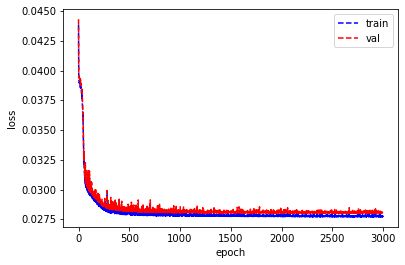

In [17]:
ax = plt.subplot(111)
ax.plot(np.arange(len(loss_train)), loss_train, 'b--')
ax.plot(np.arange(len(loss_val)), loss_val, 'r--')

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_yscale("log")

ax.legend(["train","val"])
ax.figure.savefig("4-15-15-2 all-atom and h2t series latent space error.jpg")
plt.draw()

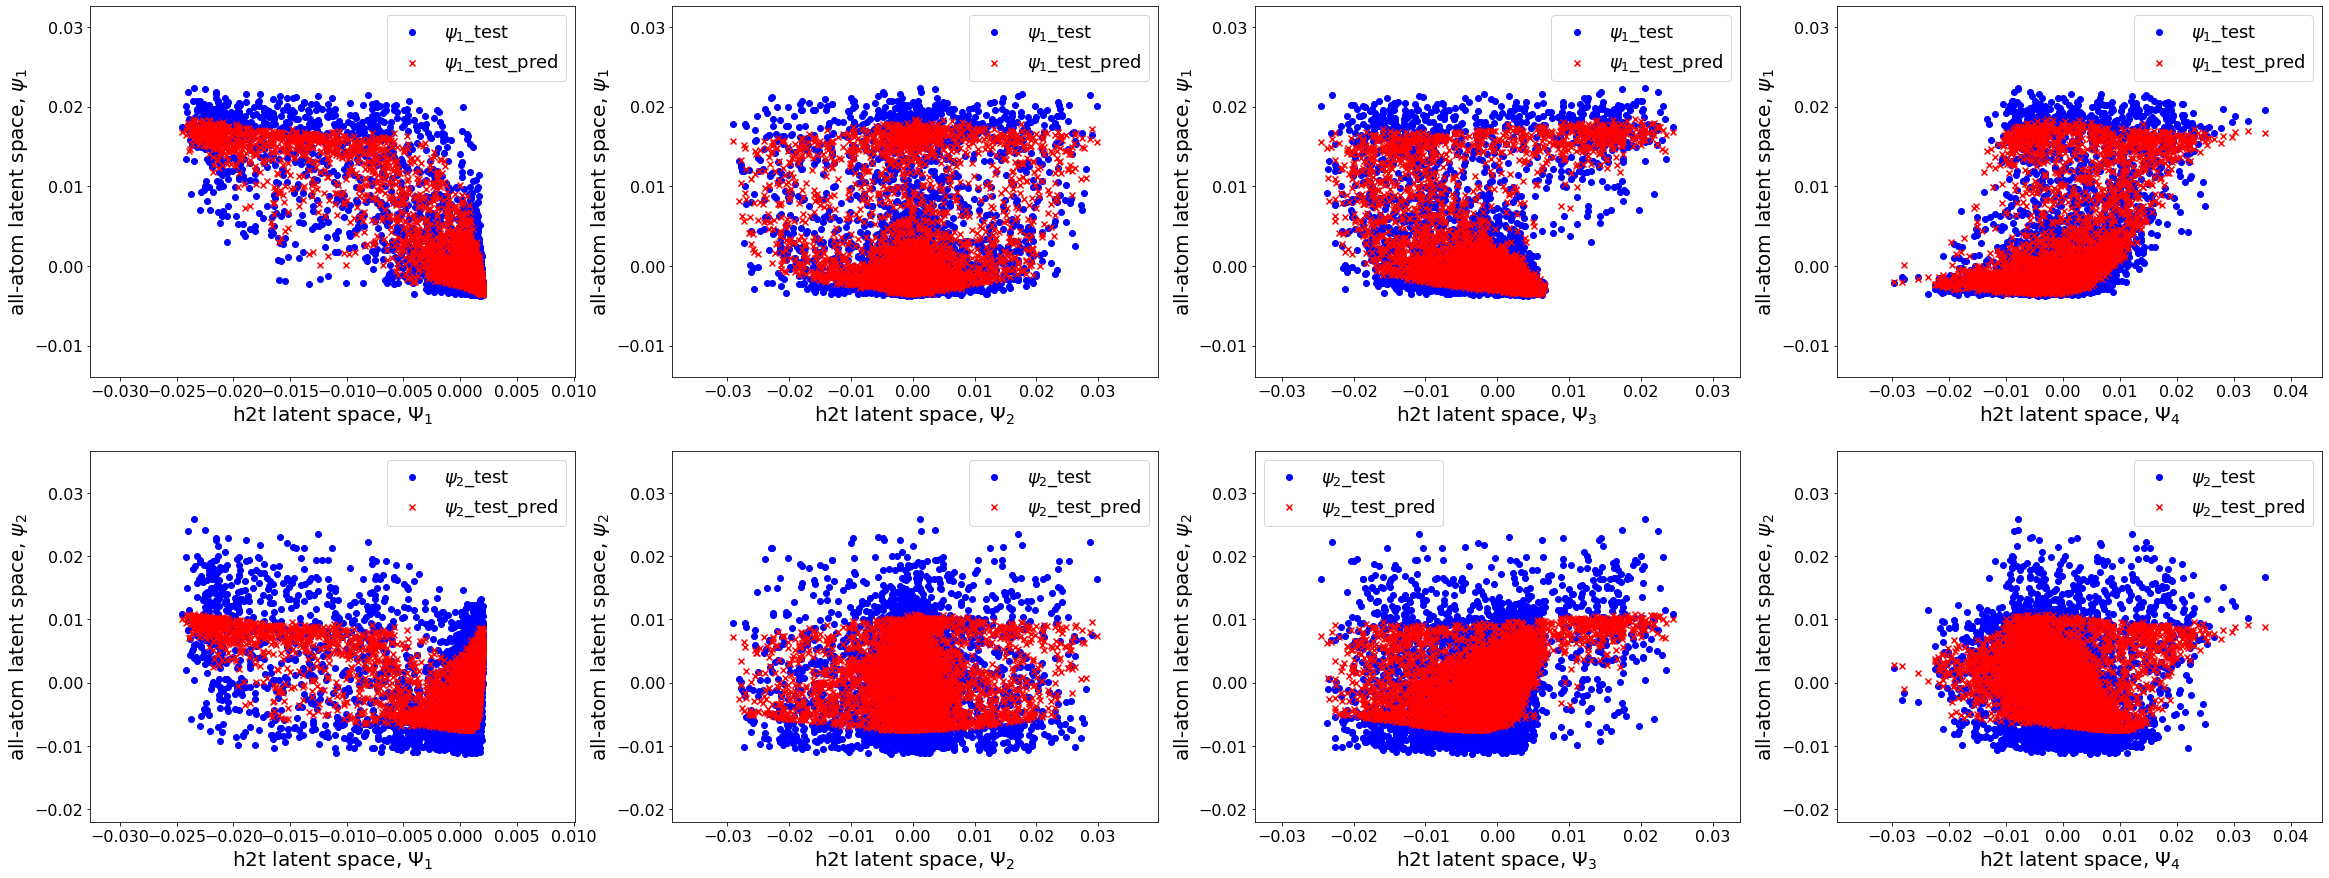

In [18]:
plt.figure(figsize=(40,15))

ax1 = plt.subplot(241)
ax1.scatter(x_test[:,0], y_test[:,0], c='blue', marker='o')
ax1.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax1.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax1.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax1.tick_params(labelsize=16)
ax1.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax2 = plt.subplot(242)
ax2.scatter(x_test[:,1], y_test[:,0], c='blue', marker='o')
ax2.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax2.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax2.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax2.tick_params(labelsize=16)
ax2.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax3 = plt.subplot(243)
ax3.scatter(x_test[:,2], y_test[:,0], c='blue', marker='o')
ax3.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax3.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax3.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax3.tick_params(labelsize=16)
ax3.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax4 = plt.subplot(244)
ax4.scatter(x_test[:,3], y_test[:,0], c='blue', marker='o')
ax4.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,0], c='red', marker='x')
ax4.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax4.set_ylabel('all-atom latent space, $\psi_1$',fontsize=20)
ax4.tick_params(labelsize=16)
ax4.legend(['$\psi_1$_test','$\psi_1$_test_pred'],fontsize=18)

ax5 = plt.subplot(245)
ax5.scatter(x_test[:,0], y_test[:,1], c='blue', marker='o')
ax5.scatter(x_test[:,0], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax5.set_xlabel('h2t latent space, $\Psi_1$',fontsize=20)
ax5.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax5.tick_params(labelsize=16)
ax5.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax6 = plt.subplot(246)
ax6.scatter(x_test[:,1], y_test[:,1], c='blue', marker='o')
ax6.scatter(x_test[:,1], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax6.set_xlabel('h2t latent space, $\Psi_2$',fontsize=20)
ax6.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax6.tick_params(labelsize=16)
ax6.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)


ax7 = plt.subplot(247)
ax7.scatter(x_test[:,2], y_test[:,1], c='blue', marker='o')
ax7.scatter(x_test[:,2], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax7.set_xlabel('h2t latent space, $\Psi_3$',fontsize=20)
ax7.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax7.tick_params(labelsize=16)
ax7.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax8 = plt.subplot(248)
ax8.scatter(x_test[:,3], y_test[:,1], c='blue', marker='o')
ax8.scatter(x_test[:,3], yscale.inverse_transform(Y_test_pred)[:,1], c='red', marker='x')
ax8.set_xlabel('h2t latent space, $\Psi_4$',fontsize=20)
ax8.set_ylabel('all-atom latent space, $\psi_2$',fontsize=20)
ax8.tick_params(labelsize=16)
ax8.legend(['$\psi_2$_test','$\psi_2$_test_pred'],fontsize=18)

ax.figure.savefig("4-15-15-2 all-atom and h2t series latent space correspondence.jpg")
plt.draw()

In [19]:
Y_train_pred_scale_back = yscale.inverse_transform(Y_train_pred)
Y_val_pred_scale_back = yscale.inverse_transform(Y_val_pred)
Y_test_pred_scale_back = yscale.inverse_transform(Y_test_pred)

In [20]:
diff_train_scale_back = Y_train_pred_scale_back - y_train
MSE_train_scale_back = np.sum(diff_train_scale_back**2) / diff_train_scale_back.shape[0]
print ("MSE_train = %f" % (MSE_train_scale_back))
print ("RMSE_train = %f" % (np.sqrt(MSE_train_scale_back)))

diff_val_scale_back = Y_val_pred_scale_back - y_val
MSE_val_scale_back = np.sum(diff_val_scale_back**2) / diff_val_scale_back.shape[0]
print ("MSE_val = %f" % (MSE_val_scale_back))
print ("RMSE_val = %f" % (np.sqrt(MSE_val_scale_back)))

diff_test_scale_back = Y_test_pred_scale_back - y_test
MSE_test_scale_back = np.sum(diff_test_scale_back**2) / diff_test_scale_back.shape[0]
print ("MSE_test = %f" % (MSE_test_scale_back))
print ("RMSE_test = %f" % (np.sqrt(MSE_test_scale_back)))

MSE_train = 0.000033
RMSE_train = 0.005703
MSE_val = 0.000033
RMSE_val = 0.005719
MSE_test = 0.000032
RMSE_test = 0.005651
